In [206]:
import pandas as pd
import numpy as np
from IPython.display import HTML
from pandas_summary import DataFrameSummary
import tensorflow
import keras
import matplotlib.pyplot as plt
from keras.layers import Conv1D, Concatenate,Input, Dense, Embedding, merge, LSTM, concatenate, Flatten, Dropout, Lambda, BatchNormalization
from keras.models import Model
from keras.regularizers import l2
from keras.optimizers import SGD, RMSprop, Adam
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_squared_log_error
from sklearn.model_selection import train_test_split



To install use: sudo -H pip3 install WHATEVER

## LOAD DATA

In [3]:
%cd
%cd git/basketball-ref-scrapper

games = pd.read_csv('games.csv', low_memory=False)
odds = pd.read_csv('odds.csv', low_memory=False)
boxscores = pd.read_csv('boxscores.csv', low_memory=False)


/Users/ruben.arana
/Users/ruben.arana/git/basketball-ref-scrapper


## DISPLAY DATA

In [4]:
display(odds.head())

YEAR  MONTH  DAY VISITOR_TEAM     HOME_TEAM  MIN_LINE  MAX_LINE  \
0  2006     11    1      Atlanta  Philadelphia     198.5     199.5   
1  2006     11    1      Indiana     Charlotte     192.5     193.5   
2  2006     11    1      Chicago       Orlando     183.5     187.5   
3  2006     11    1  New Orleans        Boston     195.5     198.5   
4  2006     11    1      Toronto      Brooklyn     195.5     202.5   

   AVERAGE_LINE  
0    198.900000  
1    193.433333  
2    183.766667  
3    197.500000  
4    201.366667

In [5]:
display(games.head())


GAME_ID  SEASON DAY_OF_WEEK  MONTH  DAY  YEAR     HOUR VISITOR_TEAM  \
0  200611010BOS    2007         Wed     11    1  2006  7:30 pm  New Orleans   
1  200611010CHA    2007         Wed     11    1  2006  7:00 pm      Indiana   
2  200611010CLE    2007         Wed     11    1  2006  8:00 pm   Washington   
3  200611010DET    2007         Wed     11    1  2006  8:00 pm    Milwaukee   
4  200611010GSW    2007         Wed     11    1  2006  7:30 pm  L.A. Lakers   

   VISITOR_POINTS     HOME_TEAM  HOME_POINTS   OT  OTHER  
0              91        Boston           87  NaN    NaN  
1             106     Charlotte           99  NaN    NaN  
2              94     Cleveland           97  NaN    NaN  
3             105       Detroit           97  NaN    NaN  
4             110  Golden State           98  NaN    NaN

In [6]:
display(boxscores.head())

GAME_ID   MP  VISITOR_FG  VISITOR_FGA  VISITOR_FG%  VISITOR_3P  \
0  200611010BOS  240          36           84        0.429           1   
1  200611010CHA  240          35           86        0.407           6   
2  200611010CLE  240          36           77        0.468           2   
3  200611010DET  240          43           93        0.462           2   
4  200611010GSW  240          39           86        0.453           5   

   VISITOR_3PA  VISITOR_3P%  VISITOR_FT  VISITOR_FTA    ...      HOME_ORB%  \
0           11        0.091          18           33    ...           21.7   
1           16        0.375          30           41    ...           25.6   
2           13        0.154          20           29    ...           40.0   
3           14        0.143          17           25    ...           32.5   
4           17        0.294          27           41    ...           25.0   

   HOME_DRB%  HOME_TRB%  HOME_AST%  HOME_STL%  HOME_BLK%  HOME_TOV%  \
0       80.8       53.1       60.0        5.0        8.2       17.1   
1       66.0       47.9       62.2        7.9       10.0       19.3   
2       79.1       60.2       64.9        4.5        6.3       14.9   
3       76.1       55.8       61.3        3.1       11.4       20.2   
4       64.2       45.5       52.9        6.1        5.8        9.1   

   HOME_USG%  HOME_ORtg  HOME_DRtg  
0      100.0       86.4       90.3  
1      100.0       97.8      104.7  
2      100.0      108.5      105.1  
3      100.0      101.3      109.6  
4      100.0       99.8      112.1  

[5 rows x 71 columns]

In [7]:
DataFrameSummary(odds).summary()

YEAR    MONTH      DAY VISITOR_TEAM    HOME_TEAM MIN_LINE  \
count             1201     1201     1201          NaN          NaN     1201   
mean           2006.65  5.66778  15.3772          NaN          NaN  195.338   
std           0.476548  4.39075  8.75615          NaN          NaN  11.4741   
min               2006        1        1          NaN          NaN    160.5   
25%               2006        2        8          NaN          NaN    186.5   
50%               2007        4       15          NaN          NaN    193.5   
75%               2007       11       23          NaN          NaN    203.5   
max               2007       12       31          NaN          NaN    231.5   
counts            1201     1201     1201         1201         1201     1201   
uniques              2        9       31           29           29       61   
missing              0        0        0            0            0        0   
missing_perc        0%       0%       0%           0%           0%       0%   
types             bool  numeric  numeric  categorical  categorical  numeric   

             MAX_LINE AVERAGE_LINE  
count            1201         1201  
mean          197.192      196.275  
std           11.5203      11.5113  
min             172.5      172.447  
25%             188.5        187.3  
50%             195.5      194.447  
75%             205.5        204.5  
max             233.5      233.167  
counts           1201         1201  
uniques            61          638  
missing             0            0  
missing_perc       0%           0%  
types         numeric      numeric

In [8]:
DataFrameSummary(games).summary()

GAME_ID    SEASON  DAY_OF_WEEK    MONTH      DAY      YEAR  \
count            NaN      1309          NaN     1309     1309      1309   
mean             NaN      2007          NaN  5.68755  15.2765   2006.65   
std              NaN         0          NaN  4.38384  8.82483  0.476632   
min              NaN      2007          NaN        1        1      2006   
25%              NaN      2007          NaN        2        8      2006   
50%              NaN      2007          NaN        4       15      2007   
75%              NaN      2007          NaN       11       23      2007   
max              NaN      2007          NaN       12       31      2007   
counts          1309      1309         1309     1309     1309      1309   
uniques         1309         1            7        9       31         2   
missing            0         0            0        0        0         0   
missing_perc      0%        0%           0%       0%       0%        0%   
types         unique  constant  categorical  numeric  numeric      bool   

                     HOUR VISITOR_TEAM VISITOR_POINTS    HOME_TEAM  \
count                 NaN          NaN           1309          NaN   
mean                  NaN          NaN        96.9198          NaN   
std                   NaN          NaN        12.2069          NaN   
min                   NaN          NaN             63          NaN   
25%                   NaN          NaN             89          NaN   
50%                   NaN          NaN             96          NaN   
75%                   NaN          NaN            105          NaN   
max                   NaN          NaN            161          NaN   
counts               1309         1309           1309         1309   
uniques                19           30             73           30   
missing                 0            0              0            0   
missing_perc           0%           0%             0%           0%   
types         categorical  categorical        numeric  categorical   

             HOME_POINTS           OT    OTHER  
count               1309          NaN        0  
mean             100.016          NaN      NaN  
std              12.4107          NaN      NaN  
min                   62          NaN      NaN  
25%                   92          NaN      NaN  
50%                  100          NaN      NaN  
75%                  108          NaN      NaN  
max                  157          NaN      NaN  
counts              1309           96        0  
uniques               76            4        0  
missing                0         1213     1309  
missing_perc          0%       92.67%     100%  
types            numeric  categorical  numeric

In [9]:
DataFrameSummary(boxscores).summary()

GAME_ID       MP VISITOR_FG VISITOR_FGA VISITOR_FG% VISITOR_3P  \
count            NaN     1309       1309        1309        1309       1309   
mean             NaN  242.101    35.8846     79.4721    0.452527    5.99542   
std              NaN  8.37403    5.05502     7.76825   0.0549027    2.96307   
min              NaN      240         21          61       0.282          0   
25%              NaN      240         32          74       0.418          4   
50%              NaN      240         36          79       0.451          6   
75%              NaN      240         39          84       0.493          8   
max              NaN      315         61         123       0.629         18   
counts          1309     1309       1309        1309        1309       1309   
uniques         1309        4         34          48         228         19   
missing            0        0          0           0           0          0   
missing_perc      0%       0%         0%          0%          0%         0%   
types         unique  numeric    numeric     numeric     numeric    numeric   

             VISITOR_3PA VISITOR_3P% VISITOR_FT VISITOR_FTA    ...     \
count               1309        1309       1309        1309    ...      
mean             16.9794    0.349739    19.1551      25.479    ...      
std              5.96629    0.123673     6.3697      7.7787    ...      
min                    1           0          3           4    ...      
25%                   13       0.267         15          20    ...      
50%                   16       0.353         19          25    ...      
75%                   21       0.429         23          31    ...      
max                   46           1         50          63    ...      
counts              1309        1309       1309        1309    ...      
uniques               39         151         40          48    ...      
missing                0           0          0           0    ...      
missing_perc          0%          0%         0%          0%    ...      
types            numeric     numeric    numeric     numeric    ...      

             HOME_ORB% HOME_DRB% HOME_TRB% HOME_AST% HOME_STL% HOME_BLK%  \
count             1309      1309      1309      1309      1309      1309   
mean             27.53   73.8153     50.83   59.6102   7.87983   7.80909   
std            7.90804   7.78764   5.53144    10.396   2.90595   4.01121   
min                4.8        50      34.2      27.8         1         0   
25%               22.2      68.9      47.1      52.9       5.8         5   
50%               27.3      73.9      50.6      59.4       7.8       7.4   
75%               32.5      79.3      54.8      66.7       9.6      10.3   
max               52.3      95.1      69.6      92.9      20.9      23.2   
counts            1309      1309      1309      1309      1309      1309   
uniques            248       244       240       275       141       163   
missing              0         0         0         0         0         0   
missing_perc        0%        0%        0%        0%        0%        0%   
types          numeric   numeric   numeric   numeric   numeric   numeric   

             HOME_TOV% HOME_USG% HOME_ORtg HOME_DRtg  
count             1309      1309      1309      1309  
mean           13.4884       100   108.763   105.424  
std            3.52409         0   11.1282    11.235  
min                4.1       100      66.9      66.8  
25%                 11       100     101.2      97.7  
50%               13.4       100     109.2     105.2  
75%               15.7       100     116.3       113  
max               25.5       100     148.9     138.3  
counts            1309      1309      1309      1309  
uniques            173         1       442       445  
missing              0         0         0         0  
missing_perc        0%        0%        0%        0%  
types          numeric  constant   numeric   numeric  

[13 rows x 71 columns]

## COMBINE DATA

In [10]:
dataAll = games.merge(boxscores, how="left", on=["GAME_ID"])
dataAll = dataAll.merge(odds, how='inner', on=["YEAR", "MONTH", "DAY", "HOME_TEAM", "VISITOR_TEAM"])

In [11]:
dataAll.head() 
# DataFrameSummary(combinedData).summary()


GAME_ID  SEASON DAY_OF_WEEK  MONTH  DAY  YEAR     HOUR VISITOR_TEAM  \
0  200611010BOS    2007         Wed     11    1  2006  7:30 pm  New Orleans   
1  200611010CHA    2007         Wed     11    1  2006  7:00 pm      Indiana   
2  200611010CLE    2007         Wed     11    1  2006  8:00 pm   Washington   
3  200611010DET    2007         Wed     11    1  2006  8:00 pm    Milwaukee   
4  200611010GSW    2007         Wed     11    1  2006  7:30 pm  L.A. Lakers   

   VISITOR_POINTS     HOME_TEAM      ...       HOME_AST% HOME_STL%  HOME_BLK%  \
0              91        Boston      ...            60.0       5.0        8.2   
1             106     Charlotte      ...            62.2       7.9       10.0   
2              94     Cleveland      ...            64.9       4.5        6.3   
3             105       Detroit      ...            61.3       3.1       11.4   
4             110  Golden State      ...            52.9       6.1        5.8   

   HOME_TOV%  HOME_USG%  HOME_ORtg  HOME_DRtg  MIN_LINE  MAX_LINE  \
0       17.1      100.0       86.4       90.3     195.5     198.5   
1       19.3      100.0       97.8      104.7     192.5     193.5   
2       14.9      100.0      108.5      105.1     194.5     194.5   
3       20.2      100.0      101.3      109.6     189.5     194.5   
4        9.1      100.0       99.8      112.1     199.5     205.5   

   AVERAGE_LINE  
0    197.500000  
1    193.433333  
2    194.500000  
3    194.166667  
4    204.566667  

[5 rows x 86 columns]

## CREATE TEAM EMBEDDINGS

In [12]:
teams = dataAll.VISITOR_TEAM.unique()
oddsTeams = odds.VISITOR_TEAM.unique()

In [13]:
# Create indexes for teams
teamId2idx = {o:i for i,o in enumerate(teams)}
teamId2idx

{'Atlanta': 9,
 'Boston': 26,
 'Brooklyn': 18,
 'Charlotte': 17,
 'Chicago': 8,
 'Cleveland': 21,
 'Dallas': 23,
 'Denver': 13,
 'Detroit': 14,
 'Golden State': 25,
 'Houston': 11,
 'Indiana': 1,
 'L.A. Clippers': 10,
 'L.A. Lakers': 4,
 'Memphis': 22,
 'Miami': 28,
 'Milwaukee': 3,
 'Minnesota': 15,
 'New Orleans': 0,
 'New York': 5,
 'Orlando': 27,
 'Philadelphia': 19,
 'Phoenix': 24,
 'Portland': 16,
 'Sacramento': 6,
 'San Antonio': 12,
 'Toronto': 7,
 'Utah': 20,
 'Washington': 2}

In [14]:
# Replace all team nambes for the indexes
dataAll.VISITOR_TEAM = dataAll.VISITOR_TEAM.apply(lambda x: teamId2idx[x])
dataAll.HOME_TEAM = dataAll.HOME_TEAM.apply(lambda x: teamId2idx[x])

In [15]:
dataAll.head()

GAME_ID  SEASON DAY_OF_WEEK  MONTH  DAY  YEAR     HOUR  VISITOR_TEAM  \
0  200611010BOS    2007         Wed     11    1  2006  7:30 pm             0   
1  200611010CHA    2007         Wed     11    1  2006  7:00 pm             1   
2  200611010CLE    2007         Wed     11    1  2006  8:00 pm             2   
3  200611010DET    2007         Wed     11    1  2006  8:00 pm             3   
4  200611010GSW    2007         Wed     11    1  2006  7:30 pm             4   

   VISITOR_POINTS  HOME_TEAM      ...       HOME_AST% HOME_STL%  HOME_BLK%  \
0              91         26      ...            60.0       5.0        8.2   
1             106         17      ...            62.2       7.9       10.0   
2              94         21      ...            64.9       4.5        6.3   
3             105         14      ...            61.3       3.1       11.4   
4             110         25      ...            52.9       6.1        5.8   

   HOME_TOV%  HOME_USG%  HOME_ORtg  HOME_DRtg  MIN_LINE  MAX_LINE  \
0       17.1      100.0       86.4       90.3     195.5     198.5   
1       19.3      100.0       97.8      104.7     192.5     193.5   
2       14.9      100.0      108.5      105.1     194.5     194.5   
3       20.2      100.0      101.3      109.6     189.5     194.5   
4        9.1      100.0       99.8      112.1     199.5     205.5   

   AVERAGE_LINE  
0    197.500000  
1    193.433333  
2    194.500000  
3    194.166667  
4    204.566667  

[5 rows x 86 columns]

In [16]:
# Initialize params
teams_number = dataAll.VISITOR_TEAM.unique().size
num_features = 50

In [165]:
# Create embeddings
home_in = Input(shape=(1,), dtype='int64', name='home_in')
u = Embedding(teams_number, num_features, input_length=1, W_regularizer=l2(1e-4))(home_in)
visitor_in = Input(shape=(1,), dtype='int64', name='visitor_in')
m = Embedding(teams_number, num_features, input_length=1, W_regularizer=l2(1e-4))(visitor_in)

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:2: UserWarning: Update your `Embedding` call to the Keras 2 API: `Embedding(29, 50, input_length=1, embeddings_regularizer=<keras.reg...)`
  
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:4: UserWarning: Update your `Embedding` call to the Keras 2 API: `Embedding(29, 50, input_length=1, embeddings_regularizer=<keras.reg...)`
  after removing the cwd from sys.path.


(<tf.Tensor 'embedding_3/Gather:0' shape=(?, 1, 50) dtype=float32>,
 <tf.Tensor 'embedding_4/Gather:0' shape=(?, 1, 50) dtype=float32>)

## CREATE TRAINING AND VALIDATION SETS

In [24]:
# Splitting all data randomly between training and validation
# msk = np.random.rand(len(dataAll)) < 0.8
# trn = dataAll[msk]
# val = dataAll[~msk]

# Splitting all data keeping the first ones as training set
n = dataAll.shape[0]
train_size = 0.8

trn = dataAll.iloc[:int(n * train_size)]
val = dataAll.iloc[int(n * train_size):]

## SIMPLE MODEL USING EMBEDDING DOT PRODUCT

In [166]:
# Creating embedding dot product model
x = merge([u, m], mode='dot')
x = Flatten()(x)
model = Model([home_in, visitor_in], x)
model.compile(Adam(0.001), loss='mse')

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:1: UserWarning: The `merge` function is deprecated and will be removed after 08/2017. Use instead layers from `keras.layers.merge`, e.g. `add`, `concatenate`, etc.
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.6/site-packages/keras/legacy/layers.py:458: UserWarning: The `Merge` layer is deprecated and will be removed after 08/2017. Use instead layers from `keras.layers.merge`, e.g. `add`, `concatenate`, etc.
  name=name)


In [170]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
home_in (InputLayer)            (None, 1)            0                                            
__________________________________________________________________________________________________
visitor_in (InputLayer)         (None, 1)            0                                            
__________________________________________________________________________________________________
embedding_3 (Embedding)         (None, 1, 50)        1450        home_in[0][0]                    
__________________________________________________________________________________________________
embedding_4 (Embedding)         (None, 1, 50)        1450        visitor_in[0][0]                 
__________________________________________________________________________________________________
merge_3 (M

In [173]:
# Training the model
model.fit([trn.VISITOR_TEAM, trn.HOME_TEAM], trn.HOME_POINTS + trn.VISITOR_POINTS, batch_size=64, epochs=200, 
          validation_data=([val.VISITOR_TEAM, val.HOME_TEAM], val.HOME_POINTS + val.VISITOR_POINTS))

Train on 946 samples, validate on 251 samples
Epoch 1/100
946/946 [==============================] - 0s 22us/step - loss: 2146.0975 - val_loss: 2156.5339
Epoch 2/100
946/946 [==============================] - 0s 20us/step - loss: 2031.5102 - val_loss: 2043.3700
Epoch 3/100
946/946 [==============================] - 0s 30us/step - loss: 1921.5788 - val_loss: 1936.9894
Epoch 4/100
946/946 [==============================] - 0s 28us/step - loss: 1818.0390 - val_loss: 1835.2084
Epoch 5/100
946/946 [==============================] - 0s 39us/step - loss: 1719.4332 - val_loss: 1739.7282
Epoch 6/100
946/946 [==============================] - 0s 49us/step - loss: 1625.7941 - val_loss: 1650.8848
Epoch 7/100
946/946 [==============================] - 0s 26us/step - loss: 1538.8143 - val_loss: 1564.6926
Epoch 8/100
946/946 [==============================] - 0s 38us/step - loss: 1455.9977 - val_loss: 1484.1531
Epoch 9/100
946/946 [==============================] - 0s 35us/step - loss: 1377.3013 - va

Epoch 77/100
946/946 [==============================] - 0s 26us/step - loss: 307.2005 - val_loss: 393.7321
Epoch 78/100
946/946 [==============================] - 0s 25us/step - loss: 306.7940 - val_loss: 393.7050
Epoch 79/100
946/946 [==============================] - 0s 31us/step - loss: 306.4374 - val_loss: 393.8062
Epoch 80/100
946/946 [==============================] - 0s 32us/step - loss: 306.1134 - val_loss: 393.4704
Epoch 81/100
946/946 [==============================] - 0s 30us/step - loss: 305.8576 - val_loss: 393.5390
Epoch 82/100
946/946 [==============================] - 0s 32us/step - loss: 305.6506 - val_loss: 393.8506
Epoch 83/100
946/946 [==============================] - 0s 30us/step - loss: 305.2803 - val_loss: 393.6812
Epoch 84/100
946/946 [==============================] - 0s 27us/step - loss: 305.0242 - val_loss: 393.5859
Epoch 85/100
946/946 [==============================] - 0s 30us/step - loss: 304.8516 - val_loss: 393.8654
Epoch 86/100
946/946 [===============

## CREATING A SIMPLE NEURAL NETWORK MODEL USING EMMBEDINGS

In [201]:
# Creating the neural network
x = merge([u, m], mode='concat')
x = Flatten()(x)
#x = Dropout(0.0)(x)
#x = Dense(50, activation='relu')(x)
#x = Dropout(0.0)(x)
x = Dense(1)(x)
neuralModel = Model([visitor_in, home_in], x)
neuralModel.compile(Adam(0.001), loss='mse')

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:2: UserWarning: The `merge` function is deprecated and will be removed after 08/2017. Use instead layers from `keras.layers.merge`, e.g. `add`, `concatenate`, etc.
  
/usr/local/lib/python3.6/site-packages/keras/legacy/layers.py:458: UserWarning: The `Merge` layer is deprecated and will be removed after 08/2017. Use instead layers from `keras.layers.merge`, e.g. `add`, `concatenate`, etc.
  name=name)


In [197]:
neuralModel.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
home_in (InputLayer)            (None, 1)            0                                            
__________________________________________________________________________________________________
visitor_in (InputLayer)         (None, 1)            0                                            
__________________________________________________________________________________________________
embedding_3 (Embedding)         (None, 1, 50)        1450        home_in[0][0]                    
__________________________________________________________________________________________________
embedding_4 (Embedding)         (None, 1, 50)        1450        visitor_in[0][0]                 
__________________________________________________________________________________________________
merge_13 (

In [202]:
# Training the neural network
neuralModel.fit([trn.VISITOR_TEAM, trn.HOME_TEAM], trn.HOME_POINTS + trn.VISITOR_POINTS, batch_size=64, epochs=75, 
          validation_data=([val.VISITOR_TEAM, val.HOME_TEAM], val.HOME_POINTS + val.VISITOR_POINTS))

Train on 946 samples, validate on 251 samples
Epoch 1/75
946/946 [==============================] - 1s 821us/step - loss: 36073.5304 - val_loss: 34352.1754
Epoch 2/75
946/946 [==============================] - 0s 28us/step - loss: 33605.8016 - val_loss: 31948.6537
Epoch 3/75
946/946 [==============================] - 0s 37us/step - loss: 31235.5645 - val_loss: 29672.3228
Epoch 4/75
946/946 [==============================] - 0s 35us/step - loss: 29003.4717 - val_loss: 27501.4266
Epoch 5/75
946/946 [==============================] - 0s 40us/step - loss: 26868.7625 - val_loss: 25460.2631
Epoch 6/75
946/946 [==============================] - 0s 38us/step - loss: 24858.2583 - val_loss: 23526.4922
Epoch 7/75
946/946 [==============================] - 0s 43us/step - loss: 22958.3748 - val_loss: 21693.7060
Epoch 8/75
946/946 [==============================] - 0s 39us/step - loss: 21159.2618 - val_loss: 19964.6761
Epoch 9/75
946/946 [==============================] - 0s 42us/step - loss: 19459.

## ERROR FROM BETTORS (GOAL is to beat a mse of 326.320)

In [17]:
mean_squared_error(dataAll["AVERAGE_LINE"], dataAll["VISITOR_POINTS"] + dataAll["HOME_POINTS"])

326.50530849978981

In [183]:
mean_absolute_error(dataAll["AVERAGE_LINE"], dataAll["VISITOR_POINTS"] + dataAll["HOME_POINTS"])

14.113589308002371

In [184]:
mean_squared_log_error(dataAll["AVERAGE_LINE"], dataAll["VISITOR_POINTS"] + dataAll["HOME_POINTS"])

0.008061972472300687

## GET AVERAGE STATS GIVEN A TEAM PREVIOUS TO A ROW

In [19]:
# Return all rows where where a specific team has played
def getTeamStats(dataframe, team, homeOrAway=None):
    if (homeOrAway is None):
        return dataframe.loc[(dataframe["VISITOR_TEAM"]== team) | (dataframe["HOME_TEAM"]== team)]
    if (homeOrAway == "HOME"):
        return dataframe.loc[(dataframe["HOME_TEAM"]== team)]
    if (homeOrAway == "AWAY") :
        return dataframe.loc[(dataframe["VISITOR_TEAM"]== team)]
    
teamGames = getTeamStats(games, "Chicago", "AWAY")
teamGames.head()

GAME_ID  SEASON DAY_OF_WEEK  MONTH  DAY  YEAR     HOUR VISITOR_TEAM  \
8    200611010ORL    2007         Wed     11    1  2006  7:00 pm      Chicago   
66   200611090CLE    2007         Thu     11    9  2006  8:00 pm      Chicago   
98   200611140DAL    2007         Tue     11   14  2006  7:30 pm      Chicago   
115  200611160HOU    2007         Thu     11   16  2006  7:00 pm      Chicago   
124  200611170SAS    2007         Fri     11   17  2006  7:00 pm      Chicago   

     VISITOR_POINTS    HOME_TEAM  HOME_POINTS   OT  OTHER  
8                94      Orlando          109  NaN    NaN  
66               94    Cleveland          113  NaN    NaN  
98               99       Dallas          111  NaN    NaN  
115             100      Houston          101  NaN    NaN  
124              83  San Antonio          100  NaN    NaN

In [20]:
# Return all rows before an specific date
def getRowsBefore(dataframe, year, month, day):
    return dataframe.loc[
        (dataframe["YEAR"]< year) 
        | ((dataframe["YEAR"]== year) & (dataframe["MONTH"]<= month))
        | ((dataframe["YEAR"]== year) & (dataframe["MONTH"]== month) & (dataframe["DAY"] < day))
    ]

In [21]:

meanDF = boxscores.mean()
meanDF

MP                  242.100840
VISITOR_FG           35.884645
VISITOR_FGA          79.472116
VISITOR_FG%           0.452527
VISITOR_3P            5.995416
VISITOR_3PA          16.979374
VISITOR_3P%           0.349739
VISITOR_FT           19.155080
VISITOR_FTA          25.478992
VISITOR_FT%           0.751866
VISITOR_ORB          10.916730
VISITOR_DRB          29.458365
VISITOR_TRB          40.375095
VISITOR_AST          20.300229
VISITOR_STL           7.203209
VISITOR_BLK           4.288006
VISITOR_TOV          14.673797
VISITOR_PF           22.644767
VISITOR_PTS          96.919786
VISITOR_PLUS_MIN           NaN
MP2                 242.100840
VISITOR_TS%           0.535330
VISITOR_eFG%          0.490293
VISITOR_3PAr          0.213354
VISITOR_FTr           0.325888
VISITOR_ORB%         26.185867
VISITOR_DRB%         72.470894
VISITOR_TRB%         49.172345
VISITOR_AST%         56.424828
VISITOR_STL%          7.805424
                       ...    
HOME_3PA             17.065699
HOME_3P%

##  GENEARTING A NEW DATASET WITH COMPUTED AVERAGES

In [24]:
dataAll.head(5)

GAME_ID  SEASON DAY_OF_WEEK  MONTH  DAY  YEAR     HOUR  VISITOR_TEAM  \
0  200611010BOS    2007         Wed     11    1  2006  7:30 pm             0   
1  200611010CHA    2007         Wed     11    1  2006  7:00 pm             1   
2  200611010CLE    2007         Wed     11    1  2006  8:00 pm             2   
3  200611010DET    2007         Wed     11    1  2006  8:00 pm             3   
4  200611010GSW    2007         Wed     11    1  2006  7:30 pm             4   

   VISITOR_POINTS  HOME_TEAM      ...       HOME_AST% HOME_STL%  HOME_BLK%  \
0              91         26      ...            60.0       5.0        8.2   
1             106         17      ...            62.2       7.9       10.0   
2              94         21      ...            64.9       4.5        6.3   
3             105         14      ...            61.3       3.1       11.4   
4             110         25      ...            52.9       6.1        5.8   

   HOME_TOV%  HOME_USG%  HOME_ORtg  HOME_DRtg  MIN_LINE  MAX_LINE  \
0       17.1      100.0       86.4       90.3     195.5     198.5   
1       19.3      100.0       97.8      104.7     192.5     193.5   
2       14.9      100.0      108.5      105.1     194.5     194.5   
3       20.2      100.0      101.3      109.6     189.5     194.5   
4        9.1      100.0       99.8      112.1     199.5     205.5   

   AVERAGE_LINE  
0    197.500000  
1    193.433333  
2    194.500000  
3    194.166667  
4    204.566667  

[5 rows x 86 columns]

In [25]:
new_rows = []
for row in dataAll.itertuples():
    visitorTeamAsHomeDf = getRowsBefore(getTeamStats(dataAll, row.VISITOR_TEAM, "HOME"), row.YEAR, row.MONTH, row.DAY).mean()
    
visitorTeamAsHomeDf.head()

SEASON          2007.000000
MONTH              6.606061
DAY               17.212121
YEAR            2006.515152
VISITOR_TEAM      14.636364
dtype: float64

In [29]:
new_rows = []
for row in dataAll.itertuples():
    
    # Only HOME games for HOME team, only VISITOR games for VISITOR team DF
    visitorTeamAsVisitorDf = getRowsBefore(getTeamStats(dataAll, row.VISITOR_TEAM, "AWAY"), row.YEAR, row.MONTH, row.DAY).mean()
    homeTeamAsHomeDf = getRowsBefore(getTeamStats(dataAll, row.HOME_TEAM, "HOME"), row.YEAR, row.MONTH, row.DAY).mean()

    # Only HOME games for VISITOR team, only VISITOR games for HOME teams DF
    visitorTeamAsHomeDf = getRowsBefore(getTeamStats(dataAll, row.VISITOR_TEAM, "HOME"), row.YEAR, row.MONTH, row.DAY).mean()
    homeTeamAsVisitorDf = getRowsBefore(getTeamStats(dataAll, row.HOME_TEAM, "AWAY"), row.YEAR, row.MONTH, row.DAY).mean()

    # Only last 6 games (HOME games for HOME team, only VISITOR games for VISITOR) team DF
    last6visitorTeamAsVisitorDf = getRowsBefore(getTeamStats(dataAll, row.VISITOR_TEAM, "AWAY"), row.YEAR, row.MONTH, row.DAY).tail(6).mean()
    last6homeTeamAsHomeDf = getRowsBefore(getTeamStats(dataAll, row.HOME_TEAM, "HOME"), row.YEAR, row.MONTH, row.DAY).tail(6).mean()

    # Only last 6 games (HOME games for VISITOR team, only VISITOR games for HOME team) DF
    last6visitorTeamAsHomeDf = getRowsBefore(getTeamStats(dataAll, row.VISITOR_TEAM, "HOME"), row.YEAR, row.MONTH, row.DAY).tail(6).mean()
    last6homeTeamAsVisitorDf = getRowsBefore(getTeamStats(dataAll, row.HOME_TEAM, "AWAY"), row.YEAR, row.MONTH, row.DAY).tail(6).mean()

    # Only last 3 games (HOME games for HOME team, only VISITOR games for VISITOR) team DF
    last3visitorTeamAsVisitorDf = getRowsBefore(getTeamStats(dataAll, row.VISITOR_TEAM, "AWAY"), row.YEAR, row.MONTH, row.DAY).tail(3).mean()
    last3homeTeamAsHomeDf = getRowsBefore(getTeamStats(dataAll, row.HOME_TEAM, "HOME"), row.YEAR, row.MONTH, row.DAY).tail(3).mean()

    # Only last 3 games (HOME games for VISITOR team, only VISITOR games for HOME team) DF
    last3visitorTeamAsHomeDf = getRowsBefore(getTeamStats(dataAll, row.VISITOR_TEAM, "HOME"), row.YEAR, row.MONTH, row.DAY).tail(3).mean()
    last3homeTeamAsVisitorDf = getRowsBefore(getTeamStats(dataAll, row.HOME_TEAM, "AWAY"), row.YEAR, row.MONTH, row.DAY).tail(3).mean()


    new_rows.append(
        [
            row.VISITOR_TEAM,
            row.HOME_TEAM, 
            
            #Totals visitor as visitor

            visitorTeamAsVisitorDf['VISITOR_FG'], 
            visitorTeamAsVisitorDf['VISITOR_FGA'],
            visitorTeamAsVisitorDf['VISITOR_FG%'],
            visitorTeamAsVisitorDf['VISITOR_3P'],
            visitorTeamAsVisitorDf['VISITOR_3PA'],
            visitorTeamAsVisitorDf['VISITOR_3P%'],
            visitorTeamAsVisitorDf['VISITOR_FT'],
            visitorTeamAsVisitorDf['VISITOR_FTA'],
            visitorTeamAsVisitorDf['VISITOR_FT%'],
            visitorTeamAsVisitorDf['VISITOR_ORB'],
            visitorTeamAsVisitorDf['VISITOR_DRB'],
            visitorTeamAsVisitorDf['VISITOR_TRB'],
            visitorTeamAsVisitorDf['VISITOR_AST'],
            visitorTeamAsVisitorDf['VISITOR_STL'],
            visitorTeamAsVisitorDf['VISITOR_BLK'],
            visitorTeamAsVisitorDf['VISITOR_TOV'],
            visitorTeamAsVisitorDf['VISITOR_PF'],
            visitorTeamAsVisitorDf['VISITOR_PTS'],
            visitorTeamAsVisitorDf['VISITOR_TS%'],
            visitorTeamAsVisitorDf['VISITOR_eFG%'],
            visitorTeamAsVisitorDf['VISITOR_3PAr'],
            visitorTeamAsVisitorDf['VISITOR_FTr'],
            visitorTeamAsVisitorDf['VISITOR_ORB%'],
            visitorTeamAsVisitorDf['VISITOR_DRB%'],
            visitorTeamAsVisitorDf['VISITOR_TRB%'],
            visitorTeamAsVisitorDf['VISITOR_AST%'], 
            visitorTeamAsVisitorDf['VISITOR_STL%'], 
            visitorTeamAsVisitorDf['VISITOR_BLK%'],
            visitorTeamAsVisitorDf['VISITOR_TOV%'],
            visitorTeamAsVisitorDf['VISITOR_USG%'],
            visitorTeamAsVisitorDf['VISITOR_ORtg'],
            visitorTeamAsVisitorDf['VISITOR_DRtg'],


            #Totals against visitor as visitor

            visitorTeamAsVisitorDf['HOME_FG'], 
            visitorTeamAsVisitorDf['HOME_FGA'],
            visitorTeamAsVisitorDf['HOME_FG%'],
            visitorTeamAsVisitorDf['HOME_3P'],
            visitorTeamAsVisitorDf['HOME_3PA'],
            visitorTeamAsVisitorDf['HOME_3P%'],
            visitorTeamAsVisitorDf['HOME_FT'],
            visitorTeamAsVisitorDf['HOME_FTA'],
            visitorTeamAsVisitorDf['HOME_FT%'],
            visitorTeamAsVisitorDf['HOME_ORB'],
            visitorTeamAsVisitorDf['HOME_DRB'],
            visitorTeamAsVisitorDf['HOME_TRB'],
            visitorTeamAsVisitorDf['HOME_AST'],
            visitorTeamAsVisitorDf['HOME_STL'],
            visitorTeamAsVisitorDf['HOME_BLK'],
            visitorTeamAsVisitorDf['HOME_TOV'],
            visitorTeamAsVisitorDf['HOME_PF'],
            visitorTeamAsVisitorDf['HOME_PTS'],
            visitorTeamAsVisitorDf['HOME_TS%'],
            visitorTeamAsVisitorDf['HOME_eFG%'],
            visitorTeamAsVisitorDf['HOME_3PAr'],
            visitorTeamAsVisitorDf['HOME_FTr'],
            visitorTeamAsVisitorDf['HOME_ORB%'],
            visitorTeamAsVisitorDf['HOME_DRB%'],
            visitorTeamAsVisitorDf['HOME_TRB%'],
            visitorTeamAsVisitorDf['HOME_AST%'], 
            visitorTeamAsVisitorDf['HOME_STL%'], 
            visitorTeamAsVisitorDf['HOME_BLK%'],
            visitorTeamAsVisitorDf['HOME_TOV%'],
            visitorTeamAsVisitorDf['HOME_USG%'],
            visitorTeamAsVisitorDf['HOME_ORtg'],
            visitorTeamAsVisitorDf['HOME_DRtg'],


            #Totals visitor as home

            visitorTeamAsHomeDf['HOME_FG'], 
            visitorTeamAsHomeDf['HOME_FGA'],
            visitorTeamAsHomeDf['HOME_FG%'],
            visitorTeamAsHomeDf['HOME_3P'],
            visitorTeamAsHomeDf['HOME_3PA'],
            visitorTeamAsHomeDf['HOME_3P%'],
            visitorTeamAsHomeDf['HOME_FT'],
            visitorTeamAsHomeDf['HOME_FTA'],
            visitorTeamAsHomeDf['HOME_FT%'],
            visitorTeamAsHomeDf['HOME_ORB'],
            visitorTeamAsHomeDf['HOME_DRB'],
            visitorTeamAsHomeDf['HOME_TRB'],
            visitorTeamAsHomeDf['HOME_AST'],
            visitorTeamAsHomeDf['HOME_STL'],
            visitorTeamAsHomeDf['HOME_BLK'],
            visitorTeamAsHomeDf['HOME_TOV'],
            visitorTeamAsHomeDf['HOME_PF'],
            visitorTeamAsHomeDf['HOME_PTS'],
            visitorTeamAsHomeDf['HOME_TS%'],
            visitorTeamAsHomeDf['HOME_eFG%'],
            visitorTeamAsHomeDf['HOME_3PAr'],
            visitorTeamAsHomeDf['HOME_FTr'],
            visitorTeamAsHomeDf['HOME_ORB%'],
            visitorTeamAsHomeDf['HOME_DRB%'],
            visitorTeamAsHomeDf['HOME_TRB%'],
            visitorTeamAsHomeDf['HOME_AST%'], 
            visitorTeamAsHomeDf['HOME_STL%'], 
            visitorTeamAsHomeDf['HOME_BLK%'],
            visitorTeamAsHomeDf['HOME_TOV%'],
            visitorTeamAsHomeDf['HOME_USG%'],
            visitorTeamAsHomeDf['HOME_ORtg'],
            visitorTeamAsHomeDf['HOME_DRtg'],

            #Totals against visitor as home

            visitorTeamAsHomeDf['VISITOR_FG'], 
            visitorTeamAsHomeDf['VISITOR_FGA'],
            visitorTeamAsHomeDf['VISITOR_FG%'],
            visitorTeamAsHomeDf['VISITOR_3P'],
            visitorTeamAsHomeDf['VISITOR_3PA'],
            visitorTeamAsHomeDf['VISITOR_3P%'],
            visitorTeamAsHomeDf['VISITOR_FT'],
            visitorTeamAsHomeDf['VISITOR_FTA'],
            visitorTeamAsHomeDf['VISITOR_FT%'],
            visitorTeamAsHomeDf['VISITOR_ORB'],
            visitorTeamAsHomeDf['VISITOR_DRB'],
            visitorTeamAsHomeDf['VISITOR_TRB'],
            visitorTeamAsHomeDf['VISITOR_AST'],
            visitorTeamAsHomeDf['VISITOR_STL'],
            visitorTeamAsHomeDf['VISITOR_BLK'],
            visitorTeamAsHomeDf['VISITOR_TOV'],
            visitorTeamAsHomeDf['VISITOR_PF'],
            visitorTeamAsHomeDf['VISITOR_PTS'],
            visitorTeamAsHomeDf['VISITOR_TS%'],
            visitorTeamAsHomeDf['VISITOR_eFG%'],
            visitorTeamAsHomeDf['VISITOR_3PAr'],
            visitorTeamAsHomeDf['VISITOR_FTr'],
            visitorTeamAsHomeDf['VISITOR_ORB%'],
            visitorTeamAsHomeDf['VISITOR_DRB%'],
            visitorTeamAsHomeDf['VISITOR_TRB%'],
            visitorTeamAsHomeDf['VISITOR_AST%'], 
            visitorTeamAsHomeDf['VISITOR_STL%'], 
            visitorTeamAsHomeDf['VISITOR_BLK%'],
            visitorTeamAsHomeDf['VISITOR_TOV%'],
            visitorTeamAsHomeDf['VISITOR_USG%'],
            visitorTeamAsHomeDf['VISITOR_ORtg'],
            visitorTeamAsHomeDf['VISITOR_DRtg'],


            #Totals home as home

            homeTeamAsHomeDf['HOME_FG'], 
            homeTeamAsHomeDf['HOME_FGA'],
            homeTeamAsHomeDf['HOME_FG%'],
            homeTeamAsHomeDf['HOME_3P'],
            homeTeamAsHomeDf['HOME_3PA'],
            homeTeamAsHomeDf['HOME_3P%'],
            homeTeamAsHomeDf['HOME_FT'],
            homeTeamAsHomeDf['HOME_FTA'],
            homeTeamAsHomeDf['HOME_FT%'],
            homeTeamAsHomeDf['HOME_ORB'],
            homeTeamAsHomeDf['HOME_DRB'],
            homeTeamAsHomeDf['HOME_TRB'],
            homeTeamAsHomeDf['HOME_AST'],
            homeTeamAsHomeDf['HOME_STL'],
            homeTeamAsHomeDf['HOME_BLK'],
            homeTeamAsHomeDf['HOME_TOV'],
            homeTeamAsHomeDf['HOME_PF'],
            homeTeamAsHomeDf['HOME_PTS'],
            homeTeamAsHomeDf['HOME_TS%'],
            homeTeamAsHomeDf['HOME_eFG%'],
            homeTeamAsHomeDf['HOME_3PAr'],
            homeTeamAsHomeDf['HOME_FTr'],
            homeTeamAsHomeDf['HOME_ORB%'],
            homeTeamAsHomeDf['HOME_DRB%'],
            homeTeamAsHomeDf['HOME_TRB%'],
            homeTeamAsHomeDf['HOME_AST%'], 
            homeTeamAsHomeDf['HOME_STL%'], 
            homeTeamAsHomeDf['HOME_BLK%'],
            homeTeamAsHomeDf['HOME_TOV%'],
            homeTeamAsHomeDf['HOME_USG%'],
            homeTeamAsHomeDf['HOME_ORtg'],
            homeTeamAsHomeDf['HOME_DRtg'],


            #Totals against home as home

            homeTeamAsHomeDf['VISITOR_FG'], 
            homeTeamAsHomeDf['VISITOR_FGA'],
            homeTeamAsHomeDf['VISITOR_FG%'],
            homeTeamAsHomeDf['VISITOR_3P'],
            homeTeamAsHomeDf['VISITOR_3PA'],
            homeTeamAsHomeDf['VISITOR_3P%'],
            homeTeamAsHomeDf['VISITOR_FT'],
            homeTeamAsHomeDf['VISITOR_FTA'],
            homeTeamAsHomeDf['VISITOR_FT%'],
            homeTeamAsHomeDf['VISITOR_ORB'],
            homeTeamAsHomeDf['VISITOR_DRB'],
            homeTeamAsHomeDf['VISITOR_TRB'],
            homeTeamAsHomeDf['VISITOR_AST'],
            homeTeamAsHomeDf['VISITOR_STL'],
            homeTeamAsHomeDf['VISITOR_BLK'],
            homeTeamAsHomeDf['VISITOR_TOV'],
            homeTeamAsHomeDf['VISITOR_PF'],
            homeTeamAsHomeDf['VISITOR_PTS'],
            homeTeamAsHomeDf['VISITOR_TS%'],
            homeTeamAsHomeDf['VISITOR_eFG%'],
            homeTeamAsHomeDf['VISITOR_3PAr'],
            homeTeamAsHomeDf['VISITOR_FTr'],
            homeTeamAsHomeDf['VISITOR_ORB%'],
            homeTeamAsHomeDf['VISITOR_DRB%'],
            homeTeamAsHomeDf['VISITOR_TRB%'],
            homeTeamAsHomeDf['VISITOR_AST%'], 
            homeTeamAsHomeDf['VISITOR_STL%'], 
            homeTeamAsHomeDf['VISITOR_BLK%'],
            homeTeamAsHomeDf['VISITOR_TOV%'],
            homeTeamAsHomeDf['VISITOR_USG%'],
            homeTeamAsHomeDf['VISITOR_ORtg'],
            homeTeamAsHomeDf['VISITOR_DRtg'],


            #Totals home as visitor

            homeTeamAsVisitorDf['VISITOR_FG'], 
            homeTeamAsVisitorDf['VISITOR_FGA'],
            homeTeamAsVisitorDf['VISITOR_FG%'],
            homeTeamAsVisitorDf['VISITOR_3P'],
            homeTeamAsVisitorDf['VISITOR_3PA'],
            homeTeamAsVisitorDf['VISITOR_3P%'],
            homeTeamAsVisitorDf['VISITOR_FT'],
            homeTeamAsVisitorDf['VISITOR_FTA'],
            homeTeamAsVisitorDf['VISITOR_FT%'],
            homeTeamAsVisitorDf['VISITOR_ORB'],
            homeTeamAsVisitorDf['VISITOR_DRB'],
            homeTeamAsVisitorDf['VISITOR_TRB'],
            homeTeamAsVisitorDf['VISITOR_AST'],
            homeTeamAsVisitorDf['VISITOR_STL'],
            homeTeamAsVisitorDf['VISITOR_BLK'],
            homeTeamAsVisitorDf['VISITOR_TOV'],
            homeTeamAsVisitorDf['VISITOR_PF'],
            homeTeamAsVisitorDf['VISITOR_PTS'],
            homeTeamAsVisitorDf['VISITOR_TS%'],
            homeTeamAsVisitorDf['VISITOR_eFG%'],
            homeTeamAsVisitorDf['VISITOR_3PAr'],
            homeTeamAsVisitorDf['VISITOR_FTr'],
            homeTeamAsVisitorDf['VISITOR_ORB%'],
            homeTeamAsVisitorDf['VISITOR_DRB%'],
            homeTeamAsVisitorDf['VISITOR_TRB%'],
            homeTeamAsVisitorDf['VISITOR_AST%'], 
            homeTeamAsVisitorDf['VISITOR_STL%'], 
            homeTeamAsVisitorDf['VISITOR_BLK%'],
            homeTeamAsVisitorDf['VISITOR_TOV%'],
            homeTeamAsVisitorDf['VISITOR_USG%'],
            homeTeamAsVisitorDf['VISITOR_ORtg'],
            homeTeamAsVisitorDf['VISITOR_DRtg'],


            #Totals against home as visitor

            homeTeamAsVisitorDf['HOME_FG'], 
            homeTeamAsVisitorDf['HOME_FGA'],
            homeTeamAsVisitorDf['HOME_FG%'],
            homeTeamAsVisitorDf['HOME_3P'],
            homeTeamAsVisitorDf['HOME_3PA'],
            homeTeamAsVisitorDf['HOME_3P%'],
            homeTeamAsVisitorDf['HOME_FT'],
            homeTeamAsVisitorDf['HOME_FTA'],
            homeTeamAsVisitorDf['HOME_FT%'],
            homeTeamAsVisitorDf['HOME_ORB'],
            homeTeamAsVisitorDf['HOME_DRB'],
            homeTeamAsVisitorDf['HOME_TRB'],
            homeTeamAsVisitorDf['HOME_AST'],
            homeTeamAsVisitorDf['HOME_STL'],
            homeTeamAsVisitorDf['HOME_BLK'],
            homeTeamAsVisitorDf['HOME_TOV'],
            homeTeamAsVisitorDf['HOME_PF'],
            homeTeamAsVisitorDf['HOME_PTS'],
            homeTeamAsVisitorDf['HOME_TS%'],
            homeTeamAsVisitorDf['HOME_eFG%'],
            homeTeamAsVisitorDf['HOME_3PAr'],
            homeTeamAsVisitorDf['HOME_FTr'],
            homeTeamAsVisitorDf['HOME_ORB%'],
            homeTeamAsVisitorDf['HOME_DRB%'],
            homeTeamAsVisitorDf['HOME_TRB%'],
            homeTeamAsVisitorDf['HOME_AST%'], 
            homeTeamAsVisitorDf['HOME_STL%'], 
            homeTeamAsVisitorDf['HOME_BLK%'],
            homeTeamAsVisitorDf['HOME_TOV%'],
            homeTeamAsVisitorDf['HOME_USG%'],
            homeTeamAsVisitorDf['HOME_ORtg'],
            homeTeamAsVisitorDf['HOME_DRtg'],


            #LAST 6 GAMES

            #Totals visitor as visitor

            last6visitorTeamAsVisitorDf['VISITOR_FG'], 
            last6visitorTeamAsVisitorDf['VISITOR_FGA'],
            last6visitorTeamAsVisitorDf['VISITOR_FG%'],
            last6visitorTeamAsVisitorDf['VISITOR_3P'],
            last6visitorTeamAsVisitorDf['VISITOR_3PA'],
            last6visitorTeamAsVisitorDf['VISITOR_3P%'],
            last6visitorTeamAsVisitorDf['VISITOR_FT'],
            last6visitorTeamAsVisitorDf['VISITOR_FTA'],
            last6visitorTeamAsVisitorDf['VISITOR_FT%'],
            last6visitorTeamAsVisitorDf['VISITOR_ORB'],
            last6visitorTeamAsVisitorDf['VISITOR_DRB'],
            last6visitorTeamAsVisitorDf['VISITOR_TRB'],
            last6visitorTeamAsVisitorDf['VISITOR_AST'],
            last6visitorTeamAsVisitorDf['VISITOR_STL'],
            last6visitorTeamAsVisitorDf['VISITOR_BLK'],
            last6visitorTeamAsVisitorDf['VISITOR_TOV'],
            last6visitorTeamAsVisitorDf['VISITOR_PF'],
            last6visitorTeamAsVisitorDf['VISITOR_PTS'],
            last6visitorTeamAsVisitorDf['VISITOR_TS%'],
            last6visitorTeamAsVisitorDf['VISITOR_eFG%'],
            last6visitorTeamAsVisitorDf['VISITOR_3PAr'],
            last6visitorTeamAsVisitorDf['VISITOR_FTr'],
            last6visitorTeamAsVisitorDf['VISITOR_ORB%'],
            last6visitorTeamAsVisitorDf['VISITOR_DRB%'],
            last6visitorTeamAsVisitorDf['VISITOR_TRB%'],
            last6visitorTeamAsVisitorDf['VISITOR_AST%'], 
            last6visitorTeamAsVisitorDf['VISITOR_STL%'], 
            last6visitorTeamAsVisitorDf['VISITOR_BLK%'],
            last6visitorTeamAsVisitorDf['VISITOR_TOV%'],
            last6visitorTeamAsVisitorDf['VISITOR_USG%'],
            last6visitorTeamAsVisitorDf['VISITOR_ORtg'],
            last6visitorTeamAsVisitorDf['VISITOR_DRtg'],


            #Totals against visitor as visitor

            last6visitorTeamAsVisitorDf['HOME_FG'], 
            last6visitorTeamAsVisitorDf['HOME_FGA'],
            last6visitorTeamAsVisitorDf['HOME_FG%'],
            last6visitorTeamAsVisitorDf['HOME_3P'],
            last6visitorTeamAsVisitorDf['HOME_3PA'],
            last6visitorTeamAsVisitorDf['HOME_3P%'],
            last6visitorTeamAsVisitorDf['HOME_FT'],
            last6visitorTeamAsVisitorDf['HOME_FTA'],
            last6visitorTeamAsVisitorDf['HOME_FT%'],
            last6visitorTeamAsVisitorDf['HOME_ORB'],
            last6visitorTeamAsVisitorDf['HOME_DRB'],
            last6visitorTeamAsVisitorDf['HOME_TRB'],
            last6visitorTeamAsVisitorDf['HOME_AST'],
            last6visitorTeamAsVisitorDf['HOME_STL'],
            last6visitorTeamAsVisitorDf['HOME_BLK'],
            last6visitorTeamAsVisitorDf['HOME_TOV'],
            last6visitorTeamAsVisitorDf['HOME_PF'],
            last6visitorTeamAsVisitorDf['HOME_PTS'],
            last6visitorTeamAsVisitorDf['HOME_TS%'],
            last6visitorTeamAsVisitorDf['HOME_eFG%'],
            last6visitorTeamAsVisitorDf['HOME_3PAr'],
            last6visitorTeamAsVisitorDf['HOME_FTr'],
            last6visitorTeamAsVisitorDf['HOME_ORB%'],
            last6visitorTeamAsVisitorDf['HOME_DRB%'],
            last6visitorTeamAsVisitorDf['HOME_TRB%'],
            last6visitorTeamAsVisitorDf['HOME_AST%'], 
            last6visitorTeamAsVisitorDf['HOME_STL%'], 
            last6visitorTeamAsVisitorDf['HOME_BLK%'],
            last6visitorTeamAsVisitorDf['HOME_TOV%'],
            last6visitorTeamAsVisitorDf['HOME_USG%'],
            last6visitorTeamAsVisitorDf['HOME_ORtg'],
            last6visitorTeamAsVisitorDf['HOME_DRtg'],


            #Totals visitor as home

            last6visitorTeamAsHomeDf['HOME_FG'], 
            last6visitorTeamAsHomeDf['HOME_FGA'],
            last6visitorTeamAsHomeDf['HOME_FG%'],
            last6visitorTeamAsHomeDf['HOME_3P'],
            last6visitorTeamAsHomeDf['HOME_3PA'],
            last6visitorTeamAsHomeDf['HOME_3P%'],
            last6visitorTeamAsHomeDf['HOME_FT'],
            last6visitorTeamAsHomeDf['HOME_FTA'],
            last6visitorTeamAsHomeDf['HOME_FT%'],
            last6visitorTeamAsHomeDf['HOME_ORB'],
            last6visitorTeamAsHomeDf['HOME_DRB'],
            last6visitorTeamAsHomeDf['HOME_TRB'],
            last6visitorTeamAsHomeDf['HOME_AST'],
            last6visitorTeamAsHomeDf['HOME_STL'],
            last6visitorTeamAsHomeDf['HOME_BLK'],
            last6visitorTeamAsHomeDf['HOME_TOV'],
            last6visitorTeamAsHomeDf['HOME_PF'],
            last6visitorTeamAsHomeDf['HOME_PTS'],
            last6visitorTeamAsHomeDf['HOME_TS%'],
            last6visitorTeamAsHomeDf['HOME_eFG%'],
            last6visitorTeamAsHomeDf['HOME_3PAr'],
            last6visitorTeamAsHomeDf['HOME_FTr'],
            last6visitorTeamAsHomeDf['HOME_ORB%'],
            last6visitorTeamAsHomeDf['HOME_DRB%'],
            last6visitorTeamAsHomeDf['HOME_TRB%'],
            last6visitorTeamAsHomeDf['HOME_AST%'], 
            last6visitorTeamAsHomeDf['HOME_STL%'], 
            last6visitorTeamAsHomeDf['HOME_BLK%'],
            last6visitorTeamAsHomeDf['HOME_TOV%'],
            last6visitorTeamAsHomeDf['HOME_USG%'],
            last6visitorTeamAsHomeDf['HOME_ORtg'],
            last6visitorTeamAsHomeDf['HOME_DRtg'],

            #Totals against visitor as home

            last6visitorTeamAsHomeDf['VISITOR_FG'], 
            last6visitorTeamAsHomeDf['VISITOR_FGA'],
            last6visitorTeamAsHomeDf['VISITOR_FG%'],
            last6visitorTeamAsHomeDf['VISITOR_3P'],
            last6visitorTeamAsHomeDf['VISITOR_3PA'],
            last6visitorTeamAsHomeDf['VISITOR_3P%'],
            last6visitorTeamAsHomeDf['VISITOR_FT'],
            last6visitorTeamAsHomeDf['VISITOR_FTA'],
            last6visitorTeamAsHomeDf['VISITOR_FT%'],
            last6visitorTeamAsHomeDf['VISITOR_ORB'],
            last6visitorTeamAsHomeDf['VISITOR_DRB'],
            last6visitorTeamAsHomeDf['VISITOR_TRB'],
            last6visitorTeamAsHomeDf['VISITOR_AST'],
            last6visitorTeamAsHomeDf['VISITOR_STL'],
            last6visitorTeamAsHomeDf['VISITOR_BLK'],
            last6visitorTeamAsHomeDf['VISITOR_TOV'],
            last6visitorTeamAsHomeDf['VISITOR_PF'],
            last6visitorTeamAsHomeDf['VISITOR_PTS'],
            last6visitorTeamAsHomeDf['VISITOR_TS%'],
            last6visitorTeamAsHomeDf['VISITOR_eFG%'],
            last6visitorTeamAsHomeDf['VISITOR_3PAr'],
            last6visitorTeamAsHomeDf['VISITOR_FTr'],
            last6visitorTeamAsHomeDf['VISITOR_ORB%'],
            last6visitorTeamAsHomeDf['VISITOR_DRB%'],
            last6visitorTeamAsHomeDf['VISITOR_TRB%'],
            last6visitorTeamAsHomeDf['VISITOR_AST%'], 
            last6visitorTeamAsHomeDf['VISITOR_STL%'], 
            last6visitorTeamAsHomeDf['VISITOR_BLK%'],
            last6visitorTeamAsHomeDf['VISITOR_TOV%'],
            last6visitorTeamAsHomeDf['VISITOR_USG%'],
            last6visitorTeamAsHomeDf['VISITOR_ORtg'],
            last6visitorTeamAsHomeDf['VISITOR_DRtg'],


            #Totals home as home

            last6homeTeamAsHomeDf['HOME_FG'], 
            last6homeTeamAsHomeDf['HOME_FGA'],
            last6homeTeamAsHomeDf['HOME_FG%'],
            last6homeTeamAsHomeDf['HOME_3P'],
            last6homeTeamAsHomeDf['HOME_3PA'],
            last6homeTeamAsHomeDf['HOME_3P%'],
            last6homeTeamAsHomeDf['HOME_FT'],
            last6homeTeamAsHomeDf['HOME_FTA'],
            last6homeTeamAsHomeDf['HOME_FT%'],
            last6homeTeamAsHomeDf['HOME_ORB'],
            last6homeTeamAsHomeDf['HOME_DRB'],
            last6homeTeamAsHomeDf['HOME_TRB'],
            last6homeTeamAsHomeDf['HOME_AST'],
            last6homeTeamAsHomeDf['HOME_STL'],
            last6homeTeamAsHomeDf['HOME_BLK'],
            last6homeTeamAsHomeDf['HOME_TOV'],
            last6homeTeamAsHomeDf['HOME_PF'],
            last6homeTeamAsHomeDf['HOME_PTS'],
            last6homeTeamAsHomeDf['HOME_TS%'],
            last6homeTeamAsHomeDf['HOME_eFG%'],
            last6homeTeamAsHomeDf['HOME_3PAr'],
            last6homeTeamAsHomeDf['HOME_FTr'],
            last6homeTeamAsHomeDf['HOME_ORB%'],
            last6homeTeamAsHomeDf['HOME_DRB%'],
            last6homeTeamAsHomeDf['HOME_TRB%'],
            last6homeTeamAsHomeDf['HOME_AST%'], 
            last6homeTeamAsHomeDf['HOME_STL%'], 
            last6homeTeamAsHomeDf['HOME_BLK%'],
            last6homeTeamAsHomeDf['HOME_TOV%'],
            last6homeTeamAsHomeDf['HOME_USG%'],
            last6homeTeamAsHomeDf['HOME_ORtg'],
            last6homeTeamAsHomeDf['HOME_DRtg'],


            #Totals against home as home

            last6homeTeamAsHomeDf['VISITOR_FG'], 
            last6homeTeamAsHomeDf['VISITOR_FGA'],
            last6homeTeamAsHomeDf['VISITOR_FG%'],
            last6homeTeamAsHomeDf['VISITOR_3P'],
            last6homeTeamAsHomeDf['VISITOR_3PA'],
            last6homeTeamAsHomeDf['VISITOR_3P%'],
            last6homeTeamAsHomeDf['VISITOR_FT'],
            last6homeTeamAsHomeDf['VISITOR_FTA'],
            last6homeTeamAsHomeDf['VISITOR_FT%'],
            last6homeTeamAsHomeDf['VISITOR_ORB'],
            last6homeTeamAsHomeDf['VISITOR_DRB'],
            last6homeTeamAsHomeDf['VISITOR_TRB'],
            last6homeTeamAsHomeDf['VISITOR_AST'],
            last6homeTeamAsHomeDf['VISITOR_STL'],
            last6homeTeamAsHomeDf['VISITOR_BLK'],
            last6homeTeamAsHomeDf['VISITOR_TOV'],
            last6homeTeamAsHomeDf['VISITOR_PF'],
            last6homeTeamAsHomeDf['VISITOR_PTS'],
            last6homeTeamAsHomeDf['VISITOR_TS%'],
            last6homeTeamAsHomeDf['VISITOR_eFG%'],
            last6homeTeamAsHomeDf['VISITOR_3PAr'],
            last6homeTeamAsHomeDf['VISITOR_FTr'],
            last6homeTeamAsHomeDf['VISITOR_ORB%'],
            last6homeTeamAsHomeDf['VISITOR_DRB%'],
            last6homeTeamAsHomeDf['VISITOR_TRB%'],
            last6homeTeamAsHomeDf['VISITOR_AST%'], 
            last6homeTeamAsHomeDf['VISITOR_STL%'], 
            last6homeTeamAsHomeDf['VISITOR_BLK%'],
            last6homeTeamAsHomeDf['VISITOR_TOV%'],
            last6homeTeamAsHomeDf['VISITOR_USG%'],
            last6homeTeamAsHomeDf['VISITOR_ORtg'],
            last6homeTeamAsHomeDf['VISITOR_DRtg'],


            #Totals home as visitor

            last6homeTeamAsVisitorDf['VISITOR_FG'], 
            last6homeTeamAsVisitorDf['VISITOR_FGA'],
            last6homeTeamAsVisitorDf['VISITOR_FG%'],
            last6homeTeamAsVisitorDf['VISITOR_3P'],
            last6homeTeamAsVisitorDf['VISITOR_3PA'],
            last6homeTeamAsVisitorDf['VISITOR_3P%'],
            last6homeTeamAsVisitorDf['VISITOR_FT'],
            last6homeTeamAsVisitorDf['VISITOR_FTA'],
            last6homeTeamAsVisitorDf['VISITOR_FT%'],
            last6homeTeamAsVisitorDf['VISITOR_ORB'],
            last6homeTeamAsVisitorDf['VISITOR_DRB'],
            last6homeTeamAsVisitorDf['VISITOR_TRB'],
            last6homeTeamAsVisitorDf['VISITOR_AST'],
            last6homeTeamAsVisitorDf['VISITOR_STL'],
            last6homeTeamAsVisitorDf['VISITOR_BLK'],
            last6homeTeamAsVisitorDf['VISITOR_TOV'],
            last6homeTeamAsVisitorDf['VISITOR_PF'],
            last6homeTeamAsVisitorDf['VISITOR_PTS'],
            last6homeTeamAsVisitorDf['VISITOR_TS%'],
            last6homeTeamAsVisitorDf['VISITOR_eFG%'],
            last6homeTeamAsVisitorDf['VISITOR_3PAr'],
            last6homeTeamAsVisitorDf['VISITOR_FTr'],
            last6homeTeamAsVisitorDf['VISITOR_ORB%'],
            last6homeTeamAsVisitorDf['VISITOR_DRB%'],
            last6homeTeamAsVisitorDf['VISITOR_TRB%'],
            last6homeTeamAsVisitorDf['VISITOR_AST%'], 
            last6homeTeamAsVisitorDf['VISITOR_STL%'], 
            last6homeTeamAsVisitorDf['VISITOR_BLK%'],
            last6homeTeamAsVisitorDf['VISITOR_TOV%'],
            last6homeTeamAsVisitorDf['VISITOR_USG%'],
            last6homeTeamAsVisitorDf['VISITOR_ORtg'],
            last6homeTeamAsVisitorDf['VISITOR_DRtg'],


            #Totals against home as visitor

            last6homeTeamAsVisitorDf['HOME_FG'], 
            last6homeTeamAsVisitorDf['HOME_FGA'],
            last6homeTeamAsVisitorDf['HOME_FG%'],
            last6homeTeamAsVisitorDf['HOME_3P'],
            last6homeTeamAsVisitorDf['HOME_3PA'],
            last6homeTeamAsVisitorDf['HOME_3P%'],
            last6homeTeamAsVisitorDf['HOME_FT'],
            last6homeTeamAsVisitorDf['HOME_FTA'],
            last6homeTeamAsVisitorDf['HOME_FT%'],
            last6homeTeamAsVisitorDf['HOME_ORB'],
            last6homeTeamAsVisitorDf['HOME_DRB'],
            last6homeTeamAsVisitorDf['HOME_TRB'],
            last6homeTeamAsVisitorDf['HOME_AST'],
            last6homeTeamAsVisitorDf['HOME_STL'],
            last6homeTeamAsVisitorDf['HOME_BLK'],
            last6homeTeamAsVisitorDf['HOME_TOV'],
            last6homeTeamAsVisitorDf['HOME_PF'],
            last6homeTeamAsVisitorDf['HOME_PTS'],
            last6homeTeamAsVisitorDf['HOME_TS%'],
            last6homeTeamAsVisitorDf['HOME_eFG%'],
            last6homeTeamAsVisitorDf['HOME_3PAr'],
            last6homeTeamAsVisitorDf['HOME_FTr'],
            last6homeTeamAsVisitorDf['HOME_ORB%'],
            last6homeTeamAsVisitorDf['HOME_DRB%'],
            last6homeTeamAsVisitorDf['HOME_TRB%'],
            last6homeTeamAsVisitorDf['HOME_AST%'], 
            last6homeTeamAsVisitorDf['HOME_STL%'], 
            last6homeTeamAsVisitorDf['HOME_BLK%'],
            last6homeTeamAsVisitorDf['HOME_TOV%'],
            last6homeTeamAsVisitorDf['HOME_USG%'],
            last6homeTeamAsVisitorDf['HOME_ORtg'],
            last6homeTeamAsVisitorDf['HOME_DRtg'],



            #LAST 3 GAMES

            #Totals visitor as visitor

            last3visitorTeamAsVisitorDf['VISITOR_FG'], 
            last3visitorTeamAsVisitorDf['VISITOR_FGA'],
            last3visitorTeamAsVisitorDf['VISITOR_FG%'],
            last3visitorTeamAsVisitorDf['VISITOR_3P'],
            last3visitorTeamAsVisitorDf['VISITOR_3PA'],
            last3visitorTeamAsVisitorDf['VISITOR_3P%'],
            last3visitorTeamAsVisitorDf['VISITOR_FT'],
            last3visitorTeamAsVisitorDf['VISITOR_FTA'],
            last3visitorTeamAsVisitorDf['VISITOR_FT%'],
            last3visitorTeamAsVisitorDf['VISITOR_ORB'],
            last3visitorTeamAsVisitorDf['VISITOR_DRB'],
            last3visitorTeamAsVisitorDf['VISITOR_TRB'],
            last3visitorTeamAsVisitorDf['VISITOR_AST'],
            last3visitorTeamAsVisitorDf['VISITOR_STL'],
            last3visitorTeamAsVisitorDf['VISITOR_BLK'],
            last3visitorTeamAsVisitorDf['VISITOR_TOV'],
            last3visitorTeamAsVisitorDf['VISITOR_PF'],
            last3visitorTeamAsVisitorDf['VISITOR_PTS'],
            last3visitorTeamAsVisitorDf['VISITOR_TS%'],
            last3visitorTeamAsVisitorDf['VISITOR_eFG%'],
            last3visitorTeamAsVisitorDf['VISITOR_3PAr'],
            last3visitorTeamAsVisitorDf['VISITOR_FTr'],
            last3visitorTeamAsVisitorDf['VISITOR_ORB%'],
            last3visitorTeamAsVisitorDf['VISITOR_DRB%'],
            last3visitorTeamAsVisitorDf['VISITOR_TRB%'],
            last3visitorTeamAsVisitorDf['VISITOR_AST%'], 
            last3visitorTeamAsVisitorDf['VISITOR_STL%'], 
            last3visitorTeamAsVisitorDf['VISITOR_BLK%'],
            last3visitorTeamAsVisitorDf['VISITOR_TOV%'],
            last3visitorTeamAsVisitorDf['VISITOR_USG%'],
            last3visitorTeamAsVisitorDf['VISITOR_ORtg'],
            last3visitorTeamAsVisitorDf['VISITOR_DRtg'],


            #Totals against visitor as visitor

            last3visitorTeamAsVisitorDf['HOME_FG'], 
            last3visitorTeamAsVisitorDf['HOME_FGA'],
            last3visitorTeamAsVisitorDf['HOME_FG%'],
            last3visitorTeamAsVisitorDf['HOME_3P'],
            last3visitorTeamAsVisitorDf['HOME_3PA'],
            last3visitorTeamAsVisitorDf['HOME_3P%'],
            last3visitorTeamAsVisitorDf['HOME_FT'],
            last3visitorTeamAsVisitorDf['HOME_FTA'],
            last3visitorTeamAsVisitorDf['HOME_FT%'],
            last3visitorTeamAsVisitorDf['HOME_ORB'],
            last3visitorTeamAsVisitorDf['HOME_DRB'],
            last3visitorTeamAsVisitorDf['HOME_TRB'],
            last3visitorTeamAsVisitorDf['HOME_AST'],
            last3visitorTeamAsVisitorDf['HOME_STL'],
            last3visitorTeamAsVisitorDf['HOME_BLK'],
            last3visitorTeamAsVisitorDf['HOME_TOV'],
            last3visitorTeamAsVisitorDf['HOME_PF'],
            last3visitorTeamAsVisitorDf['HOME_PTS'],
            last3visitorTeamAsVisitorDf['HOME_TS%'],
            last3visitorTeamAsVisitorDf['HOME_eFG%'],
            last3visitorTeamAsVisitorDf['HOME_3PAr'],
            last3visitorTeamAsVisitorDf['HOME_FTr'],
            last3visitorTeamAsVisitorDf['HOME_ORB%'],
            last3visitorTeamAsVisitorDf['HOME_DRB%'],
            last3visitorTeamAsVisitorDf['HOME_TRB%'],
            last3visitorTeamAsVisitorDf['HOME_AST%'], 
            last3visitorTeamAsVisitorDf['HOME_STL%'], 
            last3visitorTeamAsVisitorDf['HOME_BLK%'],
            last3visitorTeamAsVisitorDf['HOME_TOV%'],
            last3visitorTeamAsVisitorDf['HOME_USG%'],
            last3visitorTeamAsVisitorDf['HOME_ORtg'],
            last3visitorTeamAsVisitorDf['HOME_DRtg'],


            #Totals visitor as home

            last3visitorTeamAsHomeDf['HOME_FG'], 
            last3visitorTeamAsHomeDf['HOME_FGA'],
            last3visitorTeamAsHomeDf['HOME_FG%'],
            last3visitorTeamAsHomeDf['HOME_3P'],
            last3visitorTeamAsHomeDf['HOME_3PA'],
            last3visitorTeamAsHomeDf['HOME_3P%'],
            last3visitorTeamAsHomeDf['HOME_FT'],
            last3visitorTeamAsHomeDf['HOME_FTA'],
            last3visitorTeamAsHomeDf['HOME_FT%'],
            last3visitorTeamAsHomeDf['HOME_ORB'],
            last3visitorTeamAsHomeDf['HOME_DRB'],
            last3visitorTeamAsHomeDf['HOME_TRB'],
            last3visitorTeamAsHomeDf['HOME_AST'],
            last3visitorTeamAsHomeDf['HOME_STL'],
            last3visitorTeamAsHomeDf['HOME_BLK'],
            last3visitorTeamAsHomeDf['HOME_TOV'],
            last3visitorTeamAsHomeDf['HOME_PF'],
            last3visitorTeamAsHomeDf['HOME_PTS'],
            last3visitorTeamAsHomeDf['HOME_TS%'],
            last3visitorTeamAsHomeDf['HOME_eFG%'],
            last3visitorTeamAsHomeDf['HOME_3PAr'],
            last3visitorTeamAsHomeDf['HOME_FTr'],
            last3visitorTeamAsHomeDf['HOME_ORB%'],
            last3visitorTeamAsHomeDf['HOME_DRB%'],
            last3visitorTeamAsHomeDf['HOME_TRB%'],
            last3visitorTeamAsHomeDf['HOME_AST%'], 
            last3visitorTeamAsHomeDf['HOME_STL%'], 
            last3visitorTeamAsHomeDf['HOME_BLK%'],
            last3visitorTeamAsHomeDf['HOME_TOV%'],
            last3visitorTeamAsHomeDf['HOME_USG%'],
            last3visitorTeamAsHomeDf['HOME_ORtg'],
            last3visitorTeamAsHomeDf['HOME_DRtg'],

            #Totals against visitor as home

            last3visitorTeamAsHomeDf['VISITOR_FG'], 
            last3visitorTeamAsHomeDf['VISITOR_FGA'],
            last3visitorTeamAsHomeDf['VISITOR_FG%'],
            last3visitorTeamAsHomeDf['VISITOR_3P'],
            last3visitorTeamAsHomeDf['VISITOR_3PA'],
            last3visitorTeamAsHomeDf['VISITOR_3P%'],
            last3visitorTeamAsHomeDf['VISITOR_FT'],
            last3visitorTeamAsHomeDf['VISITOR_FTA'],
            last3visitorTeamAsHomeDf['VISITOR_FT%'],
            last3visitorTeamAsHomeDf['VISITOR_ORB'],
            last3visitorTeamAsHomeDf['VISITOR_DRB'],
            last3visitorTeamAsHomeDf['VISITOR_TRB'],
            last3visitorTeamAsHomeDf['VISITOR_AST'],
            last3visitorTeamAsHomeDf['VISITOR_STL'],
            last3visitorTeamAsHomeDf['VISITOR_BLK'],
            last3visitorTeamAsHomeDf['VISITOR_TOV'],
            last3visitorTeamAsHomeDf['VISITOR_PF'],
            last3visitorTeamAsHomeDf['VISITOR_PTS'],
            last3visitorTeamAsHomeDf['VISITOR_TS%'],
            last3visitorTeamAsHomeDf['VISITOR_eFG%'],
            last3visitorTeamAsHomeDf['VISITOR_3PAr'],
            last3visitorTeamAsHomeDf['VISITOR_FTr'],
            last3visitorTeamAsHomeDf['VISITOR_ORB%'],
            last3visitorTeamAsHomeDf['VISITOR_DRB%'],
            last3visitorTeamAsHomeDf['VISITOR_TRB%'],
            last3visitorTeamAsHomeDf['VISITOR_AST%'], 
            last3visitorTeamAsHomeDf['VISITOR_STL%'], 
            last3visitorTeamAsHomeDf['VISITOR_BLK%'],
            last3visitorTeamAsHomeDf['VISITOR_TOV%'],
            last3visitorTeamAsHomeDf['VISITOR_USG%'],
            last3visitorTeamAsHomeDf['VISITOR_ORtg'],
            last3visitorTeamAsHomeDf['VISITOR_DRtg'],


            #Totals home as home

            last3homeTeamAsHomeDf['HOME_FG'], 
            last3homeTeamAsHomeDf['HOME_FGA'],
            last3homeTeamAsHomeDf['HOME_FG%'],
            last3homeTeamAsHomeDf['HOME_3P'],
            last3homeTeamAsHomeDf['HOME_3PA'],
            last3homeTeamAsHomeDf['HOME_3P%'],
            last3homeTeamAsHomeDf['HOME_FT'],
            last3homeTeamAsHomeDf['HOME_FTA'],
            last3homeTeamAsHomeDf['HOME_FT%'],
            last3homeTeamAsHomeDf['HOME_ORB'],
            last3homeTeamAsHomeDf['HOME_DRB'],
            last3homeTeamAsHomeDf['HOME_TRB'],
            last3homeTeamAsHomeDf['HOME_AST'],
            last3homeTeamAsHomeDf['HOME_STL'],
            last3homeTeamAsHomeDf['HOME_BLK'],
            last3homeTeamAsHomeDf['HOME_TOV'],
            last3homeTeamAsHomeDf['HOME_PF'],
            last3homeTeamAsHomeDf['HOME_PTS'],
            last3homeTeamAsHomeDf['HOME_TS%'],
            last3homeTeamAsHomeDf['HOME_eFG%'],
            last3homeTeamAsHomeDf['HOME_3PAr'],
            last3homeTeamAsHomeDf['HOME_FTr'],
            last3homeTeamAsHomeDf['HOME_ORB%'],
            last3homeTeamAsHomeDf['HOME_DRB%'],
            last3homeTeamAsHomeDf['HOME_TRB%'],
            last3homeTeamAsHomeDf['HOME_AST%'], 
            last3homeTeamAsHomeDf['HOME_STL%'], 
            last3homeTeamAsHomeDf['HOME_BLK%'],
            last3homeTeamAsHomeDf['HOME_TOV%'],
            last3homeTeamAsHomeDf['HOME_USG%'],
            last3homeTeamAsHomeDf['HOME_ORtg'],
            last3homeTeamAsHomeDf['HOME_DRtg'],


            #Totals against home as home

            last3homeTeamAsHomeDf['VISITOR_FG'], 
            last3homeTeamAsHomeDf['VISITOR_FGA'],
            last3homeTeamAsHomeDf['VISITOR_FG%'],
            last3homeTeamAsHomeDf['VISITOR_3P'],
            last3homeTeamAsHomeDf['VISITOR_3PA'],
            last3homeTeamAsHomeDf['VISITOR_3P%'],
            last3homeTeamAsHomeDf['VISITOR_FT'],
            last3homeTeamAsHomeDf['VISITOR_FTA'],
            last3homeTeamAsHomeDf['VISITOR_FT%'],
            last3homeTeamAsHomeDf['VISITOR_ORB'],
            last3homeTeamAsHomeDf['VISITOR_DRB'],
            last3homeTeamAsHomeDf['VISITOR_TRB'],
            last3homeTeamAsHomeDf['VISITOR_AST'],
            last3homeTeamAsHomeDf['VISITOR_STL'],
            last3homeTeamAsHomeDf['VISITOR_BLK'],
            last3homeTeamAsHomeDf['VISITOR_TOV'],
            last3homeTeamAsHomeDf['VISITOR_PF'],
            last3homeTeamAsHomeDf['VISITOR_PTS'],
            last3homeTeamAsHomeDf['VISITOR_TS%'],
            last3homeTeamAsHomeDf['VISITOR_eFG%'],
            last3homeTeamAsHomeDf['VISITOR_3PAr'],
            last3homeTeamAsHomeDf['VISITOR_FTr'],
            last3homeTeamAsHomeDf['VISITOR_ORB%'],
            last3homeTeamAsHomeDf['VISITOR_DRB%'],
            last3homeTeamAsHomeDf['VISITOR_TRB%'],
            last3homeTeamAsHomeDf['VISITOR_AST%'], 
            last3homeTeamAsHomeDf['VISITOR_STL%'], 
            last3homeTeamAsHomeDf['VISITOR_BLK%'],
            last3homeTeamAsHomeDf['VISITOR_TOV%'],
            last3homeTeamAsHomeDf['VISITOR_USG%'],
            last3homeTeamAsHomeDf['VISITOR_ORtg'],
            last3homeTeamAsHomeDf['VISITOR_DRtg'],


            #Totals home as visitor

            last3homeTeamAsVisitorDf['VISITOR_FG'], 
            last3homeTeamAsVisitorDf['VISITOR_FGA'],
            last3homeTeamAsVisitorDf['VISITOR_FG%'],
            last3homeTeamAsVisitorDf['VISITOR_3P'],
            last3homeTeamAsVisitorDf['VISITOR_3PA'],
            last3homeTeamAsVisitorDf['VISITOR_3P%'],
            last3homeTeamAsVisitorDf['VISITOR_FT'],
            last3homeTeamAsVisitorDf['VISITOR_FTA'],
            last3homeTeamAsVisitorDf['VISITOR_FT%'],
            last3homeTeamAsVisitorDf['VISITOR_ORB'],
            last3homeTeamAsVisitorDf['VISITOR_DRB'],
            last3homeTeamAsVisitorDf['VISITOR_TRB'],
            last3homeTeamAsVisitorDf['VISITOR_AST'],
            last3homeTeamAsVisitorDf['VISITOR_STL'],
            last3homeTeamAsVisitorDf['VISITOR_BLK'],
            last3homeTeamAsVisitorDf['VISITOR_TOV'],
            last3homeTeamAsVisitorDf['VISITOR_PF'],
            last3homeTeamAsVisitorDf['VISITOR_PTS'],
            last3homeTeamAsVisitorDf['VISITOR_TS%'],
            last3homeTeamAsVisitorDf['VISITOR_eFG%'],
            last3homeTeamAsVisitorDf['VISITOR_3PAr'],
            last3homeTeamAsVisitorDf['VISITOR_FTr'],
            last3homeTeamAsVisitorDf['VISITOR_ORB%'],
            last3homeTeamAsVisitorDf['VISITOR_DRB%'],
            last3homeTeamAsVisitorDf['VISITOR_TRB%'],
            last3homeTeamAsVisitorDf['VISITOR_AST%'], 
            last3homeTeamAsVisitorDf['VISITOR_STL%'], 
            last3homeTeamAsVisitorDf['VISITOR_BLK%'],
            last3homeTeamAsVisitorDf['VISITOR_TOV%'],
            last3homeTeamAsVisitorDf['VISITOR_USG%'],
            last3homeTeamAsVisitorDf['VISITOR_ORtg'],
            last3homeTeamAsVisitorDf['VISITOR_DRtg'],


            #Totals against home as visitor

            last3homeTeamAsVisitorDf['HOME_FG'], 
            last3homeTeamAsVisitorDf['HOME_FGA'],
            last3homeTeamAsVisitorDf['HOME_FG%'],
            last3homeTeamAsVisitorDf['HOME_3P'],
            last3homeTeamAsVisitorDf['HOME_3PA'],
            last3homeTeamAsVisitorDf['HOME_3P%'],
            last3homeTeamAsVisitorDf['HOME_FT'],
            last3homeTeamAsVisitorDf['HOME_FTA'],
            last3homeTeamAsVisitorDf['HOME_FT%'],
            last3homeTeamAsVisitorDf['HOME_ORB'],
            last3homeTeamAsVisitorDf['HOME_DRB'],
            last3homeTeamAsVisitorDf['HOME_TRB'],
            last3homeTeamAsVisitorDf['HOME_AST'],
            last3homeTeamAsVisitorDf['HOME_STL'],
            last3homeTeamAsVisitorDf['HOME_BLK'],
            last3homeTeamAsVisitorDf['HOME_TOV'],
            last3homeTeamAsVisitorDf['HOME_PF'],
            last3homeTeamAsVisitorDf['HOME_PTS'],
            last3homeTeamAsVisitorDf['HOME_TS%'],
            last3homeTeamAsVisitorDf['HOME_eFG%'],
            last3homeTeamAsVisitorDf['HOME_3PAr'],
            last3homeTeamAsVisitorDf['HOME_FTr'],
            last3homeTeamAsVisitorDf['HOME_ORB%'],
            last3homeTeamAsVisitorDf['HOME_DRB%'],
            last3homeTeamAsVisitorDf['HOME_TRB%'],
            last3homeTeamAsVisitorDf['HOME_AST%'], 
            last3homeTeamAsVisitorDf['HOME_STL%'], 
            last3homeTeamAsVisitorDf['HOME_BLK%'],
            last3homeTeamAsVisitorDf['HOME_TOV%'],
            last3homeTeamAsVisitorDf['HOME_USG%'],
            last3homeTeamAsVisitorDf['HOME_ORtg'],
            last3homeTeamAsVisitorDf['HOME_DRtg'],

            row.VISITOR_POINTS + row.HOME_POINTS
        ])
#getRowsBefore(getTeamStats(trn, trn.VISITOR_TEAM), trn.YEAR, trn.MONTH, trn.DAY).mean(),


In [30]:
columns = ["VISITOR_TEAM", "HOME_TEAM", 

"VISITOR_AS_VISITOR_FG", "VISITOR_AS_VISITOR_FGA", "VISITOR_AS_VISITOR_FG%", "VISITOR_AS_VISITOR_3P", "VISITOR_AS_VISITOR_3PA", "VISITOR_AS_VISITOR_3P%", "VISITOR_AS_VISITOR_FT", "VISITOR_AS_VISITOR_FTA", "VISITOR_AS_VISITOR_FT%", "VISITOR_AS_VISITOR_ORB", "VISITOR_AS_VISITOR_DRB", "VISITOR_AS_VISITOR_TRB", "VISITOR_AS_VISITOR_AST", "VISITOR_AS_VISITOR_STL", "VISITOR_AS_VISITOR_BLK", "VISITOR_AS_VISITOR_TOV", "VISITOR_AS_VISITOR_PF", "VISITOR_AS_VISITOR_PTS", "VISITOR_AS_VISITOR_TS%", "VISITOR_AS_VISITOR_eFG%", "VISITOR_AS_VISITOR_3PAr", "VISITOR_AS_VISITOR_FTr", "VISITOR_AS_VISITOR_ORB%", "VISITOR_AS_VISITOR_DRB%", "VISITOR_AS_VISITOR_TRB%", "VISITOR_AS_VISITOR_AST%", "VISITOR_AS_VISITOR_STL%", "VISITOR_AS_VISITOR_BLK%", "VISITOR_AS_VISITOR_TOV%", "VISITOR_AS_VISITOR_USG%", "VISITOR_AS_VISITOR_ORtg", "VISITOR_AS_VISITOR_DRtg",

"VISITOR_AS_VISITOR_AGAINST_FG", "VISITOR_AS_VISITOR_AGAINST_FGA", "VISITOR_AS_VISITOR_AGAINST_FG%", "VISITOR_AS_VISITOR_AGAINST_3P", "VISITOR_AS_VISITOR_AGAINST_3PA", "VISITOR_AS_VISITOR_AGAINST_3P%", "VISITOR_AS_VISITOR_AGAINST_FT", "VISITOR_AS_VISITOR_AGAINST_FTA", "VISITOR_AS_VISITOR_AGAINST_FT%", "VISITOR_AS_VISITOR_AGAINST_ORB", "VISITOR_AS_VISITOR_AGAINST_DRB", "VISITOR_AS_VISITOR_AGAINST_TRB", "VISITOR_AS_VISITOR_AGAINST_AST", "VISITOR_AS_VISITOR_AGAINST_STL", "VISITOR_AS_VISITOR_AGAINST_BLK", "VISITOR_AS_VISITOR_AGAINST_TOV", "VISITOR_AS_VISITOR_AGAINST_PF", "VISITOR_AS_VISITOR_AGAINST_PTS", "VISITOR_AS_VISITOR_AGAINST_TS%", "VISITOR_AS_VISITOR_AGAINST_eFG%", "VISITOR_AS_VISITOR_AGAINST_3PAr", "VISITOR_AS_VISITOR_AGAINST_FTr", "VISITOR_AS_VISITOR_AGAINST_ORB%", "VISITOR_AS_VISITOR_AGAINST_DRB%", "VISITOR_AS_VISITOR_AGAINST_TRB%", "VISITOR_AS_VISITOR_AGAINST_AST%", "VISITOR_AS_VISITOR_AGAINST_STL%", "VISITOR_AS_VISITOR_AGAINST_BLK%", "VISITOR_AS_VISITOR_AGAINST_TOV%", "VISITOR_AS_VISITOR_AGAINST_USG%", "VISITOR_AS_VISITOR_AGAINST_ORtg", "VISITOR_AS_VISITOR_AGAINST_DRtg",

"VISITOR_AS_HOME_FG", "VISITOR_AS_HOME_FGA", "VISITOR_AS_HOME_FG%", "VISITOR_AS_HOME_3P", "VISITOR_AS_HOME_3PA", "VISITOR_AS_HOME_3P%", "VISITOR_AS_HOME_FT", "VISITOR_AS_HOME_FTA", "VISITOR_AS_HOME_FT%", "VISITOR_AS_HOME_ORB", "VISITOR_AS_HOME_DRB", "VISITOR_AS_HOME_TRB", "VISITOR_AS_HOME_AST", "VISITOR_AS_HOME_STL", "VISITOR_AS_HOME_BLK", "VISITOR_AS_HOME_TOV", "VISITOR_AS_HOME_PF", "VISITOR_AS_HOME_PTS", "VISITOR_AS_HOME_TS%", "VISITOR_AS_HOME_eFG%", "VISITOR_AS_HOME_3PAr", "VISITOR_AS_HOME_FTr", "VISITOR_AS_HOME_ORB%", "VISITOR_AS_HOME_DRB%", "VISITOR_AS_HOME_TRB%", "VISITOR_AS_HOME_AST%", "VISITOR_AS_HOME_STL%", "VISITOR_AS_HOME_BLK%", "VISITOR_AS_HOME_TOV%", "VISITOR_AS_HOME_USG%", "VISITOR_AS_HOME_ORtg", "VISITOR_AS_HOME_DRtg",

"VISITOR_AS_HOME_AGAINST_FG", "VISITOR_AS_HOME_AGAINST_FGA", "VISITOR_AS_HOME_AGAINST_FG%", "VISITOR_AS_HOME_AGAINST_3P", "VISITOR_AS_HOME_AGAINST_3PA", "VISITOR_AS_HOME_AGAINST_3P%", "VISITOR_AS_HOME_AGAINST_FT", "VISITOR_AS_HOME_AGAINST_FTA", "VISITOR_AS_HOME_AGAINST_FT%", "VISITOR_AS_HOME_AGAINST_ORB", "VISITOR_AS_HOME_AGAINST_DRB", "VISITOR_AS_HOME_AGAINST_TRB", "VISITOR_AS_HOME_AGAINST_AST", "VISITOR_AS_HOME_AGAINST_STL", "VISITOR_AS_HOME_AGAINST_BLK", "VISITOR_AS_HOME_AGAINST_TOV", "VISITOR_AS_HOME_AGAINST_PF", "VISITOR_AS_HOME_AGAINST_PTS", "VISITOR_AS_HOME_AGAINST_TS%", "VISITOR_AS_HOME_AGAINST_eFG%", "VISITOR_AS_HOME_AGAINST_3PAr", "VISITOR_AS_HOME_AGAINST_FTr", "VISITOR_AS_HOME_AGAINST_ORB%", "VISITOR_AS_HOME_AGAINST_DRB%", "VISITOR_AS_HOME_AGAINST_TRB%", "VISITOR_AS_HOME_AGAINST_AST%", "VISITOR_AS_HOME_AGAINST_STL%", "VISITOR_AS_HOME_AGAINST_BLK%", "VISITOR_AS_HOME_AGAINST_TOV%", "VISITOR_AS_HOME_AGAINST_USG%", "VISITOR_AS_HOME_AGAINST_ORtg", "VISITOR_AS_HOME_AGAINST_DRtg",

"HOME_AS_HOME_FG", "HOME_AS_HOME_FGA", "HOME_AS_HOME_FG%", "HOME_AS_HOME_3P", "HOME_AS_HOME_3PA", "HOME_AS_HOME_3P%", "HOME_AS_HOME_FT", "HOME_AS_HOME_FTA", "HOME_AS_HOME_FT%", "HOME_AS_HOME_ORB", "HOME_AS_HOME_DRB", "HOME_AS_HOME_TRB", "HOME_AS_HOME_AST", "HOME_AS_HOME_STL", "HOME_AS_HOME_BLK", "HOME_AS_HOME_TOV", "HOME_AS_HOME_PF", "HOME_AS_HOME_PTS", "HOME_AS_HOME_TS%", "HOME_AS_HOME_eFG%", "HOME_AS_HOME_3PAr", "HOME_AS_HOME_FTr", "HOME_AS_HOME_ORB%", "HOME_AS_HOME_DRB%", "HOME_AS_HOME_TRB%", "HOME_AS_HOME_AST%", "HOME_AS_HOME_STL%", "HOME_AS_HOME_BLK%", "HOME_AS_HOME_TOV%", "HOME_AS_HOME_USG%", "HOME_AS_HOME_ORtg", "HOME_AS_HOME_DRtg",

"HOME_AS_HOME_AGAINST_FG", "HOME_AS_HOME_AGAINST_FGA", "HOME_AS_HOME_AGAINST_FG%", "HOME_AS_HOME_AGAINST_3P", "HOME_AS_HOME_AGAINST_3PA", "HOME_AS_HOME_AGAINST_3P%", "HOME_AS_HOME_AGAINST_FT", "HOME_AS_HOME_AGAINST_FTA", "HOME_AS_HOME_AGAINST_FT%", "HOME_AS_HOME_AGAINST_ORB", "HOME_AS_HOME_AGAINST_DRB", "HOME_AS_HOME_AGAINST_TRB", "HOME_AS_HOME_AGAINST_AST", "HOME_AS_HOME_AGAINST_STL", "HOME_AS_HOME_AGAINST_BLK", "HOME_AS_HOME_AGAINST_TOV", "HOME_AS_HOME_AGAINST_PF", "HOME_AS_HOME_AGAINST_PTS", "HOME_AS_HOME_AGAINST_TS%", "HOME_AS_HOME_AGAINST_eFG%", "HOME_AS_HOME_AGAINST_3PAr", "HOME_AS_HOME_AGAINST_FTr", "HOME_AS_HOME_AGAINST_ORB%", "HOME_AS_HOME_AGAINST_DRB%", "HOME_AS_HOME_AGAINST_TRB%", "HOME_AS_HOME_AGAINST_AST%", "HOME_AS_HOME_AGAINST_STL%", "HOME_AS_HOME_AGAINST_BLK%", "HOME_AS_HOME_AGAINST_TOV%", "HOME_AS_HOME_AGAINST_USG%", "HOME_AS_HOME_AGAINST_ORtg", "HOME_AS_HOME_AGAINST_DRtg",

"HOME_AS_VISITOR_FG", "HOME_AS_VISITOR_FGA", "HOME_AS_VISITOR_FG%", "HOME_AS_VISITOR_3P", "HOME_AS_VISITOR_3PA", "HOME_AS_VISITOR_3P%", "HOME_AS_VISITOR_FT", "HOME_AS_VISITOR_FTA", "HOME_AS_VISITOR_FT%", "HOME_AS_VISITOR_ORB", "HOME_AS_VISITOR_DRB", "HOME_AS_VISITOR_TRB", "HOME_AS_HOME_AST", "HOME_AS_VISITOR_STL", "HOME_AS_VISITOR_BLK", "HOME_AS_VISITOR_TOV", "HOME_AS_VISITOR_PF", "HOME_AS_VISITOR_PTS", "HOME_AS_VISITOR_TS%", "HOME_AS_VISITOR_eFG%", "HOME_AS_VISITOR_3PAr", "HOME_AS_VISITOR_FTr", "HOME_AS_VISITOR_ORB%", "HOME_AS_VISITOR_DRB%", "HOME_AS_VISITOR_TRB%", "HOME_AS_HOME_AST%", "HOME_AS_VISITOR_STL%", "HOME_AS_VISITOR_BLK%", "HOME_AS_VISITOR_TOV%", "HOME_AS_VISITOR_USG%", "HOME_AS_VISITOR_ORtg", "HOME_AS_VISITOR_DRtg",

"HOME_AS_VISITOR_AGAINST_FG", "HOME_AS_VISITOR_AGAINST_FGA", "HOME_AS_VISITOR_AGAINST_FG%", "HOME_AS_VISITOR_AGAINST_3P", "HOME_AS_VISITOR_AGAINST_3PA", "HOME_AS_VISITOR_AGAINST_3P%", "HOME_AS_VISITOR_AGAINST_FT", "HOME_AS_VISITOR_AGAINST_FTA", "HOME_AS_VISITOR_AGAINST_FT%", "HOME_AS_VISITOR_AGAINST_ORB", "HOME_AS_VISITOR_AGAINST_DRB", "HOME_AS_VISITOR_AGAINST_TRB", "HOME_AS_VISITOR_AGAINST_AST", "HOME_AS_VISITOR_AGAINST_STL", "HOME_AS_VISITOR_AGAINST_BLK", "HOME_AS_VISITOR_AGAINST_TOV", "HOME_AS_VISITOR_AGAINST_PF", "HOME_AS_VISITOR_AGAINST_PTS", "HOME_AS_VISITOR_AGAINST_TS%", "HOME_AS_VISITOR_AGAINST_eFG%", "HOME_AS_VISITOR_AGAINST_3PAr", "HOME_AS_VISITOR_AGAINST_FTr", "HOME_AS_VISITOR_AGAINST_ORB%", "HOME_AS_VISITOR_AGAINST_DRB%", "HOME_AS_VISITOR_AGAINST_TRB%", "HOME_AS_VISITOR_AGAINST_AST%", "HOME_AS_VISITOR_AGAINST_STL%", "HOME_AS_VISITOR_AGAINST_BLK%", "HOME_AS_VISITOR_AGAINST_TOV%", "HOME_AS_VISITOR_AGAINST_USG%", "HOME_AS_VISITOR_AGAINST_ORtg", "HOME_AS_VISITOR_AGAINST_DRtg",


"LAST_6_VISITOR_AS_VISITOR_FG", "LAST_6_VISITOR_AS_VISITOR_FGA", "LAST_6_VISITOR_AS_VISITOR_FG%", "LAST_6_VISITOR_AS_VISITOR_3P", "LAST_6_VISITOR_AS_VISITOR_3PA", "LAST_6_VISITOR_AS_VISITOR_3P%", "LAST_6_VISITOR_AS_VISITOR_FT", "LAST_6_VISITOR_AS_VISITOR_FTA", "LAST_6_VISITOR_AS_VISITOR_FT%", "LAST_6_VISITOR_AS_VISITOR_ORB", "LAST_6_VISITOR_AS_VISITOR_DRB", "LAST_6_VISITOR_AS_VISITOR_TRB", "LAST_6_VISITOR_AS_VISITOR_AST", "LAST_6_VISITOR_AS_VISITOR_STL", "LAST_6_VISITOR_AS_VISITOR_BLK", "LAST_6_VISITOR_AS_VISITOR_TOV", "LAST_6_VISITOR_AS_VISITOR_PF", "LAST_6_VISITOR_AS_VISITOR_PTS", "LAST_6_VISITOR_AS_VISITOR_TS%", "LAST_6_VISITOR_AS_VISITOR_eFG%", "LAST_6_VISITOR_AS_VISITOR_3PAr", "LAST_6_VISITOR_AS_VISITOR_FTr", "LAST_6_VISITOR_AS_VISITOR_ORB%", "LAST_6_VISITOR_AS_VISITOR_DRB%", "LAST_6_VISITOR_AS_VISITOR_TRB%", "LAST_6_VISITOR_AS_VISITOR_AST%", "LAST_6_VISITOR_AS_VISITOR_STL%", "LAST_6_VISITOR_AS_VISITOR_BLK%", "LAST_6_VISITOR_AS_VISITOR_TOV%", "LAST_6_VISITOR_AS_VISITOR_USG%", "LAST_6_VISITOR_AS_VISITOR_ORtg", "LAST_6_VISITOR_AS_VISITOR_DRtg",

"LAST_6_VISITOR_AS_VISITOR_AGAINST_FG", "LAST_6_VISITOR_AS_VISITOR_AGAINST_FGA", "LAST_6_VISITOR_AS_VISITOR_AGAINST_FG%", "LAST_6_VISITOR_AS_VISITOR_AGAINST_3P", "LAST_6_VISITOR_AS_VISITOR_AGAINST_3PA", "LAST_6_VISITOR_AS_VISITOR_AGAINST_3P%", "LAST_6_VISITOR_AS_VISITOR_AGAINST_FT", "LAST_6_VISITOR_AS_VISITOR_AGAINST_FTA", "LAST_6_VISITOR_AS_VISITOR_AGAINST_FT%", "LAST_6_VISITOR_AS_VISITOR_AGAINST_ORB", "LAST_6_VISITOR_AS_VISITOR_AGAINST_DRB", "LAST_6_VISITOR_AS_VISITOR_AGAINST_TRB", "LAST_6_VISITOR_AS_VISITOR_AGAINST_AST", "LAST_6_VISITOR_AS_VISITOR_AGAINST_STL", "LAST_6_VISITOR_AS_VISITOR_AGAINST_BLK", "LAST_6_VISITOR_AS_VISITOR_AGAINST_TOV", "LAST_6_VISITOR_AS_VISITOR_AGAINST_PF", "LAST_6_VISITOR_AS_VISITOR_AGAINST_PTS", "LAST_6_VISITOR_AS_VISITOR_AGAINST_TS%", "LAST_6_VISITOR_AS_VISITOR_AGAINST_eFG%", "LAST_6_VISITOR_AS_VISITOR_AGAINST_3PAr", "LAST_6_VISITOR_AS_VISITOR_AGAINST_FTr", "LAST_6_VISITOR_AS_VISITOR_AGAINST_ORB%", "LAST_6_VISITOR_AS_VISITOR_AGAINST_DRB%", "LAST_6_VISITOR_AS_VISITOR_AGAINST_TRB%", "LAST_6_VISITOR_AS_VISITOR_AGAINST_AST%", "LAST_6_VISITOR_AS_VISITOR_AGAINST_STL%", "LAST_6_VISITOR_AS_VISITOR_AGAINST_BLK%", "LAST_6_VISITOR_AS_VISITOR_AGAINST_TOV%", "LAST_6_VISITOR_AS_VISITOR_AGAINST_USG%", "LAST_6_VISITOR_AS_VISITOR_AGAINST_ORtg", "LAST_6_VISITOR_AS_VISITOR_AGAINST_DRtg",

"LAST_6_VISITOR_AS_HOME_FG", "LAST_6_VISITOR_AS_HOME_FGA", "LAST_6_VISITOR_AS_HOME_FG%", "LAST_6_VISITOR_AS_HOME_3P", "LAST_6_VISITOR_AS_HOME_3PA", "LAST_6_VISITOR_AS_HOME_3P%", "LAST_6_VISITOR_AS_HOME_FT", "LAST_6_VISITOR_AS_HOME_FTA", "LAST_6_VISITOR_AS_HOME_FT%", "LAST_6_VISITOR_AS_HOME_ORB", "LAST_6_VISITOR_AS_HOME_DRB", "LAST_6_VISITOR_AS_HOME_TRB", "LAST_6_VISITOR_AS_HOME_AST", "LAST_6_VISITOR_AS_HOME_STL", "LAST_6_VISITOR_AS_HOME_BLK", "LAST_6_VISITOR_AS_HOME_TOV", "LAST_6_VISITOR_AS_HOME_PF", "LAST_6_VISITOR_AS_HOME_PTS", "LAST_6_VISITOR_AS_HOME_TS%", "LAST_6_VISITOR_AS_HOME_eFG%", "LAST_6_VISITOR_AS_HOME_3PAr", "LAST_6_VISITOR_AS_HOME_FTr", "LAST_6_VISITOR_AS_HOME_ORB%", "LAST_6_VISITOR_AS_HOME_DRB%", "LAST_6_VISITOR_AS_HOME_TRB%", "LAST_6_VISITOR_AS_HOME_AST%", "LAST_6_VISITOR_AS_HOME_STL%", "LAST_6_VISITOR_AS_HOME_BLK%", "LAST_6_VISITOR_AS_HOME_TOV%", "LAST_6_VISITOR_AS_HOME_USG%", "LAST_6_VISITOR_AS_HOME_ORtg", "LAST_6_VISITOR_AS_HOME_DRtg",

"LAST_6_VISITOR_AS_HOME_AGAINST_FG", "LAST_6_VISITOR_AS_HOME_AGAINST_FGA", "LAST_6_VISITOR_AS_HOME_AGAINST_FG%", "LAST_6_VISITOR_AS_HOME_AGAINST_3P", "LAST_6_VISITOR_AS_HOME_AGAINST_3PA", "LAST_6_VISITOR_AS_HOME_AGAINST_3P%", "LAST_6_VISITOR_AS_HOME_AGAINST_FT", "LAST_6_VISITOR_AS_HOME_AGAINST_FTA", "LAST_6_VISITOR_AS_HOME_AGAINST_FT%", "LAST_6_VISITOR_AS_HOME_AGAINST_ORB", "LAST_6_VISITOR_AS_HOME_AGAINST_DRB", "LAST_6_VISITOR_AS_HOME_AGAINST_TRB", "LAST_6_VISITOR_AS_HOME_AGAINST_AST", "LAST_6_VISITOR_AS_HOME_AGAINST_STL", "LAST_6_VISITOR_AS_HOME_AGAINST_BLK", "LAST_6_VISITOR_AS_HOME_AGAINST_TOV", "LAST_6_VISITOR_AS_HOME_AGAINST_PF", "LAST_6_VISITOR_AS_HOME_AGAINST_PTS", "LAST_6_VISITOR_AS_HOME_AGAINST_TS%", "LAST_6_VISITOR_AS_HOME_AGAINST_eFG%", "LAST_6_VISITOR_AS_HOME_AGAINST_3PAr", "LAST_6_VISITOR_AS_HOME_AGAINST_FTr", "LAST_6_VISITOR_AS_HOME_AGAINST_ORB%", "LAST_6_VISITOR_AS_HOME_AGAINST_DRB%", "LAST_6_VISITOR_AS_HOME_AGAINST_TRB%", "LAST_6_VISITOR_AS_HOME_AGAINST_AST%", "LAST_6_VISITOR_AS_HOME_AGAINST_STL%", "LAST_6_VISITOR_AS_HOME_AGAINST_BLK%", "LAST_6_VISITOR_AS_HOME_AGAINST_TOV%", "LAST_6_VISITOR_AS_HOME_AGAINST_USG%", "LAST_6_VISITOR_AS_HOME_AGAINST_ORtg", "LAST_6_VISITOR_AS_HOME_AGAINST_DRtg",

"LAST_6_HOME_AS_HOME_FG", "LAST_6_HOME_AS_HOME_FGA", "LAST_6_HOME_AS_HOME_FG%", "LAST_6_HOME_AS_HOME_3P", "LAST_6_HOME_AS_HOME_3PA", "LAST_6_HOME_AS_HOME_3P%", "LAST_6_HOME_AS_HOME_FT", "LAST_6_HOME_AS_HOME_FTA", "LAST_6_HOME_AS_HOME_FT%", "LAST_6_HOME_AS_HOME_ORB", "LAST_6_HOME_AS_HOME_DRB", "LAST_6_HOME_AS_HOME_TRB", "LAST_6_HOME_AS_HOME_AST", "LAST_6_HOME_AS_HOME_STL", "LAST_6_HOME_AS_HOME_BLK", "LAST_6_HOME_AS_HOME_TOV", "LAST_6_HOME_AS_HOME_PF", "LAST_6_HOME_AS_HOME_PTS", "LAST_6_HOME_AS_HOME_TS%", "LAST_6_HOME_AS_HOME_eFG%", "LAST_6_HOME_AS_HOME_3PAr", "LAST_6_HOME_AS_HOME_FTr", "LAST_6_HOME_AS_HOME_ORB%", "LAST_6_HOME_AS_HOME_DRB%", "LAST_6_HOME_AS_HOME_TRB%", "LAST_6_HOME_AS_HOME_AST%", "LAST_6_HOME_AS_HOME_STL%", "LAST_6_HOME_AS_HOME_BLK%", "LAST_6_HOME_AS_HOME_TOV%", "LAST_6_HOME_AS_HOME_USG%", "LAST_6_HOME_AS_HOME_ORtg", "LAST_6_HOME_AS_HOME_DRtg",

"LAST_6_HOME_AS_HOME_AGAINST_FG", "LAST_6_HOME_AS_HOME_AGAINST_FGA", "LAST_6_HOME_AS_HOME_AGAINST_FG%", "LAST_6_HOME_AS_HOME_AGAINST_3P", "LAST_6_HOME_AS_HOME_AGAINST_3PA", "LAST_6_HOME_AS_HOME_AGAINST_3P%", "LAST_6_HOME_AS_HOME_AGAINST_FT", "LAST_6_HOME_AS_HOME_AGAINST_FTA", "LAST_6_HOME_AS_HOME_AGAINST_FT%", "LAST_6_HOME_AS_HOME_AGAINST_ORB", "LAST_6_HOME_AS_HOME_AGAINST_DRB", "LAST_6_HOME_AS_HOME_AGAINST_TRB", "LAST_6_HOME_AS_HOME_AGAINST_AST", "LAST_6_HOME_AS_HOME_AGAINST_STL", "LAST_6_HOME_AS_HOME_AGAINST_BLK", "LAST_6_HOME_AS_HOME_AGAINST_TOV", "LAST_6_HOME_AS_HOME_AGAINST_PF", "LAST_6_HOME_AS_HOME_AGAINST_PTS", "LAST_6_HOME_AS_HOME_AGAINST_TS%", "LAST_6_HOME_AS_HOME_AGAINST_eFG%", "LAST_6_HOME_AS_HOME_AGAINST_3PAr", "LAST_6_HOME_AS_HOME_AGAINST_FTr", "LAST_6_HOME_AS_HOME_AGAINST_ORB%", "LAST_6_HOME_AS_HOME_AGAINST_DRB%", "LAST_6_HOME_AS_HOME_AGAINST_TRB%", "LAST_6_HOME_AS_HOME_AGAINST_AST%", "LAST_6_HOME_AS_HOME_AGAINST_STL%", "LAST_6_HOME_AS_HOME_AGAINST_BLK%", "LAST_6_HOME_AS_HOME_AGAINST_TOV%", "LAST_6_HOME_AS_HOME_AGAINST_USG%", "LAST_6_HOME_AS_HOME_AGAINST_ORtg", "LAST_6_HOME_AS_HOME_AGAINST_DRtg",

"LAST_6_HOME_AS_VISITOR_FG", "LAST_6_HOME_AS_VISITOR_FGA", "LAST_6_HOME_AS_VISITOR_FG%", "LAST_6_HOME_AS_VISITOR_3P", "LAST_6_HOME_AS_VISITOR_3PA", "LAST_6_HOME_AS_VISITOR_3P%", "LAST_6_HOME_AS_VISITOR_FT", "LAST_6_HOME_AS_VISITOR_FTA", "LAST_6_HOME_AS_VISITOR_FT%", "LAST_6_HOME_AS_VISITOR_ORB", "LAST_6_HOME_AS_VISITOR_DRB", "LAST_6_HOME_AS_VISITOR_TRB", "LAST_6_HOME_AS_HOME_AST", "LAST_6_HOME_AS_VISITOR_STL", "LAST_6_HOME_AS_VISITOR_BLK", "LAST_6_HOME_AS_VISITOR_TOV", "LAST_6_HOME_AS_VISITOR_PF", "LAST_6_HOME_AS_VISITOR_PTS", "LAST_6_HOME_AS_VISITOR_TS%", "LAST_6_HOME_AS_VISITOR_eFG%", "LAST_6_HOME_AS_VISITOR_3PAr", "LAST_6_HOME_AS_VISITOR_FTr", "LAST_6_HOME_AS_VISITOR_ORB%", "LAST_6_HOME_AS_VISITOR_DRB%", "LAST_6_HOME_AS_VISITOR_TRB%", "LAST_6_HOME_AS_HOME_AST%", "LAST_6_HOME_AS_VISITOR_STL%", "LAST_6_HOME_AS_VISITOR_BLK%", "LAST_6_HOME_AS_VISITOR_TOV%", "LAST_6_HOME_AS_VISITOR_USG%", "LAST_6_HOME_AS_VISITOR_ORtg", "LAST_6_HOME_AS_VISITOR_DRtg",

"LAST_6_HOME_AS_VISITOR_AGAINST_FG", "LAST_6_HOME_AS_VISITOR_AGAINST_FGA", "LAST_6_HOME_AS_VISITOR_AGAINST_FG%", "LAST_6_HOME_AS_VISITOR_AGAINST_3P", "LAST_6_HOME_AS_VISITOR_AGAINST_3PA", "LAST_6_HOME_AS_VISITOR_AGAINST_3P%", "LAST_6_HOME_AS_VISITOR_AGAINST_FT", "LAST_6_HOME_AS_VISITOR_AGAINST_FTA", "LAST_6_HOME_AS_VISITOR_AGAINST_FT%", "LAST_6_HOME_AS_VISITOR_AGAINST_ORB", "LAST_6_HOME_AS_VISITOR_AGAINST_DRB", "LAST_6_HOME_AS_VISITOR_AGAINST_TRB", "LAST_6_HOME_AS_VISITOR_AGAINST_AST", "LAST_6_HOME_AS_VISITOR_AGAINST_STL", "LAST_6_HOME_AS_VISITOR_AGAINST_BLK", "LAST_6_HOME_AS_VISITOR_AGAINST_TOV", "LAST_6_HOME_AS_VISITOR_AGAINST_PF", "LAST_6_HOME_AS_VISITOR_AGAINST_PTS", "LAST_6_HOME_AS_VISITOR_AGAINST_TS%", "LAST_6_HOME_AS_VISITOR_AGAINST_eFG%", "LAST_6_HOME_AS_VISITOR_AGAINST_3PAr", "LAST_6_HOME_AS_VISITOR_AGAINST_FTr", "LAST_6_HOME_AS_VISITOR_AGAINST_ORB%", "LAST_6_HOME_AS_VISITOR_AGAINST_DRB%", "LAST_6_HOME_AS_VISITOR_AGAINST_TRB%", "LAST_6_HOME_AS_VISITOR_AGAINST_AST%", "LAST_6_HOME_AS_VISITOR_AGAINST_STL%", "LAST_6_HOME_AS_VISITOR_AGAINST_BLK%", "LAST_6_HOME_AS_VISITOR_AGAINST_TOV%", "LAST_6_HOME_AS_VISITOR_AGAINST_USG%", "LAST_6_HOME_AS_VISITOR_AGAINST_ORtg", "LAST_6_HOME_AS_VISITOR_AGAINST_DRtg",


"LAST_3_VISITOR_AS_VISITOR_FG", "LAST_3_VISITOR_AS_VISITOR_FGA", "LAST_3_VISITOR_AS_VISITOR_FG%", "LAST_3_VISITOR_AS_VISITOR_3P", "LAST_3_VISITOR_AS_VISITOR_3PA", "LAST_3_VISITOR_AS_VISITOR_3P%", "LAST_3_VISITOR_AS_VISITOR_FT", "LAST_3_VISITOR_AS_VISITOR_FTA", "LAST_3_VISITOR_AS_VISITOR_FT%", "LAST_3_VISITOR_AS_VISITOR_ORB", "LAST_3_VISITOR_AS_VISITOR_DRB", "LAST_3_VISITOR_AS_VISITOR_TRB", "LAST_3_VISITOR_AS_VISITOR_AST", "LAST_3_VISITOR_AS_VISITOR_STL", "LAST_3_VISITOR_AS_VISITOR_BLK", "LAST_3_VISITOR_AS_VISITOR_TOV", "LAST_3_VISITOR_AS_VISITOR_PF", "LAST_3_VISITOR_AS_VISITOR_PTS", "LAST_3_VISITOR_AS_VISITOR_TS%", "LAST_3_VISITOR_AS_VISITOR_eFG%", "LAST_3_VISITOR_AS_VISITOR_3PAr", "LAST_3_VISITOR_AS_VISITOR_FTr", "LAST_3_VISITOR_AS_VISITOR_ORB%", "LAST_3_VISITOR_AS_VISITOR_DRB%", "LAST_3_VISITOR_AS_VISITOR_TRB%", "LAST_3_VISITOR_AS_VISITOR_AST%", "LAST_3_VISITOR_AS_VISITOR_STL%", "LAST_3_VISITOR_AS_VISITOR_BLK%", "LAST_3_VISITOR_AS_VISITOR_TOV%", "LAST_3_VISITOR_AS_VISITOR_USG%", "LAST_3_VISITOR_AS_VISITOR_ORtg", "LAST_3_VISITOR_AS_VISITOR_DRtg",

"LAST_3_VISITOR_AS_VISITOR_AGAINST_FG", "LAST_3_VISITOR_AS_VISITOR_AGAINST_FGA", "LAST_3_VISITOR_AS_VISITOR_AGAINST_FG%", "LAST_3_VISITOR_AS_VISITOR_AGAINST_3P", "LAST_3_VISITOR_AS_VISITOR_AGAINST_3PA", "LAST_3_VISITOR_AS_VISITOR_AGAINST_3P%", "LAST_3_VISITOR_AS_VISITOR_AGAINST_FT", "LAST_3_VISITOR_AS_VISITOR_AGAINST_FTA", "LAST_3_VISITOR_AS_VISITOR_AGAINST_FT%", "LAST_3_VISITOR_AS_VISITOR_AGAINST_ORB", "LAST_3_VISITOR_AS_VISITOR_AGAINST_DRB", "LAST_3_VISITOR_AS_VISITOR_AGAINST_TRB", "LAST_3_VISITOR_AS_VISITOR_AGAINST_AST", "LAST_3_VISITOR_AS_VISITOR_AGAINST_STL", "LAST_3_VISITOR_AS_VISITOR_AGAINST_BLK", "LAST_3_VISITOR_AS_VISITOR_AGAINST_TOV", "LAST_3_VISITOR_AS_VISITOR_AGAINST_PF", "LAST_3_VISITOR_AS_VISITOR_AGAINST_PTS", "LAST_3_VISITOR_AS_VISITOR_AGAINST_TS%", "LAST_3_VISITOR_AS_VISITOR_AGAINST_eFG%", "LAST_3_VISITOR_AS_VISITOR_AGAINST_3PAr", "LAST_3_VISITOR_AS_VISITOR_AGAINST_FTr", "LAST_3_VISITOR_AS_VISITOR_AGAINST_ORB%", "LAST_3_VISITOR_AS_VISITOR_AGAINST_DRB%", "LAST_3_VISITOR_AS_VISITOR_AGAINST_TRB%", "LAST_3_VISITOR_AS_VISITOR_AGAINST_AST%", "LAST_3_VISITOR_AS_VISITOR_AGAINST_STL%", "LAST_3_VISITOR_AS_VISITOR_AGAINST_BLK%", "LAST_3_VISITOR_AS_VISITOR_AGAINST_TOV%", "LAST_3_VISITOR_AS_VISITOR_AGAINST_USG%", "LAST_3_VISITOR_AS_VISITOR_AGAINST_ORtg", "LAST_3_VISITOR_AS_VISITOR_AGAINST_DRtg",

"LAST_3_VISITOR_AS_HOME_FG", "LAST_3_VISITOR_AS_HOME_FGA", "LAST_3_VISITOR_AS_HOME_FG%", "LAST_3_VISITOR_AS_HOME_3P", "LAST_3_VISITOR_AS_HOME_3PA", "LAST_3_VISITOR_AS_HOME_3P%", "LAST_3_VISITOR_AS_HOME_FT", "LAST_3_VISITOR_AS_HOME_FTA", "LAST_3_VISITOR_AS_HOME_FT%", "LAST_3_VISITOR_AS_HOME_ORB", "LAST_3_VISITOR_AS_HOME_DRB", "LAST_3_VISITOR_AS_HOME_TRB", "LAST_3_VISITOR_AS_HOME_AST", "LAST_3_VISITOR_AS_HOME_STL", "LAST_3_VISITOR_AS_HOME_BLK", "LAST_3_VISITOR_AS_HOME_TOV", "LAST_3_VISITOR_AS_HOME_PF", "LAST_3_VISITOR_AS_HOME_PTS", "LAST_3_VISITOR_AS_HOME_TS%", "LAST_3_VISITOR_AS_HOME_eFG%", "LAST_3_VISITOR_AS_HOME_3PAr", "LAST_3_VISITOR_AS_HOME_FTr", "LAST_3_VISITOR_AS_HOME_ORB%", "LAST_3_VISITOR_AS_HOME_DRB%", "LAST_3_VISITOR_AS_HOME_TRB%", "LAST_3_VISITOR_AS_HOME_AST%", "LAST_3_VISITOR_AS_HOME_STL%", "LAST_3_VISITOR_AS_HOME_BLK%", "LAST_3_VISITOR_AS_HOME_TOV%", "LAST_3_VISITOR_AS_HOME_USG%", "LAST_3_VISITOR_AS_HOME_ORtg", "LAST_3_VISITOR_AS_HOME_DRtg",

"LAST_3_VISITOR_AS_HOME_AGAINST_FG", "LAST_3_VISITOR_AS_HOME_AGAINST_FGA", "LAST_3_VISITOR_AS_HOME_AGAINST_FG%", "LAST_3_VISITOR_AS_HOME_AGAINST_3P", "LAST_3_VISITOR_AS_HOME_AGAINST_3PA", "LAST_3_VISITOR_AS_HOME_AGAINST_3P%", "LAST_3_VISITOR_AS_HOME_AGAINST_FT", "LAST_3_VISITOR_AS_HOME_AGAINST_FTA", "LAST_3_VISITOR_AS_HOME_AGAINST_FT%", "LAST_3_VISITOR_AS_HOME_AGAINST_ORB", "LAST_3_VISITOR_AS_HOME_AGAINST_DRB", "LAST_3_VISITOR_AS_HOME_AGAINST_TRB", "LAST_3_VISITOR_AS_HOME_AGAINST_AST", "LAST_3_VISITOR_AS_HOME_AGAINST_STL", "LAST_3_VISITOR_AS_HOME_AGAINST_BLK", "LAST_3_VISITOR_AS_HOME_AGAINST_TOV", "LAST_3_VISITOR_AS_HOME_AGAINST_PF", "LAST_3_VISITOR_AS_HOME_AGAINST_PTS", "LAST_3_VISITOR_AS_HOME_AGAINST_TS%", "LAST_3_VISITOR_AS_HOME_AGAINST_eFG%", "LAST_3_VISITOR_AS_HOME_AGAINST_3PAr", "LAST_3_VISITOR_AS_HOME_AGAINST_FTr", "LAST_3_VISITOR_AS_HOME_AGAINST_ORB%", "LAST_3_VISITOR_AS_HOME_AGAINST_DRB%", "LAST_3_VISITOR_AS_HOME_AGAINST_TRB%", "LAST_3_VISITOR_AS_HOME_AGAINST_AST%", "LAST_3_VISITOR_AS_HOME_AGAINST_STL%", "LAST_3_VISITOR_AS_HOME_AGAINST_BLK%", "LAST_3_VISITOR_AS_HOME_AGAINST_TOV%", "LAST_3_VISITOR_AS_HOME_AGAINST_USG%", "LAST_3_VISITOR_AS_HOME_AGAINST_ORtg", "LAST_3_VISITOR_AS_HOME_AGAINST_DRtg",

"LAST_3_HOME_AS_HOME_FG", "LAST_3_HOME_AS_HOME_FGA", "LAST_3_HOME_AS_HOME_FG%", "LAST_3_HOME_AS_HOME_3P", "LAST_3_HOME_AS_HOME_3PA", "LAST_3_HOME_AS_HOME_3P%", "LAST_3_HOME_AS_HOME_FT", "LAST_3_HOME_AS_HOME_FTA", "LAST_3_HOME_AS_HOME_FT%", "LAST_3_HOME_AS_HOME_ORB", "LAST_3_HOME_AS_HOME_DRB", "LAST_3_HOME_AS_HOME_TRB", "LAST_3_HOME_AS_HOME_AST", "LAST_3_HOME_AS_HOME_STL", "LAST_3_HOME_AS_HOME_BLK", "LAST_3_HOME_AS_HOME_TOV", "LAST_3_HOME_AS_HOME_PF", "LAST_3_HOME_AS_HOME_PTS", "LAST_3_HOME_AS_HOME_TS%", "LAST_3_HOME_AS_HOME_eFG%", "LAST_3_HOME_AS_HOME_3PAr", "LAST_3_HOME_AS_HOME_FTr", "LAST_3_HOME_AS_HOME_ORB%", "LAST_3_HOME_AS_HOME_DRB%", "LAST_3_HOME_AS_HOME_TRB%", "LAST_3_HOME_AS_HOME_AST%", "LAST_3_HOME_AS_HOME_STL%", "LAST_3_HOME_AS_HOME_BLK%", "LAST_3_HOME_AS_HOME_TOV%", "LAST_3_HOME_AS_HOME_USG%", "LAST_3_HOME_AS_HOME_ORtg", "LAST_3_HOME_AS_HOME_DRtg",

"LAST_3_HOME_AS_HOME_AGAINST_FG", "LAST_3_HOME_AS_HOME_AGAINST_FGA", "LAST_3_HOME_AS_HOME_AGAINST_FG%", "LAST_3_HOME_AS_HOME_AGAINST_3P", "LAST_3_HOME_AS_HOME_AGAINST_3PA", "LAST_3_HOME_AS_HOME_AGAINST_3P%", "LAST_3_HOME_AS_HOME_AGAINST_FT", "LAST_3_HOME_AS_HOME_AGAINST_FTA", "LAST_3_HOME_AS_HOME_AGAINST_FT%", "LAST_3_HOME_AS_HOME_AGAINST_ORB", "LAST_3_HOME_AS_HOME_AGAINST_DRB", "LAST_3_HOME_AS_HOME_AGAINST_TRB", "LAST_3_HOME_AS_HOME_AGAINST_AST", "LAST_3_HOME_AS_HOME_AGAINST_STL", "LAST_3_HOME_AS_HOME_AGAINST_BLK", "LAST_3_HOME_AS_HOME_AGAINST_TOV", "LAST_3_HOME_AS_HOME_AGAINST_PF", "LAST_3_HOME_AS_HOME_AGAINST_PTS", "LAST_3_HOME_AS_HOME_AGAINST_TS%", "LAST_3_HOME_AS_HOME_AGAINST_eFG%", "LAST_3_HOME_AS_HOME_AGAINST_3PAr", "LAST_3_HOME_AS_HOME_AGAINST_FTr", "LAST_3_HOME_AS_HOME_AGAINST_ORB%", "LAST_3_HOME_AS_HOME_AGAINST_DRB%", "LAST_3_HOME_AS_HOME_AGAINST_TRB%", "LAST_3_HOME_AS_HOME_AGAINST_AST%", "LAST_3_HOME_AS_HOME_AGAINST_STL%", "LAST_3_HOME_AS_HOME_AGAINST_BLK%", "LAST_3_HOME_AS_HOME_AGAINST_TOV%", "LAST_3_HOME_AS_HOME_AGAINST_USG%", "LAST_3_HOME_AS_HOME_AGAINST_ORtg", "LAST_3_HOME_AS_HOME_AGAINST_DRtg",

"LAST_3_HOME_AS_VISITOR_FG", "LAST_3_HOME_AS_VISITOR_FGA", "LAST_3_HOME_AS_VISITOR_FG%", "LAST_3_HOME_AS_VISITOR_3P", "LAST_3_HOME_AS_VISITOR_3PA", "LAST_3_HOME_AS_VISITOR_3P%", "LAST_3_HOME_AS_VISITOR_FT", "LAST_3_HOME_AS_VISITOR_FTA", "LAST_3_HOME_AS_VISITOR_FT%", "LAST_3_HOME_AS_VISITOR_ORB", "LAST_3_HOME_AS_VISITOR_DRB", "LAST_3_HOME_AS_VISITOR_TRB", "LAST_3_HOME_AS_HOME_AST", "LAST_3_HOME_AS_VISITOR_STL", "LAST_3_HOME_AS_VISITOR_BLK", "LAST_3_HOME_AS_VISITOR_TOV", "LAST_3_HOME_AS_VISITOR_PF", "LAST_3_HOME_AS_VISITOR_PTS", "LAST_3_HOME_AS_VISITOR_TS%", "LAST_3_HOME_AS_VISITOR_eFG%", "LAST_3_HOME_AS_VISITOR_3PAr", "LAST_3_HOME_AS_VISITOR_FTr", "LAST_3_HOME_AS_VISITOR_ORB%", "LAST_3_HOME_AS_VISITOR_DRB%", "LAST_3_HOME_AS_VISITOR_TRB%", "LAST_3_HOME_AS_HOME_AST%", "LAST_3_HOME_AS_VISITOR_STL%", "LAST_3_HOME_AS_VISITOR_BLK%", "LAST_3_HOME_AS_VISITOR_TOV%", "LAST_3_HOME_AS_VISITOR_USG%", "LAST_3_HOME_AS_VISITOR_ORtg", "LAST_3_HOME_AS_VISITOR_DRtg",

"LAST_3_HOME_AS_VISITOR_AGAINST_FG", "LAST_3_HOME_AS_VISITOR_AGAINST_FGA", "LAST_3_HOME_AS_VISITOR_AGAINST_FG%", "LAST_3_HOME_AS_VISITOR_AGAINST_3P", "LAST_3_HOME_AS_VISITOR_AGAINST_3PA", "LAST_3_HOME_AS_VISITOR_AGAINST_3P%", "LAST_3_HOME_AS_VISITOR_AGAINST_FT", "LAST_3_HOME_AS_VISITOR_AGAINST_FTA", "LAST_3_HOME_AS_VISITOR_AGAINST_FT%", "LAST_3_HOME_AS_VISITOR_AGAINST_ORB", "LAST_3_HOME_AS_VISITOR_AGAINST_DRB", "LAST_3_HOME_AS_VISITOR_AGAINST_TRB", "LAST_3_HOME_AS_VISITOR_AGAINST_AST", "LAST_3_HOME_AS_VISITOR_AGAINST_STL", "LAST_3_HOME_AS_VISITOR_AGAINST_BLK", "LAST_3_HOME_AS_VISITOR_AGAINST_TOV", "LAST_3_HOME_AS_VISITOR_AGAINST_PF", "LAST_3_HOME_AS_VISITOR_AGAINST_PTS", "LAST_3_HOME_AS_VISITOR_AGAINST_TS%", "LAST_3_HOME_AS_VISITOR_AGAINST_eFG%", "LAST_3_HOME_AS_VISITOR_AGAINST_3PAr", "LAST_3_HOME_AS_VISITOR_AGAINST_FTr", "LAST_3_HOME_AS_VISITOR_AGAINST_ORB%", "LAST_3_HOME_AS_VISITOR_AGAINST_DRB%", "LAST_3_HOME_AS_VISITOR_AGAINST_TRB%", "LAST_3_HOME_AS_VISITOR_AGAINST_AST%", "LAST_3_HOME_AS_VISITOR_AGAINST_STL%", "LAST_3_HOME_AS_VISITOR_AGAINST_BLK%", "LAST_3_HOME_AS_VISITOR_AGAINST_TOV%", "LAST_3_HOME_AS_VISITOR_AGAINST_USG%", "LAST_3_HOME_AS_VISITOR_AGAINST_ORtg", "LAST_3_HOME_AS_VISITOR_AGAINST_DRtg",

"TOTAL_POINTS"]

newData= pd.DataFrame(pd.DataFrame(new_rows, columns=columns))


In [86]:
newData = newData.fillna(-1)

## New training datasets


In [87]:
n = dataAll.shape[0]
train_size = 0.8

trn = newData.iloc[:int(n * train_size)]
val = newData.iloc[int(n * train_size):]

In [88]:
labels = ['TOTAL_POINTS']

trn_input = trn.loc[:,trn.columns.difference(labels)]
trn_labels = trn.loc[:, labels]

val_input = val.loc[:,val.columns.difference(labels)]
val_labels = val.loc[:, labels]

In [89]:
pd.set_option('display.max_columns', 0)
nan_rows = trn_input[trn_input.isnull().T.any().T]
nan_rows


Empty DataFrame
Columns: [HOME_AS_HOME_3P, HOME_AS_HOME_3P%, HOME_AS_HOME_3PA, HOME_AS_HOME_3PAr, HOME_AS_HOME_AGAINST_3P, HOME_AS_HOME_AGAINST_3P%, HOME_AS_HOME_AGAINST_3PA, HOME_AS_HOME_AGAINST_3PAr, HOME_AS_HOME_AGAINST_AST, HOME_AS_HOME_AGAINST_AST%, HOME_AS_HOME_AGAINST_BLK, HOME_AS_HOME_AGAINST_BLK%, HOME_AS_HOME_AGAINST_DRB, HOME_AS_HOME_AGAINST_DRB%, HOME_AS_HOME_AGAINST_DRtg, HOME_AS_HOME_AGAINST_FG, HOME_AS_HOME_AGAINST_FG%, HOME_AS_HOME_AGAINST_FGA, HOME_AS_HOME_AGAINST_FT, HOME_AS_HOME_AGAINST_FT%, HOME_AS_HOME_AGAINST_FTA, HOME_AS_HOME_AGAINST_FTr, HOME_AS_HOME_AGAINST_ORB, HOME_AS_HOME_AGAINST_ORB%, HOME_AS_HOME_AGAINST_ORtg, HOME_AS_HOME_AGAINST_PF, HOME_AS_HOME_AGAINST_PTS, HOME_AS_HOME_AGAINST_STL, HOME_AS_HOME_AGAINST_STL%, HOME_AS_HOME_AGAINST_TOV, HOME_AS_HOME_AGAINST_TOV%, HOME_AS_HOME_AGAINST_TRB, HOME_AS_HOME_AGAINST_TRB%, HOME_AS_HOME_AGAINST_TS%, HOME_AS_HOME_AGAINST_USG%, HOME_AS_HOME_AGAINST_eFG%, HOME_AS_HOME_AST, HOME_AS_HOME_AST, HOME_AS_HOME_AST%, HOME_AS_HOME_AST%, HOME_AS_HOME_BLK, HOME_AS_HOME_BLK%, HOME_AS_HOME_DRB, HOME_AS_HOME_DRB%, HOME_AS_HOME_DRtg, HOME_AS_HOME_FG, HOME_AS_HOME_FG%, HOME_AS_HOME_FGA, HOME_AS_HOME_FT, HOME_AS_HOME_FT%, HOME_AS_HOME_FTA, HOME_AS_HOME_FTr, HOME_AS_HOME_ORB, HOME_AS_HOME_ORB%, HOME_AS_HOME_ORtg, HOME_AS_HOME_PF, HOME_AS_HOME_PTS, HOME_AS_HOME_STL, HOME_AS_HOME_STL%, HOME_AS_HOME_TOV, HOME_AS_HOME_TOV%, HOME_AS_HOME_TRB, HOME_AS_HOME_TRB%, HOME_AS_HOME_TS%, HOME_AS_HOME_USG%, HOME_AS_HOME_eFG%, HOME_AS_VISITOR_3P, HOME_AS_VISITOR_3P%, HOME_AS_VISITOR_3PA, HOME_AS_VISITOR_3PAr, HOME_AS_VISITOR_AGAINST_3P, HOME_AS_VISITOR_AGAINST_3P%, HOME_AS_VISITOR_AGAINST_3PA, HOME_AS_VISITOR_AGAINST_3PAr, HOME_AS_VISITOR_AGAINST_AST, HOME_AS_VISITOR_AGAINST_AST%, HOME_AS_VISITOR_AGAINST_BLK, HOME_AS_VISITOR_AGAINST_BLK%, HOME_AS_VISITOR_AGAINST_DRB, HOME_AS_VISITOR_AGAINST_DRB%, HOME_AS_VISITOR_AGAINST_DRtg, HOME_AS_VISITOR_AGAINST_FG, HOME_AS_VISITOR_AGAINST_FG%, HOME_AS_VISITOR_AGAINST_FGA, HOME_AS_VISITOR_AGAINST_FT, HOME_AS_VISITOR_AGAINST_FT%, HOME_AS_VISITOR_AGAINST_FTA, HOME_AS_VISITOR_AGAINST_FTr, HOME_AS_VISITOR_AGAINST_ORB, HOME_AS_VISITOR_AGAINST_ORB%, HOME_AS_VISITOR_AGAINST_ORtg, HOME_AS_VISITOR_AGAINST_PF, HOME_AS_VISITOR_AGAINST_PTS, HOME_AS_VISITOR_AGAINST_STL, HOME_AS_VISITOR_AGAINST_STL%, HOME_AS_VISITOR_AGAINST_TOV, HOME_AS_VISITOR_AGAINST_TOV%, HOME_AS_VISITOR_AGAINST_TRB, HOME_AS_VISITOR_AGAINST_TRB%, HOME_AS_VISITOR_AGAINST_TS%, ...]
Index: []

[0 rows x 770 columns]

## NEURAL NETWORK MODEL BASED ON STATS

In [133]:
type(x)

keras.layers.convolutional.Conv1D

In [202]:
## BEST MODEL UNTIL NOW (mse = 299) 500 epochs
#input1 = Input(shape=(770,))
#x = Dense(150, activation='relu')(input1)
#predictions = Dense(1, )(x)
#model = Model(inputs=[input1], outputs=predictions)
#model.compile(Adam(0.001), loss='mse')
#model.summary()

## SECOND BEST MODEL UNTIL NOW (mse = 302.8)
#input1 = Input(shape=(66,))
#predictions = Dense(1,)(input1)
#model = Model(inputs=[input1], outputs=predictions)
#model.compile(Adam(0.001), loss='mse')
#model.summary()

#THIRD BEST MODEL UNTIL NOW (mse = 313)
#input1 = Input(shape=(66,))
#x = BatchNormalization()(input1)
#predictions = Dense(1,)(x)
#model = Model(inputs=[input1], outputs=predictions)
#model.compile(Adam(0.001), loss='mse')
#model.summary()


#x = Dropout(0.1)(x)
#x = Dense(770, activation='relu')(input1)
#x = Dense(350, activation='relu')(x)
input1 = Input(shape=(770,))
x = BatchNormalization()(input1)
#x = Dense(150, activation='relu')(input1)
predictions = Dense(1, )(x)
model = Model(inputs=[input1], outputs=predictions)
model.compile(Adam(0.01), loss='mse')
model.summary()


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_54 (InputLayer)        (None, 770)               0         
_________________________________________________________________
batch_normalization_26 (Batc (None, 770)               3080      
_________________________________________________________________
dense_143 (Dense)            (None, 1)                 771       
Total params: 3,851
Trainable params: 2,311
Non-trainable params: 1,540
_________________________________________________________________


In [207]:
# starts training

history = model.fit(trn_input, trn_labels, validation_data=(val_input, val_labels), epochs=100, batch_size=64)


Train on 960 samples, validate on 241 samples
Epoch 1/100
960/960 [==============================] - 0s 77us/step - loss: 269.7352 - val_loss: 386.0287
Epoch 2/100
960/960 [==============================] - 0s 103us/step - loss: 253.9341 - val_loss: 366.3993
Epoch 3/100
960/960 [==============================] - 0s 109us/step - loss: 252.8786 - val_loss: 352.4116
Epoch 4/100
960/960 [==============================] - 0s 110us/step - loss: 255.0552 - val_loss: 348.1942
Epoch 5/100
960/960 [==============================] - 0s 104us/step - loss: 252.2831 - val_loss: 351.7681
Epoch 6/100
960/960 [==============================] - 0s 81us/step - loss: 249.9961 - val_loss: 347.7270
Epoch 7/100
960/960 [==============================] - 0s 78us/step - loss: 251.5558 - val_loss: 354.2636
Epoch 8/100
960/960 [==============================] - 0s 80us/step - loss: 254.2493 - val_loss: 358.8337
Epoch 9/100
960/960 [==============================] - 0s 87us/step - loss: 248.8787 - val_loss: 351.4

960/960 [==============================] - 0s 86us/step - loss: 250.7577 - val_loss: 359.2514
Epoch 78/100
960/960 [==============================] - 0s 97us/step - loss: 246.1451 - val_loss: 362.0005
Epoch 79/100
960/960 [==============================] - 0s 86us/step - loss: 244.8935 - val_loss: 356.9340
Epoch 80/100
960/960 [==============================] - 0s 79us/step - loss: 246.9565 - val_loss: 351.6401
Epoch 81/100
960/960 [==============================] - 0s 75us/step - loss: 248.4537 - val_loss: 373.8291
Epoch 82/100
960/960 [==============================] - 0s 79us/step - loss: 256.1246 - val_loss: 366.1131
Epoch 83/100
960/960 [==============================] - 0s 77us/step - loss: 255.5271 - val_loss: 368.8978
Epoch 84/100
960/960 [==============================] - 0s 75us/step - loss: 249.5097 - val_loss: 356.2153
Epoch 85/100
960/960 [==============================] - 0s 99us/step - loss: 245.5655 - val_loss: 374.9744
Epoch 86/100
960/960 [============================

In [257]:
def generateModel(batchNormalization=0, hiddenLayers=0, lre=0.01):
    firstLayer = False;
    
    #Input
    input1 = Input(shape=(770,))
    x = input1;
    
    #BatchNormalization 
    if (batchNormalization == 1):
        x = BatchNormalization()(input1)
        firstLayer = True

    #Hidden Layers 
    for layerNumber in range(hiddenLayers):
        if (layerNumber == 1 and not firstLayer):
            x = Dense(770, activation='relu')(input1)
        else: 
            x = Dense(770, activation='relu')(x)

        if (layerNumber > 1):
            x = Dense(int(770/((layerNumber+1)*2)), activation='relu')(x)

    #Dense output
    predictions = Dense(1, )(x)
    
    model = Model(inputs=[input1], outputs=predictions)
    model.compile(Adam(lr), loss='mse')
    
    return(model)


Train on 960 samples, validate on 241 samples
Epoch 1/2000
960/960 [==============================] - 3s 3ms/step - loss: 25403.2311 - val_loss: 2702.8358
Epoch 2/2000
960/960 [==============================] - 0s 68us/step - loss: 4351.4276 - val_loss: 2662.5830
Epoch 3/2000
960/960 [==============================] - 0s 85us/step - loss: 1383.2809 - val_loss: 830.9246
Epoch 4/2000
960/960 [==============================] - 0s 84us/step - loss: 614.4134 - val_loss: 398.8246
Epoch 5/2000
960/960 [==============================] - 0s 86us/step - loss: 463.0479 - val_loss: 330.7272
Epoch 6/2000
960/960 [==============================] - 0s 81us/step - loss: 442.3350 - val_loss: 330.5738
Epoch 7/2000
960/960 [==============================] - 0s 81us/step - loss: 418.1686 - val_loss: 326.3582
Epoch 8/2000
960/960 [==============================] - 0s 101us/step - loss: 407.0606 - val_loss: 323.3377
Epoch 9/2000
960/960 [==============================] - 0s 90us/step - loss: 404.7532 - val_

960/960 [==============================] - 0s 81us/step - loss: 341.1290 - val_loss: 388.6380
Epoch 77/2000
960/960 [==============================] - 0s 72us/step - loss: 413.6009 - val_loss: 287.0927
Epoch 78/2000
960/960 [==============================] - 0s 91us/step - loss: 318.2642 - val_loss: 286.3919
Epoch 79/2000
960/960 [==============================] - 0s 87us/step - loss: 322.8842 - val_loss: 288.3800
Epoch 80/2000
960/960 [==============================] - ETA: 0s - loss: 301.769 - 0s 83us/step - loss: 305.0117 - val_loss: 295.0630
Epoch 81/2000
960/960 [==============================] - 0s 90us/step - loss: 326.6229 - val_loss: 304.2086
Epoch 82/2000
960/960 [==============================] - 0s 93us/step - loss: 301.6758 - val_loss: 300.5279
Epoch 83/2000
960/960 [==============================] - 0s 83us/step - loss: 331.7653 - val_loss: 292.1091
Epoch 84/2000
960/960 [==============================] - 0s 79us/step - loss: 477.0589 - val_loss: 580.1089
Epoch 85/2000
96

960/960 [==============================] - 0s 79us/step - loss: 386.0840 - val_loss: 302.1082
Epoch 152/2000
960/960 [==============================] - 0s 78us/step - loss: 306.0691 - val_loss: 634.2055
Epoch 153/2000
960/960 [==============================] - 0s 89us/step - loss: 397.3069 - val_loss: 336.8181
Epoch 154/2000
960/960 [==============================] - 0s 83us/step - loss: 446.1214 - val_loss: 389.8640
Epoch 155/2000
960/960 [==============================] - 0s 72us/step - loss: 493.5285 - val_loss: 478.0697
Epoch 156/2000
960/960 [==============================] - 0s 68us/step - loss: 376.3221 - val_loss: 329.8434
Epoch 157/2000
960/960 [==============================] - 0s 69us/step - loss: 298.6079 - val_loss: 322.9185
Epoch 158/2000
960/960 [==============================] - 0s 78us/step - loss: 286.4986 - val_loss: 298.6470
Epoch 159/2000
960/960 [==============================] - 0s 74us/step - loss: 307.0651 - val_loss: 306.4665
Epoch 160/2000
960/960 [==========

960/960 [==============================] - 0s 70us/step - loss: 337.9470 - val_loss: 303.8475
Epoch 227/2000
960/960 [==============================] - 0s 68us/step - loss: 409.8212 - val_loss: 402.9698
Epoch 228/2000
960/960 [==============================] - 0s 73us/step - loss: 465.8870 - val_loss: 383.8796
Epoch 229/2000
960/960 [==============================] - 0s 71us/step - loss: 477.4686 - val_loss: 1102.0430
Epoch 230/2000
960/960 [==============================] - 0s 81us/step - loss: 673.5595 - val_loss: 1072.1136
Epoch 231/2000
960/960 [==============================] - 0s 78us/step - loss: 433.3213 - val_loss: 524.1245
Epoch 232/2000
960/960 [==============================] - 0s 69us/step - loss: 350.8184 - val_loss: 406.8696
Epoch 233/2000
960/960 [==============================] - 0s 74us/step - loss: 290.4458 - val_loss: 333.5868
Epoch 234/2000
960/960 [==============================] - 0s 73us/step - loss: 394.0366 - val_loss: 400.7084
Epoch 235/2000
960/960 [========

960/960 [==============================] - 0s 74us/step - loss: 307.6809 - val_loss: 308.9931
Epoch 302/2000
960/960 [==============================] - 0s 65us/step - loss: 338.9151 - val_loss: 361.3234
Epoch 303/2000
960/960 [==============================] - 0s 88us/step - loss: 315.0920 - val_loss: 314.0144
Epoch 304/2000
960/960 [==============================] - 0s 76us/step - loss: 304.7556 - val_loss: 369.9491
Epoch 305/2000
960/960 [==============================] - 0s 76us/step - loss: 292.8431 - val_loss: 308.5996
Epoch 306/2000
960/960 [==============================] - 0s 73us/step - loss: 395.9818 - val_loss: 359.4064
Epoch 307/2000
960/960 [==============================] - 0s 71us/step - loss: 403.7708 - val_loss: 709.4563
Epoch 308/2000
960/960 [==============================] - 0s 74us/step - loss: 647.5421 - val_loss: 342.8188
Epoch 309/2000
960/960 [==============================] - 0s 74us/step - loss: 415.5565 - val_loss: 824.7746
Epoch 310/2000
960/960 [==========

960/960 [==============================] - 0s 68us/step - loss: 291.4709 - val_loss: 315.8923
Epoch 377/2000
960/960 [==============================] - 0s 67us/step - loss: 338.6238 - val_loss: 403.9242
Epoch 378/2000
960/960 [==============================] - 0s 80us/step - loss: 474.5035 - val_loss: 316.7393
Epoch 379/2000
960/960 [==============================] - 0s 82us/step - loss: 278.9600 - val_loss: 320.0285
Epoch 380/2000
960/960 [==============================] - 0s 74us/step - loss: 320.7139 - val_loss: 757.4477
Epoch 381/2000
960/960 [==============================] - 0s 73us/step - loss: 401.2030 - val_loss: 324.7423
Epoch 382/2000
960/960 [==============================] - 0s 71us/step - loss: 363.1857 - val_loss: 474.1758
Epoch 383/2000
960/960 [==============================] - 0s 70us/step - loss: 320.6941 - val_loss: 371.2569
Epoch 384/2000
960/960 [==============================] - 0s 76us/step - loss: 373.4154 - val_loss: 319.0049
Epoch 385/2000
960/960 [==========

960/960 [==============================] - 0s 69us/step - loss: 387.7686 - val_loss: 576.4945
Epoch 452/2000
960/960 [==============================] - 0s 71us/step - loss: 378.0310 - val_loss: 558.1014
Epoch 453/2000
960/960 [==============================] - 0s 82us/step - loss: 476.6357 - val_loss: 342.4406
Epoch 454/2000
960/960 [==============================] - 0s 73us/step - loss: 614.2139 - val_loss: 349.1863
Epoch 455/2000
960/960 [==============================] - 0s 70us/step - loss: 670.3019 - val_loss: 331.0701
Epoch 456/2000
960/960 [==============================] - 0s 78us/step - loss: 347.6763 - val_loss: 321.5342
Epoch 457/2000
960/960 [==============================] - 0s 75us/step - loss: 341.0005 - val_loss: 377.7617
Epoch 458/2000
960/960 [==============================] - 0s 73us/step - loss: 340.2093 - val_loss: 402.2998
Epoch 459/2000
960/960 [==============================] - 0s 74us/step - loss: 418.7360 - val_loss: 928.5580
Epoch 460/2000
960/960 [==========

960/960 [==============================] - 0s 73us/step - loss: 295.6319 - val_loss: 326.8229
Epoch 527/2000
960/960 [==============================] - 0s 67us/step - loss: 274.2778 - val_loss: 323.9229
Epoch 528/2000
960/960 [==============================] - 0s 85us/step - loss: 307.1068 - val_loss: 324.2812
Epoch 529/2000
960/960 [==============================] - 0s 78us/step - loss: 322.5594 - val_loss: 365.1192
Epoch 530/2000
960/960 [==============================] - 0s 80us/step - loss: 383.1776 - val_loss: 369.2612
Epoch 531/2000
960/960 [==============================] - 0s 76us/step - loss: 402.6798 - val_loss: 857.8665
Epoch 532/2000
960/960 [==============================] - 0s 71us/step - loss: 413.6544 - val_loss: 355.5291
Epoch 533/2000
960/960 [==============================] - 0s 69us/step - loss: 312.0211 - val_loss: 352.4343
Epoch 534/2000
960/960 [==============================] - 0s 78us/step - loss: 342.7068 - val_loss: 337.8856
Epoch 535/2000
960/960 [==========

960/960 [==============================] - 0s 69us/step - loss: 334.3044 - val_loss: 352.9713
Epoch 602/2000
960/960 [==============================] - 0s 77us/step - loss: 288.8327 - val_loss: 655.5731
Epoch 603/2000
960/960 [==============================] - 0s 80us/step - loss: 308.9380 - val_loss: 408.1220
Epoch 604/2000
960/960 [==============================] - 0s 68us/step - loss: 297.3769 - val_loss: 383.2940
Epoch 605/2000
960/960 [==============================] - 0s 75us/step - loss: 280.4012 - val_loss: 336.3105
Epoch 606/2000
960/960 [==============================] - 0s 73us/step - loss: 348.2042 - val_loss: 331.0188
Epoch 607/2000
960/960 [==============================] - 0s 67us/step - loss: 279.8386 - val_loss: 334.9542
Epoch 608/2000
960/960 [==============================] - 0s 67us/step - loss: 363.1572 - val_loss: 519.7289
Epoch 609/2000
960/960 [==============================] - 0s 70us/step - loss: 392.0678 - val_loss: 350.8262
Epoch 610/2000
960/960 [==========

960/960 [==============================] - 0s 65us/step - loss: 334.4490 - val_loss: 337.7047
Epoch 677/2000
960/960 [==============================] - 0s 73us/step - loss: 424.0272 - val_loss: 670.4562
Epoch 678/2000
960/960 [==============================] - 0s 81us/step - loss: 418.8016 - val_loss: 507.1790
Epoch 679/2000
960/960 [==============================] - 0s 78us/step - loss: 493.3123 - val_loss: 329.1078
Epoch 680/2000
960/960 [==============================] - 0s 76us/step - loss: 375.9336 - val_loss: 389.2780
Epoch 681/2000
960/960 [==============================] - 0s 80us/step - loss: 273.5282 - val_loss: 358.5438
Epoch 682/2000
960/960 [==============================] - 0s 73us/step - loss: 297.3728 - val_loss: 330.4769
Epoch 683/2000
960/960 [==============================] - 0s 69us/step - loss: 446.2352 - val_loss: 522.4858
Epoch 684/2000
960/960 [==============================] - 0s 80us/step - loss: 329.0072 - val_loss: 528.9821
Epoch 685/2000
960/960 [==========

960/960 [==============================] - 0s 69us/step - loss: 274.2074 - val_loss: 403.8309
Epoch 752/2000
960/960 [==============================] - 0s 71us/step - loss: 479.0351 - val_loss: 556.8942
Epoch 753/2000
960/960 [==============================] - 0s 79us/step - loss: 384.6432 - val_loss: 364.2373
Epoch 754/2000
960/960 [==============================] - 0s 76us/step - loss: 398.2333 - val_loss: 517.3196
Epoch 755/2000
960/960 [==============================] - 0s 75us/step - loss: 429.6806 - val_loss: 338.6885
Epoch 756/2000
960/960 [==============================] - 0s 72us/step - loss: 293.3272 - val_loss: 385.2726
Epoch 757/2000
960/960 [==============================] - 0s 73us/step - loss: 301.4359 - val_loss: 396.1503
Epoch 758/2000
960/960 [==============================] - 0s 78us/step - loss: 348.9822 - val_loss: 613.4620
Epoch 759/2000
960/960 [==============================] - 0s 76us/step - loss: 305.7070 - val_loss: 345.4039
Epoch 760/2000
960/960 [==========

960/960 [==============================] - 0s 74us/step - loss: 291.8238 - val_loss: 336.6898
Epoch 827/2000
960/960 [==============================] - 0s 71us/step - loss: 379.3877 - val_loss: 340.0587
Epoch 828/2000
960/960 [==============================] - 0s 84us/step - loss: 301.6116 - val_loss: 426.4512
Epoch 829/2000
960/960 [==============================] - 0s 73us/step - loss: 300.1257 - val_loss: 353.6641
Epoch 830/2000
960/960 [==============================] - 0s 71us/step - loss: 342.2823 - val_loss: 364.3916
Epoch 831/2000
960/960 [==============================] - 0s 76us/step - loss: 277.6991 - val_loss: 380.0460
Epoch 832/2000
960/960 [==============================] - 0s 74us/step - loss: 304.7404 - val_loss: 365.7421
Epoch 833/2000
960/960 [==============================] - 0s 71us/step - loss: 324.4163 - val_loss: 346.4200
Epoch 834/2000
960/960 [==============================] - 0s 71us/step - loss: 305.1056 - val_loss: 623.8674
Epoch 835/2000
960/960 [==========

960/960 [==============================] - 0s 69us/step - loss: 271.9812 - val_loss: 420.2084
Epoch 902/2000
960/960 [==============================] - 0s 69us/step - loss: 270.0589 - val_loss: 469.8059
Epoch 903/2000
960/960 [==============================] - 0s 80us/step - loss: 372.1196 - val_loss: 428.7369
Epoch 904/2000
960/960 [==============================] - 0s 78us/step - loss: 508.0123 - val_loss: 945.5042
Epoch 905/2000
960/960 [==============================] - 0s 82us/step - loss: 624.3870 - val_loss: 635.7439
Epoch 906/2000
960/960 [==============================] - 0s 70us/step - loss: 826.8082 - val_loss: 600.0013
Epoch 907/2000
960/960 [==============================] - 0s 67us/step - loss: 657.1166 - val_loss: 718.3303
Epoch 908/2000
960/960 [==============================] - 0s 68us/step - loss: 444.9382 - val_loss: 366.8811
Epoch 909/2000
960/960 [==============================] - 0s 73us/step - loss: 264.1827 - val_loss: 338.3700
Epoch 910/2000
960/960 [==========

960/960 [==============================] - 0s 71us/step - loss: 356.4487 - val_loss: 418.0205
Epoch 977/2000
960/960 [==============================] - 0s 75us/step - loss: 391.6926 - val_loss: 352.9129
Epoch 978/2000
960/960 [==============================] - 0s 83us/step - loss: 306.9047 - val_loss: 534.9065
Epoch 979/2000
960/960 [==============================] - 0s 76us/step - loss: 423.2008 - val_loss: 467.6809
Epoch 980/2000
960/960 [==============================] - 0s 78us/step - loss: 316.4287 - val_loss: 558.6640
Epoch 981/2000
960/960 [==============================] - 0s 79us/step - loss: 371.2186 - val_loss: 339.0496
Epoch 982/2000
960/960 [==============================] - 0s 74us/step - loss: 273.5842 - val_loss: 341.3798
Epoch 983/2000
960/960 [==============================] - 0s 74us/step - loss: 281.5186 - val_loss: 359.9408
Epoch 984/2000
960/960 [==============================] - 0s 75us/step - loss: 282.8034 - val_loss: 504.7655
Epoch 985/2000
960/960 [==========

Epoch 1051/2000
960/960 [==============================] - 0s 70us/step - loss: 327.0999 - val_loss: 364.6276
Epoch 1052/2000
960/960 [==============================] - 0s 93us/step - loss: 265.2092 - val_loss: 365.4839
Epoch 1053/2000
960/960 [==============================] - 0s 75us/step - loss: 297.7964 - val_loss: 353.4080
Epoch 1054/2000
960/960 [==============================] - 0s 78us/step - loss: 277.4922 - val_loss: 484.0993
Epoch 1055/2000
960/960 [==============================] - 0s 78us/step - loss: 303.2273 - val_loss: 444.7367
Epoch 1056/2000
960/960 [==============================] - 0s 73us/step - loss: 335.5303 - val_loss: 393.4634
Epoch 1057/2000
960/960 [==============================] - 0s 69us/step - loss: 313.5820 - val_loss: 349.8605
Epoch 1058/2000
960/960 [==============================] - 0s 79us/step - loss: 313.0934 - val_loss: 345.9758
Epoch 1059/2000
960/960 [==============================] - 0s 68us/step - loss: 303.1529 - val_loss: 338.6759
Epoch 1060

960/960 [==============================] - 0s 77us/step - loss: 578.7358 - val_loss: 931.1325
Epoch 1126/2000
960/960 [==============================] - 0s 69us/step - loss: 445.5262 - val_loss: 371.4657
Epoch 1127/2000
960/960 [==============================] - 0s 87us/step - loss: 286.6767 - val_loss: 371.9297
Epoch 1128/2000
960/960 [==============================] - 0s 84us/step - loss: 265.4485 - val_loss: 366.3586
Epoch 1129/2000
960/960 [==============================] - 0s 69us/step - loss: 294.2219 - val_loss: 580.4956
Epoch 1130/2000
960/960 [==============================] - 0s 70us/step - loss: 357.0706 - val_loss: 1198.1367
Epoch 1131/2000
960/960 [==============================] - 0s 75us/step - loss: 575.4800 - val_loss: 409.8594
Epoch 1132/2000
960/960 [==============================] - 0s 80us/step - loss: 359.7788 - val_loss: 469.4242
Epoch 1133/2000
960/960 [==============================] - 0s 75us/step - loss: 446.9762 - val_loss: 368.0932
Epoch 1134/2000
960/960 [

960/960 [==============================] - 0s 73us/step - loss: 341.7190 - val_loss: 427.5417
Epoch 1200/2000
960/960 [==============================] - 0s 71us/step - loss: 289.7048 - val_loss: 577.4749
Epoch 1201/2000
960/960 [==============================] - 0s 73us/step - loss: 495.1916 - val_loss: 471.7652
Epoch 1202/2000
960/960 [==============================] - 0s 75us/step - loss: 553.2921 - val_loss: 345.6894
Epoch 1203/2000
960/960 [==============================] - 0s 72us/step - loss: 298.8684 - val_loss: 350.6566
Epoch 1204/2000
960/960 [==============================] - 0s 73us/step - loss: 277.3693 - val_loss: 372.7727
Epoch 1205/2000
960/960 [==============================] - 0s 69us/step - loss: 322.8269 - val_loss: 358.1456
Epoch 1206/2000
960/960 [==============================] - 0s 72us/step - loss: 296.8216 - val_loss: 425.0427
Epoch 1207/2000
960/960 [==============================] - 0s 81us/step - loss: 281.9855 - val_loss: 395.5654
Epoch 1208/2000
960/960 [=

960/960 [==============================] - 0s 75us/step - loss: 314.0975 - val_loss: 347.9425
Epoch 1274/2000
960/960 [==============================] - 0s 71us/step - loss: 281.7654 - val_loss: 351.9449
Epoch 1275/2000
960/960 [==============================] - 0s 77us/step - loss: 273.4323 - val_loss: 390.7039
Epoch 1276/2000
960/960 [==============================] - 0s 73us/step - loss: 336.6243 - val_loss: 359.9614
Epoch 1277/2000
960/960 [==============================] - 0s 79us/step - loss: 329.3447 - val_loss: 387.4103
Epoch 1278/2000
960/960 [==============================] - 0s 76us/step - loss: 319.8167 - val_loss: 515.5637
Epoch 1279/2000
960/960 [==============================] - 0s 77us/step - loss: 301.7702 - val_loss: 350.3799
Epoch 1280/2000
960/960 [==============================] - 0s 75us/step - loss: 263.3846 - val_loss: 430.0882
Epoch 1281/2000
960/960 [==============================] - 0s 78us/step - loss: 287.5159 - val_loss: 429.8439
Epoch 1282/2000
960/960 [=

960/960 [==============================] - 0s 67us/step - loss: 547.1081 - val_loss: 521.0895
Epoch 1348/2000
960/960 [==============================] - 0s 74us/step - loss: 490.2034 - val_loss: 465.0582
Epoch 1349/2000
960/960 [==============================] - 0s 81us/step - loss: 310.5716 - val_loss: 618.0693
Epoch 1350/2000
960/960 [==============================] - 0s 77us/step - loss: 319.1383 - val_loss: 358.0250
Epoch 1351/2000
960/960 [==============================] - 0s 73us/step - loss: 269.2620 - val_loss: 356.6893
Epoch 1352/2000
960/960 [==============================] - 0s 72us/step - loss: 296.1567 - val_loss: 416.6586
Epoch 1353/2000
960/960 [==============================] - 0s 84us/step - loss: 275.7125 - val_loss: 533.2501
Epoch 1354/2000
960/960 [==============================] - 0s 70us/step - loss: 335.9416 - val_loss: 400.5889
Epoch 1355/2000
960/960 [==============================] - 0s 69us/step - loss: 288.0547 - val_loss: 438.0336
Epoch 1356/2000
960/960 [=

960/960 [==============================] - 0s 63us/step - loss: 433.1952 - val_loss: 744.8663
Epoch 1422/2000
960/960 [==============================] - 0s 78us/step - loss: 378.8743 - val_loss: 348.0606
Epoch 1423/2000
960/960 [==============================] - 0s 82us/step - loss: 307.8505 - val_loss: 349.6433
Epoch 1424/2000
960/960 [==============================] - 0s 75us/step - loss: 291.9699 - val_loss: 349.8701
Epoch 1425/2000
960/960 [==============================] - 0s 69us/step - loss: 324.4219 - val_loss: 377.7215
Epoch 1426/2000
960/960 [==============================] - 0s 77us/step - loss: 660.4565 - val_loss: 368.6625
Epoch 1427/2000
960/960 [==============================] - 0s 75us/step - loss: 628.3936 - val_loss: 369.6569
Epoch 1428/2000
960/960 [==============================] - 0s 78us/step - loss: 306.8295 - val_loss: 401.7456
Epoch 1429/2000
960/960 [==============================] - 0s 68us/step - loss: 313.5466 - val_loss: 364.9280
Epoch 1430/2000
960/960 [=

960/960 [==============================] - 0s 69us/step - loss: 277.0723 - val_loss: 372.4058
Epoch 1496/2000
960/960 [==============================] - 0s 77us/step - loss: 272.5710 - val_loss: 347.5704
Epoch 1497/2000
960/960 [==============================] - 0s 85us/step - loss: 286.2489 - val_loss: 354.1781
Epoch 1498/2000
960/960 [==============================] - 0s 77us/step - loss: 293.6343 - val_loss: 637.9079
Epoch 1499/2000
960/960 [==============================] - 0s 80us/step - loss: 388.6331 - val_loss: 611.2613
Epoch 1500/2000
960/960 [==============================] - 0s 74us/step - loss: 405.5920 - val_loss: 581.9622
Epoch 1501/2000
960/960 [==============================] - 0s 70us/step - loss: 361.6554 - val_loss: 359.2491
Epoch 1502/2000
960/960 [==============================] - 0s 67us/step - loss: 321.3625 - val_loss: 437.4785
Epoch 1503/2000
960/960 [==============================] - 0s 70us/step - loss: 519.2802 - val_loss: 449.7263
Epoch 1504/2000
960/960 [=

960/960 [==============================] - 0s 71us/step - loss: 286.1713 - val_loss: 501.5976
Epoch 1570/2000
960/960 [==============================] - 0s 71us/step - loss: 416.4115 - val_loss: 366.6211
Epoch 1571/2000
960/960 [==============================] - 0s 83us/step - loss: 270.0701 - val_loss: 426.8859
Epoch 1572/2000
960/960 [==============================] - 0s 75us/step - loss: 341.8172 - val_loss: 379.2895
Epoch 1573/2000
960/960 [==============================] - 0s 69us/step - loss: 443.8800 - val_loss: 414.8910
Epoch 1574/2000
960/960 [==============================] - 0s 79us/step - loss: 339.9461 - val_loss: 369.1152
Epoch 1575/2000
960/960 [==============================] - 0s 76us/step - loss: 470.3916 - val_loss: 781.5773
Epoch 1576/2000
960/960 [==============================] - 0s 78us/step - loss: 418.0327 - val_loss: 352.7146
Epoch 1577/2000
960/960 [==============================] - 0s 77us/step - loss: 324.0236 - val_loss: 564.2808
Epoch 1578/2000
960/960 [=

960/960 [==============================] - 0s 77us/step - loss: 332.2880 - val_loss: 380.1656
Epoch 1644/2000
960/960 [==============================] - 0s 73us/step - loss: 289.9949 - val_loss: 356.5310
Epoch 1645/2000
960/960 [==============================] - 0s 84us/step - loss: 300.5902 - val_loss: 371.1440
Epoch 1646/2000
960/960 [==============================] - 0s 78us/step - loss: 299.4954 - val_loss: 384.7148
Epoch 1647/2000
960/960 [==============================] - 0s 75us/step - loss: 308.0644 - val_loss: 381.8062
Epoch 1648/2000
960/960 [==============================] - 0s 72us/step - loss: 380.0609 - val_loss: 350.4546
Epoch 1649/2000
960/960 [==============================] - 0s 73us/step - loss: 316.4160 - val_loss: 428.1671
Epoch 1650/2000
960/960 [==============================] - 0s 71us/step - loss: 324.1373 - val_loss: 372.0740
Epoch 1651/2000
960/960 [==============================] - 0s 76us/step - loss: 296.8410 - val_loss: 407.2436
Epoch 1652/2000
960/960 [=

960/960 [==============================] - 0s 68us/step - loss: 273.0727 - val_loss: 763.3853
Epoch 1718/2000
960/960 [==============================] - 0s 71us/step - loss: 297.4374 - val_loss: 349.6412
Epoch 1719/2000
960/960 [==============================] - 0s 76us/step - loss: 268.3018 - val_loss: 359.8809
Epoch 1720/2000
960/960 [==============================] - 0s 72us/step - loss: 333.1053 - val_loss: 478.5583
Epoch 1721/2000
960/960 [==============================] - 0s 81us/step - loss: 536.8739 - val_loss: 402.6389
Epoch 1722/2000
960/960 [==============================] - 0s 82us/step - loss: 434.1603 - val_loss: 476.6941
Epoch 1723/2000
960/960 [==============================] - 0s 70us/step - loss: 311.7897 - val_loss: 363.0457
Epoch 1724/2000
960/960 [==============================] - 0s 78us/step - loss: 279.8117 - val_loss: 376.1341
Epoch 1725/2000
960/960 [==============================] - 0s 75us/step - loss: 292.6527 - val_loss: 436.5429
Epoch 1726/2000
960/960 [=

960/960 [==============================] - 0s 70us/step - loss: 295.0855 - val_loss: 447.4986
Epoch 1792/2000
960/960 [==============================] - 0s 69us/step - loss: 337.1002 - val_loss: 610.6175
Epoch 1793/2000
960/960 [==============================] - 0s 76us/step - loss: 297.6132 - val_loss: 377.8993
Epoch 1794/2000
960/960 [==============================] - 0s 75us/step - loss: 351.2978 - val_loss: 389.3022
Epoch 1795/2000
960/960 [==============================] - 0s 68us/step - loss: 393.9188 - val_loss: 357.3117
Epoch 1796/2000
960/960 [==============================] - 0s 76us/step - loss: 386.7897 - val_loss: 369.3702
Epoch 1797/2000
960/960 [==============================] - 0s 75us/step - loss: 279.1259 - val_loss: 783.7730
Epoch 1798/2000
960/960 [==============================] - 0s 76us/step - loss: 452.6307 - val_loss: 350.2673
Epoch 1799/2000
960/960 [==============================] - 0s 71us/step - loss: 310.7023 - val_loss: 650.1912
Epoch 1800/2000
960/960 [=

960/960 [==============================] - 0s 67us/step - loss: 353.9833 - val_loss: 414.3743
Epoch 1866/2000
960/960 [==============================] - 0s 69us/step - loss: 283.0315 - val_loss: 744.3989
Epoch 1867/2000
960/960 [==============================] - 0s 82us/step - loss: 433.9359 - val_loss: 348.7357
Epoch 1868/2000
960/960 [==============================] - 0s 82us/step - loss: 273.6868 - val_loss: 355.6705
Epoch 1869/2000
960/960 [==============================] - 0s 75us/step - loss: 322.3543 - val_loss: 479.1596
Epoch 1870/2000
960/960 [==============================] - 0s 69us/step - loss: 382.6978 - val_loss: 374.8067
Epoch 1871/2000
960/960 [==============================] - 0s 75us/step - loss: 437.2865 - val_loss: 517.4187
Epoch 1872/2000
960/960 [==============================] - 0s 79us/step - loss: 526.1112 - val_loss: 968.2654
Epoch 1873/2000
960/960 [==============================] - 0s 78us/step - loss: 333.1053 - val_loss: 579.8859
Epoch 1874/2000
960/960 [=

960/960 [==============================] - 0s 75us/step - loss: 286.1676 - val_loss: 362.0178
Epoch 1940/2000
960/960 [==============================] - 0s 82us/step - loss: 276.2951 - val_loss: 369.3944
Epoch 1941/2000
960/960 [==============================] - 0s 81us/step - loss: 275.3670 - val_loss: 479.4132
Epoch 1942/2000
960/960 [==============================] - 0s 74us/step - loss: 302.0372 - val_loss: 352.1336
Epoch 1943/2000
960/960 [==============================] - 0s 78us/step - loss: 274.6196 - val_loss: 387.0626
Epoch 1944/2000
960/960 [==============================] - 0s 74us/step - loss: 329.0886 - val_loss: 350.3507
Epoch 1945/2000
960/960 [==============================] - 0s 70us/step - loss: 417.5686 - val_loss: 932.2413
Epoch 1946/2000
960/960 [==============================] - 0s 69us/step - loss: 765.5285 - val_loss: 600.9940
Epoch 1947/2000
960/960 [==============================] - 0s 76us/step - loss: 455.8380 - val_loss: 396.7347
Epoch 1948/2000
960/960 [=

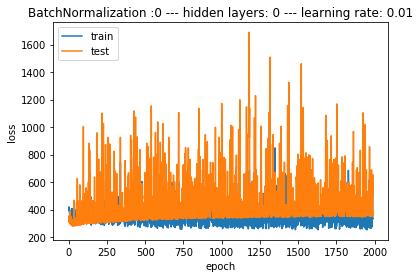

Train on 960 samples, validate on 241 samples
Epoch 1/2000
960/960 [==============================] - 3s 3ms/step - loss: 590155.0467 - val_loss: 4453.0890
Epoch 2/2000
960/960 [==============================] - 0s 312us/step - loss: 1203.7406 - val_loss: 450.2796
Epoch 3/2000
960/960 [==============================] - 0s 327us/step - loss: 490.4403 - val_loss: 440.4689
Epoch 4/2000
960/960 [==============================] - 0s 326us/step - loss: 429.1996 - val_loss: 342.8268
Epoch 5/2000
960/960 [==============================] - 0s 334us/step - loss: 409.0201 - val_loss: 341.9869
Epoch 6/2000
960/960 [==============================] - 0s 322us/step - loss: 397.4172 - val_loss: 346.9450
Epoch 7/2000
960/960 [==============================] - 0s 323us/step - loss: 396.8578 - val_loss: 349.0524
Epoch 8/2000
960/960 [==============================] - 0s 321us/step - loss: 405.5953 - val_loss: 340.2748
Epoch 9/2000
960/960 [==============================] - 0s 323us/step - loss: 410.2963 

Epoch 76/2000
960/960 [==============================] - 0s 350us/step - loss: 321.9557 - val_loss: 295.1911
Epoch 77/2000
960/960 [==============================] - 0s 317us/step - loss: 331.9480 - val_loss: 408.8784
Epoch 78/2000
960/960 [==============================] - 0s 327us/step - loss: 372.2709 - val_loss: 309.3858
Epoch 79/2000
960/960 [==============================] - 0s 324us/step - loss: 350.6241 - val_loss: 477.2265
Epoch 80/2000
960/960 [==============================] - 0s 342us/step - loss: 427.7476 - val_loss: 293.5894
Epoch 81/2000
960/960 [==============================] - 0s 323us/step - loss: 404.9876 - val_loss: 419.9331
Epoch 82/2000
960/960 [==============================] - 0s 327us/step - loss: 338.1545 - val_loss: 297.5115
Epoch 83/2000
960/960 [==============================] - 0s 323us/step - loss: 335.1688 - val_loss: 340.0990
Epoch 84/2000
960/960 [==============================] - 0s 330us/step - loss: 344.4102 - val_loss: 335.1694
Epoch 85/2000
960/9

960/960 [==============================] - 0s 339us/step - loss: 341.8459 - val_loss: 321.5503
Epoch 151/2000
960/960 [==============================] - 0s 322us/step - loss: 309.6325 - val_loss: 356.8067
Epoch 152/2000
960/960 [==============================] - 0s 306us/step - loss: 323.3048 - val_loss: 294.8413
Epoch 153/2000
960/960 [==============================] - 0s 322us/step - loss: 299.6501 - val_loss: 295.4786
Epoch 154/2000
960/960 [==============================] - 0s 318us/step - loss: 346.6494 - val_loss: 494.3140
Epoch 155/2000
960/960 [==============================] - 0s 320us/step - loss: 334.7997 - val_loss: 312.4227
Epoch 156/2000
960/960 [==============================] - 0s 304us/step - loss: 304.2224 - val_loss: 299.7108
Epoch 157/2000
960/960 [==============================] - 0s 327us/step - loss: 315.8837 - val_loss: 295.7725
Epoch 158/2000
960/960 [==============================] - 0s 327us/step - loss: 309.5893 - val_loss: 295.9503
Epoch 159/2000
960/960 [=

960/960 [==============================] - 0s 336us/step - loss: 311.4064 - val_loss: 301.0553
Epoch 225/2000
960/960 [==============================] - 0s 318us/step - loss: 326.8983 - val_loss: 307.6362
Epoch 226/2000
960/960 [==============================] - 0s 316us/step - loss: 295.1183 - val_loss: 309.3483
Epoch 227/2000
960/960 [==============================] - 0s 329us/step - loss: 322.7804 - val_loss: 310.3749
Epoch 228/2000
960/960 [==============================] - 0s 326us/step - loss: 344.7864 - val_loss: 302.4126
Epoch 229/2000
960/960 [==============================] - 0s 323us/step - loss: 306.2768 - val_loss: 295.8194
Epoch 230/2000
960/960 [==============================] - 0s 314us/step - loss: 293.9036 - val_loss: 302.8996
Epoch 231/2000
960/960 [==============================] - 0s 330us/step - loss: 318.0827 - val_loss: 295.9803
Epoch 232/2000
960/960 [==============================] - 0s 327us/step - loss: 298.5870 - val_loss: 296.8880
Epoch 233/2000
960/960 [=

960/960 [==============================] - 0s 353us/step - loss: 308.0099 - val_loss: 416.2545
Epoch 299/2000
960/960 [==============================] - 0s 338us/step - loss: 336.4713 - val_loss: 337.9334
Epoch 300/2000
960/960 [==============================] - 0s 329us/step - loss: 297.3234 - val_loss: 303.4401
Epoch 301/2000
960/960 [==============================] - 0s 328us/step - loss: 295.2737 - val_loss: 325.6181
Epoch 302/2000
960/960 [==============================] - 0s 325us/step - loss: 343.2576 - val_loss: 309.3439
Epoch 303/2000
960/960 [==============================] - 0s 325us/step - loss: 301.8479 - val_loss: 314.8234
Epoch 304/2000
960/960 [==============================] - 0s 313us/step - loss: 305.6294 - val_loss: 308.5569
Epoch 305/2000
960/960 [==============================] - 0s 281us/step - loss: 302.7352 - val_loss: 309.7342
Epoch 306/2000
960/960 [==============================] - 0s 297us/step - loss: 293.5869 - val_loss: 320.5171
Epoch 307/2000
960/960 [=

960/960 [==============================] - 0s 321us/step - loss: 310.8827 - val_loss: 326.7226
Epoch 373/2000
960/960 [==============================] - 0s 320us/step - loss: 298.8947 - val_loss: 306.2792
Epoch 374/2000
960/960 [==============================] - 0s 320us/step - loss: 292.2277 - val_loss: 350.1262
Epoch 375/2000
960/960 [==============================] - 0s 314us/step - loss: 303.2990 - val_loss: 346.8993
Epoch 376/2000
960/960 [==============================] - 0s 332us/step - loss: 333.9810 - val_loss: 324.9074
Epoch 377/2000
960/960 [==============================] - 0s 339us/step - loss: 290.1567 - val_loss: 297.3563
Epoch 378/2000
960/960 [==============================] - 0s 328us/step - loss: 302.0180 - val_loss: 297.4704
Epoch 379/2000
960/960 [==============================] - 0s 331us/step - loss: 329.6050 - val_loss: 338.9751
Epoch 380/2000
960/960 [==============================] - 0s 320us/step - loss: 340.6526 - val_loss: 339.4649
Epoch 381/2000
960/960 [=

960/960 [==============================] - 0s 344us/step - loss: 285.2987 - val_loss: 307.4435
Epoch 447/2000
960/960 [==============================] - 0s 326us/step - loss: 279.8434 - val_loss: 307.1940
Epoch 448/2000
960/960 [==============================] - 0s 327us/step - loss: 303.7275 - val_loss: 336.5070
Epoch 449/2000
960/960 [==============================] - 0s 323us/step - loss: 303.0423 - val_loss: 307.0520
Epoch 450/2000
960/960 [==============================] - 0s 323us/step - loss: 285.5322 - val_loss: 299.7281
Epoch 451/2000
960/960 [==============================] - 0s 334us/step - loss: 292.6453 - val_loss: 359.5299
Epoch 452/2000
960/960 [==============================] - 0s 322us/step - loss: 324.6893 - val_loss: 301.7820
Epoch 453/2000
960/960 [==============================] - 0s 315us/step - loss: 302.9367 - val_loss: 330.8018
Epoch 454/2000
960/960 [==============================] - 0s 331us/step - loss: 298.2984 - val_loss: 315.6884
Epoch 455/2000
960/960 [=

960/960 [==============================] - 0s 348us/step - loss: 298.1862 - val_loss: 301.7041
Epoch 521/2000
960/960 [==============================] - 0s 341us/step - loss: 278.4306 - val_loss: 334.1362
Epoch 522/2000
960/960 [==============================] - 0s 333us/step - loss: 284.9029 - val_loss: 313.3865
Epoch 523/2000
960/960 [==============================] - 0s 330us/step - loss: 314.5356 - val_loss: 361.9375
Epoch 524/2000
960/960 [==============================] - 0s 342us/step - loss: 286.0846 - val_loss: 302.4493
Epoch 525/2000
960/960 [==============================] - 0s 332us/step - loss: 286.9148 - val_loss: 337.8415
Epoch 526/2000
960/960 [==============================] - 0s 318us/step - loss: 278.6661 - val_loss: 302.6838
Epoch 527/2000
960/960 [==============================] - 0s 330us/step - loss: 283.0663 - val_loss: 371.5907
Epoch 528/2000
960/960 [==============================] - 0s 334us/step - loss: 288.8807 - val_loss: 306.2802
Epoch 529/2000
960/960 [=

960/960 [==============================] - 0s 342us/step - loss: 279.8948 - val_loss: 307.7506
Epoch 595/2000
960/960 [==============================] - 0s 322us/step - loss: 295.1829 - val_loss: 339.9001
Epoch 596/2000
960/960 [==============================] - 0s 326us/step - loss: 284.5871 - val_loss: 303.7986
Epoch 597/2000
960/960 [==============================] - 0s 334us/step - loss: 280.0468 - val_loss: 305.4394
Epoch 598/2000
960/960 [==============================] - 0s 335us/step - loss: 300.9870 - val_loss: 332.9809
Epoch 599/2000
960/960 [==============================] - 0s 327us/step - loss: 297.7230 - val_loss: 348.0103
Epoch 600/2000
960/960 [==============================] - 0s 331us/step - loss: 289.0934 - val_loss: 305.5001
Epoch 601/2000
960/960 [==============================] - 0s 327us/step - loss: 295.2641 - val_loss: 312.2070
Epoch 602/2000
960/960 [==============================] - 0s 327us/step - loss: 282.5623 - val_loss: 305.1672
Epoch 603/2000
960/960 [=

960/960 [==============================] - 0s 346us/step - loss: 318.8161 - val_loss: 306.1472
Epoch 669/2000
960/960 [==============================] - 0s 322us/step - loss: 291.5071 - val_loss: 356.9042
Epoch 670/2000
960/960 [==============================] - 0s 339us/step - loss: 280.3500 - val_loss: 304.9104
Epoch 671/2000
960/960 [==============================] - 0s 340us/step - loss: 277.9531 - val_loss: 313.8568
Epoch 672/2000
960/960 [==============================] - 0s 356us/step - loss: 275.9363 - val_loss: 313.4385
Epoch 673/2000
960/960 [==============================] - 0s 330us/step - loss: 301.2973 - val_loss: 307.4034
Epoch 674/2000
960/960 [==============================] - 0s 334us/step - loss: 286.6283 - val_loss: 349.6911
Epoch 675/2000
960/960 [==============================] - 0s 335us/step - loss: 280.3021 - val_loss: 309.7353
Epoch 676/2000
960/960 [==============================] - 0s 336us/step - loss: 299.9728 - val_loss: 350.8474
Epoch 677/2000
960/960 [=

960/960 [==============================] - 0s 340us/step - loss: 330.1909 - val_loss: 386.2004
Epoch 743/2000
960/960 [==============================] - 0s 328us/step - loss: 320.9579 - val_loss: 351.6789
Epoch 744/2000
960/960 [==============================] - 0s 283us/step - loss: 280.3001 - val_loss: 307.7920
Epoch 745/2000
960/960 [==============================] - 0s 333us/step - loss: 281.2177 - val_loss: 381.3920
Epoch 746/2000
960/960 [==============================] - 0s 321us/step - loss: 303.9784 - val_loss: 311.4378
Epoch 747/2000
960/960 [==============================] - 0s 327us/step - loss: 284.5995 - val_loss: 338.2369
Epoch 748/2000
960/960 [==============================] - 0s 333us/step - loss: 292.1195 - val_loss: 370.1161
Epoch 749/2000
960/960 [==============================] - 0s 321us/step - loss: 303.0125 - val_loss: 320.8545
Epoch 750/2000
960/960 [==============================] - 0s 309us/step - loss: 276.5173 - val_loss: 332.3350
Epoch 751/2000
960/960 [=

960/960 [==============================] - 0s 326us/step - loss: 290.0023 - val_loss: 318.5332
Epoch 817/2000
960/960 [==============================] - 0s 334us/step - loss: 278.5254 - val_loss: 322.3053
Epoch 818/2000
960/960 [==============================] - 0s 320us/step - loss: 280.5057 - val_loss: 307.6844
Epoch 819/2000
960/960 [==============================] - 0s 321us/step - loss: 310.5063 - val_loss: 308.7512
Epoch 820/2000
960/960 [==============================] - 0s 309us/step - loss: 344.0510 - val_loss: 307.5189
Epoch 821/2000
960/960 [==============================] - 0s 299us/step - loss: 298.6265 - val_loss: 341.1294
Epoch 822/2000
960/960 [==============================] - 0s 302us/step - loss: 300.9014 - val_loss: 442.2428
Epoch 823/2000
960/960 [==============================] - 0s 312us/step - loss: 300.9190 - val_loss: 309.8831
Epoch 824/2000
960/960 [==============================] - 0s 322us/step - loss: 311.2435 - val_loss: 329.0424
Epoch 825/2000
960/960 [=

960/960 [==============================] - 0s 357us/step - loss: 269.3520 - val_loss: 344.2920
Epoch 891/2000
960/960 [==============================] - 0s 330us/step - loss: 306.8870 - val_loss: 376.4099
Epoch 892/2000
960/960 [==============================] - 0s 311us/step - loss: 305.1355 - val_loss: 310.6147
Epoch 893/2000
960/960 [==============================] - 0s 323us/step - loss: 288.8563 - val_loss: 312.4903
Epoch 894/2000
960/960 [==============================] - 0s 326us/step - loss: 279.1276 - val_loss: 372.2165
Epoch 895/2000
960/960 [==============================] - 0s 323us/step - loss: 277.8684 - val_loss: 313.1853
Epoch 896/2000
960/960 [==============================] - 0s 311us/step - loss: 268.3420 - val_loss: 310.7168
Epoch 897/2000
960/960 [==============================] - 0s 326us/step - loss: 267.3530 - val_loss: 312.0877
Epoch 898/2000
960/960 [==============================] - 0s 321us/step - loss: 285.8324 - val_loss: 316.1796
Epoch 899/2000
960/960 [=

960/960 [==============================] - 0s 349us/step - loss: 281.8364 - val_loss: 311.2124
Epoch 965/2000
960/960 [==============================] - 0s 321us/step - loss: 288.2581 - val_loss: 341.2523
Epoch 966/2000
960/960 [==============================] - 0s 332us/step - loss: 306.8117 - val_loss: 326.8787
Epoch 967/2000
960/960 [==============================] - 0s 327us/step - loss: 295.3989 - val_loss: 375.1355
Epoch 968/2000
960/960 [==============================] - 0s 334us/step - loss: 274.9162 - val_loss: 311.4552
Epoch 969/2000
960/960 [==============================] - 0s 328us/step - loss: 278.5500 - val_loss: 366.4991
Epoch 970/2000
960/960 [==============================] - 0s 328us/step - loss: 282.2241 - val_loss: 330.2348
Epoch 971/2000
960/960 [==============================] - 0s 320us/step - loss: 292.3191 - val_loss: 411.6983
Epoch 972/2000
960/960 [==============================] - 0s 331us/step - loss: 317.5172 - val_loss: 353.9465
Epoch 973/2000
960/960 [=

960/960 [==============================] - 0s 350us/step - loss: 281.9051 - val_loss: 310.9313
Epoch 1039/2000
960/960 [==============================] - 0s 332us/step - loss: 273.6612 - val_loss: 356.3380
Epoch 1040/2000
960/960 [==============================] - 0s 323us/step - loss: 290.8017 - val_loss: 316.5363
Epoch 1041/2000
960/960 [==============================] - 0s 331us/step - loss: 302.5296 - val_loss: 315.0547
Epoch 1042/2000
960/960 [==============================] - 0s 325us/step - loss: 284.5283 - val_loss: 311.2136
Epoch 1043/2000
960/960 [==============================] - 0s 321us/step - loss: 287.6257 - val_loss: 316.2740
Epoch 1044/2000
960/960 [==============================] - 0s 320us/step - loss: 288.9848 - val_loss: 338.9236
Epoch 1045/2000
960/960 [==============================] - 0s 332us/step - loss: 267.9563 - val_loss: 311.3539
Epoch 1046/2000
960/960 [==============================] - 0s 324us/step - loss: 282.9386 - val_loss: 340.8974
Epoch 1047/2000
9

Epoch 1112/2000
960/960 [==============================] - 0s 302us/step - loss: 286.3799 - val_loss: 316.9041
Epoch 1113/2000
960/960 [==============================] - 0s 329us/step - loss: 295.2467 - val_loss: 317.9151
Epoch 1114/2000
960/960 [==============================] - 0s 331us/step - loss: 314.5218 - val_loss: 439.8826
Epoch 1115/2000
960/960 [==============================] - 0s 327us/step - loss: 348.2401 - val_loss: 351.7277
Epoch 1116/2000
960/960 [==============================] - 0s 318us/step - loss: 299.1664 - val_loss: 337.0144
Epoch 1117/2000
960/960 [==============================] - 0s 329us/step - loss: 313.7906 - val_loss: 311.6850
Epoch 1118/2000
960/960 [==============================] - 0s 320us/step - loss: 285.6216 - val_loss: 311.3966
Epoch 1119/2000
960/960 [==============================] - 0s 322us/step - loss: 265.9307 - val_loss: 312.7575
Epoch 1120/2000
960/960 [==============================] - 0s 317us/step - loss: 276.7230 - val_loss: 354.7044
E

Epoch 1186/2000
960/960 [==============================] - 0s 340us/step - loss: 268.4249 - val_loss: 320.4549
Epoch 1187/2000
960/960 [==============================] - 0s 335us/step - loss: 272.1169 - val_loss: 328.2442
Epoch 1188/2000
960/960 [==============================] - 0s 329us/step - loss: 272.5138 - val_loss: 318.0299
Epoch 1189/2000
960/960 [==============================] - 0s 325us/step - loss: 273.0879 - val_loss: 315.2919
Epoch 1190/2000
960/960 [==============================] - 0s 321us/step - loss: 272.5517 - val_loss: 377.6640
Epoch 1191/2000
960/960 [==============================] - 0s 332us/step - loss: 270.3137 - val_loss: 315.2911
Epoch 1192/2000
960/960 [==============================] - 0s 327us/step - loss: 266.0927 - val_loss: 322.2689
Epoch 1193/2000
960/960 [==============================] - 0s 328us/step - loss: 280.3575 - val_loss: 334.4585
Epoch 1194/2000
960/960 [==============================] - 0s 318us/step - loss: 272.8394 - val_loss: 336.1723
E

Epoch 1260/2000
960/960 [==============================] - 0s 357us/step - loss: 271.8526 - val_loss: 314.4084
Epoch 1261/2000
960/960 [==============================] - 0s 329us/step - loss: 273.1527 - val_loss: 346.1684
Epoch 1262/2000
960/960 [==============================] - 0s 323us/step - loss: 271.0272 - val_loss: 333.2954
Epoch 1263/2000
960/960 [==============================] - 0s 335us/step - loss: 272.5424 - val_loss: 315.0248
Epoch 1264/2000
960/960 [==============================] - 0s 339us/step - loss: 291.5975 - val_loss: 354.5259
Epoch 1265/2000
960/960 [==============================] - 0s 323us/step - loss: 279.7524 - val_loss: 316.3894
Epoch 1266/2000
960/960 [==============================] - 0s 324us/step - loss: 273.9291 - val_loss: 336.4371
Epoch 1267/2000
960/960 [==============================] - 0s 331us/step - loss: 262.2637 - val_loss: 316.1443
Epoch 1268/2000
960/960 [==============================] - 0s 330us/step - loss: 282.4932 - val_loss: 334.1808
E

Epoch 1334/2000
960/960 [==============================] - 0s 330us/step - loss: 306.5361 - val_loss: 314.4578
Epoch 1335/2000
960/960 [==============================] - 0s 328us/step - loss: 289.6373 - val_loss: 439.0429
Epoch 1336/2000
960/960 [==============================] - 0s 332us/step - loss: 285.6720 - val_loss: 314.3605
Epoch 1337/2000
960/960 [==============================] - 0s 332us/step - loss: 268.4716 - val_loss: 338.1213
Epoch 1338/2000
960/960 [==============================] - 0s 327us/step - loss: 267.1531 - val_loss: 315.8893
Epoch 1339/2000
960/960 [==============================] - 0s 333us/step - loss: 277.1613 - val_loss: 316.9422
Epoch 1340/2000
960/960 [==============================] - 0s 320us/step - loss: 268.8511 - val_loss: 368.9713
Epoch 1341/2000
960/960 [==============================] - 0s 325us/step - loss: 286.7149 - val_loss: 319.4738
Epoch 1342/2000
960/960 [==============================] - 0s 330us/step - loss: 276.0751 - val_loss: 332.8041
E

Epoch 1408/2000
960/960 [==============================] - 0s 336us/step - loss: 317.1322 - val_loss: 327.4094
Epoch 1409/2000
960/960 [==============================] - 0s 325us/step - loss: 276.9070 - val_loss: 314.1159
Epoch 1410/2000
960/960 [==============================] - 0s 325us/step - loss: 271.0700 - val_loss: 327.5463
Epoch 1411/2000
960/960 [==============================] - 0s 327us/step - loss: 293.9637 - val_loss: 337.6234
Epoch 1412/2000
960/960 [==============================] - 0s 334us/step - loss: 281.4844 - val_loss: 345.6803
Epoch 1413/2000
960/960 [==============================] - 0s 318us/step - loss: 274.6958 - val_loss: 315.3571
Epoch 1414/2000
960/960 [==============================] - 0s 317us/step - loss: 285.2183 - val_loss: 453.3545
Epoch 1415/2000
960/960 [==============================] - 0s 333us/step - loss: 356.2113 - val_loss: 355.8658
Epoch 1416/2000
960/960 [==============================] - 0s 329us/step - loss: 314.3904 - val_loss: 380.7226
E

Epoch 1482/2000
960/960 [==============================] - 0s 330us/step - loss: 283.2764 - val_loss: 331.1416
Epoch 1483/2000
960/960 [==============================] - 0s 320us/step - loss: 278.7580 - val_loss: 325.6883
Epoch 1484/2000
960/960 [==============================] - 0s 328us/step - loss: 265.1444 - val_loss: 319.4349
Epoch 1485/2000
960/960 [==============================] - 0s 331us/step - loss: 282.1933 - val_loss: 342.0757
Epoch 1486/2000
960/960 [==============================] - 0s 324us/step - loss: 274.1836 - val_loss: 354.8509
Epoch 1487/2000
960/960 [==============================] - 0s 323us/step - loss: 302.2718 - val_loss: 320.5517
Epoch 1488/2000
960/960 [==============================] - 0s 327us/step - loss: 279.4641 - val_loss: 352.8984
Epoch 1489/2000
960/960 [==============================] - 0s 325us/step - loss: 275.9950 - val_loss: 322.4807
Epoch 1490/2000
960/960 [==============================] - 0s 331us/step - loss: 292.5331 - val_loss: 390.2630
E

Epoch 1556/2000
960/960 [==============================] - 0s 341us/step - loss: 276.7663 - val_loss: 332.3492
Epoch 1557/2000
960/960 [==============================] - 0s 311us/step - loss: 268.3302 - val_loss: 333.2736
Epoch 1558/2000
960/960 [==============================] - 0s 314us/step - loss: 277.0068 - val_loss: 328.5880
Epoch 1559/2000
960/960 [==============================] - 0s 331us/step - loss: 273.9634 - val_loss: 321.9348
Epoch 1560/2000
960/960 [==============================] - 0s 317us/step - loss: 295.9025 - val_loss: 332.5270
Epoch 1561/2000
960/960 [==============================] - 0s 331us/step - loss: 274.1721 - val_loss: 345.4198
Epoch 1562/2000
960/960 [==============================] - 0s 320us/step - loss: 272.3417 - val_loss: 397.1954
Epoch 1563/2000
960/960 [==============================] - 0s 325us/step - loss: 312.1605 - val_loss: 390.9769
Epoch 1564/2000
960/960 [==============================] - 0s 311us/step - loss: 277.8758 - val_loss: 320.0288
E

Epoch 1630/2000
960/960 [==============================] - 0s 356us/step - loss: 267.8344 - val_loss: 378.6937
Epoch 1631/2000
960/960 [==============================] - 0s 355us/step - loss: 270.3779 - val_loss: 317.9392
Epoch 1632/2000
960/960 [==============================] - 0s 345us/step - loss: 268.4223 - val_loss: 318.4763
Epoch 1633/2000
960/960 [==============================] - 0s 350us/step - loss: 264.5213 - val_loss: 319.0651
Epoch 1634/2000
960/960 [==============================] - 0s 353us/step - loss: 266.4002 - val_loss: 344.2947
Epoch 1635/2000
960/960 [==============================] - 0s 357us/step - loss: 274.3101 - val_loss: 336.1460
Epoch 1636/2000
960/960 [==============================] - 0s 356us/step - loss: 266.5022 - val_loss: 338.9111
Epoch 1637/2000
960/960 [==============================] - 0s 344us/step - loss: 282.6585 - val_loss: 339.5966
Epoch 1638/2000
960/960 [==============================] - 0s 360us/step - loss: 355.7755 - val_loss: 374.7774
E

Epoch 1704/2000
960/960 [==============================] - 0s 332us/step - loss: 267.8203 - val_loss: 381.9054
Epoch 1705/2000
960/960 [==============================] - 0s 322us/step - loss: 272.0385 - val_loss: 361.8570
Epoch 1706/2000
960/960 [==============================] - 0s 328us/step - loss: 282.8850 - val_loss: 324.3060
Epoch 1707/2000
960/960 [==============================] - 0s 322us/step - loss: 265.2235 - val_loss: 332.1688
Epoch 1708/2000
960/960 [==============================] - 0s 324us/step - loss: 264.7215 - val_loss: 334.7814
Epoch 1709/2000
960/960 [==============================] - 0s 328us/step - loss: 263.3388 - val_loss: 323.8245
Epoch 1710/2000
960/960 [==============================] - 0s 325us/step - loss: 278.2435 - val_loss: 326.7666
Epoch 1711/2000
960/960 [==============================] - 0s 326us/step - loss: 264.3854 - val_loss: 326.6607
Epoch 1712/2000
960/960 [==============================] - 0s 312us/step - loss: 266.0202 - val_loss: 333.2322
E

Epoch 1778/2000
960/960 [==============================] - 0s 339us/step - loss: 325.6841 - val_loss: 320.0301
Epoch 1779/2000
960/960 [==============================] - 0s 335us/step - loss: 282.0109 - val_loss: 319.5119
Epoch 1780/2000
960/960 [==============================] - 0s 336us/step - loss: 273.2788 - val_loss: 439.9575
Epoch 1781/2000
960/960 [==============================] - 0s 325us/step - loss: 277.6336 - val_loss: 319.6984
Epoch 1782/2000
960/960 [==============================] - 0s 317us/step - loss: 293.2327 - val_loss: 486.7676
Epoch 1783/2000
960/960 [==============================] - 0s 323us/step - loss: 276.1903 - val_loss: 322.8308
Epoch 1784/2000
960/960 [==============================] - 0s 317us/step - loss: 281.2200 - val_loss: 399.6914
Epoch 1785/2000
960/960 [==============================] - 0s 319us/step - loss: 270.8486 - val_loss: 338.4111
Epoch 1786/2000
960/960 [==============================] - 0s 332us/step - loss: 264.7240 - val_loss: 347.9787
E

Epoch 1852/2000
960/960 [==============================] - 0s 336us/step - loss: 263.8306 - val_loss: 360.4175
Epoch 1853/2000
960/960 [==============================] - 0s 321us/step - loss: 268.4946 - val_loss: 376.9330
Epoch 1854/2000
960/960 [==============================] - 0s 326us/step - loss: 284.9272 - val_loss: 325.7475
Epoch 1855/2000
960/960 [==============================] - 0s 331us/step - loss: 266.9968 - val_loss: 323.3792
Epoch 1856/2000
960/960 [==============================] - 0s 323us/step - loss: 268.3173 - val_loss: 337.3525
Epoch 1857/2000
960/960 [==============================] - 0s 313us/step - loss: 278.7402 - val_loss: 326.5076
Epoch 1858/2000
960/960 [==============================] - 0s 319us/step - loss: 273.9053 - val_loss: 407.6458
Epoch 1859/2000
960/960 [==============================] - 0s 323us/step - loss: 286.6872 - val_loss: 327.9233
Epoch 1860/2000
960/960 [==============================] - 0s 326us/step - loss: 276.8447 - val_loss: 348.3729
E

960/960 [==============================] - 0s 349us/step - loss: 290.5483 - val_loss: 341.1977
Epoch 1926/2000
960/960 [==============================] - 0s 329us/step - loss: 261.9260 - val_loss: 329.1533
Epoch 1927/2000
960/960 [==============================] - 0s 335us/step - loss: 261.7402 - val_loss: 326.3459
Epoch 1928/2000
960/960 [==============================] - 0s 323us/step - loss: 275.2362 - val_loss: 406.9810
Epoch 1929/2000
960/960 [==============================] - 0s 322us/step - loss: 284.4810 - val_loss: 396.5787
Epoch 1930/2000
960/960 [==============================] - 0s 331us/step - loss: 293.4714 - val_loss: 360.8048
Epoch 1931/2000
960/960 [==============================] - 0s 331us/step - loss: 307.6416 - val_loss: 358.8429
Epoch 1932/2000
960/960 [==============================] - 0s 336us/step - loss: 276.8636 - val_loss: 337.7190
Epoch 1933/2000
960/960 [==============================] - 0s 337us/step - loss: 277.2296 - val_loss: 324.3946
Epoch 1934/2000
9

Epoch 1999/2000
960/960 [==============================] - 0s 331us/step - loss: 275.2978 - val_loss: 329.8034
Epoch 2000/2000
960/960 [==============================] - 0s 326us/step - loss: 298.3628 - val_loss: 605.1736


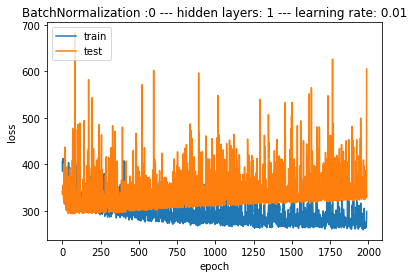

Train on 960 samples, validate on 241 samples
Epoch 1/2000
960/960 [==============================] - 3s 3ms/step - loss: 576714.3703 - val_loss: 3522.8303
Epoch 2/2000
960/960 [==============================] - 0s 251us/step - loss: 1744.2157 - val_loss: 470.4858
Epoch 3/2000
960/960 [==============================] - 0s 265us/step - loss: 496.1380 - val_loss: 465.1567
Epoch 4/2000
960/960 [==============================] - 0s 264us/step - loss: 434.6997 - val_loss: 340.6618
Epoch 5/2000
960/960 [==============================] - 0s 265us/step - loss: 441.0962 - val_loss: 423.5132
Epoch 6/2000
960/960 [==============================] - 0s 258us/step - loss: 437.6975 - val_loss: 354.8507
Epoch 7/2000
960/960 [==============================] - 0s 279us/step - loss: 449.6207 - val_loss: 333.0327
Epoch 8/2000
960/960 [==============================] - 0s 259us/step - loss: 415.9004 - val_loss: 354.5241
Epoch 9/2000
960/960 [==============================] - 0s 278us/step - loss: 398.8215 

Epoch 76/2000
960/960 [==============================] - 0s 262us/step - loss: 334.8615 - val_loss: 399.3972
Epoch 77/2000
960/960 [==============================] - 0s 270us/step - loss: 384.3407 - val_loss: 340.7349
Epoch 78/2000
960/960 [==============================] - 0s 240us/step - loss: 335.1346 - val_loss: 293.4066
Epoch 79/2000
960/960 [==============================] - 0s 264us/step - loss: 322.1961 - val_loss: 306.4301
Epoch 80/2000
960/960 [==============================] - 0s 272us/step - loss: 366.8969 - val_loss: 331.8962
Epoch 81/2000
960/960 [==============================] - 0s 279us/step - loss: 337.2936 - val_loss: 304.8588
Epoch 82/2000
960/960 [==============================] - 0s 284us/step - loss: 335.9161 - val_loss: 314.7381
Epoch 83/2000
960/960 [==============================] - 0s 288us/step - loss: 347.4268 - val_loss: 301.8808
Epoch 84/2000
960/960 [==============================] - 0s 279us/step - loss: 323.3153 - val_loss: 297.9170
Epoch 85/2000
960/9

960/960 [==============================] - 0s 289us/step - loss: 310.9606 - val_loss: 294.4845
Epoch 151/2000
960/960 [==============================] - 0s 271us/step - loss: 307.3301 - val_loss: 298.4132
Epoch 152/2000
960/960 [==============================] - 0s 245us/step - loss: 304.7467 - val_loss: 301.7767
Epoch 153/2000
960/960 [==============================] - 0s 243us/step - loss: 311.8149 - val_loss: 295.9094
Epoch 154/2000
960/960 [==============================] - 0s 264us/step - loss: 328.5545 - val_loss: 333.7279
Epoch 155/2000
960/960 [==============================] - 0s 290us/step - loss: 344.5693 - val_loss: 342.4683
Epoch 156/2000
960/960 [==============================] - 0s 277us/step - loss: 330.7178 - val_loss: 415.1428
Epoch 157/2000
960/960 [==============================] - 0s 261us/step - loss: 374.5606 - val_loss: 295.8172
Epoch 158/2000
960/960 [==============================] - 0s 262us/step - loss: 320.7108 - val_loss: 359.8559
Epoch 159/2000
960/960 [=

960/960 [==============================] - 0s 317us/step - loss: 372.5417 - val_loss: 298.1254
Epoch 225/2000
960/960 [==============================] - 0s 257us/step - loss: 350.6137 - val_loss: 424.8225
Epoch 226/2000
960/960 [==============================] - 0s 251us/step - loss: 315.9445 - val_loss: 296.7905
Epoch 227/2000
960/960 [==============================] - 0s 270us/step - loss: 300.6235 - val_loss: 299.8760
Epoch 228/2000
960/960 [==============================] - 0s 287us/step - loss: 326.9950 - val_loss: 299.6601
Epoch 229/2000
960/960 [==============================] - 0s 266us/step - loss: 306.9068 - val_loss: 308.6435
Epoch 230/2000
960/960 [==============================] - 0s 274us/step - loss: 315.9989 - val_loss: 423.8106
Epoch 231/2000
960/960 [==============================] - 0s 268us/step - loss: 304.2276 - val_loss: 298.4062
Epoch 232/2000
960/960 [==============================] - 0s 290us/step - loss: 290.8127 - val_loss: 302.5461
Epoch 233/2000
960/960 [=

960/960 [==============================] - 0s 239us/step - loss: 288.8030 - val_loss: 302.4438
Epoch 299/2000
960/960 [==============================] - 0s 286us/step - loss: 337.8923 - val_loss: 312.5697
Epoch 300/2000
960/960 [==============================] - 0s 252us/step - loss: 314.6598 - val_loss: 312.8724
Epoch 301/2000
960/960 [==============================] - 0s 275us/step - loss: 295.8700 - val_loss: 297.9079
Epoch 302/2000
960/960 [==============================] - 0s 268us/step - loss: 333.3207 - val_loss: 354.7240
Epoch 303/2000
960/960 [==============================] - 0s 269us/step - loss: 321.2816 - val_loss: 373.6906
Epoch 304/2000
960/960 [==============================] - 0s 267us/step - loss: 328.9472 - val_loss: 370.3744
Epoch 305/2000
960/960 [==============================] - 0s 247us/step - loss: 330.3146 - val_loss: 337.2062
Epoch 306/2000
960/960 [==============================] - 0s 262us/step - loss: 341.0042 - val_loss: 348.8516
Epoch 307/2000
960/960 [=

960/960 [==============================] - 0s 282us/step - loss: 289.4916 - val_loss: 323.5868
Epoch 373/2000
960/960 [==============================] - 0s 280us/step - loss: 290.0213 - val_loss: 352.4753
Epoch 374/2000
960/960 [==============================] - 0s 268us/step - loss: 312.9025 - val_loss: 304.3201
Epoch 375/2000
960/960 [==============================] - 0s 259us/step - loss: 313.9241 - val_loss: 313.1285
Epoch 376/2000
960/960 [==============================] - 0s 256us/step - loss: 315.8652 - val_loss: 423.7498
Epoch 377/2000
960/960 [==============================] - 0s 245us/step - loss: 301.9107 - val_loss: 301.6979
Epoch 378/2000
960/960 [==============================] - 0s 247us/step - loss: 288.6540 - val_loss: 359.1885
Epoch 379/2000
960/960 [==============================] - 0s 249us/step - loss: 297.8318 - val_loss: 302.0517
Epoch 380/2000
960/960 [==============================] - 0s 264us/step - loss: 310.9810 - val_loss: 312.6376
Epoch 381/2000
960/960 [=

960/960 [==============================] - 0s 270us/step - loss: 293.8691 - val_loss: 304.4506
Epoch 447/2000
960/960 [==============================] - 0s 258us/step - loss: 283.3868 - val_loss: 312.9916
Epoch 448/2000
960/960 [==============================] - 0s 253us/step - loss: 291.6625 - val_loss: 313.8516
Epoch 449/2000
960/960 [==============================] - 0s 253us/step - loss: 289.4817 - val_loss: 365.4088
Epoch 450/2000
960/960 [==============================] - 0s 244us/step - loss: 284.4626 - val_loss: 306.6567
Epoch 451/2000
960/960 [==============================] - 0s 233us/step - loss: 278.6081 - val_loss: 348.7887
Epoch 452/2000
960/960 [==============================] - 0s 244us/step - loss: 289.0598 - val_loss: 310.7665
Epoch 453/2000
960/960 [==============================] - 0s 263us/step - loss: 283.6427 - val_loss: 312.1765
Epoch 454/2000
960/960 [==============================] - 0s 266us/step - loss: 292.7118 - val_loss: 314.6323
Epoch 455/2000
960/960 [=

960/960 [==============================] - 0s 258us/step - loss: 294.0732 - val_loss: 301.0714
Epoch 521/2000
960/960 [==============================] - 0s 293us/step - loss: 292.9984 - val_loss: 303.2491
Epoch 522/2000
960/960 [==============================] - 0s 263us/step - loss: 301.5469 - val_loss: 325.5615
Epoch 523/2000
960/960 [==============================] - 0s 259us/step - loss: 287.3016 - val_loss: 301.5511
Epoch 524/2000
960/960 [==============================] - 0s 274us/step - loss: 310.4556 - val_loss: 323.2724
Epoch 525/2000
960/960 [==============================] - 0s 253us/step - loss: 305.5601 - val_loss: 323.6202
Epoch 526/2000
960/960 [==============================] - 0s 254us/step - loss: 284.5056 - val_loss: 312.7706
Epoch 527/2000
960/960 [==============================] - 0s 260us/step - loss: 313.6093 - val_loss: 338.5784
Epoch 528/2000
960/960 [==============================] - 0s 251us/step - loss: 335.9557 - val_loss: 516.0102
Epoch 529/2000
960/960 [=

960/960 [==============================] - 0s 264us/step - loss: 289.1930 - val_loss: 360.3411
Epoch 595/2000
960/960 [==============================] - 0s 293us/step - loss: 331.6178 - val_loss: 466.5911
Epoch 596/2000
960/960 [==============================] - 0s 276us/step - loss: 308.6953 - val_loss: 305.1181
Epoch 597/2000
960/960 [==============================] - 0s 276us/step - loss: 355.8595 - val_loss: 318.9671
Epoch 598/2000
960/960 [==============================] - 0s 279us/step - loss: 285.8588 - val_loss: 351.9820
Epoch 599/2000
960/960 [==============================] - 0s 259us/step - loss: 307.4461 - val_loss: 430.2933
Epoch 600/2000
960/960 [==============================] - 0s 272us/step - loss: 324.7067 - val_loss: 315.7676
Epoch 601/2000
960/960 [==============================] - 0s 253us/step - loss: 293.0741 - val_loss: 395.1132
Epoch 602/2000
960/960 [==============================] - 0s 265us/step - loss: 284.1793 - val_loss: 303.5886
Epoch 603/2000
960/960 [=

960/960 [==============================] - 0s 292us/step - loss: 312.0498 - val_loss: 320.0194
Epoch 669/2000
960/960 [==============================] - 0s 252us/step - loss: 281.3648 - val_loss: 329.1219
Epoch 670/2000
960/960 [==============================] - 0s 258us/step - loss: 282.7949 - val_loss: 315.6272
Epoch 671/2000
960/960 [==============================] - 0s 273us/step - loss: 290.6932 - val_loss: 339.1645
Epoch 672/2000
960/960 [==============================] - 0s 265us/step - loss: 283.9926 - val_loss: 308.7874
Epoch 673/2000
960/960 [==============================] - 0s 249us/step - loss: 282.1409 - val_loss: 309.5775
Epoch 674/2000
960/960 [==============================] - 0s 263us/step - loss: 301.0556 - val_loss: 305.8713
Epoch 675/2000
960/960 [==============================] - 0s 266us/step - loss: 283.9411 - val_loss: 365.8409
Epoch 676/2000
960/960 [==============================] - 0s 268us/step - loss: 292.1038 - val_loss: 326.0636
Epoch 677/2000
960/960 [=

960/960 [==============================] - 0s 263us/step - loss: 317.6962 - val_loss: 515.2101
Epoch 743/2000
960/960 [==============================] - 0s 286us/step - loss: 346.1720 - val_loss: 364.1206
Epoch 744/2000
960/960 [==============================] - 0s 280us/step - loss: 335.5607 - val_loss: 344.0869
Epoch 745/2000
960/960 [==============================] - 0s 260us/step - loss: 300.0161 - val_loss: 307.4899
Epoch 746/2000
960/960 [==============================] - 0s 249us/step - loss: 295.2233 - val_loss: 316.0799
Epoch 747/2000
960/960 [==============================] - 0s 257us/step - loss: 275.5757 - val_loss: 310.4405
Epoch 748/2000
960/960 [==============================] - 0s 287us/step - loss: 285.9299 - val_loss: 381.5539
Epoch 749/2000
960/960 [==============================] - 0s 259us/step - loss: 297.8939 - val_loss: 334.8936
Epoch 750/2000
960/960 [==============================] - 0s 255us/step - loss: 291.3106 - val_loss: 313.7752
Epoch 751/2000
960/960 [=

960/960 [==============================] - 0s 281us/step - loss: 273.6850 - val_loss: 407.9189
Epoch 817/2000
960/960 [==============================] - 0s 305us/step - loss: 284.7067 - val_loss: 306.4331
Epoch 818/2000
960/960 [==============================] - 0s 254us/step - loss: 317.6325 - val_loss: 323.1404
Epoch 819/2000
960/960 [==============================] - 0s 259us/step - loss: 311.5738 - val_loss: 312.3051
Epoch 820/2000
960/960 [==============================] - 0s 281us/step - loss: 331.2843 - val_loss: 477.8703
Epoch 821/2000
960/960 [==============================] - 0s 274us/step - loss: 330.3665 - val_loss: 328.3916
Epoch 822/2000
960/960 [==============================] - 0s 256us/step - loss: 282.7687 - val_loss: 418.6214
Epoch 823/2000
960/960 [==============================] - 0s 262us/step - loss: 285.4572 - val_loss: 305.6186
Epoch 824/2000
960/960 [==============================] - 0s 258us/step - loss: 276.0065 - val_loss: 306.3787
Epoch 825/2000
960/960 [=

960/960 [==============================] - 0s 274us/step - loss: 276.4581 - val_loss: 342.1959
Epoch 891/2000
960/960 [==============================] - 0s 274us/step - loss: 272.6585 - val_loss: 313.7244
Epoch 892/2000
960/960 [==============================] - 0s 276us/step - loss: 273.8274 - val_loss: 311.1411
Epoch 893/2000
960/960 [==============================] - 0s 248us/step - loss: 283.2098 - val_loss: 323.4966
Epoch 894/2000
960/960 [==============================] - 0s 251us/step - loss: 286.9462 - val_loss: 370.0511
Epoch 895/2000
960/960 [==============================] - 0s 256us/step - loss: 287.0008 - val_loss: 319.4587
Epoch 896/2000
960/960 [==============================] - 0s 255us/step - loss: 281.3217 - val_loss: 315.5659
Epoch 897/2000
960/960 [==============================] - 0s 252us/step - loss: 276.4802 - val_loss: 311.3216
Epoch 898/2000
960/960 [==============================] - 0s 256us/step - loss: 290.8451 - val_loss: 381.0722
Epoch 899/2000
960/960 [=

960/960 [==============================] - 0s 262us/step - loss: 270.4939 - val_loss: 324.8867
Epoch 965/2000
960/960 [==============================] - 0s 290us/step - loss: 271.1928 - val_loss: 313.0891
Epoch 966/2000
960/960 [==============================] - 0s 284us/step - loss: 292.3108 - val_loss: 316.3679
Epoch 967/2000
960/960 [==============================] - 0s 272us/step - loss: 284.6814 - val_loss: 381.0883
Epoch 968/2000
960/960 [==============================] - 0s 259us/step - loss: 277.3782 - val_loss: 318.6046
Epoch 969/2000
960/960 [==============================] - 0s 255us/step - loss: 299.6888 - val_loss: 313.4298
Epoch 970/2000
960/960 [==============================] - 0s 256us/step - loss: 281.2986 - val_loss: 411.1206
Epoch 971/2000
960/960 [==============================] - 0s 250us/step - loss: 323.9719 - val_loss: 371.9155
Epoch 972/2000
960/960 [==============================] - 0s 271us/step - loss: 277.6821 - val_loss: 322.3418
Epoch 973/2000
960/960 [=

960/960 [==============================] - 0s 290us/step - loss: 304.1266 - val_loss: 339.6663
Epoch 1039/2000
960/960 [==============================] - 0s 259us/step - loss: 267.7049 - val_loss: 330.8515
Epoch 1040/2000
960/960 [==============================] - 0s 272us/step - loss: 295.6230 - val_loss: 317.0278
Epoch 1041/2000
960/960 [==============================] - 0s 271us/step - loss: 313.7116 - val_loss: 321.3467
Epoch 1042/2000
960/960 [==============================] - 0s 255us/step - loss: 276.4335 - val_loss: 317.9614
Epoch 1043/2000
960/960 [==============================] - 0s 276us/step - loss: 277.5162 - val_loss: 328.3806
Epoch 1044/2000
960/960 [==============================] - 0s 319us/step - loss: 296.9676 - val_loss: 372.6699
Epoch 1045/2000
960/960 [==============================] - 0s 302us/step - loss: 284.8815 - val_loss: 328.1316
Epoch 1046/2000
960/960 [==============================] - 0s 303us/step - loss: 319.4222 - val_loss: 438.7760
Epoch 1047/2000
9

Epoch 1112/2000
960/960 [==============================] - 0s 283us/step - loss: 292.5781 - val_loss: 331.8753
Epoch 1113/2000
960/960 [==============================] - 0s 284us/step - loss: 269.8915 - val_loss: 330.1172
Epoch 1114/2000
960/960 [==============================] - 0s 249us/step - loss: 265.6706 - val_loss: 388.8408
Epoch 1115/2000
960/960 [==============================] - 0s 268us/step - loss: 284.5516 - val_loss: 313.0502
Epoch 1116/2000
960/960 [==============================] - 0s 262us/step - loss: 284.1092 - val_loss: 350.8592
Epoch 1117/2000
960/960 [==============================] - 0s 265us/step - loss: 311.0720 - val_loss: 409.1298
Epoch 1118/2000
960/960 [==============================] - 0s 258us/step - loss: 299.2142 - val_loss: 333.0222
Epoch 1119/2000
960/960 [==============================] - 0s 282us/step - loss: 283.3036 - val_loss: 311.6293
Epoch 1120/2000
960/960 [==============================] - 0s 278us/step - loss: 288.6556 - val_loss: 320.2670
E

Epoch 1186/2000
960/960 [==============================] - 0s 268us/step - loss: 264.3544 - val_loss: 389.0287
Epoch 1187/2000
960/960 [==============================] - 0s 268us/step - loss: 278.1753 - val_loss: 321.0661
Epoch 1188/2000
960/960 [==============================] - 0s 273us/step - loss: 274.6133 - val_loss: 316.8501
Epoch 1189/2000
960/960 [==============================] - 0s 273us/step - loss: 267.0407 - val_loss: 316.4889
Epoch 1190/2000
960/960 [==============================] - 0s 262us/step - loss: 273.9396 - val_loss: 341.6649
Epoch 1191/2000
960/960 [==============================] - 0s 249us/step - loss: 281.9356 - val_loss: 335.5679
Epoch 1192/2000
960/960 [==============================] - 0s 279us/step - loss: 280.8903 - val_loss: 319.1598
Epoch 1193/2000
960/960 [==============================] - 0s 296us/step - loss: 302.9240 - val_loss: 316.9306
Epoch 1194/2000
960/960 [==============================] - 0s 272us/step - loss: 265.6287 - val_loss: 335.8975
E

Epoch 1260/2000
960/960 [==============================] - 0s 285us/step - loss: 286.2836 - val_loss: 343.1756
Epoch 1261/2000
960/960 [==============================] - 0s 274us/step - loss: 300.4482 - val_loss: 362.8989
Epoch 1262/2000
960/960 [==============================] - 0s 273us/step - loss: 290.5250 - val_loss: 365.2785
Epoch 1263/2000
960/960 [==============================] - 0s 247us/step - loss: 296.4933 - val_loss: 340.4014
Epoch 1264/2000
960/960 [==============================] - 0s 257us/step - loss: 268.7528 - val_loss: 317.2024
Epoch 1265/2000
960/960 [==============================] - 0s 254us/step - loss: 271.0373 - val_loss: 362.1786
Epoch 1266/2000
960/960 [==============================] - 0s 283us/step - loss: 273.3940 - val_loss: 325.0128
Epoch 1267/2000
960/960 [==============================] - 0s 265us/step - loss: 268.5795 - val_loss: 316.7594
Epoch 1268/2000
960/960 [==============================] - 0s 260us/step - loss: 275.1261 - val_loss: 317.2221
E

Epoch 1334/2000
960/960 [==============================] - 0s 272us/step - loss: 271.1328 - val_loss: 318.4036
Epoch 1335/2000
960/960 [==============================] - 0s 260us/step - loss: 269.9873 - val_loss: 325.7035
Epoch 1336/2000
960/960 [==============================] - 0s 281us/step - loss: 275.1905 - val_loss: 324.5292
Epoch 1337/2000
960/960 [==============================] - 0s 274us/step - loss: 269.9737 - val_loss: 357.3167
Epoch 1338/2000
960/960 [==============================] - 0s 279us/step - loss: 280.0350 - val_loss: 337.2833
Epoch 1339/2000
960/960 [==============================] - 0s 270us/step - loss: 272.3344 - val_loss: 322.2327
Epoch 1340/2000
960/960 [==============================] - 0s 265us/step - loss: 266.3251 - val_loss: 319.2643
Epoch 1341/2000
960/960 [==============================] - 0s 273us/step - loss: 285.7814 - val_loss: 331.7135
Epoch 1342/2000
960/960 [==============================] - 0s 266us/step - loss: 270.3759 - val_loss: 317.1270
E

Epoch 1408/2000
960/960 [==============================] - 0s 281us/step - loss: 273.5694 - val_loss: 353.0034
Epoch 1409/2000
960/960 [==============================] - 0s 253us/step - loss: 269.4058 - val_loss: 318.5886
Epoch 1410/2000
960/960 [==============================] - 0s 272us/step - loss: 263.6069 - val_loss: 340.6854
Epoch 1411/2000
960/960 [==============================] - 0s 265us/step - loss: 266.0014 - val_loss: 374.2262
Epoch 1412/2000
960/960 [==============================] - 0s 262us/step - loss: 273.9690 - val_loss: 332.4045
Epoch 1413/2000
960/960 [==============================] - 0s 263us/step - loss: 267.3831 - val_loss: 401.9558
Epoch 1414/2000
960/960 [==============================] - 0s 276us/step - loss: 282.8924 - val_loss: 323.9888
Epoch 1415/2000
960/960 [==============================] - 0s 281us/step - loss: 268.9664 - val_loss: 319.3214
Epoch 1416/2000
960/960 [==============================] - 0s 288us/step - loss: 267.2391 - val_loss: 330.3171
E

Epoch 1482/2000
960/960 [==============================] - 0s 279us/step - loss: 290.8741 - val_loss: 321.0230
Epoch 1483/2000
960/960 [==============================] - 0s 256us/step - loss: 277.4661 - val_loss: 319.5982
Epoch 1484/2000
960/960 [==============================] - 0s 267us/step - loss: 285.1211 - val_loss: 319.1508
Epoch 1485/2000
960/960 [==============================] - 0s 267us/step - loss: 283.1940 - val_loss: 329.7157
Epoch 1486/2000
960/960 [==============================] - 0s 282us/step - loss: 289.1148 - val_loss: 319.1739
Epoch 1487/2000
960/960 [==============================] - 0s 277us/step - loss: 273.4748 - val_loss: 322.6729
Epoch 1488/2000
960/960 [==============================] - 0s 276us/step - loss: 281.9908 - val_loss: 387.0753
Epoch 1489/2000
960/960 [==============================] - 0s 276us/step - loss: 284.6053 - val_loss: 334.3699
Epoch 1490/2000
960/960 [==============================] - 0s 292us/step - loss: 276.3137 - val_loss: 336.6900
E

Epoch 1556/2000
960/960 [==============================] - 0s 273us/step - loss: 310.6659 - val_loss: 330.1528
Epoch 1557/2000
960/960 [==============================] - 0s 249us/step - loss: 284.9448 - val_loss: 353.4509
Epoch 1558/2000
960/960 [==============================] - 0s 269us/step - loss: 290.7097 - val_loss: 318.2692
Epoch 1559/2000
960/960 [==============================] - 0s 250us/step - loss: 284.6086 - val_loss: 368.7974
Epoch 1560/2000
960/960 [==============================] - 0s 258us/step - loss: 359.8709 - val_loss: 323.5808
Epoch 1561/2000
960/960 [==============================] - 0s 269us/step - loss: 310.4260 - val_loss: 330.1709
Epoch 1562/2000
960/960 [==============================] - 0s 260us/step - loss: 280.9230 - val_loss: 357.6267
Epoch 1563/2000
960/960 [==============================] - 0s 279us/step - loss: 302.6362 - val_loss: 340.9996
Epoch 1564/2000
960/960 [==============================] - 0s 244us/step - loss: 292.2399 - val_loss: 326.6540
E

Epoch 1630/2000
960/960 [==============================] - 0s 275us/step - loss: 299.6106 - val_loss: 325.5079
Epoch 1631/2000
960/960 [==============================] - 0s 278us/step - loss: 271.6880 - val_loss: 319.0296
Epoch 1632/2000
960/960 [==============================] - 0s 280us/step - loss: 267.2444 - val_loss: 354.2212
Epoch 1633/2000
960/960 [==============================] - 0s 272us/step - loss: 271.1511 - val_loss: 327.4637
Epoch 1634/2000
960/960 [==============================] - 0s 255us/step - loss: 264.0547 - val_loss: 320.2764
Epoch 1635/2000
960/960 [==============================] - 0s 255us/step - loss: 269.0415 - val_loss: 337.4255
Epoch 1636/2000
960/960 [==============================] - 0s 279us/step - loss: 266.3229 - val_loss: 326.3733
Epoch 1637/2000
960/960 [==============================] - 0s 277us/step - loss: 280.5887 - val_loss: 366.1991
Epoch 1638/2000
960/960 [==============================] - 0s 267us/step - loss: 265.4510 - val_loss: 352.4109
E

Epoch 1704/2000
960/960 [==============================] - 0s 278us/step - loss: 267.0503 - val_loss: 451.7481
Epoch 1705/2000
960/960 [==============================] - 0s 262us/step - loss: 311.5076 - val_loss: 363.0826
Epoch 1706/2000
960/960 [==============================] - 0s 275us/step - loss: 287.3183 - val_loss: 326.4824
Epoch 1707/2000
960/960 [==============================] - 0s 269us/step - loss: 280.2488 - val_loss: 368.3895
Epoch 1708/2000
960/960 [==============================] - 0s 276us/step - loss: 273.7353 - val_loss: 325.3975
Epoch 1709/2000
960/960 [==============================] - 0s 268us/step - loss: 283.3076 - val_loss: 350.7149
Epoch 1710/2000
960/960 [==============================] - 0s 250us/step - loss: 267.4299 - val_loss: 329.0002
Epoch 1711/2000
960/960 [==============================] - 0s 260us/step - loss: 294.0472 - val_loss: 377.3199
Epoch 1712/2000
960/960 [==============================] - 0s 245us/step - loss: 304.3219 - val_loss: 349.4617
E

Epoch 1778/2000
960/960 [==============================] - 0s 279us/step - loss: 269.9637 - val_loss: 321.5006
Epoch 1779/2000
960/960 [==============================] - 0s 247us/step - loss: 264.1701 - val_loss: 356.7436
Epoch 1780/2000
960/960 [==============================] - 0s 267us/step - loss: 274.9532 - val_loss: 324.1572
Epoch 1781/2000
960/960 [==============================] - 0s 265us/step - loss: 317.8528 - val_loss: 343.9182
Epoch 1782/2000
960/960 [==============================] - 0s 265us/step - loss: 327.3091 - val_loss: 645.4755
Epoch 1783/2000
960/960 [==============================] - 0s 253us/step - loss: 367.2746 - val_loss: 334.5097
Epoch 1784/2000
960/960 [==============================] - 0s 252us/step - loss: 334.6440 - val_loss: 344.8679
Epoch 1785/2000
960/960 [==============================] - 0s 249us/step - loss: 271.6208 - val_loss: 318.2852
Epoch 1786/2000
960/960 [==============================] - 0s 276us/step - loss: 269.5171 - val_loss: 320.0934
E

Epoch 1852/2000
960/960 [==============================] - 0s 262us/step - loss: 277.9073 - val_loss: 345.1490
Epoch 1853/2000
960/960 [==============================] - 0s 262us/step - loss: 264.6336 - val_loss: 322.9273
Epoch 1854/2000
960/960 [==============================] - 0s 267us/step - loss: 270.1410 - val_loss: 330.3999
Epoch 1855/2000
960/960 [==============================] - 0s 279us/step - loss: 259.9216 - val_loss: 345.5992
Epoch 1856/2000
960/960 [==============================] - 0s 261us/step - loss: 278.3184 - val_loss: 324.6475
Epoch 1857/2000
960/960 [==============================] - 0s 270us/step - loss: 268.4604 - val_loss: 332.3270
Epoch 1858/2000
960/960 [==============================] - 0s 256us/step - loss: 297.4369 - val_loss: 326.3538
Epoch 1859/2000
960/960 [==============================] - 0s 249us/step - loss: 326.5712 - val_loss: 347.7644
Epoch 1860/2000
960/960 [==============================] - 0s 247us/step - loss: 265.2731 - val_loss: 345.8507
E

Epoch 1926/2000
960/960 [==============================] - 0s 259us/step - loss: 267.1520 - val_loss: 325.5271
Epoch 1927/2000
960/960 [==============================] - 0s 256us/step - loss: 273.1389 - val_loss: 331.2846
Epoch 1928/2000
960/960 [==============================] - 0s 261us/step - loss: 282.4316 - val_loss: 407.1572
Epoch 1929/2000
960/960 [==============================] - 0s 265us/step - loss: 288.6768 - val_loss: 328.3124
Epoch 1930/2000
960/960 [==============================] - 0s 264us/step - loss: 271.4084 - val_loss: 382.6133
Epoch 1931/2000
960/960 [==============================] - 0s 249us/step - loss: 287.4862 - val_loss: 324.8396
Epoch 1932/2000
960/960 [==============================] - 0s 249us/step - loss: 286.7850 - val_loss: 342.2052
Epoch 1933/2000
960/960 [==============================] - 0s 266us/step - loss: 259.1871 - val_loss: 325.0545
Epoch 1934/2000
960/960 [==============================] - 0s 263us/step - loss: 268.1061 - val_loss: 378.9574
E

Epoch 2000/2000
960/960 [==============================] - 0s 295us/step - loss: 263.8623 - val_loss: 325.4877


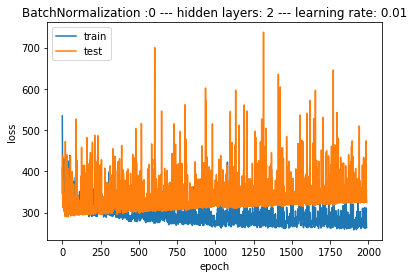

Train on 960 samples, validate on 241 samples
Epoch 1/2000
960/960 [==============================] - 3s 4ms/step - loss: 3132806.4976 - val_loss: 11087.0020
Epoch 2/2000
960/960 [==============================] - 1s 540us/step - loss: 2110.5528 - val_loss: 337.7430
Epoch 3/2000
960/960 [==============================] - 1s 537us/step - loss: 499.1863 - val_loss: 413.8060
Epoch 4/2000
960/960 [==============================] - 1s 537us/step - loss: 500.6058 - val_loss: 443.6890
Epoch 5/2000
960/960 [==============================] - 1s 554us/step - loss: 459.2690 - val_loss: 341.8152
Epoch 6/2000
960/960 [==============================] - 1s 533us/step - loss: 431.7026 - val_loss: 569.6329
Epoch 7/2000
960/960 [==============================] - 1s 554us/step - loss: 430.4860 - val_loss: 351.8399
Epoch 8/2000
960/960 [==============================] - 1s 554us/step - loss: 436.4187 - val_loss: 344.1399
Epoch 9/2000
960/960 [==============================] - 1s 544us/step - loss: 386.300

Epoch 76/2000
960/960 [==============================] - 1s 557us/step - loss: 336.5260 - val_loss: 306.6464
Epoch 77/2000
960/960 [==============================] - 1s 536us/step - loss: 314.2718 - val_loss: 547.4235
Epoch 78/2000
960/960 [==============================] - 1s 529us/step - loss: 384.3708 - val_loss: 304.6658
Epoch 79/2000
960/960 [==============================] - 1s 529us/step - loss: 342.0135 - val_loss: 308.9996
Epoch 80/2000
960/960 [==============================] - 1s 542us/step - loss: 313.3919 - val_loss: 316.2039
Epoch 81/2000
960/960 [==============================] - 1s 542us/step - loss: 379.6293 - val_loss: 338.2536
Epoch 82/2000
960/960 [==============================] - 0s 514us/step - loss: 312.2490 - val_loss: 312.1523
Epoch 83/2000
960/960 [==============================] - 1s 527us/step - loss: 359.1976 - val_loss: 359.5248
Epoch 84/2000
960/960 [==============================] - 1s 536us/step - loss: 357.8521 - val_loss: 298.5950
Epoch 85/2000
960/9

960/960 [==============================] - 1s 551us/step - loss: 321.5583 - val_loss: 472.3103
Epoch 151/2000
960/960 [==============================] - 1s 527us/step - loss: 408.3178 - val_loss: 484.8030
Epoch 152/2000
960/960 [==============================] - 0s 520us/step - loss: 500.6896 - val_loss: 793.3671
Epoch 153/2000
960/960 [==============================] - 1s 537us/step - loss: 453.7747 - val_loss: 423.0757
Epoch 154/2000
960/960 [==============================] - 1s 532us/step - loss: 316.2832 - val_loss: 437.0369
Epoch 155/2000
960/960 [==============================] - 1s 535us/step - loss: 431.6509 - val_loss: 484.8139
Epoch 156/2000
960/960 [==============================] - 1s 555us/step - loss: 392.4366 - val_loss: 339.5699
Epoch 157/2000
960/960 [==============================] - 1s 535us/step - loss: 365.0352 - val_loss: 298.4241
Epoch 158/2000
960/960 [==============================] - 1s 546us/step - loss: 305.8964 - val_loss: 298.1701
Epoch 159/2000
960/960 [=

960/960 [==============================] - 1s 544us/step - loss: 326.5694 - val_loss: 433.4158
Epoch 225/2000
960/960 [==============================] - 0s 515us/step - loss: 415.1875 - val_loss: 566.3257
Epoch 226/2000
960/960 [==============================] - 1s 538us/step - loss: 327.0248 - val_loss: 297.6341
Epoch 227/2000
960/960 [==============================] - 1s 563us/step - loss: 331.2038 - val_loss: 312.0509
Epoch 228/2000
960/960 [==============================] - 1s 565us/step - loss: 331.0148 - val_loss: 307.1942
Epoch 229/2000
960/960 [==============================] - 1s 556us/step - loss: 296.7309 - val_loss: 298.4370
Epoch 230/2000
960/960 [==============================] - 1s 527us/step - loss: 304.6473 - val_loss: 296.7085
Epoch 231/2000
960/960 [==============================] - 1s 541us/step - loss: 306.6620 - val_loss: 314.2781
Epoch 232/2000
960/960 [==============================] - 1s 555us/step - loss: 311.0106 - val_loss: 298.5174
Epoch 233/2000
960/960 [=

960/960 [==============================] - 1s 552us/step - loss: 289.5478 - val_loss: 299.3370
Epoch 299/2000
960/960 [==============================] - 1s 553us/step - loss: 290.6433 - val_loss: 296.9724
Epoch 300/2000
960/960 [==============================] - 1s 536us/step - loss: 325.3413 - val_loss: 429.2855
Epoch 301/2000
960/960 [==============================] - 1s 527us/step - loss: 376.5560 - val_loss: 439.3704
Epoch 302/2000
960/960 [==============================] - 1s 550us/step - loss: 330.3812 - val_loss: 335.6607
Epoch 303/2000
960/960 [==============================] - 1s 553us/step - loss: 291.3640 - val_loss: 305.3994
Epoch 304/2000
960/960 [==============================] - 0s 513us/step - loss: 295.9793 - val_loss: 334.5173
Epoch 305/2000
960/960 [==============================] - 1s 551us/step - loss: 298.8359 - val_loss: 297.3080
Epoch 306/2000
960/960 [==============================] - 1s 532us/step - loss: 299.4999 - val_loss: 319.3983
Epoch 307/2000
960/960 [=

960/960 [==============================] - 1s 558us/step - loss: 333.7082 - val_loss: 332.7410
Epoch 373/2000
960/960 [==============================] - 1s 552us/step - loss: 332.6784 - val_loss: 345.6106
Epoch 374/2000
960/960 [==============================] - 1s 532us/step - loss: 290.2879 - val_loss: 297.5647
Epoch 375/2000
960/960 [==============================] - 1s 553us/step - loss: 283.3954 - val_loss: 299.0333
Epoch 376/2000
960/960 [==============================] - 1s 555us/step - loss: 330.6245 - val_loss: 481.9617
Epoch 377/2000
960/960 [==============================] - 1s 532us/step - loss: 324.4057 - val_loss: 308.0936
Epoch 378/2000
960/960 [==============================] - 1s 539us/step - loss: 295.5989 - val_loss: 313.6080
Epoch 379/2000
960/960 [==============================] - 0s 515us/step - loss: 289.0428 - val_loss: 351.6840
Epoch 380/2000
960/960 [==============================] - 1s 531us/step - loss: 341.3784 - val_loss: 306.2001
Epoch 381/2000
960/960 [=

960/960 [==============================] - 1s 555us/step - loss: 288.5003 - val_loss: 309.4862
Epoch 447/2000
960/960 [==============================] - 1s 551us/step - loss: 301.0261 - val_loss: 305.4567
Epoch 448/2000
960/960 [==============================] - 1s 542us/step - loss: 281.3714 - val_loss: 301.4991
Epoch 449/2000
960/960 [==============================] - 1s 551us/step - loss: 301.4304 - val_loss: 323.4052
Epoch 450/2000
960/960 [==============================] - 1s 558us/step - loss: 318.4756 - val_loss: 299.8769
Epoch 451/2000
960/960 [==============================] - 0s 508us/step - loss: 280.9051 - val_loss: 312.9407
Epoch 452/2000
960/960 [==============================] - 1s 540us/step - loss: 380.6301 - val_loss: 477.1585
Epoch 453/2000
960/960 [==============================] - 1s 545us/step - loss: 317.5644 - val_loss: 323.4053
Epoch 454/2000
960/960 [==============================] - 1s 542us/step - loss: 312.9934 - val_loss: 366.0428
Epoch 455/2000
960/960 [=

960/960 [==============================] - 1s 578us/step - loss: 296.3984 - val_loss: 326.5273
Epoch 521/2000
960/960 [==============================] - 1s 540us/step - loss: 296.7420 - val_loss: 313.1811
Epoch 522/2000
960/960 [==============================] - 1s 548us/step - loss: 303.2042 - val_loss: 300.5236
Epoch 523/2000
960/960 [==============================] - 1s 549us/step - loss: 280.6067 - val_loss: 312.5948
Epoch 524/2000
960/960 [==============================] - 1s 549us/step - loss: 288.7106 - val_loss: 311.8561
Epoch 525/2000
960/960 [==============================] - 1s 537us/step - loss: 296.9907 - val_loss: 300.9634
Epoch 526/2000
960/960 [==============================] - 1s 556us/step - loss: 284.3500 - val_loss: 307.0856
Epoch 527/2000
960/960 [==============================] - 1s 532us/step - loss: 281.4136 - val_loss: 337.2285
Epoch 528/2000
960/960 [==============================] - 1s 543us/step - loss: 335.2632 - val_loss: 597.9710
Epoch 529/2000
960/960 [=

960/960 [==============================] - 1s 556us/step - loss: 289.3563 - val_loss: 309.7148
Epoch 595/2000
960/960 [==============================] - 1s 539us/step - loss: 282.9008 - val_loss: 300.6492
Epoch 596/2000
960/960 [==============================] - 1s 551us/step - loss: 302.0421 - val_loss: 419.4358
Epoch 597/2000
960/960 [==============================] - 1s 592us/step - loss: 290.1551 - val_loss: 301.2816
Epoch 598/2000
960/960 [==============================] - 1s 604us/step - loss: 291.5661 - val_loss: 308.8125
Epoch 599/2000
960/960 [==============================] - 1s 589us/step - loss: 284.3161 - val_loss: 359.5871
Epoch 600/2000
960/960 [==============================] - 1s 594us/step - loss: 310.1937 - val_loss: 377.7527
Epoch 601/2000
960/960 [==============================] - 1s 615us/step - loss: 338.4820 - val_loss: 309.8047
Epoch 602/2000
960/960 [==============================] - 1s 588us/step - loss: 389.3150 - val_loss: 322.4724
Epoch 603/2000
960/960 [=

960/960 [==============================] - 1s 548us/step - loss: 307.9943 - val_loss: 329.3156
Epoch 669/2000
960/960 [==============================] - 1s 537us/step - loss: 288.9104 - val_loss: 313.1317
Epoch 670/2000
960/960 [==============================] - 1s 550us/step - loss: 345.6997 - val_loss: 331.3962
Epoch 671/2000
960/960 [==============================] - 1s 546us/step - loss: 284.0252 - val_loss: 308.4705
Epoch 672/2000
960/960 [==============================] - 1s 558us/step - loss: 280.6070 - val_loss: 371.1848
Epoch 673/2000
960/960 [==============================] - 1s 558us/step - loss: 303.1531 - val_loss: 366.9061
Epoch 674/2000
960/960 [==============================] - 1s 581us/step - loss: 289.8394 - val_loss: 386.7288
Epoch 675/2000
960/960 [==============================] - 1s 622us/step - loss: 292.0213 - val_loss: 320.2209
Epoch 676/2000
960/960 [==============================] - 1s 579us/step - loss: 318.0889 - val_loss: 324.2754
Epoch 677/2000
960/960 [=

960/960 [==============================] - 1s 549us/step - loss: 294.0376 - val_loss: 333.4146
Epoch 743/2000
960/960 [==============================] - 1s 561us/step - loss: 288.2345 - val_loss: 328.1366
Epoch 744/2000
960/960 [==============================] - 1s 528us/step - loss: 277.7386 - val_loss: 302.9957
Epoch 745/2000
960/960 [==============================] - 1s 551us/step - loss: 282.0056 - val_loss: 312.4276
Epoch 746/2000
960/960 [==============================] - 1s 534us/step - loss: 279.0834 - val_loss: 307.3206
Epoch 747/2000
960/960 [==============================] - 1s 530us/step - loss: 280.0946 - val_loss: 412.8752
Epoch 748/2000
960/960 [==============================] - 0s 519us/step - loss: 318.5604 - val_loss: 309.2100
Epoch 749/2000
960/960 [==============================] - 1s 560us/step - loss: 330.1111 - val_loss: 315.3622
Epoch 750/2000
960/960 [==============================] - 1s 557us/step - loss: 288.3070 - val_loss: 386.5072
Epoch 751/2000
960/960 [=

960/960 [==============================] - 1s 554us/step - loss: 315.6240 - val_loss: 308.9317
Epoch 817/2000
960/960 [==============================] - 1s 558us/step - loss: 294.1674 - val_loss: 314.4321
Epoch 818/2000
960/960 [==============================] - 1s 557us/step - loss: 293.4357 - val_loss: 365.9120
Epoch 819/2000
960/960 [==============================] - 1s 553us/step - loss: 334.3054 - val_loss: 304.6032
Epoch 820/2000
960/960 [==============================] - 1s 550us/step - loss: 323.5684 - val_loss: 383.5524
Epoch 821/2000
960/960 [==============================] - 1s 549us/step - loss: 299.4976 - val_loss: 391.1065
Epoch 822/2000
960/960 [==============================] - 1s 554us/step - loss: 321.3087 - val_loss: 315.9609
Epoch 823/2000
960/960 [==============================] - 1s 557us/step - loss: 295.6382 - val_loss: 306.8860
Epoch 824/2000
960/960 [==============================] - 1s 544us/step - loss: 333.6176 - val_loss: 316.6198
Epoch 825/2000
960/960 [=

960/960 [==============================] - 1s 567us/step - loss: 292.2779 - val_loss: 312.3636
Epoch 891/2000
960/960 [==============================] - 1s 559us/step - loss: 278.7027 - val_loss: 362.0813
Epoch 892/2000
960/960 [==============================] - 1s 551us/step - loss: 274.4456 - val_loss: 306.6870
Epoch 893/2000
960/960 [==============================] - 1s 549us/step - loss: 284.0644 - val_loss: 307.1548
Epoch 894/2000
960/960 [==============================] - 1s 538us/step - loss: 286.1057 - val_loss: 309.3157
Epoch 895/2000
960/960 [==============================] - 1s 533us/step - loss: 273.7368 - val_loss: 344.4308
Epoch 896/2000
960/960 [==============================] - 1s 536us/step - loss: 291.0444 - val_loss: 315.4115
Epoch 897/2000
960/960 [==============================] - 1s 550us/step - loss: 286.5512 - val_loss: 319.3129
Epoch 898/2000
960/960 [==============================] - 1s 562us/step - loss: 271.7642 - val_loss: 309.8771
Epoch 899/2000
960/960 [=

960/960 [==============================] - 1s 555us/step - loss: 324.7593 - val_loss: 335.4036
Epoch 965/2000
960/960 [==============================] - 1s 555us/step - loss: 316.3036 - val_loss: 373.6740
Epoch 966/2000
960/960 [==============================] - 1s 576us/step - loss: 286.8773 - val_loss: 313.1298
Epoch 967/2000
960/960 [==============================] - 0s 505us/step - loss: 280.6242 - val_loss: 323.0519
Epoch 968/2000
960/960 [==============================] - 1s 528us/step - loss: 273.0287 - val_loss: 314.5996
Epoch 969/2000
960/960 [==============================] - 1s 559us/step - loss: 286.7952 - val_loss: 388.4399
Epoch 970/2000
960/960 [==============================] - 1s 559us/step - loss: 310.7107 - val_loss: 440.6098
Epoch 971/2000
960/960 [==============================] - 1s 552us/step - loss: 307.3233 - val_loss: 320.2234
Epoch 972/2000
960/960 [==============================] - 1s 527us/step - loss: 286.9047 - val_loss: 306.8203
Epoch 973/2000
960/960 [=

960/960 [==============================] - 1s 567us/step - loss: 277.3009 - val_loss: 402.4902
Epoch 1039/2000
960/960 [==============================] - 1s 538us/step - loss: 311.3513 - val_loss: 377.0620
Epoch 1040/2000
960/960 [==============================] - 1s 524us/step - loss: 290.5504 - val_loss: 323.0114
Epoch 1041/2000
960/960 [==============================] - 1s 526us/step - loss: 287.9691 - val_loss: 316.4886
Epoch 1042/2000
960/960 [==============================] - 1s 530us/step - loss: 278.0509 - val_loss: 331.1726
Epoch 1043/2000
960/960 [==============================] - 1s 525us/step - loss: 275.7263 - val_loss: 340.0581
Epoch 1044/2000
960/960 [==============================] - 1s 549us/step - loss: 300.7475 - val_loss: 309.7706
Epoch 1045/2000
960/960 [==============================] - 1s 555us/step - loss: 289.0153 - val_loss: 322.3387
Epoch 1046/2000
960/960 [==============================] - 0s 511us/step - loss: 285.0794 - val_loss: 310.4090
Epoch 1047/2000
9

Epoch 1112/2000
960/960 [==============================] - 1s 542us/step - loss: 366.5898 - val_loss: 338.8832
Epoch 1113/2000
960/960 [==============================] - 1s 533us/step - loss: 300.5172 - val_loss: 307.2428
Epoch 1114/2000
960/960 [==============================] - 1s 547us/step - loss: 280.5458 - val_loss: 371.6394
Epoch 1115/2000
960/960 [==============================] - 1s 537us/step - loss: 299.8280 - val_loss: 363.1871
Epoch 1116/2000
960/960 [==============================] - 1s 525us/step - loss: 301.2417 - val_loss: 384.7974
Epoch 1117/2000
960/960 [==============================] - 0s 509us/step - loss: 286.1380 - val_loss: 316.6029
Epoch 1118/2000
960/960 [==============================] - 1s 526us/step - loss: 274.3122 - val_loss: 311.6121
Epoch 1119/2000
960/960 [==============================] - 1s 534us/step - loss: 275.6785 - val_loss: 310.7440
Epoch 1120/2000
960/960 [==============================] - 1s 529us/step - loss: 282.9358 - val_loss: 322.7868
E

Epoch 1186/2000
960/960 [==============================] - 1s 547us/step - loss: 308.9409 - val_loss: 310.2055
Epoch 1187/2000
960/960 [==============================] - 0s 516us/step - loss: 283.5296 - val_loss: 313.1504
Epoch 1188/2000
960/960 [==============================] - 1s 524us/step - loss: 276.5539 - val_loss: 311.0095
Epoch 1189/2000
960/960 [==============================] - 0s 515us/step - loss: 291.4588 - val_loss: 308.9259
Epoch 1190/2000
960/960 [==============================] - 1s 553us/step - loss: 288.2897 - val_loss: 339.9498
Epoch 1191/2000
960/960 [==============================] - 1s 558us/step - loss: 355.5806 - val_loss: 309.5929
Epoch 1192/2000
960/960 [==============================] - 1s 525us/step - loss: 280.8651 - val_loss: 340.6626
Epoch 1193/2000
960/960 [==============================] - 1s 528us/step - loss: 291.3380 - val_loss: 311.0374
Epoch 1194/2000
960/960 [==============================] - 0s 509us/step - loss: 273.5177 - val_loss: 309.4220
E

Epoch 1260/2000
960/960 [==============================] - 1s 594us/step - loss: 303.7071 - val_loss: 338.5055
Epoch 1261/2000
960/960 [==============================] - 0s 512us/step - loss: 292.8914 - val_loss: 363.2742
Epoch 1262/2000
960/960 [==============================] - 1s 546us/step - loss: 293.1185 - val_loss: 312.8619
Epoch 1263/2000
960/960 [==============================] - 1s 544us/step - loss: 278.0513 - val_loss: 311.9320
Epoch 1264/2000
960/960 [==============================] - 1s 536us/step - loss: 280.9806 - val_loss: 313.8123
Epoch 1265/2000
960/960 [==============================] - 1s 546us/step - loss: 300.1042 - val_loss: 486.6837
Epoch 1266/2000
960/960 [==============================] - 1s 545us/step - loss: 310.6882 - val_loss: 326.1986
Epoch 1267/2000
960/960 [==============================] - 1s 534us/step - loss: 282.5739 - val_loss: 320.0645
Epoch 1268/2000
960/960 [==============================] - 1s 551us/step - loss: 288.1641 - val_loss: 436.1770
E

Epoch 1334/2000
960/960 [==============================] - 1s 564us/step - loss: 294.5084 - val_loss: 523.3034
Epoch 1335/2000
960/960 [==============================] - 1s 538us/step - loss: 305.1671 - val_loss: 335.8437
Epoch 1336/2000
960/960 [==============================] - 1s 534us/step - loss: 320.0386 - val_loss: 378.9937
Epoch 1337/2000
960/960 [==============================] - 1s 544us/step - loss: 325.7901 - val_loss: 349.7970
Epoch 1338/2000
960/960 [==============================] - 1s 536us/step - loss: 272.1050 - val_loss: 309.5168
Epoch 1339/2000
960/960 [==============================] - 1s 530us/step - loss: 276.5382 - val_loss: 325.4951
Epoch 1340/2000
960/960 [==============================] - 1s 542us/step - loss: 275.0465 - val_loss: 311.8322
Epoch 1341/2000
960/960 [==============================] - 1s 559us/step - loss: 292.4455 - val_loss: 446.1003
Epoch 1342/2000
960/960 [==============================] - 1s 546us/step - loss: 294.2567 - val_loss: 313.6307
E

Epoch 1408/2000
960/960 [==============================] - 1s 566us/step - loss: 277.6584 - val_loss: 316.9893
Epoch 1409/2000
960/960 [==============================] - 1s 540us/step - loss: 288.7236 - val_loss: 311.5242
Epoch 1410/2000
960/960 [==============================] - 1s 528us/step - loss: 281.9962 - val_loss: 317.6580
Epoch 1411/2000
960/960 [==============================] - 1s 551us/step - loss: 281.6410 - val_loss: 320.6489
Epoch 1412/2000
960/960 [==============================] - 1s 558us/step - loss: 276.0728 - val_loss: 337.4408
Epoch 1413/2000
960/960 [==============================] - 1s 547us/step - loss: 289.3144 - val_loss: 358.5300
Epoch 1414/2000
960/960 [==============================] - 1s 545us/step - loss: 308.2367 - val_loss: 406.2109
Epoch 1415/2000
960/960 [==============================] - 1s 528us/step - loss: 321.4377 - val_loss: 313.5120
Epoch 1416/2000
960/960 [==============================] - 1s 554us/step - loss: 266.1786 - val_loss: 315.9128
E

960/960 [==============================] - 1s 573us/step - loss: 286.9958 - val_loss: 464.2264
Epoch 1482/2000
960/960 [==============================] - 1s 529us/step - loss: 298.2306 - val_loss: 344.2002
Epoch 1483/2000
960/960 [==============================] - 1s 538us/step - loss: 286.7318 - val_loss: 347.7989
Epoch 1484/2000
960/960 [==============================] - 1s 574us/step - loss: 270.7521 - val_loss: 327.1121
Epoch 1485/2000
960/960 [==============================] - 1s 550us/step - loss: 280.0351 - val_loss: 429.0172
Epoch 1486/2000
960/960 [==============================] - 1s 560us/step - loss: 296.8010 - val_loss: 314.4703
Epoch 1487/2000
960/960 [==============================] - 1s 540us/step - loss: 269.1235 - val_loss: 331.8334
Epoch 1488/2000
960/960 [==============================] - 1s 565us/step - loss: 280.5725 - val_loss: 314.9212
Epoch 1489/2000
960/960 [==============================] - 1s 555us/step - loss: 285.3068 - val_loss: 326.9430
Epoch 1490/2000
9

Epoch 1555/2000
960/960 [==============================] - 1s 564us/step - loss: 276.4844 - val_loss: 313.3138
Epoch 1556/2000
960/960 [==============================] - 1s 552us/step - loss: 297.8158 - val_loss: 323.9802
Epoch 1557/2000
960/960 [==============================] - 1s 546us/step - loss: 360.1022 - val_loss: 388.2579
Epoch 1558/2000
960/960 [==============================] - 1s 547us/step - loss: 305.0253 - val_loss: 311.1723
Epoch 1559/2000
960/960 [==============================] - 1s 533us/step - loss: 269.4324 - val_loss: 374.3636
Epoch 1560/2000
960/960 [==============================] - 1s 551us/step - loss: 305.9628 - val_loss: 315.0477
Epoch 1561/2000
960/960 [==============================] - 1s 560us/step - loss: 287.7902 - val_loss: 322.6023
Epoch 1562/2000
960/960 [==============================] - 1s 525us/step - loss: 278.5690 - val_loss: 348.6503
Epoch 1563/2000
960/960 [==============================] - 1s 544us/step - loss: 322.3568 - val_loss: 417.7848
E

Epoch 1629/2000
960/960 [==============================] - 1s 557us/step - loss: 295.1747 - val_loss: 377.7942
Epoch 1630/2000
960/960 [==============================] - 1s 539us/step - loss: 357.1808 - val_loss: 515.0845
Epoch 1631/2000
960/960 [==============================] - 1s 548us/step - loss: 325.4180 - val_loss: 384.9948
Epoch 1632/2000
960/960 [==============================] - 1s 537us/step - loss: 291.6443 - val_loss: 380.4815
Epoch 1633/2000
960/960 [==============================] - 1s 538us/step - loss: 272.2081 - val_loss: 316.4236
Epoch 1634/2000
960/960 [==============================] - 1s 548us/step - loss: 267.6112 - val_loss: 313.4182
Epoch 1635/2000
960/960 [==============================] - 1s 541us/step - loss: 273.8566 - val_loss: 317.4700
Epoch 1636/2000
960/960 [==============================] - 1s 537us/step - loss: 268.3895 - val_loss: 321.6782
Epoch 1637/2000
960/960 [==============================] - 1s 552us/step - loss: 268.0265 - val_loss: 350.9912
E

Epoch 1703/2000
960/960 [==============================] - 1s 547us/step - loss: 307.5408 - val_loss: 467.2661
Epoch 1704/2000
960/960 [==============================] - 1s 550us/step - loss: 301.2685 - val_loss: 333.0802
Epoch 1705/2000
960/960 [==============================] - 1s 537us/step - loss: 271.9747 - val_loss: 342.9956
Epoch 1706/2000
960/960 [==============================] - 1s 528us/step - loss: 281.8908 - val_loss: 319.6053
Epoch 1707/2000
960/960 [==============================] - 1s 531us/step - loss: 274.8447 - val_loss: 322.7619
Epoch 1708/2000
960/960 [==============================] - 1s 550us/step - loss: 273.3165 - val_loss: 317.3627
Epoch 1709/2000
960/960 [==============================] - 1s 556us/step - loss: 267.4477 - val_loss: 317.3501
Epoch 1710/2000
960/960 [==============================] - 1s 526us/step - loss: 291.4294 - val_loss: 378.9976
Epoch 1711/2000
960/960 [==============================] - 1s 540us/step - loss: 279.6345 - val_loss: 340.3179
E

Epoch 1777/2000
960/960 [==============================] - 1s 547us/step - loss: 324.4177 - val_loss: 391.6506
Epoch 1778/2000
960/960 [==============================] - 1s 538us/step - loss: 285.5485 - val_loss: 322.2371
Epoch 1779/2000
960/960 [==============================] - 1s 545us/step - loss: 282.0814 - val_loss: 319.2067
Epoch 1780/2000
960/960 [==============================] - 1s 560us/step - loss: 277.4594 - val_loss: 342.8648
Epoch 1781/2000
960/960 [==============================] - 0s 506us/step - loss: 284.0443 - val_loss: 319.8636
Epoch 1782/2000
960/960 [==============================] - 1s 531us/step - loss: 271.7339 - val_loss: 323.1088
Epoch 1783/2000
960/960 [==============================] - 1s 549us/step - loss: 267.6660 - val_loss: 320.0125
Epoch 1784/2000
960/960 [==============================] - 1s 561us/step - loss: 286.4356 - val_loss: 332.1700
Epoch 1785/2000
960/960 [==============================] - 1s 525us/step - loss: 275.1813 - val_loss: 473.1430
E

Epoch 1851/2000
960/960 [==============================] - 1s 560us/step - loss: 294.2803 - val_loss: 357.6582
Epoch 1852/2000
960/960 [==============================] - 1s 556us/step - loss: 289.4323 - val_loss: 315.8026
Epoch 1853/2000
960/960 [==============================] - 1s 548us/step - loss: 285.0236 - val_loss: 329.2582
Epoch 1854/2000
960/960 [==============================] - 0s 520us/step - loss: 283.3891 - val_loss: 372.7921
Epoch 1855/2000
960/960 [==============================] - 1s 538us/step - loss: 280.6013 - val_loss: 317.7501
Epoch 1856/2000
960/960 [==============================] - 1s 542us/step - loss: 282.0053 - val_loss: 324.0608
Epoch 1857/2000
960/960 [==============================] - 1s 553us/step - loss: 272.2264 - val_loss: 395.6618
Epoch 1858/2000
960/960 [==============================] - 0s 512us/step - loss: 315.3772 - val_loss: 317.6176
Epoch 1859/2000
960/960 [==============================] - 1s 554us/step - loss: 280.3099 - val_loss: 432.3224
E

Epoch 1925/2000
960/960 [==============================] - 1s 561us/step - loss: 270.8967 - val_loss: 329.8647
Epoch 1926/2000
960/960 [==============================] - 1s 535us/step - loss: 275.1892 - val_loss: 311.7857
Epoch 1927/2000
960/960 [==============================] - 1s 543us/step - loss: 270.2432 - val_loss: 318.4863
Epoch 1928/2000
960/960 [==============================] - 1s 554us/step - loss: 268.5920 - val_loss: 343.4452
Epoch 1929/2000
960/960 [==============================] - 1s 558us/step - loss: 277.2429 - val_loss: 313.5291
Epoch 1930/2000
960/960 [==============================] - 1s 559us/step - loss: 278.1376 - val_loss: 352.4577
Epoch 1931/2000
960/960 [==============================] - 1s 538us/step - loss: 306.3367 - val_loss: 361.1097
Epoch 1932/2000
960/960 [==============================] - 1s 543us/step - loss: 273.9575 - val_loss: 318.8861
Epoch 1933/2000
960/960 [==============================] - 1s 537us/step - loss: 294.4034 - val_loss: 333.4563
E

Epoch 1999/2000
960/960 [==============================] - 1s 568us/step - loss: 280.7200 - val_loss: 340.5707
Epoch 2000/2000
960/960 [==============================] - 1s 541us/step - loss: 281.7982 - val_loss: 420.8326


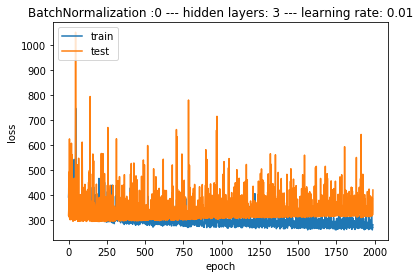

Train on 960 samples, validate on 241 samples
Epoch 1/2000
960/960 [==============================] - 4s 4ms/step - loss: 28976196.2326 - val_loss: 7471.5774
Epoch 2/2000
960/960 [==============================] - 1s 600us/step - loss: 1950.8323 - val_loss: 498.3445
Epoch 3/2000
960/960 [==============================] - 1s 639us/step - loss: 559.2344 - val_loss: 372.1325
Epoch 4/2000
960/960 [==============================] - 1s 629us/step - loss: 479.7463 - val_loss: 363.5815
Epoch 5/2000
960/960 [==============================] - 1s 614us/step - loss: 533.3589 - val_loss: 368.8308
Epoch 6/2000
960/960 [==============================] - 1s 638us/step - loss: 460.7806 - val_loss: 353.7254
Epoch 7/2000
960/960 [==============================] - 1s 630us/step - loss: 438.1835 - val_loss: 355.9517
Epoch 8/2000
960/960 [==============================] - 1s 630us/step - loss: 461.5120 - val_loss: 359.0993
Epoch 9/2000
960/960 [==============================] - 1s 632us/step - loss: 476.254

960/960 [==============================] - 1s 679us/step - loss: 330.0226 - val_loss: 390.6468
Epoch 76/2000
960/960 [==============================] - 1s 644us/step - loss: 359.4986 - val_loss: 320.5835
Epoch 77/2000
960/960 [==============================] - 1s 620us/step - loss: 344.5447 - val_loss: 393.8223
Epoch 78/2000
960/960 [==============================] - 1s 635us/step - loss: 389.5227 - val_loss: 332.5264
Epoch 79/2000
960/960 [==============================] - 1s 635us/step - loss: 359.2155 - val_loss: 308.2913
Epoch 80/2000
960/960 [==============================] - 1s 632us/step - loss: 388.5323 - val_loss: 298.3387
Epoch 81/2000
960/960 [==============================] - 1s 626us/step - loss: 367.4922 - val_loss: 297.7609
Epoch 82/2000
960/960 [==============================] - 1s 630us/step - loss: 340.5938 - val_loss: 387.7472
Epoch 83/2000
960/960 [==============================] - 1s 623us/step - loss: 396.1887 - val_loss: 408.9861
Epoch 84/2000
960/960 [==========

Epoch 150/2000
960/960 [==============================] - 1s 653us/step - loss: 324.9301 - val_loss: 294.5586
Epoch 151/2000
960/960 [==============================] - 1s 627us/step - loss: 366.7410 - val_loss: 335.1007
Epoch 152/2000
960/960 [==============================] - 1s 630us/step - loss: 330.0294 - val_loss: 310.7639
Epoch 153/2000
960/960 [==============================] - 1s 619us/step - loss: 312.3659 - val_loss: 300.1909
Epoch 154/2000
960/960 [==============================] - 1s 625us/step - loss: 325.9221 - val_loss: 341.3926
Epoch 155/2000
960/960 [==============================] - 1s 634us/step - loss: 318.5344 - val_loss: 303.0060
Epoch 156/2000
960/960 [==============================] - 1s 623us/step - loss: 310.1812 - val_loss: 295.1063
Epoch 157/2000
960/960 [==============================] - 1s 616us/step - loss: 319.8902 - val_loss: 314.9228
Epoch 158/2000
960/960 [==============================] - 1s 608us/step - loss: 316.5740 - val_loss: 305.9506
Epoch 159/

960/960 [==============================] - 1s 645us/step - loss: 348.1961 - val_loss: 433.8289
Epoch 225/2000
960/960 [==============================] - 1s 637us/step - loss: 354.3774 - val_loss: 396.6565
Epoch 226/2000
960/960 [==============================] - 1s 639us/step - loss: 329.8234 - val_loss: 294.7290
Epoch 227/2000
960/960 [==============================] - 1s 650us/step - loss: 310.4214 - val_loss: 294.5264
Epoch 228/2000
960/960 [==============================] - 1s 634us/step - loss: 321.9901 - val_loss: 334.9815
Epoch 229/2000
960/960 [==============================] - 1s 632us/step - loss: 354.4244 - val_loss: 313.2608
Epoch 230/2000
960/960 [==============================] - 1s 629us/step - loss: 354.5578 - val_loss: 330.3120
Epoch 231/2000
960/960 [==============================] - 1s 634us/step - loss: 417.2944 - val_loss: 341.7185
Epoch 232/2000
960/960 [==============================] - 1s 649us/step - loss: 356.4805 - val_loss: 295.7619
Epoch 233/2000
960/960 [=

960/960 [==============================] - 1s 661us/step - loss: 313.9931 - val_loss: 305.3887
Epoch 299/2000
960/960 [==============================] - 1s 631us/step - loss: 299.4521 - val_loss: 301.1494
Epoch 300/2000
960/960 [==============================] - 1s 638us/step - loss: 322.9979 - val_loss: 325.3727
Epoch 301/2000
960/960 [==============================] - 1s 637us/step - loss: 323.8294 - val_loss: 296.8711
Epoch 302/2000
960/960 [==============================] - 1s 644us/step - loss: 297.1031 - val_loss: 316.8239
Epoch 303/2000
960/960 [==============================] - 1s 637us/step - loss: 333.2975 - val_loss: 333.7614
Epoch 304/2000
960/960 [==============================] - 1s 632us/step - loss: 305.1020 - val_loss: 311.1555
Epoch 305/2000
960/960 [==============================] - 1s 627us/step - loss: 362.2390 - val_loss: 337.3631
Epoch 306/2000
960/960 [==============================] - 1s 626us/step - loss: 348.8067 - val_loss: 375.1424
Epoch 307/2000
960/960 [=

960/960 [==============================] - 1s 653us/step - loss: 357.9551 - val_loss: 302.2249
Epoch 373/2000
960/960 [==============================] - 1s 617us/step - loss: 347.3679 - val_loss: 297.5730
Epoch 374/2000
960/960 [==============================] - 1s 621us/step - loss: 313.9054 - val_loss: 393.7292
Epoch 375/2000
960/960 [==============================] - 1s 626us/step - loss: 407.0135 - val_loss: 413.2459
Epoch 376/2000
960/960 [==============================] - 1s 632us/step - loss: 369.0440 - val_loss: 319.4117
Epoch 377/2000
960/960 [==============================] - 1s 625us/step - loss: 369.1575 - val_loss: 296.8484
Epoch 378/2000
960/960 [==============================] - 1s 624us/step - loss: 388.0535 - val_loss: 312.6083
Epoch 379/2000
960/960 [==============================] - 1s 624us/step - loss: 289.4332 - val_loss: 296.7761
Epoch 380/2000
960/960 [==============================] - 1s 621us/step - loss: 292.5295 - val_loss: 297.0775
Epoch 381/2000
960/960 [=

960/960 [==============================] - 1s 665us/step - loss: 294.9975 - val_loss: 299.6487
Epoch 447/2000
960/960 [==============================] - 1s 614us/step - loss: 369.8856 - val_loss: 408.0213
Epoch 448/2000
960/960 [==============================] - 1s 627us/step - loss: 376.2605 - val_loss: 474.1022
Epoch 449/2000
960/960 [==============================] - 1s 632us/step - loss: 319.8388 - val_loss: 304.3101
Epoch 450/2000
960/960 [==============================] - 1s 632us/step - loss: 293.1408 - val_loss: 314.8487
Epoch 451/2000
960/960 [==============================] - 1s 642us/step - loss: 314.3277 - val_loss: 361.2732
Epoch 452/2000
960/960 [==============================] - 1s 634us/step - loss: 322.2553 - val_loss: 304.2529
Epoch 453/2000
960/960 [==============================] - 1s 636us/step - loss: 447.1052 - val_loss: 400.6213
Epoch 454/2000
960/960 [==============================] - 1s 623us/step - loss: 774.1011 - val_loss: 2166.5833
Epoch 455/2000
960/960 [

960/960 [==============================] - 1s 637us/step - loss: 305.9416 - val_loss: 348.7394
Epoch 521/2000
960/960 [==============================] - 1s 628us/step - loss: 299.1229 - val_loss: 621.5405
Epoch 522/2000
960/960 [==============================] - 1s 632us/step - loss: 348.1894 - val_loss: 329.7564
Epoch 523/2000
960/960 [==============================] - 1s 635us/step - loss: 308.7349 - val_loss: 359.2930
Epoch 524/2000
960/960 [==============================] - 1s 622us/step - loss: 296.3124 - val_loss: 304.0127
Epoch 525/2000
960/960 [==============================] - 1s 652us/step - loss: 303.5694 - val_loss: 329.7440
Epoch 526/2000
960/960 [==============================] - 1s 633us/step - loss: 287.5981 - val_loss: 346.8256
Epoch 527/2000
960/960 [==============================] - 1s 628us/step - loss: 332.0610 - val_loss: 618.1457
Epoch 528/2000
960/960 [==============================] - 1s 655us/step - loss: 369.1667 - val_loss: 313.9350
Epoch 529/2000
960/960 [=

960/960 [==============================] - 1s 630us/step - loss: 301.7864 - val_loss: 333.4013
Epoch 595/2000
960/960 [==============================] - 1s 625us/step - loss: 294.6963 - val_loss: 304.2545
Epoch 596/2000
960/960 [==============================] - 1s 634us/step - loss: 302.9143 - val_loss: 304.5669
Epoch 597/2000
960/960 [==============================] - 1s 638us/step - loss: 302.1996 - val_loss: 359.2902
Epoch 598/2000
960/960 [==============================] - 1s 621us/step - loss: 295.2756 - val_loss: 310.4012
Epoch 599/2000
960/960 [==============================] - 1s 628us/step - loss: 311.3103 - val_loss: 335.8285
Epoch 600/2000
960/960 [==============================] - 1s 637us/step - loss: 292.1181 - val_loss: 302.1242
Epoch 601/2000
960/960 [==============================] - 1s 628us/step - loss: 298.9437 - val_loss: 319.6364
Epoch 602/2000
960/960 [==============================] - 1s 629us/step - loss: 333.6674 - val_loss: 338.9026
Epoch 603/2000
960/960 [=

960/960 [==============================] - 1s 645us/step - loss: 308.4553 - val_loss: 393.7132
Epoch 669/2000
960/960 [==============================] - 1s 628us/step - loss: 334.6914 - val_loss: 301.2385
Epoch 670/2000
960/960 [==============================] - 1s 641us/step - loss: 297.8202 - val_loss: 392.0321
Epoch 671/2000
960/960 [==============================] - 1s 631us/step - loss: 323.3882 - val_loss: 305.1927
Epoch 672/2000
960/960 [==============================] - 1s 613us/step - loss: 321.7025 - val_loss: 304.1860
Epoch 673/2000
960/960 [==============================] - 1s 619us/step - loss: 285.8679 - val_loss: 374.6424
Epoch 674/2000
960/960 [==============================] - 1s 659us/step - loss: 292.0995 - val_loss: 301.5860
Epoch 675/2000
960/960 [==============================] - 1s 671us/step - loss: 294.0530 - val_loss: 303.8130
Epoch 676/2000
960/960 [==============================] - 1s 637us/step - loss: 294.0533 - val_loss: 318.7722
Epoch 677/2000
960/960 [=

960/960 [==============================] - 1s 649us/step - loss: 311.9490 - val_loss: 302.1797
Epoch 743/2000
960/960 [==============================] - 1s 624us/step - loss: 306.5984 - val_loss: 331.5744
Epoch 744/2000
960/960 [==============================] - 1s 638us/step - loss: 294.9190 - val_loss: 302.2493
Epoch 745/2000
960/960 [==============================] - 1s 630us/step - loss: 290.6876 - val_loss: 303.3250
Epoch 746/2000
960/960 [==============================] - 1s 630us/step - loss: 315.2161 - val_loss: 313.6912
Epoch 747/2000
960/960 [==============================] - 1s 635us/step - loss: 314.1718 - val_loss: 398.6092
Epoch 748/2000
960/960 [==============================] - 1s 635us/step - loss: 298.5190 - val_loss: 428.9982
Epoch 749/2000
960/960 [==============================] - 1s 637us/step - loss: 284.4065 - val_loss: 333.7470
Epoch 750/2000
960/960 [==============================] - 1s 624us/step - loss: 305.3545 - val_loss: 304.9724
Epoch 751/2000
960/960 [=

960/960 [==============================] - 1s 722us/step - loss: 368.4310 - val_loss: 319.9317
Epoch 817/2000
960/960 [==============================] - 1s 725us/step - loss: 346.7925 - val_loss: 304.8117
Epoch 818/2000
960/960 [==============================] - 1s 679us/step - loss: 340.9079 - val_loss: 322.2167
Epoch 819/2000
960/960 [==============================] - 1s 610us/step - loss: 346.3666 - val_loss: 309.7176
Epoch 820/2000
960/960 [==============================] - 1s 637us/step - loss: 299.7097 - val_loss: 302.5920
Epoch 821/2000
960/960 [==============================] - 1s 642us/step - loss: 283.8319 - val_loss: 315.3775
Epoch 822/2000
960/960 [==============================] - 1s 634us/step - loss: 317.6851 - val_loss: 303.4849
Epoch 823/2000
960/960 [==============================] - 1s 631us/step - loss: 303.3332 - val_loss: 456.2345
Epoch 824/2000
960/960 [==============================] - 1s 632us/step - loss: 366.8635 - val_loss: 303.7319
Epoch 825/2000
960/960 [=

960/960 [==============================] - 1s 653us/step - loss: 299.7818 - val_loss: 336.1259
Epoch 891/2000
960/960 [==============================] - 1s 628us/step - loss: 286.1375 - val_loss: 318.7639
Epoch 892/2000
960/960 [==============================] - 1s 629us/step - loss: 279.7056 - val_loss: 338.9610
Epoch 893/2000
960/960 [==============================] - 1s 627us/step - loss: 349.5324 - val_loss: 404.5945
Epoch 894/2000
960/960 [==============================] - 1s 643us/step - loss: 365.3180 - val_loss: 304.1968
Epoch 895/2000
960/960 [==============================] - 1s 634us/step - loss: 322.0809 - val_loss: 350.9222
Epoch 896/2000
960/960 [==============================] - 1s 634us/step - loss: 287.6619 - val_loss: 333.4007
Epoch 897/2000
960/960 [==============================] - 1s 627us/step - loss: 284.4038 - val_loss: 347.2100
Epoch 898/2000
960/960 [==============================] - 1s 628us/step - loss: 301.5911 - val_loss: 325.4235
Epoch 899/2000
960/960 [=

960/960 [==============================] - 1s 651us/step - loss: 329.5234 - val_loss: 311.9726
Epoch 965/2000
960/960 [==============================] - 1s 637us/step - loss: 319.1375 - val_loss: 382.8244
Epoch 966/2000
960/960 [==============================] - 1s 631us/step - loss: 346.0062 - val_loss: 414.2885
Epoch 967/2000
960/960 [==============================] - 1s 661us/step - loss: 339.5338 - val_loss: 339.0510
Epoch 968/2000
960/960 [==============================] - 1s 635us/step - loss: 349.7579 - val_loss: 405.3351
Epoch 969/2000
960/960 [==============================] - 1s 617us/step - loss: 298.0003 - val_loss: 350.3603
Epoch 970/2000
960/960 [==============================] - 1s 633us/step - loss: 278.8262 - val_loss: 305.0009
Epoch 971/2000
960/960 [==============================] - 1s 626us/step - loss: 276.9240 - val_loss: 315.6974
Epoch 972/2000
960/960 [==============================] - 1s 624us/step - loss: 295.2546 - val_loss: 309.1910
Epoch 973/2000
960/960 [=

960/960 [==============================] - 1s 666us/step - loss: 355.3614 - val_loss: 341.4979
Epoch 1039/2000
960/960 [==============================] - 1s 628us/step - loss: 288.3960 - val_loss: 308.3380
Epoch 1040/2000
960/960 [==============================] - 1s 634us/step - loss: 282.2821 - val_loss: 484.9761
Epoch 1041/2000
960/960 [==============================] - 1s 634us/step - loss: 336.5231 - val_loss: 376.3144
Epoch 1042/2000
960/960 [==============================] - 1s 656us/step - loss: 304.7860 - val_loss: 386.8583
Epoch 1043/2000
960/960 [==============================] - 1s 638us/step - loss: 355.4770 - val_loss: 347.1841
Epoch 1044/2000
960/960 [==============================] - 1s 638us/step - loss: 274.7223 - val_loss: 319.2121
Epoch 1045/2000
960/960 [==============================] - 1s 634us/step - loss: 282.5650 - val_loss: 312.0319
Epoch 1046/2000
960/960 [==============================] - 1s 634us/step - loss: 328.5496 - val_loss: 323.7479
Epoch 1047/2000
9

Epoch 1112/2000
960/960 [==============================] - 1s 634us/step - loss: 299.7528 - val_loss: 321.5795
Epoch 1113/2000
960/960 [==============================] - 1s 634us/step - loss: 291.6341 - val_loss: 314.6502
Epoch 1114/2000
960/960 [==============================] - 1s 635us/step - loss: 283.6373 - val_loss: 336.2485
Epoch 1115/2000
960/960 [==============================] - 1s 639us/step - loss: 275.9511 - val_loss: 324.1868
Epoch 1116/2000
960/960 [==============================] - 1s 623us/step - loss: 353.8034 - val_loss: 354.5066
Epoch 1117/2000
960/960 [==============================] - 1s 632us/step - loss: 283.9800 - val_loss: 311.4464
Epoch 1118/2000
960/960 [==============================] - 1s 627us/step - loss: 315.5059 - val_loss: 510.4550
Epoch 1119/2000
960/960 [==============================] - 1s 649us/step - loss: 301.4797 - val_loss: 307.1743
Epoch 1120/2000
960/960 [==============================] - 1s 637us/step - loss: 292.8670 - val_loss: 330.5245
E

Epoch 1186/2000
960/960 [==============================] - 1s 651us/step - loss: 375.4836 - val_loss: 441.3423
Epoch 1187/2000
960/960 [==============================] - 1s 622us/step - loss: 364.5577 - val_loss: 314.5978
Epoch 1188/2000
960/960 [==============================] - 1s 640us/step - loss: 309.9042 - val_loss: 396.6388
Epoch 1189/2000
960/960 [==============================] - 1s 630us/step - loss: 285.9352 - val_loss: 306.2944
Epoch 1190/2000
960/960 [==============================] - 1s 641us/step - loss: 275.7622 - val_loss: 351.8844
Epoch 1191/2000
960/960 [==============================] - 1s 624us/step - loss: 284.2748 - val_loss: 401.5233
Epoch 1192/2000
960/960 [==============================] - 1s 636us/step - loss: 309.1298 - val_loss: 311.7908
Epoch 1193/2000
960/960 [==============================] - 1s 635us/step - loss: 302.3599 - val_loss: 385.1308
Epoch 1194/2000
960/960 [==============================] - 1s 639us/step - loss: 355.5812 - val_loss: 391.7679
E

Epoch 1260/2000
960/960 [==============================] - 1s 681us/step - loss: 341.5594 - val_loss: 361.6699
Epoch 1261/2000
960/960 [==============================] - 1s 637us/step - loss: 296.2489 - val_loss: 307.2723
Epoch 1262/2000
960/960 [==============================] - 1s 641us/step - loss: 286.5771 - val_loss: 313.1472
Epoch 1263/2000
960/960 [==============================] - 1s 664us/step - loss: 284.5851 - val_loss: 322.4655
Epoch 1264/2000
960/960 [==============================] - 1s 673us/step - loss: 291.0127 - val_loss: 311.6367
Epoch 1265/2000
960/960 [==============================] - 1s 620us/step - loss: 288.0951 - val_loss: 340.8508
Epoch 1266/2000
960/960 [==============================] - 1s 620us/step - loss: 283.3738 - val_loss: 424.3913
Epoch 1267/2000
960/960 [==============================] - 1s 620us/step - loss: 313.1067 - val_loss: 329.5690
Epoch 1268/2000
960/960 [==============================] - 1s 630us/step - loss: 297.3467 - val_loss: 311.5995
E

Epoch 1334/2000
960/960 [==============================] - 1s 660us/step - loss: 300.1531 - val_loss: 311.8936
Epoch 1335/2000
960/960 [==============================] - 1s 632us/step - loss: 276.0618 - val_loss: 328.1318
Epoch 1336/2000
960/960 [==============================] - 1s 639us/step - loss: 285.7006 - val_loss: 308.0123
Epoch 1337/2000
960/960 [==============================] - 1s 625us/step - loss: 280.2015 - val_loss: 339.1546
Epoch 1338/2000
960/960 [==============================] - 1s 627us/step - loss: 292.0676 - val_loss: 341.7058
Epoch 1339/2000
960/960 [==============================] - 1s 626us/step - loss: 286.9246 - val_loss: 339.4622
Epoch 1340/2000
960/960 [==============================] - 1s 623us/step - loss: 278.6680 - val_loss: 318.7903
Epoch 1341/2000
960/960 [==============================] - 1s 636us/step - loss: 275.5545 - val_loss: 328.0457
Epoch 1342/2000
960/960 [==============================] - 1s 625us/step - loss: 285.2565 - val_loss: 311.5445
E

Epoch 1408/2000
960/960 [==============================] - 1s 668us/step - loss: 306.9416 - val_loss: 324.4270
Epoch 1409/2000
960/960 [==============================] - 1s 622us/step - loss: 319.7386 - val_loss: 343.6831
Epoch 1410/2000
960/960 [==============================] - 1s 619us/step - loss: 324.0191 - val_loss: 349.9010
Epoch 1411/2000
960/960 [==============================] - 1s 628us/step - loss: 307.1009 - val_loss: 352.2192
Epoch 1412/2000
960/960 [==============================] - 1s 624us/step - loss: 288.9468 - val_loss: 350.8463
Epoch 1413/2000
960/960 [==============================] - 1s 620us/step - loss: 304.4911 - val_loss: 324.3546
Epoch 1414/2000
960/960 [==============================] - 1s 621us/step - loss: 284.2038 - val_loss: 318.1398
Epoch 1415/2000
960/960 [==============================] - 1s 640us/step - loss: 283.0500 - val_loss: 322.0351
Epoch 1416/2000
960/960 [==============================] - 1s 657us/step - loss: 283.1627 - val_loss: 437.5506
E

Epoch 1482/2000
960/960 [==============================] - 1s 658us/step - loss: 275.6011 - val_loss: 320.3542
Epoch 1483/2000
960/960 [==============================] - 1s 616us/step - loss: 293.0293 - val_loss: 310.2125
Epoch 1484/2000
960/960 [==============================] - 1s 624us/step - loss: 328.4029 - val_loss: 371.8176
Epoch 1485/2000
960/960 [==============================] - 1s 636us/step - loss: 316.3199 - val_loss: 368.5566
Epoch 1486/2000
960/960 [==============================] - 1s 633us/step - loss: 358.9131 - val_loss: 349.0833
Epoch 1487/2000
960/960 [==============================] - 1s 637us/step - loss: 324.7782 - val_loss: 311.5568
Epoch 1488/2000
960/960 [==============================] - 1s 634us/step - loss: 286.3334 - val_loss: 308.2913
Epoch 1489/2000
960/960 [==============================] - 1s 638us/step - loss: 300.1525 - val_loss: 308.0135
Epoch 1490/2000
960/960 [==============================] - 1s 637us/step - loss: 282.3771 - val_loss: 309.0890
E

Epoch 1556/2000
960/960 [==============================] - 1s 660us/step - loss: 270.8160 - val_loss: 314.0337
Epoch 1557/2000
960/960 [==============================] - 1s 632us/step - loss: 290.4352 - val_loss: 364.2982
Epoch 1558/2000
960/960 [==============================] - 1s 658us/step - loss: 275.5765 - val_loss: 383.5494
Epoch 1559/2000
960/960 [==============================] - 1s 625us/step - loss: 270.8167 - val_loss: 335.3349
Epoch 1560/2000
960/960 [==============================] - 1s 630us/step - loss: 281.6182 - val_loss: 346.4468
Epoch 1561/2000
960/960 [==============================] - 1s 619us/step - loss: 269.5347 - val_loss: 387.1726
Epoch 1562/2000
960/960 [==============================] - 1s 631us/step - loss: 297.7004 - val_loss: 321.9902
Epoch 1563/2000
960/960 [==============================] - 1s 639us/step - loss: 279.5341 - val_loss: 313.1800
Epoch 1564/2000
960/960 [==============================] - 1s 636us/step - loss: 272.5292 - val_loss: 315.5158
E

Epoch 1630/2000
960/960 [==============================] - 1s 634us/step - loss: 304.9894 - val_loss: 360.8185
Epoch 1631/2000
960/960 [==============================] - 1s 633us/step - loss: 290.6490 - val_loss: 393.1677
Epoch 1632/2000
960/960 [==============================] - 1s 620us/step - loss: 278.5933 - val_loss: 320.4758
Epoch 1633/2000
960/960 [==============================] - 1s 647us/step - loss: 284.9422 - val_loss: 370.9480
Epoch 1634/2000
960/960 [==============================] - 1s 636us/step - loss: 322.2765 - val_loss: 383.7170
Epoch 1635/2000
960/960 [==============================] - 1s 630us/step - loss: 292.9597 - val_loss: 317.8654
Epoch 1636/2000
960/960 [==============================] - 1s 636us/step - loss: 351.2907 - val_loss: 359.7721
Epoch 1637/2000
960/960 [==============================] - 1s 651us/step - loss: 387.4303 - val_loss: 311.7422
Epoch 1638/2000
960/960 [==============================] - 1s 639us/step - loss: 312.3165 - val_loss: 447.4551
E

Epoch 1704/2000
960/960 [==============================] - 1s 638us/step - loss: 268.1995 - val_loss: 334.5367
Epoch 1705/2000
960/960 [==============================] - 1s 628us/step - loss: 274.1692 - val_loss: 316.5465
Epoch 1706/2000
960/960 [==============================] - 1s 624us/step - loss: 288.8930 - val_loss: 319.8943
Epoch 1707/2000
960/960 [==============================] - 1s 627us/step - loss: 279.8542 - val_loss: 378.8281
Epoch 1708/2000
960/960 [==============================] - 1s 641us/step - loss: 295.4497 - val_loss: 381.0611
Epoch 1709/2000
960/960 [==============================] - 1s 631us/step - loss: 327.5636 - val_loss: 314.7143
Epoch 1710/2000
960/960 [==============================] - 1s 651us/step - loss: 334.2908 - val_loss: 419.8610
Epoch 1711/2000
960/960 [==============================] - 1s 641us/step - loss: 283.5745 - val_loss: 341.4789
Epoch 1712/2000
960/960 [==============================] - 1s 626us/step - loss: 272.6502 - val_loss: 322.5877
E

Epoch 1778/2000
960/960 [==============================] - 1s 632us/step - loss: 367.8165 - val_loss: 377.5049
Epoch 1779/2000
960/960 [==============================] - 1s 641us/step - loss: 295.9960 - val_loss: 324.8098
Epoch 1780/2000
960/960 [==============================] - 1s 643us/step - loss: 331.0509 - val_loss: 335.4569
Epoch 1781/2000
960/960 [==============================] - 1s 626us/step - loss: 276.7955 - val_loss: 316.7581
Epoch 1782/2000
960/960 [==============================] - 1s 629us/step - loss: 267.3997 - val_loss: 313.0488
Epoch 1783/2000
960/960 [==============================] - 1s 639us/step - loss: 277.2674 - val_loss: 444.4092
Epoch 1784/2000
960/960 [==============================] - 1s 649us/step - loss: 290.9782 - val_loss: 325.8575
Epoch 1785/2000
960/960 [==============================] - 1s 627us/step - loss: 309.4122 - val_loss: 341.6164
Epoch 1786/2000
960/960 [==============================] - 1s 645us/step - loss: 268.6227 - val_loss: 321.9896
E

Epoch 1852/2000
960/960 [==============================] - 1s 650us/step - loss: 280.8181 - val_loss: 317.3702
Epoch 1853/2000
960/960 [==============================] - 1s 642us/step - loss: 280.4181 - val_loss: 316.5057
Epoch 1854/2000
960/960 [==============================] - 1s 634us/step - loss: 284.1653 - val_loss: 317.0693
Epoch 1855/2000
960/960 [==============================] - 1s 635us/step - loss: 287.7077 - val_loss: 360.9484
Epoch 1856/2000
960/960 [==============================] - 1s 636us/step - loss: 280.7728 - val_loss: 320.3218
Epoch 1857/2000
960/960 [==============================] - 1s 637us/step - loss: 298.8016 - val_loss: 343.1943
Epoch 1858/2000
960/960 [==============================] - 1s 616us/step - loss: 285.6541 - val_loss: 315.7280
Epoch 1859/2000
960/960 [==============================] - 1s 634us/step - loss: 268.9067 - val_loss: 336.4825
Epoch 1860/2000
960/960 [==============================] - 1s 646us/step - loss: 302.0464 - val_loss: 398.8332
E

Epoch 1926/2000
960/960 [==============================] - 1s 643us/step - loss: 284.5323 - val_loss: 339.1478
Epoch 1927/2000
960/960 [==============================] - 1s 637us/step - loss: 279.1820 - val_loss: 318.0705
Epoch 1928/2000
960/960 [==============================] - 1s 622us/step - loss: 279.1365 - val_loss: 317.2946
Epoch 1929/2000
960/960 [==============================] - 1s 635us/step - loss: 270.6977 - val_loss: 330.6672
Epoch 1930/2000
960/960 [==============================] - 1s 630us/step - loss: 266.1394 - val_loss: 342.4139
Epoch 1931/2000
960/960 [==============================] - 1s 621us/step - loss: 267.5984 - val_loss: 335.7559
Epoch 1932/2000
960/960 [==============================] - 1s 627us/step - loss: 283.7716 - val_loss: 320.7888
Epoch 1933/2000
960/960 [==============================] - 1s 626us/step - loss: 276.8700 - val_loss: 337.5325
Epoch 1934/2000
960/960 [==============================] - 1s 622us/step - loss: 292.4020 - val_loss: 318.0641
E

Epoch 2000/2000
960/960 [==============================] - 1s 648us/step - loss: 285.2053 - val_loss: 323.5407


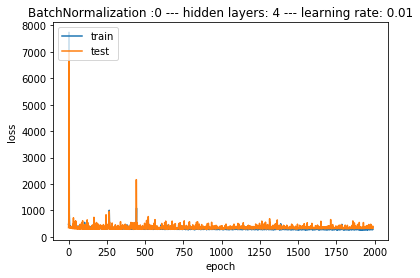

Train on 960 samples, validate on 241 samples
Epoch 1/2000
960/960 [==============================] - 4s 4ms/step - loss: 35069592.6476 - val_loss: 4351.5003
Epoch 2/2000
960/960 [==============================] - 1s 700us/step - loss: 2042.7912 - val_loss: 374.2483
Epoch 3/2000
960/960 [==============================] - 1s 752us/step - loss: 1228.3824 - val_loss: 353.1734
Epoch 4/2000
960/960 [==============================] - 1s 734us/step - loss: 492.7195 - val_loss: 482.0876
Epoch 5/2000
960/960 [==============================] - 1s 711us/step - loss: 492.9513 - val_loss: 380.1236
Epoch 6/2000
960/960 [==============================] - 1s 713us/step - loss: 407.5803 - val_loss: 544.6797
Epoch 7/2000
960/960 [==============================] - 1s 695us/step - loss: 416.9957 - val_loss: 395.7168
Epoch 8/2000
960/960 [==============================] - 1s 715us/step - loss: 503.8237 - val_loss: 364.1196
Epoch 9/2000
960/960 [==============================] - 1s 717us/step - loss: 445.84

Epoch 76/2000
960/960 [==============================] - 1s 756us/step - loss: 405.8302 - val_loss: 333.7863
Epoch 77/2000
960/960 [==============================] - 1s 720us/step - loss: 344.0967 - val_loss: 305.3614
Epoch 78/2000
960/960 [==============================] - 1s 691us/step - loss: 328.9245 - val_loss: 375.1344
Epoch 79/2000
960/960 [==============================] - 1s 712us/step - loss: 417.7856 - val_loss: 376.5593
Epoch 80/2000
960/960 [==============================] - 1s 710us/step - loss: 436.3152 - val_loss: 385.6025
Epoch 81/2000
960/960 [==============================] - 1s 728us/step - loss: 394.4073 - val_loss: 332.8576
Epoch 82/2000
960/960 [==============================] - 1s 739us/step - loss: 362.4243 - val_loss: 334.9526
Epoch 83/2000
960/960 [==============================] - 1s 719us/step - loss: 389.7749 - val_loss: 309.7348
Epoch 84/2000
960/960 [==============================] - 1s 711us/step - loss: 340.1728 - val_loss: 314.3779
Epoch 85/2000
960/9

960/960 [==============================] - 1s 784us/step - loss: 309.2653 - val_loss: 294.8606
Epoch 151/2000
960/960 [==============================] - 1s 718us/step - loss: 307.7385 - val_loss: 295.9505
Epoch 152/2000
960/960 [==============================] - 1s 721us/step - loss: 352.8681 - val_loss: 441.7112
Epoch 153/2000
960/960 [==============================] - 1s 706us/step - loss: 378.1145 - val_loss: 321.7249
Epoch 154/2000
960/960 [==============================] - 1s 695us/step - loss: 314.0961 - val_loss: 300.2344
Epoch 155/2000
960/960 [==============================] - 1s 729us/step - loss: 318.8916 - val_loss: 333.3050
Epoch 156/2000
960/960 [==============================] - 1s 743us/step - loss: 318.7676 - val_loss: 335.4668
Epoch 157/2000
960/960 [==============================] - 1s 727us/step - loss: 355.1668 - val_loss: 385.8771
Epoch 158/2000
960/960 [==============================] - 1s 709us/step - loss: 363.3128 - val_loss: 300.3399
Epoch 159/2000
960/960 [=

960/960 [==============================] - 1s 765us/step - loss: 337.2993 - val_loss: 319.3865
Epoch 225/2000
960/960 [==============================] - 1s 723us/step - loss: 318.2947 - val_loss: 336.0061
Epoch 226/2000
960/960 [==============================] - 1s 708us/step - loss: 304.0406 - val_loss: 296.9556
Epoch 227/2000
960/960 [==============================] - 1s 719us/step - loss: 311.5618 - val_loss: 295.3238
Epoch 228/2000
960/960 [==============================] - 1s 706us/step - loss: 352.5773 - val_loss: 297.0587
Epoch 229/2000
960/960 [==============================] - 1s 712us/step - loss: 332.8745 - val_loss: 380.8507
Epoch 230/2000
960/960 [==============================] - 1s 705us/step - loss: 317.0344 - val_loss: 297.8822
Epoch 231/2000
960/960 [==============================] - 1s 713us/step - loss: 300.8931 - val_loss: 345.3117
Epoch 232/2000
960/960 [==============================] - 1s 697us/step - loss: 355.5474 - val_loss: 368.3741
Epoch 233/2000
960/960 [=

960/960 [==============================] - 1s 749us/step - loss: 340.3460 - val_loss: 300.7275
Epoch 299/2000
960/960 [==============================] - 1s 715us/step - loss: 291.4340 - val_loss: 298.2682
Epoch 300/2000
960/960 [==============================] - 1s 707us/step - loss: 292.8255 - val_loss: 300.2563
Epoch 301/2000
960/960 [==============================] - 1s 723us/step - loss: 301.3273 - val_loss: 348.8137
Epoch 302/2000
960/960 [==============================] - 1s 700us/step - loss: 371.8647 - val_loss: 383.1446
Epoch 303/2000
960/960 [==============================] - 1s 698us/step - loss: 358.4723 - val_loss: 302.4123
Epoch 304/2000
960/960 [==============================] - 1s 704us/step - loss: 417.6037 - val_loss: 856.7815
Epoch 305/2000
960/960 [==============================] - 1s 742us/step - loss: 383.2460 - val_loss: 427.2447
Epoch 306/2000
960/960 [==============================] - 1s 686us/step - loss: 371.1367 - val_loss: 298.1240
Epoch 307/2000
960/960 [=

960/960 [==============================] - 1s 771us/step - loss: 314.0254 - val_loss: 296.8073
Epoch 373/2000
960/960 [==============================] - 1s 712us/step - loss: 313.6505 - val_loss: 301.2256
Epoch 374/2000
960/960 [==============================] - 1s 710us/step - loss: 304.8928 - val_loss: 299.5978
Epoch 375/2000
960/960 [==============================] - 1s 721us/step - loss: 370.7866 - val_loss: 332.8713
Epoch 376/2000
960/960 [==============================] - 1s 724us/step - loss: 298.8723 - val_loss: 334.9684
Epoch 377/2000
960/960 [==============================] - 1s 709us/step - loss: 296.0991 - val_loss: 369.4547
Epoch 378/2000
960/960 [==============================] - 1s 703us/step - loss: 310.7091 - val_loss: 349.4956
Epoch 379/2000
960/960 [==============================] - 1s 733us/step - loss: 355.3309 - val_loss: 363.0763
Epoch 380/2000
960/960 [==============================] - 1s 766us/step - loss: 342.5109 - val_loss: 305.1367
Epoch 381/2000
960/960 [=

960/960 [==============================] - 1s 760us/step - loss: 327.3728 - val_loss: 302.3940
Epoch 447/2000
960/960 [==============================] - 1s 704us/step - loss: 319.8532 - val_loss: 297.9642
Epoch 448/2000
960/960 [==============================] - 1s 736us/step - loss: 318.9787 - val_loss: 312.7553
Epoch 449/2000
960/960 [==============================] - 1s 711us/step - loss: 289.7320 - val_loss: 318.3580
Epoch 450/2000
960/960 [==============================] - 1s 699us/step - loss: 297.2937 - val_loss: 330.6110
Epoch 451/2000
960/960 [==============================] - 1s 712us/step - loss: 332.0461 - val_loss: 314.0416
Epoch 452/2000
960/960 [==============================] - 1s 724us/step - loss: 336.0836 - val_loss: 355.3493
Epoch 453/2000
960/960 [==============================] - 1s 732us/step - loss: 322.5326 - val_loss: 300.3939
Epoch 454/2000
960/960 [==============================] - 1s 699us/step - loss: 320.2530 - val_loss: 298.5921
Epoch 455/2000
960/960 [=

960/960 [==============================] - 1s 753us/step - loss: 328.9160 - val_loss: 307.6386
Epoch 521/2000
960/960 [==============================] - 1s 749us/step - loss: 300.6887 - val_loss: 319.0490
Epoch 522/2000
960/960 [==============================] - 1s 705us/step - loss: 365.5334 - val_loss: 532.7641
Epoch 523/2000
960/960 [==============================] - 1s 710us/step - loss: 396.6988 - val_loss: 361.9397
Epoch 524/2000
960/960 [==============================] - 1s 729us/step - loss: 313.2714 - val_loss: 298.8603
Epoch 525/2000
960/960 [==============================] - 1s 719us/step - loss: 307.7191 - val_loss: 304.7763
Epoch 526/2000
960/960 [==============================] - 1s 733us/step - loss: 317.6509 - val_loss: 345.8380
Epoch 527/2000
960/960 [==============================] - 1s 738us/step - loss: 300.8734 - val_loss: 332.9321
Epoch 528/2000
960/960 [==============================] - 1s 711us/step - loss: 356.9038 - val_loss: 299.6264
Epoch 529/2000
960/960 [=

960/960 [==============================] - 1s 745us/step - loss: 373.2374 - val_loss: 429.2490
Epoch 595/2000
960/960 [==============================] - 1s 706us/step - loss: 293.8586 - val_loss: 418.7936
Epoch 596/2000
960/960 [==============================] - 1s 713us/step - loss: 300.7396 - val_loss: 306.6874
Epoch 597/2000
960/960 [==============================] - 1s 698us/step - loss: 297.9106 - val_loss: 306.0080
Epoch 598/2000
960/960 [==============================] - 1s 707us/step - loss: 391.0764 - val_loss: 367.5076
Epoch 599/2000
960/960 [==============================] - 1s 717us/step - loss: 336.6406 - val_loss: 359.4698
Epoch 600/2000
960/960 [==============================] - 1s 722us/step - loss: 302.8659 - val_loss: 302.6220
Epoch 601/2000
960/960 [==============================] - 1s 719us/step - loss: 345.8480 - val_loss: 368.2906
Epoch 602/2000
960/960 [==============================] - 1s 753us/step - loss: 324.9297 - val_loss: 301.7015
Epoch 603/2000
960/960 [=

960/960 [==============================] - 1s 755us/step - loss: 301.9769 - val_loss: 328.3238
Epoch 669/2000
960/960 [==============================] - 1s 769us/step - loss: 305.2462 - val_loss: 302.5481
Epoch 670/2000
960/960 [==============================] - 1s 718us/step - loss: 280.9660 - val_loss: 324.1696
Epoch 671/2000
960/960 [==============================] - 1s 701us/step - loss: 307.6075 - val_loss: 310.5668
Epoch 672/2000
960/960 [==============================] - 1s 701us/step - loss: 290.1054 - val_loss: 312.9570
Epoch 673/2000
960/960 [==============================] - 1s 742us/step - loss: 286.9108 - val_loss: 303.8844
Epoch 674/2000
960/960 [==============================] - 1s 713us/step - loss: 400.3287 - val_loss: 386.8311
Epoch 675/2000
960/960 [==============================] - 1s 722us/step - loss: 350.9374 - val_loss: 339.9208
Epoch 676/2000
960/960 [==============================] - 1s 714us/step - loss: 320.7910 - val_loss: 364.5607
Epoch 677/2000
960/960 [=

960/960 [==============================] - 1s 747us/step - loss: 297.0343 - val_loss: 339.7720
Epoch 743/2000
960/960 [==============================] - 1s 721us/step - loss: 320.2758 - val_loss: 341.7504
Epoch 744/2000
960/960 [==============================] - 1s 740us/step - loss: 292.3273 - val_loss: 323.3422
Epoch 745/2000
960/960 [==============================] - 1s 716us/step - loss: 331.8788 - val_loss: 339.9662
Epoch 746/2000
960/960 [==============================] - 1s 723us/step - loss: 295.2245 - val_loss: 364.9628
Epoch 747/2000
960/960 [==============================] - 1s 707us/step - loss: 306.2764 - val_loss: 483.6292
Epoch 748/2000
960/960 [==============================] - 1s 710us/step - loss: 364.6452 - val_loss: 310.0466
Epoch 749/2000
960/960 [==============================] - 1s 772us/step - loss: 309.8010 - val_loss: 305.6945
Epoch 750/2000
960/960 [==============================] - 1s 771us/step - loss: 321.3705 - val_loss: 591.4769
Epoch 751/2000
960/960 [=

960/960 [==============================] - 1s 758us/step - loss: 339.1634 - val_loss: 405.0094
Epoch 817/2000
960/960 [==============================] - 1s 697us/step - loss: 331.4140 - val_loss: 306.3922
Epoch 818/2000
960/960 [==============================] - 1s 743us/step - loss: 300.6977 - val_loss: 313.1826
Epoch 819/2000
960/960 [==============================] - 1s 733us/step - loss: 316.8718 - val_loss: 378.4557
Epoch 820/2000
960/960 [==============================] - 1s 713us/step - loss: 374.6586 - val_loss: 502.5216
Epoch 821/2000
960/960 [==============================] - 1s 725us/step - loss: 409.2864 - val_loss: 570.5844
Epoch 822/2000
960/960 [==============================] - 1s 763us/step - loss: 334.1226 - val_loss: 348.6611
Epoch 823/2000
960/960 [==============================] - 1s 719us/step - loss: 361.3171 - val_loss: 330.0006
Epoch 824/2000
960/960 [==============================] - 1s 724us/step - loss: 297.2518 - val_loss: 344.3075
Epoch 825/2000
960/960 [=

960/960 [==============================] - 1s 743us/step - loss: 287.2117 - val_loss: 327.5166
Epoch 891/2000
960/960 [==============================] - 1s 735us/step - loss: 297.5347 - val_loss: 304.8644
Epoch 892/2000
960/960 [==============================] - 1s 712us/step - loss: 316.4127 - val_loss: 358.9097
Epoch 893/2000
960/960 [==============================] - 1s 719us/step - loss: 295.6422 - val_loss: 307.2239
Epoch 894/2000
960/960 [==============================] - 1s 732us/step - loss: 325.2063 - val_loss: 452.1925
Epoch 895/2000
960/960 [==============================] - 1s 703us/step - loss: 358.9818 - val_loss: 330.1355
Epoch 896/2000
960/960 [==============================] - 1s 729us/step - loss: 293.0807 - val_loss: 360.2822
Epoch 897/2000
960/960 [==============================] - 1s 729us/step - loss: 324.8119 - val_loss: 317.9459
Epoch 898/2000
960/960 [==============================] - 1s 713us/step - loss: 353.4531 - val_loss: 388.5207
Epoch 899/2000
960/960 [=

960/960 [==============================] - 1s 772us/step - loss: 387.6344 - val_loss: 347.1295
Epoch 965/2000
960/960 [==============================] - 1s 714us/step - loss: 300.7428 - val_loss: 340.6199
Epoch 966/2000
960/960 [==============================] - 1s 733us/step - loss: 309.5656 - val_loss: 413.4339
Epoch 967/2000
960/960 [==============================] - 1s 739us/step - loss: 324.4400 - val_loss: 394.2049
Epoch 968/2000
960/960 [==============================] - 1s 723us/step - loss: 288.7351 - val_loss: 366.9430
Epoch 969/2000
960/960 [==============================] - 1s 714us/step - loss: 321.5826 - val_loss: 521.5445
Epoch 970/2000
960/960 [==============================] - 1s 717us/step - loss: 295.2877 - val_loss: 318.6801
Epoch 971/2000
960/960 [==============================] - 1s 716us/step - loss: 280.4718 - val_loss: 331.1273
Epoch 972/2000
960/960 [==============================] - 1s 725us/step - loss: 320.2059 - val_loss: 320.0404
Epoch 973/2000
960/960 [=

960/960 [==============================] - 1s 750us/step - loss: 321.1739 - val_loss: 338.0633
Epoch 1039/2000
960/960 [==============================] - 1s 707us/step - loss: 305.9445 - val_loss: 306.4407
Epoch 1040/2000
960/960 [==============================] - 1s 711us/step - loss: 332.0247 - val_loss: 401.7640
Epoch 1041/2000
960/960 [==============================] - 1s 705us/step - loss: 321.5593 - val_loss: 362.2680
Epoch 1042/2000
960/960 [==============================] - 1s 730us/step - loss: 284.2005 - val_loss: 383.7986
Epoch 1043/2000
960/960 [==============================] - 1s 721us/step - loss: 323.6583 - val_loss: 306.2392
Epoch 1044/2000
960/960 [==============================] - 1s 728us/step - loss: 410.1290 - val_loss: 441.9792
Epoch 1045/2000
960/960 [==============================] - 1s 708us/step - loss: 307.8544 - val_loss: 322.3085
Epoch 1046/2000
960/960 [==============================] - 1s 703us/step - loss: 289.1533 - val_loss: 306.9772
Epoch 1047/2000
9

Epoch 1112/2000
960/960 [==============================] - 1s 748us/step - loss: 288.4840 - val_loss: 325.4757
Epoch 1113/2000
960/960 [==============================] - 1s 711us/step - loss: 302.0067 - val_loss: 306.2494
Epoch 1114/2000
960/960 [==============================] - 1s 708us/step - loss: 321.9149 - val_loss: 371.4565
Epoch 1115/2000
960/960 [==============================] - 1s 704us/step - loss: 307.9636 - val_loss: 334.3202
Epoch 1116/2000
960/960 [==============================] - 1s 721us/step - loss: 286.4326 - val_loss: 320.1035
Epoch 1117/2000
960/960 [==============================] - 1s 726us/step - loss: 323.6110 - val_loss: 313.8025
Epoch 1118/2000
960/960 [==============================] - 1s 702us/step - loss: 274.4958 - val_loss: 320.1269
Epoch 1119/2000
960/960 [==============================] - 1s 695us/step - loss: 274.9260 - val_loss: 323.9228
Epoch 1120/2000
960/960 [==============================] - 1s 726us/step - loss: 340.6977 - val_loss: 319.8824
E

960/960 [==============================] - 1s 764us/step - loss: 305.9993 - val_loss: 334.6413
Epoch 1186/2000
960/960 [==============================] - 1s 720us/step - loss: 293.0723 - val_loss: 377.9569
Epoch 1187/2000
960/960 [==============================] - 1s 701us/step - loss: 300.2080 - val_loss: 309.2777
Epoch 1188/2000
960/960 [==============================] - 1s 720us/step - loss: 291.8584 - val_loss: 315.5052
Epoch 1189/2000
960/960 [==============================] - 1s 714us/step - loss: 290.9914 - val_loss: 309.2153
Epoch 1190/2000
960/960 [==============================] - 1s 711us/step - loss: 272.1032 - val_loss: 311.2587
Epoch 1191/2000
960/960 [==============================] - 1s 710us/step - loss: 298.6194 - val_loss: 329.1297
Epoch 1192/2000
960/960 [==============================] - 1s 726us/step - loss: 284.0533 - val_loss: 312.8119
Epoch 1193/2000
960/960 [==============================] - 1s 713us/step - loss: 273.3733 - val_loss: 320.1734
Epoch 1194/2000
9

Epoch 1259/2000
960/960 [==============================] - 1s 768us/step - loss: 280.7226 - val_loss: 375.4196
Epoch 1260/2000
960/960 [==============================] - 1s 765us/step - loss: 309.3989 - val_loss: 309.9595
Epoch 1261/2000
960/960 [==============================] - 1s 730us/step - loss: 280.3861 - val_loss: 315.1261
Epoch 1262/2000
960/960 [==============================] - 1s 708us/step - loss: 310.5157 - val_loss: 327.1008
Epoch 1263/2000
960/960 [==============================] - 1s 706us/step - loss: 292.5401 - val_loss: 311.2070
Epoch 1264/2000
960/960 [==============================] - 1s 715us/step - loss: 285.3349 - val_loss: 311.9824
Epoch 1265/2000
960/960 [==============================] - 1s 717us/step - loss: 276.6908 - val_loss: 326.7144
Epoch 1266/2000
960/960 [==============================] - 1s 717us/step - loss: 290.5584 - val_loss: 333.5317
Epoch 1267/2000
960/960 [==============================] - 1s 721us/step - loss: 295.9823 - val_loss: 311.1961
E

Epoch 1333/2000
960/960 [==============================] - 1s 749us/step - loss: 340.7371 - val_loss: 347.9242
Epoch 1334/2000
960/960 [==============================] - 1s 747us/step - loss: 362.4067 - val_loss: 329.0101
Epoch 1335/2000
960/960 [==============================] - 1s 697us/step - loss: 396.8893 - val_loss: 332.0658
Epoch 1336/2000
960/960 [==============================] - 1s 723us/step - loss: 326.2932 - val_loss: 363.2892
Epoch 1337/2000
960/960 [==============================] - 1s 731us/step - loss: 339.5476 - val_loss: 422.5577
Epoch 1338/2000
960/960 [==============================] - 1s 716us/step - loss: 311.7709 - val_loss: 309.3880
Epoch 1339/2000
960/960 [==============================] - 1s 717us/step - loss: 282.8680 - val_loss: 328.8568
Epoch 1340/2000
960/960 [==============================] - 1s 709us/step - loss: 282.7695 - val_loss: 353.9080
Epoch 1341/2000
960/960 [==============================] - 1s 716us/step - loss: 273.1360 - val_loss: 341.3285
E

Epoch 1407/2000
960/960 [==============================] - 1s 747us/step - loss: 278.7164 - val_loss: 379.6343
Epoch 1408/2000
960/960 [==============================] - 1s 703us/step - loss: 286.8641 - val_loss: 334.7634
Epoch 1409/2000
960/960 [==============================] - 1s 717us/step - loss: 279.4613 - val_loss: 322.7583
Epoch 1410/2000
960/960 [==============================] - 1s 717us/step - loss: 278.6032 - val_loss: 312.9414
Epoch 1411/2000
960/960 [==============================] - 1s 716us/step - loss: 282.5273 - val_loss: 313.0920
Epoch 1412/2000
960/960 [==============================] - 1s 714us/step - loss: 285.9901 - val_loss: 333.8493
Epoch 1413/2000
960/960 [==============================] - 1s 735us/step - loss: 270.1943 - val_loss: 312.9570
Epoch 1414/2000
960/960 [==============================] - 1s 730us/step - loss: 285.1990 - val_loss: 338.5542
Epoch 1415/2000
960/960 [==============================] - 1s 716us/step - loss: 283.3040 - val_loss: 324.7483
E

Epoch 1481/2000
960/960 [==============================] - 1s 743us/step - loss: 387.2914 - val_loss: 328.9001
Epoch 1482/2000
960/960 [==============================] - 1s 707us/step - loss: 327.8367 - val_loss: 347.4574
Epoch 1483/2000
960/960 [==============================] - 1s 706us/step - loss: 296.4228 - val_loss: 307.5452
Epoch 1484/2000
960/960 [==============================] - 1s 719us/step - loss: 281.6834 - val_loss: 430.1683
Epoch 1485/2000
960/960 [==============================] - 1s 711us/step - loss: 287.3510 - val_loss: 313.9678
Epoch 1486/2000
960/960 [==============================] - 1s 723us/step - loss: 311.8853 - val_loss: 310.4985
Epoch 1487/2000
960/960 [==============================] - 1s 704us/step - loss: 339.1013 - val_loss: 370.9850
Epoch 1488/2000
960/960 [==============================] - 1s 711us/step - loss: 307.8999 - val_loss: 308.1846
Epoch 1489/2000
960/960 [==============================] - 1s 720us/step - loss: 287.5443 - val_loss: 314.5866
E

Epoch 1555/2000
960/960 [==============================] - 1s 745us/step - loss: 379.6815 - val_loss: 446.4641
Epoch 1556/2000
960/960 [==============================] - 1s 712us/step - loss: 398.5953 - val_loss: 587.2390
Epoch 1557/2000
960/960 [==============================] - 1s 711us/step - loss: 355.6820 - val_loss: 460.4058
Epoch 1558/2000
960/960 [==============================] - 1s 762us/step - loss: 302.6197 - val_loss: 337.1057
Epoch 1559/2000
960/960 [==============================] - 1s 773us/step - loss: 286.4111 - val_loss: 380.3686
Epoch 1560/2000
960/960 [==============================] - 1s 716us/step - loss: 274.5920 - val_loss: 315.1461
Epoch 1561/2000
960/960 [==============================] - 1s 737us/step - loss: 286.8907 - val_loss: 320.1272
Epoch 1562/2000
960/960 [==============================] - 1s 722us/step - loss: 330.6704 - val_loss: 350.7754
Epoch 1563/2000
960/960 [==============================] - 1s 733us/step - loss: 298.2270 - val_loss: 320.7206
E

Epoch 1629/2000
960/960 [==============================] - 1s 727us/step - loss: 311.4846 - val_loss: 317.1214
Epoch 1630/2000
960/960 [==============================] - 1s 719us/step - loss: 288.3017 - val_loss: 331.7379
Epoch 1631/2000
960/960 [==============================] - 1s 716us/step - loss: 289.1099 - val_loss: 346.5222
Epoch 1632/2000
960/960 [==============================] - 1s 715us/step - loss: 288.7908 - val_loss: 388.9008
Epoch 1633/2000
960/960 [==============================] - 1s 712us/step - loss: 314.3050 - val_loss: 358.7098
Epoch 1634/2000
960/960 [==============================] - 1s 694us/step - loss: 281.4839 - val_loss: 319.6013
Epoch 1635/2000
960/960 [==============================] - 1s 704us/step - loss: 279.1567 - val_loss: 333.4937
Epoch 1636/2000
960/960 [==============================] - 1s 715us/step - loss: 279.2124 - val_loss: 338.9674
Epoch 1637/2000
960/960 [==============================] - 1s 710us/step - loss: 327.3569 - val_loss: 507.0030
E

Epoch 1703/2000
960/960 [==============================] - 1s 736us/step - loss: 282.8701 - val_loss: 337.4736
Epoch 1704/2000
960/960 [==============================] - 1s 740us/step - loss: 277.7540 - val_loss: 341.3291
Epoch 1705/2000
960/960 [==============================] - 1s 716us/step - loss: 285.2183 - val_loss: 335.9305
Epoch 1706/2000
960/960 [==============================] - 1s 732us/step - loss: 300.2686 - val_loss: 322.0214
Epoch 1707/2000
960/960 [==============================] - 1s 724us/step - loss: 281.8081 - val_loss: 682.6948
Epoch 1708/2000
960/960 [==============================] - 1s 720us/step - loss: 334.7081 - val_loss: 320.1473
Epoch 1709/2000
960/960 [==============================] - 1s 721us/step - loss: 287.6475 - val_loss: 328.5661
Epoch 1710/2000
960/960 [==============================] - 1s 724us/step - loss: 300.2795 - val_loss: 391.6068
Epoch 1711/2000
960/960 [==============================] - 1s 717us/step - loss: 307.1931 - val_loss: 320.3721
E

Epoch 1777/2000
960/960 [==============================] - 1s 752us/step - loss: 313.0225 - val_loss: 333.7895
Epoch 1778/2000
960/960 [==============================] - 1s 719us/step - loss: 273.8917 - val_loss: 356.1866
Epoch 1779/2000
960/960 [==============================] - 1s 715us/step - loss: 274.7468 - val_loss: 318.5792
Epoch 1780/2000
960/960 [==============================] - 1s 709us/step - loss: 278.0910 - val_loss: 583.4457
Epoch 1781/2000
960/960 [==============================] - 1s 715us/step - loss: 300.8962 - val_loss: 451.3219
Epoch 1782/2000
960/960 [==============================] - 1s 716us/step - loss: 426.3813 - val_loss: 471.2202
Epoch 1783/2000
960/960 [==============================] - 1s 725us/step - loss: 396.9177 - val_loss: 312.4939
Epoch 1784/2000
960/960 [==============================] - 1s 716us/step - loss: 305.3473 - val_loss: 316.7156
Epoch 1785/2000
960/960 [==============================] - 1s 725us/step - loss: 267.8447 - val_loss: 319.5498
E

Epoch 1851/2000
960/960 [==============================] - 1s 736us/step - loss: 279.8835 - val_loss: 319.2848
Epoch 1852/2000
960/960 [==============================] - 1s 720us/step - loss: 278.1087 - val_loss: 371.6434
Epoch 1853/2000
960/960 [==============================] - 1s 721us/step - loss: 312.7571 - val_loss: 486.4623
Epoch 1854/2000
960/960 [==============================] - 1s 710us/step - loss: 306.2649 - val_loss: 362.7164
Epoch 1855/2000
960/960 [==============================] - 1s 704us/step - loss: 294.1156 - val_loss: 315.3220
Epoch 1856/2000
960/960 [==============================] - 1s 711us/step - loss: 343.0190 - val_loss: 418.9840
Epoch 1857/2000
960/960 [==============================] - 1s 742us/step - loss: 295.5791 - val_loss: 320.2153
Epoch 1858/2000
960/960 [==============================] - 1s 710us/step - loss: 315.4328 - val_loss: 485.9371
Epoch 1859/2000
960/960 [==============================] - 1s 735us/step - loss: 424.6518 - val_loss: 315.6180
E

960/960 [==============================] - 1s 780us/step - loss: 293.7191 - val_loss: 377.9719
Epoch 1925/2000
960/960 [==============================] - 1s 717us/step - loss: 296.4825 - val_loss: 319.9958
Epoch 1926/2000
960/960 [==============================] - 1s 725us/step - loss: 280.5283 - val_loss: 314.5922
Epoch 1927/2000
960/960 [==============================] - 1s 701us/step - loss: 292.4997 - val_loss: 339.8468
Epoch 1928/2000
960/960 [==============================] - 1s 716us/step - loss: 274.8680 - val_loss: 315.5941
Epoch 1929/2000
960/960 [==============================] - 1s 727us/step - loss: 311.6369 - val_loss: 340.4020
Epoch 1930/2000
960/960 [==============================] - 1s 708us/step - loss: 311.2907 - val_loss: 544.7874
Epoch 1931/2000
960/960 [==============================] - 1s 720us/step - loss: 320.4347 - val_loss: 317.6633
Epoch 1932/2000
960/960 [==============================] - 1s 714us/step - loss: 278.7663 - val_loss: 346.2255
Epoch 1933/2000
9

Epoch 1998/2000
960/960 [==============================] - 1s 734us/step - loss: 341.8324 - val_loss: 347.8399
Epoch 1999/2000
960/960 [==============================] - 1s 717us/step - loss: 286.7738 - val_loss: 328.9394
Epoch 2000/2000
960/960 [==============================] - 1s 712us/step - loss: 292.7007 - val_loss: 319.4588


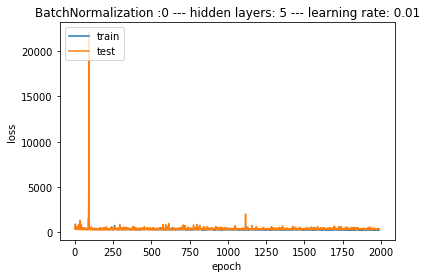

Train on 960 samples, validate on 241 samples
Epoch 1/2000
960/960 [==============================] - 4s 4ms/step - loss: 38705512.7299 - val_loss: 8049.3205
Epoch 2/2000
960/960 [==============================] - 1s 830us/step - loss: 28744.9377 - val_loss: 14569.3017
Epoch 3/2000
960/960 [==============================] - 1s 829us/step - loss: 3955.3349 - val_loss: 527.6196
Epoch 4/2000
960/960 [==============================] - 1s 835us/step - loss: 588.2337 - val_loss: 491.4403
Epoch 5/2000
960/960 [==============================] - 1s 830us/step - loss: 1003.6109 - val_loss: 347.1213
Epoch 6/2000
960/960 [==============================] - 1s 861us/step - loss: 674.6861 - val_loss: 866.7628
Epoch 7/2000
960/960 [==============================] - 1s 839us/step - loss: 588.6391 - val_loss: 755.5410
Epoch 8/2000
960/960 [==============================] - 1s 814us/step - loss: 502.7686 - val_loss: 736.1449
Epoch 9/2000
960/960 [==============================] - 1s 853us/step - loss: 64

960/960 [==============================] - 1s 874us/step - loss: 450.6405 - val_loss: 402.4891
Epoch 76/2000
960/960 [==============================] - 1s 828us/step - loss: 386.6593 - val_loss: 401.9861
Epoch 77/2000
960/960 [==============================] - 1s 840us/step - loss: 449.6725 - val_loss: 307.7677
Epoch 78/2000
960/960 [==============================] - 1s 855us/step - loss: 557.8722 - val_loss: 326.7669
Epoch 79/2000
960/960 [==============================] - 1s 871us/step - loss: 477.0939 - val_loss: 870.2707
Epoch 80/2000
960/960 [==============================] - 1s 795us/step - loss: 398.2189 - val_loss: 324.3923
Epoch 81/2000
960/960 [==============================] - 1s 808us/step - loss: 361.1752 - val_loss: 420.7578
Epoch 82/2000
960/960 [==============================] - 1s 823us/step - loss: 354.3811 - val_loss: 312.8015
Epoch 83/2000
960/960 [==============================] - 1s 848us/step - loss: 477.2309 - val_loss: 677.6316
Epoch 84/2000
960/960 [==========

960/960 [==============================] - 1s 848us/step - loss: 485.2429 - val_loss: 413.6929
Epoch 150/2000
960/960 [==============================] - 1s 847us/step - loss: 357.4129 - val_loss: 298.1581
Epoch 151/2000
960/960 [==============================] - 1s 829us/step - loss: 341.8381 - val_loss: 306.0738
Epoch 152/2000
960/960 [==============================] - 1s 842us/step - loss: 351.5458 - val_loss: 350.5600
Epoch 153/2000
960/960 [==============================] - 1s 827us/step - loss: 466.4118 - val_loss: 428.2169
Epoch 154/2000
960/960 [==============================] - 1s 808us/step - loss: 360.3320 - val_loss: 403.6479
Epoch 155/2000
960/960 [==============================] - 1s 797us/step - loss: 383.9549 - val_loss: 345.5796
Epoch 156/2000
960/960 [==============================] - 1s 866us/step - loss: 314.0349 - val_loss: 300.5291
Epoch 157/2000
960/960 [==============================] - 1s 841us/step - loss: 419.5119 - val_loss: 307.0882
Epoch 158/2000
960/960 [=

960/960 [==============================] - 1s 892us/step - loss: 472.3909 - val_loss: 402.8069
Epoch 224/2000
960/960 [==============================] - 1s 846us/step - loss: 478.8440 - val_loss: 405.4693
Epoch 225/2000
960/960 [==============================] - 1s 802us/step - loss: 464.4786 - val_loss: 404.1062
Epoch 226/2000
960/960 [==============================] - 1s 860us/step - loss: 459.9497 - val_loss: 402.2991
Epoch 227/2000
960/960 [==============================] - 1s 823us/step - loss: 464.0101 - val_loss: 407.9035
Epoch 228/2000
960/960 [==============================] - 1s 851us/step - loss: 463.2024 - val_loss: 404.0106
Epoch 229/2000
960/960 [==============================] - 1s 845us/step - loss: 463.0030 - val_loss: 402.4347
Epoch 230/2000
960/960 [==============================] - 1s 822us/step - loss: 461.5726 - val_loss: 417.6637
Epoch 231/2000
960/960 [==============================] - 1s 865us/step - loss: 462.8504 - val_loss: 405.6230
Epoch 232/2000
960/960 [=

960/960 [==============================] - 1s 860us/step - loss: 462.9507 - val_loss: 402.2869
Epoch 298/2000
960/960 [==============================] - 1s 850us/step - loss: 461.3091 - val_loss: 416.3200
Epoch 299/2000
960/960 [==============================] - 1s 841us/step - loss: 460.8207 - val_loss: 410.6914
Epoch 300/2000
960/960 [==============================] - 1s 838us/step - loss: 464.7083 - val_loss: 402.3429
Epoch 301/2000
960/960 [==============================] - 1s 844us/step - loss: 467.1076 - val_loss: 402.5688
Epoch 302/2000
960/960 [==============================] - 1s 817us/step - loss: 462.7470 - val_loss: 404.3088
Epoch 303/2000
960/960 [==============================] - 1s 867us/step - loss: 462.4659 - val_loss: 409.5106
Epoch 304/2000
960/960 [==============================] - 1s 898us/step - loss: 467.7505 - val_loss: 402.2751
Epoch 305/2000
960/960 [==============================] - 1s 861us/step - loss: 473.0459 - val_loss: 458.3684
Epoch 306/2000
960/960 [=

960/960 [==============================] - 1s 871us/step - loss: 472.5687 - val_loss: 441.8880
Epoch 372/2000
960/960 [==============================] - 1s 850us/step - loss: 470.3773 - val_loss: 428.6421
Epoch 373/2000
960/960 [==============================] - 1s 856us/step - loss: 462.0895 - val_loss: 451.6787
Epoch 374/2000
960/960 [==============================] - 1s 854us/step - loss: 472.1388 - val_loss: 403.8264
Epoch 375/2000
960/960 [==============================] - 1s 854us/step - loss: 464.1629 - val_loss: 402.4816
Epoch 376/2000
960/960 [==============================] - 1s 858us/step - loss: 468.6064 - val_loss: 405.6214
Epoch 377/2000
960/960 [==============================] - 1s 860us/step - loss: 466.1059 - val_loss: 438.1770
Epoch 378/2000
960/960 [==============================] - 1s 855us/step - loss: 464.5335 - val_loss: 408.5439
Epoch 379/2000
960/960 [==============================] - 1s 881us/step - loss: 459.4064 - val_loss: 461.3475
Epoch 380/2000
960/960 [=

960/960 [==============================] - 1s 887us/step - loss: 463.7085 - val_loss: 403.0238
Epoch 446/2000
960/960 [==============================] - 1s 868us/step - loss: 469.3293 - val_loss: 402.6187
Epoch 447/2000
960/960 [==============================] - 1s 844us/step - loss: 463.8714 - val_loss: 404.8648
Epoch 448/2000
960/960 [==============================] - 1s 854us/step - loss: 466.6191 - val_loss: 423.5937
Epoch 449/2000
960/960 [==============================] - 1s 856us/step - loss: 470.6045 - val_loss: 419.3471
Epoch 450/2000
960/960 [==============================] - 1s 816us/step - loss: 458.9854 - val_loss: 402.4509
Epoch 451/2000
960/960 [==============================] - 1s 860us/step - loss: 463.3122 - val_loss: 402.9705
Epoch 452/2000
960/960 [==============================] - 1s 837us/step - loss: 462.1132 - val_loss: 407.8143
Epoch 453/2000
960/960 [==============================] - 1s 824us/step - loss: 460.8432 - val_loss: 402.4019
Epoch 454/2000
960/960 [=

960/960 [==============================] - 1s 845us/step - loss: 474.0404 - val_loss: 419.7479
Epoch 520/2000
960/960 [==============================] - 1s 841us/step - loss: 462.3259 - val_loss: 403.3962
Epoch 521/2000
960/960 [==============================] - 1s 815us/step - loss: 462.3230 - val_loss: 402.3640
Epoch 522/2000
960/960 [==============================] - 1s 792us/step - loss: 462.7610 - val_loss: 407.0613
Epoch 523/2000
960/960 [==============================] - 1s 878us/step - loss: 468.3816 - val_loss: 431.5266
Epoch 524/2000
960/960 [==============================] - 1s 843us/step - loss: 462.8447 - val_loss: 406.7172
Epoch 525/2000
960/960 [==============================] - 1s 836us/step - loss: 462.3855 - val_loss: 407.3979
Epoch 526/2000
960/960 [==============================] - 1s 862us/step - loss: 459.4316 - val_loss: 409.8025
Epoch 527/2000
960/960 [==============================] - 1s 856us/step - loss: 465.6324 - val_loss: 422.7498
Epoch 528/2000
960/960 [=

960/960 [==============================] - 1s 850us/step - loss: 470.7109 - val_loss: 403.6494
Epoch 594/2000
960/960 [==============================] - 1s 839us/step - loss: 459.9100 - val_loss: 403.9804
Epoch 595/2000
960/960 [==============================] - 1s 853us/step - loss: 472.9692 - val_loss: 403.2829
Epoch 596/2000
960/960 [==============================] - 1s 858us/step - loss: 462.5473 - val_loss: 425.0103
Epoch 597/2000
960/960 [==============================] - 1s 843us/step - loss: 468.8918 - val_loss: 415.7944
Epoch 598/2000
960/960 [==============================] - 1s 853us/step - loss: 459.3426 - val_loss: 407.3881
Epoch 599/2000
960/960 [==============================] - 1s 837us/step - loss: 477.2972 - val_loss: 453.8374
Epoch 600/2000
960/960 [==============================] - 1s 863us/step - loss: 469.3776 - val_loss: 405.2275
Epoch 601/2000
960/960 [==============================] - 1s 845us/step - loss: 460.0424 - val_loss: 408.5135
Epoch 602/2000
960/960 [=

960/960 [==============================] - 1s 840us/step - loss: 478.2176 - val_loss: 480.2180
Epoch 668/2000
960/960 [==============================] - 1s 807us/step - loss: 476.0203 - val_loss: 433.0299
Epoch 669/2000
960/960 [==============================] - 1s 842us/step - loss: 478.4381 - val_loss: 419.4034
Epoch 670/2000
960/960 [==============================] - 1s 811us/step - loss: 465.2117 - val_loss: 433.6876
Epoch 671/2000
960/960 [==============================] - 1s 852us/step - loss: 459.2378 - val_loss: 402.3228
Epoch 672/2000
960/960 [==============================] - 1s 857us/step - loss: 463.6045 - val_loss: 403.7774
Epoch 673/2000
960/960 [==============================] - 1s 860us/step - loss: 466.2572 - val_loss: 403.9005
Epoch 674/2000
960/960 [==============================] - 1s 844us/step - loss: 459.0850 - val_loss: 407.2601
Epoch 675/2000
960/960 [==============================] - 1s 875us/step - loss: 458.8415 - val_loss: 410.6501
Epoch 676/2000
960/960 [=

960/960 [==============================] - 1s 845us/step - loss: 466.1442 - val_loss: 403.2600
Epoch 742/2000
960/960 [==============================] - 1s 855us/step - loss: 459.5457 - val_loss: 407.7017
Epoch 743/2000
960/960 [==============================] - 1s 852us/step - loss: 467.9130 - val_loss: 412.7949
Epoch 744/2000
960/960 [==============================] - 1s 848us/step - loss: 479.5620 - val_loss: 402.4036
Epoch 745/2000
960/960 [==============================] - 1s 851us/step - loss: 465.8654 - val_loss: 402.4212
Epoch 746/2000
960/960 [==============================] - 1s 869us/step - loss: 461.3729 - val_loss: 404.7263
Epoch 747/2000
960/960 [==============================] - 1s 842us/step - loss: 472.6072 - val_loss: 407.4393
Epoch 748/2000
960/960 [==============================] - 1s 840us/step - loss: 479.8786 - val_loss: 402.5568
Epoch 749/2000
960/960 [==============================] - 1s 843us/step - loss: 472.6786 - val_loss: 409.7340
Epoch 750/2000
960/960 [=

960/960 [==============================] - 1s 864us/step - loss: 462.2130 - val_loss: 439.3769
Epoch 816/2000
960/960 [==============================] - 1s 852us/step - loss: 463.6781 - val_loss: 415.1194
Epoch 817/2000
960/960 [==============================] - 1s 853us/step - loss: 463.6791 - val_loss: 404.9998
Epoch 818/2000
960/960 [==============================] - 1s 836us/step - loss: 460.5205 - val_loss: 403.6725
Epoch 819/2000
960/960 [==============================] - 1s 848us/step - loss: 460.0065 - val_loss: 420.7730
Epoch 820/2000
960/960 [==============================] - 1s 810us/step - loss: 463.0982 - val_loss: 423.0258
Epoch 821/2000
960/960 [==============================] - 1s 864us/step - loss: 460.1132 - val_loss: 402.3983
Epoch 822/2000
960/960 [==============================] - 1s 856us/step - loss: 467.5373 - val_loss: 403.3047
Epoch 823/2000
960/960 [==============================] - 1s 813us/step - loss: 459.6315 - val_loss: 406.7980
Epoch 824/2000
960/960 [=

960/960 [==============================] - 1s 864us/step - loss: 460.2519 - val_loss: 406.9897
Epoch 890/2000
960/960 [==============================] - 1s 860us/step - loss: 459.3688 - val_loss: 403.8964
Epoch 891/2000
960/960 [==============================] - 1s 830us/step - loss: 460.0830 - val_loss: 405.3549
Epoch 892/2000
960/960 [==============================] - 1s 855us/step - loss: 460.3896 - val_loss: 430.5782
Epoch 893/2000
960/960 [==============================] - 1s 841us/step - loss: 466.5395 - val_loss: 444.7373
Epoch 894/2000
960/960 [==============================] - 1s 835us/step - loss: 474.7086 - val_loss: 407.5642
Epoch 895/2000
960/960 [==============================] - 1s 829us/step - loss: 468.8833 - val_loss: 402.3929
Epoch 896/2000
960/960 [==============================] - 1s 868us/step - loss: 461.0165 - val_loss: 410.8870
Epoch 897/2000
960/960 [==============================] - 1s 852us/step - loss: 460.7562 - val_loss: 403.9544
Epoch 898/2000
960/960 [=

960/960 [==============================] - 1s 853us/step - loss: 461.4863 - val_loss: 403.0000
Epoch 964/2000
960/960 [==============================] - 1s 833us/step - loss: 459.6766 - val_loss: 407.5940
Epoch 965/2000
960/960 [==============================] - 1s 834us/step - loss: 469.1166 - val_loss: 459.3912
Epoch 966/2000
960/960 [==============================] - 1s 798us/step - loss: 485.2178 - val_loss: 470.6762
Epoch 967/2000
960/960 [==============================] - 1s 844us/step - loss: 473.8824 - val_loss: 420.4627
Epoch 968/2000
960/960 [==============================] - 1s 872us/step - loss: 463.2661 - val_loss: 402.5283
Epoch 969/2000
960/960 [==============================] - 1s 826us/step - loss: 463.3793 - val_loss: 403.3899
Epoch 970/2000
960/960 [==============================] - 1s 860us/step - loss: 468.4803 - val_loss: 402.8529
Epoch 971/2000
960/960 [==============================] - 1s 868us/step - loss: 466.8754 - val_loss: 402.7327
Epoch 972/2000
960/960 [=

960/960 [==============================] - 1s 879us/step - loss: 471.3575 - val_loss: 420.4151
Epoch 1038/2000
960/960 [==============================] - 1s 837us/step - loss: 461.6753 - val_loss: 423.2514
Epoch 1039/2000
960/960 [==============================] - 1s 866us/step - loss: 463.7644 - val_loss: 409.8341
Epoch 1040/2000
960/960 [==============================] - 1s 850us/step - loss: 461.0849 - val_loss: 404.4799
Epoch 1041/2000
960/960 [==============================] - 1s 885us/step - loss: 464.2829 - val_loss: 402.2913
Epoch 1042/2000
960/960 [==============================] - 1s 828us/step - loss: 462.9763 - val_loss: 403.3806
Epoch 1043/2000
960/960 [==============================] - 1s 860us/step - loss: 467.5087 - val_loss: 447.1498
Epoch 1044/2000
960/960 [==============================] - 1s 862us/step - loss: 485.3157 - val_loss: 407.2848
Epoch 1045/2000
960/960 [==============================] - 1s 930us/step - loss: 477.4313 - val_loss: 402.5548
Epoch 1046/2000
9

Epoch 1111/2000
960/960 [==============================] - 1s 837us/step - loss: 461.3618 - val_loss: 405.3469
Epoch 1112/2000
960/960 [==============================] - 1s 865us/step - loss: 461.0740 - val_loss: 431.0392
Epoch 1113/2000
960/960 [==============================] - 1s 838us/step - loss: 461.1003 - val_loss: 406.6211
Epoch 1114/2000
960/960 [==============================] - 1s 855us/step - loss: 461.0281 - val_loss: 417.0259
Epoch 1115/2000
960/960 [==============================] - 1s 860us/step - loss: 462.6356 - val_loss: 434.9106
Epoch 1116/2000
960/960 [==============================] - 1s 854us/step - loss: 475.9942 - val_loss: 430.7629
Epoch 1117/2000
960/960 [==============================] - 1s 855us/step - loss: 462.2296 - val_loss: 403.6610
Epoch 1118/2000
960/960 [==============================] - 1s 849us/step - loss: 459.2989 - val_loss: 415.0775
Epoch 1119/2000
960/960 [==============================] - 1s 837us/step - loss: 458.9210 - val_loss: 419.6294
E

Epoch 1185/2000
960/960 [==============================] - 1s 885us/step - loss: 461.2551 - val_loss: 403.2480
Epoch 1186/2000
960/960 [==============================] - 1s 836us/step - loss: 460.2129 - val_loss: 402.2654
Epoch 1187/2000
960/960 [==============================] - 1s 834us/step - loss: 484.5681 - val_loss: 428.4134
Epoch 1188/2000
960/960 [==============================] - 1s 851us/step - loss: 465.0768 - val_loss: 408.0343
Epoch 1189/2000
960/960 [==============================] - 1s 834us/step - loss: 470.6246 - val_loss: 416.6695
Epoch 1190/2000
960/960 [==============================] - 1s 879us/step - loss: 463.5786 - val_loss: 432.7210
Epoch 1191/2000
960/960 [==============================] - 1s 867us/step - loss: 468.1904 - val_loss: 468.9025
Epoch 1192/2000
960/960 [==============================] - 1s 857us/step - loss: 468.3580 - val_loss: 406.9407
Epoch 1193/2000
960/960 [==============================] - 1s 864us/step - loss: 461.0870 - val_loss: 403.9077
E

Epoch 1259/2000
960/960 [==============================] - 1s 871us/step - loss: 461.3624 - val_loss: 411.1436
Epoch 1260/2000
960/960 [==============================] - 1s 828us/step - loss: 459.8018 - val_loss: 403.5751
Epoch 1261/2000
960/960 [==============================] - ETA: 0s - loss: 468.200 - 1s 861us/step - loss: 462.1509 - val_loss: 415.6686
Epoch 1262/2000
960/960 [==============================] - 1s 849us/step - loss: 462.4069 - val_loss: 409.1125
Epoch 1263/2000
960/960 [==============================] - 1s 838us/step - loss: 464.0106 - val_loss: 411.7330
Epoch 1264/2000
960/960 [==============================] - 1s 860us/step - loss: 463.9328 - val_loss: 404.6283
Epoch 1265/2000
960/960 [==============================] - 1s 847us/step - loss: 466.2499 - val_loss: 405.1163
Epoch 1266/2000
960/960 [==============================] - 1s 843us/step - loss: 460.7509 - val_loss: 411.3255
Epoch 1267/2000
960/960 [==============================] - 1s 834us/step - loss: 462.1

960/960 [==============================] - 1s 888us/step - loss: 466.4200 - val_loss: 449.1714
Epoch 1333/2000
960/960 [==============================] - 1s 862us/step - loss: 467.7247 - val_loss: 404.6699
Epoch 1334/2000
960/960 [==============================] - 1s 829us/step - loss: 463.8906 - val_loss: 402.5861
Epoch 1335/2000
960/960 [==============================] - 1s 793us/step - loss: 467.5063 - val_loss: 432.4590
Epoch 1336/2000
960/960 [==============================] - 1s 857us/step - loss: 471.5928 - val_loss: 409.1453
Epoch 1337/2000
960/960 [==============================] - 1s 841us/step - loss: 470.7778 - val_loss: 412.4585
Epoch 1338/2000
960/960 [==============================] - 1s 788us/step - loss: 475.3905 - val_loss: 416.3750
Epoch 1339/2000
960/960 [==============================] - 1s 865us/step - loss: 478.9049 - val_loss: 442.7388
Epoch 1340/2000
960/960 [==============================] - 1s 855us/step - loss: 469.0983 - val_loss: 402.9259
Epoch 1341/2000
9

Epoch 1406/2000
960/960 [==============================] - 1s 875us/step - loss: 461.6221 - val_loss: 404.2424
Epoch 1407/2000
960/960 [==============================] - 1s 847us/step - loss: 476.7588 - val_loss: 404.9969
Epoch 1408/2000
960/960 [==============================] - 1s 838us/step - loss: 477.3822 - val_loss: 436.7054
Epoch 1409/2000
960/960 [==============================] - 1s 886us/step - loss: 457.8919 - val_loss: 406.0563
Epoch 1410/2000
960/960 [==============================] - 1s 821us/step - loss: 471.0281 - val_loss: 412.3463
Epoch 1411/2000
960/960 [==============================] - 1s 825us/step - loss: 464.0254 - val_loss: 415.8051
Epoch 1412/2000
960/960 [==============================] - 1s 826us/step - loss: 459.7496 - val_loss: 414.2607
Epoch 1413/2000
960/960 [==============================] - 1s 957us/step - loss: 468.3641 - val_loss: 416.2693
Epoch 1414/2000
960/960 [==============================] - 1s 875us/step - loss: 462.2654 - val_loss: 417.3324
E

960/960 [==============================] - 1s 864us/step - loss: 470.7031 - val_loss: 403.5103
Epoch 1480/2000
960/960 [==============================] - 1s 860us/step - loss: 460.8407 - val_loss: 402.2661
Epoch 1481/2000
960/960 [==============================] - 1s 850us/step - loss: 461.2185 - val_loss: 402.5865
Epoch 1482/2000
960/960 [==============================] - 1s 854us/step - loss: 463.7982 - val_loss: 403.2941
Epoch 1483/2000
960/960 [==============================] - 1s 856us/step - loss: 468.3390 - val_loss: 407.4088
Epoch 1484/2000
960/960 [==============================] - 1s 850us/step - loss: 461.4477 - val_loss: 403.0650
Epoch 1485/2000
960/960 [==============================] - 1s 787us/step - loss: 462.3138 - val_loss: 405.1465
Epoch 1486/2000
960/960 [==============================] - 1s 772us/step - loss: 461.1860 - val_loss: 405.3534
Epoch 1487/2000
960/960 [==============================] - 1s 852us/step - loss: 461.6452 - val_loss: 402.2658
Epoch 1488/2000
9

Epoch 1553/2000
960/960 [==============================] - 1s 858us/step - loss: 466.3775 - val_loss: 407.5146
Epoch 1554/2000
960/960 [==============================] - 1s 855us/step - loss: 463.9121 - val_loss: 403.0209
Epoch 1555/2000
960/960 [==============================] - 1s 863us/step - loss: 460.3174 - val_loss: 402.5838
Epoch 1556/2000
960/960 [==============================] - 1s 816us/step - loss: 464.0272 - val_loss: 402.3444
Epoch 1557/2000
960/960 [==============================] - 1s 845us/step - loss: 458.3555 - val_loss: 414.7165
Epoch 1558/2000
960/960 [==============================] - 1s 860us/step - loss: 458.7139 - val_loss: 402.8668
Epoch 1559/2000
960/960 [==============================] - 1s 810us/step - loss: 466.8297 - val_loss: 480.1042
Epoch 1560/2000
960/960 [==============================] - 1s 829us/step - loss: 498.7562 - val_loss: 404.2757
Epoch 1561/2000
960/960 [==============================] - 1s 843us/step - loss: 466.0502 - val_loss: 402.8750
E

Epoch 1627/2000
960/960 [==============================] - 1s 876us/step - loss: 465.5873 - val_loss: 404.6453
Epoch 1628/2000
960/960 [==============================] - 1s 817us/step - loss: 464.8678 - val_loss: 409.1591
Epoch 1629/2000
960/960 [==============================] - 1s 845us/step - loss: 469.6390 - val_loss: 405.0475
Epoch 1630/2000
960/960 [==============================] - 1s 810us/step - loss: 461.6774 - val_loss: 405.5143
Epoch 1631/2000
960/960 [==============================] - 1s 835us/step - loss: 463.6857 - val_loss: 425.8668
Epoch 1632/2000
960/960 [==============================] - 1s 795us/step - loss: 477.7878 - val_loss: 471.7039
Epoch 1633/2000
960/960 [==============================] - 1s 850us/step - loss: 473.3159 - val_loss: 403.6747
Epoch 1634/2000
960/960 [==============================] - 1s 847us/step - loss: 463.3712 - val_loss: 411.9230
Epoch 1635/2000
960/960 [==============================] - 1s 853us/step - loss: 462.7638 - val_loss: 431.0908
E

Epoch 1701/2000
960/960 [==============================] - 1s 840us/step - loss: 459.9303 - val_loss: 407.4136
Epoch 1702/2000
960/960 [==============================] - 1s 824us/step - loss: 466.1316 - val_loss: 463.3292
Epoch 1703/2000
960/960 [==============================] - 1s 799us/step - loss: 473.7589 - val_loss: 511.6052
Epoch 1704/2000
960/960 [==============================] - 1s 841us/step - loss: 498.0096 - val_loss: 402.6854
Epoch 1705/2000
960/960 [==============================] - 1s 814us/step - loss: 476.0872 - val_loss: 405.9519
Epoch 1706/2000
960/960 [==============================] - 1s 850us/step - loss: 480.4943 - val_loss: 406.4447
Epoch 1707/2000
960/960 [==============================] - 1s 826us/step - loss: 484.0384 - val_loss: 402.7656
Epoch 1708/2000
960/960 [==============================] - 1s 810us/step - loss: 465.0796 - val_loss: 405.7592
Epoch 1709/2000
960/960 [==============================] - 1s 807us/step - loss: 462.4612 - val_loss: 413.1631
E

Epoch 1775/2000
960/960 [==============================] - 1s 857us/step - loss: 478.3391 - val_loss: 480.7862
Epoch 1776/2000
960/960 [==============================] - 1s 838us/step - loss: 477.9434 - val_loss: 430.6832
Epoch 1777/2000
960/960 [==============================] - 1s 784us/step - loss: 465.0758 - val_loss: 410.1773
Epoch 1778/2000
960/960 [==============================] - 1s 800us/step - loss: 463.8207 - val_loss: 469.5653
Epoch 1779/2000
960/960 [==============================] - 1s 842us/step - loss: 472.4742 - val_loss: 417.0350
Epoch 1780/2000
960/960 [==============================] - 1s 841us/step - loss: 460.2539 - val_loss: 436.1169
Epoch 1781/2000
960/960 [==============================] - 1s 936us/step - loss: 463.9498 - val_loss: 414.4045
Epoch 1782/2000
960/960 [==============================] - 1s 910us/step - loss: 462.0960 - val_loss: 421.3300
Epoch 1783/2000
960/960 [==============================] - 1s 872us/step - loss: 462.3987 - val_loss: 421.0381
E

Epoch 1849/2000
960/960 [==============================] - 1s 862us/step - loss: 464.6479 - val_loss: 404.0240
Epoch 1850/2000
960/960 [==============================] - 1s 845us/step - loss: 459.6243 - val_loss: 402.3599
Epoch 1851/2000
960/960 [==============================] - 1s 878us/step - loss: 466.2493 - val_loss: 402.7538
Epoch 1852/2000
960/960 [==============================] - 1s 859us/step - loss: 479.3568 - val_loss: 407.1275
Epoch 1853/2000
960/960 [==============================] - 1s 811us/step - loss: 459.7212 - val_loss: 415.0738
Epoch 1854/2000
960/960 [==============================] - 1s 863us/step - loss: 464.4249 - val_loss: 402.4118
Epoch 1855/2000
960/960 [==============================] - 1s 848us/step - loss: 461.1085 - val_loss: 402.2655
Epoch 1856/2000
960/960 [==============================] - 1s 831us/step - loss: 463.7951 - val_loss: 407.4223
Epoch 1857/2000
960/960 [==============================] - 1s 838us/step - loss: 468.5622 - val_loss: 415.3654
E

Epoch 1923/2000
960/960 [==============================] - 1s 860us/step - loss: 466.2471 - val_loss: 407.9297
Epoch 1924/2000
960/960 [==============================] - 1s 808us/step - loss: 461.9535 - val_loss: 402.3600
Epoch 1925/2000
960/960 [==============================] - 1s 854us/step - loss: 460.3746 - val_loss: 405.3319
Epoch 1926/2000
960/960 [==============================] - 1s 831us/step - loss: 465.4960 - val_loss: 404.2528
Epoch 1927/2000
960/960 [==============================] - 1s 828us/step - loss: 467.6263 - val_loss: 402.6026
Epoch 1928/2000
960/960 [==============================] - 1s 797us/step - loss: 462.3317 - val_loss: 403.1341
Epoch 1929/2000
960/960 [==============================] - 1s 808us/step - loss: 461.4868 - val_loss: 430.0615
Epoch 1930/2000
960/960 [==============================] - 1s 820us/step - loss: 462.1471 - val_loss: 403.5060
Epoch 1931/2000
960/960 [==============================] - 1s 831us/step - loss: 463.2127 - val_loss: 415.6620
E

Epoch 1997/2000
960/960 [==============================] - 1s 881us/step - loss: 461.1445 - val_loss: 402.7652
Epoch 1998/2000
960/960 [==============================] - 1s 852us/step - loss: 465.4732 - val_loss: 402.7360
Epoch 1999/2000
960/960 [==============================] - 1s 850us/step - loss: 461.9847 - val_loss: 411.5293
Epoch 2000/2000
960/960 [==============================] - 1s 831us/step - loss: 459.4278 - val_loss: 405.7886


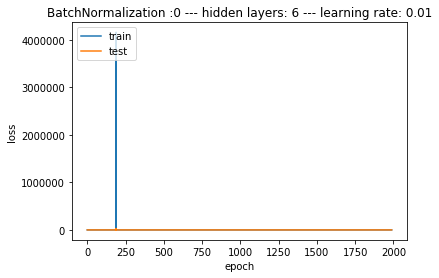

Train on 960 samples, validate on 241 samples
Epoch 1/2000
960/960 [==============================] - 3s 3ms/step - loss: 37078.1647 - val_loss: 38568.6370
Epoch 2/2000
960/960 [==============================] - 0s 124us/step - loss: 24268.8324 - val_loss: 55641.3633
Epoch 3/2000
960/960 [==============================] - 0s 104us/step - loss: 5927.9006 - val_loss: 35513.3514
Epoch 4/2000
960/960 [==============================] - 0s 106us/step - loss: 761.9068 - val_loss: 2095.8575
Epoch 5/2000
960/960 [==============================] - 0s 108us/step - loss: 502.3957 - val_loss: 1170.7213
Epoch 6/2000
960/960 [==============================] - 0s 106us/step - loss: 355.5054 - val_loss: 819.6973
Epoch 7/2000
960/960 [==============================] - 0s 111us/step - loss: 307.8806 - val_loss: 729.4191
Epoch 8/2000
960/960 [==============================] - 0s 106us/step - loss: 295.1653 - val_loss: 1567.5514
Epoch 9/2000
960/960 [==============================] - 0s 114us/step - loss: 

960/960 [==============================] - 0s 104us/step - loss: 255.5326 - val_loss: 360.9865
Epoch 76/2000
960/960 [==============================] - 0s 113us/step - loss: 260.4764 - val_loss: 362.3773
Epoch 77/2000
960/960 [==============================] - 0s 110us/step - loss: 262.5893 - val_loss: 348.2020
Epoch 78/2000
960/960 [==============================] - 0s 118us/step - loss: 255.3348 - val_loss: 343.6080
Epoch 79/2000
960/960 [==============================] - 0s 100us/step - loss: 261.4420 - val_loss: 375.8561
Epoch 80/2000
960/960 [==============================] - 0s 118us/step - loss: 255.1346 - val_loss: 349.9088
Epoch 81/2000
960/960 [==============================] - 0s 108us/step - loss: 256.8367 - val_loss: 347.3965
Epoch 82/2000
960/960 [==============================] - 0s 106us/step - loss: 261.5555 - val_loss: 356.2655
Epoch 83/2000
960/960 [==============================] - 0s 99us/step - loss: 257.5651 - val_loss: 354.4414
Epoch 84/2000
960/960 [===========

Epoch 150/2000
960/960 [==============================] - 0s 104us/step - loss: 254.4555 - val_loss: 351.7999
Epoch 151/2000
960/960 [==============================] - 0s 112us/step - loss: 254.4213 - val_loss: 375.1340
Epoch 152/2000
960/960 [==============================] - 0s 103us/step - loss: 252.3432 - val_loss: 354.9116
Epoch 153/2000
960/960 [==============================] - 0s 105us/step - loss: 252.2606 - val_loss: 350.0559
Epoch 154/2000
960/960 [==============================] - 0s 103us/step - loss: 256.1701 - val_loss: 353.1630
Epoch 155/2000
960/960 [==============================] - 0s 104us/step - loss: 260.8681 - val_loss: 368.3855
Epoch 156/2000
960/960 [==============================] - 0s 103us/step - loss: 257.2826 - val_loss: 443.7061
Epoch 157/2000
960/960 [==============================] - 0s 102us/step - loss: 257.4743 - val_loss: 372.8240
Epoch 158/2000
960/960 [==============================] - 0s 110us/step - loss: 289.0239 - val_loss: 360.0643
Epoch 159/

960/960 [==============================] - 0s 111us/step - loss: 267.3023 - val_loss: 396.7584
Epoch 225/2000
960/960 [==============================] - 0s 121us/step - loss: 274.4316 - val_loss: 374.8587
Epoch 226/2000
960/960 [==============================] - 0s 100us/step - loss: 270.6697 - val_loss: 390.2357
Epoch 227/2000
960/960 [==============================] - 0s 98us/step - loss: 258.7443 - val_loss: 363.9526
Epoch 228/2000
960/960 [==============================] - 0s 103us/step - loss: 243.5675 - val_loss: 365.7748
Epoch 229/2000
960/960 [==============================] - 0s 97us/step - loss: 251.0443 - val_loss: 380.2818
Epoch 230/2000
960/960 [==============================] - 0s 101us/step - loss: 252.4406 - val_loss: 364.4921
Epoch 231/2000
960/960 [==============================] - 0s 104us/step - loss: 249.7857 - val_loss: 380.6712
Epoch 232/2000
960/960 [==============================] - 0s 99us/step - loss: 253.1690 - val_loss: 369.2937
Epoch 233/2000
960/960 [====

960/960 [==============================] - 0s 101us/step - loss: 252.5526 - val_loss: 407.8986
Epoch 299/2000
960/960 [==============================] - 0s 128us/step - loss: 264.4537 - val_loss: 484.7656
Epoch 300/2000
960/960 [==============================] - 0s 103us/step - loss: 272.5738 - val_loss: 452.8709
Epoch 301/2000
960/960 [==============================] - 0s 100us/step - loss: 261.9422 - val_loss: 355.3165
Epoch 302/2000
960/960 [==============================] - 0s 105us/step - loss: 260.8834 - val_loss: 360.5267
Epoch 303/2000
960/960 [==============================] - 0s 101us/step - loss: 254.1821 - val_loss: 367.0766
Epoch 304/2000
960/960 [==============================] - 0s 99us/step - loss: 257.9175 - val_loss: 385.3282
Epoch 305/2000
960/960 [==============================] - 0s 107us/step - loss: 241.7561 - val_loss: 378.7560
Epoch 306/2000
960/960 [==============================] - 0s 111us/step - loss: 244.5428 - val_loss: 372.0879
Epoch 307/2000
960/960 [==

960/960 [==============================] - 0s 99us/step - loss: 248.3782 - val_loss: 376.0170
Epoch 373/2000
960/960 [==============================] - 0s 101us/step - loss: 245.9884 - val_loss: 375.4126
Epoch 374/2000
960/960 [==============================] - 0s 116us/step - loss: 253.9054 - val_loss: 364.5390
Epoch 375/2000
960/960 [==============================] - 0s 105us/step - loss: 251.1625 - val_loss: 377.3215
Epoch 376/2000
960/960 [==============================] - 0s 101us/step - loss: 242.5955 - val_loss: 363.3424
Epoch 377/2000
960/960 [==============================] - 0s 105us/step - loss: 248.5630 - val_loss: 370.9300
Epoch 378/2000
960/960 [==============================] - 0s 107us/step - loss: 250.0624 - val_loss: 365.9229
Epoch 379/2000
960/960 [==============================] - 0s 112us/step - loss: 251.0238 - val_loss: 362.0893
Epoch 380/2000
960/960 [==============================] - 0s 105us/step - loss: 246.8125 - val_loss: 369.2655
Epoch 381/2000
960/960 [==

960/960 [==============================] - 0s 100us/step - loss: 246.4474 - val_loss: 368.0662
Epoch 447/2000
960/960 [==============================] - 0s 110us/step - loss: 252.4918 - val_loss: 377.5940
Epoch 448/2000
960/960 [==============================] - 0s 112us/step - loss: 245.6452 - val_loss: 363.0778
Epoch 449/2000
960/960 [==============================] - 0s 104us/step - loss: 248.7859 - val_loss: 388.6012
Epoch 450/2000
960/960 [==============================] - 0s 100us/step - loss: 248.3072 - val_loss: 385.0795
Epoch 451/2000
960/960 [==============================] - 0s 102us/step - loss: 251.2082 - val_loss: 405.7318
Epoch 452/2000
960/960 [==============================] - 0s 101us/step - loss: 243.1356 - val_loss: 372.1613
Epoch 453/2000
960/960 [==============================] - 0s 100us/step - loss: 256.4642 - val_loss: 431.7151
Epoch 454/2000
960/960 [==============================] - 0s 102us/step - loss: 253.8805 - val_loss: 380.8232
Epoch 455/2000
960/960 [=

960/960 [==============================] - 0s 100us/step - loss: 258.0096 - val_loss: 403.6124
Epoch 521/2000
960/960 [==============================] - 0s 107us/step - loss: 246.5090 - val_loss: 382.6487
Epoch 522/2000
960/960 [==============================] - 0s 111us/step - loss: 247.9643 - val_loss: 401.3571
Epoch 523/2000
960/960 [==============================] - 0s 118us/step - loss: 253.6560 - val_loss: 451.9189
Epoch 524/2000
960/960 [==============================] - 0s 96us/step - loss: 259.3431 - val_loss: 454.6439
Epoch 525/2000
960/960 [==============================] - 0s 122us/step - loss: 254.3841 - val_loss: 384.5211
Epoch 526/2000
960/960 [==============================] - 0s 122us/step - loss: 251.4036 - val_loss: 366.3858
Epoch 527/2000
960/960 [==============================] - 0s 105us/step - loss: 247.4728 - val_loss: 368.6973
Epoch 528/2000
960/960 [==============================] - 0s 101us/step - loss: 247.0953 - val_loss: 357.9962
Epoch 529/2000
960/960 [==

960/960 [==============================] - 0s 96us/step - loss: 260.3614 - val_loss: 407.2024
Epoch 595/2000
960/960 [==============================] - 0s 110us/step - loss: 246.1149 - val_loss: 400.0890
Epoch 596/2000
960/960 [==============================] - 0s 111us/step - loss: 245.1487 - val_loss: 377.5794
Epoch 597/2000
960/960 [==============================] - 0s 110us/step - loss: 241.9624 - val_loss: 375.6753
Epoch 598/2000
960/960 [==============================] - 0s 100us/step - loss: 257.4711 - val_loss: 404.7088
Epoch 599/2000
960/960 [==============================] - 0s 101us/step - loss: 257.5408 - val_loss: 436.1453
Epoch 600/2000
960/960 [==============================] - 0s 107us/step - loss: 250.9285 - val_loss: 406.0844
Epoch 601/2000
960/960 [==============================] - 0s 104us/step - loss: 250.6899 - val_loss: 371.4990
Epoch 602/2000
960/960 [==============================] - 0s 98us/step - loss: 254.8174 - val_loss: 379.1673
Epoch 603/2000
960/960 [===

960/960 [==============================] - 0s 106us/step - loss: 245.7692 - val_loss: 369.2459
Epoch 669/2000
960/960 [==============================] - 0s 105us/step - loss: 262.6059 - val_loss: 371.8879
Epoch 670/2000
960/960 [==============================] - 0s 118us/step - loss: 269.8963 - val_loss: 366.2282
Epoch 671/2000
960/960 [==============================] - 0s 111us/step - loss: 242.3553 - val_loss: 380.0686
Epoch 672/2000
960/960 [==============================] - 0s 110us/step - loss: 246.0359 - val_loss: 418.2805
Epoch 673/2000
960/960 [==============================] - 0s 107us/step - loss: 266.5533 - val_loss: 421.9563
Epoch 674/2000
960/960 [==============================] - 0s 109us/step - loss: 241.4798 - val_loss: 369.3447
Epoch 675/2000
960/960 [==============================] - 0s 99us/step - loss: 236.0282 - val_loss: 411.2984
Epoch 676/2000
960/960 [==============================] - 0s 120us/step - loss: 249.4404 - val_loss: 391.2640
Epoch 677/2000
960/960 [==

Epoch 743/2000
960/960 [==============================] - 0s 98us/step - loss: 243.6639 - val_loss: 369.0713
Epoch 744/2000
960/960 [==============================] - 0s 112us/step - loss: 247.1442 - val_loss: 371.5404
Epoch 745/2000
960/960 [==============================] - 0s 112us/step - loss: 245.0766 - val_loss: 362.4973
Epoch 746/2000
960/960 [==============================] - 0s 114us/step - loss: 251.3171 - val_loss: 388.4023
Epoch 747/2000
960/960 [==============================] - 0s 105us/step - loss: 242.2645 - val_loss: 374.3799
Epoch 748/2000
960/960 [==============================] - 0s 109us/step - loss: 247.3008 - val_loss: 379.2811
Epoch 749/2000
960/960 [==============================] - 0s 107us/step - loss: 254.8145 - val_loss: 373.1109
Epoch 750/2000
960/960 [==============================] - 0s 114us/step - loss: 254.2001 - val_loss: 371.0960
Epoch 751/2000
960/960 [==============================] - 0s 106us/step - loss: 240.8530 - val_loss: 387.4738
Epoch 752/2

960/960 [==============================] - 0s 106us/step - loss: 257.5100 - val_loss: 435.4142
Epoch 818/2000
960/960 [==============================] - 0s 119us/step - loss: 270.1547 - val_loss: 418.8485
Epoch 819/2000
960/960 [==============================] - 0s 105us/step - loss: 262.2901 - val_loss: 413.3836
Epoch 820/2000
960/960 [==============================] - 0s 103us/step - loss: 259.7505 - val_loss: 477.9326
Epoch 821/2000
960/960 [==============================] - 0s 104us/step - loss: 264.3396 - val_loss: 453.8516
Epoch 822/2000
960/960 [==============================] - 0s 102us/step - loss: 251.8704 - val_loss: 379.1772
Epoch 823/2000
960/960 [==============================] - 0s 104us/step - loss: 241.1029 - val_loss: 380.9573
Epoch 824/2000
960/960 [==============================] - 0s 116us/step - loss: 247.3376 - val_loss: 380.4325
Epoch 825/2000
960/960 [==============================] - 0s 119us/step - loss: 251.3980 - val_loss: 396.7621
Epoch 826/2000
960/960 [=

960/960 [==============================] - 0s 103us/step - loss: 246.0710 - val_loss: 374.5530
Epoch 892/2000
960/960 [==============================] - 0s 113us/step - loss: 242.9204 - val_loss: 364.6799
Epoch 893/2000
960/960 [==============================] - 0s 108us/step - loss: 242.3472 - val_loss: 372.8749
Epoch 894/2000
960/960 [==============================] - 0s 101us/step - loss: 241.2599 - val_loss: 402.3817
Epoch 895/2000
960/960 [==============================] - 0s 109us/step - loss: 239.9801 - val_loss: 386.4261
Epoch 896/2000
960/960 [==============================] - 0s 106us/step - loss: 251.5123 - val_loss: 374.3659
Epoch 897/2000
960/960 [==============================] - 0s 107us/step - loss: 260.3098 - val_loss: 391.2887
Epoch 898/2000
960/960 [==============================] - 0s 105us/step - loss: 246.3671 - val_loss: 419.0644
Epoch 899/2000
960/960 [==============================] - 0s 107us/step - loss: 244.9293 - val_loss: 378.1215
Epoch 900/2000
960/960 [=

960/960 [==============================] - 0s 118us/step - loss: 261.6342 - val_loss: 362.8457
Epoch 966/2000
960/960 [==============================] - 0s 132us/step - loss: 253.7131 - val_loss: 396.2851
Epoch 967/2000
960/960 [==============================] - 0s 114us/step - loss: 245.5909 - val_loss: 447.3798
Epoch 968/2000
960/960 [==============================] - 0s 110us/step - loss: 252.4423 - val_loss: 372.1007
Epoch 969/2000
960/960 [==============================] - 0s 105us/step - loss: 245.8266 - val_loss: 417.1510
Epoch 970/2000
960/960 [==============================] - 0s 98us/step - loss: 255.2865 - val_loss: 384.2502
Epoch 971/2000
960/960 [==============================] - 0s 104us/step - loss: 240.1772 - val_loss: 364.7326
Epoch 972/2000
960/960 [==============================] - 0s 110us/step - loss: 245.8790 - val_loss: 379.3234
Epoch 973/2000
960/960 [==============================] - 0s 125us/step - loss: 251.2638 - val_loss: 398.9813
Epoch 974/2000
960/960 [==

960/960 [==============================] - 0s 98us/step - loss: 241.8937 - val_loss: 376.4114
Epoch 1040/2000
960/960 [==============================] - 0s 118us/step - loss: 242.8888 - val_loss: 383.6961
Epoch 1041/2000
960/960 [==============================] - 0s 113us/step - loss: 240.5111 - val_loss: 399.8848
Epoch 1042/2000
960/960 [==============================] - 0s 109us/step - loss: 242.4513 - val_loss: 394.7950
Epoch 1043/2000
960/960 [==============================] - 0s 117us/step - loss: 243.8444 - val_loss: 374.2341
Epoch 1044/2000
960/960 [==============================] - 0s 104us/step - loss: 248.5502 - val_loss: 393.4470
Epoch 1045/2000
960/960 [==============================] - 0s 96us/step - loss: 242.8243 - val_loss: 404.1490
Epoch 1046/2000
960/960 [==============================] - 0s 110us/step - loss: 239.6975 - val_loss: 369.2333
Epoch 1047/2000
960/960 [==============================] - 0s 104us/step - loss: 244.1412 - val_loss: 384.7085
Epoch 1048/2000
960

960/960 [==============================] - 0s 106us/step - loss: 246.4380 - val_loss: 369.0397
Epoch 1114/2000
960/960 [==============================] - 0s 124us/step - loss: 254.7916 - val_loss: 367.6957
Epoch 1115/2000
960/960 [==============================] - 0s 102us/step - loss: 246.2540 - val_loss: 379.0267
Epoch 1116/2000
960/960 [==============================] - 0s 104us/step - loss: 244.2707 - val_loss: 372.9458
Epoch 1117/2000
960/960 [==============================] - 0s 100us/step - loss: 257.9558 - val_loss: 369.0358
Epoch 1118/2000
960/960 [==============================] - 0s 102us/step - loss: 246.3693 - val_loss: 389.1107
Epoch 1119/2000
960/960 [==============================] - 0s 104us/step - loss: 242.0117 - val_loss: 410.8270
Epoch 1120/2000
960/960 [==============================] - 0s 101us/step - loss: 242.8713 - val_loss: 383.5098
Epoch 1121/2000
960/960 [==============================] - 0s 103us/step - loss: 246.1886 - val_loss: 401.2943
Epoch 1122/2000
9

960/960 [==============================] - 0s 97us/step - loss: 240.7974 - val_loss: 376.4773
Epoch 1188/2000
960/960 [==============================] - 0s 113us/step - loss: 243.6451 - val_loss: 395.6186
Epoch 1189/2000
960/960 [==============================] - 0s 111us/step - loss: 245.1513 - val_loss: 383.7889
Epoch 1190/2000
960/960 [==============================] - 0s 104us/step - loss: 249.4719 - val_loss: 374.1159
Epoch 1191/2000
960/960 [==============================] - 0s 103us/step - loss: 242.1053 - val_loss: 369.8237
Epoch 1192/2000
960/960 [==============================] - 0s 118us/step - loss: 241.3688 - val_loss: 377.6899
Epoch 1193/2000
960/960 [==============================] - 0s 112us/step - loss: 245.4716 - val_loss: 382.2180
Epoch 1194/2000
960/960 [==============================] - 0s 106us/step - loss: 245.9725 - val_loss: 410.6076
Epoch 1195/2000
960/960 [==============================] - 0s 103us/step - loss: 246.8405 - val_loss: 374.1011
Epoch 1196/2000
96

Epoch 1261/2000
960/960 [==============================] - 0s 104us/step - loss: 243.9218 - val_loss: 368.7262
Epoch 1262/2000
960/960 [==============================] - 0s 136us/step - loss: 239.3445 - val_loss: 369.8764
Epoch 1263/2000
960/960 [==============================] - 0s 104us/step - loss: 255.1712 - val_loss: 379.1927
Epoch 1264/2000
960/960 [==============================] - 0s 103us/step - loss: 246.3485 - val_loss: 382.0934
Epoch 1265/2000
960/960 [==============================] - 0s 105us/step - loss: 245.0855 - val_loss: 401.8539
Epoch 1266/2000
960/960 [==============================] - 0s 101us/step - loss: 251.9952 - val_loss: 386.7430
Epoch 1267/2000
960/960 [==============================] - 0s 98us/step - loss: 248.5172 - val_loss: 434.2209
Epoch 1268/2000
960/960 [==============================] - 0s 103us/step - loss: 251.0980 - val_loss: 369.4464
Epoch 1269/2000
960/960 [==============================] - 0s 118us/step - loss: 241.2492 - val_loss: 366.5146
Ep

Epoch 1335/2000
960/960 [==============================] - 0s 97us/step - loss: 245.2324 - val_loss: 407.7797
Epoch 1336/2000
960/960 [==============================] - 0s 115us/step - loss: 249.9046 - val_loss: 417.3889
Epoch 1337/2000
960/960 [==============================] - 0s 105us/step - loss: 241.7431 - val_loss: 381.3072
Epoch 1338/2000
960/960 [==============================] - 0s 103us/step - loss: 250.9630 - val_loss: 374.2086
Epoch 1339/2000
960/960 [==============================] - 0s 103us/step - loss: 246.9926 - val_loss: 370.0851
Epoch 1340/2000
960/960 [==============================] - 0s 102us/step - loss: 244.9476 - val_loss: 389.1368
Epoch 1341/2000
960/960 [==============================] - 0s 106us/step - loss: 240.7489 - val_loss: 378.0234
Epoch 1342/2000
960/960 [==============================] - 0s 124us/step - loss: 240.4997 - val_loss: 376.8177
Epoch 1343/2000
960/960 [==============================] - 0s 116us/step - loss: 246.6651 - val_loss: 387.7655
Ep

960/960 [==============================] - 0s 105us/step - loss: 245.5843 - val_loss: 366.1865
Epoch 1409/2000
960/960 [==============================] - 0s 119us/step - loss: 243.0925 - val_loss: 370.9406
Epoch 1410/2000
960/960 [==============================] - 0s 123us/step - loss: 239.9453 - val_loss: 385.1077
Epoch 1411/2000
960/960 [==============================] - 0s 116us/step - loss: 240.9773 - val_loss: 367.5653
Epoch 1412/2000
960/960 [==============================] - 0s 106us/step - loss: 248.4924 - val_loss: 396.5124
Epoch 1413/2000
960/960 [==============================] - 0s 103us/step - loss: 246.8989 - val_loss: 418.9494
Epoch 1414/2000
960/960 [==============================] - 0s 105us/step - loss: 242.6160 - val_loss: 382.9056
Epoch 1415/2000
960/960 [==============================] - 0s 100us/step - loss: 251.1839 - val_loss: 363.2723
Epoch 1416/2000
960/960 [==============================] - 0s 105us/step - loss: 252.4433 - val_loss: 365.3118
Epoch 1417/2000
9

Epoch 1482/2000
960/960 [==============================] - 0s 99us/step - loss: 245.0477 - val_loss: 399.0401
Epoch 1483/2000
960/960 [==============================] - 0s 130us/step - loss: 242.4053 - val_loss: 366.6336
Epoch 1484/2000
960/960 [==============================] - 0s 110us/step - loss: 245.9081 - val_loss: 362.3927
Epoch 1485/2000
960/960 [==============================] - 0s 108us/step - loss: 245.9360 - val_loss: 394.2196
Epoch 1486/2000
960/960 [==============================] - 0s 103us/step - loss: 243.7563 - val_loss: 372.1410
Epoch 1487/2000
960/960 [==============================] - 0s 104us/step - loss: 235.1777 - val_loss: 380.1197
Epoch 1488/2000
960/960 [==============================] - 0s 101us/step - loss: 249.2044 - val_loss: 375.0226
Epoch 1489/2000
960/960 [==============================] - 0s 104us/step - loss: 246.6859 - val_loss: 369.0435
Epoch 1490/2000
960/960 [==============================] - 0s 106us/step - loss: 240.0842 - val_loss: 395.4783
Ep

Epoch 1556/2000
960/960 [==============================] - 0s 103us/step - loss: 243.2381 - val_loss: 383.0513
Epoch 1557/2000
960/960 [==============================] - 0s 122us/step - loss: 240.8778 - val_loss: 391.2733
Epoch 1558/2000
960/960 [==============================] - 0s 104us/step - loss: 241.8058 - val_loss: 376.6577
Epoch 1559/2000
960/960 [==============================] - 0s 98us/step - loss: 239.9864 - val_loss: 374.7012
Epoch 1560/2000
960/960 [==============================] - 0s 104us/step - loss: 242.6326 - val_loss: 365.7054
Epoch 1561/2000
960/960 [==============================] - 0s 97us/step - loss: 253.0904 - val_loss: 387.5446
Epoch 1562/2000
960/960 [==============================] - 0s 101us/step - loss: 244.9938 - val_loss: 375.4259
Epoch 1563/2000
960/960 [==============================] - 0s 99us/step - loss: 248.4474 - val_loss: 365.8405
Epoch 1564/2000
960/960 [==============================] - 0s 102us/step - loss: 247.1479 - val_loss: 365.9639
Epoc

Epoch 1630/2000
960/960 [==============================] - 0s 106us/step - loss: 250.8502 - val_loss: 421.8975
Epoch 1631/2000
960/960 [==============================] - 0s 116us/step - loss: 250.9715 - val_loss: 420.5825
Epoch 1632/2000
960/960 [==============================] - 0s 103us/step - loss: 246.6005 - val_loss: 381.1588
Epoch 1633/2000
960/960 [==============================] - 0s 111us/step - loss: 241.4695 - val_loss: 367.4696
Epoch 1634/2000
960/960 [==============================] - 0s 99us/step - loss: 250.4297 - val_loss: 369.1609
Epoch 1635/2000
960/960 [==============================] - 0s 111us/step - loss: 247.6423 - val_loss: 370.8162
Epoch 1636/2000
960/960 [==============================] - 0s 118us/step - loss: 264.8648 - val_loss: 393.4254
Epoch 1637/2000
960/960 [==============================] - 0s 117us/step - loss: 247.9880 - val_loss: 412.6019
Epoch 1638/2000
960/960 [==============================] - 0s 99us/step - loss: 248.6355 - val_loss: 398.5622
Epo

960/960 [==============================] - 0s 110us/step - loss: 243.1222 - val_loss: 384.9080
Epoch 1704/2000
960/960 [==============================] - 0s 125us/step - loss: 240.4625 - val_loss: 373.9240
Epoch 1705/2000
960/960 [==============================] - 0s 107us/step - loss: 252.8833 - val_loss: 366.7350
Epoch 1706/2000
960/960 [==============================] - 0s 122us/step - loss: 235.5872 - val_loss: 405.5889
Epoch 1707/2000
960/960 [==============================] - 0s 108us/step - loss: 245.7192 - val_loss: 401.2755
Epoch 1708/2000
960/960 [==============================] - 0s 106us/step - loss: 248.7529 - val_loss: 393.7725
Epoch 1709/2000
960/960 [==============================] - 0s 106us/step - loss: 248.2076 - val_loss: 387.8969
Epoch 1710/2000
960/960 [==============================] - 0s 100us/step - loss: 244.4769 - val_loss: 371.3673
Epoch 1711/2000
960/960 [==============================] - 0s 102us/step - loss: 240.4886 - val_loss: 389.8080
Epoch 1712/2000
9

960/960 [==============================] - 0s 108us/step - loss: 257.1748 - val_loss: 435.1998
Epoch 1778/2000
960/960 [==============================] - 0s 126us/step - loss: 245.1170 - val_loss: 382.1145
Epoch 1779/2000
960/960 [==============================] - 0s 101us/step - loss: 235.7258 - val_loss: 389.8947
Epoch 1780/2000
960/960 [==============================] - 0s 104us/step - loss: 244.2316 - val_loss: 379.6060
Epoch 1781/2000
960/960 [==============================] - 0s 106us/step - loss: 245.5942 - val_loss: 373.0021
Epoch 1782/2000
960/960 [==============================] - 0s 104us/step - loss: 237.7439 - val_loss: 388.3728
Epoch 1783/2000
960/960 [==============================] - 0s 109us/step - loss: 243.4063 - val_loss: 428.6924
Epoch 1784/2000
960/960 [==============================] - 0s 104us/step - loss: 258.2267 - val_loss: 453.4676
Epoch 1785/2000
960/960 [==============================] - 0s 105us/step - loss: 252.2275 - val_loss: 365.9087
Epoch 1786/2000
9

960/960 [==============================] - 0s 100us/step - loss: 239.8136 - val_loss: 380.3951
Epoch 1852/2000
960/960 [==============================] - 0s 121us/step - loss: 242.8788 - val_loss: 420.7552
Epoch 1853/2000
960/960 [==============================] - 0s 103us/step - loss: 242.4575 - val_loss: 373.8806
Epoch 1854/2000
960/960 [==============================] - 0s 102us/step - loss: 244.9284 - val_loss: 367.2211
Epoch 1855/2000
960/960 [==============================] - 0s 119us/step - loss: 251.3788 - val_loss: 371.5370
Epoch 1856/2000
960/960 [==============================] - 0s 114us/step - loss: 245.0500 - val_loss: 367.8200
Epoch 1857/2000
960/960 [==============================] - 0s 115us/step - loss: 247.5601 - val_loss: 365.1523
Epoch 1858/2000
960/960 [==============================] - 0s 119us/step - loss: 248.2031 - val_loss: 380.5044
Epoch 1859/2000
960/960 [==============================] - 0s 121us/step - loss: 241.4762 - val_loss: 388.3299
Epoch 1860/2000
9

Epoch 1925/2000
960/960 [==============================] - 0s 108us/step - loss: 243.5272 - val_loss: 381.5121
Epoch 1926/2000
960/960 [==============================] - 0s 118us/step - loss: 245.9823 - val_loss: 380.7794
Epoch 1927/2000
960/960 [==============================] - 0s 109us/step - loss: 246.0855 - val_loss: 394.2108
Epoch 1928/2000
960/960 [==============================] - 0s 107us/step - loss: 253.8758 - val_loss: 404.1024
Epoch 1929/2000
960/960 [==============================] - 0s 105us/step - loss: 242.2597 - val_loss: 374.5160
Epoch 1930/2000
960/960 [==============================] - 0s 113us/step - loss: 245.0121 - val_loss: 380.0874
Epoch 1931/2000
960/960 [==============================] - 0s 109us/step - loss: 244.6566 - val_loss: 383.2572
Epoch 1932/2000
960/960 [==============================] - 0s 111us/step - loss: 242.2310 - val_loss: 377.8318
Epoch 1933/2000
960/960 [==============================] - 0s 108us/step - loss: 238.2835 - val_loss: 370.7249
E

Epoch 1999/2000
960/960 [==============================] - 0s 98us/step - loss: 240.9456 - val_loss: 381.7211
Epoch 2000/2000
960/960 [==============================] - 0s 113us/step - loss: 235.7391 - val_loss: 383.6722


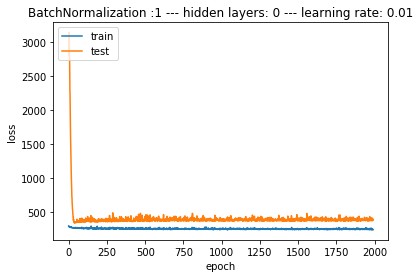

Train on 960 samples, validate on 241 samples
Epoch 1/2000
960/960 [==============================] - 3s 4ms/step - loss: 14228.7279 - val_loss: 20068699.6266
Epoch 2/2000
960/960 [==============================] - 0s 333us/step - loss: 2360.7041 - val_loss: 22747133.9585
Epoch 3/2000
960/960 [==============================] - 0s 349us/step - loss: 1005.0612 - val_loss: 9329060.9793
Epoch 4/2000
960/960 [==============================] - 0s 337us/step - loss: 677.7262 - val_loss: 9086518.9378
Epoch 5/2000
960/960 [==============================] - 0s 366us/step - loss: 432.6754 - val_loss: 7124625.1017
Epoch 6/2000
960/960 [==============================] - 0s 349us/step - loss: 462.1185 - val_loss: 5627284.3216
Epoch 7/2000
960/960 [==============================] - 0s 351us/step - loss: 345.3897 - val_loss: 4796262.7303
Epoch 8/2000
960/960 [==============================] - 0s 339us/step - loss: 325.5211 - val_loss: 3951285.2604
Epoch 9/2000
960/960 [==============================] 

960/960 [==============================] - 0s 356us/step - loss: 160.3755 - val_loss: 500.8296
Epoch 75/2000
960/960 [==============================] - 0s 318us/step - loss: 175.1236 - val_loss: 435.2465
Epoch 76/2000
960/960 [==============================] - 0s 348us/step - loss: 127.1597 - val_loss: 518.3961
Epoch 77/2000
960/960 [==============================] - 0s 344us/step - loss: 106.9134 - val_loss: 431.0786
Epoch 78/2000
960/960 [==============================] - 0s 333us/step - loss: 85.8163 - val_loss: 486.3175
Epoch 79/2000
960/960 [==============================] - 0s 335us/step - loss: 112.1551 - val_loss: 498.7191
Epoch 80/2000
960/960 [==============================] - 0s 346us/step - loss: 182.8875 - val_loss: 422.7984
Epoch 81/2000
960/960 [==============================] - 0s 358us/step - loss: 93.7585 - val_loss: 535.2527
Epoch 82/2000
960/960 [==============================] - 0s 351us/step - loss: 149.1411 - val_loss: 442.0096
Epoch 83/2000
960/960 [============

960/960 [==============================] - 0s 347us/step - loss: 71.0658 - val_loss: 508.3196
Epoch 150/2000
960/960 [==============================] - 0s 353us/step - loss: 59.5473 - val_loss: 463.1394
Epoch 151/2000
960/960 [==============================] - 0s 350us/step - loss: 68.8018 - val_loss: 460.3301
Epoch 152/2000
960/960 [==============================] - 0s 349us/step - loss: 55.4430 - val_loss: 465.1537
Epoch 153/2000
960/960 [==============================] - 0s 347us/step - loss: 61.3355 - val_loss: 447.8457
Epoch 154/2000
960/960 [==============================] - 0s 355us/step - loss: 63.0322 - val_loss: 448.8704
Epoch 155/2000
960/960 [==============================] - 0s 325us/step - loss: 69.1823 - val_loss: 438.0990
Epoch 156/2000
960/960 [==============================] - 0s 321us/step - loss: 76.2475 - val_loss: 507.8980
Epoch 157/2000
960/960 [==============================] - 0s 356us/step - loss: 71.3914 - val_loss: 473.4249
Epoch 158/2000
960/960 [==========

960/960 [==============================] - 0s 354us/step - loss: 47.0832 - val_loss: 466.8728
Epoch 225/2000
960/960 [==============================] - 0s 358us/step - loss: 68.5529 - val_loss: 519.9644
Epoch 226/2000
960/960 [==============================] - 0s 344us/step - loss: 61.2392 - val_loss: 449.2733
Epoch 227/2000
960/960 [==============================] - 0s 352us/step - loss: 55.7516 - val_loss: 444.8764
Epoch 228/2000
960/960 [==============================] - 0s 342us/step - loss: 54.4920 - val_loss: 406.4762
Epoch 229/2000
960/960 [==============================] - 0s 354us/step - loss: 60.6238 - val_loss: 438.7797
Epoch 230/2000
960/960 [==============================] - 0s 344us/step - loss: 52.7539 - val_loss: 435.5870
Epoch 231/2000
960/960 [==============================] - 0s 349us/step - loss: 50.0277 - val_loss: 476.8363
Epoch 232/2000
960/960 [==============================] - 0s 344us/step - loss: 58.2887 - val_loss: 443.1768
Epoch 233/2000
960/960 [==========

960/960 [==============================] - 0s 359us/step - loss: 69.2198 - val_loss: 438.4440
Epoch 300/2000
960/960 [==============================] - 0s 321us/step - loss: 56.1907 - val_loss: 429.3728
Epoch 301/2000
960/960 [==============================] - 0s 346us/step - loss: 49.6004 - val_loss: 444.6478
Epoch 302/2000
960/960 [==============================] - 0s 348us/step - loss: 42.9123 - val_loss: 431.2640
Epoch 303/2000
960/960 [==============================] - 0s 346us/step - loss: 61.2221 - val_loss: 411.6452
Epoch 304/2000
960/960 [==============================] - 0s 347us/step - loss: 51.6031 - val_loss: 438.9781
Epoch 305/2000
960/960 [==============================] - 0s 353us/step - loss: 48.5539 - val_loss: 452.3965
Epoch 306/2000
960/960 [==============================] - 0s 344us/step - loss: 56.1550 - val_loss: 408.7347
Epoch 307/2000
960/960 [==============================] - 0s 346us/step - loss: 51.1691 - val_loss: 431.6810
Epoch 308/2000
960/960 [==========

960/960 [==============================] - 0s 377us/step - loss: 44.7325 - val_loss: 392.1314
Epoch 375/2000
960/960 [==============================] - 0s 354us/step - loss: 51.1684 - val_loss: 466.9893
Epoch 376/2000
960/960 [==============================] - 0s 349us/step - loss: 47.9126 - val_loss: 396.6163
Epoch 377/2000
960/960 [==============================] - 0s 337us/step - loss: 40.4288 - val_loss: 440.1089
Epoch 378/2000
960/960 [==============================] - 0s 341us/step - loss: 41.3232 - val_loss: 420.1004
Epoch 379/2000
960/960 [==============================] - 0s 359us/step - loss: 35.6432 - val_loss: 385.4363
Epoch 380/2000
960/960 [==============================] - 0s 369us/step - loss: 29.8304 - val_loss: 414.2438
Epoch 381/2000
960/960 [==============================] - 0s 356us/step - loss: 30.4967 - val_loss: 397.2481
Epoch 382/2000
960/960 [==============================] - 0s 349us/step - loss: 31.3731 - val_loss: 415.6864
Epoch 383/2000
960/960 [==========

960/960 [==============================] - 0s 343us/step - loss: 45.9154 - val_loss: 447.9590
Epoch 450/2000
960/960 [==============================] - 0s 324us/step - loss: 39.3311 - val_loss: 435.9592
Epoch 451/2000
960/960 [==============================] - 0s 326us/step - loss: 32.3712 - val_loss: 434.8287
Epoch 452/2000
960/960 [==============================] - 0s 353us/step - loss: 30.8358 - val_loss: 401.3037
Epoch 453/2000
960/960 [==============================] - 0s 346us/step - loss: 33.1324 - val_loss: 398.9656
Epoch 454/2000
960/960 [==============================] - 0s 350us/step - loss: 33.0723 - val_loss: 399.2044
Epoch 455/2000
960/960 [==============================] - 0s 337us/step - loss: 40.2788 - val_loss: 424.3487
Epoch 456/2000
960/960 [==============================] - 0s 339us/step - loss: 35.5231 - val_loss: 402.4879
Epoch 457/2000
960/960 [==============================] - 0s 320us/step - loss: 27.8858 - val_loss: 399.8621
Epoch 458/2000
960/960 [==========

960/960 [==============================] - 0s 354us/step - loss: 22.9396 - val_loss: 400.5003
Epoch 525/2000
960/960 [==============================] - 0s 329us/step - loss: 27.3798 - val_loss: 392.1844
Epoch 526/2000
960/960 [==============================] - 0s 317us/step - loss: 27.9399 - val_loss: 393.4399
Epoch 527/2000
960/960 [==============================] - 0s 344us/step - loss: 28.0231 - val_loss: 384.4914
Epoch 528/2000
960/960 [==============================] - 0s 348us/step - loss: 31.9289 - val_loss: 408.0050
Epoch 529/2000
960/960 [==============================] - 0s 332us/step - loss: 47.9919 - val_loss: 491.6189
Epoch 530/2000
960/960 [==============================] - 0s 357us/step - loss: 66.4305 - val_loss: 384.5059
Epoch 531/2000
960/960 [==============================] - 0s 324us/step - loss: 55.3140 - val_loss: 380.2160
Epoch 532/2000
960/960 [==============================] - 0s 324us/step - loss: 34.4115 - val_loss: 375.0402
Epoch 533/2000
960/960 [==========

960/960 [==============================] - 0s 359us/step - loss: 40.0787 - val_loss: 395.1737
Epoch 600/2000
960/960 [==============================] - 0s 334us/step - loss: 28.3308 - val_loss: 408.2335
Epoch 601/2000
960/960 [==============================] - 0s 351us/step - loss: 26.5979 - val_loss: 391.6439
Epoch 602/2000
960/960 [==============================] - 0s 351us/step - loss: 26.9635 - val_loss: 397.2250
Epoch 603/2000
960/960 [==============================] - 0s 343us/step - loss: 25.1468 - val_loss: 388.5116
Epoch 604/2000
960/960 [==============================] - 0s 312us/step - loss: 24.6568 - val_loss: 385.2098
Epoch 605/2000
960/960 [==============================] - 0s 330us/step - loss: 26.9094 - val_loss: 401.8368
Epoch 606/2000
960/960 [==============================] - 0s 339us/step - loss: 35.0642 - val_loss: 431.5218
Epoch 607/2000
960/960 [==============================] - 0s 351us/step - loss: 29.6183 - val_loss: 396.3980
Epoch 608/2000
960/960 [==========

960/960 [==============================] - 0s 360us/step - loss: 40.3952 - val_loss: 420.8257
Epoch 675/2000
960/960 [==============================] - 0s 351us/step - loss: 26.0448 - val_loss: 389.7601
Epoch 676/2000
960/960 [==============================] - 0s 357us/step - loss: 27.7209 - val_loss: 402.0106
Epoch 677/2000
960/960 [==============================] - 0s 351us/step - loss: 28.8633 - val_loss: 422.9524
Epoch 678/2000
960/960 [==============================] - 0s 337us/step - loss: 30.0187 - val_loss: 371.3938
Epoch 679/2000
960/960 [==============================] - 0s 344us/step - loss: 24.4818 - val_loss: 391.8461
Epoch 680/2000
960/960 [==============================] - 0s 360us/step - loss: 23.6889 - val_loss: 396.8953
Epoch 681/2000
960/960 [==============================] - 0s 340us/step - loss: 24.3050 - val_loss: 371.5875
Epoch 682/2000
960/960 [==============================] - 0s 332us/step - loss: 27.6110 - val_loss: 386.2658
Epoch 683/2000
960/960 [==========

960/960 [==============================] - 0s 375us/step - loss: 27.8623 - val_loss: 417.7785
Epoch 750/2000
960/960 [==============================] - 0s 330us/step - loss: 41.5407 - val_loss: 397.2404
Epoch 751/2000
960/960 [==============================] - 0s 337us/step - loss: 29.0915 - val_loss: 387.7106
Epoch 752/2000
960/960 [==============================] - 0s 316us/step - loss: 25.5350 - val_loss: 409.2201
Epoch 753/2000
960/960 [==============================] - 0s 329us/step - loss: 29.1128 - val_loss: 426.1812
Epoch 754/2000
960/960 [==============================] - 0s 324us/step - loss: 24.8029 - val_loss: 420.1369
Epoch 755/2000
960/960 [==============================] - 0s 320us/step - loss: 24.0222 - val_loss: 395.0931
Epoch 756/2000
960/960 [==============================] - 0s 312us/step - loss: 25.3358 - val_loss: 392.5832
Epoch 757/2000
960/960 [==============================] - 0s 349us/step - loss: 25.9659 - val_loss: 391.8157
Epoch 758/2000
960/960 [==========

960/960 [==============================] - 0s 327us/step - loss: 25.1543 - val_loss: 400.8590
Epoch 825/2000
960/960 [==============================] - 0s 328us/step - loss: 32.6730 - val_loss: 440.3837
Epoch 826/2000
960/960 [==============================] - 0s 329us/step - loss: 29.2504 - val_loss: 418.5549
Epoch 827/2000
960/960 [==============================] - 0s 344us/step - loss: 23.1936 - val_loss: 431.9391
Epoch 828/2000
960/960 [==============================] - 0s 351us/step - loss: 24.7416 - val_loss: 440.5698
Epoch 829/2000
960/960 [==============================] - 0s 343us/step - loss: 24.7043 - val_loss: 385.7770
Epoch 830/2000
960/960 [==============================] - 0s 352us/step - loss: 21.3387 - val_loss: 408.8593
Epoch 831/2000
960/960 [==============================] - 0s 344us/step - loss: 18.8549 - val_loss: 391.9266
Epoch 832/2000
960/960 [==============================] - 0s 359us/step - loss: 24.6711 - val_loss: 401.2203
Epoch 833/2000
960/960 [==========

960/960 [==============================] - 0s 350us/step - loss: 29.7826 - val_loss: 383.6095
Epoch 900/2000
960/960 [==============================] - 0s 354us/step - loss: 24.6134 - val_loss: 389.0987
Epoch 901/2000
960/960 [==============================] - 0s 349us/step - loss: 24.7068 - val_loss: 403.3285
Epoch 902/2000
960/960 [==============================] - 0s 350us/step - loss: 21.6904 - val_loss: 400.2722
Epoch 903/2000
960/960 [==============================] - 0s 353us/step - loss: 26.5167 - val_loss: 410.9083
Epoch 904/2000
960/960 [==============================] - 0s 336us/step - loss: 24.2869 - val_loss: 401.4947
Epoch 905/2000
960/960 [==============================] - 0s 355us/step - loss: 21.1583 - val_loss: 384.8923
Epoch 906/2000
960/960 [==============================] - 0s 311us/step - loss: 21.9162 - val_loss: 385.5963
Epoch 907/2000
960/960 [==============================] - 0s 320us/step - loss: 18.1143 - val_loss: 382.6357
Epoch 908/2000
960/960 [==========

960/960 [==============================] - 0s 335us/step - loss: 18.7421 - val_loss: 394.7117
Epoch 975/2000
960/960 [==============================] - 0s 347us/step - loss: 21.8219 - val_loss: 391.1583
Epoch 976/2000
960/960 [==============================] - 0s 355us/step - loss: 20.1824 - val_loss: 402.9018
Epoch 977/2000
960/960 [==============================] - 0s 343us/step - loss: 19.7485 - val_loss: 409.0989
Epoch 978/2000
960/960 [==============================] - 0s 356us/step - loss: 21.4390 - val_loss: 390.3153
Epoch 979/2000
960/960 [==============================] - 0s 337us/step - loss: 19.8239 - val_loss: 442.3565
Epoch 980/2000
960/960 [==============================] - 0s 340us/step - loss: 20.9401 - val_loss: 438.5475
Epoch 981/2000
960/960 [==============================] - 0s 342us/step - loss: 22.7584 - val_loss: 439.8521
Epoch 982/2000
960/960 [==============================] - 0s 352us/step - loss: 23.0449 - val_loss: 443.1477
Epoch 983/2000
960/960 [==========

Epoch 1049/2000
960/960 [==============================] - 0s 347us/step - loss: 21.4149 - val_loss: 382.4937
Epoch 1050/2000
960/960 [==============================] - 0s 343us/step - loss: 22.1440 - val_loss: 372.1574
Epoch 1051/2000
960/960 [==============================] - 0s 344us/step - loss: 23.9719 - val_loss: 416.5819
Epoch 1052/2000
960/960 [==============================] - 0s 337us/step - loss: 19.6973 - val_loss: 385.0263
Epoch 1053/2000
960/960 [==============================] - 0s 344us/step - loss: 19.2456 - val_loss: 407.5988
Epoch 1054/2000
960/960 [==============================] - 0s 324us/step - loss: 18.3057 - val_loss: 365.6486
Epoch 1055/2000
960/960 [==============================] - 0s 337us/step - loss: 22.1709 - val_loss: 385.2413
Epoch 1056/2000
960/960 [==============================] - 0s 339us/step - loss: 21.3981 - val_loss: 402.9186
Epoch 1057/2000
960/960 [==============================] - 0s 337us/step - loss: 20.3775 - val_loss: 395.9110
Epoch 1058

960/960 [==============================] - 0s 365us/step - loss: 21.1909 - val_loss: 405.5328
Epoch 1124/2000
960/960 [==============================] - 0s 347us/step - loss: 20.0029 - val_loss: 408.0549
Epoch 1125/2000
960/960 [==============================] - 0s 328us/step - loss: 17.7178 - val_loss: 415.8759
Epoch 1126/2000
960/960 [==============================] - 0s 337us/step - loss: 18.4928 - val_loss: 382.9281
Epoch 1127/2000
960/960 [==============================] - 0s 340us/step - loss: 18.2812 - val_loss: 371.6652
Epoch 1128/2000
960/960 [==============================] - 0s 342us/step - loss: 18.2088 - val_loss: 410.5716
Epoch 1129/2000
960/960 [==============================] - 0s 341us/step - loss: 21.2129 - val_loss: 392.9496
Epoch 1130/2000
960/960 [==============================] - 0s 337us/step - loss: 21.0368 - val_loss: 390.1529
Epoch 1131/2000
960/960 [==============================] - 0s 352us/step - loss: 21.7700 - val_loss: 393.3857
Epoch 1132/2000
960/960 [=

960/960 [==============================] - 0s 359us/step - loss: 16.6804 - val_loss: 388.1386
Epoch 1198/2000
960/960 [==============================] - 0s 366us/step - loss: 15.5797 - val_loss: 394.9857
Epoch 1199/2000
960/960 [==============================] - 0s 342us/step - loss: 16.2434 - val_loss: 388.8857
Epoch 1200/2000
960/960 [==============================] - 0s 355us/step - loss: 18.7413 - val_loss: 416.0914
Epoch 1201/2000
960/960 [==============================] - 0s 335us/step - loss: 18.5343 - val_loss: 410.9322
Epoch 1202/2000
960/960 [==============================] - 0s 356us/step - loss: 26.6686 - val_loss: 418.2093
Epoch 1203/2000
960/960 [==============================] - 0s 340us/step - loss: 21.8767 - val_loss: 410.9575
Epoch 1204/2000
960/960 [==============================] - 0s 355us/step - loss: 19.6846 - val_loss: 366.6102
Epoch 1205/2000
960/960 [==============================] - 0s 340us/step - loss: 22.6529 - val_loss: 375.2705
Epoch 1206/2000
960/960 [=

960/960 [==============================] - 0s 352us/step - loss: 19.0855 - val_loss: 384.8080
Epoch 1272/2000
960/960 [==============================] - 0s 344us/step - loss: 17.0785 - val_loss: 398.0601
Epoch 1273/2000
960/960 [==============================] - 0s 336us/step - loss: 18.0479 - val_loss: 402.4701
Epoch 1274/2000
960/960 [==============================] - 0s 342us/step - loss: 18.6851 - val_loss: 389.2284
Epoch 1275/2000
960/960 [==============================] - 0s 335us/step - loss: 19.5708 - val_loss: 381.5047
Epoch 1276/2000
960/960 [==============================] - 0s 350us/step - loss: 18.3722 - val_loss: 397.4343
Epoch 1277/2000
960/960 [==============================] - 0s 337us/step - loss: 19.0454 - val_loss: 415.0645
Epoch 1278/2000
960/960 [==============================] - 0s 352us/step - loss: 17.0884 - val_loss: 369.2512
Epoch 1279/2000
960/960 [==============================] - 0s 343us/step - loss: 17.0731 - val_loss: 377.0825
Epoch 1280/2000
960/960 [=

960/960 [==============================] - 0s 340us/step - loss: 22.8533 - val_loss: 400.5687
Epoch 1346/2000
960/960 [==============================] - 0s 356us/step - loss: 22.6208 - val_loss: 400.1588
Epoch 1347/2000
960/960 [==============================] - 0s 350us/step - loss: 21.3146 - val_loss: 378.7345
Epoch 1348/2000
960/960 [==============================] - 0s 346us/step - loss: 19.7230 - val_loss: 398.3791
Epoch 1349/2000
960/960 [==============================] - 0s 339us/step - loss: 20.1541 - val_loss: 419.7000
Epoch 1350/2000
960/960 [==============================] - 0s 330us/step - loss: 18.8167 - val_loss: 393.8235
Epoch 1351/2000
960/960 [==============================] - 0s 343us/step - loss: 19.0357 - val_loss: 393.0280
Epoch 1352/2000
960/960 [==============================] - 0s 356us/step - loss: 18.0588 - val_loss: 401.3261
Epoch 1353/2000
960/960 [==============================] - 0s 371us/step - loss: 19.1593 - val_loss: 423.4196
Epoch 1354/2000
960/960 [=

960/960 [==============================] - 0s 333us/step - loss: 20.7306 - val_loss: 403.9776
Epoch 1420/2000
960/960 [==============================] - 0s 338us/step - loss: 17.9182 - val_loss: 406.3309
Epoch 1421/2000
960/960 [==============================] - 0s 343us/step - loss: 22.3653 - val_loss: 420.2139
Epoch 1422/2000
960/960 [==============================] - 0s 342us/step - loss: 17.6429 - val_loss: 405.3017
Epoch 1423/2000
960/960 [==============================] - 0s 322us/step - loss: 18.5921 - val_loss: 397.1867
Epoch 1424/2000
960/960 [==============================] - 0s 324us/step - loss: 17.6521 - val_loss: 386.8074
Epoch 1425/2000
960/960 [==============================] - 0s 318us/step - loss: 16.6735 - val_loss: 409.6776
Epoch 1426/2000
960/960 [==============================] - 0s 358us/step - loss: 18.1094 - val_loss: 423.5805
Epoch 1427/2000
960/960 [==============================] - 0s 354us/step - loss: 17.8323 - val_loss: 378.9560
Epoch 1428/2000
960/960 [=

960/960 [==============================] - 0s 350us/step - loss: 21.6209 - val_loss: 376.0122
Epoch 1494/2000
960/960 [==============================] - 0s 349us/step - loss: 21.1550 - val_loss: 380.3527
Epoch 1495/2000
960/960 [==============================] - 0s 345us/step - loss: 22.6318 - val_loss: 384.3554
Epoch 1496/2000
960/960 [==============================] - 0s 349us/step - loss: 24.1764 - val_loss: 401.1263
Epoch 1497/2000
960/960 [==============================] - 0s 361us/step - loss: 23.4317 - val_loss: 404.5332
Epoch 1498/2000
960/960 [==============================] - 0s 334us/step - loss: 18.6060 - val_loss: 398.1175
Epoch 1499/2000
960/960 [==============================] - 0s 350us/step - loss: 19.7261 - val_loss: 385.0058
Epoch 1500/2000
960/960 [==============================] - 0s 321us/step - loss: 18.4493 - val_loss: 396.7696
Epoch 1501/2000
960/960 [==============================] - 0s 336us/step - loss: 16.2568 - val_loss: 401.0813
Epoch 1502/2000
960/960 [=

960/960 [==============================] - 0s 314us/step - loss: 26.1966 - val_loss: 376.1114
Epoch 1568/2000
960/960 [==============================] - 0s 354us/step - loss: 29.0455 - val_loss: 385.4328
Epoch 1569/2000
960/960 [==============================] - 0s 329us/step - loss: 21.7503 - val_loss: 461.5332
Epoch 1570/2000
960/960 [==============================] - 0s 323us/step - loss: 21.8402 - val_loss: 419.4791
Epoch 1571/2000
960/960 [==============================] - 0s 326us/step - loss: 17.8540 - val_loss: 402.2972
Epoch 1572/2000
960/960 [==============================] - 0s 345us/step - loss: 17.4612 - val_loss: 394.8071
Epoch 1573/2000
960/960 [==============================] - 0s 309us/step - loss: 20.2460 - val_loss: 415.7490
Epoch 1574/2000
960/960 [==============================] - 0s 349us/step - loss: 20.4681 - val_loss: 371.2745
Epoch 1575/2000
960/960 [==============================] - 0s 341us/step - loss: 21.0473 - val_loss: 402.2329
Epoch 1576/2000
960/960 [=

960/960 [==============================] - 0s 365us/step - loss: 21.8024 - val_loss: 388.5534
Epoch 1642/2000
960/960 [==============================] - 0s 340us/step - loss: 20.6432 - val_loss: 412.4030
Epoch 1643/2000
960/960 [==============================] - 0s 347us/step - loss: 20.2492 - val_loss: 387.8178
Epoch 1644/2000
960/960 [==============================] - 0s 342us/step - loss: 20.9804 - val_loss: 374.6027
Epoch 1645/2000
960/960 [==============================] - 0s 340us/step - loss: 20.9584 - val_loss: 387.1301
Epoch 1646/2000
960/960 [==============================] - 0s 347us/step - loss: 20.5764 - val_loss: 368.5260
Epoch 1647/2000
960/960 [==============================] - 0s 341us/step - loss: 18.0638 - val_loss: 384.0870
Epoch 1648/2000
960/960 [==============================] - 0s 351us/step - loss: 17.2298 - val_loss: 408.4339
Epoch 1649/2000
960/960 [==============================] - 0s 352us/step - loss: 18.5469 - val_loss: 385.4473
Epoch 1650/2000
960/960 [=

960/960 [==============================] - 0s 359us/step - loss: 17.5636 - val_loss: 384.0918
Epoch 1716/2000
960/960 [==============================] - 0s 342us/step - loss: 20.1401 - val_loss: 373.5858
Epoch 1717/2000
960/960 [==============================] - 0s 340us/step - loss: 18.1490 - val_loss: 407.0690
Epoch 1718/2000
960/960 [==============================] - 0s 328us/step - loss: 19.2146 - val_loss: 408.8727
Epoch 1719/2000
960/960 [==============================] - 0s 343us/step - loss: 17.8628 - val_loss: 400.3853
Epoch 1720/2000
960/960 [==============================] - 0s 348us/step - loss: 19.5082 - val_loss: 426.4809
Epoch 1721/2000
960/960 [==============================] - 0s 359us/step - loss: 18.4896 - val_loss: 393.5688
Epoch 1722/2000
960/960 [==============================] - 0s 327us/step - loss: 17.1430 - val_loss: 380.4117
Epoch 1723/2000
960/960 [==============================] - 0s 324us/step - loss: 16.0199 - val_loss: 422.3884
Epoch 1724/2000
960/960 [=

960/960 [==============================] - 0s 343us/step - loss: 25.9439 - val_loss: 389.5041
Epoch 1790/2000
960/960 [==============================] - 0s 316us/step - loss: 31.8641 - val_loss: 412.6804
Epoch 1791/2000
960/960 [==============================] - 0s 316us/step - loss: 26.1108 - val_loss: 411.9072
Epoch 1792/2000
960/960 [==============================] - 0s 337us/step - loss: 19.9013 - val_loss: 385.8767
Epoch 1793/2000
960/960 [==============================] - 0s 344us/step - loss: 17.9270 - val_loss: 380.4139
Epoch 1794/2000
960/960 [==============================] - 0s 321us/step - loss: 17.3419 - val_loss: 390.3706
Epoch 1795/2000
960/960 [==============================] - 0s 309us/step - loss: 17.6005 - val_loss: 396.4952
Epoch 1796/2000
960/960 [==============================] - 0s 306us/step - loss: 19.2827 - val_loss: 402.5425
Epoch 1797/2000
960/960 [==============================] - 0s 321us/step - loss: 19.3920 - val_loss: 405.9838
Epoch 1798/2000
960/960 [=

960/960 [==============================] - 0s 361us/step - loss: 20.3258 - val_loss: 389.8357
Epoch 1864/2000
960/960 [==============================] - 0s 317us/step - loss: 17.4008 - val_loss: 381.1781
Epoch 1865/2000
960/960 [==============================] - 0s 343us/step - loss: 16.9727 - val_loss: 394.3713
Epoch 1866/2000
960/960 [==============================] - 0s 340us/step - loss: 17.1077 - val_loss: 381.4018
Epoch 1867/2000
960/960 [==============================] - 0s 351us/step - loss: 16.4182 - val_loss: 382.9695
Epoch 1868/2000
960/960 [==============================] - 0s 339us/step - loss: 17.7590 - val_loss: 400.5874
Epoch 1869/2000
960/960 [==============================] - 0s 345us/step - loss: 17.0796 - val_loss: 373.6709
Epoch 1870/2000
960/960 [==============================] - 0s 356us/step - loss: 17.3267 - val_loss: 385.3445
Epoch 1871/2000
960/960 [==============================] - 0s 355us/step - loss: 17.1292 - val_loss: 381.8415
Epoch 1872/2000
960/960 [=

960/960 [==============================] - 0s 352us/step - loss: 19.3412 - val_loss: 386.4498
Epoch 1938/2000
960/960 [==============================] - 0s 326us/step - loss: 16.3909 - val_loss: 377.1231
Epoch 1939/2000
960/960 [==============================] - 0s 357us/step - loss: 16.5492 - val_loss: 393.1410
Epoch 1940/2000
960/960 [==============================] - 0s 314us/step - loss: 19.1439 - val_loss: 387.8684
Epoch 1941/2000
960/960 [==============================] - 0s 334us/step - loss: 19.4080 - val_loss: 379.7911
Epoch 1942/2000
960/960 [==============================] - 0s 348us/step - loss: 17.8436 - val_loss: 397.2260
Epoch 1943/2000
960/960 [==============================] - 0s 350us/step - loss: 17.1695 - val_loss: 391.2406
Epoch 1944/2000
960/960 [==============================] - 0s 354us/step - loss: 14.9185 - val_loss: 386.3865
Epoch 1945/2000
960/960 [==============================] - 0s 338us/step - loss: 15.4990 - val_loss: 388.1695
Epoch 1946/2000
960/960 [=

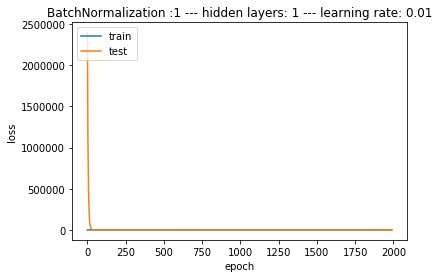

Train on 960 samples, validate on 241 samples
Epoch 1/2000
960/960 [==============================] - 4s 4ms/step - loss: 11984.3803 - val_loss: 20930628.0996
Epoch 2/2000
960/960 [==============================] - 1s 552us/step - loss: 4112.4838 - val_loss: 16564088.6349
Epoch 3/2000
960/960 [==============================] - 1s 562us/step - loss: 2066.9092 - val_loss: 8172787.3734
Epoch 4/2000
960/960 [==============================] - 1s 550us/step - loss: 1024.6808 - val_loss: 6470287.6805
Epoch 5/2000
960/960 [==============================] - 1s 565us/step - loss: 586.7412 - val_loss: 2761326.1546
Epoch 6/2000
960/960 [==============================] - 1s 567us/step - loss: 478.5229 - val_loss: 1370168.6732
Epoch 7/2000
960/960 [==============================] - 1s 583us/step - loss: 421.4677 - val_loss: 853689.7274
Epoch 8/2000
960/960 [==============================] - 1s 562us/step - loss: 389.9923 - val_loss: 661846.2775
Epoch 9/2000
960/960 [==============================] -

960/960 [==============================] - 1s 573us/step - loss: 129.4581 - val_loss: 531.1516
Epoch 76/2000
960/960 [==============================] - 1s 563us/step - loss: 181.5094 - val_loss: 551.5166
Epoch 77/2000
960/960 [==============================] - 1s 540us/step - loss: 103.6292 - val_loss: 587.5208
Epoch 78/2000
960/960 [==============================] - 1s 561us/step - loss: 123.4887 - val_loss: 537.1089
Epoch 79/2000
960/960 [==============================] - 1s 556us/step - loss: 106.9805 - val_loss: 465.3903
Epoch 80/2000
960/960 [==============================] - 1s 574us/step - loss: 111.3041 - val_loss: 562.6741
Epoch 81/2000
960/960 [==============================] - 1s 577us/step - loss: 123.9253 - val_loss: 498.1165
Epoch 82/2000
960/960 [==============================] - 1s 542us/step - loss: 169.4033 - val_loss: 526.4992
Epoch 83/2000
960/960 [==============================] - 1s 533us/step - loss: 106.1288 - val_loss: 424.5892
Epoch 84/2000
960/960 [==========

960/960 [==============================] - 1s 566us/step - loss: 99.7783 - val_loss: 525.5010
Epoch 151/2000
960/960 [==============================] - 1s 561us/step - loss: 127.6547 - val_loss: 551.9981
Epoch 152/2000
960/960 [==============================] - 1s 544us/step - loss: 100.5362 - val_loss: 500.1031
Epoch 153/2000
960/960 [==============================] - 1s 553us/step - loss: 84.7830 - val_loss: 499.8850
Epoch 154/2000
960/960 [==============================] - 1s 569us/step - loss: 91.3985 - val_loss: 527.6509
Epoch 155/2000
960/960 [==============================] - 1s 563us/step - loss: 105.6059 - val_loss: 543.7318
Epoch 156/2000
960/960 [==============================] - 1s 560us/step - loss: 77.5313 - val_loss: 463.8324
Epoch 157/2000
960/960 [==============================] - 1s 569us/step - loss: 99.0360 - val_loss: 485.8248
Epoch 158/2000
960/960 [==============================] - 1s 574us/step - loss: 96.3943 - val_loss: 465.6909
Epoch 159/2000
960/960 [=======

960/960 [==============================] - 1s 582us/step - loss: 94.8379 - val_loss: 525.6101
Epoch 226/2000
960/960 [==============================] - 1s 555us/step - loss: 109.4528 - val_loss: 479.3092
Epoch 227/2000
960/960 [==============================] - 1s 558us/step - loss: 75.9742 - val_loss: 477.7250
Epoch 228/2000
960/960 [==============================] - 1s 570us/step - loss: 58.7782 - val_loss: 457.5769
Epoch 229/2000
960/960 [==============================] - 1s 547us/step - loss: 58.8264 - val_loss: 501.1961
Epoch 230/2000
960/960 [==============================] - 1s 563us/step - loss: 73.7040 - val_loss: 458.6349
Epoch 231/2000
960/960 [==============================] - 1s 570us/step - loss: 86.2301 - val_loss: 485.2987
Epoch 232/2000
960/960 [==============================] - 1s 533us/step - loss: 73.7156 - val_loss: 483.0888
Epoch 233/2000
960/960 [==============================] - 1s 555us/step - loss: 62.7982 - val_loss: 434.3261
Epoch 234/2000
960/960 [=========

960/960 [==============================] - 1s 585us/step - loss: 79.4075 - val_loss: 426.4108
Epoch 301/2000
960/960 [==============================] - 1s 574us/step - loss: 53.3743 - val_loss: 442.3420
Epoch 302/2000
960/960 [==============================] - 1s 563us/step - loss: 60.3412 - val_loss: 431.6532
Epoch 303/2000
960/960 [==============================] - 1s 576us/step - loss: 54.1037 - val_loss: 469.1744
Epoch 304/2000
960/960 [==============================] - 1s 566us/step - loss: 57.9916 - val_loss: 476.5017
Epoch 305/2000
960/960 [==============================] - 1s 560us/step - loss: 59.2205 - val_loss: 434.0875
Epoch 306/2000
960/960 [==============================] - 1s 573us/step - loss: 58.1620 - val_loss: 447.8374
Epoch 307/2000
960/960 [==============================] - 1s 557us/step - loss: 67.3924 - val_loss: 485.3358
Epoch 308/2000
960/960 [==============================] - 1s 566us/step - loss: 49.5627 - val_loss: 454.9338
Epoch 309/2000
960/960 [==========

960/960 [==============================] - 1s 586us/step - loss: 67.1482 - val_loss: 456.8321
Epoch 376/2000
960/960 [==============================] - 1s 556us/step - loss: 54.8058 - val_loss: 436.3786
Epoch 377/2000
960/960 [==============================] - 1s 567us/step - loss: 134.1942 - val_loss: 517.7489
Epoch 378/2000
960/960 [==============================] - 1s 568us/step - loss: 64.2566 - val_loss: 429.3868
Epoch 379/2000
960/960 [==============================] - 1s 563us/step - loss: 54.0172 - val_loss: 464.9430
Epoch 380/2000
960/960 [==============================] - 1s 558us/step - loss: 193.2040 - val_loss: 523.9731
Epoch 381/2000
960/960 [==============================] - 1s 555us/step - loss: 141.4203 - val_loss: 486.1045
Epoch 382/2000
960/960 [==============================] - 1s 578us/step - loss: 58.2931 - val_loss: 542.0092
Epoch 383/2000
960/960 [==============================] - 1s 575us/step - loss: 197.7667 - val_loss: 464.8107
Epoch 384/2000
960/960 [======

960/960 [==============================] - 1s 574us/step - loss: 42.2148 - val_loss: 427.5815
Epoch 451/2000
960/960 [==============================] - 1s 544us/step - loss: 47.2919 - val_loss: 428.2463
Epoch 452/2000
960/960 [==============================] - 1s 529us/step - loss: 35.4788 - val_loss: 433.9479
Epoch 453/2000
960/960 [==============================] - 1s 563us/step - loss: 37.2822 - val_loss: 432.9013
Epoch 454/2000
960/960 [==============================] - 1s 570us/step - loss: 42.3539 - val_loss: 427.9146
Epoch 455/2000
960/960 [==============================] - 1s 566us/step - loss: 39.8706 - val_loss: 419.6607
Epoch 456/2000
960/960 [==============================] - 1s 551us/step - loss: 40.2105 - val_loss: 433.8941
Epoch 457/2000
960/960 [==============================] - 1s 549us/step - loss: 45.2423 - val_loss: 453.6837
Epoch 458/2000
960/960 [==============================] - 1s 553us/step - loss: 60.3333 - val_loss: 438.6285
Epoch 459/2000
960/960 [==========

960/960 [==============================] - 1s 586us/step - loss: 42.0467 - val_loss: 435.9250
Epoch 526/2000
960/960 [==============================] - 1s 549us/step - loss: 39.9734 - val_loss: 428.4515
Epoch 527/2000
960/960 [==============================] - 1s 544us/step - loss: 42.2600 - val_loss: 446.5706
Epoch 528/2000
960/960 [==============================] - 1s 550us/step - loss: 46.1914 - val_loss: 449.0397
Epoch 529/2000
960/960 [==============================] - 1s 577us/step - loss: 41.7067 - val_loss: 422.5889
Epoch 530/2000
960/960 [==============================] - 1s 569us/step - loss: 39.2524 - val_loss: 427.6619
Epoch 531/2000
960/960 [==============================] - 1s 546us/step - loss: 38.8407 - val_loss: 424.6665
Epoch 532/2000
960/960 [==============================] - 1s 571us/step - loss: 39.1997 - val_loss: 440.3282
Epoch 533/2000
960/960 [==============================] - 1s 579us/step - loss: 45.3390 - val_loss: 418.0126
Epoch 534/2000
960/960 [==========

960/960 [==============================] - 1s 568us/step - loss: 35.4838 - val_loss: 412.0431
Epoch 601/2000
960/960 [==============================] - 1s 531us/step - loss: 37.0228 - val_loss: 406.6285
Epoch 602/2000
960/960 [==============================] - 1s 543us/step - loss: 39.9077 - val_loss: 418.2864
Epoch 603/2000
960/960 [==============================] - 1s 563us/step - loss: 36.8340 - val_loss: 406.7651
Epoch 604/2000
960/960 [==============================] - 1s 542us/step - loss: 28.6036 - val_loss: 411.4131
Epoch 605/2000
960/960 [==============================] - 1s 555us/step - loss: 38.0018 - val_loss: 432.9402
Epoch 606/2000
960/960 [==============================] - 1s 567us/step - loss: 39.2597 - val_loss: 417.6445
Epoch 607/2000
960/960 [==============================] - 1s 558us/step - loss: 35.2484 - val_loss: 436.2679
Epoch 608/2000
960/960 [==============================] - 1s 568us/step - loss: 30.7388 - val_loss: 392.1502
Epoch 609/2000
960/960 [==========

960/960 [==============================] - 1s 588us/step - loss: 29.5578 - val_loss: 402.9653
Epoch 676/2000
960/960 [==============================] - 1s 588us/step - loss: 31.9834 - val_loss: 425.5807
Epoch 677/2000
960/960 [==============================] - 1s 558us/step - loss: 26.6180 - val_loss: 397.1301
Epoch 678/2000
960/960 [==============================] - 1s 569us/step - loss: 30.4455 - val_loss: 426.7102
Epoch 679/2000
960/960 [==============================] - 1s 573us/step - loss: 33.2100 - val_loss: 419.7842
Epoch 680/2000
960/960 [==============================] - 1s 574us/step - loss: 31.8652 - val_loss: 412.7265
Epoch 681/2000
960/960 [==============================] - 1s 566us/step - loss: 35.6824 - val_loss: 414.0240
Epoch 682/2000
960/960 [==============================] - 1s 533us/step - loss: 39.9002 - val_loss: 390.1577
Epoch 683/2000
960/960 [==============================] - 1s 544us/step - loss: 31.2481 - val_loss: 403.8918
Epoch 684/2000
960/960 [==========

960/960 [==============================] - 1s 592us/step - loss: 38.2236 - val_loss: 413.3096
Epoch 751/2000
960/960 [==============================] - 1s 576us/step - loss: 33.9372 - val_loss: 391.5656
Epoch 752/2000
960/960 [==============================] - 1s 584us/step - loss: 39.9638 - val_loss: 419.3511
Epoch 753/2000
960/960 [==============================] - 1s 585us/step - loss: 37.8411 - val_loss: 389.8886
Epoch 754/2000
960/960 [==============================] - 1s 557us/step - loss: 28.1944 - val_loss: 410.5965
Epoch 755/2000
960/960 [==============================] - 1s 560us/step - loss: 34.1993 - val_loss: 398.2441
Epoch 756/2000
960/960 [==============================] - 1s 569us/step - loss: 34.7767 - val_loss: 395.4584
Epoch 757/2000
960/960 [==============================] - 1s 568us/step - loss: 37.7420 - val_loss: 389.9307
Epoch 758/2000
960/960 [==============================] - 1s 556us/step - loss: 32.3135 - val_loss: 401.2552
Epoch 759/2000
960/960 [==========

960/960 [==============================] - 1s 567us/step - loss: 26.0343 - val_loss: 419.1673
Epoch 826/2000
960/960 [==============================] - 1s 526us/step - loss: 25.2140 - val_loss: 403.5507
Epoch 827/2000
960/960 [==============================] - 1s 531us/step - loss: 28.3620 - val_loss: 398.2711
Epoch 828/2000
960/960 [==============================] - 1s 541us/step - loss: 27.6353 - val_loss: 402.7256
Epoch 829/2000
960/960 [==============================] - 1s 537us/step - loss: 34.5707 - val_loss: 444.1323
Epoch 830/2000
960/960 [==============================] - 1s 545us/step - loss: 34.7233 - val_loss: 401.1543
Epoch 831/2000
960/960 [==============================] - 1s 569us/step - loss: 39.2810 - val_loss: 455.9481
Epoch 832/2000
960/960 [==============================] - 1s 579us/step - loss: 37.6666 - val_loss: 395.7264
Epoch 833/2000
960/960 [==============================] - 1s 575us/step - loss: 28.4732 - val_loss: 403.7335
Epoch 834/2000
960/960 [==========

960/960 [==============================] - 1s 576us/step - loss: 29.1720 - val_loss: 403.3846
Epoch 901/2000
960/960 [==============================] - 1s 577us/step - loss: 29.1017 - val_loss: 385.3733
Epoch 902/2000
960/960 [==============================] - 1s 535us/step - loss: 31.1609 - val_loss: 402.4847
Epoch 903/2000
960/960 [==============================] - 1s 526us/step - loss: 27.7690 - val_loss: 394.3140
Epoch 904/2000
960/960 [==============================] - 1s 550us/step - loss: 25.7698 - val_loss: 386.4089
Epoch 905/2000
960/960 [==============================] - 1s 537us/step - loss: 23.4923 - val_loss: 393.3828
Epoch 906/2000
960/960 [==============================] - 1s 565us/step - loss: 21.9154 - val_loss: 388.6253
Epoch 907/2000
960/960 [==============================] - 1s 549us/step - loss: 21.8615 - val_loss: 397.3439
Epoch 908/2000
960/960 [==============================] - 1s 546us/step - loss: 22.1746 - val_loss: 397.8385
Epoch 909/2000
960/960 [==========

960/960 [==============================] - 1s 584us/step - loss: 24.3525 - val_loss: 388.3022
Epoch 976/2000
960/960 [==============================] - 1s 564us/step - loss: 24.4131 - val_loss: 404.7868
Epoch 977/2000
960/960 [==============================] - 1s 569us/step - loss: 25.7212 - val_loss: 407.7072
Epoch 978/2000
960/960 [==============================] - 1s 561us/step - loss: 23.4620 - val_loss: 402.9523
Epoch 979/2000
960/960 [==============================] - 1s 571us/step - loss: 27.3515 - val_loss: 385.2058
Epoch 980/2000
960/960 [==============================] - 1s 572us/step - loss: 24.2822 - val_loss: 395.5625
Epoch 981/2000
960/960 [==============================] - 1s 570us/step - loss: 27.2535 - val_loss: 416.2756
Epoch 982/2000
960/960 [==============================] - 1s 554us/step - loss: 26.4200 - val_loss: 384.9991
Epoch 983/2000
960/960 [==============================] - 1s 551us/step - loss: 24.8401 - val_loss: 415.6509
Epoch 984/2000
960/960 [==========

Epoch 1050/2000
960/960 [==============================] - 1s 571us/step - loss: 25.2115 - val_loss: 387.0366
Epoch 1051/2000
960/960 [==============================] - 1s 570us/step - loss: 23.4866 - val_loss: 399.3128
Epoch 1052/2000
960/960 [==============================] - 1s 580us/step - loss: 25.2124 - val_loss: 404.9778
Epoch 1053/2000
960/960 [==============================] - 1s 539us/step - loss: 36.2567 - val_loss: 388.8779
Epoch 1054/2000
960/960 [==============================] - 1s 555us/step - loss: 30.9898 - val_loss: 402.7721
Epoch 1055/2000
960/960 [==============================] - 1s 566us/step - loss: 27.0184 - val_loss: 390.7253
Epoch 1056/2000
960/960 [==============================] - 1s 550us/step - loss: 26.0067 - val_loss: 381.9571
Epoch 1057/2000
960/960 [==============================] - 1s 536us/step - loss: 24.9273 - val_loss: 399.5479
Epoch 1058/2000
960/960 [==============================] - 1s 554us/step - loss: 23.9367 - val_loss: 394.7084
Epoch 1059

960/960 [==============================] - 1s 584us/step - loss: 22.3034 - val_loss: 388.6243
Epoch 1125/2000
960/960 [==============================] - 1s 546us/step - loss: 25.1660 - val_loss: 409.1254
Epoch 1126/2000
960/960 [==============================] - 1s 525us/step - loss: 22.8342 - val_loss: 401.3607
Epoch 1127/2000
960/960 [==============================] - 1s 548us/step - loss: 21.9649 - val_loss: 390.1691
Epoch 1128/2000
960/960 [==============================] - 1s 577us/step - loss: 20.3607 - val_loss: 395.6493
Epoch 1129/2000
960/960 [==============================] - 1s 567us/step - loss: 20.3330 - val_loss: 398.8882
Epoch 1130/2000
960/960 [==============================] - 1s 569us/step - loss: 19.4755 - val_loss: 408.0096
Epoch 1131/2000
960/960 [==============================] - 1s 567us/step - loss: 23.8570 - val_loss: 390.7756
Epoch 1132/2000
960/960 [==============================] - 1s 549us/step - loss: 20.8372 - val_loss: 420.6983
Epoch 1133/2000
960/960 [=

960/960 [==============================] - 1s 572us/step - loss: 20.4291 - val_loss: 403.2945
Epoch 1199/2000
960/960 [==============================] - 1s 562us/step - loss: 19.5825 - val_loss: 415.8955
Epoch 1200/2000
960/960 [==============================] - 1s 553us/step - loss: 20.8384 - val_loss: 399.0945
Epoch 1201/2000
960/960 [==============================] - 1s 564us/step - loss: 18.5271 - val_loss: 385.0272
Epoch 1202/2000
960/960 [==============================] - 1s 566us/step - loss: 19.9525 - val_loss: 400.1922
Epoch 1203/2000
960/960 [==============================] - 1s 550us/step - loss: 21.3199 - val_loss: 432.3677
Epoch 1204/2000
960/960 [==============================] - 1s 558us/step - loss: 29.5356 - val_loss: 392.8030
Epoch 1205/2000
960/960 [==============================] - 1s 560us/step - loss: 31.7886 - val_loss: 405.5960
Epoch 1206/2000
960/960 [==============================] - 1s 552us/step - loss: 33.7114 - val_loss: 396.6935
Epoch 1207/2000
960/960 [=

960/960 [==============================] - 1s 600us/step - loss: 23.6048 - val_loss: 402.1535
Epoch 1273/2000
960/960 [==============================] - 1s 557us/step - loss: 19.2569 - val_loss: 387.0800
Epoch 1274/2000
960/960 [==============================] - 1s 569us/step - loss: 21.6398 - val_loss: 396.6108
Epoch 1275/2000
960/960 [==============================] - 1s 580us/step - loss: 24.1246 - val_loss: 401.8385
Epoch 1276/2000
960/960 [==============================] - 1s 571us/step - loss: 22.9689 - val_loss: 410.2532
Epoch 1277/2000
960/960 [==============================] - 1s 570us/step - loss: 20.0094 - val_loss: 404.2579
Epoch 1278/2000
960/960 [==============================] - 1s 573us/step - loss: 25.6145 - val_loss: 392.2766
Epoch 1279/2000
960/960 [==============================] - 1s 553us/step - loss: 21.4332 - val_loss: 391.1120
Epoch 1280/2000
960/960 [==============================] - 1s 568us/step - loss: 21.0173 - val_loss: 391.6397
Epoch 1281/2000
960/960 [=

960/960 [==============================] - 1s 593us/step - loss: 19.5172 - val_loss: 379.9598
Epoch 1347/2000
960/960 [==============================] - 1s 561us/step - loss: 19.9041 - val_loss: 386.7927
Epoch 1348/2000
960/960 [==============================] - 1s 550us/step - loss: 21.6647 - val_loss: 389.2928
Epoch 1349/2000
960/960 [==============================] - 1s 552us/step - loss: 19.2148 - val_loss: 412.2184
Epoch 1350/2000
960/960 [==============================] - 1s 548us/step - loss: 19.6872 - val_loss: 392.3074
Epoch 1351/2000
960/960 [==============================] - 1s 556us/step - loss: 18.4358 - val_loss: 413.6378
Epoch 1352/2000
960/960 [==============================] - 1s 559us/step - loss: 21.6612 - val_loss: 389.0679
Epoch 1353/2000
960/960 [==============================] - 1s 568us/step - loss: 17.9599 - val_loss: 396.4992
Epoch 1354/2000
960/960 [==============================] - 1s 581us/step - loss: 19.9698 - val_loss: 401.7977
Epoch 1355/2000
960/960 [=

960/960 [==============================] - 1s 573us/step - loss: 21.4510 - val_loss: 397.3458
Epoch 1421/2000
960/960 [==============================] - 1s 572us/step - loss: 23.7848 - val_loss: 382.1368
Epoch 1422/2000
960/960 [==============================] - 1s 580us/step - loss: 20.5268 - val_loss: 390.1761
Epoch 1423/2000
960/960 [==============================] - 1s 570us/step - loss: 21.3278 - val_loss: 408.0426
Epoch 1424/2000
960/960 [==============================] - 1s 561us/step - loss: 17.9908 - val_loss: 400.0972
Epoch 1425/2000
960/960 [==============================] - 1s 558us/step - loss: 17.4729 - val_loss: 407.0803
Epoch 1426/2000
960/960 [==============================] - 1s 555us/step - loss: 18.0499 - val_loss: 399.8751
Epoch 1427/2000
960/960 [==============================] - 1s 571us/step - loss: 17.3536 - val_loss: 398.3858
Epoch 1428/2000
960/960 [==============================] - 1s 537us/step - loss: 22.7874 - val_loss: 404.5352
Epoch 1429/2000
960/960 [=

960/960 [==============================] - 1s 580us/step - loss: 18.0637 - val_loss: 403.8736
Epoch 1495/2000
960/960 [==============================] - 1s 564us/step - loss: 21.5558 - val_loss: 411.4033
Epoch 1496/2000
960/960 [==============================] - 1s 563us/step - loss: 18.6739 - val_loss: 389.5911
Epoch 1497/2000
960/960 [==============================] - 1s 557us/step - loss: 14.8532 - val_loss: 387.4794
Epoch 1498/2000
960/960 [==============================] - 1s 542us/step - loss: 16.3899 - val_loss: 388.1267
Epoch 1499/2000
960/960 [==============================] - 1s 545us/step - loss: 18.1715 - val_loss: 410.0473
Epoch 1500/2000
960/960 [==============================] - 1s 565us/step - loss: 20.0476 - val_loss: 384.2160
Epoch 1501/2000
960/960 [==============================] - 1s 585us/step - loss: 19.3429 - val_loss: 410.0266
Epoch 1502/2000
960/960 [==============================] - 1s 586us/step - loss: 23.5372 - val_loss: 394.3237
Epoch 1503/2000
960/960 [=

960/960 [==============================] - 1s 561us/step - loss: 15.9204 - val_loss: 431.5299
Epoch 1569/2000
960/960 [==============================] - 1s 546us/step - loss: 19.6756 - val_loss: 385.3351
Epoch 1570/2000
960/960 [==============================] - 1s 527us/step - loss: 20.2030 - val_loss: 397.9188
Epoch 1571/2000
960/960 [==============================] - 1s 549us/step - loss: 18.9529 - val_loss: 410.7565
Epoch 1572/2000
960/960 [==============================] - 1s 550us/step - loss: 18.5033 - val_loss: 398.1092
Epoch 1573/2000
960/960 [==============================] - 1s 547us/step - loss: 17.1460 - val_loss: 403.2339
Epoch 1574/2000
960/960 [==============================] - 1s 555us/step - loss: 23.2481 - val_loss: 403.8735
Epoch 1575/2000
960/960 [==============================] - 1s 563us/step - loss: 21.7045 - val_loss: 394.5182
Epoch 1576/2000
960/960 [==============================] - 1s 544us/step - loss: 24.2587 - val_loss: 423.8285
Epoch 1577/2000
960/960 [=

960/960 [==============================] - 1s 573us/step - loss: 15.5858 - val_loss: 383.2178
Epoch 1643/2000
960/960 [==============================] - 1s 542us/step - loss: 17.3610 - val_loss: 399.2040
Epoch 1644/2000
960/960 [==============================] - 1s 570us/step - loss: 18.3895 - val_loss: 396.5330
Epoch 1645/2000
960/960 [==============================] - 1s 566us/step - loss: 21.0699 - val_loss: 409.5277
Epoch 1646/2000
960/960 [==============================] - 1s 562us/step - loss: 19.4217 - val_loss: 403.4591
Epoch 1647/2000
960/960 [==============================] - 1s 571us/step - loss: 16.4154 - val_loss: 411.0904
Epoch 1648/2000
960/960 [==============================] - 1s 564us/step - loss: 18.8837 - val_loss: 408.7335
Epoch 1649/2000
960/960 [==============================] - 1s 545us/step - loss: 17.2650 - val_loss: 406.3266
Epoch 1650/2000
960/960 [==============================] - 1s 565us/step - loss: 16.8351 - val_loss: 387.0864
Epoch 1651/2000
960/960 [=

960/960 [==============================] - 1s 595us/step - loss: 16.7345 - val_loss: 420.8796
Epoch 1717/2000
960/960 [==============================] - 1s 547us/step - loss: 17.4696 - val_loss: 395.3689
Epoch 1718/2000
960/960 [==============================] - 1s 554us/step - loss: 18.0248 - val_loss: 393.6560
Epoch 1719/2000
960/960 [==============================] - 1s 563us/step - loss: 17.9629 - val_loss: 405.1431
Epoch 1720/2000
960/960 [==============================] - 1s 570us/step - loss: 22.2175 - val_loss: 401.9724
Epoch 1721/2000
960/960 [==============================] - 1s 570us/step - loss: 17.1180 - val_loss: 389.2479
Epoch 1722/2000
960/960 [==============================] - 1s 541us/step - loss: 16.2315 - val_loss: 404.0693
Epoch 1723/2000
960/960 [==============================] - 1s 554us/step - loss: 21.1778 - val_loss: 401.5837
Epoch 1724/2000
960/960 [==============================] - 1s 560us/step - loss: 18.0044 - val_loss: 378.9764
Epoch 1725/2000
960/960 [=

960/960 [==============================] - 1s 562us/step - loss: 15.0969 - val_loss: 399.9432
Epoch 1791/2000
960/960 [==============================] - 1s 575us/step - loss: 17.8389 - val_loss: 379.5147
Epoch 1792/2000
960/960 [==============================] - 1s 554us/step - loss: 20.7391 - val_loss: 385.3626
Epoch 1793/2000
960/960 [==============================] - 1s 540us/step - loss: 18.5380 - val_loss: 391.3891
Epoch 1794/2000
960/960 [==============================] - 1s 548us/step - loss: 18.8689 - val_loss: 383.6810
Epoch 1795/2000
960/960 [==============================] - 1s 548us/step - loss: 15.3968 - val_loss: 409.1251
Epoch 1796/2000
960/960 [==============================] - 1s 556us/step - loss: 18.9308 - val_loss: 395.7488
Epoch 1797/2000
960/960 [==============================] - 1s 583us/step - loss: 22.3434 - val_loss: 391.0734
Epoch 1798/2000
960/960 [==============================] - 1s 553us/step - loss: 19.2812 - val_loss: 444.2061
Epoch 1799/2000
960/960 [=

960/960 [==============================] - 1s 564us/step - loss: 16.3731 - val_loss: 392.0063
Epoch 1865/2000
960/960 [==============================] - 1s 572us/step - loss: 19.4548 - val_loss: 394.8169
Epoch 1866/2000
960/960 [==============================] - 1s 557us/step - loss: 16.6199 - val_loss: 393.0848
Epoch 1867/2000
960/960 [==============================] - 1s 557us/step - loss: 18.9185 - val_loss: 393.4878
Epoch 1868/2000
960/960 [==============================] - 1s 565us/step - loss: 16.8940 - val_loss: 395.8045
Epoch 1869/2000
960/960 [==============================] - 1s 562us/step - loss: 16.4462 - val_loss: 402.5920
Epoch 1870/2000
960/960 [==============================] - 1s 573us/step - loss: 19.3294 - val_loss: 391.6287
Epoch 1871/2000
960/960 [==============================] - 1s 567us/step - loss: 17.5882 - val_loss: 396.7768
Epoch 1872/2000
960/960 [==============================] - 1s 556us/step - loss: 15.2446 - val_loss: 401.2995
Epoch 1873/2000
960/960 [=

960/960 [==============================] - 1s 596us/step - loss: 19.4667 - val_loss: 394.6646
Epoch 1939/2000
960/960 [==============================] - 1s 568us/step - loss: 18.5453 - val_loss: 399.1721
Epoch 1940/2000
960/960 [==============================] - 1s 567us/step - loss: 15.9882 - val_loss: 397.4142
Epoch 1941/2000
960/960 [==============================] - 1s 543us/step - loss: 14.8111 - val_loss: 398.1464
Epoch 1942/2000
960/960 [==============================] - 1s 575us/step - loss: 14.5114 - val_loss: 406.1807
Epoch 1943/2000
960/960 [==============================] - 1s 567us/step - loss: 15.7666 - val_loss: 408.0381
Epoch 1944/2000
960/960 [==============================] - 0s 509us/step - loss: 16.4004 - val_loss: 387.2075
Epoch 1945/2000
960/960 [==============================] - 1s 534us/step - loss: 17.3721 - val_loss: 391.3584
Epoch 1946/2000
960/960 [==============================] - 1s 555us/step - loss: 24.1797 - val_loss: 378.8487
Epoch 1947/2000
960/960 [=

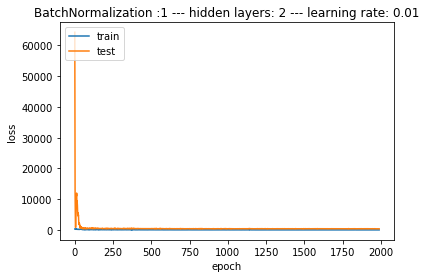

Train on 960 samples, validate on 241 samples
Epoch 1/2000
960/960 [==============================] - 4s 4ms/step - loss: 35894.9094 - val_loss: 9198897.9087
Epoch 2/2000
960/960 [==============================] - 1s 803us/step - loss: 6763.0599 - val_loss: 6297799.9710
Epoch 3/2000
960/960 [==============================] - 1s 858us/step - loss: 3070.1490 - val_loss: 3778009.3185
Epoch 4/2000
960/960 [==============================] - 1s 849us/step - loss: 1218.0104 - val_loss: 3538911.8568
Epoch 5/2000
960/960 [==============================] - 1s 841us/step - loss: 782.1710 - val_loss: 2429334.8620
Epoch 6/2000
960/960 [==============================] - 1s 854us/step - loss: 664.3058 - val_loss: 1667251.8828
Epoch 7/2000
960/960 [==============================] - 1s 835us/step - loss: 556.7151 - val_loss: 1386540.9917
Epoch 8/2000
960/960 [==============================] - 1s 852us/step - loss: 408.0988 - val_loss: 951696.3431
Epoch 9/2000
960/960 [==============================] - 

Epoch 75/2000
960/960 [==============================] - 1s 851us/step - loss: 97.8251 - val_loss: 487.3814
Epoch 76/2000
960/960 [==============================] - 1s 883us/step - loss: 143.4518 - val_loss: 607.5030
Epoch 77/2000
960/960 [==============================] - 1s 856us/step - loss: 139.2012 - val_loss: 481.0369
Epoch 78/2000
960/960 [==============================] - 1s 838us/step - loss: 91.6787 - val_loss: 455.5744
Epoch 79/2000
960/960 [==============================] - 1s 844us/step - loss: 86.0367 - val_loss: 483.5356
Epoch 80/2000
960/960 [==============================] - 1s 845us/step - loss: 89.9964 - val_loss: 456.9471
Epoch 81/2000
960/960 [==============================] - 1s 850us/step - loss: 93.3732 - val_loss: 443.9733
Epoch 82/2000
960/960 [==============================] - 1s 849us/step - loss: 139.5114 - val_loss: 472.4540
Epoch 83/2000
960/960 [==============================] - 1s 839us/step - loss: 175.2065 - val_loss: 521.7550
Epoch 84/2000
960/960 [=

960/960 [==============================] - 1s 837us/step - loss: 68.4589 - val_loss: 443.3981
Epoch 151/2000
960/960 [==============================] - 1s 854us/step - loss: 73.3299 - val_loss: 459.3490
Epoch 152/2000
960/960 [==============================] - 1s 833us/step - loss: 81.9091 - val_loss: 487.3495
Epoch 153/2000
960/960 [==============================] - 1s 836us/step - loss: 79.6653 - val_loss: 462.3683
Epoch 154/2000
960/960 [==============================] - 1s 848us/step - loss: 83.3374 - val_loss: 454.9706
Epoch 155/2000
960/960 [==============================] - 1s 870us/step - loss: 113.0478 - val_loss: 482.9725
Epoch 156/2000
960/960 [==============================] - 1s 852us/step - loss: 79.0462 - val_loss: 492.8026
Epoch 157/2000
960/960 [==============================] - 1s 833us/step - loss: 105.9529 - val_loss: 445.4503
Epoch 158/2000
960/960 [==============================] - 1s 846us/step - loss: 79.3034 - val_loss: 487.9076
Epoch 159/2000
960/960 [========

960/960 [==============================] - 1s 851us/step - loss: 69.7887 - val_loss: 585.0681
Epoch 226/2000
960/960 [==============================] - 1s 899us/step - loss: 85.4170 - val_loss: 428.1227
Epoch 227/2000
960/960 [==============================] - 1s 868us/step - loss: 68.2792 - val_loss: 443.6988
Epoch 228/2000
960/960 [==============================] - 1s 872us/step - loss: 73.3771 - val_loss: 451.5911
Epoch 229/2000
960/960 [==============================] - 1s 872us/step - loss: 73.3445 - val_loss: 433.1694
Epoch 230/2000
960/960 [==============================] - 1s 865us/step - loss: 60.0657 - val_loss: 403.7227
Epoch 231/2000
960/960 [==============================] - 1s 863us/step - loss: 61.7525 - val_loss: 436.3793
Epoch 232/2000
960/960 [==============================] - 1s 831us/step - loss: 54.4108 - val_loss: 432.5636
Epoch 233/2000
960/960 [==============================] - 1s 825us/step - loss: 46.1729 - val_loss: 415.4472
Epoch 234/2000
960/960 [==========

960/960 [==============================] - 1s 884us/step - loss: 48.1341 - val_loss: 513.1051
Epoch 301/2000
960/960 [==============================] - 1s 826us/step - loss: 49.4931 - val_loss: 399.1836
Epoch 302/2000
960/960 [==============================] - 1s 845us/step - loss: 60.0110 - val_loss: 422.1320
Epoch 303/2000
960/960 [==============================] - 1s 864us/step - loss: 67.6592 - val_loss: 408.6293
Epoch 304/2000
960/960 [==============================] - 1s 836us/step - loss: 60.8289 - val_loss: 392.6137
Epoch 305/2000
960/960 [==============================] - 1s 853us/step - loss: 48.3407 - val_loss: 503.3492
Epoch 306/2000
960/960 [==============================] - 1s 836us/step - loss: 62.7581 - val_loss: 409.9726
Epoch 307/2000
960/960 [==============================] - 1s 848us/step - loss: 61.1854 - val_loss: 477.9862
Epoch 308/2000
960/960 [==============================] - 1s 826us/step - loss: 67.4806 - val_loss: 396.5209
Epoch 309/2000
960/960 [==========

960/960 [==============================] - 1s 883us/step - loss: 112.3930 - val_loss: 624.1754
Epoch 376/2000
960/960 [==============================] - 1s 880us/step - loss: 147.3063 - val_loss: 430.2391
Epoch 377/2000
960/960 [==============================] - 1s 858us/step - loss: 135.5699 - val_loss: 447.6582
Epoch 378/2000
960/960 [==============================] - 1s 831us/step - loss: 166.6348 - val_loss: 424.6009
Epoch 379/2000
960/960 [==============================] - 1s 829us/step - loss: 95.1292 - val_loss: 391.9172
Epoch 380/2000
960/960 [==============================] - 1s 845us/step - loss: 75.9492 - val_loss: 410.9104
Epoch 381/2000
960/960 [==============================] - 1s 839us/step - loss: 56.6970 - val_loss: 423.3477
Epoch 382/2000
960/960 [==============================] - 1s 859us/step - loss: 47.7550 - val_loss: 395.9876
Epoch 383/2000
960/960 [==============================] - 1s 811us/step - loss: 49.0336 - val_loss: 388.7033
Epoch 384/2000
960/960 [======

960/960 [==============================] - 1s 886us/step - loss: 33.0942 - val_loss: 413.2158
Epoch 451/2000
960/960 [==============================] - 1s 821us/step - loss: 39.3050 - val_loss: 375.7011
Epoch 452/2000
960/960 [==============================] - 1s 825us/step - loss: 38.6698 - val_loss: 413.1165
Epoch 453/2000
960/960 [==============================] - 1s 830us/step - loss: 34.4194 - val_loss: 411.5549
Epoch 454/2000
960/960 [==============================] - 1s 870us/step - loss: 39.5520 - val_loss: 377.5715
Epoch 455/2000
960/960 [==============================] - 1s 852us/step - loss: 39.5737 - val_loss: 456.1031
Epoch 456/2000
960/960 [==============================] - 1s 827us/step - loss: 51.5762 - val_loss: 406.1098
Epoch 457/2000
960/960 [==============================] - 1s 828us/step - loss: 73.9678 - val_loss: 462.3219
Epoch 458/2000
960/960 [==============================] - 1s 831us/step - loss: 52.9088 - val_loss: 371.3873
Epoch 459/2000
960/960 [==========

960/960 [==============================] - 1s 865us/step - loss: 128.5463 - val_loss: 421.4215
Epoch 525/2000
960/960 [==============================] - 1s 893us/step - loss: 118.2766 - val_loss: 426.9989
Epoch 526/2000
960/960 [==============================] - 1s 856us/step - loss: 133.9912 - val_loss: 390.2421
Epoch 527/2000
960/960 [==============================] - 1s 872us/step - loss: 120.5189 - val_loss: 387.6814
Epoch 528/2000
960/960 [==============================] - 1s 834us/step - loss: 118.3939 - val_loss: 396.3782
Epoch 529/2000
960/960 [==============================] - 1s 851us/step - loss: 124.2795 - val_loss: 382.8754
Epoch 530/2000
960/960 [==============================] - 1s 839us/step - loss: 112.9673 - val_loss: 410.2318
Epoch 531/2000
960/960 [==============================] - 1s 844us/step - loss: 112.5144 - val_loss: 408.1381
Epoch 532/2000
960/960 [==============================] - 1s 832us/step - loss: 108.4727 - val_loss: 385.4284
Epoch 533/2000
960/960 [=

960/960 [==============================] - 1s 839us/step - loss: 109.6800 - val_loss: 386.7308
Epoch 599/2000
960/960 [==============================] - 1s 858us/step - loss: 107.1663 - val_loss: 385.6409
Epoch 600/2000
960/960 [==============================] - 1s 842us/step - loss: 115.5788 - val_loss: 437.7460
Epoch 601/2000
960/960 [==============================] - 1s 840us/step - loss: 113.6634 - val_loss: 403.8892
Epoch 602/2000
960/960 [==============================] - 1s 858us/step - loss: 106.5807 - val_loss: 394.7512
Epoch 603/2000
960/960 [==============================] - 1s 867us/step - loss: 109.9522 - val_loss: 397.4338
Epoch 604/2000
960/960 [==============================] - 1s 842us/step - loss: 117.5001 - val_loss: 383.6827
Epoch 605/2000
960/960 [==============================] - 1s 848us/step - loss: 121.7942 - val_loss: 376.5300
Epoch 606/2000
960/960 [==============================] - 1s 865us/step - loss: 107.3389 - val_loss: 395.5278
Epoch 607/2000
960/960 [=

960/960 [==============================] - 1s 865us/step - loss: 407.0530 - val_loss: 342.0344
Epoch 673/2000
960/960 [==============================] - 1s 875us/step - loss: 495.7608 - val_loss: 1156.0771
Epoch 674/2000
960/960 [==============================] - 1s 853us/step - loss: 459.1105 - val_loss: 400.6237
Epoch 675/2000
960/960 [==============================] - 1s 842us/step - loss: 365.4792 - val_loss: 539.4830
Epoch 676/2000
960/960 [==============================] - 1s 862us/step - loss: 511.5486 - val_loss: 362.4223
Epoch 677/2000
960/960 [==============================] - 1s 861us/step - loss: 376.7476 - val_loss: 425.4071
Epoch 678/2000
960/960 [==============================] - 1s 837us/step - loss: 416.6787 - val_loss: 468.5205
Epoch 679/2000
960/960 [==============================] - 1s 815us/step - loss: 351.5288 - val_loss: 391.2978
Epoch 680/2000
960/960 [==============================] - 1s 864us/step - loss: 353.6077 - val_loss: 377.8293
Epoch 681/2000
960/960 [

960/960 [==============================] - 1s 853us/step - loss: 541.2646 - val_loss: 403.5466
Epoch 747/2000
960/960 [==============================] - 1s 827us/step - loss: 543.9291 - val_loss: 402.5608
Epoch 748/2000
960/960 [==============================] - 1s 830us/step - loss: 540.3396 - val_loss: 412.3002
Epoch 749/2000
960/960 [==============================] - 1s 854us/step - loss: 538.9817 - val_loss: 402.9361
Epoch 750/2000
960/960 [==============================] - 1s 846us/step - loss: 535.8851 - val_loss: 415.9301
Epoch 751/2000
960/960 [==============================] - 1s 836us/step - loss: 544.3645 - val_loss: 406.4239
Epoch 752/2000
960/960 [==============================] - 1s 833us/step - loss: 535.5911 - val_loss: 422.6351
Epoch 753/2000
960/960 [==============================] - 1s 845us/step - loss: 542.6659 - val_loss: 402.2738
Epoch 754/2000
960/960 [==============================] - 1s 831us/step - loss: 548.2405 - val_loss: 428.7458
Epoch 755/2000
960/960 [=

960/960 [==============================] - 1s 888us/step - loss: 542.0657 - val_loss: 411.1313
Epoch 821/2000
960/960 [==============================] - 1s 859us/step - loss: 537.4905 - val_loss: 408.9417
Epoch 822/2000
960/960 [==============================] - 1s 845us/step - loss: 540.1040 - val_loss: 457.6454
Epoch 823/2000
960/960 [==============================] - 1s 816us/step - loss: 558.3081 - val_loss: 403.4593
Epoch 824/2000
960/960 [==============================] - 1s 824us/step - loss: 572.6912 - val_loss: 424.1510
Epoch 825/2000
960/960 [==============================] - 1s 851us/step - loss: 587.1875 - val_loss: 525.9898
Epoch 826/2000
960/960 [==============================] - 1s 856us/step - loss: 575.7601 - val_loss: 413.6029
Epoch 827/2000
960/960 [==============================] - 1s 855us/step - loss: 557.5252 - val_loss: 466.3131
Epoch 828/2000
960/960 [==============================] - 1s 837us/step - loss: 568.0788 - val_loss: 416.6202
Epoch 829/2000
960/960 [=

960/960 [==============================] - 1s 848us/step - loss: 556.9224 - val_loss: 402.7391
Epoch 895/2000
960/960 [==============================] - 1s 858us/step - loss: 546.3098 - val_loss: 415.3927
Epoch 896/2000
960/960 [==============================] - 1s 828us/step - loss: 538.7886 - val_loss: 419.4424
Epoch 897/2000
960/960 [==============================] - 1s 847us/step - loss: 533.6419 - val_loss: 425.0921
Epoch 898/2000
960/960 [==============================] - 1s 813us/step - loss: 546.2474 - val_loss: 402.4899
Epoch 899/2000
960/960 [==============================] - 1s 855us/step - loss: 538.3671 - val_loss: 402.4745
Epoch 900/2000
960/960 [==============================] - 1s 864us/step - loss: 544.1889 - val_loss: 402.5264
Epoch 901/2000
960/960 [==============================] - 1s 826us/step - loss: 540.0237 - val_loss: 420.1779
Epoch 902/2000
960/960 [==============================] - 1s 832us/step - loss: 542.7865 - val_loss: 410.5400
Epoch 903/2000
960/960 [=

960/960 [==============================] - 1s 887us/step - loss: 543.0364 - val_loss: 402.5016
Epoch 969/2000
960/960 [==============================] - 1s 882us/step - loss: 537.2251 - val_loss: 402.4700
Epoch 970/2000
960/960 [==============================] - 1s 867us/step - loss: 538.6840 - val_loss: 434.6184
Epoch 971/2000
960/960 [==============================] - 1s 857us/step - loss: 541.9582 - val_loss: 402.4040
Epoch 972/2000
960/960 [==============================] - 1s 861us/step - loss: 545.3908 - val_loss: 408.8259
Epoch 973/2000
960/960 [==============================] - 1s 825us/step - loss: 547.1288 - val_loss: 504.5941
Epoch 974/2000
960/960 [==============================] - 1s 852us/step - loss: 550.8855 - val_loss: 403.2157
Epoch 975/2000
960/960 [==============================] - 1s 822us/step - loss: 537.5504 - val_loss: 444.8394
Epoch 976/2000
960/960 [==============================] - 1s 838us/step - loss: 538.7823 - val_loss: 408.7806
Epoch 977/2000
960/960 [=

960/960 [==============================] - 1s 832us/step - loss: 461.4290 - val_loss: 402.2793
Epoch 1043/2000
960/960 [==============================] - 1s 848us/step - loss: 461.0333 - val_loss: 425.2794
Epoch 1044/2000
960/960 [==============================] - 1s 857us/step - loss: 473.2628 - val_loss: 423.3286
Epoch 1045/2000
960/960 [==============================] - 1s 817us/step - loss: 471.7175 - val_loss: 406.3253
Epoch 1046/2000
960/960 [==============================] - 1s 854us/step - loss: 463.7324 - val_loss: 403.7335
Epoch 1047/2000
960/960 [==============================] - 1s 830us/step - loss: 463.5147 - val_loss: 405.7519
Epoch 1048/2000
960/960 [==============================] - 1s 853us/step - loss: 461.5355 - val_loss: 409.3160
Epoch 1049/2000
960/960 [==============================] - 1s 862us/step - loss: 469.1444 - val_loss: 435.4390
Epoch 1050/2000
960/960 [==============================] - 1s 847us/step - loss: 463.2066 - val_loss: 404.5558
Epoch 1051/2000
9

Epoch 1116/2000
960/960 [==============================] - 1s 859us/step - loss: 460.8049 - val_loss: 413.3281
Epoch 1117/2000
960/960 [==============================] - 1s 858us/step - loss: 461.0643 - val_loss: 445.5405
Epoch 1118/2000
960/960 [==============================] - 1s 860us/step - loss: 469.4072 - val_loss: 443.5384
Epoch 1119/2000
960/960 [==============================] - 1s 848us/step - loss: 465.9285 - val_loss: 402.2847
Epoch 1120/2000
960/960 [==============================] - 1s 835us/step - loss: 462.2067 - val_loss: 404.9943
Epoch 1121/2000
960/960 [==============================] - 1s 841us/step - loss: 472.3558 - val_loss: 410.4953
Epoch 1122/2000
960/960 [==============================] - 1s 828us/step - loss: 459.3929 - val_loss: 405.1538
Epoch 1123/2000
960/960 [==============================] - 1s 861us/step - loss: 475.8569 - val_loss: 425.7914
Epoch 1124/2000
960/960 [==============================] - 1s 852us/step - loss: 474.6826 - val_loss: 443.2265
E

Epoch 1190/2000
960/960 [==============================] - 1s 849us/step - loss: 478.5045 - val_loss: 417.9228
Epoch 1191/2000
960/960 [==============================] - 1s 839us/step - loss: 461.8885 - val_loss: 411.4261
Epoch 1192/2000
960/960 [==============================] - 1s 847us/step - loss: 473.6918 - val_loss: 455.0638
Epoch 1193/2000
960/960 [==============================] - 1s 833us/step - loss: 487.4495 - val_loss: 406.0109
Epoch 1194/2000
960/960 [==============================] - 1s 870us/step - loss: 483.2194 - val_loss: 446.4190
Epoch 1195/2000
960/960 [==============================] - 1s 820us/step - loss: 470.5754 - val_loss: 425.6880
Epoch 1196/2000
960/960 [==============================] - 1s 829us/step - loss: 467.8612 - val_loss: 429.3658
Epoch 1197/2000
960/960 [==============================] - 1s 842us/step - loss: 459.8417 - val_loss: 414.2127
Epoch 1198/2000
960/960 [==============================] - 1s 830us/step - loss: 474.4190 - val_loss: 431.2179
E

960/960 [==============================] - 1s 889us/step - loss: 466.0548 - val_loss: 428.9321
Epoch 1264/2000
960/960 [==============================] - 1s 891us/step - loss: 463.8817 - val_loss: 415.2981
Epoch 1265/2000
960/960 [==============================] - 1s 858us/step - loss: 474.1077 - val_loss: 418.2783
Epoch 1266/2000
960/960 [==============================] - 1s 838us/step - loss: 473.1799 - val_loss: 402.3716
Epoch 1267/2000
960/960 [==============================] - 1s 874us/step - loss: 461.9120 - val_loss: 417.1308
Epoch 1268/2000
960/960 [==============================] - 1s 846us/step - loss: 465.1222 - val_loss: 411.7336
Epoch 1269/2000
960/960 [==============================] - 1s 842us/step - loss: 484.3637 - val_loss: 410.7773
Epoch 1270/2000
960/960 [==============================] - 1s 828us/step - loss: 472.5449 - val_loss: 433.9506
Epoch 1271/2000
960/960 [==============================] - 1s 811us/step - loss: 466.4120 - val_loss: 418.4636
Epoch 1272/2000
9

Epoch 1337/2000
960/960 [==============================] - 1s 850us/step - loss: 465.7227 - val_loss: 402.3938
Epoch 1338/2000
960/960 [==============================] - 1s 837us/step - loss: 483.2120 - val_loss: 416.2223
Epoch 1339/2000
960/960 [==============================] - 1s 846us/step - loss: 471.3772 - val_loss: 402.4421
Epoch 1340/2000
960/960 [==============================] - 1s 839us/step - loss: 469.1883 - val_loss: 407.8116
Epoch 1341/2000
960/960 [==============================] - 1s 867us/step - loss: 466.6127 - val_loss: 402.3361
Epoch 1342/2000
960/960 [==============================] - 1s 847us/step - loss: 465.6001 - val_loss: 421.2776
Epoch 1343/2000
960/960 [==============================] - 1s 833us/step - loss: 478.8153 - val_loss: 452.9847
Epoch 1344/2000
960/960 [==============================] - 1s 825us/step - loss: 461.2435 - val_loss: 419.2072
Epoch 1345/2000
960/960 [==============================] - 1s 843us/step - loss: 463.9343 - val_loss: 434.0779
E

Epoch 1411/2000
960/960 [==============================] - 1s 874us/step - loss: 471.0107 - val_loss: 436.6828
Epoch 1412/2000
960/960 [==============================] - 1s 880us/step - loss: 472.3501 - val_loss: 403.2421
Epoch 1413/2000
960/960 [==============================] - 1s 890us/step - loss: 466.9326 - val_loss: 404.0651
Epoch 1414/2000
960/960 [==============================] - 1s 859us/step - loss: 466.2585 - val_loss: 404.9233
Epoch 1415/2000
960/960 [==============================] - 1s 847us/step - loss: 472.1035 - val_loss: 457.0800
Epoch 1416/2000
960/960 [==============================] - 1s 857us/step - loss: 472.5757 - val_loss: 403.7564
Epoch 1417/2000
960/960 [==============================] - 1s 862us/step - loss: 464.3663 - val_loss: 405.8744
Epoch 1418/2000
960/960 [==============================] - 1s 853us/step - loss: 456.6078 - val_loss: 412.8686
Epoch 1419/2000
960/960 [==============================] - 1s 814us/step - loss: 460.4720 - val_loss: 402.3613
E

Epoch 1485/2000
960/960 [==============================] - 1s 862us/step - loss: 462.9157 - val_loss: 402.4360
Epoch 1486/2000
960/960 [==============================] - 1s 866us/step - loss: 464.1146 - val_loss: 408.9826
Epoch 1487/2000
960/960 [==============================] - 1s 823us/step - loss: 459.5011 - val_loss: 404.6712
Epoch 1488/2000
960/960 [==============================] - 1s 839us/step - loss: 466.3821 - val_loss: 467.6407
Epoch 1489/2000
960/960 [==============================] - 1s 798us/step - loss: 475.1305 - val_loss: 419.2366
Epoch 1490/2000
960/960 [==============================] - 1s 838us/step - loss: 465.3515 - val_loss: 403.4372
Epoch 1491/2000
960/960 [==============================] - 1s 851us/step - loss: 469.7411 - val_loss: 413.0727
Epoch 1492/2000
960/960 [==============================] - 1s 835us/step - loss: 467.7379 - val_loss: 429.1378
Epoch 1493/2000
960/960 [==============================] - 1s 859us/step - loss: 473.7347 - val_loss: 402.2663
E

Epoch 1559/2000
960/960 [==============================] - 1s 914us/step - loss: 460.8164 - val_loss: 403.4197
Epoch 1560/2000
960/960 [==============================] - 1s 875us/step - loss: 460.0360 - val_loss: 402.9508
Epoch 1561/2000
960/960 [==============================] - 1s 864us/step - loss: 475.9511 - val_loss: 402.5746
Epoch 1562/2000
960/960 [==============================] - 1s 846us/step - loss: 463.0979 - val_loss: 404.0720
Epoch 1563/2000
960/960 [==============================] - 1s 833us/step - loss: 461.2310 - val_loss: 402.3807
Epoch 1564/2000
960/960 [==============================] - 1s 825us/step - loss: 460.6194 - val_loss: 407.6932
Epoch 1565/2000
960/960 [==============================] - 1s 852us/step - loss: 459.0466 - val_loss: 404.8365
Epoch 1566/2000
960/960 [==============================] - 1s 827us/step - loss: 463.5436 - val_loss: 418.2005
Epoch 1567/2000
960/960 [==============================] - 1s 840us/step - loss: 464.2315 - val_loss: 422.6068
E

960/960 [==============================] - 1s 849us/step - loss: 461.1662 - val_loss: 417.9690
Epoch 1633/2000
960/960 [==============================] - 1s 847us/step - loss: 464.8284 - val_loss: 418.7981
Epoch 1634/2000
960/960 [==============================] - 1s 843us/step - loss: 466.2013 - val_loss: 403.7617
Epoch 1635/2000
960/960 [==============================] - 1s 828us/step - loss: 459.3783 - val_loss: 408.6024
Epoch 1636/2000
960/960 [==============================] - 1s 877us/step - loss: 466.7542 - val_loss: 413.9532
Epoch 1637/2000
960/960 [==============================] - 1s 852us/step - loss: 475.7101 - val_loss: 404.5335
Epoch 1638/2000
960/960 [==============================] - 1s 855us/step - loss: 463.9553 - val_loss: 403.7512
Epoch 1639/2000
960/960 [==============================] - 1s 835us/step - loss: 460.7829 - val_loss: 404.2155
Epoch 1640/2000
960/960 [==============================] - 1s 864us/step - loss: 460.6987 - val_loss: 407.3429
Epoch 1641/2000
9

Epoch 1706/2000
960/960 [==============================] - 1s 881us/step - loss: 460.7740 - val_loss: 406.9576
Epoch 1707/2000
960/960 [==============================] - 1s 880us/step - loss: 461.2686 - val_loss: 415.2031
Epoch 1708/2000
960/960 [==============================] - 1s 888us/step - loss: 463.8692 - val_loss: 429.7146
Epoch 1709/2000
960/960 [==============================] - 1s 894us/step - loss: 466.2963 - val_loss: 438.7021
Epoch 1710/2000
960/960 [==============================] - 1s 870us/step - loss: 466.9463 - val_loss: 434.5654
Epoch 1711/2000
960/960 [==============================] - 1s 848us/step - loss: 466.1540 - val_loss: 415.3598
Epoch 1712/2000
960/960 [==============================] - 1s 833us/step - loss: 461.6206 - val_loss: 412.4591
Epoch 1713/2000
960/960 [==============================] - 1s 840us/step - loss: 465.4897 - val_loss: 402.2709
Epoch 1714/2000
960/960 [==============================] - 1s 830us/step - loss: 461.9979 - val_loss: 402.7879
E

Epoch 1780/2000
960/960 [==============================] - 1s 874us/step - loss: 460.8208 - val_loss: 415.1752
Epoch 1781/2000
960/960 [==============================] - 1s 832us/step - loss: 459.9515 - val_loss: 411.7724
Epoch 1782/2000
960/960 [==============================] - 1s 866us/step - loss: 460.1533 - val_loss: 402.5312
Epoch 1783/2000
960/960 [==============================] - 1s 861us/step - loss: 458.2927 - val_loss: 407.0978
Epoch 1784/2000
960/960 [==============================] - 1s 832us/step - loss: 460.2212 - val_loss: 402.5996
Epoch 1785/2000
960/960 [==============================] - 1s 864us/step - loss: 460.3043 - val_loss: 414.9121
Epoch 1786/2000
960/960 [==============================] - 1s 848us/step - loss: 461.6528 - val_loss: 418.7883
Epoch 1787/2000
960/960 [==============================] - 1s 871us/step - loss: 473.4633 - val_loss: 420.0244
Epoch 1788/2000
960/960 [==============================] - 1s 813us/step - loss: 463.2409 - val_loss: 441.9328
E

Epoch 1854/2000
960/960 [==============================] - 1s 838us/step - loss: 477.8725 - val_loss: 433.0427
Epoch 1855/2000
960/960 [==============================] - 1s 909us/step - loss: 463.8618 - val_loss: 407.1827
Epoch 1856/2000
960/960 [==============================] - 1s 861us/step - loss: 460.2875 - val_loss: 408.8909
Epoch 1857/2000
960/960 [==============================] - 1s 900us/step - loss: 460.8419 - val_loss: 415.3447
Epoch 1858/2000
960/960 [==============================] - 1s 857us/step - loss: 460.6060 - val_loss: 402.3861
Epoch 1859/2000
960/960 [==============================] - 1s 854us/step - loss: 470.8449 - val_loss: 413.4133
Epoch 1860/2000
960/960 [==============================] - 1s 837us/step - loss: 464.4645 - val_loss: 402.3153
Epoch 1861/2000
960/960 [==============================] - 1s 839us/step - loss: 458.0185 - val_loss: 410.9759
Epoch 1862/2000
960/960 [==============================] - 1s 829us/step - loss: 463.2203 - val_loss: 402.2970
E

Epoch 1928/2000
960/960 [==============================] - 1s 900us/step - loss: 472.8200 - val_loss: 402.7932
Epoch 1929/2000
960/960 [==============================] - 1s 830us/step - loss: 462.4192 - val_loss: 418.7636
Epoch 1930/2000
960/960 [==============================] - 1s 852us/step - loss: 465.7452 - val_loss: 424.5726
Epoch 1931/2000
960/960 [==============================] - 1s 857us/step - loss: 463.4019 - val_loss: 418.5571
Epoch 1932/2000
960/960 [==============================] - 1s 843us/step - loss: 465.4381 - val_loss: 428.0292
Epoch 1933/2000
960/960 [==============================] - 1s 845us/step - loss: 462.9168 - val_loss: 421.6893
Epoch 1934/2000
960/960 [==============================] - 1s 840us/step - loss: 464.2691 - val_loss: 405.1448
Epoch 1935/2000
960/960 [==============================] - 1s 827us/step - loss: 462.1380 - val_loss: 406.3245
Epoch 1936/2000
960/960 [==============================] - 1s 827us/step - loss: 462.3825 - val_loss: 402.3156
E

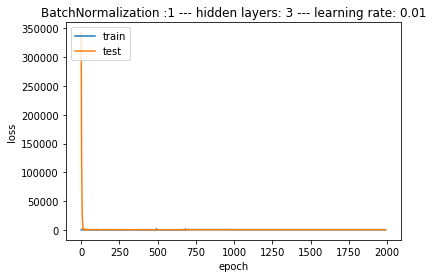

Train on 960 samples, validate on 241 samples
Epoch 1/2000
960/960 [==============================] - 5s 5ms/step - loss: 103558.0667 - val_loss: 2273384.4575
Epoch 2/2000
960/960 [==============================] - 1s 903us/step - loss: 11327.3669 - val_loss: 17401674.5145
Epoch 3/2000
960/960 [==============================] - 1s 921us/step - loss: 3477.1801 - val_loss: 2725910.8786
Epoch 4/2000
960/960 [==============================] - 1s 911us/step - loss: 1746.0645 - val_loss: 4357162.2033
Epoch 5/2000
960/960 [==============================] - 1s 941us/step - loss: 1064.4674 - val_loss: 2426954.4232
Epoch 6/2000
960/960 [==============================] - 1s 920us/step - loss: 932.5906 - val_loss: 1359410.0233
Epoch 7/2000
960/960 [==============================] - 1s 938us/step - loss: 675.0783 - val_loss: 669995.3340
Epoch 8/2000
960/960 [==============================] - 1s 912us/step - loss: 574.9910 - val_loss: 484383.7496
Epoch 9/2000
960/960 [==============================]

960/960 [==============================] - 1s 948us/step - loss: 135.9260 - val_loss: 476.9807
Epoch 76/2000
960/960 [==============================] - 1s 933us/step - loss: 215.1439 - val_loss: 531.2011
Epoch 77/2000
960/960 [==============================] - 1s 955us/step - loss: 155.0947 - val_loss: 462.0394
Epoch 78/2000
960/960 [==============================] - 1s 925us/step - loss: 125.6823 - val_loss: 477.0016
Epoch 79/2000
960/960 [==============================] - 1s 972us/step - loss: 181.9670 - val_loss: 611.0213
Epoch 80/2000
960/960 [==============================] - 1s 928us/step - loss: 150.7042 - val_loss: 472.4586
Epoch 81/2000
960/960 [==============================] - 1s 972us/step - loss: 128.6047 - val_loss: 456.2365
Epoch 82/2000
960/960 [==============================] - 1s 942us/step - loss: 170.6150 - val_loss: 511.0931
Epoch 83/2000
960/960 [==============================] - 1s 936us/step - loss: 91.9634 - val_loss: 418.1033
Epoch 84/2000
960/960 [===========

960/960 [==============================] - 1s 969us/step - loss: 106.5619 - val_loss: 593.4499
Epoch 151/2000
960/960 [==============================] - 1s 957us/step - loss: 144.3004 - val_loss: 434.7180
Epoch 152/2000
960/960 [==============================] - 1s 952us/step - loss: 128.0655 - val_loss: 632.7104
Epoch 153/2000
960/960 [==============================] - 1s 962us/step - loss: 103.2812 - val_loss: 533.9361
Epoch 154/2000
960/960 [==============================] - 1s 918us/step - loss: 155.9038 - val_loss: 442.9138
Epoch 155/2000
960/960 [==============================] - 1s 926us/step - loss: 105.8557 - val_loss: 425.9212
Epoch 156/2000
960/960 [==============================] - 1s 923us/step - loss: 82.7581 - val_loss: 431.4348
Epoch 157/2000
960/960 [==============================] - 1s 926us/step - loss: 95.5653 - val_loss: 474.6775
Epoch 158/2000
960/960 [==============================] - 1s 929us/step - loss: 87.9999 - val_loss: 551.6826
Epoch 159/2000
960/960 [====

960/960 [==============================] - 1s 960us/step - loss: 67.8241 - val_loss: 500.9596
Epoch 226/2000
960/960 [==============================] - 1s 911us/step - loss: 75.0596 - val_loss: 419.7328
Epoch 227/2000
960/960 [==============================] - 1s 961us/step - loss: 101.8520 - val_loss: 552.7833
Epoch 228/2000
960/960 [==============================] - 1s 952us/step - loss: 111.9511 - val_loss: 474.6911
Epoch 229/2000
960/960 [==============================] - 1s 950us/step - loss: 114.6032 - val_loss: 419.8915
Epoch 230/2000
960/960 [==============================] - 1s 913us/step - loss: 56.4650 - val_loss: 422.8120
Epoch 231/2000
960/960 [==============================] - 1s 957us/step - loss: 50.8449 - val_loss: 484.9561
Epoch 232/2000
960/960 [==============================] - 1s 906us/step - loss: 71.4598 - val_loss: 454.1258
Epoch 233/2000
960/960 [==============================] - 1s 949us/step - loss: 54.3284 - val_loss: 424.6596
Epoch 234/2000
960/960 [=======

960/960 [==============================] - 1s 972us/step - loss: 70.3516 - val_loss: 403.4923
Epoch 301/2000
960/960 [==============================] - 1s 942us/step - loss: 50.2621 - val_loss: 448.0585
Epoch 302/2000
960/960 [==============================] - 1s 939us/step - loss: 65.2321 - val_loss: 476.5446
Epoch 303/2000
960/960 [==============================] - 1s 924us/step - loss: 45.9604 - val_loss: 438.8019
Epoch 304/2000
960/960 [==============================] - 1s 966us/step - loss: 77.8434 - val_loss: 413.3743
Epoch 305/2000
960/960 [==============================] - 1s 981us/step - loss: 57.0862 - val_loss: 396.4839
Epoch 306/2000
960/960 [==============================] - 1s 933us/step - loss: 91.7812 - val_loss: 421.4293
Epoch 307/2000
960/960 [==============================] - 1s 913us/step - loss: 64.4739 - val_loss: 419.6455
Epoch 308/2000
960/960 [==============================] - 1s 954us/step - loss: 88.2295 - val_loss: 411.1303
Epoch 309/2000
960/960 [==========

960/960 [==============================] - 1s 982us/step - loss: 79.8750 - val_loss: 412.1437
Epoch 376/2000
960/960 [==============================] - 1s 949us/step - loss: 68.3181 - val_loss: 451.3672
Epoch 377/2000
960/960 [==============================] - 1s 953us/step - loss: 66.9017 - val_loss: 503.3386
Epoch 378/2000
960/960 [==============================] - 1s 954us/step - loss: 62.4141 - val_loss: 500.4013
Epoch 379/2000
960/960 [==============================] - 1s 944us/step - loss: 75.3199 - val_loss: 577.5730
Epoch 380/2000
960/960 [==============================] - 1s 928us/step - loss: 109.4294 - val_loss: 492.8630
Epoch 381/2000
960/960 [==============================] - 1s 963us/step - loss: 68.6917 - val_loss: 430.4338
Epoch 382/2000
960/960 [==============================] - 1s 936us/step - loss: 40.3842 - val_loss: 431.6787
Epoch 383/2000
960/960 [==============================] - 1s 912us/step - loss: 40.7718 - val_loss: 437.6899
Epoch 384/2000
960/960 [=========

960/960 [==============================] - 1s 961us/step - loss: 38.7181 - val_loss: 441.8415
Epoch 451/2000
960/960 [==============================] - 1s 946us/step - loss: 37.5786 - val_loss: 401.9811
Epoch 452/2000
960/960 [==============================] - 1s 916us/step - loss: 70.4716 - val_loss: 395.8797
Epoch 453/2000
960/960 [==============================] - 1s 900us/step - loss: 43.3516 - val_loss: 426.5181
Epoch 454/2000
960/960 [==============================] - 1s 919us/step - loss: 44.1931 - val_loss: 428.5378
Epoch 455/2000
960/960 [==============================] - 1s 951us/step - loss: 44.8876 - val_loss: 441.9799
Epoch 456/2000
960/960 [==============================] - 1s 936us/step - loss: 39.1463 - val_loss: 385.7604
Epoch 457/2000
960/960 [==============================] - 1s 945us/step - loss: 40.7736 - val_loss: 406.7503
Epoch 458/2000
960/960 [==============================] - 1s 941us/step - loss: 35.1456 - val_loss: 423.6030
Epoch 459/2000
960/960 [==========

960/960 [==============================] - 1s 941us/step - loss: 49.1814 - val_loss: 417.1170
Epoch 526/2000
960/960 [==============================] - 1s 954us/step - loss: 66.1615 - val_loss: 426.6457
Epoch 527/2000
960/960 [==============================] - 1s 956us/step - loss: 44.3303 - val_loss: 431.6488
Epoch 528/2000
960/960 [==============================] - 1s 988us/step - loss: 49.9777 - val_loss: 394.4360
Epoch 529/2000
960/960 [==============================] - 1s 968us/step - loss: 45.3711 - val_loss: 420.3133
Epoch 530/2000
960/960 [==============================] - 1s 944us/step - loss: 36.6618 - val_loss: 419.7579
Epoch 531/2000
960/960 [==============================] - 1s 993us/step - loss: 37.6945 - val_loss: 464.2729
Epoch 532/2000
960/960 [==============================] - 1s 956us/step - loss: 41.9017 - val_loss: 425.4103
Epoch 533/2000
960/960 [==============================] - 1s 955us/step - loss: 39.4362 - val_loss: 400.1845
Epoch 534/2000
960/960 [==========

960/960 [==============================] - 1s 976us/step - loss: 46.7192 - val_loss: 445.2070
Epoch 601/2000
960/960 [==============================] - 1s 942us/step - loss: 45.8212 - val_loss: 406.7169
Epoch 602/2000
960/960 [==============================] - 1s 927us/step - loss: 44.9805 - val_loss: 392.2971
Epoch 603/2000
960/960 [==============================] - 1s 920us/step - loss: 46.6135 - val_loss: 399.3284
Epoch 604/2000
960/960 [==============================] - 1s 963us/step - loss: 39.9087 - val_loss: 419.1683
Epoch 605/2000
960/960 [==============================] - 1s 934us/step - loss: 50.7181 - val_loss: 477.6235
Epoch 606/2000
960/960 [==============================] - 1s 923us/step - loss: 41.2954 - val_loss: 414.1069
Epoch 607/2000
960/960 [==============================] - 1s 957us/step - loss: 42.7255 - val_loss: 402.3123
Epoch 608/2000
960/960 [==============================] - 1s 934us/step - loss: 47.1945 - val_loss: 516.1237
Epoch 609/2000
960/960 [==========

960/960 [==============================] - 1s 963us/step - loss: 39.2886 - val_loss: 403.4339
Epoch 676/2000
960/960 [==============================] - 1s 949us/step - loss: 34.2724 - val_loss: 414.6625
Epoch 677/2000
960/960 [==============================] - 1s 926us/step - loss: 36.1335 - val_loss: 399.0947
Epoch 678/2000
960/960 [==============================] - 1s 942us/step - loss: 41.1663 - val_loss: 411.4226
Epoch 679/2000
960/960 [==============================] - 1s 936us/step - loss: 33.5975 - val_loss: 459.5996
Epoch 680/2000
960/960 [==============================] - 1s 935us/step - loss: 33.3100 - val_loss: 435.1725
Epoch 681/2000
960/960 [==============================] - 1s 968us/step - loss: 32.6552 - val_loss: 417.4730
Epoch 682/2000
960/960 [==============================] - 1s 948us/step - loss: 40.3171 - val_loss: 403.3423
Epoch 683/2000
960/960 [==============================] - 1s 921us/step - loss: 39.2065 - val_loss: 451.1486
Epoch 684/2000
960/960 [==========

960/960 [==============================] - 1s 974us/step - loss: 52.7004 - val_loss: 406.8236
Epoch 751/2000
960/960 [==============================] - 1s 932us/step - loss: 64.3073 - val_loss: 400.0974
Epoch 752/2000
960/960 [==============================] - 1s 933us/step - loss: 58.6357 - val_loss: 391.0667
Epoch 753/2000
960/960 [==============================] - 1s 938us/step - loss: 54.6056 - val_loss: 399.1353
Epoch 754/2000
960/960 [==============================] - 1s 928us/step - loss: 40.6808 - val_loss: 417.3149
Epoch 755/2000
960/960 [==============================] - 1s 943us/step - loss: 46.6668 - val_loss: 408.1724
Epoch 756/2000
960/960 [==============================] - 1s 927us/step - loss: 44.8613 - val_loss: 416.7729
Epoch 757/2000
960/960 [==============================] - 1s 947us/step - loss: 73.2314 - val_loss: 402.2045
Epoch 758/2000
960/960 [==============================] - 1s 940us/step - loss: 60.8690 - val_loss: 416.2625
Epoch 759/2000
960/960 [==========

960/960 [==============================] - 1s 978us/step - loss: 33.3685 - val_loss: 410.3406
Epoch 826/2000
960/960 [==============================] - 1s 937us/step - loss: 40.0554 - val_loss: 416.0554
Epoch 827/2000
960/960 [==============================] - 1s 971us/step - loss: 32.3243 - val_loss: 418.0790
Epoch 828/2000
960/960 [==============================] - 1s 939us/step - loss: 41.2669 - val_loss: 409.8979
Epoch 829/2000
960/960 [==============================] - 1s 946us/step - loss: 32.5159 - val_loss: 394.7342
Epoch 830/2000
960/960 [==============================] - 1s 939us/step - loss: 32.4258 - val_loss: 404.2908
Epoch 831/2000
960/960 [==============================] - 1s 960us/step - loss: 29.0460 - val_loss: 422.9362
Epoch 832/2000
960/960 [==============================] - 1s 922us/step - loss: 37.4024 - val_loss: 399.3275
Epoch 833/2000
960/960 [==============================] - 1s 923us/step - loss: 32.2264 - val_loss: 397.4657
Epoch 834/2000
960/960 [==========

Epoch 900/2000
960/960 [==============================] - 1s 953us/step - loss: 483.2326 - val_loss: 403.7971
Epoch 901/2000
960/960 [==============================] - 1s 923us/step - loss: 462.8630 - val_loss: 426.9000
Epoch 902/2000
960/960 [==============================] - 1s 925us/step - loss: 470.7774 - val_loss: 420.8778
Epoch 903/2000
960/960 [==============================] - 1s 953us/step - loss: 468.7083 - val_loss: 452.5010
Epoch 904/2000
960/960 [==============================] - 1s 935us/step - loss: 477.2382 - val_loss: 405.4701
Epoch 905/2000
960/960 [==============================] - 1s 917us/step - loss: 461.8894 - val_loss: 403.3810
Epoch 906/2000
960/960 [==============================] - 1s 927us/step - loss: 465.6280 - val_loss: 402.3029
Epoch 907/2000
960/960 [==============================] - 1s 945us/step - loss: 476.5049 - val_loss: 409.3813
Epoch 908/2000
960/960 [==============================] - 1s 939us/step - loss: 481.6319 - val_loss: 492.3249
Epoch 909/

960/960 [==============================] - 1s 944us/step - loss: 465.2200 - val_loss: 402.9148
Epoch 975/2000
960/960 [==============================] - 1s 917us/step - loss: 465.9112 - val_loss: 404.7693
Epoch 976/2000
960/960 [==============================] - 1s 927us/step - loss: 459.8285 - val_loss: 422.7710
Epoch 977/2000
960/960 [==============================] - 1s 939us/step - loss: 462.3526 - val_loss: 407.1389
Epoch 978/2000
960/960 [==============================] - 1s 939us/step - loss: 477.1717 - val_loss: 402.3407
Epoch 979/2000
960/960 [==============================] - 1s 962us/step - loss: 486.6166 - val_loss: 453.0099
Epoch 980/2000
960/960 [==============================] - 1s 955us/step - loss: 462.3834 - val_loss: 432.9191
Epoch 981/2000
960/960 [==============================] - 1s 946us/step - loss: 493.6787 - val_loss: 442.4920
Epoch 982/2000
960/960 [==============================] - 1s 933us/step - loss: 485.2649 - val_loss: 403.9026
Epoch 983/2000
960/960 [=

960/960 [==============================] - 1s 957us/step - loss: 462.3639 - val_loss: 402.6782
Epoch 1049/2000
960/960 [==============================] - 1s 946us/step - loss: 481.5726 - val_loss: 417.4803
Epoch 1050/2000
960/960 [==============================] - 1s 932us/step - loss: 467.8489 - val_loss: 402.2613
Epoch 1051/2000
960/960 [==============================] - 1s 943us/step - loss: 475.8368 - val_loss: 403.0789
Epoch 1052/2000
960/960 [==============================] - 1s 936us/step - loss: 463.1614 - val_loss: 404.5515
Epoch 1053/2000
960/960 [==============================] - 1s 962us/step - loss: 466.7474 - val_loss: 410.6872
Epoch 1054/2000
960/960 [==============================] - 1s 929us/step - loss: 461.2556 - val_loss: 421.1273
Epoch 1055/2000
960/960 [==============================] - 1s 959us/step - loss: 466.4102 - val_loss: 403.0630
Epoch 1056/2000
960/960 [==============================] - 1s 922us/step - loss: 466.1857 - val_loss: 406.1435
Epoch 1057/2000
9

Epoch 1122/2000
960/960 [==============================] - 1s 957us/step - loss: 466.6688 - val_loss: 408.1801
Epoch 1123/2000
960/960 [==============================] - 1s 935us/step - loss: 460.1515 - val_loss: 414.3228
Epoch 1124/2000
960/960 [==============================] - 1s 954us/step - loss: 462.5842 - val_loss: 404.3637
Epoch 1125/2000
960/960 [==============================] - 1s 917us/step - loss: 463.8772 - val_loss: 402.5466
Epoch 1126/2000
960/960 [==============================] - 1s 983us/step - loss: 465.8639 - val_loss: 402.8717
Epoch 1127/2000
960/960 [==============================] - 1s 930us/step - loss: 461.8914 - val_loss: 402.9536
Epoch 1128/2000
960/960 [==============================] - 1s 957us/step - loss: 458.0536 - val_loss: 424.2656
Epoch 1129/2000
960/960 [==============================] - 1s 935us/step - loss: 473.9010 - val_loss: 402.9199
Epoch 1130/2000
960/960 [==============================] - 1s 933us/step - loss: 463.9766 - val_loss: 413.3901
E

Epoch 1196/2000
960/960 [==============================] - 1s 978us/step - loss: 460.3006 - val_loss: 403.9551
Epoch 1197/2000
960/960 [==============================] - 1s 956us/step - loss: 462.2205 - val_loss: 406.4982
Epoch 1198/2000
960/960 [==============================] - 1s 936us/step - loss: 460.0349 - val_loss: 406.0145
Epoch 1199/2000
960/960 [==============================] - 1s 955us/step - loss: 460.2234 - val_loss: 420.2063
Epoch 1200/2000
960/960 [==============================] - 1s 955us/step - loss: 472.7860 - val_loss: 435.9450
Epoch 1201/2000
960/960 [==============================] - 1s 936us/step - loss: 472.5880 - val_loss: 420.1035
Epoch 1202/2000
960/960 [==============================] - 1s 936us/step - loss: 482.4212 - val_loss: 404.0733
Epoch 1203/2000
960/960 [==============================] - 1s 969us/step - loss: 485.8432 - val_loss: 461.4407
Epoch 1204/2000
960/960 [==============================] - 1s 943us/step - loss: 459.8258 - val_loss: 416.1948
E

Epoch 1270/2000
960/960 [==============================] - 1s 974us/step - loss: 465.2329 - val_loss: 403.4821
Epoch 1271/2000
960/960 [==============================] - 1s 931us/step - loss: 472.0182 - val_loss: 468.8798
Epoch 1272/2000
960/960 [==============================] - 1s 950us/step - loss: 468.9523 - val_loss: 434.6843
Epoch 1273/2000
960/960 [==============================] - 1s 941us/step - loss: 467.9264 - val_loss: 422.7541
Epoch 1274/2000
960/960 [==============================] - 1s 938us/step - loss: 461.6481 - val_loss: 404.5362
Epoch 1275/2000
960/960 [==============================] - 1s 935us/step - loss: 461.2863 - val_loss: 404.1759
Epoch 1276/2000
960/960 [==============================] - 1s 965us/step - loss: 463.2772 - val_loss: 425.5246
Epoch 1277/2000
960/960 [==============================] - 1s 947us/step - loss: 467.9356 - val_loss: 402.5454
Epoch 1278/2000
960/960 [==============================] - 1s 930us/step - loss: 466.6314 - val_loss: 409.6977
E

Epoch 1344/2000
960/960 [==============================] - 1s 950us/step - loss: 468.0251 - val_loss: 419.7602
Epoch 1345/2000
960/960 [==============================] - 1s 950us/step - loss: 463.5168 - val_loss: 410.9628
Epoch 1346/2000
960/960 [==============================] - 1s 917us/step - loss: 466.1297 - val_loss: 403.7703
Epoch 1347/2000
960/960 [==============================] - 1s 928us/step - loss: 460.4922 - val_loss: 425.2149
Epoch 1348/2000
960/960 [==============================] - 1s 967us/step - loss: 459.5718 - val_loss: 402.3144
Epoch 1349/2000
960/960 [==============================] - 1s 940us/step - loss: 469.4245 - val_loss: 405.1215
Epoch 1350/2000
960/960 [==============================] - 1s 942us/step - loss: 461.9283 - val_loss: 406.4201
Epoch 1351/2000
960/960 [==============================] - 1s 957us/step - loss: 464.6224 - val_loss: 446.1236
Epoch 1352/2000
960/960 [==============================] - 1s 924us/step - loss: 480.1578 - val_loss: 402.9777
E

Epoch 1418/2000
960/960 [==============================] - 1s 956us/step - loss: 464.4156 - val_loss: 411.1899
Epoch 1419/2000
960/960 [==============================] - 1s 943us/step - loss: 472.8750 - val_loss: 419.6219
Epoch 1420/2000
960/960 [==============================] - 1s 962us/step - loss: 477.8204 - val_loss: 402.8875
Epoch 1421/2000
960/960 [==============================] - 1s 973us/step - loss: 463.8168 - val_loss: 441.7696
Epoch 1422/2000
960/960 [==============================] - 1s 965us/step - loss: 471.3999 - val_loss: 454.6454
Epoch 1423/2000
960/960 [==============================] - 1s 940us/step - loss: 477.9729 - val_loss: 403.1655
Epoch 1424/2000
960/960 [==============================] - 1s 950us/step - loss: 471.2960 - val_loss: 402.2595
Epoch 1425/2000
960/960 [==============================] - 1s 941us/step - loss: 472.1085 - val_loss: 433.3462
Epoch 1426/2000
960/960 [==============================] - 1s 963us/step - loss: 467.7752 - val_loss: 417.3034
E

Epoch 1492/2000
960/960 [==============================] - 1s 969us/step - loss: 463.1284 - val_loss: 428.3389
Epoch 1493/2000
960/960 [==============================] - 1s 915us/step - loss: 469.3124 - val_loss: 405.8595
Epoch 1494/2000
960/960 [==============================] - 1s 939us/step - loss: 472.3846 - val_loss: 409.9788
Epoch 1495/2000
960/960 [==============================] - 1s 927us/step - loss: 459.8030 - val_loss: 408.1460
Epoch 1496/2000
960/960 [==============================] - 1s 937us/step - loss: 464.2408 - val_loss: 410.1072
Epoch 1497/2000
960/960 [==============================] - 1s 970us/step - loss: 465.7699 - val_loss: 403.0020
Epoch 1498/2000
960/960 [==============================] - 1s 945us/step - loss: 460.6120 - val_loss: 408.3005
Epoch 1499/2000
960/960 [==============================] - 1s 950us/step - loss: 466.8521 - val_loss: 402.2971
Epoch 1500/2000
960/960 [==============================] - 1s 944us/step - loss: 468.8855 - val_loss: 402.9885
E

Epoch 1566/2000
960/960 [==============================] - 1s 974us/step - loss: 497.2744 - val_loss: 408.1228
Epoch 1567/2000
960/960 [==============================] - 1s 967us/step - loss: 477.3480 - val_loss: 402.2598
Epoch 1568/2000
960/960 [==============================] - 1s 946us/step - loss: 461.9646 - val_loss: 404.3769
Epoch 1569/2000
960/960 [==============================] - 1s 916us/step - loss: 471.3109 - val_loss: 428.1241
Epoch 1570/2000
960/960 [==============================] - 1s 936us/step - loss: 463.1144 - val_loss: 411.0524
Epoch 1571/2000
960/960 [==============================] - 1s 940us/step - loss: 465.3624 - val_loss: 439.9272
Epoch 1572/2000
960/960 [==============================] - 1s 968us/step - loss: 468.5839 - val_loss: 439.8006
Epoch 1573/2000
960/960 [==============================] - 1s 946us/step - loss: 460.6828 - val_loss: 403.4883
Epoch 1574/2000
960/960 [==============================] - 1s 966us/step - loss: 469.4387 - val_loss: 420.2458
E

Epoch 1640/2000
960/960 [==============================] - 1s 938us/step - loss: 458.8387 - val_loss: 416.9789
Epoch 1641/2000
960/960 [==============================] - 1s 955us/step - loss: 458.4523 - val_loss: 402.6014
Epoch 1642/2000
960/960 [==============================] - 1s 967us/step - loss: 465.6720 - val_loss: 404.7183
Epoch 1643/2000
960/960 [==============================] - 1s 962us/step - loss: 470.3507 - val_loss: 447.6870
Epoch 1644/2000
960/960 [==============================] - 1s 974us/step - loss: 467.3173 - val_loss: 402.3508
Epoch 1645/2000
960/960 [==============================] - 1s 951us/step - loss: 475.4270 - val_loss: 402.5376
Epoch 1646/2000
960/960 [==============================] - 1s 955us/step - loss: 467.5902 - val_loss: 404.6177
Epoch 1647/2000
960/960 [==============================] - 1s 916us/step - loss: 467.1514 - val_loss: 402.5769
Epoch 1648/2000
960/960 [==============================] - 1s 953us/step - loss: 470.1824 - val_loss: 466.7784
E

Epoch 1714/2000
960/960 [==============================] - 1s 961us/step - loss: 461.5219 - val_loss: 404.9568
Epoch 1715/2000
960/960 [==============================] - 1s 943us/step - loss: 459.1873 - val_loss: 403.5272
Epoch 1716/2000
960/960 [==============================] - 1s 950us/step - loss: 466.9981 - val_loss: 407.0517
Epoch 1717/2000
960/960 [==============================] - 1s 950us/step - loss: 462.2741 - val_loss: 432.2964
Epoch 1718/2000
960/960 [==============================] - 1s 958us/step - loss: 476.0327 - val_loss: 403.4467
Epoch 1719/2000
960/960 [==============================] - 1s 917us/step - loss: 469.5761 - val_loss: 404.2903
Epoch 1720/2000
960/960 [==============================] - 1s 919us/step - loss: 468.1149 - val_loss: 402.4612
Epoch 1721/2000
960/960 [==============================] - 1s 951us/step - loss: 477.8527 - val_loss: 426.8111
Epoch 1722/2000
960/960 [==============================] - 1s 928us/step - loss: 463.7118 - val_loss: 404.5103
E

Epoch 1788/2000
960/960 [==============================] - 1s 961us/step - loss: 460.1086 - val_loss: 402.2769
Epoch 1789/2000
960/960 [==============================] - 1s 935us/step - loss: 469.7457 - val_loss: 402.5514
Epoch 1790/2000
960/960 [==============================] - 1s 951us/step - loss: 485.1337 - val_loss: 464.0451
Epoch 1791/2000
960/960 [==============================] - 1s 941us/step - loss: 480.7916 - val_loss: 424.1110
Epoch 1792/2000
960/960 [==============================] - 1s 896us/step - loss: 469.8679 - val_loss: 405.8291
Epoch 1793/2000
960/960 [==============================] - 1s 970us/step - loss: 465.7675 - val_loss: 405.7435
Epoch 1794/2000
960/960 [==============================] - 1s 972us/step - loss: 460.9131 - val_loss: 407.5845
Epoch 1795/2000
960/960 [==============================] - 1s 948us/step - loss: 461.4104 - val_loss: 405.2631
Epoch 1796/2000
960/960 [==============================] - 1s 932us/step - loss: 462.4555 - val_loss: 402.4799
E

Epoch 1862/2000
960/960 [==============================] - 1s 972us/step - loss: 461.6778 - val_loss: 403.0751
Epoch 1863/2000
960/960 [==============================] - 1s 933us/step - loss: 466.3558 - val_loss: 414.0376
Epoch 1864/2000
960/960 [==============================] - 1s 923us/step - loss: 467.4113 - val_loss: 407.1934
Epoch 1865/2000
960/960 [==============================] - 1s 931us/step - loss: 464.3987 - val_loss: 413.1731
Epoch 1866/2000
960/960 [==============================] - 1s 980us/step - loss: 460.8712 - val_loss: 423.6137
Epoch 1867/2000
960/960 [==============================] - 1s 941us/step - loss: 461.7574 - val_loss: 417.1670
Epoch 1868/2000
960/960 [==============================] - 1s 924us/step - loss: 459.6867 - val_loss: 425.9710
Epoch 1869/2000
960/960 [==============================] - 1s 944us/step - loss: 472.3043 - val_loss: 403.4372
Epoch 1870/2000
960/960 [==============================] - 1s 909us/step - loss: 476.7511 - val_loss: 402.2714
E

Epoch 1936/2000
960/960 [==============================] - 1s 949us/step - loss: 463.3290 - val_loss: 409.3997
Epoch 1937/2000
960/960 [==============================] - 1s 949us/step - loss: 461.1069 - val_loss: 402.2669
Epoch 1938/2000
960/960 [==============================] - 1s 924us/step - loss: 460.4080 - val_loss: 408.1104
Epoch 1939/2000
960/960 [==============================] - 1s 958us/step - loss: 464.6945 - val_loss: 429.6794
Epoch 1940/2000
960/960 [==============================] - 1s 943us/step - loss: 485.9998 - val_loss: 402.8215
Epoch 1941/2000
960/960 [==============================] - 1s 944us/step - loss: 484.3828 - val_loss: 437.3027
Epoch 1942/2000
960/960 [==============================] - 1s 945us/step - loss: 487.2024 - val_loss: 402.3570
Epoch 1943/2000
960/960 [==============================] - 1s 950us/step - loss: 479.1872 - val_loss: 412.1489
Epoch 1944/2000
960/960 [==============================] - 1s 934us/step - loss: 459.9786 - val_loss: 402.4811
E

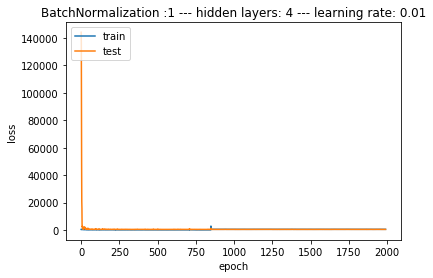

Train on 960 samples, validate on 241 samples
Epoch 1/2000
960/960 [==============================] - 5s 5ms/step - loss: 42375.5495 - val_loss: 151237.9322
Epoch 2/2000
960/960 [==============================] - 1s 1ms/step - loss: 9394.5423 - val_loss: 9857083.5726
Epoch 3/2000
960/960 [==============================] - 1s 1ms/step - loss: 2078.7021 - val_loss: 7945359.9813
Epoch 4/2000
960/960 [==============================] - 1s 1ms/step - loss: 1081.1327 - val_loss: 4876486.1141
Epoch 5/2000
960/960 [==============================] - 1s 1ms/step - loss: 1146.0570 - val_loss: 4610502.2573
Epoch 6/2000
960/960 [==============================] - 1s 1ms/step - loss: 950.7834 - val_loss: 2945863.1743
Epoch 7/2000
960/960 [==============================] - 1s 1ms/step - loss: 581.9316 - val_loss: 1958538.5005
Epoch 8/2000
960/960 [==============================] - 1s 1ms/step - loss: 513.1263 - val_loss: 1456295.5140
Epoch 9/2000
960/960 [==============================] - 1s 1ms/step -

960/960 [==============================] - 1s 1ms/step - loss: 196.3286 - val_loss: 712.4486
Epoch 77/2000
960/960 [==============================] - 1s 1ms/step - loss: 151.8888 - val_loss: 459.1831
Epoch 78/2000
960/960 [==============================] - 1s 1ms/step - loss: 147.6353 - val_loss: 514.0692
Epoch 79/2000
960/960 [==============================] - 1s 1ms/step - loss: 134.6171 - val_loss: 654.9474
Epoch 80/2000
960/960 [==============================] - 1s 1ms/step - loss: 120.1168 - val_loss: 557.5664
Epoch 81/2000
960/960 [==============================] - 1s 1ms/step - loss: 240.8465 - val_loss: 707.1278
Epoch 82/2000
960/960 [==============================] - 1s 1ms/step - loss: 368.6603 - val_loss: 684.7065
Epoch 83/2000
960/960 [==============================] - 1s 1ms/step - loss: 135.6269 - val_loss: 470.3560
Epoch 84/2000
960/960 [==============================] - 1s 1ms/step - loss: 112.5048 - val_loss: 538.8877
Epoch 85/2000
960/960 [============================

960/960 [==============================] - 1s 1ms/step - loss: 161.7267 - val_loss: 690.2002
Epoch 153/2000
960/960 [==============================] - 1s 1ms/step - loss: 112.2697 - val_loss: 496.2479
Epoch 154/2000
960/960 [==============================] - 1s 1ms/step - loss: 80.3648 - val_loss: 467.6214
Epoch 155/2000
960/960 [==============================] - 1s 1ms/step - loss: 113.9137 - val_loss: 652.7237
Epoch 156/2000
960/960 [==============================] - 1s 1ms/step - loss: 120.1680 - val_loss: 490.4622
Epoch 157/2000
960/960 [==============================] - 1s 1ms/step - loss: 184.2655 - val_loss: 850.8772
Epoch 158/2000
960/960 [==============================] - 1s 1ms/step - loss: 168.6696 - val_loss: 477.7624
Epoch 159/2000
960/960 [==============================] - 1s 1ms/step - loss: 163.9810 - val_loss: 736.9603
Epoch 160/2000
960/960 [==============================] - 1s 1ms/step - loss: 242.7219 - val_loss: 915.0388
Epoch 161/2000
960/960 [====================

960/960 [==============================] - 1s 1ms/step - loss: 104.7084 - val_loss: 452.3623
Epoch 229/2000
960/960 [==============================] - 1s 1ms/step - loss: 64.4979 - val_loss: 478.6537
Epoch 230/2000
960/960 [==============================] - 1s 1ms/step - loss: 71.9862 - val_loss: 467.0396
Epoch 231/2000
960/960 [==============================] - 1s 1ms/step - loss: 74.5500 - val_loss: 463.3062
Epoch 232/2000
960/960 [==============================] - 1s 1ms/step - loss: 128.0454 - val_loss: 486.9573
Epoch 233/2000
960/960 [==============================] - 1s 1ms/step - loss: 70.5705 - val_loss: 447.9113
Epoch 234/2000
960/960 [==============================] - 1s 1ms/step - loss: 67.0979 - val_loss: 457.1747
Epoch 235/2000
960/960 [==============================] - 1s 1ms/step - loss: 67.8056 - val_loss: 486.6429
Epoch 236/2000
960/960 [==============================] - 1s 1ms/step - loss: 53.4975 - val_loss: 457.8700
Epoch 237/2000
960/960 [==========================

960/960 [==============================] - 1s 1ms/step - loss: 61.5943 - val_loss: 443.6044
Epoch 305/2000
960/960 [==============================] - 1s 1ms/step - loss: 38.5492 - val_loss: 431.8251
Epoch 306/2000
960/960 [==============================] - 1s 1ms/step - loss: 44.5144 - val_loss: 450.7568
Epoch 307/2000
960/960 [==============================] - 1s 1ms/step - loss: 46.8255 - val_loss: 432.2537
Epoch 308/2000
960/960 [==============================] - 1s 1ms/step - loss: 49.8990 - val_loss: 448.2759
Epoch 309/2000
960/960 [==============================] - 1s 1ms/step - loss: 39.2563 - val_loss: 449.0594
Epoch 310/2000
960/960 [==============================] - 1s 1ms/step - loss: 64.4080 - val_loss: 455.1705
Epoch 311/2000
960/960 [==============================] - 1s 1ms/step - loss: 59.5327 - val_loss: 486.8507
Epoch 312/2000
960/960 [==============================] - 1s 1ms/step - loss: 95.0968 - val_loss: 493.0630
Epoch 313/2000
960/960 [============================

960/960 [==============================] - 1s 1ms/step - loss: 26.9874 - val_loss: 432.8799
Epoch 381/2000
960/960 [==============================] - 1s 1ms/step - loss: 25.1304 - val_loss: 412.0853
Epoch 382/2000
960/960 [==============================] - 1s 1ms/step - loss: 31.1853 - val_loss: 460.8832
Epoch 383/2000
960/960 [==============================] - 1s 1ms/step - loss: 31.8667 - val_loss: 420.9466
Epoch 384/2000
960/960 [==============================] - 1s 1ms/step - loss: 36.7323 - val_loss: 428.1643
Epoch 385/2000
960/960 [==============================] - 1s 1ms/step - loss: 25.6904 - val_loss: 428.8355
Epoch 386/2000
960/960 [==============================] - 1s 1ms/step - loss: 27.1692 - val_loss: 447.9416
Epoch 387/2000
960/960 [==============================] - 1s 1ms/step - loss: 31.4890 - val_loss: 422.8157
Epoch 388/2000
960/960 [==============================] - 1s 1ms/step - loss: 51.8925 - val_loss: 482.3969
Epoch 389/2000
960/960 [============================

960/960 [==============================] - 1s 1ms/step - loss: 31.6905 - val_loss: 430.7825
Epoch 457/2000
960/960 [==============================] - 1s 1ms/step - loss: 31.1507 - val_loss: 382.2935
Epoch 458/2000
960/960 [==============================] - 1s 1ms/step - loss: 27.7269 - val_loss: 421.5571
Epoch 459/2000
960/960 [==============================] - 1s 1ms/step - loss: 24.7885 - val_loss: 404.3607
Epoch 460/2000
960/960 [==============================] - 1s 1ms/step - loss: 29.1097 - val_loss: 414.2935
Epoch 461/2000
960/960 [==============================] - 1s 1ms/step - loss: 24.5594 - val_loss: 398.1535
Epoch 462/2000
960/960 [==============================] - 1s 1ms/step - loss: 26.2987 - val_loss: 426.0583
Epoch 463/2000
960/960 [==============================] - 1s 1ms/step - loss: 24.6289 - val_loss: 399.2372
Epoch 464/2000
960/960 [==============================] - 1s 1ms/step - loss: 29.0379 - val_loss: 464.6100
Epoch 465/2000
960/960 [============================

960/960 [==============================] - 1s 1ms/step - loss: 63.2819 - val_loss: 451.6581
Epoch 533/2000
960/960 [==============================] - 1s 1ms/step - loss: 51.5265 - val_loss: 381.6983
Epoch 534/2000
960/960 [==============================] - 1s 1ms/step - loss: 41.9864 - val_loss: 424.2226
Epoch 535/2000
960/960 [==============================] - 1s 1ms/step - loss: 35.1766 - val_loss: 403.5253
Epoch 536/2000
960/960 [==============================] - 1s 1ms/step - loss: 31.5478 - val_loss: 445.2427
Epoch 537/2000
960/960 [==============================] - 1s 1ms/step - loss: 37.7382 - val_loss: 401.1503
Epoch 538/2000
960/960 [==============================] - 1s 1ms/step - loss: 30.5080 - val_loss: 404.3283
Epoch 539/2000
960/960 [==============================] - 1s 1ms/step - loss: 32.5143 - val_loss: 421.9948
Epoch 540/2000
960/960 [==============================] - 1s 1ms/step - loss: 27.8813 - val_loss: 379.3355
Epoch 541/2000
960/960 [============================

960/960 [==============================] - 1s 1ms/step - loss: 37.3345 - val_loss: 419.1366
Epoch 609/2000
960/960 [==============================] - 1s 1ms/step - loss: 45.4124 - val_loss: 384.6833
Epoch 610/2000
960/960 [==============================] - 1s 1ms/step - loss: 47.5303 - val_loss: 473.7006
Epoch 611/2000
960/960 [==============================] - 1s 1ms/step - loss: 41.5442 - val_loss: 396.2446
Epoch 612/2000
960/960 [==============================] - 1s 1ms/step - loss: 31.6969 - val_loss: 399.4124
Epoch 613/2000
960/960 [==============================] - 1s 1ms/step - loss: 35.0895 - val_loss: 397.2107
Epoch 614/2000
960/960 [==============================] - 1s 1ms/step - loss: 39.2996 - val_loss: 376.6598
Epoch 615/2000
960/960 [==============================] - 1s 1ms/step - loss: 34.2448 - val_loss: 400.6422
Epoch 616/2000
960/960 [==============================] - 1s 1ms/step - loss: 25.8461 - val_loss: 403.7039
Epoch 617/2000
960/960 [============================

960/960 [==============================] - 1s 1ms/step - loss: 38.8039 - val_loss: 432.8682
Epoch 685/2000
960/960 [==============================] - 1s 1ms/step - loss: 42.3509 - val_loss: 408.6613
Epoch 686/2000
960/960 [==============================] - 1s 1ms/step - loss: 35.2746 - val_loss: 418.8819
Epoch 687/2000
960/960 [==============================] - 1s 1ms/step - loss: 36.2825 - val_loss: 498.3033
Epoch 688/2000
960/960 [==============================] - 1s 1ms/step - loss: 57.0243 - val_loss: 385.7024
Epoch 689/2000
960/960 [==============================] - 1s 1ms/step - loss: 48.7084 - val_loss: 387.3019
Epoch 690/2000
960/960 [==============================] - 1s 1ms/step - loss: 58.4919 - val_loss: 427.6408
Epoch 691/2000
960/960 [==============================] - 1s 1ms/step - loss: 79.5061 - val_loss: 448.6249
Epoch 692/2000
960/960 [==============================] - 1s 1ms/step - loss: 58.8305 - val_loss: 387.9562
Epoch 693/2000
960/960 [============================

960/960 [==============================] - 1s 1ms/step - loss: 36.4243 - val_loss: 385.0970
Epoch 761/2000
960/960 [==============================] - 1s 1ms/step - loss: 34.0808 - val_loss: 386.1243
Epoch 762/2000
960/960 [==============================] - 1s 1ms/step - loss: 440.9058 - val_loss: 379.8764
Epoch 763/2000
960/960 [==============================] - 1s 1ms/step - loss: 313.8517 - val_loss: 459.7704
Epoch 764/2000
960/960 [==============================] - 1s 1ms/step - loss: 356.9762 - val_loss: 372.0391
Epoch 765/2000
960/960 [==============================] - 1s 1ms/step - loss: 423.5703 - val_loss: 493.4244
Epoch 766/2000
960/960 [==============================] - 1s 1ms/step - loss: 498.2812 - val_loss: 484.2906
Epoch 767/2000
960/960 [==============================] - 1s 1ms/step - loss: 470.8379 - val_loss: 457.1814
Epoch 768/2000
960/960 [==============================] - 1s 1ms/step - loss: 494.9434 - val_loss: 404.2591
Epoch 769/2000
960/960 [=====================

Epoch 836/2000
960/960 [==============================] - 1s 1ms/step - loss: 507.9955 - val_loss: 467.3506
Epoch 837/2000
960/960 [==============================] - 1s 1ms/step - loss: 487.8920 - val_loss: 432.5455
Epoch 838/2000
960/960 [==============================] - 1s 1ms/step - loss: 472.1456 - val_loss: 410.7307
Epoch 839/2000
960/960 [==============================] - 1s 1ms/step - loss: 467.9881 - val_loss: 402.2623
Epoch 840/2000
960/960 [==============================] - 1s 1ms/step - loss: 483.7763 - val_loss: 402.4363
Epoch 841/2000
960/960 [==============================] - 1s 1ms/step - loss: 497.5067 - val_loss: 424.1541
Epoch 842/2000
960/960 [==============================] - 1s 1ms/step - loss: 466.6846 - val_loss: 450.9400
Epoch 843/2000
960/960 [==============================] - 1s 1ms/step - loss: 479.9571 - val_loss: 406.9429
Epoch 844/2000
960/960 [==============================] - 1s 1ms/step - loss: 465.8342 - val_loss: 469.0114
Epoch 845/2000
960/960 [====

Epoch 912/2000
960/960 [==============================] - 1s 1ms/step - loss: 458.6034 - val_loss: 450.0439
Epoch 913/2000
960/960 [==============================] - 1s 1ms/step - loss: 484.4444 - val_loss: 403.5363
Epoch 914/2000
960/960 [==============================] - 1s 1ms/step - loss: 465.8869 - val_loss: 410.2757
Epoch 915/2000
960/960 [==============================] - 1s 1ms/step - loss: 494.3560 - val_loss: 402.3041
Epoch 916/2000
960/960 [==============================] - 1s 1ms/step - loss: 468.2335 - val_loss: 402.2790
Epoch 917/2000
960/960 [==============================] - 1s 1ms/step - loss: 475.9739 - val_loss: 403.5032
Epoch 918/2000
960/960 [==============================] - 1s 1ms/step - loss: 478.8856 - val_loss: 407.1590
Epoch 919/2000
960/960 [==============================] - 1s 1ms/step - loss: 459.4809 - val_loss: 414.7466
Epoch 920/2000
960/960 [==============================] - 1s 1ms/step - loss: 468.0816 - val_loss: 428.6689
Epoch 921/2000
960/960 [====

Epoch 988/2000
960/960 [==============================] - 1s 1ms/step - loss: 484.3753 - val_loss: 405.2605
Epoch 989/2000
960/960 [==============================] - 1s 1ms/step - loss: 479.0177 - val_loss: 453.7005
Epoch 990/2000
960/960 [==============================] - 1s 1ms/step - loss: 470.2029 - val_loss: 402.4535
Epoch 991/2000
960/960 [==============================] - 1s 1ms/step - loss: 463.8276 - val_loss: 409.3201
Epoch 992/2000
960/960 [==============================] - 1s 1ms/step - loss: 465.9879 - val_loss: 416.0367
Epoch 993/2000
960/960 [==============================] - 1s 1ms/step - loss: 480.0602 - val_loss: 416.6026
Epoch 994/2000
960/960 [==============================] - 1s 1ms/step - loss: 465.1074 - val_loss: 402.3002
Epoch 995/2000
960/960 [==============================] - 1s 1ms/step - loss: 482.3741 - val_loss: 405.7993
Epoch 996/2000
960/960 [==============================] - 1s 1ms/step - loss: 474.3505 - val_loss: 456.7179
Epoch 997/2000
960/960 [====

960/960 [==============================] - 1s 1ms/step - loss: 466.2889 - val_loss: 404.2329
Epoch 1064/2000
960/960 [==============================] - 1s 1ms/step - loss: 462.8697 - val_loss: 408.4975
Epoch 1065/2000
960/960 [==============================] - 1s 1ms/step - loss: 462.5175 - val_loss: 422.0105
Epoch 1066/2000
960/960 [==============================] - 1s 1ms/step - loss: 471.0457 - val_loss: 412.8126
Epoch 1067/2000
960/960 [==============================] - 1s 1ms/step - loss: 478.3954 - val_loss: 407.6415
Epoch 1068/2000
960/960 [==============================] - 1s 1ms/step - loss: 466.5556 - val_loss: 439.3684
Epoch 1069/2000
960/960 [==============================] - 1s 1ms/step - loss: 478.1776 - val_loss: 407.9761
Epoch 1070/2000
960/960 [==============================] - 1s 1ms/step - loss: 470.4638 - val_loss: 427.7710
Epoch 1071/2000
960/960 [==============================] - 1s 1ms/step - loss: 463.1581 - val_loss: 404.7464
Epoch 1072/2000
960/960 [==========

960/960 [==============================] - 1s 1ms/step - loss: 473.2404 - val_loss: 454.0687
Epoch 1139/2000
960/960 [==============================] - 1s 1ms/step - loss: 476.1494 - val_loss: 405.6063
Epoch 1140/2000
960/960 [==============================] - 1s 1ms/step - loss: 484.0123 - val_loss: 429.6749
Epoch 1141/2000
960/960 [==============================] - 1s 1ms/step - loss: 489.3923 - val_loss: 406.5017
Epoch 1142/2000
960/960 [==============================] - 1s 1ms/step - loss: 492.8664 - val_loss: 411.6200
Epoch 1143/2000
960/960 [==============================] - 1s 1ms/step - loss: 469.1367 - val_loss: 413.0595
Epoch 1144/2000
960/960 [==============================] - 1s 1ms/step - loss: 464.2390 - val_loss: 454.3088
Epoch 1145/2000
960/960 [==============================] - 1s 1ms/step - loss: 479.8202 - val_loss: 403.0894
Epoch 1146/2000
960/960 [==============================] - 1s 1ms/step - loss: 480.7670 - val_loss: 404.9739
Epoch 1147/2000
960/960 [==========

960/960 [==============================] - 1s 1ms/step - loss: 463.1810 - val_loss: 403.6822
Epoch 1214/2000
960/960 [==============================] - 1s 1ms/step - loss: 464.6160 - val_loss: 459.4315
Epoch 1215/2000
960/960 [==============================] - 1s 1ms/step - loss: 467.8696 - val_loss: 420.1362
Epoch 1216/2000
960/960 [==============================] - 1s 1ms/step - loss: 461.6651 - val_loss: 450.8370
Epoch 1217/2000
960/960 [==============================] - 1s 1ms/step - loss: 478.7925 - val_loss: 403.2392
Epoch 1218/2000
960/960 [==============================] - 1s 1ms/step - loss: 460.9493 - val_loss: 412.1674
Epoch 1219/2000
960/960 [==============================] - 1s 1ms/step - loss: 466.4697 - val_loss: 432.9059
Epoch 1220/2000
960/960 [==============================] - 1s 1ms/step - loss: 472.0406 - val_loss: 405.4213
Epoch 1221/2000
960/960 [==============================] - 1s 1ms/step - loss: 464.1657 - val_loss: 402.3132
Epoch 1222/2000
960/960 [==========

960/960 [==============================] - 1s 1ms/step - loss: 460.3868 - val_loss: 424.2363
Epoch 1289/2000
960/960 [==============================] - 1s 1ms/step - loss: 469.9144 - val_loss: 417.4332
Epoch 1290/2000
960/960 [==============================] - 1s 1ms/step - loss: 467.5760 - val_loss: 419.5092
Epoch 1291/2000
960/960 [==============================] - 1s 1ms/step - loss: 466.0463 - val_loss: 430.0492
Epoch 1292/2000
960/960 [==============================] - 1s 1ms/step - loss: 467.3312 - val_loss: 411.9117
Epoch 1293/2000
960/960 [==============================] - 1s 1ms/step - loss: 468.1795 - val_loss: 409.1394
Epoch 1294/2000
960/960 [==============================] - 1s 1ms/step - loss: 470.2790 - val_loss: 404.4318
Epoch 1295/2000
960/960 [==============================] - 1s 1ms/step - loss: 463.9660 - val_loss: 403.8367
Epoch 1296/2000
960/960 [==============================] - 1s 1ms/step - loss: 463.2288 - val_loss: 402.4196
Epoch 1297/2000
960/960 [==========

960/960 [==============================] - 1s 1ms/step - loss: 468.6293 - val_loss: 404.8531
Epoch 1364/2000
960/960 [==============================] - 1s 1ms/step - loss: 461.0437 - val_loss: 403.0186
Epoch 1365/2000
960/960 [==============================] - 1s 1ms/step - loss: 466.1720 - val_loss: 403.3258
Epoch 1366/2000
960/960 [==============================] - 1s 1ms/step - loss: 471.7949 - val_loss: 432.1489
Epoch 1367/2000
960/960 [==============================] - 1s 1ms/step - loss: 485.4995 - val_loss: 474.1520
Epoch 1368/2000
960/960 [==============================] - 1s 1ms/step - loss: 512.1131 - val_loss: 404.9120
Epoch 1369/2000
960/960 [==============================] - 1s 1ms/step - loss: 465.3542 - val_loss: 405.8549
Epoch 1370/2000
960/960 [==============================] - 1s 1ms/step - loss: 462.2457 - val_loss: 413.0420
Epoch 1371/2000
960/960 [==============================] - 1s 1ms/step - loss: 468.9903 - val_loss: 426.8705
Epoch 1372/2000
960/960 [==========

960/960 [==============================] - 1s 1ms/step - loss: 465.1006 - val_loss: 428.3187
Epoch 1439/2000
960/960 [==============================] - 1s 1ms/step - loss: 473.3201 - val_loss: 421.4136
Epoch 1440/2000
960/960 [==============================] - 1s 1ms/step - loss: 473.5319 - val_loss: 410.7203
Epoch 1441/2000
960/960 [==============================] - 1s 1ms/step - loss: 466.8066 - val_loss: 402.4657
Epoch 1442/2000
960/960 [==============================] - 1s 1ms/step - loss: 461.8383 - val_loss: 403.8942
Epoch 1443/2000
960/960 [==============================] - 1s 1ms/step - loss: 462.8401 - val_loss: 403.3533
Epoch 1444/2000
960/960 [==============================] - 1s 1ms/step - loss: 469.2913 - val_loss: 423.3175
Epoch 1445/2000
960/960 [==============================] - 1s 1ms/step - loss: 469.7578 - val_loss: 409.2148
Epoch 1446/2000
960/960 [==============================] - 1s 1ms/step - loss: 461.7920 - val_loss: 402.4949
Epoch 1447/2000
960/960 [==========

960/960 [==============================] - 1s 1ms/step - loss: 462.2981 - val_loss: 402.5811
Epoch 1514/2000
960/960 [==============================] - 1s 1ms/step - loss: 466.4530 - val_loss: 402.3252
Epoch 1515/2000
960/960 [==============================] - 1s 1ms/step - loss: 464.2583 - val_loss: 412.8172
Epoch 1516/2000
960/960 [==============================] - 1s 1ms/step - loss: 462.4938 - val_loss: 403.0319
Epoch 1517/2000
960/960 [==============================] - 1s 1ms/step - loss: 461.9331 - val_loss: 402.3632
Epoch 1518/2000
960/960 [==============================] - 1s 1ms/step - loss: 460.2567 - val_loss: 412.8779
Epoch 1519/2000
960/960 [==============================] - 1s 1ms/step - loss: 468.7245 - val_loss: 416.8625
Epoch 1520/2000
960/960 [==============================] - 1s 1ms/step - loss: 475.4870 - val_loss: 466.4765
Epoch 1521/2000
960/960 [==============================] - 1s 1ms/step - loss: 471.4440 - val_loss: 424.9685
Epoch 1522/2000
960/960 [==========

960/960 [==============================] - 1s 1ms/step - loss: 459.3115 - val_loss: 406.0103
Epoch 1589/2000
960/960 [==============================] - 1s 1ms/step - loss: 459.9978 - val_loss: 404.4612
Epoch 1590/2000
960/960 [==============================] - 1s 1ms/step - loss: 463.8295 - val_loss: 402.3366
Epoch 1591/2000
960/960 [==============================] - 1s 1ms/step - loss: 460.8268 - val_loss: 416.3699
Epoch 1592/2000
960/960 [==============================] - 1s 1ms/step - loss: 463.7680 - val_loss: 416.6308
Epoch 1593/2000
960/960 [==============================] - 1s 1ms/step - loss: 477.8973 - val_loss: 413.5639
Epoch 1594/2000
960/960 [==============================] - 1s 1ms/step - loss: 460.4981 - val_loss: 406.8196
Epoch 1595/2000
960/960 [==============================] - 1s 1ms/step - loss: 461.5631 - val_loss: 405.3299
Epoch 1596/2000
960/960 [==============================] - 1s 1ms/step - loss: 463.8922 - val_loss: 414.5269
Epoch 1597/2000
960/960 [==========

960/960 [==============================] - 1s 1ms/step - loss: 458.9194 - val_loss: 402.2766
Epoch 1664/2000
960/960 [==============================] - 1s 1ms/step - loss: 462.9628 - val_loss: 403.0930
Epoch 1665/2000
960/960 [==============================] - 1s 1ms/step - loss: 463.9929 - val_loss: 402.6087
Epoch 1666/2000
960/960 [==============================] - 1s 1ms/step - loss: 469.4817 - val_loss: 403.4196
Epoch 1667/2000
960/960 [==============================] - 1s 1ms/step - loss: 463.3532 - val_loss: 429.2271
Epoch 1668/2000
960/960 [==============================] - 1s 1ms/step - loss: 469.3320 - val_loss: 402.4059
Epoch 1669/2000
960/960 [==============================] - 1s 1ms/step - loss: 465.2537 - val_loss: 404.0529
Epoch 1670/2000
960/960 [==============================] - 1s 1ms/step - loss: 461.6381 - val_loss: 402.3882
Epoch 1671/2000
960/960 [==============================] - 1s 1ms/step - loss: 462.6204 - val_loss: 406.4149
Epoch 1672/2000
960/960 [==========

960/960 [==============================] - 1s 1ms/step - loss: 469.0239 - val_loss: 439.3052
Epoch 1739/2000
960/960 [==============================] - 1s 1ms/step - loss: 471.6010 - val_loss: 408.9255
Epoch 1740/2000
960/960 [==============================] - 1s 1ms/step - loss: 464.7753 - val_loss: 402.2603
Epoch 1741/2000
960/960 [==============================] - 1s 1ms/step - loss: 462.5803 - val_loss: 405.3484
Epoch 1742/2000
960/960 [==============================] - 1s 1ms/step - loss: 459.8172 - val_loss: 404.4886
Epoch 1743/2000
960/960 [==============================] - 1s 1ms/step - loss: 461.2525 - val_loss: 402.3401
Epoch 1744/2000
960/960 [==============================] - 1s 1ms/step - loss: 466.1842 - val_loss: 402.4900
Epoch 1745/2000
960/960 [==============================] - 1s 1ms/step - loss: 458.8782 - val_loss: 436.6093
Epoch 1746/2000
960/960 [==============================] - 1s 1ms/step - loss: 464.8973 - val_loss: 402.2797
Epoch 1747/2000
960/960 [==========

960/960 [==============================] - 1s 1ms/step - loss: 463.6920 - val_loss: 412.0569
Epoch 1814/2000
960/960 [==============================] - 1s 1ms/step - loss: 459.5404 - val_loss: 410.7785
Epoch 1815/2000
960/960 [==============================] - 1s 1ms/step - loss: 460.7888 - val_loss: 404.7050
Epoch 1816/2000
960/960 [==============================] - 1s 1ms/step - loss: 464.1373 - val_loss: 402.8352
Epoch 1817/2000
960/960 [==============================] - 1s 1ms/step - loss: 462.5712 - val_loss: 431.4057
Epoch 1818/2000
960/960 [==============================] - 1s 1ms/step - loss: 466.9452 - val_loss: 462.9352
Epoch 1819/2000
960/960 [==============================] - 1s 1ms/step - loss: 466.3354 - val_loss: 402.8193
Epoch 1820/2000
960/960 [==============================] - 1s 1ms/step - loss: 463.1865 - val_loss: 402.5129
Epoch 1821/2000
960/960 [==============================] - 1s 1ms/step - loss: 460.6890 - val_loss: 404.4078
Epoch 1822/2000
960/960 [==========

960/960 [==============================] - 1s 1ms/step - loss: 461.2669 - val_loss: 413.8130
Epoch 1889/2000
960/960 [==============================] - 1s 1ms/step - loss: 466.5609 - val_loss: 410.1514
Epoch 1890/2000
960/960 [==============================] - 1s 1ms/step - loss: 488.4450 - val_loss: 404.8672
Epoch 1891/2000
960/960 [==============================] - 1s 1ms/step - loss: 466.1271 - val_loss: 403.6093
Epoch 1892/2000
960/960 [==============================] - 1s 1ms/step - loss: 465.5276 - val_loss: 406.7497
Epoch 1893/2000
960/960 [==============================] - 1s 1ms/step - loss: 468.6409 - val_loss: 427.6558
Epoch 1894/2000
960/960 [==============================] - 1s 1ms/step - loss: 464.6496 - val_loss: 409.5663
Epoch 1895/2000
960/960 [==============================] - 1s 1ms/step - loss: 463.5833 - val_loss: 408.3914
Epoch 1896/2000
960/960 [==============================] - 1s 1ms/step - loss: 476.7522 - val_loss: 402.3218
Epoch 1897/2000
960/960 [==========

960/960 [==============================] - 1s 1ms/step - loss: 465.8996 - val_loss: 436.5592
Epoch 1964/2000
960/960 [==============================] - 1s 1ms/step - loss: 463.2087 - val_loss: 423.3901
Epoch 1965/2000
960/960 [==============================] - 1s 1ms/step - loss: 463.7913 - val_loss: 412.9791
Epoch 1966/2000
960/960 [==============================] - 1s 1ms/step - loss: 464.0279 - val_loss: 417.1212
Epoch 1967/2000
960/960 [==============================] - 1s 1ms/step - loss: 461.6290 - val_loss: 403.1774
Epoch 1968/2000
960/960 [==============================] - 1s 1ms/step - loss: 462.0873 - val_loss: 403.6184
Epoch 1969/2000
960/960 [==============================] - 1s 1ms/step - loss: 463.3141 - val_loss: 402.9971
Epoch 1970/2000
960/960 [==============================] - 1s 1ms/step - loss: 464.2021 - val_loss: 404.8623
Epoch 1971/2000
960/960 [==============================] - 1s 1ms/step - loss: 463.7196 - val_loss: 429.3422
Epoch 1972/2000
960/960 [==========

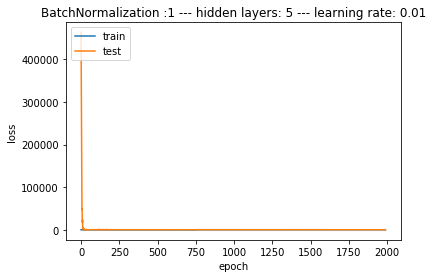

Train on 960 samples, validate on 241 samples
Epoch 1/2000
960/960 [==============================] - 5s 5ms/step - loss: 57381.8523 - val_loss: 7775.1656
Epoch 2/2000
960/960 [==============================] - 1s 1ms/step - loss: 6293.7179 - val_loss: 3525.7943
Epoch 3/2000
960/960 [==============================] - 1s 1ms/step - loss: 1353.9907 - val_loss: 624.0880
Epoch 4/2000
960/960 [==============================] - 1s 1ms/step - loss: 640.6701 - val_loss: 402.5262
Epoch 5/2000
960/960 [==============================] - 1s 1ms/step - loss: 476.4611 - val_loss: 402.6064
Epoch 6/2000
960/960 [==============================] - 1s 1ms/step - loss: 466.7968 - val_loss: 409.2886
Epoch 7/2000
960/960 [==============================] - 1s 1ms/step - loss: 474.6976 - val_loss: 422.9259
Epoch 8/2000
960/960 [==============================] - 1s 1ms/step - loss: 549.7294 - val_loss: 408.8708
Epoch 9/2000
960/960 [==============================] - 1s 1ms/step - loss: 584.3190 - val_loss: 634

960/960 [==============================] - 1s 1ms/step - loss: 474.1165 - val_loss: 403.2642
Epoch 78/2000
960/960 [==============================] - 1s 1ms/step - loss: 487.6628 - val_loss: 413.3958
Epoch 79/2000
960/960 [==============================] - 1s 1ms/step - loss: 505.4477 - val_loss: 583.2387
Epoch 80/2000
960/960 [==============================] - 1s 1ms/step - loss: 535.1426 - val_loss: 404.1556
Epoch 81/2000
960/960 [==============================] - 1s 1ms/step - loss: 478.8352 - val_loss: 409.4107
Epoch 82/2000
960/960 [==============================] - 1s 1ms/step - loss: 516.2302 - val_loss: 424.3078
Epoch 83/2000
960/960 [==============================] - 1s 1ms/step - loss: 487.2578 - val_loss: 402.4011
Epoch 84/2000
960/960 [==============================] - 1s 1ms/step - loss: 484.1193 - val_loss: 402.6104
Epoch 85/2000
960/960 [==============================] - 1s 1ms/step - loss: 474.5632 - val_loss: 402.2598
Epoch 86/2000
960/960 [============================

960/960 [==============================] - 1s 1ms/step - loss: 471.6753 - val_loss: 433.1515
Epoch 154/2000
960/960 [==============================] - 1s 1ms/step - loss: 477.0186 - val_loss: 419.2155
Epoch 155/2000
960/960 [==============================] - 1s 1ms/step - loss: 471.0548 - val_loss: 405.9654
Epoch 156/2000
960/960 [==============================] - 1s 1ms/step - loss: 504.7801 - val_loss: 418.1481
Epoch 157/2000
960/960 [==============================] - 1s 1ms/step - loss: 467.7674 - val_loss: 420.0258
Epoch 158/2000
960/960 [==============================] - 1s 1ms/step - loss: 480.8638 - val_loss: 409.2906
Epoch 159/2000
960/960 [==============================] - 1s 1ms/step - loss: 474.2736 - val_loss: 449.3926
Epoch 160/2000
960/960 [==============================] - 1s 1ms/step - loss: 496.4759 - val_loss: 509.2098
Epoch 161/2000
960/960 [==============================] - 1s 1ms/step - loss: 485.2757 - val_loss: 471.7346
Epoch 162/2000
960/960 [===================

Epoch 229/2000
960/960 [==============================] - 1s 1ms/step - loss: 512.0693 - val_loss: 515.6848
Epoch 230/2000
960/960 [==============================] - 1s 1ms/step - loss: 502.4433 - val_loss: 406.5508
Epoch 231/2000
960/960 [==============================] - 1s 1ms/step - loss: 485.8067 - val_loss: 447.8383
Epoch 232/2000
960/960 [==============================] - 1s 1ms/step - loss: 480.7144 - val_loss: 402.3746
Epoch 233/2000
960/960 [==============================] - 1s 1ms/step - loss: 510.3190 - val_loss: 426.7732
Epoch 234/2000
960/960 [==============================] - 1s 1ms/step - loss: 501.8568 - val_loss: 449.9954
Epoch 235/2000
960/960 [==============================] - 1s 1ms/step - loss: 529.1411 - val_loss: 550.0295
Epoch 236/2000
960/960 [==============================] - 1s 1ms/step - loss: 493.4153 - val_loss: 411.2080
Epoch 237/2000
960/960 [==============================] - 1s 1ms/step - loss: 462.1911 - val_loss: 450.4560
Epoch 238/2000
960/960 [====

Epoch 305/2000
960/960 [==============================] - 1s 1ms/step - loss: 465.3489 - val_loss: 402.4898
Epoch 306/2000
960/960 [==============================] - 1s 1ms/step - loss: 471.1077 - val_loss: 429.3611
Epoch 307/2000
960/960 [==============================] - 1s 1ms/step - loss: 473.0350 - val_loss: 502.5105
Epoch 308/2000
960/960 [==============================] - 1s 1ms/step - loss: 471.8004 - val_loss: 405.2252
Epoch 309/2000
960/960 [==============================] - 1s 1ms/step - loss: 492.0427 - val_loss: 406.8619
Epoch 310/2000
960/960 [==============================] - 1s 1ms/step - loss: 529.9864 - val_loss: 471.0897
Epoch 311/2000
960/960 [==============================] - 1s 1ms/step - loss: 502.8222 - val_loss: 403.2861
Epoch 312/2000
960/960 [==============================] - 1s 1ms/step - loss: 470.4428 - val_loss: 411.0533
Epoch 313/2000
960/960 [==============================] - 1s 1ms/step - loss: 477.9353 - val_loss: 413.0030
Epoch 314/2000
960/960 [====

960/960 [==============================] - 1s 1ms/step - loss: 488.8767 - val_loss: 435.8929
Epoch 381/2000
960/960 [==============================] - 1s 1ms/step - loss: 524.9696 - val_loss: 409.4018
Epoch 382/2000
960/960 [==============================] - 1s 1ms/step - loss: 519.8637 - val_loss: 420.3371
Epoch 383/2000
960/960 [==============================] - 1s 1ms/step - loss: 492.3218 - val_loss: 490.3888
Epoch 384/2000
960/960 [==============================] - 1s 1ms/step - loss: 529.0207 - val_loss: 476.3287
Epoch 385/2000
960/960 [==============================] - 1s 1ms/step - loss: 565.3505 - val_loss: 582.9181
Epoch 386/2000
960/960 [==============================] - 1s 1ms/step - loss: 607.8645 - val_loss: 461.6338
Epoch 387/2000
960/960 [==============================] - 1s 1ms/step - loss: 523.2668 - val_loss: 410.4229
Epoch 388/2000
960/960 [==============================] - 1s 1ms/step - loss: 494.5798 - val_loss: 407.0824
Epoch 389/2000
960/960 [===================

Epoch 456/2000
960/960 [==============================] - 1s 1ms/step - loss: 475.9645 - val_loss: 404.7245
Epoch 457/2000
960/960 [==============================] - 1s 1ms/step - loss: 482.8353 - val_loss: 512.4506
Epoch 458/2000
960/960 [==============================] - 1s 1ms/step - loss: 506.6077 - val_loss: 497.3866
Epoch 459/2000
960/960 [==============================] - 1s 1ms/step - loss: 489.8503 - val_loss: 408.7593
Epoch 460/2000
960/960 [==============================] - 1s 1ms/step - loss: 471.4322 - val_loss: 409.6479
Epoch 461/2000
960/960 [==============================] - 1s 1ms/step - loss: 474.9075 - val_loss: 407.6228
Epoch 462/2000
960/960 [==============================] - 1s 1ms/step - loss: 465.5626 - val_loss: 434.2344
Epoch 463/2000
960/960 [==============================] - 1s 1ms/step - loss: 469.1438 - val_loss: 402.6674
Epoch 464/2000
960/960 [==============================] - 1s 1ms/step - loss: 464.6439 - val_loss: 402.4723
Epoch 465/2000
960/960 [====

Epoch 532/2000
960/960 [==============================] - 1s 1ms/step - loss: 538.4499 - val_loss: 442.5621
Epoch 533/2000
960/960 [==============================] - 1s 1ms/step - loss: 499.3525 - val_loss: 412.3265
Epoch 534/2000
960/960 [==============================] - 1s 1ms/step - loss: 461.1258 - val_loss: 451.3630
Epoch 535/2000
960/960 [==============================] - 1s 1ms/step - loss: 468.9734 - val_loss: 407.4633
Epoch 536/2000
960/960 [==============================] - 1s 1ms/step - loss: 468.3725 - val_loss: 423.6920
Epoch 537/2000
960/960 [==============================] - 1s 1ms/step - loss: 461.6267 - val_loss: 403.6671
Epoch 538/2000
960/960 [==============================] - 1s 1ms/step - loss: 477.0861 - val_loss: 422.3431
Epoch 539/2000
960/960 [==============================] - 1s 1ms/step - loss: 478.9079 - val_loss: 402.9606
Epoch 540/2000
960/960 [==============================] - 1s 1ms/step - loss: 468.8355 - val_loss: 557.8320
Epoch 541/2000
960/960 [====

Epoch 608/2000
960/960 [==============================] - 1s 1ms/step - loss: 469.5400 - val_loss: 440.0782
Epoch 609/2000
960/960 [==============================] - 1s 1ms/step - loss: 454.8483 - val_loss: 407.7606
Epoch 610/2000
960/960 [==============================] - 1s 1ms/step - loss: 465.3202 - val_loss: 430.1063
Epoch 611/2000
960/960 [==============================] - 1s 1ms/step - loss: 473.5760 - val_loss: 428.9286
Epoch 612/2000
960/960 [==============================] - 1s 1ms/step - loss: 486.4444 - val_loss: 414.3621
Epoch 613/2000
960/960 [==============================] - 1s 1ms/step - loss: 508.8065 - val_loss: 475.0553
Epoch 614/2000
960/960 [==============================] - 1s 1ms/step - loss: 477.8030 - val_loss: 418.2421
Epoch 615/2000
960/960 [==============================] - 1s 1ms/step - loss: 476.4924 - val_loss: 417.3484
Epoch 616/2000
960/960 [==============================] - 1s 1ms/step - loss: 470.5469 - val_loss: 444.0794
Epoch 617/2000
960/960 [====

960/960 [==============================] - 1s 1ms/step - loss: 480.2702 - val_loss: 431.7259
Epoch 684/2000
960/960 [==============================] - 1s 1ms/step - loss: 471.9674 - val_loss: 405.0993
Epoch 685/2000
960/960 [==============================] - 1s 1ms/step - loss: 467.7062 - val_loss: 415.3999
Epoch 686/2000
960/960 [==============================] - 1s 1ms/step - loss: 474.4066 - val_loss: 405.5201
Epoch 687/2000
960/960 [==============================] - 1s 1ms/step - loss: 467.1328 - val_loss: 403.4989
Epoch 688/2000
960/960 [==============================] - 1s 1ms/step - loss: 470.5540 - val_loss: 411.0059
Epoch 689/2000
960/960 [==============================] - 1s 1ms/step - loss: 469.4586 - val_loss: 410.6364
Epoch 690/2000
960/960 [==============================] - 1s 1ms/step - loss: 462.8229 - val_loss: 402.4088
Epoch 691/2000
960/960 [==============================] - 1s 1ms/step - loss: 459.8924 - val_loss: 402.3006
Epoch 692/2000
960/960 [===================

Epoch 759/2000
960/960 [==============================] - 1s 1ms/step - loss: 481.1110 - val_loss: 409.2292
Epoch 760/2000
960/960 [==============================] - 1s 1ms/step - loss: 471.9009 - val_loss: 414.6643
Epoch 761/2000
960/960 [==============================] - 1s 1ms/step - loss: 472.7211 - val_loss: 404.7334
Epoch 762/2000
960/960 [==============================] - 1s 1ms/step - loss: 461.1779 - val_loss: 402.2613
Epoch 763/2000
960/960 [==============================] - 1s 1ms/step - loss: 462.4768 - val_loss: 402.9043
Epoch 764/2000
960/960 [==============================] - 1s 1ms/step - loss: 466.6352 - val_loss: 404.0217
Epoch 765/2000
960/960 [==============================] - 1s 1ms/step - loss: 467.8249 - val_loss: 402.2619
Epoch 766/2000
960/960 [==============================] - 1s 1ms/step - loss: 463.3387 - val_loss: 403.6945
Epoch 767/2000
960/960 [==============================] - 1s 1ms/step - loss: 476.2173 - val_loss: 463.5684
Epoch 768/2000
960/960 [====

960/960 [==============================] - 1s 1ms/step - loss: 471.3693 - val_loss: 410.4198
Epoch 835/2000
960/960 [==============================] - 1s 1ms/step - loss: 463.3410 - val_loss: 406.9400
Epoch 836/2000
960/960 [==============================] - 1s 1ms/step - loss: 471.0362 - val_loss: 425.7449
Epoch 837/2000
960/960 [==============================] - 1s 1ms/step - loss: 469.2000 - val_loss: 450.6430
Epoch 838/2000
960/960 [==============================] - 1s 1ms/step - loss: 460.2831 - val_loss: 416.5305
Epoch 839/2000
960/960 [==============================] - 1s 1ms/step - loss: 462.7062 - val_loss: 405.0306
Epoch 840/2000
960/960 [==============================] - 1s 1ms/step - loss: 461.9605 - val_loss: 446.2642
Epoch 841/2000
960/960 [==============================] - 1s 1ms/step - loss: 465.5716 - val_loss: 404.0548
Epoch 842/2000
960/960 [==============================] - 1s 1ms/step - loss: 476.5738 - val_loss: 407.4468
Epoch 843/2000
960/960 [===================

Epoch 910/2000
960/960 [==============================] - 1s 1ms/step - loss: 476.7129 - val_loss: 509.4043
Epoch 911/2000
960/960 [==============================] - 1s 1ms/step - loss: 477.4625 - val_loss: 405.5163
Epoch 912/2000
960/960 [==============================] - 1s 1ms/step - loss: 466.5483 - val_loss: 403.8844
Epoch 913/2000
960/960 [==============================] - 1s 1ms/step - loss: 462.0120 - val_loss: 403.8243
Epoch 914/2000
960/960 [==============================] - 1s 1ms/step - loss: 465.6344 - val_loss: 405.3173
Epoch 915/2000
960/960 [==============================] - 1s 1ms/step - loss: 470.5457 - val_loss: 418.0950
Epoch 916/2000
960/960 [==============================] - 1s 1ms/step - loss: 460.8163 - val_loss: 404.9883
Epoch 917/2000
960/960 [==============================] - 1s 1ms/step - loss: 460.7573 - val_loss: 405.7766
Epoch 918/2000
960/960 [==============================] - 1s 1ms/step - loss: 463.4313 - val_loss: 403.4486
Epoch 919/2000
960/960 [====

Epoch 986/2000
960/960 [==============================] - 1s 1ms/step - loss: 461.5741 - val_loss: 412.3106
Epoch 987/2000
960/960 [==============================] - 1s 1ms/step - loss: 464.6581 - val_loss: 431.2695
Epoch 988/2000
960/960 [==============================] - 1s 1ms/step - loss: 471.8983 - val_loss: 402.3062
Epoch 989/2000
960/960 [==============================] - 1s 1ms/step - loss: 459.9300 - val_loss: 404.5936
Epoch 990/2000
960/960 [==============================] - 1s 1ms/step - loss: 462.3004 - val_loss: 409.3952
Epoch 991/2000
960/960 [==============================] - 1s 1ms/step - loss: 463.3623 - val_loss: 408.6899
Epoch 992/2000
960/960 [==============================] - 1s 1ms/step - loss: 469.2620 - val_loss: 410.1657
Epoch 993/2000
960/960 [==============================] - 1s 1ms/step - loss: 467.8543 - val_loss: 410.7483
Epoch 994/2000
960/960 [==============================] - 1s 1ms/step - loss: 463.7934 - val_loss: 430.7487
Epoch 995/2000
960/960 [====

960/960 [==============================] - 1s 1ms/step - loss: 460.4168 - val_loss: 407.1162
Epoch 1062/2000
960/960 [==============================] - 1s 1ms/step - loss: 466.1353 - val_loss: 419.0172
Epoch 1063/2000
960/960 [==============================] - 1s 1ms/step - loss: 472.6036 - val_loss: 415.5803
Epoch 1064/2000
960/960 [==============================] - 1s 1ms/step - loss: 463.1056 - val_loss: 403.1185
Epoch 1065/2000
960/960 [==============================] - 1s 1ms/step - loss: 475.7889 - val_loss: 408.4991
Epoch 1066/2000
960/960 [==============================] - 1s 1ms/step - loss: 477.5010 - val_loss: 510.5699
Epoch 1067/2000
960/960 [==============================] - 1s 1ms/step - loss: 484.6840 - val_loss: 402.9318
Epoch 1068/2000
960/960 [==============================] - 1s 1ms/step - loss: 461.8040 - val_loss: 419.1004
Epoch 1069/2000
960/960 [==============================] - 1s 1ms/step - loss: 474.2581 - val_loss: 417.7877
Epoch 1070/2000
960/960 [==========

960/960 [==============================] - 1s 1ms/step - loss: 459.7028 - val_loss: 427.1519
Epoch 1137/2000
960/960 [==============================] - 1s 1ms/step - loss: 465.8783 - val_loss: 402.6337
Epoch 1138/2000
960/960 [==============================] - 1s 1ms/step - loss: 468.2026 - val_loss: 421.5538
Epoch 1139/2000
960/960 [==============================] - 1s 1ms/step - loss: 464.1382 - val_loss: 405.9553
Epoch 1140/2000
960/960 [==============================] - 1s 1ms/step - loss: 472.9898 - val_loss: 404.6382
Epoch 1141/2000
960/960 [==============================] - 1s 1ms/step - loss: 465.3615 - val_loss: 413.3400
Epoch 1142/2000
960/960 [==============================] - 1s 1ms/step - loss: 462.7306 - val_loss: 407.7951
Epoch 1143/2000
960/960 [==============================] - 1s 1ms/step - loss: 460.8062 - val_loss: 402.3905
Epoch 1144/2000
960/960 [==============================] - 1s 1ms/step - loss: 470.5029 - val_loss: 419.9775
Epoch 1145/2000
960/960 [==========

960/960 [==============================] - 1s 1ms/step - loss: 460.7132 - val_loss: 424.3168
Epoch 1212/2000
960/960 [==============================] - 1s 1ms/step - loss: 464.9754 - val_loss: 405.3821
Epoch 1213/2000
960/960 [==============================] - 1s 1ms/step - loss: 463.2582 - val_loss: 402.3705
Epoch 1214/2000
960/960 [==============================] - 1s 1ms/step - loss: 459.6145 - val_loss: 402.4057
Epoch 1215/2000
960/960 [==============================] - 1s 1ms/step - loss: 466.8917 - val_loss: 402.2892
Epoch 1216/2000
960/960 [==============================] - 1s 1ms/step - loss: 464.7320 - val_loss: 424.6544
Epoch 1217/2000
960/960 [==============================] - 1s 1ms/step - loss: 467.2148 - val_loss: 404.0014
Epoch 1218/2000
960/960 [==============================] - 1s 1ms/step - loss: 462.2797 - val_loss: 404.9172
Epoch 1219/2000
960/960 [==============================] - 1s 1ms/step - loss: 461.9802 - val_loss: 407.4302
Epoch 1220/2000
960/960 [==========

960/960 [==============================] - 1s 1ms/step - loss: 458.3018 - val_loss: 424.9643
Epoch 1287/2000
960/960 [==============================] - 1s 1ms/step - loss: 472.8576 - val_loss: 405.2088
Epoch 1288/2000
960/960 [==============================] - 1s 1ms/step - loss: 464.9944 - val_loss: 403.4657
Epoch 1289/2000
960/960 [==============================] - 1s 1ms/step - loss: 465.5422 - val_loss: 405.3567
Epoch 1290/2000
960/960 [==============================] - 1s 1ms/step - loss: 459.1206 - val_loss: 428.0035
Epoch 1291/2000
960/960 [==============================] - 1s 1ms/step - loss: 462.7252 - val_loss: 416.4398
Epoch 1292/2000
960/960 [==============================] - 1s 1ms/step - loss: 464.6997 - val_loss: 403.8108
Epoch 1293/2000
960/960 [==============================] - 1s 1ms/step - loss: 470.6837 - val_loss: 427.7071
Epoch 1294/2000
960/960 [==============================] - 1s 1ms/step - loss: 479.0994 - val_loss: 420.8566
Epoch 1295/2000
960/960 [==========

960/960 [==============================] - 1s 1ms/step - loss: 462.8684 - val_loss: 403.5898
Epoch 1362/2000
960/960 [==============================] - 1s 1ms/step - loss: 464.0861 - val_loss: 413.3883
Epoch 1363/2000
960/960 [==============================] - 1s 1ms/step - loss: 461.6603 - val_loss: 407.0485
Epoch 1364/2000
960/960 [==============================] - 1s 1ms/step - loss: 463.8426 - val_loss: 402.3106
Epoch 1365/2000
960/960 [==============================] - 1s 1ms/step - loss: 463.8416 - val_loss: 405.0753
Epoch 1366/2000
960/960 [==============================] - 1s 1ms/step - loss: 462.5150 - val_loss: 430.4687
Epoch 1367/2000
960/960 [==============================] - 1s 1ms/step - loss: 460.3475 - val_loss: 465.7678
Epoch 1368/2000
960/960 [==============================] - 1s 1ms/step - loss: 473.2668 - val_loss: 467.5477
Epoch 1369/2000
960/960 [==============================] - 1s 1ms/step - loss: 488.8473 - val_loss: 404.1006
Epoch 1370/2000
960/960 [==========

960/960 [==============================] - 1s 1ms/step - loss: 466.4403 - val_loss: 403.0204
Epoch 1437/2000
960/960 [==============================] - 1s 1ms/step - loss: 477.9136 - val_loss: 427.1492
Epoch 1438/2000
960/960 [==============================] - 1s 1ms/step - loss: 467.2230 - val_loss: 420.5781
Epoch 1439/2000
960/960 [==============================] - 1s 1ms/step - loss: 461.9708 - val_loss: 420.1274
Epoch 1440/2000
960/960 [==============================] - 1s 1ms/step - loss: 476.2305 - val_loss: 478.6072
Epoch 1441/2000
960/960 [==============================] - 1s 1ms/step - loss: 468.9388 - val_loss: 461.3410
Epoch 1442/2000
960/960 [==============================] - 1s 1ms/step - loss: 475.6487 - val_loss: 412.0894
Epoch 1443/2000
960/960 [==============================] - 1s 1ms/step - loss: 462.6022 - val_loss: 431.6825
Epoch 1444/2000
960/960 [==============================] - 1s 1ms/step - loss: 460.2682 - val_loss: 447.7578
Epoch 1445/2000
960/960 [==========

960/960 [==============================] - 1s 1ms/step - loss: 466.5988 - val_loss: 402.3622
Epoch 1512/2000
960/960 [==============================] - 1s 1ms/step - loss: 463.2177 - val_loss: 422.3173
Epoch 1513/2000
960/960 [==============================] - 1s 1ms/step - loss: 462.5098 - val_loss: 403.2709
Epoch 1514/2000
960/960 [==============================] - 1s 1ms/step - loss: 472.2032 - val_loss: 402.6115
Epoch 1515/2000
960/960 [==============================] - 1s 1ms/step - loss: 467.7337 - val_loss: 404.5292
Epoch 1516/2000
960/960 [==============================] - 1s 1ms/step - loss: 462.2782 - val_loss: 407.8962
Epoch 1517/2000
960/960 [==============================] - 1s 1ms/step - loss: 462.7336 - val_loss: 485.0763
Epoch 1518/2000
960/960 [==============================] - 1s 1ms/step - loss: 497.1080 - val_loss: 407.4662
Epoch 1519/2000
960/960 [==============================] - 1s 1ms/step - loss: 468.8835 - val_loss: 403.6312
Epoch 1520/2000
960/960 [==========

960/960 [==============================] - 1s 1ms/step - loss: 465.5422 - val_loss: 416.7214
Epoch 1587/2000
960/960 [==============================] - 1s 1ms/step - loss: 460.2086 - val_loss: 407.4735
Epoch 1588/2000
960/960 [==============================] - 1s 1ms/step - loss: 459.1529 - val_loss: 412.8896
Epoch 1589/2000
960/960 [==============================] - 1s 1ms/step - loss: 469.8474 - val_loss: 421.7511
Epoch 1590/2000
960/960 [==============================] - 1s 1ms/step - loss: 478.6777 - val_loss: 402.4085
Epoch 1591/2000
960/960 [==============================] - 1s 1ms/step - loss: 484.2349 - val_loss: 402.2882
Epoch 1592/2000
960/960 [==============================] - 1s 1ms/step - loss: 467.3631 - val_loss: 402.9300
Epoch 1593/2000
960/960 [==============================] - 1s 1ms/step - loss: 470.3510 - val_loss: 406.3710
Epoch 1594/2000
960/960 [==============================] - 1s 1ms/step - loss: 463.4092 - val_loss: 407.7540
Epoch 1595/2000
960/960 [==========

960/960 [==============================] - 1s 1ms/step - loss: 460.1442 - val_loss: 404.0928
Epoch 1662/2000
960/960 [==============================] - 1s 1ms/step - loss: 464.3114 - val_loss: 405.7890
Epoch 1663/2000
960/960 [==============================] - 1s 1ms/step - loss: 462.9511 - val_loss: 402.6151
Epoch 1664/2000
960/960 [==============================] - 1s 1ms/step - loss: 467.3752 - val_loss: 403.0766
Epoch 1665/2000
960/960 [==============================] - 1s 1ms/step - loss: 460.0216 - val_loss: 402.2752
Epoch 1666/2000
960/960 [==============================] - 1s 1ms/step - loss: 467.9133 - val_loss: 402.8643
Epoch 1667/2000
960/960 [==============================] - 1s 1ms/step - loss: 468.4298 - val_loss: 412.5560
Epoch 1668/2000
960/960 [==============================] - 1s 1ms/step - loss: 464.3320 - val_loss: 434.4131
Epoch 1669/2000
960/960 [==============================] - 1s 1ms/step - loss: 472.3018 - val_loss: 442.8101
Epoch 1670/2000
960/960 [==========

960/960 [==============================] - 1s 1ms/step - loss: 477.7365 - val_loss: 402.5724
Epoch 1737/2000
960/960 [==============================] - 1s 1ms/step - loss: 459.7744 - val_loss: 403.1884
Epoch 1738/2000
960/960 [==============================] - 1s 1ms/step - loss: 461.2319 - val_loss: 408.7710
Epoch 1739/2000
960/960 [==============================] - 1s 1ms/step - loss: 464.2694 - val_loss: 408.4182
Epoch 1740/2000
960/960 [==============================] - 1s 1ms/step - loss: 464.4310 - val_loss: 402.4876
Epoch 1741/2000
960/960 [==============================] - 1s 1ms/step - loss: 463.9215 - val_loss: 419.3534
Epoch 1742/2000
960/960 [==============================] - 1s 1ms/step - loss: 459.8845 - val_loss: 425.7050
Epoch 1743/2000
960/960 [==============================] - 1s 1ms/step - loss: 470.2871 - val_loss: 441.7892
Epoch 1744/2000
960/960 [==============================] - 1s 1ms/step - loss: 466.8555 - val_loss: 419.9396
Epoch 1745/2000
960/960 [==========

960/960 [==============================] - 1s 1ms/step - loss: 468.4182 - val_loss: 406.3551
Epoch 1812/2000
960/960 [==============================] - 1s 1ms/step - loss: 464.3738 - val_loss: 402.5212
Epoch 1813/2000
960/960 [==============================] - 1s 1ms/step - loss: 471.0150 - val_loss: 402.2855
Epoch 1814/2000
960/960 [==============================] - 1s 1ms/step - loss: 463.4336 - val_loss: 407.7345
Epoch 1815/2000
960/960 [==============================] - 1s 1ms/step - loss: 462.3771 - val_loss: 402.7189
Epoch 1816/2000
960/960 [==============================] - 1s 1ms/step - loss: 461.2683 - val_loss: 406.0952
Epoch 1817/2000
960/960 [==============================] - 1s 1ms/step - loss: 462.4388 - val_loss: 429.4347
Epoch 1818/2000
960/960 [==============================] - 1s 1ms/step - loss: 470.0701 - val_loss: 408.2478
Epoch 1819/2000
960/960 [==============================] - ETA: 0s - loss: 460.250 - 1s 1ms/step - loss: 463.5568 - val_loss: 417.4279
Epoch 182

960/960 [==============================] - 1s 1ms/step - loss: 462.2205 - val_loss: 405.8061
Epoch 1887/2000
960/960 [==============================] - 1s 1ms/step - loss: 466.7905 - val_loss: 402.2618
Epoch 1888/2000
960/960 [==============================] - 1s 1ms/step - loss: 464.7252 - val_loss: 409.5501
Epoch 1889/2000
960/960 [==============================] - 1s 1ms/step - loss: 465.8685 - val_loss: 402.5514
Epoch 1890/2000
960/960 [==============================] - 1s 1ms/step - loss: 476.7904 - val_loss: 403.5732
Epoch 1891/2000
960/960 [==============================] - 1s 1ms/step - loss: 463.0635 - val_loss: 402.6287
Epoch 1892/2000
960/960 [==============================] - 1s 1ms/step - loss: 468.2646 - val_loss: 403.9329
Epoch 1893/2000
960/960 [==============================] - 1s 1ms/step - loss: 466.5329 - val_loss: 406.3001
Epoch 1894/2000
960/960 [==============================] - 1s 1ms/step - loss: 474.2728 - val_loss: 403.7925
Epoch 1895/2000
960/960 [==========

960/960 [==============================] - 1s 1ms/step - loss: 463.1461 - val_loss: 425.2814
Epoch 1962/2000
960/960 [==============================] - 1s 1ms/step - loss: 463.3212 - val_loss: 407.8053
Epoch 1963/2000
960/960 [==============================] - 1s 1ms/step - loss: 461.2039 - val_loss: 429.4680
Epoch 1964/2000
960/960 [==============================] - 1s 1ms/step - loss: 470.6225 - val_loss: 415.9961
Epoch 1965/2000
960/960 [==============================] - 1s 1ms/step - loss: 468.8505 - val_loss: 457.1831
Epoch 1966/2000
960/960 [==============================] - 1s 1ms/step - loss: 465.2752 - val_loss: 405.9497
Epoch 1967/2000
960/960 [==============================] - 1s 1ms/step - loss: 466.0800 - val_loss: 410.9745
Epoch 1968/2000
960/960 [==============================] - 1s 1ms/step - loss: 462.6629 - val_loss: 424.4519
Epoch 1969/2000
960/960 [==============================] - 1s 1ms/step - loss: 466.2059 - val_loss: 414.8594
Epoch 1970/2000
960/960 [==========

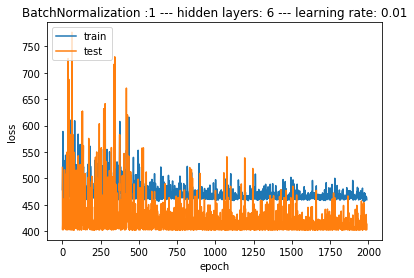

Train on 960 samples, validate on 241 samples
Epoch 1/2000
960/960 [==============================] - 3s 3ms/step - loss: 3574.3826 - val_loss: 1381.4149
Epoch 2/2000
960/960 [==============================] - 0s 79us/step - loss: 867.6140 - val_loss: 370.0615
Epoch 3/2000
960/960 [==============================] - 0s 80us/step - loss: 526.3466 - val_loss: 359.9336
Epoch 4/2000
960/960 [==============================] - 0s 82us/step - loss: 480.8965 - val_loss: 393.2749
Epoch 5/2000
960/960 [==============================] - 0s 86us/step - loss: 465.3337 - val_loss: 358.5164
Epoch 6/2000
960/960 [==============================] - 0s 86us/step - loss: 463.5758 - val_loss: 369.1285
Epoch 7/2000
960/960 [==============================] - 0s 81us/step - loss: 462.1506 - val_loss: 360.9813
Epoch 8/2000
960/960 [==============================] - 0s 87us/step - loss: 460.1416 - val_loss: 370.5775
Epoch 9/2000
960/960 [==============================] - 0s 88us/step - loss: 460.0253 - val_loss:

960/960 [==============================] - 0s 88us/step - loss: 338.2247 - val_loss: 299.1627
Epoch 77/2000
960/960 [==============================] - 0s 86us/step - loss: 348.2934 - val_loss: 309.5663
Epoch 78/2000
960/960 [==============================] - 0s 89us/step - loss: 351.8756 - val_loss: 387.3056
Epoch 79/2000
960/960 [==============================] - 0s 80us/step - loss: 343.8281 - val_loss: 302.7093
Epoch 80/2000
960/960 [==============================] - 0s 90us/step - loss: 333.4309 - val_loss: 326.9316
Epoch 81/2000
960/960 [==============================] - 0s 83us/step - loss: 339.6498 - val_loss: 296.0206
Epoch 82/2000
960/960 [==============================] - 0s 81us/step - loss: 337.1038 - val_loss: 295.9619
Epoch 83/2000
960/960 [==============================] - 0s 86us/step - loss: 351.6912 - val_loss: 375.3924
Epoch 84/2000
960/960 [==============================] - 0s 83us/step - loss: 366.4688 - val_loss: 308.1056
Epoch 85/2000
960/960 [===================

960/960 [==============================] - 0s 85us/step - loss: 317.5796 - val_loss: 291.9637
Epoch 152/2000
960/960 [==============================] - 0s 84us/step - loss: 326.5227 - val_loss: 338.9254
Epoch 153/2000
960/960 [==============================] - 0s 94us/step - loss: 325.9570 - val_loss: 301.0213
Epoch 154/2000
960/960 [==============================] - 0s 91us/step - loss: 360.3900 - val_loss: 292.4402
Epoch 155/2000
960/960 [==============================] - 0s 85us/step - loss: 332.9571 - val_loss: 364.7047
Epoch 156/2000
960/960 [==============================] - 0s 79us/step - loss: 326.9525 - val_loss: 319.5338
Epoch 157/2000
960/960 [==============================] - 0s 82us/step - loss: 346.2620 - val_loss: 385.0567
Epoch 158/2000
960/960 [==============================] - 0s 88us/step - loss: 327.8655 - val_loss: 299.4813
Epoch 159/2000
960/960 [==============================] - 0s 79us/step - loss: 308.7907 - val_loss: 294.9289
Epoch 160/2000
960/960 [==========

960/960 [==============================] - 0s 81us/step - loss: 330.9875 - val_loss: 317.4864
Epoch 227/2000
960/960 [==============================] - 0s 91us/step - loss: 303.4488 - val_loss: 302.2447
Epoch 228/2000
960/960 [==============================] - 0s 87us/step - loss: 302.5873 - val_loss: 293.4232
Epoch 229/2000
960/960 [==============================] - 0s 90us/step - loss: 299.5267 - val_loss: 293.3319
Epoch 230/2000
960/960 [==============================] - 0s 84us/step - loss: 306.2741 - val_loss: 298.8319
Epoch 231/2000
960/960 [==============================] - 0s 83us/step - loss: 299.5969 - val_loss: 298.6218
Epoch 232/2000
960/960 [==============================] - 0s 87us/step - loss: 304.4695 - val_loss: 296.8682
Epoch 233/2000
960/960 [==============================] - 0s 80us/step - loss: 315.3703 - val_loss: 293.8897
Epoch 234/2000
960/960 [==============================] - 0s 81us/step - loss: 322.1721 - val_loss: 307.0621
Epoch 235/2000
960/960 [==========

960/960 [==============================] - 0s 82us/step - loss: 293.9059 - val_loss: 325.2401
Epoch 302/2000
960/960 [==============================] - 0s 81us/step - loss: 293.4636 - val_loss: 320.2658
Epoch 303/2000
960/960 [==============================] - 0s 96us/step - loss: 299.8511 - val_loss: 353.6138
Epoch 304/2000
960/960 [==============================] - 0s 85us/step - loss: 298.0890 - val_loss: 321.7436
Epoch 305/2000
960/960 [==============================] - 0s 81us/step - loss: 306.1271 - val_loss: 333.7213
Epoch 306/2000
960/960 [==============================] - 0s 86us/step - loss: 298.1428 - val_loss: 317.5065
Epoch 307/2000
960/960 [==============================] - 0s 82us/step - loss: 309.0503 - val_loss: 313.9941
Epoch 308/2000
960/960 [==============================] - 0s 81us/step - loss: 300.8663 - val_loss: 311.0196
Epoch 309/2000
960/960 [==============================] - 0s 83us/step - loss: 293.0297 - val_loss: 303.9881
Epoch 310/2000
960/960 [==========

960/960 [==============================] - 0s 82us/step - loss: 300.2041 - val_loss: 297.8933
Epoch 377/2000
960/960 [==============================] - 0s 83us/step - loss: 291.7414 - val_loss: 306.3191
Epoch 378/2000
960/960 [==============================] - 0s 112us/step - loss: 294.8772 - val_loss: 306.7933
Epoch 379/2000
960/960 [==============================] - 0s 94us/step - loss: 293.0690 - val_loss: 298.4801
Epoch 380/2000
960/960 [==============================] - 0s 90us/step - loss: 296.6520 - val_loss: 301.6910
Epoch 381/2000
960/960 [==============================] - 0s 81us/step - loss: 289.3654 - val_loss: 300.1570
Epoch 382/2000
960/960 [==============================] - 0s 67us/step - loss: 286.5355 - val_loss: 301.1410
Epoch 383/2000
960/960 [==============================] - 0s 81us/step - loss: 298.6245 - val_loss: 331.0638
Epoch 384/2000
960/960 [==============================] - 0s 67us/step - loss: 289.2515 - val_loss: 311.3779
Epoch 385/2000
960/960 [=========

960/960 [==============================] - 0s 80us/step - loss: 282.2176 - val_loss: 298.7730
Epoch 452/2000
960/960 [==============================] - 0s 90us/step - loss: 285.0098 - val_loss: 317.4993
Epoch 453/2000
960/960 [==============================] - 0s 90us/step - loss: 287.2514 - val_loss: 304.5163
Epoch 454/2000
960/960 [==============================] - 0s 82us/step - loss: 290.1212 - val_loss: 299.0544
Epoch 455/2000
960/960 [==============================] - 0s 80us/step - loss: 281.3912 - val_loss: 298.7443
Epoch 456/2000
960/960 [==============================] - 0s 86us/step - loss: 306.5415 - val_loss: 337.6636
Epoch 457/2000
960/960 [==============================] - 0s 83us/step - loss: 289.6969 - val_loss: 317.3818
Epoch 458/2000
960/960 [==============================] - 0s 85us/step - loss: 285.5999 - val_loss: 298.8177
Epoch 459/2000
960/960 [==============================] - 0s 82us/step - loss: 285.5941 - val_loss: 302.6555
Epoch 460/2000
960/960 [==========

960/960 [==============================] - 0s 79us/step - loss: 287.5140 - val_loss: 300.4578
Epoch 527/2000
960/960 [==============================] - 0s 85us/step - loss: 286.6780 - val_loss: 316.6609
Epoch 528/2000
960/960 [==============================] - 0s 87us/step - loss: 281.3954 - val_loss: 300.3629
Epoch 529/2000
960/960 [==============================] - 0s 78us/step - loss: 282.0318 - val_loss: 299.6054
Epoch 530/2000
960/960 [==============================] - 0s 79us/step - loss: 279.6834 - val_loss: 301.9610
Epoch 531/2000
960/960 [==============================] - 0s 83us/step - loss: 282.2428 - val_loss: 305.8068
Epoch 532/2000
960/960 [==============================] - 0s 82us/step - loss: 288.6575 - val_loss: 321.3579
Epoch 533/2000
960/960 [==============================] - 0s 83us/step - loss: 295.2391 - val_loss: 337.7266
Epoch 534/2000
960/960 [==============================] - 0s 83us/step - loss: 284.5201 - val_loss: 299.9771
Epoch 535/2000
960/960 [==========

960/960 [==============================] - 0s 75us/step - loss: 283.6825 - val_loss: 306.4108
Epoch 602/2000
960/960 [==============================] - 0s 88us/step - loss: 280.3983 - val_loss: 301.4866
Epoch 603/2000
960/960 [==============================] - 0s 94us/step - loss: 279.5602 - val_loss: 315.6131
Epoch 604/2000
960/960 [==============================] - 0s 86us/step - loss: 279.6551 - val_loss: 301.3420
Epoch 605/2000
960/960 [==============================] - 0s 79us/step - loss: 282.9326 - val_loss: 301.4600
Epoch 606/2000
960/960 [==============================] - 0s 83us/step - loss: 279.2938 - val_loss: 302.4516
Epoch 607/2000
960/960 [==============================] - 0s 84us/step - loss: 280.0028 - val_loss: 301.2043
Epoch 608/2000
960/960 [==============================] - 0s 84us/step - loss: 302.6966 - val_loss: 331.4852
Epoch 609/2000
960/960 [==============================] - 0s 85us/step - loss: 312.7786 - val_loss: 307.2983
Epoch 610/2000
960/960 [==========

960/960 [==============================] - 0s 84us/step - loss: 277.5082 - val_loss: 313.7140
Epoch 677/2000
960/960 [==============================] - 0s 88us/step - loss: 277.9115 - val_loss: 308.6239
Epoch 678/2000
960/960 [==============================] - 0s 91us/step - loss: 274.8355 - val_loss: 305.3666
Epoch 679/2000
960/960 [==============================] - 0s 88us/step - loss: 280.3902 - val_loss: 302.4619
Epoch 680/2000
960/960 [==============================] - 0s 81us/step - loss: 278.7445 - val_loss: 317.7444
Epoch 681/2000
960/960 [==============================] - 0s 81us/step - loss: 281.7657 - val_loss: 310.3652
Epoch 682/2000
960/960 [==============================] - 0s 87us/step - loss: 285.5113 - val_loss: 317.4953
Epoch 683/2000
960/960 [==============================] - 0s 82us/step - loss: 294.1809 - val_loss: 310.7039
Epoch 684/2000
960/960 [==============================] - 0s 84us/step - loss: 285.8326 - val_loss: 309.4885
Epoch 685/2000
960/960 [==========

960/960 [==============================] - 0s 78us/step - loss: 276.7026 - val_loss: 315.8028
Epoch 752/2000
960/960 [==============================] - 0s 85us/step - loss: 311.0267 - val_loss: 307.2902
Epoch 753/2000
960/960 [==============================] - 0s 95us/step - loss: 305.5435 - val_loss: 310.6361
Epoch 754/2000
960/960 [==============================] - 0s 94us/step - loss: 273.3600 - val_loss: 336.7492
Epoch 755/2000
960/960 [==============================] - 0s 88us/step - loss: 280.1944 - val_loss: 304.0122
Epoch 756/2000
960/960 [==============================] - 0s 89us/step - loss: 284.9596 - val_loss: 303.9244
Epoch 757/2000
960/960 [==============================] - 0s 79us/step - loss: 279.5257 - val_loss: 304.0710
Epoch 758/2000
960/960 [==============================] - 0s 85us/step - loss: 281.8991 - val_loss: 307.5167
Epoch 759/2000
960/960 [==============================] - 0s 91us/step - loss: 281.4136 - val_loss: 303.6795
Epoch 760/2000
960/960 [==========

960/960 [==============================] - 0s 87us/step - loss: 273.7247 - val_loss: 343.6057
Epoch 827/2000
960/960 [==============================] - 0s 95us/step - loss: 287.3939 - val_loss: 334.5095
Epoch 828/2000
960/960 [==============================] - 0s 88us/step - loss: 271.2249 - val_loss: 340.1570
Epoch 829/2000
960/960 [==============================] - 0s 86us/step - loss: 282.6512 - val_loss: 322.3395
Epoch 830/2000
960/960 [==============================] - 0s 85us/step - loss: 277.9700 - val_loss: 305.1570
Epoch 831/2000
960/960 [==============================] - 0s 83us/step - loss: 276.8542 - val_loss: 346.8032
Epoch 832/2000
960/960 [==============================] - 0s 84us/step - loss: 317.8928 - val_loss: 333.1289
Epoch 833/2000
960/960 [==============================] - 0s 86us/step - loss: 299.2096 - val_loss: 319.9084
Epoch 834/2000
960/960 [==============================] - 0s 85us/step - loss: 272.2234 - val_loss: 326.8023
Epoch 835/2000
960/960 [==========

960/960 [==============================] - 0s 78us/step - loss: 271.5970 - val_loss: 314.9764
Epoch 902/2000
960/960 [==============================] - 0s 88us/step - loss: 275.1734 - val_loss: 309.4894
Epoch 903/2000
960/960 [==============================] - 0s 90us/step - loss: 273.7291 - val_loss: 318.0593
Epoch 904/2000
960/960 [==============================] - 0s 80us/step - loss: 273.4717 - val_loss: 307.0275
Epoch 905/2000
960/960 [==============================] - 0s 87us/step - loss: 273.2887 - val_loss: 324.8329
Epoch 906/2000
960/960 [==============================] - 0s 83us/step - loss: 269.9423 - val_loss: 314.4091
Epoch 907/2000
960/960 [==============================] - 0s 80us/step - loss: 274.9207 - val_loss: 322.8327
Epoch 908/2000
960/960 [==============================] - 0s 82us/step - loss: 278.7555 - val_loss: 329.1088
Epoch 909/2000
960/960 [==============================] - 0s 85us/step - loss: 281.9427 - val_loss: 308.9852
Epoch 910/2000
960/960 [==========

960/960 [==============================] - 0s 80us/step - loss: 290.8168 - val_loss: 307.5550
Epoch 977/2000
960/960 [==============================] - 0s 83us/step - loss: 300.7429 - val_loss: 311.8902
Epoch 978/2000
960/960 [==============================] - 0s 97us/step - loss: 286.9567 - val_loss: 332.6902
Epoch 979/2000
960/960 [==============================] - 0s 88us/step - loss: 272.2292 - val_loss: 311.6827
Epoch 980/2000
960/960 [==============================] - 0s 80us/step - loss: 275.3647 - val_loss: 312.5883
Epoch 981/2000
960/960 [==============================] - 0s 79us/step - loss: 284.0587 - val_loss: 360.3542
Epoch 982/2000
960/960 [==============================] - 0s 81us/step - loss: 277.0027 - val_loss: 333.6710
Epoch 983/2000
960/960 [==============================] - 0s 84us/step - loss: 271.6177 - val_loss: 308.0243
Epoch 984/2000
960/960 [==============================] - 0s 79us/step - loss: 270.6775 - val_loss: 309.7531
Epoch 985/2000
960/960 [==========

Epoch 1051/2000
960/960 [==============================] - 0s 79us/step - loss: 275.4571 - val_loss: 369.5330
Epoch 1052/2000
960/960 [==============================] - 0s 90us/step - loss: 276.9815 - val_loss: 319.2215
Epoch 1053/2000
960/960 [==============================] - 0s 83us/step - loss: 277.3685 - val_loss: 335.7179
Epoch 1054/2000
960/960 [==============================] - 0s 83us/step - loss: 269.8214 - val_loss: 312.7730
Epoch 1055/2000
960/960 [==============================] - 0s 81us/step - loss: 270.1140 - val_loss: 314.3495
Epoch 1056/2000
960/960 [==============================] - 0s 76us/step - loss: 271.6835 - val_loss: 333.5929
Epoch 1057/2000
960/960 [==============================] - 0s 83us/step - loss: 318.6310 - val_loss: 534.4481
Epoch 1058/2000
960/960 [==============================] - 0s 92us/step - loss: 306.1882 - val_loss: 308.2874
Epoch 1059/2000
960/960 [==============================] - 0s 82us/step - loss: 272.5270 - val_loss: 309.4552
Epoch 1060

960/960 [==============================] - 0s 94us/step - loss: 270.5623 - val_loss: 312.5159
Epoch 1126/2000
960/960 [==============================] - 0s 84us/step - loss: 266.9837 - val_loss: 309.3203
Epoch 1127/2000
960/960 [==============================] - 0s 91us/step - loss: 270.3952 - val_loss: 312.3533
Epoch 1128/2000
960/960 [==============================] - 0s 86us/step - loss: 279.3811 - val_loss: 309.3712
Epoch 1129/2000
960/960 [==============================] - 0s 81us/step - loss: 297.8129 - val_loss: 312.2733
Epoch 1130/2000
960/960 [==============================] - 0s 85us/step - loss: 271.7582 - val_loss: 427.5996
Epoch 1131/2000
960/960 [==============================] - 0s 83us/step - loss: 285.4459 - val_loss: 398.5230
Epoch 1132/2000
960/960 [==============================] - 0s 82us/step - loss: 277.8303 - val_loss: 324.2361
Epoch 1133/2000
960/960 [==============================] - 0s 82us/step - loss: 280.3058 - val_loss: 316.3529
Epoch 1134/2000
960/960 [=

960/960 [==============================] - 0s 85us/step - loss: 271.9341 - val_loss: 310.4799
Epoch 1200/2000
960/960 [==============================] - 0s 81us/step - loss: 271.9884 - val_loss: 310.4177
Epoch 1201/2000
960/960 [==============================] - 0s 96us/step - loss: 333.0581 - val_loss: 310.8677
Epoch 1202/2000
960/960 [==============================] - 0s 84us/step - loss: 316.1347 - val_loss: 337.1108
Epoch 1203/2000
960/960 [==============================] - 0s 90us/step - loss: 283.7687 - val_loss: 327.9880
Epoch 1204/2000
960/960 [==============================] - 0s 83us/step - loss: 276.7001 - val_loss: 311.5450
Epoch 1205/2000
960/960 [==============================] - 0s 85us/step - loss: 269.1486 - val_loss: 322.4369
Epoch 1206/2000
960/960 [==============================] - 0s 85us/step - loss: 271.2484 - val_loss: 317.2005
Epoch 1207/2000
960/960 [==============================] - 0s 81us/step - loss: 274.3257 - val_loss: 310.6435
Epoch 1208/2000
960/960 [=

960/960 [==============================] - 0s 83us/step - loss: 279.7375 - val_loss: 361.0649
Epoch 1274/2000
960/960 [==============================] - 0s 90us/step - loss: 284.4357 - val_loss: 329.7482
Epoch 1275/2000
960/960 [==============================] - 0s 93us/step - loss: 267.8934 - val_loss: 333.6321
Epoch 1276/2000
960/960 [==============================] - 0s 85us/step - loss: 264.6781 - val_loss: 313.4591
Epoch 1277/2000
960/960 [==============================] - 0s 82us/step - loss: 263.6847 - val_loss: 314.8881
Epoch 1278/2000
960/960 [==============================] - 0s 81us/step - loss: 279.9639 - val_loss: 313.2512
Epoch 1279/2000
960/960 [==============================] - 0s 83us/step - loss: 281.5743 - val_loss: 313.5720
Epoch 1280/2000
960/960 [==============================] - 0s 82us/step - loss: 268.1923 - val_loss: 327.5492
Epoch 1281/2000
960/960 [==============================] - 0s 84us/step - loss: 281.3116 - val_loss: 360.7228
Epoch 1282/2000
960/960 [=

960/960 [==============================] - 0s 82us/step - loss: 279.9972 - val_loss: 317.5388
Epoch 1348/2000
960/960 [==============================] - 0s 82us/step - loss: 269.4874 - val_loss: 319.1043
Epoch 1349/2000
960/960 [==============================] - 0s 94us/step - loss: 271.0032 - val_loss: 332.2716
Epoch 1350/2000
960/960 [==============================] - 0s 83us/step - loss: 269.2605 - val_loss: 313.0368
Epoch 1351/2000
960/960 [==============================] - 0s 81us/step - loss: 278.2287 - val_loss: 313.6757
Epoch 1352/2000
960/960 [==============================] - 0s 88us/step - loss: 281.1941 - val_loss: 319.3908
Epoch 1353/2000
960/960 [==============================] - 0s 85us/step - loss: 276.1245 - val_loss: 319.6711
Epoch 1354/2000
960/960 [==============================] - 0s 83us/step - loss: 283.6603 - val_loss: 325.0629
Epoch 1355/2000
960/960 [==============================] - 0s 87us/step - loss: 285.7665 - val_loss: 313.3770
Epoch 1356/2000
960/960 [=

960/960 [==============================] - 0s 77us/step - loss: 264.7421 - val_loss: 323.7394
Epoch 1422/2000
960/960 [==============================] - 0s 95us/step - loss: 266.7456 - val_loss: 317.6482
Epoch 1423/2000
960/960 [==============================] - 0s 90us/step - loss: 263.8803 - val_loss: 328.0887
Epoch 1424/2000
960/960 [==============================] - ETA: 0s - loss: 283.872 - 0s 83us/step - loss: 271.0982 - val_loss: 365.1027
Epoch 1425/2000
960/960 [==============================] - 0s 85us/step - loss: 282.2088 - val_loss: 373.8986
Epoch 1426/2000
960/960 [==============================] - 0s 86us/step - loss: 266.9649 - val_loss: 326.2163
Epoch 1427/2000
960/960 [==============================] - 0s 80us/step - loss: 263.2736 - val_loss: 320.0691
Epoch 1428/2000
960/960 [==============================] - 0s 85us/step - loss: 262.9625 - val_loss: 325.3722
Epoch 1429/2000
960/960 [==============================] - 0s 84us/step - loss: 273.7411 - val_loss: 376.7936


960/960 [==============================] - 0s 78us/step - loss: 271.2352 - val_loss: 315.2671
Epoch 1496/2000
960/960 [==============================] - 0s 84us/step - loss: 265.1684 - val_loss: 328.9316
Epoch 1497/2000
960/960 [==============================] - 0s 92us/step - loss: 263.1884 - val_loss: 325.7828
Epoch 1498/2000
960/960 [==============================] - 0s 86us/step - loss: 269.8758 - val_loss: 317.1662
Epoch 1499/2000
960/960 [==============================] - 0s 84us/step - loss: 263.6528 - val_loss: 359.6066
Epoch 1500/2000
960/960 [==============================] - 0s 83us/step - loss: 271.1073 - val_loss: 347.3200
Epoch 1501/2000
960/960 [==============================] - 0s 87us/step - loss: 272.5162 - val_loss: 316.6580
Epoch 1502/2000
960/960 [==============================] - 0s 80us/step - loss: 282.4788 - val_loss: 315.3026
Epoch 1503/2000
960/960 [==============================] - 0s 85us/step - loss: 295.3525 - val_loss: 328.4460
Epoch 1504/2000
960/960 [=

960/960 [==============================] - 0s 74us/step - loss: 264.6880 - val_loss: 321.2495
Epoch 1570/2000
960/960 [==============================] - 0s 86us/step - loss: 265.2683 - val_loss: 320.9726
Epoch 1571/2000
960/960 [==============================] - 0s 102us/step - loss: 272.2994 - val_loss: 317.5652
Epoch 1572/2000
960/960 [==============================] - 0s 82us/step - loss: 277.5668 - val_loss: 318.7486
Epoch 1573/2000
960/960 [==============================] - 0s 83us/step - loss: 267.1536 - val_loss: 319.4258
Epoch 1574/2000
960/960 [==============================] - 0s 81us/step - loss: 266.4976 - val_loss: 344.1560
Epoch 1575/2000
960/960 [==============================] - 0s 82us/step - loss: 264.3341 - val_loss: 390.0754
Epoch 1576/2000
960/960 [==============================] - 0s 83us/step - loss: 266.1588 - val_loss: 317.9797
Epoch 1577/2000
960/960 [==============================] - 0s 85us/step - loss: 261.7159 - val_loss: 320.9356
Epoch 1578/2000
960/960 [

960/960 [==============================] - 0s 79us/step - loss: 261.9300 - val_loss: 323.0733
Epoch 1644/2000
960/960 [==============================] - 0s 85us/step - loss: 260.7956 - val_loss: 338.8479
Epoch 1645/2000
960/960 [==============================] - 0s 89us/step - loss: 262.0618 - val_loss: 336.8350
Epoch 1646/2000
960/960 [==============================] - 0s 82us/step - loss: 269.8423 - val_loss: 318.8116
Epoch 1647/2000
960/960 [==============================] - 0s 90us/step - loss: 261.9220 - val_loss: 317.6085
Epoch 1648/2000
960/960 [==============================] - 0s 81us/step - loss: 261.3612 - val_loss: 337.2231
Epoch 1649/2000
960/960 [==============================] - 0s 83us/step - loss: 268.7534 - val_loss: 353.9179
Epoch 1650/2000
960/960 [==============================] - 0s 85us/step - loss: 275.3424 - val_loss: 319.8562
Epoch 1651/2000
960/960 [==============================] - 0s 78us/step - loss: 263.7212 - val_loss: 330.9665
Epoch 1652/2000
960/960 [=

960/960 [==============================] - 0s 87us/step - loss: 263.2912 - val_loss: 320.3606
Epoch 1718/2000
960/960 [==============================] - 0s 91us/step - loss: 290.2005 - val_loss: 319.1135
Epoch 1719/2000
960/960 [==============================] - 0s 87us/step - loss: 272.0115 - val_loss: 318.2775
Epoch 1720/2000
960/960 [==============================] - 0s 80us/step - loss: 282.5374 - val_loss: 329.0807
Epoch 1721/2000
960/960 [==============================] - 0s 87us/step - loss: 278.9705 - val_loss: 318.4969
Epoch 1722/2000
960/960 [==============================] - 0s 78us/step - loss: 269.8328 - val_loss: 400.2909
Epoch 1723/2000
960/960 [==============================] - 0s 81us/step - loss: 291.7014 - val_loss: 361.5195
Epoch 1724/2000
960/960 [==============================] - 0s 86us/step - loss: 275.7713 - val_loss: 361.3465
Epoch 1725/2000
960/960 [==============================] - 0s 82us/step - loss: 266.3483 - val_loss: 319.0184
Epoch 1726/2000
960/960 [=

960/960 [==============================] - 0s 81us/step - loss: 270.6291 - val_loss: 397.9817
Epoch 1792/2000
960/960 [==============================] - 0s 91us/step - loss: 310.5829 - val_loss: 364.8528
Epoch 1793/2000
960/960 [==============================] - 0s 92us/step - loss: 276.3518 - val_loss: 327.2848
Epoch 1794/2000
960/960 [==============================] - 0s 88us/step - loss: 261.8201 - val_loss: 344.1528
Epoch 1795/2000
960/960 [==============================] - 0s 81us/step - loss: 280.8769 - val_loss: 336.5860
Epoch 1796/2000
960/960 [==============================] - 0s 83us/step - loss: 271.5149 - val_loss: 324.6629
Epoch 1797/2000
960/960 [==============================] - 0s 87us/step - loss: 266.7212 - val_loss: 328.1196
Epoch 1798/2000
960/960 [==============================] - 0s 79us/step - loss: 277.6423 - val_loss: 383.1233
Epoch 1799/2000
960/960 [==============================] - 0s 83us/step - loss: 270.9255 - val_loss: 357.7144
Epoch 1800/2000
960/960 [=

960/960 [==============================] - 0s 90us/step - loss: 263.3280 - val_loss: 347.2147
Epoch 1866/2000
960/960 [==============================] - 0s 94us/step - loss: 268.9419 - val_loss: 332.5313
Epoch 1867/2000
960/960 [==============================] - 0s 85us/step - loss: 264.9955 - val_loss: 329.5127
Epoch 1868/2000
960/960 [==============================] - 0s 71us/step - loss: 270.6186 - val_loss: 336.0483
Epoch 1869/2000
960/960 [==============================] - 0s 78us/step - loss: 266.5929 - val_loss: 321.7089
Epoch 1870/2000
960/960 [==============================] - 0s 59us/step - loss: 262.6159 - val_loss: 334.1003
Epoch 1871/2000
960/960 [==============================] - 0s 67us/step - loss: 262.4242 - val_loss: 320.8530
Epoch 1872/2000
960/960 [==============================] - 0s 59us/step - loss: 262.6472 - val_loss: 320.9618
Epoch 1873/2000
960/960 [==============================] - 0s 65us/step - loss: 261.6900 - val_loss: 323.8599
Epoch 1874/2000
960/960 [=

960/960 [==============================] - 0s 78us/step - loss: 267.3572 - val_loss: 327.7165
Epoch 1940/2000
960/960 [==============================] - 0s 81us/step - loss: 258.4925 - val_loss: 321.5927
Epoch 1941/2000
960/960 [==============================] - 0s 98us/step - loss: 261.3691 - val_loss: 326.5048
Epoch 1942/2000
960/960 [==============================] - 0s 86us/step - loss: 260.6070 - val_loss: 348.6239
Epoch 1943/2000
960/960 [==============================] - 0s 80us/step - loss: 266.8541 - val_loss: 321.5889
Epoch 1944/2000
960/960 [==============================] - 0s 82us/step - loss: 274.5077 - val_loss: 384.0837
Epoch 1945/2000
960/960 [==============================] - 0s 85us/step - loss: 316.6789 - val_loss: 330.6023
Epoch 1946/2000
960/960 [==============================] - 0s 82us/step - loss: 290.9647 - val_loss: 358.8763
Epoch 1947/2000
960/960 [==============================] - 0s 82us/step - loss: 271.3064 - val_loss: 383.6480
Epoch 1948/2000
960/960 [=

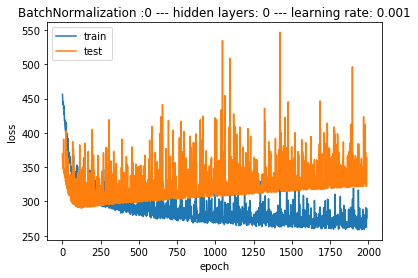

Train on 960 samples, validate on 241 samples
Epoch 1/2000
960/960 [==============================] - 4s 4ms/step - loss: 11978.8729 - val_loss: 5482.1511
Epoch 2/2000
960/960 [==============================] - 0s 272us/step - loss: 1849.3575 - val_loss: 1331.3178
Epoch 3/2000
960/960 [==============================] - 0s 286us/step - loss: 742.0793 - val_loss: 467.2210
Epoch 4/2000
960/960 [==============================] - 0s 281us/step - loss: 459.9466 - val_loss: 463.9038
Epoch 5/2000
960/960 [==============================] - 0s 269us/step - loss: 425.7323 - val_loss: 349.9245
Epoch 6/2000
960/960 [==============================] - 0s 271us/step - loss: 420.1832 - val_loss: 349.4648
Epoch 7/2000
960/960 [==============================] - 0s 285us/step - loss: 438.3513 - val_loss: 443.0761
Epoch 8/2000
960/960 [==============================] - 0s 294us/step - loss: 420.1256 - val_loss: 424.2362
Epoch 9/2000
960/960 [==============================] - 0s 273us/step - loss: 417.9979 

Epoch 76/2000
960/960 [==============================] - 0s 303us/step - loss: 349.1148 - val_loss: 297.0716
Epoch 77/2000
960/960 [==============================] - 0s 280us/step - loss: 319.5522 - val_loss: 321.6434
Epoch 78/2000
960/960 [==============================] - 0s 271us/step - loss: 328.1622 - val_loss: 328.6260
Epoch 79/2000
960/960 [==============================] - 0s 259us/step - loss: 372.9528 - val_loss: 302.8256
Epoch 80/2000
960/960 [==============================] - 0s 269us/step - loss: 320.9363 - val_loss: 295.0162
Epoch 81/2000
960/960 [==============================] - 0s 269us/step - loss: 340.0905 - val_loss: 307.6641
Epoch 82/2000
960/960 [==============================] - 0s 275us/step - loss: 314.9551 - val_loss: 311.1575
Epoch 83/2000
960/960 [==============================] - 0s 279us/step - loss: 312.6585 - val_loss: 394.5064
Epoch 84/2000
960/960 [==============================] - 0s 287us/step - loss: 377.3802 - val_loss: 541.8129
Epoch 85/2000
960/9

960/960 [==============================] - 0s 298us/step - loss: 315.6986 - val_loss: 314.6766
Epoch 151/2000
960/960 [==============================] - 0s 276us/step - loss: 297.0885 - val_loss: 294.8277
Epoch 152/2000
960/960 [==============================] - 0s 273us/step - loss: 320.5193 - val_loss: 302.5027
Epoch 153/2000
960/960 [==============================] - 0s 304us/step - loss: 293.1823 - val_loss: 298.4478
Epoch 154/2000
960/960 [==============================] - 0s 274us/step - loss: 354.3834 - val_loss: 373.2638
Epoch 155/2000
960/960 [==============================] - 0s 276us/step - loss: 322.2225 - val_loss: 299.0183
Epoch 156/2000
960/960 [==============================] - 0s 299us/step - loss: 302.6625 - val_loss: 303.7532
Epoch 157/2000
960/960 [==============================] - 0s 291us/step - loss: 316.5598 - val_loss: 368.7554
Epoch 158/2000
960/960 [==============================] - 0s 289us/step - loss: 344.5639 - val_loss: 295.1028
Epoch 159/2000
960/960 [=

960/960 [==============================] - 0s 281us/step - loss: 307.9983 - val_loss: 313.5861
Epoch 225/2000
960/960 [==============================] - 0s 286us/step - loss: 299.1437 - val_loss: 295.6451
Epoch 226/2000
960/960 [==============================] - 0s 273us/step - loss: 313.7395 - val_loss: 344.9346
Epoch 227/2000
960/960 [==============================] - 0s 264us/step - loss: 295.0423 - val_loss: 301.4197
Epoch 228/2000
960/960 [==============================] - 0s 276us/step - loss: 294.9438 - val_loss: 299.9759
Epoch 229/2000
960/960 [==============================] - 0s 276us/step - loss: 313.1257 - val_loss: 420.7085
Epoch 230/2000
960/960 [==============================] - 0s 283us/step - loss: 318.5437 - val_loss: 443.6344
Epoch 231/2000
960/960 [==============================] - 0s 285us/step - loss: 317.7748 - val_loss: 299.7017
Epoch 232/2000
960/960 [==============================] - 0s 277us/step - loss: 299.3849 - val_loss: 299.4526
Epoch 233/2000
960/960 [=

960/960 [==============================] - 0s 294us/step - loss: 296.1649 - val_loss: 298.5046
Epoch 299/2000
960/960 [==============================] - 0s 287us/step - loss: 286.9067 - val_loss: 300.1965
Epoch 300/2000
960/960 [==============================] - 0s 282us/step - loss: 299.0907 - val_loss: 303.8442
Epoch 301/2000
960/960 [==============================] - 0s 287us/step - loss: 312.8871 - val_loss: 373.8819
Epoch 302/2000
960/960 [==============================] - 0s 280us/step - loss: 321.9132 - val_loss: 381.9045
Epoch 303/2000
960/960 [==============================] - 0s 281us/step - loss: 311.6199 - val_loss: 299.8773
Epoch 304/2000
960/960 [==============================] - 0s 275us/step - loss: 340.5283 - val_loss: 307.8040
Epoch 305/2000
960/960 [==============================] - 0s 284us/step - loss: 321.0635 - val_loss: 385.3133
Epoch 306/2000
960/960 [==============================] - 0s 273us/step - loss: 298.1374 - val_loss: 296.3895
Epoch 307/2000
960/960 [=

960/960 [==============================] - 0s 264us/step - loss: 305.5587 - val_loss: 337.9087
Epoch 373/2000
960/960 [==============================] - 0s 287us/step - loss: 346.4985 - val_loss: 307.5698
Epoch 374/2000
960/960 [==============================] - 0s 262us/step - loss: 336.1856 - val_loss: 310.9527
Epoch 375/2000
960/960 [==============================] - 0s 247us/step - loss: 290.1168 - val_loss: 296.6740
Epoch 376/2000
960/960 [==============================] - 0s 271us/step - loss: 291.2547 - val_loss: 346.6965
Epoch 377/2000
960/960 [==============================] - 0s 280us/step - loss: 284.4383 - val_loss: 317.2670
Epoch 378/2000
960/960 [==============================] - 0s 272us/step - loss: 324.1150 - val_loss: 350.4389
Epoch 379/2000
960/960 [==============================] - 0s 282us/step - loss: 317.6253 - val_loss: 352.4304
Epoch 380/2000
960/960 [==============================] - 0s 296us/step - loss: 315.1498 - val_loss: 298.1272
Epoch 381/2000
960/960 [=

960/960 [==============================] - 0s 297us/step - loss: 288.5560 - val_loss: 298.0327
Epoch 447/2000
960/960 [==============================] - 0s 282us/step - loss: 308.3767 - val_loss: 340.3535
Epoch 448/2000
960/960 [==============================] - 0s 277us/step - loss: 309.4397 - val_loss: 304.6552
Epoch 449/2000
960/960 [==============================] - 0s 270us/step - loss: 313.3855 - val_loss: 333.8109
Epoch 450/2000
960/960 [==============================] - 0s 281us/step - loss: 302.6414 - val_loss: 321.3910
Epoch 451/2000
960/960 [==============================] - 0s 307us/step - loss: 326.4355 - val_loss: 327.9705
Epoch 452/2000
960/960 [==============================] - 0s 299us/step - loss: 314.8350 - val_loss: 311.7112
Epoch 453/2000
960/960 [==============================] - 0s 293us/step - loss: 303.6673 - val_loss: 300.8482
Epoch 454/2000
960/960 [==============================] - 0s 271us/step - loss: 294.0620 - val_loss: 297.3475
Epoch 455/2000
960/960 [=

960/960 [==============================] - 0s 276us/step - loss: 303.6885 - val_loss: 316.1512
Epoch 521/2000
960/960 [==============================] - 0s 302us/step - loss: 294.0497 - val_loss: 307.4660
Epoch 522/2000
960/960 [==============================] - 0s 290us/step - loss: 287.0797 - val_loss: 303.3411
Epoch 523/2000
960/960 [==============================] - 0s 279us/step - loss: 283.2302 - val_loss: 299.9386
Epoch 524/2000
960/960 [==============================] - 0s 297us/step - loss: 284.0025 - val_loss: 301.2783
Epoch 525/2000
960/960 [==============================] - 0s 283us/step - loss: 298.6799 - val_loss: 301.3362
Epoch 526/2000
960/960 [==============================] - 0s 286us/step - loss: 281.8517 - val_loss: 301.8419
Epoch 527/2000
960/960 [==============================] - 0s 294us/step - loss: 298.1202 - val_loss: 301.9430
Epoch 528/2000
960/960 [==============================] - 0s 281us/step - loss: 283.8512 - val_loss: 334.9216
Epoch 529/2000
960/960 [=

960/960 [==============================] - 0s 284us/step - loss: 280.2101 - val_loss: 307.0555
Epoch 595/2000
960/960 [==============================] - 0s 282us/step - loss: 281.8382 - val_loss: 329.4232
Epoch 596/2000
960/960 [==============================] - 0s 280us/step - loss: 287.3664 - val_loss: 302.4297
Epoch 597/2000
960/960 [==============================] - 0s 298us/step - loss: 309.5226 - val_loss: 341.2480
Epoch 598/2000
960/960 [==============================] - 0s 276us/step - loss: 298.3897 - val_loss: 329.5639
Epoch 599/2000
960/960 [==============================] - 0s 271us/step - loss: 299.9983 - val_loss: 301.2056
Epoch 600/2000
960/960 [==============================] - 0s 277us/step - loss: 284.6080 - val_loss: 410.2022
Epoch 601/2000
960/960 [==============================] - 0s 269us/step - loss: 298.4681 - val_loss: 343.7861
Epoch 602/2000
960/960 [==============================] - 0s 279us/step - loss: 311.3287 - val_loss: 344.6461
Epoch 603/2000
960/960 [=

960/960 [==============================] - 0s 294us/step - loss: 285.0547 - val_loss: 303.6679
Epoch 669/2000
960/960 [==============================] - 0s 279us/step - loss: 291.1456 - val_loss: 314.4134
Epoch 670/2000
960/960 [==============================] - 0s 278us/step - loss: 283.5793 - val_loss: 355.0023
Epoch 671/2000
960/960 [==============================] - 0s 275us/step - loss: 310.5639 - val_loss: 318.7107
Epoch 672/2000
960/960 [==============================] - 0s 274us/step - loss: 297.6154 - val_loss: 299.9385
Epoch 673/2000
960/960 [==============================] - 0s 265us/step - loss: 285.6623 - val_loss: 376.5188
Epoch 674/2000
960/960 [==============================] - 0s 264us/step - loss: 326.9135 - val_loss: 299.9756
Epoch 675/2000
960/960 [==============================] - 0s 302us/step - loss: 286.3501 - val_loss: 303.1540
Epoch 676/2000
960/960 [==============================] - 0s 275us/step - loss: 285.4022 - val_loss: 314.5248
Epoch 677/2000
960/960 [=

960/960 [==============================] - 0s 302us/step - loss: 290.1841 - val_loss: 301.7651
Epoch 743/2000
960/960 [==============================] - 0s 306us/step - loss: 284.1756 - val_loss: 319.2665
Epoch 744/2000
960/960 [==============================] - 0s 291us/step - loss: 279.8903 - val_loss: 310.0274
Epoch 745/2000
960/960 [==============================] - 0s 315us/step - loss: 280.8614 - val_loss: 325.9382
Epoch 746/2000
960/960 [==============================] - 0s 271us/step - loss: 283.1730 - val_loss: 310.1390
Epoch 747/2000
960/960 [==============================] - 0s 285us/step - loss: 275.5995 - val_loss: 325.9908
Epoch 748/2000
960/960 [==============================] - 0s 301us/step - loss: 294.0993 - val_loss: 303.9973
Epoch 749/2000
960/960 [==============================] - 0s 295us/step - loss: 275.3743 - val_loss: 322.8411
Epoch 750/2000
960/960 [==============================] - 0s 285us/step - loss: 273.5275 - val_loss: 305.1979
Epoch 751/2000
960/960 [=

960/960 [==============================] - 0s 311us/step - loss: 328.8540 - val_loss: 314.7464
Epoch 817/2000
960/960 [==============================] - 0s 306us/step - loss: 319.8277 - val_loss: 310.7078
Epoch 818/2000
960/960 [==============================] - 0s 298us/step - loss: 309.8508 - val_loss: 310.5274
Epoch 819/2000
960/960 [==============================] - 0s 291us/step - loss: 284.8333 - val_loss: 303.0094
Epoch 820/2000
960/960 [==============================] - 0s 288us/step - loss: 294.3536 - val_loss: 316.1724
Epoch 821/2000
960/960 [==============================] - 0s 304us/step - loss: 277.3889 - val_loss: 328.6134
Epoch 822/2000
960/960 [==============================] - 0s 323us/step - loss: 277.4661 - val_loss: 309.8262
Epoch 823/2000
960/960 [==============================] - 0s 306us/step - loss: 276.5048 - val_loss: 371.6348
Epoch 824/2000
960/960 [==============================] - 0s 310us/step - loss: 295.8479 - val_loss: 407.5987
Epoch 825/2000
960/960 [=

960/960 [==============================] - 0s 263us/step - loss: 295.5064 - val_loss: 347.3384
Epoch 891/2000
960/960 [==============================] - 0s 289us/step - loss: 303.1082 - val_loss: 311.2111
Epoch 892/2000
960/960 [==============================] - 0s 279us/step - loss: 293.3058 - val_loss: 303.6183
Epoch 893/2000
960/960 [==============================] - 0s 276us/step - loss: 278.3704 - val_loss: 307.2642
Epoch 894/2000
960/960 [==============================] - 0s 294us/step - loss: 277.2007 - val_loss: 306.5605
Epoch 895/2000
960/960 [==============================] - 0s 291us/step - loss: 304.0756 - val_loss: 304.0075
Epoch 896/2000
960/960 [==============================] - 0s 281us/step - loss: 292.6416 - val_loss: 306.2569
Epoch 897/2000
960/960 [==============================] - 0s 269us/step - loss: 278.3328 - val_loss: 324.8690
Epoch 898/2000
960/960 [==============================] - 0s 262us/step - loss: 282.9462 - val_loss: 311.4300
Epoch 899/2000
960/960 [=

960/960 [==============================] - 0s 285us/step - loss: 278.8695 - val_loss: 307.9409
Epoch 965/2000
960/960 [==============================] - 0s 290us/step - loss: 274.5181 - val_loss: 305.1871
Epoch 966/2000
960/960 [==============================] - 0s 266us/step - loss: 297.4754 - val_loss: 307.3103
Epoch 967/2000
960/960 [==============================] - 0s 267us/step - loss: 298.6195 - val_loss: 316.9414
Epoch 968/2000
960/960 [==============================] - 0s 298us/step - loss: 275.8302 - val_loss: 305.4080
Epoch 969/2000
960/960 [==============================] - 0s 295us/step - loss: 287.5821 - val_loss: 305.1907
Epoch 970/2000
960/960 [==============================] - 0s 277us/step - loss: 281.7443 - val_loss: 336.3411
Epoch 971/2000
960/960 [==============================] - 0s 260us/step - loss: 276.8596 - val_loss: 318.0670
Epoch 972/2000
960/960 [==============================] - 0s 267us/step - loss: 275.2429 - val_loss: 327.9395
Epoch 973/2000
960/960 [=

960/960 [==============================] - 0s 308us/step - loss: 281.8068 - val_loss: 314.7415
Epoch 1039/2000
960/960 [==============================] - 0s 278us/step - loss: 279.7894 - val_loss: 321.8933
Epoch 1040/2000
960/960 [==============================] - 0s 280us/step - loss: 279.4421 - val_loss: 319.5027
Epoch 1041/2000
960/960 [==============================] - 0s 283us/step - loss: 274.5719 - val_loss: 316.9786
Epoch 1042/2000
960/960 [==============================] - 0s 267us/step - loss: 274.2280 - val_loss: 312.4926
Epoch 1043/2000
960/960 [==============================] - 0s 271us/step - loss: 274.2065 - val_loss: 338.0456
Epoch 1044/2000
960/960 [==============================] - 0s 267us/step - loss: 277.9233 - val_loss: 327.9556
Epoch 1045/2000
960/960 [==============================] - 0s 264us/step - loss: 274.4715 - val_loss: 317.0965
Epoch 1046/2000
960/960 [==============================] - 0s 267us/step - loss: 274.0549 - val_loss: 312.8078
Epoch 1047/2000
9

Epoch 1112/2000
960/960 [==============================] - 0s 305us/step - loss: 268.5943 - val_loss: 313.3182
Epoch 1113/2000
960/960 [==============================] - 0s 287us/step - loss: 292.8016 - val_loss: 312.2376
Epoch 1114/2000
960/960 [==============================] - 0s 282us/step - loss: 271.7173 - val_loss: 310.4511
Epoch 1115/2000
960/960 [==============================] - 0s 282us/step - loss: 281.6258 - val_loss: 310.3844
Epoch 1116/2000
960/960 [==============================] - 0s 292us/step - loss: 292.8588 - val_loss: 315.3624
Epoch 1117/2000
960/960 [==============================] - 0s 265us/step - loss: 279.4761 - val_loss: 320.3892
Epoch 1118/2000
960/960 [==============================] - 0s 270us/step - loss: 278.4110 - val_loss: 356.4752
Epoch 1119/2000
960/960 [==============================] - 0s 275us/step - loss: 288.3410 - val_loss: 322.0607
Epoch 1120/2000
960/960 [==============================] - 0s 274us/step - loss: 270.4436 - val_loss: 360.8406
E

Epoch 1186/2000
960/960 [==============================] - 0s 290us/step - loss: 284.9455 - val_loss: 353.1637
Epoch 1187/2000
960/960 [==============================] - 0s 280us/step - loss: 311.5062 - val_loss: 307.0234
Epoch 1188/2000
960/960 [==============================] - 0s 275us/step - loss: 299.2418 - val_loss: 329.1593
Epoch 1189/2000
960/960 [==============================] - 0s 278us/step - loss: 286.3532 - val_loss: 337.5527
Epoch 1190/2000
960/960 [==============================] - 0s 293us/step - loss: 274.7428 - val_loss: 330.1151
Epoch 1191/2000
960/960 [==============================] - 0s 290us/step - loss: 279.2860 - val_loss: 349.6608
Epoch 1192/2000
960/960 [==============================] - 0s 281us/step - loss: 273.0832 - val_loss: 307.4709
Epoch 1193/2000
960/960 [==============================] - 0s 276us/step - loss: 275.7721 - val_loss: 310.3377
Epoch 1194/2000
960/960 [==============================] - 0s 281us/step - loss: 285.0176 - val_loss: 310.1711
E

Epoch 1260/2000
960/960 [==============================] - 0s 278us/step - loss: 283.4552 - val_loss: 308.0408
Epoch 1261/2000
960/960 [==============================] - 0s 276us/step - loss: 281.1352 - val_loss: 309.6931
Epoch 1262/2000
960/960 [==============================] - 0s 267us/step - loss: 265.8790 - val_loss: 312.7321
Epoch 1263/2000
960/960 [==============================] - 0s 272us/step - loss: 275.4255 - val_loss: 308.7642
Epoch 1264/2000
960/960 [==============================] - 0s 277us/step - loss: 269.0607 - val_loss: 319.9877
Epoch 1265/2000
960/960 [==============================] - 0s 263us/step - loss: 275.0169 - val_loss: 308.7542
Epoch 1266/2000
960/960 [==============================] - 0s 265us/step - loss: 290.7245 - val_loss: 312.1931
Epoch 1267/2000
960/960 [==============================] - 0s 275us/step - loss: 268.0851 - val_loss: 309.2090
Epoch 1268/2000
960/960 [==============================] - 0s 294us/step - loss: 275.3650 - val_loss: 311.1167
E

960/960 [==============================] - 0s 307us/step - loss: 295.6876 - val_loss: 310.2568
Epoch 1334/2000
960/960 [==============================] - 0s 290us/step - loss: 292.0975 - val_loss: 507.3687
Epoch 1335/2000
960/960 [==============================] - 0s 264us/step - loss: 315.3623 - val_loss: 429.8665
Epoch 1336/2000
960/960 [==============================] - 0s 290us/step - loss: 292.1977 - val_loss: 319.2949
Epoch 1337/2000
960/960 [==============================] - 0s 296us/step - loss: 271.9138 - val_loss: 317.3804
Epoch 1338/2000
960/960 [==============================] - 0s 300us/step - loss: 270.2627 - val_loss: 308.0318
Epoch 1339/2000
960/960 [==============================] - 0s 277us/step - loss: 279.4112 - val_loss: 313.8595
Epoch 1340/2000
960/960 [==============================] - 0s 270us/step - loss: 272.2750 - val_loss: 321.8422
Epoch 1341/2000
960/960 [==============================] - 0s 272us/step - loss: 270.9464 - val_loss: 312.5857
Epoch 1342/2000
9

Epoch 1407/2000
960/960 [==============================] - 0s 288us/step - loss: 271.7447 - val_loss: 312.5963
Epoch 1408/2000
960/960 [==============================] - 0s 285us/step - loss: 277.5216 - val_loss: 399.2499
Epoch 1409/2000
960/960 [==============================] - 0s 276us/step - loss: 279.4720 - val_loss: 363.3326
Epoch 1410/2000
960/960 [==============================] - 0s 270us/step - loss: 279.9110 - val_loss: 351.0796
Epoch 1411/2000
960/960 [==============================] - 0s 264us/step - loss: 270.8577 - val_loss: 309.8530
Epoch 1412/2000
960/960 [==============================] - 0s 264us/step - loss: 270.7266 - val_loss: 318.3284
Epoch 1413/2000
960/960 [==============================] - 0s 292us/step - loss: 272.9385 - val_loss: 363.5902
Epoch 1414/2000
960/960 [==============================] - 0s 295us/step - loss: 283.5549 - val_loss: 378.1301
Epoch 1415/2000
960/960 [==============================] - 0s 261us/step - loss: 278.9638 - val_loss: 343.2610
E

Epoch 1481/2000
960/960 [==============================] - 0s 279us/step - loss: 266.8974 - val_loss: 324.8382
Epoch 1482/2000
960/960 [==============================] - 0s 273us/step - loss: 267.0452 - val_loss: 313.3599
Epoch 1483/2000
960/960 [==============================] - 0s 288us/step - loss: 283.3398 - val_loss: 315.9599
Epoch 1484/2000
960/960 [==============================] - 0s 274us/step - loss: 286.6472 - val_loss: 311.4255
Epoch 1485/2000
960/960 [==============================] - 0s 274us/step - loss: 266.7068 - val_loss: 332.4685
Epoch 1486/2000
960/960 [==============================] - 0s 297us/step - loss: 273.6548 - val_loss: 315.4945
Epoch 1487/2000
960/960 [==============================] - 0s 284us/step - loss: 275.6085 - val_loss: 321.2571
Epoch 1488/2000
960/960 [==============================] - 0s 289us/step - loss: 275.2291 - val_loss: 336.8981
Epoch 1489/2000
960/960 [==============================] - 0s 297us/step - loss: 269.8476 - val_loss: 318.9498
E

Epoch 1555/2000
960/960 [==============================] - 0s 294us/step - loss: 269.5321 - val_loss: 338.8294
Epoch 1556/2000
960/960 [==============================] - 0s 280us/step - loss: 274.3357 - val_loss: 336.9554
Epoch 1557/2000
960/960 [==============================] - 0s 282us/step - loss: 272.5860 - val_loss: 323.1353
Epoch 1558/2000
960/960 [==============================] - 0s 276us/step - loss: 269.8370 - val_loss: 314.6545
Epoch 1559/2000
960/960 [==============================] - 0s 297us/step - loss: 269.0206 - val_loss: 316.6301
Epoch 1560/2000
960/960 [==============================] - 0s 294us/step - loss: 265.9772 - val_loss: 330.9733
Epoch 1561/2000
960/960 [==============================] - 0s 297us/step - loss: 264.9160 - val_loss: 321.5199
Epoch 1562/2000
960/960 [==============================] - 0s 278us/step - loss: 265.3076 - val_loss: 342.7182
Epoch 1563/2000
960/960 [==============================] - 0s 280us/step - loss: 266.0326 - val_loss: 316.8610
E

Epoch 1629/2000
960/960 [==============================] - 0s 272us/step - loss: 289.3877 - val_loss: 314.0803
Epoch 1630/2000
960/960 [==============================] - 0s 274us/step - loss: 277.2542 - val_loss: 312.6016
Epoch 1631/2000
960/960 [==============================] - 0s 277us/step - loss: 273.7915 - val_loss: 314.7063
Epoch 1632/2000
960/960 [==============================] - 0s 265us/step - loss: 298.1693 - val_loss: 360.8588
Epoch 1633/2000
960/960 [==============================] - 0s 293us/step - loss: 319.2937 - val_loss: 311.6049
Epoch 1634/2000
960/960 [==============================] - 0s 266us/step - loss: 291.3120 - val_loss: 376.9298
Epoch 1635/2000
960/960 [==============================] - 0s 277us/step - loss: 278.5541 - val_loss: 322.0774
Epoch 1636/2000
960/960 [==============================] - 0s 264us/step - loss: 287.0057 - val_loss: 315.7736
Epoch 1637/2000
960/960 [==============================] - 0s 258us/step - loss: 266.4531 - val_loss: 340.6068
E

Epoch 1703/2000
960/960 [==============================] - 0s 290us/step - loss: 269.6657 - val_loss: 309.8254
Epoch 1704/2000
960/960 [==============================] - 0s 302us/step - loss: 268.3406 - val_loss: 310.6359
Epoch 1705/2000
960/960 [==============================] - 0s 287us/step - loss: 272.3492 - val_loss: 313.7381
Epoch 1706/2000
960/960 [==============================] - 0s 272us/step - loss: 275.2192 - val_loss: 333.2240
Epoch 1707/2000
960/960 [==============================] - 0s 277us/step - loss: 270.8830 - val_loss: 326.7085
Epoch 1708/2000
960/960 [==============================] - 0s 275us/step - loss: 270.2064 - val_loss: 311.9301
Epoch 1709/2000
960/960 [==============================] - 0s 276us/step - loss: 271.0813 - val_loss: 333.5035
Epoch 1710/2000
960/960 [==============================] - 0s 271us/step - loss: 267.7323 - val_loss: 315.3692
Epoch 1711/2000
960/960 [==============================] - 0s 251us/step - loss: 273.0003 - val_loss: 320.6269
E

Epoch 1777/2000
960/960 [==============================] - 0s 288us/step - loss: 308.1869 - val_loss: 392.5946
Epoch 1778/2000
960/960 [==============================] - 0s 264us/step - loss: 297.6319 - val_loss: 314.8719
Epoch 1779/2000
960/960 [==============================] - 0s 261us/step - loss: 269.0427 - val_loss: 311.8746
Epoch 1780/2000
960/960 [==============================] - 0s 273us/step - loss: 264.6982 - val_loss: 314.2028
Epoch 1781/2000
960/960 [==============================] - 0s 282us/step - loss: 276.5711 - val_loss: 320.6646
Epoch 1782/2000
960/960 [==============================] - 0s 292us/step - loss: 274.5365 - val_loss: 370.4582
Epoch 1783/2000
960/960 [==============================] - 0s 274us/step - loss: 279.7728 - val_loss: 385.9994
Epoch 1784/2000
960/960 [==============================] - 0s 280us/step - loss: 274.2411 - val_loss: 316.2315
Epoch 1785/2000
960/960 [==============================] - 0s 271us/step - loss: 277.1222 - val_loss: 313.3645
E

Epoch 1851/2000
960/960 [==============================] - 0s 274us/step - loss: 266.2778 - val_loss: 316.0529
Epoch 1852/2000
960/960 [==============================] - 0s 273us/step - loss: 271.5151 - val_loss: 315.7659
Epoch 1853/2000
960/960 [==============================] - 0s 268us/step - loss: 273.3730 - val_loss: 404.3337
Epoch 1854/2000
960/960 [==============================] - 0s 261us/step - loss: 293.6762 - val_loss: 432.6655
Epoch 1855/2000
960/960 [==============================] - 0s 294us/step - loss: 279.7775 - val_loss: 321.8565
Epoch 1856/2000
960/960 [==============================] - 0s 297us/step - loss: 279.3909 - val_loss: 315.3030
Epoch 1857/2000
960/960 [==============================] - 0s 288us/step - loss: 265.9923 - val_loss: 319.0327
Epoch 1858/2000
960/960 [==============================] - 0s 268us/step - loss: 268.7172 - val_loss: 440.3150
Epoch 1859/2000
960/960 [==============================] - 0s 288us/step - loss: 307.4559 - val_loss: 412.4599
E

Epoch 1925/2000
960/960 [==============================] - 0s 306us/step - loss: 280.4928 - val_loss: 327.7280
Epoch 1926/2000
960/960 [==============================] - 0s 281us/step - loss: 279.6874 - val_loss: 386.1042
Epoch 1927/2000
960/960 [==============================] - 0s 271us/step - loss: 270.1917 - val_loss: 322.9180
Epoch 1928/2000
960/960 [==============================] - 0s 275us/step - loss: 280.8770 - val_loss: 322.6529
Epoch 1929/2000
960/960 [==============================] - 0s 269us/step - loss: 269.8348 - val_loss: 336.0273
Epoch 1930/2000
960/960 [==============================] - 0s 288us/step - loss: 268.5269 - val_loss: 314.1054
Epoch 1931/2000
960/960 [==============================] - 0s 269us/step - loss: 263.0588 - val_loss: 315.3443
Epoch 1932/2000
960/960 [==============================] - 0s 283us/step - loss: 264.3303 - val_loss: 325.6290
Epoch 1933/2000
960/960 [==============================] - 0s 282us/step - loss: 264.5105 - val_loss: 318.2478
E

Epoch 1999/2000
960/960 [==============================] - 0s 301us/step - loss: 289.6637 - val_loss: 319.0959
Epoch 2000/2000
960/960 [==============================] - 0s 296us/step - loss: 278.7403 - val_loss: 320.1118


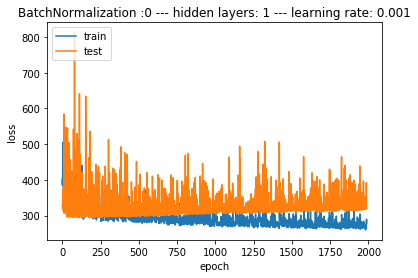

Train on 960 samples, validate on 241 samples
Epoch 1/2000
960/960 [==============================] - 4s 4ms/step - loss: 10262.7145 - val_loss: 4788.1543
Epoch 2/2000
960/960 [==============================] - 0s 269us/step - loss: 1595.6039 - val_loss: 1206.4798
Epoch 3/2000
960/960 [==============================] - 0s 301us/step - loss: 584.6734 - val_loss: 414.7249
Epoch 4/2000
960/960 [==============================] - 0s 284us/step - loss: 455.8258 - val_loss: 354.0185
Epoch 5/2000
960/960 [==============================] - 0s 266us/step - loss: 423.7678 - val_loss: 350.0445
Epoch 6/2000
960/960 [==============================] - 0s 260us/step - loss: 426.2635 - val_loss: 347.2124
Epoch 7/2000
960/960 [==============================] - 0s 279us/step - loss: 406.9473 - val_loss: 370.5304
Epoch 8/2000
960/960 [==============================] - 0s 306us/step - loss: 412.4962 - val_loss: 338.4062
Epoch 9/2000
960/960 [==============================] - 0s 277us/step - loss: 396.0887 

Epoch 76/2000
960/960 [==============================] - 0s 292us/step - loss: 393.3323 - val_loss: 314.9301
Epoch 77/2000
960/960 [==============================] - 0s 268us/step - loss: 324.6522 - val_loss: 294.7741
Epoch 78/2000
960/960 [==============================] - 0s 283us/step - loss: 346.5378 - val_loss: 430.9129
Epoch 79/2000
960/960 [==============================] - 0s 283us/step - loss: 335.4744 - val_loss: 530.1993
Epoch 80/2000
960/960 [==============================] - 0s 280us/step - loss: 468.1627 - val_loss: 329.8896
Epoch 81/2000
960/960 [==============================] - 0s 286us/step - loss: 425.2131 - val_loss: 488.5398
Epoch 82/2000
960/960 [==============================] - 0s 296us/step - loss: 351.8549 - val_loss: 353.6937
Epoch 83/2000
960/960 [==============================] - 0s 287us/step - loss: 310.8076 - val_loss: 295.2516
Epoch 84/2000
960/960 [==============================] - 0s 269us/step - loss: 348.8180 - val_loss: 319.7159
Epoch 85/2000
960/9

960/960 [==============================] - 0s 284us/step - loss: 305.4594 - val_loss: 294.8048
Epoch 151/2000
960/960 [==============================] - 0s 302us/step - loss: 318.0032 - val_loss: 330.7598
Epoch 152/2000
960/960 [==============================] - 0s 292us/step - loss: 315.7111 - val_loss: 394.2616
Epoch 153/2000
960/960 [==============================] - 0s 304us/step - loss: 322.3414 - val_loss: 358.8775
Epoch 154/2000
960/960 [==============================] - 0s 273us/step - loss: 323.2774 - val_loss: 294.9896
Epoch 155/2000
960/960 [==============================] - 0s 287us/step - loss: 354.8038 - val_loss: 378.9600
Epoch 156/2000
960/960 [==============================] - 0s 297us/step - loss: 319.5204 - val_loss: 300.2802
Epoch 157/2000
960/960 [==============================] - 0s 297us/step - loss: 316.7962 - val_loss: 363.4024
Epoch 158/2000
960/960 [==============================] - 0s 290us/step - loss: 320.6503 - val_loss: 332.9750
Epoch 159/2000
960/960 [=

960/960 [==============================] - 0s 271us/step - loss: 305.5367 - val_loss: 398.9424
Epoch 225/2000
960/960 [==============================] - 0s 290us/step - loss: 371.0482 - val_loss: 401.3383
Epoch 226/2000
960/960 [==============================] - 0s 292us/step - loss: 395.2037 - val_loss: 490.7254
Epoch 227/2000
960/960 [==============================] - 0s 297us/step - loss: 350.0497 - val_loss: 293.1226
Epoch 228/2000
960/960 [==============================] - 0s 273us/step - loss: 308.9653 - val_loss: 295.0830
Epoch 229/2000
960/960 [==============================] - 0s 276us/step - loss: 298.3150 - val_loss: 296.4323
Epoch 230/2000
960/960 [==============================] - 0s 285us/step - loss: 301.1640 - val_loss: 310.0163
Epoch 231/2000
960/960 [==============================] - 0s 298us/step - loss: 290.4654 - val_loss: 308.1688
Epoch 232/2000
960/960 [==============================] - 0s 297us/step - loss: 299.0025 - val_loss: 297.0466
Epoch 233/2000
960/960 [=

960/960 [==============================] - 0s 301us/step - loss: 309.8434 - val_loss: 294.3004
Epoch 299/2000
960/960 [==============================] - 0s 300us/step - loss: 291.0862 - val_loss: 333.2106
Epoch 300/2000
960/960 [==============================] - 0s 293us/step - loss: 295.5501 - val_loss: 294.8284
Epoch 301/2000
960/960 [==============================] - 0s 277us/step - loss: 291.8617 - val_loss: 296.4521
Epoch 302/2000
960/960 [==============================] - 0s 303us/step - loss: 285.7504 - val_loss: 295.1089
Epoch 303/2000
960/960 [==============================] - 0s 280us/step - loss: 331.7421 - val_loss: 295.4077
Epoch 304/2000
960/960 [==============================] - 0s 279us/step - loss: 290.5987 - val_loss: 298.8510
Epoch 305/2000
960/960 [==============================] - 0s 259us/step - loss: 290.5530 - val_loss: 296.0515
Epoch 306/2000
960/960 [==============================] - 0s 249us/step - loss: 292.7762 - val_loss: 303.2641
Epoch 307/2000
960/960 [=

960/960 [==============================] - 0s 284us/step - loss: 332.1669 - val_loss: 308.3571
Epoch 373/2000
960/960 [==============================] - 0s 298us/step - loss: 306.9400 - val_loss: 363.4606
Epoch 374/2000
960/960 [==============================] - 0s 300us/step - loss: 333.4424 - val_loss: 327.3302
Epoch 375/2000
960/960 [==============================] - 0s 279us/step - loss: 317.9948 - val_loss: 303.1286
Epoch 376/2000
960/960 [==============================] - 0s 271us/step - loss: 295.9041 - val_loss: 329.8122
Epoch 377/2000
960/960 [==============================] - 0s 279us/step - loss: 292.6712 - val_loss: 295.2400
Epoch 378/2000
960/960 [==============================] - 0s 308us/step - loss: 287.3146 - val_loss: 296.0060
Epoch 379/2000
960/960 [==============================] - 0s 294us/step - loss: 283.7817 - val_loss: 298.2563
Epoch 380/2000
960/960 [==============================] - 0s 298us/step - loss: 290.7935 - val_loss: 390.8319
Epoch 381/2000
960/960 [=

960/960 [==============================] - 0s 258us/step - loss: 299.2341 - val_loss: 349.7196
Epoch 447/2000
960/960 [==============================] - 0s 289us/step - loss: 292.1012 - val_loss: 316.5100
Epoch 448/2000
960/960 [==============================] - 0s 310us/step - loss: 294.5354 - val_loss: 303.0028
Epoch 449/2000
960/960 [==============================] - 0s 275us/step - loss: 309.9550 - val_loss: 430.1941
Epoch 450/2000
960/960 [==============================] - 0s 282us/step - loss: 352.1224 - val_loss: 302.1818
Epoch 451/2000
960/960 [==============================] - 0s 264us/step - loss: 293.9542 - val_loss: 296.9061
Epoch 452/2000
960/960 [==============================] - 0s 259us/step - loss: 290.0411 - val_loss: 318.4548
Epoch 453/2000
960/960 [==============================] - 0s 262us/step - loss: 306.6319 - val_loss: 302.6851
Epoch 454/2000
960/960 [==============================] - 0s 279us/step - loss: 291.2549 - val_loss: 301.1943
Epoch 455/2000
960/960 [=

960/960 [==============================] - 0s 280us/step - loss: 292.4061 - val_loss: 345.9029
Epoch 521/2000
960/960 [==============================] - 0s 282us/step - loss: 306.1272 - val_loss: 372.5182
Epoch 522/2000
960/960 [==============================] - 0s 281us/step - loss: 340.2832 - val_loss: 341.1979
Epoch 523/2000
960/960 [==============================] - 0s 289us/step - loss: 333.0081 - val_loss: 339.3281
Epoch 524/2000
960/960 [==============================] - 0s 276us/step - loss: 335.4045 - val_loss: 419.2094
Epoch 525/2000
960/960 [==============================] - 0s 283us/step - loss: 318.9459 - val_loss: 319.2942
Epoch 526/2000
960/960 [==============================] - 0s 269us/step - loss: 293.2277 - val_loss: 361.6994
Epoch 527/2000
960/960 [==============================] - 0s 271us/step - loss: 292.1009 - val_loss: 296.9594
Epoch 528/2000
960/960 [==============================] - 0s 294us/step - loss: 292.5694 - val_loss: 329.1590
Epoch 529/2000
960/960 [=

960/960 [==============================] - 0s 269us/step - loss: 320.1678 - val_loss: 366.7591
Epoch 595/2000
960/960 [==============================] - 0s 268us/step - loss: 303.8620 - val_loss: 298.6614
Epoch 596/2000
960/960 [==============================] - 0s 249us/step - loss: 309.0335 - val_loss: 303.3797
Epoch 597/2000
960/960 [==============================] - 0s 276us/step - loss: 292.3446 - val_loss: 309.6331
Epoch 598/2000
960/960 [==============================] - 0s 280us/step - loss: 290.8111 - val_loss: 312.5603
Epoch 599/2000
960/960 [==============================] - 0s 284us/step - loss: 278.5675 - val_loss: 300.1370
Epoch 600/2000
960/960 [==============================] - 0s 280us/step - loss: 282.8828 - val_loss: 335.7123
Epoch 601/2000
960/960 [==============================] - 0s 282us/step - loss: 300.2528 - val_loss: 320.8996
Epoch 602/2000
960/960 [==============================] - 0s 240us/step - loss: 284.2597 - val_loss: 301.9921
Epoch 603/2000
960/960 [=

960/960 [==============================] - 0s 290us/step - loss: 279.2636 - val_loss: 383.9249
Epoch 669/2000
960/960 [==============================] - 0s 286us/step - loss: 289.8916 - val_loss: 366.5590
Epoch 670/2000
960/960 [==============================] - 0s 306us/step - loss: 297.5795 - val_loss: 348.7343
Epoch 671/2000
960/960 [==============================] - 0s 300us/step - loss: 312.3898 - val_loss: 302.4349
Epoch 672/2000
960/960 [==============================] - 0s 286us/step - loss: 286.7726 - val_loss: 303.1750
Epoch 673/2000
960/960 [==============================] - 0s 278us/step - loss: 299.3667 - val_loss: 390.5508
Epoch 674/2000
960/960 [==============================] - 0s 268us/step - loss: 317.3548 - val_loss: 318.5796
Epoch 675/2000
960/960 [==============================] - 0s 251us/step - loss: 322.6880 - val_loss: 297.7152
Epoch 676/2000
960/960 [==============================] - 0s 278us/step - loss: 313.5103 - val_loss: 303.0951
Epoch 677/2000
960/960 [=

960/960 [==============================] - 0s 269us/step - loss: 279.4225 - val_loss: 326.9023
Epoch 743/2000
960/960 [==============================] - 0s 294us/step - loss: 284.8803 - val_loss: 304.4198
Epoch 744/2000
960/960 [==============================] - 0s 305us/step - loss: 280.9536 - val_loss: 361.5094
Epoch 745/2000
960/960 [==============================] - 0s 282us/step - loss: 307.3815 - val_loss: 336.6851
Epoch 746/2000
960/960 [==============================] - 0s 298us/step - loss: 277.7457 - val_loss: 302.2401
Epoch 747/2000
960/960 [==============================] - 0s 276us/step - loss: 283.7663 - val_loss: 308.4627
Epoch 748/2000
960/960 [==============================] - 0s 288us/step - loss: 291.9119 - val_loss: 300.8115
Epoch 749/2000
960/960 [==============================] - 0s 297us/step - loss: 274.6764 - val_loss: 302.0503
Epoch 750/2000
960/960 [==============================] - 0s 282us/step - loss: 283.8262 - val_loss: 343.3636
Epoch 751/2000
960/960 [=

960/960 [==============================] - 0s 308us/step - loss: 281.7610 - val_loss: 306.5550
Epoch 817/2000
960/960 [==============================] - 0s 304us/step - loss: 304.4944 - val_loss: 332.3191
Epoch 818/2000
960/960 [==============================] - 0s 291us/step - loss: 278.2600 - val_loss: 422.9150
Epoch 819/2000
960/960 [==============================] - 0s 296us/step - loss: 288.5550 - val_loss: 385.3280
Epoch 820/2000
960/960 [==============================] - 0s 280us/step - loss: 284.0618 - val_loss: 302.2656
Epoch 821/2000
960/960 [==============================] - 0s 310us/step - loss: 282.6593 - val_loss: 307.3851
Epoch 822/2000
960/960 [==============================] - 0s 287us/step - loss: 278.0168 - val_loss: 319.7138
Epoch 823/2000
960/960 [==============================] - 0s 284us/step - loss: 290.5647 - val_loss: 305.5433
Epoch 824/2000
960/960 [==============================] - 0s 271us/step - loss: 287.2597 - val_loss: 323.6520
Epoch 825/2000
960/960 [=

960/960 [==============================] - 0s 306us/step - loss: 320.3919 - val_loss: 321.8868
Epoch 891/2000
960/960 [==============================] - 0s 299us/step - loss: 309.0198 - val_loss: 321.4209
Epoch 892/2000
960/960 [==============================] - 0s 297us/step - loss: 280.8204 - val_loss: 358.7174
Epoch 893/2000
960/960 [==============================] - 0s 275us/step - loss: 282.7839 - val_loss: 327.5938
Epoch 894/2000
960/960 [==============================] - 0s 298us/step - loss: 281.4728 - val_loss: 328.9536
Epoch 895/2000
960/960 [==============================] - 0s 293us/step - loss: 321.1150 - val_loss: 353.8234
Epoch 896/2000
960/960 [==============================] - 0s 291us/step - loss: 302.5454 - val_loss: 312.9782
Epoch 897/2000
960/960 [==============================] - 0s 280us/step - loss: 328.1953 - val_loss: 305.3275
Epoch 898/2000
960/960 [==============================] - 0s 303us/step - loss: 312.2412 - val_loss: 321.7951
Epoch 899/2000
960/960 [=

960/960 [==============================] - 0s 297us/step - loss: 289.5739 - val_loss: 317.4662
Epoch 965/2000
960/960 [==============================] - 0s 303us/step - loss: 273.4224 - val_loss: 305.7291
Epoch 966/2000
960/960 [==============================] - 0s 291us/step - loss: 280.8889 - val_loss: 308.0011
Epoch 967/2000
960/960 [==============================] - 0s 281us/step - loss: 273.5625 - val_loss: 306.8306
Epoch 968/2000
960/960 [==============================] - 0s 290us/step - loss: 272.0120 - val_loss: 307.9203
Epoch 969/2000
960/960 [==============================] - 0s 308us/step - loss: 273.9278 - val_loss: 388.8525
Epoch 970/2000
960/960 [==============================] - 0s 294us/step - loss: 293.0901 - val_loss: 339.6687
Epoch 971/2000
960/960 [==============================] - 0s 281us/step - loss: 274.8713 - val_loss: 307.1526
Epoch 972/2000
960/960 [==============================] - 0s 280us/step - loss: 277.4524 - val_loss: 307.5146
Epoch 973/2000
960/960 [=

960/960 [==============================] - 0s 289us/step - loss: 314.7680 - val_loss: 311.2963
Epoch 1039/2000
960/960 [==============================] - 0s 265us/step - loss: 273.2759 - val_loss: 304.9523
Epoch 1040/2000
960/960 [==============================] - 0s 258us/step - loss: 283.8653 - val_loss: 333.5545
Epoch 1041/2000
960/960 [==============================] - 0s 322us/step - loss: 289.0129 - val_loss: 305.4444
Epoch 1042/2000
960/960 [==============================] - 0s 323us/step - loss: 275.7545 - val_loss: 340.2569
Epoch 1043/2000
960/960 [==============================] - 0s 301us/step - loss: 285.4861 - val_loss: 305.7464
Epoch 1044/2000
960/960 [==============================] - 0s 283us/step - loss: 272.7363 - val_loss: 306.9237
Epoch 1045/2000
960/960 [==============================] - 0s 298us/step - loss: 272.2092 - val_loss: 310.3795
Epoch 1046/2000
960/960 [==============================] - 0s 312us/step - loss: 277.8740 - val_loss: 312.4676
Epoch 1047/2000
9

960/960 [==============================] - 0s 308us/step - loss: 285.0805 - val_loss: 319.5025
Epoch 1112/2000
960/960 [==============================] - 0s 279us/step - loss: 273.3489 - val_loss: 331.2781
Epoch 1113/2000
960/960 [==============================] - 0s 265us/step - loss: 281.4999 - val_loss: 323.8713
Epoch 1114/2000
960/960 [==============================] - 0s 267us/step - loss: 267.1773 - val_loss: 310.6290
Epoch 1115/2000
960/960 [==============================] - 0s 289us/step - loss: 285.7952 - val_loss: 327.5749
Epoch 1116/2000
960/960 [==============================] - 0s 304us/step - loss: 280.3144 - val_loss: 328.8316
Epoch 1117/2000
960/960 [==============================] - 0s 285us/step - loss: 295.9409 - val_loss: 346.7497
Epoch 1118/2000
960/960 [==============================] - 0s 298us/step - loss: 323.1386 - val_loss: 318.2757
Epoch 1119/2000
960/960 [==============================] - 0s 305us/step - loss: 293.4566 - val_loss: 314.2031
Epoch 1120/2000
9

960/960 [==============================] - 0s 313us/step - loss: 271.6827 - val_loss: 350.4943
Epoch 1185/2000
960/960 [==============================] - 0s 300us/step - loss: 288.6321 - val_loss: 307.0964
Epoch 1186/2000
960/960 [==============================] - 0s 291us/step - loss: 276.5585 - val_loss: 315.7053
Epoch 1187/2000
960/960 [==============================] - 0s 295us/step - loss: 268.7456 - val_loss: 307.7744
Epoch 1188/2000
960/960 [==============================] - 0s 291us/step - loss: 273.0694 - val_loss: 308.2004
Epoch 1189/2000
960/960 [==============================] - 0s 289us/step - loss: 279.2254 - val_loss: 310.5327
Epoch 1190/2000
960/960 [==============================] - 0s 291us/step - loss: 298.9186 - val_loss: 370.4194
Epoch 1191/2000
960/960 [==============================] - 0s 298us/step - loss: 320.0448 - val_loss: 308.1185
Epoch 1192/2000
960/960 [==============================] - 0s 301us/step - loss: 308.5614 - val_loss: 400.4121
Epoch 1193/2000
9

Epoch 1258/2000
960/960 [==============================] - 0s 306us/step - loss: 279.6184 - val_loss: 362.7423
Epoch 1259/2000
960/960 [==============================] - 0s 310us/step - loss: 302.6048 - val_loss: 319.8386
Epoch 1260/2000
960/960 [==============================] - 0s 284us/step - loss: 274.9271 - val_loss: 307.7447
Epoch 1261/2000
960/960 [==============================] - 0s 291us/step - loss: 275.3355 - val_loss: 309.5335
Epoch 1262/2000
960/960 [==============================] - 0s 276us/step - loss: 297.0974 - val_loss: 328.9087
Epoch 1263/2000
960/960 [==============================] - 0s 281us/step - loss: 287.2433 - val_loss: 307.5247
Epoch 1264/2000
960/960 [==============================] - 0s 268us/step - loss: 282.7788 - val_loss: 307.2071
Epoch 1265/2000
960/960 [==============================] - 0s 298us/step - loss: 274.2882 - val_loss: 310.5408
Epoch 1266/2000
960/960 [==============================] - 0s 301us/step - loss: 279.6241 - val_loss: 309.2799
E

Epoch 1332/2000
960/960 [==============================] - 0s 319us/step - loss: 271.9783 - val_loss: 339.0702
Epoch 1333/2000
960/960 [==============================] - 0s 285us/step - loss: 299.5207 - val_loss: 307.4542
Epoch 1334/2000
960/960 [==============================] - 0s 300us/step - loss: 269.3564 - val_loss: 330.3714
Epoch 1335/2000
960/960 [==============================] - 0s 298us/step - loss: 273.1944 - val_loss: 320.1082
Epoch 1336/2000
960/960 [==============================] - 0s 288us/step - loss: 281.8444 - val_loss: 312.0495
Epoch 1337/2000
960/960 [==============================] - 0s 297us/step - loss: 273.7676 - val_loss: 316.6224
Epoch 1338/2000
960/960 [==============================] - 0s 304us/step - loss: 278.6492 - val_loss: 310.9396
Epoch 1339/2000
960/960 [==============================] - 0s 292us/step - loss: 280.2483 - val_loss: 322.9895
Epoch 1340/2000
960/960 [==============================] - 0s 278us/step - loss: 282.8166 - val_loss: 307.1521
E

Epoch 1406/2000
960/960 [==============================] - 0s 303us/step - loss: 270.4195 - val_loss: 323.9528
Epoch 1407/2000
960/960 [==============================] - 0s 303us/step - loss: 268.5112 - val_loss: 334.1888
Epoch 1408/2000
960/960 [==============================] - 0s 289us/step - loss: 269.6549 - val_loss: 362.9772
Epoch 1409/2000
960/960 [==============================] - 0s 304us/step - loss: 274.3610 - val_loss: 313.1132
Epoch 1410/2000
960/960 [==============================] - 0s 295us/step - loss: 284.4442 - val_loss: 311.6998
Epoch 1411/2000
960/960 [==============================] - 0s 273us/step - loss: 278.1428 - val_loss: 356.1464
Epoch 1412/2000
960/960 [==============================] - 0s 278us/step - loss: 271.6566 - val_loss: 312.6924
Epoch 1413/2000
960/960 [==============================] - 0s 275us/step - loss: 286.8266 - val_loss: 334.0230
Epoch 1414/2000
960/960 [==============================] - 0s 276us/step - loss: 276.9205 - val_loss: 317.0827
E

Epoch 1480/2000
960/960 [==============================] - 0s 248us/step - loss: 277.2008 - val_loss: 310.0039
Epoch 1481/2000
960/960 [==============================] - 0s 316us/step - loss: 294.5377 - val_loss: 328.9993
Epoch 1482/2000
960/960 [==============================] - 0s 273us/step - loss: 278.6783 - val_loss: 407.4109
Epoch 1483/2000
960/960 [==============================] - 0s 306us/step - loss: 287.3521 - val_loss: 332.9032
Epoch 1484/2000
960/960 [==============================] - 0s 284us/step - loss: 272.4566 - val_loss: 315.4240
Epoch 1485/2000
960/960 [==============================] - 0s 279us/step - loss: 265.9297 - val_loss: 309.8367
Epoch 1486/2000
960/960 [==============================] - 0s 268us/step - loss: 285.4480 - val_loss: 324.5919
Epoch 1487/2000
960/960 [==============================] - 0s 300us/step - loss: 277.1527 - val_loss: 352.2164
Epoch 1488/2000
960/960 [==============================] - 0s 320us/step - loss: 283.7639 - val_loss: 310.3931
E

Epoch 1554/2000
960/960 [==============================] - 0s 305us/step - loss: 272.1848 - val_loss: 315.2477
Epoch 1555/2000
960/960 [==============================] - 0s 290us/step - loss: 306.3447 - val_loss: 309.5536
Epoch 1556/2000
960/960 [==============================] - 0s 278us/step - loss: 301.3569 - val_loss: 313.8253
Epoch 1557/2000
960/960 [==============================] - 0s 277us/step - loss: 266.3959 - val_loss: 315.0041
Epoch 1558/2000
960/960 [==============================] - 0s 260us/step - loss: 276.4521 - val_loss: 318.9975
Epoch 1559/2000
960/960 [==============================] - 0s 277us/step - loss: 292.8290 - val_loss: 337.9314
Epoch 1560/2000
960/960 [==============================] - 0s 302us/step - loss: 284.2217 - val_loss: 345.2131
Epoch 1561/2000
960/960 [==============================] - 0s 281us/step - loss: 276.0273 - val_loss: 347.0368
Epoch 1562/2000
960/960 [==============================] - 0s 303us/step - loss: 272.9315 - val_loss: 318.9886
E

Epoch 1628/2000
960/960 [==============================] - 0s 282us/step - loss: 268.8028 - val_loss: 313.1854
Epoch 1629/2000
960/960 [==============================] - 0s 302us/step - loss: 311.2206 - val_loss: 309.7714
Epoch 1630/2000
960/960 [==============================] - 0s 275us/step - loss: 271.7455 - val_loss: 312.3588
Epoch 1631/2000
960/960 [==============================] - 0s 303us/step - loss: 268.6987 - val_loss: 314.2497
Epoch 1632/2000
960/960 [==============================] - 0s 298us/step - loss: 282.9327 - val_loss: 330.1522
Epoch 1633/2000
960/960 [==============================] - 0s 295us/step - loss: 308.1724 - val_loss: 356.7063
Epoch 1634/2000
960/960 [==============================] - 0s 300us/step - loss: 279.8892 - val_loss: 317.8660
Epoch 1635/2000
960/960 [==============================] - 0s 279us/step - loss: 274.7322 - val_loss: 311.7475
Epoch 1636/2000
960/960 [==============================] - 0s 280us/step - loss: 264.9591 - val_loss: 312.7616
E

Epoch 1702/2000
960/960 [==============================] - 0s 283us/step - loss: 266.1548 - val_loss: 318.9147
Epoch 1703/2000
960/960 [==============================] - 0s 296us/step - loss: 268.6264 - val_loss: 329.6312
Epoch 1704/2000
960/960 [==============================] - 0s 299us/step - loss: 269.7576 - val_loss: 345.5937
Epoch 1705/2000
960/960 [==============================] - 0s 299us/step - loss: 267.1056 - val_loss: 313.2104
Epoch 1706/2000
960/960 [==============================] - 0s 280us/step - loss: 272.6693 - val_loss: 346.6651
Epoch 1707/2000
960/960 [==============================] - 0s 304us/step - loss: 282.8429 - val_loss: 328.8955
Epoch 1708/2000
960/960 [==============================] - 0s 287us/step - loss: 275.5329 - val_loss: 354.9645
Epoch 1709/2000
960/960 [==============================] - 0s 303us/step - loss: 271.6244 - val_loss: 372.8699
Epoch 1710/2000
960/960 [==============================] - 0s 294us/step - loss: 280.5625 - val_loss: 325.5890
E

Epoch 1776/2000
960/960 [==============================] - 0s 290us/step - loss: 264.8090 - val_loss: 315.7392
Epoch 1777/2000
960/960 [==============================] - 0s 273us/step - loss: 266.6433 - val_loss: 314.9167
Epoch 1778/2000
960/960 [==============================] - 0s 289us/step - loss: 267.6638 - val_loss: 315.0464
Epoch 1779/2000
960/960 [==============================] - 0s 261us/step - loss: 269.5191 - val_loss: 317.9267
Epoch 1780/2000
960/960 [==============================] - 0s 259us/step - loss: 266.1109 - val_loss: 315.3175
Epoch 1781/2000
960/960 [==============================] - 0s 268us/step - loss: 262.4393 - val_loss: 315.3448
Epoch 1782/2000
960/960 [==============================] - 0s 300us/step - loss: 270.7167 - val_loss: 345.9054
Epoch 1783/2000
960/960 [==============================] - 0s 302us/step - loss: 290.7500 - val_loss: 380.1074
Epoch 1784/2000
960/960 [==============================] - 0s 305us/step - loss: 295.9357 - val_loss: 413.2059
E

Epoch 1850/2000
960/960 [==============================] - 0s 317us/step - loss: 279.3599 - val_loss: 318.7574
Epoch 1851/2000
960/960 [==============================] - 0s 304us/step - loss: 272.8495 - val_loss: 325.7436
Epoch 1852/2000
960/960 [==============================] - 0s 304us/step - loss: 277.0393 - val_loss: 316.7360
Epoch 1853/2000
960/960 [==============================] - 0s 284us/step - loss: 278.0939 - val_loss: 315.2916
Epoch 1854/2000
960/960 [==============================] - 0s 304us/step - loss: 275.0567 - val_loss: 316.6455
Epoch 1855/2000
960/960 [==============================] - 0s 291us/step - loss: 271.5828 - val_loss: 318.5079
Epoch 1856/2000
960/960 [==============================] - 0s 291us/step - loss: 268.3809 - val_loss: 361.9431
Epoch 1857/2000
960/960 [==============================] - 0s 302us/step - loss: 269.6827 - val_loss: 321.8019
Epoch 1858/2000
960/960 [==============================] - 0s 282us/step - loss: 280.3502 - val_loss: 362.2753
E

Epoch 1924/2000
960/960 [==============================] - 0s 296us/step - loss: 269.9425 - val_loss: 347.7633
Epoch 1925/2000
960/960 [==============================] - 0s 275us/step - loss: 289.8120 - val_loss: 316.9824
Epoch 1926/2000
960/960 [==============================] - 0s 301us/step - loss: 270.2368 - val_loss: 326.1400
Epoch 1927/2000
960/960 [==============================] - 0s 306us/step - loss: 278.9183 - val_loss: 317.7288
Epoch 1928/2000
960/960 [==============================] - 0s 299us/step - loss: 268.2422 - val_loss: 322.2409
Epoch 1929/2000
960/960 [==============================] - 0s 303us/step - loss: 269.3758 - val_loss: 317.9113
Epoch 1930/2000
960/960 [==============================] - 0s 300us/step - loss: 268.8540 - val_loss: 315.8721
Epoch 1931/2000
960/960 [==============================] - 0s 278us/step - loss: 274.5156 - val_loss: 347.9028
Epoch 1932/2000
960/960 [==============================] - 0s 299us/step - loss: 288.3844 - val_loss: 337.3329
E

Epoch 1998/2000
960/960 [==============================] - 0s 299us/step - loss: 261.5813 - val_loss: 318.3389
Epoch 1999/2000
960/960 [==============================] - 0s 314us/step - loss: 271.0840 - val_loss: 317.5186
Epoch 2000/2000
960/960 [==============================] - 0s 295us/step - loss: 262.9706 - val_loss: 318.9843


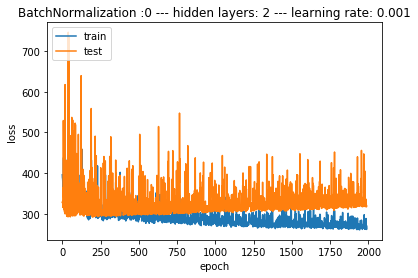

Train on 960 samples, validate on 241 samples
Epoch 1/2000
960/960 [==============================] - 4s 4ms/step - loss: 4420.7634 - val_loss: 812.4994
Epoch 2/2000
960/960 [==============================] - 1s 528us/step - loss: 632.5095 - val_loss: 401.3922
Epoch 3/2000
960/960 [==============================] - 1s 561us/step - loss: 464.5907 - val_loss: 344.2559
Epoch 4/2000
960/960 [==============================] - 1s 554us/step - loss: 420.1176 - val_loss: 352.8316
Epoch 5/2000
960/960 [==============================] - 1s 548us/step - loss: 430.1705 - val_loss: 343.6197
Epoch 6/2000
960/960 [==============================] - 1s 539us/step - loss: 415.4409 - val_loss: 340.4103
Epoch 7/2000
960/960 [==============================] - 1s 558us/step - loss: 462.7462 - val_loss: 407.7238
Epoch 8/2000
960/960 [==============================] - 1s 558us/step - loss: 458.6301 - val_loss: 475.6506
Epoch 9/2000
960/960 [==============================] - 1s 551us/step - loss: 429.6440 - va

Epoch 76/2000
960/960 [==============================] - 1s 550us/step - loss: 370.7604 - val_loss: 299.7472
Epoch 77/2000
960/960 [==============================] - 1s 554us/step - loss: 358.2653 - val_loss: 293.8878
Epoch 78/2000
960/960 [==============================] - 1s 565us/step - loss: 362.6530 - val_loss: 433.1114
Epoch 79/2000
960/960 [==============================] - 1s 541us/step - loss: 355.8912 - val_loss: 389.8611
Epoch 80/2000
960/960 [==============================] - 1s 564us/step - loss: 343.7371 - val_loss: 301.8208
Epoch 81/2000
960/960 [==============================] - 1s 555us/step - loss: 323.9193 - val_loss: 345.8887
Epoch 82/2000
960/960 [==============================] - 1s 552us/step - loss: 340.5092 - val_loss: 295.9166
Epoch 83/2000
960/960 [==============================] - 1s 550us/step - loss: 329.5246 - val_loss: 297.2759
Epoch 84/2000
960/960 [==============================] - 1s 556us/step - loss: 314.3843 - val_loss: 300.0595
Epoch 85/2000
960/9

960/960 [==============================] - 1s 583us/step - loss: 320.7199 - val_loss: 523.9875
Epoch 151/2000
960/960 [==============================] - 1s 554us/step - loss: 353.4196 - val_loss: 295.3559
Epoch 152/2000
960/960 [==============================] - 1s 540us/step - loss: 330.5320 - val_loss: 292.7005
Epoch 153/2000
960/960 [==============================] - 1s 524us/step - loss: 299.8178 - val_loss: 322.8146
Epoch 154/2000
960/960 [==============================] - 1s 528us/step - loss: 303.7391 - val_loss: 379.1467
Epoch 155/2000
960/960 [==============================] - 1s 549us/step - loss: 343.8583 - val_loss: 388.7957
Epoch 156/2000
960/960 [==============================] - 1s 533us/step - loss: 347.2494 - val_loss: 334.7570
Epoch 157/2000
960/960 [==============================] - 1s 548us/step - loss: 304.7293 - val_loss: 298.6555
Epoch 158/2000
960/960 [==============================] - 1s 555us/step - loss: 305.8789 - val_loss: 352.5687
Epoch 159/2000
960/960 [=

960/960 [==============================] - 1s 566us/step - loss: 326.4469 - val_loss: 302.6607
Epoch 225/2000
960/960 [==============================] - 1s 545us/step - loss: 299.5350 - val_loss: 292.5637
Epoch 226/2000
960/960 [==============================] - 1s 570us/step - loss: 306.0065 - val_loss: 298.0574
Epoch 227/2000
960/960 [==============================] - 1s 551us/step - loss: 303.2341 - val_loss: 329.2865
Epoch 228/2000
960/960 [==============================] - 1s 539us/step - loss: 327.9509 - val_loss: 292.9122
Epoch 229/2000
960/960 [==============================] - 1s 554us/step - loss: 296.6656 - val_loss: 293.2639
Epoch 230/2000
960/960 [==============================] - 1s 551us/step - loss: 305.6904 - val_loss: 349.9035
Epoch 231/2000
960/960 [==============================] - 1s 573us/step - loss: 304.9157 - val_loss: 322.3710
Epoch 232/2000
960/960 [==============================] - 1s 579us/step - loss: 327.2932 - val_loss: 294.7958
Epoch 233/2000
960/960 [=

960/960 [==============================] - 1s 573us/step - loss: 308.5534 - val_loss: 298.3459
Epoch 299/2000
960/960 [==============================] - 1s 525us/step - loss: 311.1962 - val_loss: 428.6546
Epoch 300/2000
960/960 [==============================] - 1s 538us/step - loss: 302.5434 - val_loss: 302.7970
Epoch 301/2000
960/960 [==============================] - 1s 567us/step - loss: 299.6574 - val_loss: 314.7938
Epoch 302/2000
960/960 [==============================] - 1s 572us/step - loss: 310.3798 - val_loss: 373.2663
Epoch 303/2000
960/960 [==============================] - 1s 548us/step - loss: 333.2039 - val_loss: 367.2601
Epoch 304/2000
960/960 [==============================] - 1s 545us/step - loss: 374.5575 - val_loss: 409.3044
Epoch 305/2000
960/960 [==============================] - 1s 552us/step - loss: 360.9390 - val_loss: 295.5155
Epoch 306/2000
960/960 [==============================] - 1s 548us/step - loss: 335.1385 - val_loss: 322.6013
Epoch 307/2000
960/960 [=

960/960 [==============================] - 1s 561us/step - loss: 298.4996 - val_loss: 297.3834
Epoch 373/2000
960/960 [==============================] - 0s 520us/step - loss: 283.5084 - val_loss: 314.3388
Epoch 374/2000
960/960 [==============================] - 1s 563us/step - loss: 295.4582 - val_loss: 298.7660
Epoch 375/2000
960/960 [==============================] - 1s 555us/step - loss: 288.6865 - val_loss: 316.2077
Epoch 376/2000
960/960 [==============================] - 1s 545us/step - loss: 292.6919 - val_loss: 298.6957
Epoch 377/2000
960/960 [==============================] - 1s 563us/step - loss: 289.7870 - val_loss: 353.3956
Epoch 378/2000
960/960 [==============================] - 1s 548us/step - loss: 288.0016 - val_loss: 313.5163
Epoch 379/2000
960/960 [==============================] - 1s 559us/step - loss: 337.0807 - val_loss: 348.4721
Epoch 380/2000
960/960 [==============================] - 1s 556us/step - loss: 311.2010 - val_loss: 298.3728
Epoch 381/2000
960/960 [=

960/960 [==============================] - 1s 554us/step - loss: 287.1737 - val_loss: 332.2936
Epoch 447/2000
960/960 [==============================] - 1s 554us/step - loss: 298.4766 - val_loss: 302.8461
Epoch 448/2000
960/960 [==============================] - 1s 557us/step - loss: 283.3367 - val_loss: 303.6626
Epoch 449/2000
960/960 [==============================] - 1s 525us/step - loss: 295.1632 - val_loss: 301.8077
Epoch 450/2000
960/960 [==============================] - 1s 566us/step - loss: 291.0819 - val_loss: 300.0709
Epoch 451/2000
960/960 [==============================] - 1s 536us/step - loss: 301.9560 - val_loss: 300.3145
Epoch 452/2000
960/960 [==============================] - 1s 531us/step - loss: 298.4722 - val_loss: 351.1145
Epoch 453/2000
960/960 [==============================] - 1s 538us/step - loss: 300.5834 - val_loss: 299.5461
Epoch 454/2000
960/960 [==============================] - 1s 550us/step - loss: 301.8058 - val_loss: 373.6370
Epoch 455/2000
960/960 [=

960/960 [==============================] - 1s 577us/step - loss: 288.6450 - val_loss: 305.1893
Epoch 521/2000
960/960 [==============================] - 1s 557us/step - loss: 284.1806 - val_loss: 347.0321
Epoch 522/2000
960/960 [==============================] - 1s 581us/step - loss: 293.2330 - val_loss: 322.2003
Epoch 523/2000
960/960 [==============================] - 1s 569us/step - loss: 296.9070 - val_loss: 302.6201
Epoch 524/2000
960/960 [==============================] - 1s 564us/step - loss: 280.7981 - val_loss: 303.5232
Epoch 525/2000
960/960 [==============================] - 1s 561us/step - loss: 294.6724 - val_loss: 334.9992
Epoch 526/2000
960/960 [==============================] - 1s 554us/step - loss: 289.0889 - val_loss: 308.4160
Epoch 527/2000
960/960 [==============================] - 1s 556us/step - loss: 312.3471 - val_loss: 359.1027
Epoch 528/2000
960/960 [==============================] - 1s 558us/step - loss: 292.5824 - val_loss: 316.9458
Epoch 529/2000
960/960 [=

960/960 [==============================] - 1s 584us/step - loss: 315.9358 - val_loss: 303.6937
Epoch 595/2000
960/960 [==============================] - 1s 562us/step - loss: 294.8855 - val_loss: 323.3642
Epoch 596/2000
960/960 [==============================] - 1s 549us/step - loss: 292.0541 - val_loss: 303.2749
Epoch 597/2000
960/960 [==============================] - 1s 540us/step - loss: 285.2712 - val_loss: 303.7397
Epoch 598/2000
960/960 [==============================] - 1s 536us/step - loss: 299.8275 - val_loss: 310.3090
Epoch 599/2000
960/960 [==============================] - 1s 523us/step - loss: 292.8803 - val_loss: 312.4182
Epoch 600/2000
960/960 [==============================] - 1s 550us/step - loss: 293.2835 - val_loss: 311.3377
Epoch 601/2000
960/960 [==============================] - 1s 554us/step - loss: 301.7608 - val_loss: 301.5111
Epoch 602/2000
960/960 [==============================] - 1s 542us/step - loss: 305.7917 - val_loss: 310.4877
Epoch 603/2000
960/960 [=

960/960 [==============================] - 1s 572us/step - loss: 279.3593 - val_loss: 311.5542
Epoch 669/2000
960/960 [==============================] - 1s 542us/step - loss: 294.6455 - val_loss: 304.1926
Epoch 670/2000
960/960 [==============================] - 1s 555us/step - loss: 283.7161 - val_loss: 303.5337
Epoch 671/2000
960/960 [==============================] - 1s 544us/step - loss: 275.1372 - val_loss: 334.8230
Epoch 672/2000
960/960 [==============================] - 0s 518us/step - loss: 274.6800 - val_loss: 304.2648
Epoch 673/2000
960/960 [==============================] - 1s 523us/step - loss: 289.0767 - val_loss: 306.2810
Epoch 674/2000
960/960 [==============================] - 1s 543us/step - loss: 280.2480 - val_loss: 325.3759
Epoch 675/2000
960/960 [==============================] - 1s 558us/step - loss: 297.3935 - val_loss: 315.3837
Epoch 676/2000
960/960 [==============================] - 1s 562us/step - loss: 283.7686 - val_loss: 302.7846
Epoch 677/2000
960/960 [=

960/960 [==============================] - 1s 586us/step - loss: 294.0196 - val_loss: 304.2454
Epoch 743/2000
960/960 [==============================] - 1s 558us/step - loss: 284.5591 - val_loss: 307.5001
Epoch 744/2000
960/960 [==============================] - 1s 552us/step - loss: 283.3975 - val_loss: 299.6806
Epoch 745/2000
960/960 [==============================] - 1s 549us/step - loss: 288.1248 - val_loss: 305.6801
Epoch 746/2000
960/960 [==============================] - 1s 547us/step - loss: 297.4751 - val_loss: 312.4853
Epoch 747/2000
960/960 [==============================] - 1s 551us/step - loss: 286.5421 - val_loss: 335.7516
Epoch 748/2000
960/960 [==============================] - 1s 552us/step - loss: 286.8159 - val_loss: 335.3378
Epoch 749/2000
960/960 [==============================] - 1s 558us/step - loss: 293.3661 - val_loss: 313.4834
Epoch 750/2000
960/960 [==============================] - 1s 574us/step - loss: 278.4503 - val_loss: 325.0750
Epoch 751/2000
960/960 [=

960/960 [==============================] - 1s 575us/step - loss: 277.4236 - val_loss: 307.1715
Epoch 817/2000
960/960 [==============================] - 1s 551us/step - loss: 280.2263 - val_loss: 337.5646
Epoch 818/2000
960/960 [==============================] - 1s 554us/step - loss: 283.6754 - val_loss: 312.8681
Epoch 819/2000
960/960 [==============================] - 1s 556us/step - loss: 288.8508 - val_loss: 306.6759
Epoch 820/2000
960/960 [==============================] - 1s 565us/step - loss: 294.5483 - val_loss: 315.9701
Epoch 821/2000
960/960 [==============================] - 1s 546us/step - loss: 279.2719 - val_loss: 306.0938
Epoch 822/2000
960/960 [==============================] - 1s 563us/step - loss: 278.5765 - val_loss: 311.1004
Epoch 823/2000
960/960 [==============================] - 0s 517us/step - loss: 280.4312 - val_loss: 304.9697
Epoch 824/2000
960/960 [==============================] - 1s 525us/step - loss: 286.5100 - val_loss: 348.1237
Epoch 825/2000
960/960 [=

960/960 [==============================] - 1s 590us/step - loss: 281.7798 - val_loss: 315.7664
Epoch 891/2000
960/960 [==============================] - 1s 562us/step - loss: 270.8782 - val_loss: 312.9607
Epoch 892/2000
960/960 [==============================] - 1s 592us/step - loss: 271.6847 - val_loss: 342.1519
Epoch 893/2000
960/960 [==============================] - 1s 571us/step - loss: 279.2109 - val_loss: 348.7037
Epoch 894/2000
960/960 [==============================] - 1s 536us/step - loss: 271.4556 - val_loss: 349.0496
Epoch 895/2000
960/960 [==============================] - 1s 548us/step - loss: 285.4102 - val_loss: 314.0902
Epoch 896/2000
960/960 [==============================] - 1s 545us/step - loss: 275.9249 - val_loss: 348.0045
Epoch 897/2000
960/960 [==============================] - 1s 591us/step - loss: 279.7983 - val_loss: 336.6502
Epoch 898/2000
960/960 [==============================] - 1s 591us/step - loss: 278.6886 - val_loss: 316.0338
Epoch 899/2000
960/960 [=

960/960 [==============================] - 1s 563us/step - loss: 275.0496 - val_loss: 368.9677
Epoch 965/2000
960/960 [==============================] - 1s 555us/step - loss: 273.9832 - val_loss: 338.5803
Epoch 966/2000
960/960 [==============================] - 1s 559us/step - loss: 279.2357 - val_loss: 314.7863
Epoch 967/2000
960/960 [==============================] - 1s 548us/step - loss: 294.7172 - val_loss: 353.1492
Epoch 968/2000
960/960 [==============================] - 1s 561us/step - loss: 313.0851 - val_loss: 386.2051
Epoch 969/2000
960/960 [==============================] - 1s 542us/step - loss: 299.0266 - val_loss: 330.3111
Epoch 970/2000
960/960 [==============================] - 1s 567us/step - loss: 287.3196 - val_loss: 305.9569
Epoch 971/2000
960/960 [==============================] - 1s 557us/step - loss: 272.4572 - val_loss: 315.0144
Epoch 972/2000
960/960 [==============================] - 1s 548us/step - loss: 274.3082 - val_loss: 336.2820
Epoch 973/2000
960/960 [=

960/960 [==============================] - 1s 577us/step - loss: 284.9423 - val_loss: 306.6294
Epoch 1039/2000
960/960 [==============================] - 1s 546us/step - loss: 272.2275 - val_loss: 306.0070
Epoch 1040/2000
960/960 [==============================] - 1s 564us/step - loss: 274.6051 - val_loss: 320.1802
Epoch 1041/2000
960/960 [==============================] - 1s 547us/step - loss: 280.3565 - val_loss: 401.4454
Epoch 1042/2000
960/960 [==============================] - 1s 580us/step - loss: 283.1027 - val_loss: 316.4746
Epoch 1043/2000
960/960 [==============================] - 0s 518us/step - loss: 272.4278 - val_loss: 318.5201
Epoch 1044/2000
960/960 [==============================] - 1s 538us/step - loss: 310.6561 - val_loss: 316.5128
Epoch 1045/2000
960/960 [==============================] - 1s 545us/step - loss: 295.7495 - val_loss: 325.2817
Epoch 1046/2000
960/960 [==============================] - 1s 538us/step - loss: 286.7519 - val_loss: 307.1784
Epoch 1047/2000
9

Epoch 1112/2000
960/960 [==============================] - 1s 582us/step - loss: 280.9141 - val_loss: 309.9426
Epoch 1113/2000
960/960 [==============================] - 1s 533us/step - loss: 283.9785 - val_loss: 329.4547
Epoch 1114/2000
960/960 [==============================] - 1s 533us/step - loss: 274.5307 - val_loss: 312.6938
Epoch 1115/2000
960/960 [==============================] - 1s 566us/step - loss: 279.7786 - val_loss: 310.8651
Epoch 1116/2000
960/960 [==============================] - 1s 566us/step - loss: 269.4084 - val_loss: 342.0977
Epoch 1117/2000
960/960 [==============================] - 1s 555us/step - loss: 275.2701 - val_loss: 326.5862
Epoch 1118/2000
960/960 [==============================] - 1s 539us/step - loss: 272.1442 - val_loss: 318.0754
Epoch 1119/2000
960/960 [==============================] - 1s 547us/step - loss: 271.9102 - val_loss: 345.3610
Epoch 1120/2000
960/960 [==============================] - 1s 564us/step - loss: 282.7463 - val_loss: 334.9501
E

Epoch 1186/2000
960/960 [==============================] - 1s 566us/step - loss: 281.8920 - val_loss: 308.8185
Epoch 1187/2000
960/960 [==============================] - 1s 550us/step - loss: 277.3531 - val_loss: 323.6245
Epoch 1188/2000
960/960 [==============================] - 1s 554us/step - loss: 273.7170 - val_loss: 317.3167
Epoch 1189/2000
960/960 [==============================] - 1s 548us/step - loss: 269.8680 - val_loss: 315.5580
Epoch 1190/2000
960/960 [==============================] - 1s 553us/step - loss: 267.0122 - val_loss: 317.0283
Epoch 1191/2000
960/960 [==============================] - 1s 541us/step - loss: 289.7625 - val_loss: 317.5385
Epoch 1192/2000
960/960 [==============================] - 1s 542us/step - loss: 284.5834 - val_loss: 332.1029
Epoch 1193/2000
960/960 [==============================] - 1s 564us/step - loss: 313.3496 - val_loss: 326.2727
Epoch 1194/2000
960/960 [==============================] - 1s 559us/step - loss: 304.2793 - val_loss: 313.8409
E

960/960 [==============================] - 1s 588us/step - loss: 272.7910 - val_loss: 348.5124
Epoch 1260/2000
960/960 [==============================] - 1s 548us/step - loss: 300.6238 - val_loss: 311.3250
Epoch 1261/2000
960/960 [==============================] - 1s 556us/step - loss: 304.9208 - val_loss: 310.4144
Epoch 1262/2000
960/960 [==============================] - 1s 575us/step - loss: 280.3171 - val_loss: 331.1227
Epoch 1263/2000
960/960 [==============================] - 1s 566us/step - loss: 296.8975 - val_loss: 311.2585
Epoch 1264/2000
960/960 [==============================] - 1s 569us/step - loss: 290.5464 - val_loss: 318.3001
Epoch 1265/2000
960/960 [==============================] - 1s 559us/step - loss: 268.0698 - val_loss: 313.0845
Epoch 1266/2000
960/960 [==============================] - 1s 546us/step - loss: 279.1157 - val_loss: 312.1701
Epoch 1267/2000
960/960 [==============================] - 1s 550us/step - loss: 275.8532 - val_loss: 339.4614
Epoch 1268/2000
9

Epoch 1333/2000
960/960 [==============================] - 1s 587us/step - loss: 278.9239 - val_loss: 364.9544
Epoch 1334/2000
960/960 [==============================] - 1s 557us/step - loss: 280.8077 - val_loss: 356.6932
Epoch 1335/2000
960/960 [==============================] - 1s 557us/step - loss: 270.9315 - val_loss: 322.4858
Epoch 1336/2000
960/960 [==============================] - 1s 544us/step - loss: 271.2404 - val_loss: 332.6537
Epoch 1337/2000
960/960 [==============================] - 1s 539us/step - loss: 305.6232 - val_loss: 371.0708
Epoch 1338/2000
960/960 [==============================] - 1s 552us/step - loss: 292.2216 - val_loss: 313.0978
Epoch 1339/2000
960/960 [==============================] - 1s 541us/step - loss: 281.2749 - val_loss: 313.5595
Epoch 1340/2000
960/960 [==============================] - 1s 561us/step - loss: 272.5055 - val_loss: 316.1013
Epoch 1341/2000
960/960 [==============================] - 1s 542us/step - loss: 272.7979 - val_loss: 335.9696
E

Epoch 1407/2000
960/960 [==============================] - 1s 572us/step - loss: 267.8941 - val_loss: 314.9756
Epoch 1408/2000
960/960 [==============================] - 1s 544us/step - loss: 269.7249 - val_loss: 320.4996
Epoch 1409/2000
960/960 [==============================] - 1s 549us/step - loss: 267.1319 - val_loss: 344.5576
Epoch 1410/2000
960/960 [==============================] - 1s 565us/step - loss: 271.5340 - val_loss: 359.6840
Epoch 1411/2000
960/960 [==============================] - 1s 529us/step - loss: 271.9961 - val_loss: 321.6809
Epoch 1412/2000
960/960 [==============================] - 1s 539us/step - loss: 267.4629 - val_loss: 351.7508
Epoch 1413/2000
960/960 [==============================] - 0s 521us/step - loss: 267.8016 - val_loss: 317.6983
Epoch 1414/2000
960/960 [==============================] - 1s 567us/step - loss: 288.1687 - val_loss: 407.0421
Epoch 1415/2000
960/960 [==============================] - 1s 546us/step - loss: 324.0470 - val_loss: 517.8935
E

Epoch 1481/2000
960/960 [==============================] - 1s 560us/step - loss: 279.8088 - val_loss: 316.2259
Epoch 1482/2000
960/960 [==============================] - 1s 569us/step - loss: 266.0503 - val_loss: 343.2689
Epoch 1483/2000
960/960 [==============================] - 1s 556us/step - loss: 289.5306 - val_loss: 358.8555
Epoch 1484/2000
960/960 [==============================] - 1s 552us/step - loss: 275.3827 - val_loss: 403.5972
Epoch 1485/2000
960/960 [==============================] - 1s 555us/step - loss: 286.1830 - val_loss: 414.2443
Epoch 1486/2000
960/960 [==============================] - 1s 579us/step - loss: 298.3897 - val_loss: 350.2321
Epoch 1487/2000
960/960 [==============================] - 1s 558us/step - loss: 291.2142 - val_loss: 373.4224
Epoch 1488/2000
960/960 [==============================] - 1s 553us/step - loss: 271.9802 - val_loss: 312.5450
Epoch 1489/2000
960/960 [==============================] - 1s 541us/step - loss: 277.2980 - val_loss: 314.2393
E

Epoch 1555/2000
960/960 [==============================] - 1s 589us/step - loss: 280.3325 - val_loss: 345.0084
Epoch 1556/2000
960/960 [==============================] - 1s 554us/step - loss: 298.6717 - val_loss: 314.5598
Epoch 1557/2000
960/960 [==============================] - 0s 521us/step - loss: 265.9498 - val_loss: 327.8785
Epoch 1558/2000
960/960 [==============================] - 1s 531us/step - loss: 273.5042 - val_loss: 317.7996
Epoch 1559/2000
960/960 [==============================] - 1s 545us/step - loss: 269.0778 - val_loss: 315.3214
Epoch 1560/2000
960/960 [==============================] - 1s 567us/step - loss: 297.7247 - val_loss: 318.1086
Epoch 1561/2000
960/960 [==============================] - 1s 547us/step - loss: 282.8825 - val_loss: 335.3710
Epoch 1562/2000
960/960 [==============================] - 1s 556us/step - loss: 280.9587 - val_loss: 342.7272
Epoch 1563/2000
960/960 [==============================] - 1s 561us/step - loss: 266.5714 - val_loss: 317.7968
E

Epoch 1629/2000
960/960 [==============================] - 1s 582us/step - loss: 278.8883 - val_loss: 321.2105
Epoch 1630/2000
960/960 [==============================] - 1s 562us/step - loss: 260.1787 - val_loss: 315.2483
Epoch 1631/2000
960/960 [==============================] - 1s 542us/step - loss: 266.5349 - val_loss: 318.1448
Epoch 1632/2000
960/960 [==============================] - 1s 548us/step - loss: 271.6826 - val_loss: 315.6842
Epoch 1633/2000
960/960 [==============================] - 1s 543us/step - loss: 269.1373 - val_loss: 328.3361
Epoch 1634/2000
960/960 [==============================] - 1s 539us/step - loss: 266.1894 - val_loss: 350.5053
Epoch 1635/2000
960/960 [==============================] - 1s 529us/step - loss: 267.7951 - val_loss: 322.0484
Epoch 1636/2000
960/960 [==============================] - 1s 542us/step - loss: 276.5271 - val_loss: 348.4050
Epoch 1637/2000
960/960 [==============================] - 1s 551us/step - loss: 266.6309 - val_loss: 344.5178
E

Epoch 1703/2000
960/960 [==============================] - 1s 561us/step - loss: 264.3903 - val_loss: 326.9619
Epoch 1704/2000
960/960 [==============================] - 1s 573us/step - loss: 261.4047 - val_loss: 317.2536
Epoch 1705/2000
960/960 [==============================] - 1s 568us/step - loss: 281.2138 - val_loss: 322.7090
Epoch 1706/2000
960/960 [==============================] - 1s 544us/step - loss: 272.0853 - val_loss: 316.7445
Epoch 1707/2000
960/960 [==============================] - 1s 540us/step - loss: 261.0109 - val_loss: 332.8233
Epoch 1708/2000
960/960 [==============================] - 1s 563us/step - loss: 263.9480 - val_loss: 335.6630
Epoch 1709/2000
960/960 [==============================] - 1s 574us/step - loss: 264.9198 - val_loss: 348.8048
Epoch 1710/2000
960/960 [==============================] - 1s 554us/step - loss: 281.3767 - val_loss: 322.2420
Epoch 1711/2000
960/960 [==============================] - 1s 552us/step - loss: 283.8264 - val_loss: 333.9380
E

Epoch 1777/2000
960/960 [==============================] - 1s 562us/step - loss: 267.0646 - val_loss: 341.4561
Epoch 1778/2000
960/960 [==============================] - 1s 551us/step - loss: 278.5467 - val_loss: 345.1703
Epoch 1779/2000
960/960 [==============================] - 1s 563us/step - loss: 297.4182 - val_loss: 323.9076
Epoch 1780/2000
960/960 [==============================] - 1s 567us/step - loss: 272.1014 - val_loss: 322.8573
Epoch 1781/2000
960/960 [==============================] - 1s 540us/step - loss: 292.8085 - val_loss: 328.7161
Epoch 1782/2000
960/960 [==============================] - 1s 543us/step - loss: 272.5572 - val_loss: 391.0255
Epoch 1783/2000
960/960 [==============================] - 1s 552us/step - loss: 290.7065 - val_loss: 356.0693
Epoch 1784/2000
960/960 [==============================] - 1s 533us/step - loss: 270.8114 - val_loss: 322.4246
Epoch 1785/2000
960/960 [==============================] - 1s 528us/step - loss: 268.9292 - val_loss: 325.2919
E

Epoch 1851/2000
960/960 [==============================] - 1s 572us/step - loss: 320.7882 - val_loss: 321.8323
Epoch 1852/2000
960/960 [==============================] - 1s 566us/step - loss: 272.2475 - val_loss: 331.7601
Epoch 1853/2000
960/960 [==============================] - 1s 558us/step - loss: 289.2187 - val_loss: 316.7485
Epoch 1854/2000
960/960 [==============================] - 1s 549us/step - loss: 269.6344 - val_loss: 316.2661
Epoch 1855/2000
960/960 [==============================] - 1s 543us/step - loss: 283.9583 - val_loss: 326.8806
Epoch 1856/2000
960/960 [==============================] - 1s 568us/step - loss: 263.5547 - val_loss: 328.9598
Epoch 1857/2000
960/960 [==============================] - 1s 544us/step - loss: 264.3361 - val_loss: 338.6993
Epoch 1858/2000
960/960 [==============================] - 1s 554us/step - loss: 264.3388 - val_loss: 398.4229
Epoch 1859/2000
960/960 [==============================] - 1s 557us/step - loss: 266.3072 - val_loss: 338.6937
E

Epoch 1925/2000
960/960 [==============================] - 1s 558us/step - loss: 278.4433 - val_loss: 326.4759
Epoch 1926/2000
960/960 [==============================] - 1s 535us/step - loss: 263.4586 - val_loss: 343.8813
Epoch 1927/2000
960/960 [==============================] - 1s 565us/step - loss: 276.0524 - val_loss: 329.7905
Epoch 1928/2000
960/960 [==============================] - 1s 559us/step - loss: 271.0507 - val_loss: 319.3793
Epoch 1929/2000
960/960 [==============================] - 1s 540us/step - loss: 266.3405 - val_loss: 318.0594
Epoch 1930/2000
960/960 [==============================] - 1s 553us/step - loss: 269.6792 - val_loss: 322.8603
Epoch 1931/2000
960/960 [==============================] - 1s 565us/step - loss: 302.7373 - val_loss: 329.4920
Epoch 1932/2000
960/960 [==============================] - 1s 575us/step - loss: 276.9820 - val_loss: 316.2223
Epoch 1933/2000
960/960 [==============================] - 1s 556us/step - loss: 268.4243 - val_loss: 324.8087
E

Epoch 1999/2000
960/960 [==============================] - 1s 556us/step - loss: 278.0136 - val_loss: 347.4795
Epoch 2000/2000
960/960 [==============================] - 1s 573us/step - loss: 289.6263 - val_loss: 318.2307


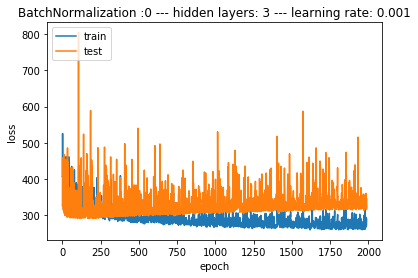

Train on 960 samples, validate on 241 samples
Epoch 1/2000
960/960 [==============================] - 4s 4ms/step - loss: 5381.7740 - val_loss: 1583.9121
Epoch 2/2000
960/960 [==============================] - 1s 613us/step - loss: 680.0217 - val_loss: 402.8406
Epoch 3/2000
960/960 [==============================] - 1s 654us/step - loss: 404.9841 - val_loss: 393.5086
Epoch 4/2000
960/960 [==============================] - 1s 661us/step - loss: 453.0968 - val_loss: 459.8711
Epoch 5/2000
960/960 [==============================] - 1s 655us/step - loss: 440.3677 - val_loss: 368.2061
Epoch 6/2000
960/960 [==============================] - 1s 645us/step - loss: 406.9541 - val_loss: 366.8385
Epoch 7/2000
960/960 [==============================] - 1s 651us/step - loss: 454.6198 - val_loss: 394.6815
Epoch 8/2000
960/960 [==============================] - 1s 651us/step - loss: 468.4986 - val_loss: 351.3062
Epoch 9/2000
960/960 [==============================] - 1s 645us/step - loss: 406.3070 - v

Epoch 76/2000
960/960 [==============================] - 1s 686us/step - loss: 323.7888 - val_loss: 322.4768
Epoch 77/2000
960/960 [==============================] - 1s 648us/step - loss: 334.9443 - val_loss: 355.1764
Epoch 78/2000
960/960 [==============================] - 1s 669us/step - loss: 342.0660 - val_loss: 295.2124
Epoch 79/2000
960/960 [==============================] - 1s 656us/step - loss: 354.6331 - val_loss: 468.7256
Epoch 80/2000
960/960 [==============================] - 1s 666us/step - loss: 397.9404 - val_loss: 299.0458
Epoch 81/2000
960/960 [==============================] - 1s 664us/step - loss: 349.3239 - val_loss: 298.6267
Epoch 82/2000
960/960 [==============================] - 1s 663us/step - loss: 319.5700 - val_loss: 353.2967
Epoch 83/2000
960/960 [==============================] - 1s 664us/step - loss: 353.4877 - val_loss: 299.7228
Epoch 84/2000
960/960 [==============================] - 1s 643us/step - loss: 362.7038 - val_loss: 303.8885
Epoch 85/2000
960/9

960/960 [==============================] - 1s 669us/step - loss: 367.5111 - val_loss: 341.5859
Epoch 151/2000
960/960 [==============================] - 1s 659us/step - loss: 335.5233 - val_loss: 310.5348
Epoch 152/2000
960/960 [==============================] - 1s 644us/step - loss: 333.5175 - val_loss: 307.2946
Epoch 153/2000
960/960 [==============================] - 1s 644us/step - loss: 332.2980 - val_loss: 300.3771
Epoch 154/2000
960/960 [==============================] - 1s 660us/step - loss: 338.9325 - val_loss: 346.1182
Epoch 155/2000
960/960 [==============================] - 1s 652us/step - loss: 384.4524 - val_loss: 551.5277
Epoch 156/2000
960/960 [==============================] - 1s 651us/step - loss: 368.3138 - val_loss: 379.8072
Epoch 157/2000
960/960 [==============================] - 1s 646us/step - loss: 339.2773 - val_loss: 292.7591
Epoch 158/2000
960/960 [==============================] - 1s 656us/step - loss: 321.9132 - val_loss: 328.9406
Epoch 159/2000
960/960 [=

960/960 [==============================] - 1s 691us/step - loss: 317.0872 - val_loss: 294.7202
Epoch 225/2000
960/960 [==============================] - 1s 664us/step - loss: 354.6382 - val_loss: 300.9615
Epoch 226/2000
960/960 [==============================] - 1s 646us/step - loss: 334.7656 - val_loss: 320.0202
Epoch 227/2000
960/960 [==============================] - 1s 656us/step - loss: 301.5922 - val_loss: 294.5717
Epoch 228/2000
960/960 [==============================] - 1s 665us/step - loss: 311.3593 - val_loss: 297.3602
Epoch 229/2000
960/960 [==============================] - 1s 662us/step - loss: 297.6633 - val_loss: 334.9203
Epoch 230/2000
960/960 [==============================] - 1s 660us/step - loss: 310.0506 - val_loss: 294.8749
Epoch 231/2000
960/960 [==============================] - 1s 655us/step - loss: 336.0132 - val_loss: 305.1219
Epoch 232/2000
960/960 [==============================] - 1s 665us/step - loss: 310.5397 - val_loss: 430.4734
Epoch 233/2000
960/960 [=

960/960 [==============================] - 1s 670us/step - loss: 311.7496 - val_loss: 424.8722
Epoch 299/2000
960/960 [==============================] - 1s 648us/step - loss: 311.6923 - val_loss: 305.6221
Epoch 300/2000
960/960 [==============================] - 1s 637us/step - loss: 293.3376 - val_loss: 301.1497
Epoch 301/2000
960/960 [==============================] - 1s 662us/step - loss: 342.5531 - val_loss: 316.6229
Epoch 302/2000
960/960 [==============================] - 1s 665us/step - loss: 303.9438 - val_loss: 295.1278
Epoch 303/2000
960/960 [==============================] - 1s 647us/step - loss: 319.6568 - val_loss: 327.3082
Epoch 304/2000
960/960 [==============================] - 1s 645us/step - loss: 311.6949 - val_loss: 412.1191
Epoch 305/2000
960/960 [==============================] - 1s 661us/step - loss: 373.8908 - val_loss: 297.5300
Epoch 306/2000
960/960 [==============================] - 1s 659us/step - loss: 296.1976 - val_loss: 330.2898
Epoch 307/2000
960/960 [=

960/960 [==============================] - 1s 692us/step - loss: 294.2399 - val_loss: 310.7603
Epoch 373/2000
960/960 [==============================] - 1s 648us/step - loss: 287.6515 - val_loss: 313.9779
Epoch 374/2000
960/960 [==============================] - 1s 636us/step - loss: 351.6197 - val_loss: 466.4863
Epoch 375/2000
960/960 [==============================] - 1s 645us/step - loss: 387.9701 - val_loss: 298.2723
Epoch 376/2000
960/960 [==============================] - 1s 651us/step - loss: 316.6090 - val_loss: 322.0839
Epoch 377/2000
960/960 [==============================] - 1s 648us/step - loss: 350.7905 - val_loss: 304.3737
Epoch 378/2000
960/960 [==============================] - 1s 645us/step - loss: 295.5115 - val_loss: 295.4049
Epoch 379/2000
960/960 [==============================] - 1s 646us/step - loss: 313.7006 - val_loss: 472.6086
Epoch 380/2000
960/960 [==============================] - 1s 656us/step - loss: 305.6230 - val_loss: 295.9689
Epoch 381/2000
960/960 [=

960/960 [==============================] - 1s 679us/step - loss: 338.4662 - val_loss: 334.8592
Epoch 447/2000
960/960 [==============================] - 1s 644us/step - loss: 315.3091 - val_loss: 465.7590
Epoch 448/2000
960/960 [==============================] - 1s 649us/step - loss: 373.7365 - val_loss: 408.4157
Epoch 449/2000
960/960 [==============================] - 1s 660us/step - loss: 311.2621 - val_loss: 296.7435
Epoch 450/2000
960/960 [==============================] - 1s 650us/step - loss: 293.2366 - val_loss: 342.7795
Epoch 451/2000
960/960 [==============================] - 1s 665us/step - loss: 299.2965 - val_loss: 333.5378
Epoch 452/2000
960/960 [==============================] - 1s 643us/step - loss: 284.5578 - val_loss: 369.3243
Epoch 453/2000
960/960 [==============================] - 1s 648us/step - loss: 314.7631 - val_loss: 343.8865
Epoch 454/2000
960/960 [==============================] - 1s 683us/step - loss: 300.7554 - val_loss: 347.7946
Epoch 455/2000
960/960 [=

960/960 [==============================] - 1s 667us/step - loss: 297.5596 - val_loss: 320.4708
Epoch 521/2000
960/960 [==============================] - 1s 656us/step - loss: 285.0484 - val_loss: 300.5996
Epoch 522/2000
960/960 [==============================] - 1s 643us/step - loss: 291.0929 - val_loss: 314.2891
Epoch 523/2000
960/960 [==============================] - 1s 650us/step - loss: 323.6029 - val_loss: 333.8691
Epoch 524/2000
960/960 [==============================] - 1s 644us/step - loss: 313.3225 - val_loss: 338.7817
Epoch 525/2000
960/960 [==============================] - 1s 643us/step - loss: 296.7687 - val_loss: 356.5625
Epoch 526/2000
960/960 [==============================] - 1s 642us/step - loss: 295.6771 - val_loss: 348.6236
Epoch 527/2000
960/960 [==============================] - 1s 662us/step - loss: 288.3105 - val_loss: 350.0229
Epoch 528/2000
960/960 [==============================] - 1s 654us/step - loss: 299.7263 - val_loss: 372.7744
Epoch 529/2000
960/960 [=

960/960 [==============================] - 1s 661us/step - loss: 305.3091 - val_loss: 368.3464
Epoch 595/2000
960/960 [==============================] - 1s 662us/step - loss: 336.7644 - val_loss: 350.6822
Epoch 596/2000
960/960 [==============================] - 1s 643us/step - loss: 285.5014 - val_loss: 332.6600
Epoch 597/2000
960/960 [==============================] - 1s 641us/step - loss: 285.5101 - val_loss: 300.5724
Epoch 598/2000
960/960 [==============================] - 1s 662us/step - loss: 285.4673 - val_loss: 336.5467
Epoch 599/2000
960/960 [==============================] - 1s 638us/step - loss: 295.0421 - val_loss: 317.1913
Epoch 600/2000
960/960 [==============================] - 1s 665us/step - loss: 283.7690 - val_loss: 309.3745
Epoch 601/2000
960/960 [==============================] - 1s 661us/step - loss: 302.0990 - val_loss: 363.6532
Epoch 602/2000
960/960 [==============================] - 1s 667us/step - loss: 315.1205 - val_loss: 303.9329
Epoch 603/2000
960/960 [=

960/960 [==============================] - 1s 674us/step - loss: 294.5943 - val_loss: 305.0515
Epoch 669/2000
960/960 [==============================] - 1s 659us/step - loss: 294.2316 - val_loss: 303.2462
Epoch 670/2000
960/960 [==============================] - 1s 629us/step - loss: 276.8508 - val_loss: 306.2603
Epoch 671/2000
960/960 [==============================] - 1s 666us/step - loss: 288.5548 - val_loss: 304.7669
Epoch 672/2000
960/960 [==============================] - 1s 648us/step - loss: 313.5181 - val_loss: 430.8245
Epoch 673/2000
960/960 [==============================] - 1s 643us/step - loss: 297.3210 - val_loss: 313.2959
Epoch 674/2000
960/960 [==============================] - 1s 661us/step - loss: 283.8954 - val_loss: 355.3450
Epoch 675/2000
960/960 [==============================] - 1s 665us/step - loss: 291.4202 - val_loss: 310.8359
Epoch 676/2000
960/960 [==============================] - 1s 675us/step - loss: 282.4755 - val_loss: 378.5101
Epoch 677/2000
960/960 [=

960/960 [==============================] - 1s 680us/step - loss: 282.7750 - val_loss: 305.3212
Epoch 743/2000
960/960 [==============================] - 1s 644us/step - loss: 286.6050 - val_loss: 381.6938
Epoch 744/2000
960/960 [==============================] - 1s 669us/step - loss: 296.5532 - val_loss: 305.1411
Epoch 745/2000
960/960 [==============================] - 1s 662us/step - loss: 279.5735 - val_loss: 303.9160
Epoch 746/2000
960/960 [==============================] - 1s 672us/step - loss: 276.2897 - val_loss: 307.6132
Epoch 747/2000
960/960 [==============================] - 1s 644us/step - loss: 279.5482 - val_loss: 320.8879
Epoch 748/2000
960/960 [==============================] - 1s 656us/step - loss: 284.8217 - val_loss: 309.2118
Epoch 749/2000
960/960 [==============================] - 1s 671us/step - loss: 283.3275 - val_loss: 324.1358
Epoch 750/2000
960/960 [==============================] - 1s 636us/step - loss: 315.6710 - val_loss: 304.9026
Epoch 751/2000
960/960 [=

960/960 [==============================] - 1s 674us/step - loss: 303.5406 - val_loss: 323.7313
Epoch 817/2000
960/960 [==============================] - 1s 641us/step - loss: 274.8725 - val_loss: 332.7404
Epoch 818/2000
960/960 [==============================] - 1s 661us/step - loss: 284.0968 - val_loss: 305.5158
Epoch 819/2000
960/960 [==============================] - 1s 651us/step - loss: 278.5646 - val_loss: 310.2024
Epoch 820/2000
960/960 [==============================] - 1s 644us/step - loss: 279.2995 - val_loss: 321.6177
Epoch 821/2000
960/960 [==============================] - 1s 645us/step - loss: 276.1317 - val_loss: 306.6510
Epoch 822/2000
960/960 [==============================] - 1s 659us/step - loss: 282.3187 - val_loss: 311.6222
Epoch 823/2000
960/960 [==============================] - 1s 651us/step - loss: 284.9293 - val_loss: 321.0386
Epoch 824/2000
960/960 [==============================] - 1s 653us/step - loss: 271.1507 - val_loss: 309.2951
Epoch 825/2000
960/960 [=

960/960 [==============================] - 1s 672us/step - loss: 310.0264 - val_loss: 314.5401
Epoch 891/2000
960/960 [==============================] - 1s 652us/step - loss: 276.1318 - val_loss: 327.5942
Epoch 892/2000
960/960 [==============================] - 1s 645us/step - loss: 289.3365 - val_loss: 309.0425
Epoch 893/2000
960/960 [==============================] - 1s 641us/step - loss: 287.2689 - val_loss: 307.6472
Epoch 894/2000
960/960 [==============================] - 1s 675us/step - loss: 275.3705 - val_loss: 311.0128
Epoch 895/2000
960/960 [==============================] - 1s 665us/step - loss: 290.2114 - val_loss: 338.9454
Epoch 896/2000
960/960 [==============================] - 1s 650us/step - loss: 298.1587 - val_loss: 318.6830
Epoch 897/2000
960/960 [==============================] - 1s 637us/step - loss: 286.2420 - val_loss: 306.6081
Epoch 898/2000
960/960 [==============================] - 1s 665us/step - loss: 279.6281 - val_loss: 348.5518
Epoch 899/2000
960/960 [=

960/960 [==============================] - 1s 665us/step - loss: 269.8946 - val_loss: 309.6475
Epoch 965/2000
960/960 [==============================] - 1s 654us/step - loss: 270.8073 - val_loss: 312.0145
Epoch 966/2000
960/960 [==============================] - 1s 662us/step - loss: 269.7258 - val_loss: 377.9189
Epoch 967/2000
960/960 [==============================] - 1s 669us/step - loss: 297.5664 - val_loss: 315.0242
Epoch 968/2000
960/960 [==============================] - 1s 664us/step - loss: 286.7636 - val_loss: 335.0617
Epoch 969/2000
960/960 [==============================] - 1s 660us/step - loss: 277.7379 - val_loss: 308.2597
Epoch 970/2000
960/960 [==============================] - 1s 654us/step - loss: 278.0198 - val_loss: 338.0000
Epoch 971/2000
960/960 [==============================] - 1s 655us/step - loss: 295.3367 - val_loss: 308.4889
Epoch 972/2000
960/960 [==============================] - 1s 650us/step - loss: 275.9652 - val_loss: 315.0385
Epoch 973/2000
960/960 [=

960/960 [==============================] - 1s 681us/step - loss: 294.6496 - val_loss: 321.0321
Epoch 1039/2000
960/960 [==============================] - 1s 652us/step - loss: 276.5935 - val_loss: 319.0251
Epoch 1040/2000
960/960 [==============================] - 1s 643us/step - loss: 273.0653 - val_loss: 308.7370
Epoch 1041/2000
960/960 [==============================] - 1s 652us/step - loss: 287.1129 - val_loss: 315.0248
Epoch 1042/2000
960/960 [==============================] - 1s 631us/step - loss: 313.0540 - val_loss: 309.7651
Epoch 1043/2000
960/960 [==============================] - 1s 639us/step - loss: 272.6244 - val_loss: 308.5816
Epoch 1044/2000
960/960 [==============================] - 1s 647us/step - loss: 273.0617 - val_loss: 322.1102
Epoch 1045/2000
960/960 [==============================] - 1s 662us/step - loss: 297.0729 - val_loss: 340.5222
Epoch 1046/2000
960/960 [==============================] - 1s 647us/step - loss: 294.9057 - val_loss: 367.0581
Epoch 1047/2000
9

Epoch 1112/2000
960/960 [==============================] - 1s 613us/step - loss: 278.4557 - val_loss: 310.7448
Epoch 1113/2000
960/960 [==============================] - 1s 617us/step - loss: 303.1548 - val_loss: 336.1108
Epoch 1114/2000
960/960 [==============================] - 1s 707us/step - loss: 279.0927 - val_loss: 313.9319
Epoch 1115/2000
960/960 [==============================] - 1s 670us/step - loss: 295.5360 - val_loss: 329.9804
Epoch 1116/2000
960/960 [==============================] - 1s 673us/step - loss: 288.3990 - val_loss: 306.6482
Epoch 1117/2000
960/960 [==============================] - 1s 695us/step - loss: 275.6734 - val_loss: 310.9998
Epoch 1118/2000
960/960 [==============================] - 1s 676us/step - loss: 268.9500 - val_loss: 316.0093
Epoch 1119/2000
960/960 [==============================] - 1s 680us/step - loss: 271.5719 - val_loss: 320.9943
Epoch 1120/2000
960/960 [==============================] - 1s 676us/step - loss: 276.4016 - val_loss: 363.7315
E

Epoch 1186/2000
960/960 [==============================] - 1s 662us/step - loss: 272.8802 - val_loss: 317.4071
Epoch 1187/2000
960/960 [==============================] - 1s 628us/step - loss: 285.8737 - val_loss: 340.2439
Epoch 1188/2000
960/960 [==============================] - 1s 646us/step - loss: 293.7535 - val_loss: 321.9187
Epoch 1189/2000
960/960 [==============================] - 1s 648us/step - loss: 279.1685 - val_loss: 319.3538
Epoch 1190/2000
960/960 [==============================] - 1s 642us/step - loss: 289.3222 - val_loss: 446.6164
Epoch 1191/2000
960/960 [==============================] - 1s 671us/step - loss: 282.4822 - val_loss: 310.1645
Epoch 1192/2000
960/960 [==============================] - 1s 654us/step - loss: 287.5004 - val_loss: 311.8379
Epoch 1193/2000
960/960 [==============================] - 1s 644us/step - loss: 287.1167 - val_loss: 311.4761
Epoch 1194/2000
960/960 [==============================] - 1s 669us/step - loss: 287.9684 - val_loss: 308.5153
E

Epoch 1260/2000
960/960 [==============================] - 1s 661us/step - loss: 297.2782 - val_loss: 309.0805
Epoch 1261/2000
960/960 [==============================] - 1s 654us/step - loss: 291.1562 - val_loss: 386.1784
Epoch 1262/2000
960/960 [==============================] - 1s 656us/step - loss: 290.8250 - val_loss: 310.1745
Epoch 1263/2000
960/960 [==============================] - 1s 647us/step - loss: 279.1715 - val_loss: 320.3093
Epoch 1264/2000
960/960 [==============================] - 1s 653us/step - loss: 270.0197 - val_loss: 326.9979
Epoch 1265/2000
960/960 [==============================] - 1s 644us/step - loss: 273.5422 - val_loss: 315.5834
Epoch 1266/2000
960/960 [==============================] - 1s 654us/step - loss: 273.8568 - val_loss: 335.6256
Epoch 1267/2000
960/960 [==============================] - 1s 632us/step - loss: 273.9944 - val_loss: 317.8383
Epoch 1268/2000
960/960 [==============================] - 1s 637us/step - loss: 270.1578 - val_loss: 318.0883
E

Epoch 1334/2000
960/960 [==============================] - 1s 676us/step - loss: 271.4296 - val_loss: 313.3619
Epoch 1335/2000
960/960 [==============================] - 1s 633us/step - loss: 273.8147 - val_loss: 327.0405
Epoch 1336/2000
960/960 [==============================] - 1s 652us/step - loss: 282.0686 - val_loss: 314.9298
Epoch 1337/2000
960/960 [==============================] - 1s 636us/step - loss: 269.0646 - val_loss: 313.5796
Epoch 1338/2000
960/960 [==============================] - 1s 650us/step - loss: 282.7562 - val_loss: 345.6545
Epoch 1339/2000
960/960 [==============================] - 1s 650us/step - loss: 283.9005 - val_loss: 312.7814
Epoch 1340/2000
960/960 [==============================] - 1s 671us/step - loss: 294.3574 - val_loss: 364.2382
Epoch 1341/2000
960/960 [==============================] - 1s 662us/step - loss: 295.5650 - val_loss: 369.7563
Epoch 1342/2000
960/960 [==============================] - 1s 640us/step - loss: 341.6182 - val_loss: 309.2080
E

Epoch 1408/2000
960/960 [==============================] - 1s 674us/step - loss: 288.5817 - val_loss: 313.7297
Epoch 1409/2000
960/960 [==============================] - 1s 673us/step - loss: 284.1834 - val_loss: 310.9180
Epoch 1410/2000
960/960 [==============================] - 1s 660us/step - loss: 270.8216 - val_loss: 312.7970
Epoch 1411/2000
960/960 [==============================] - 1s 649us/step - loss: 292.8337 - val_loss: 321.3402
Epoch 1412/2000
960/960 [==============================] - 1s 637us/step - loss: 323.7022 - val_loss: 387.5678
Epoch 1413/2000
960/960 [==============================] - 1s 660us/step - loss: 291.4832 - val_loss: 373.9847
Epoch 1414/2000
960/960 [==============================] - 1s 655us/step - loss: 270.3654 - val_loss: 317.4908
Epoch 1415/2000
960/960 [==============================] - 1s 646us/step - loss: 273.7622 - val_loss: 313.6042
Epoch 1416/2000
960/960 [==============================] - 1s 652us/step - loss: 305.6524 - val_loss: 494.3957
E

Epoch 1482/2000
960/960 [==============================] - 1s 668us/step - loss: 272.3636 - val_loss: 321.7896
Epoch 1483/2000
960/960 [==============================] - 1s 650us/step - loss: 269.3893 - val_loss: 319.7687
Epoch 1484/2000
960/960 [==============================] - 1s 633us/step - loss: 283.6738 - val_loss: 352.5574
Epoch 1485/2000
960/960 [==============================] - 1s 656us/step - loss: 303.9180 - val_loss: 338.5353
Epoch 1486/2000
960/960 [==============================] - 1s 655us/step - loss: 310.3917 - val_loss: 338.9249
Epoch 1487/2000
960/960 [==============================] - 1s 647us/step - loss: 295.3373 - val_loss: 320.4705
Epoch 1488/2000
960/960 [==============================] - 1s 653us/step - loss: 266.3964 - val_loss: 315.5684
Epoch 1489/2000
960/960 [==============================] - 1s 654us/step - loss: 265.1571 - val_loss: 372.1794
Epoch 1490/2000
960/960 [==============================] - 1s 666us/step - loss: 268.0595 - val_loss: 341.4886
E

960/960 [==============================] - 1s 691us/step - loss: 281.6224 - val_loss: 315.3095
Epoch 1556/2000
960/960 [==============================] - 1s 640us/step - loss: 287.2031 - val_loss: 447.3897
Epoch 1557/2000
960/960 [==============================] - 1s 653us/step - loss: 293.4053 - val_loss: 338.0955
Epoch 1558/2000
960/960 [==============================] - 1s 634us/step - loss: 286.2229 - val_loss: 321.3946
Epoch 1559/2000
960/960 [==============================] - 1s 659us/step - loss: 281.2503 - val_loss: 314.3270
Epoch 1560/2000
960/960 [==============================] - 1s 647us/step - loss: 268.7614 - val_loss: 344.8287
Epoch 1561/2000
960/960 [==============================] - 1s 650us/step - loss: 273.9260 - val_loss: 330.7630
Epoch 1562/2000
960/960 [==============================] - 1s 651us/step - loss: 277.4130 - val_loss: 316.8726
Epoch 1563/2000
960/960 [==============================] - 1s 644us/step - loss: 270.2618 - val_loss: 315.2406
Epoch 1564/2000
9

Epoch 1629/2000
960/960 [==============================] - 1s 708us/step - loss: 271.7903 - val_loss: 351.3690
Epoch 1630/2000
960/960 [==============================] - 1s 648us/step - loss: 264.6548 - val_loss: 358.2126
Epoch 1631/2000
960/960 [==============================] - 1s 660us/step - loss: 265.7702 - val_loss: 341.2789
Epoch 1632/2000
960/960 [==============================] - 1s 661us/step - loss: 275.1020 - val_loss: 319.0559
Epoch 1633/2000
960/960 [==============================] - 1s 679us/step - loss: 299.8459 - val_loss: 358.3147
Epoch 1634/2000
960/960 [==============================] - 1s 646us/step - loss: 285.3464 - val_loss: 314.1829
Epoch 1635/2000
960/960 [==============================] - 1s 639us/step - loss: 276.4406 - val_loss: 331.1258
Epoch 1636/2000
960/960 [==============================] - 1s 660us/step - loss: 275.5385 - val_loss: 351.3636
Epoch 1637/2000
960/960 [==============================] - 1s 637us/step - loss: 296.7566 - val_loss: 441.1233
E

Epoch 1703/2000
960/960 [==============================] - 1s 670us/step - loss: 267.3261 - val_loss: 344.0959
Epoch 1704/2000
960/960 [==============================] - 1s 644us/step - loss: 270.4957 - val_loss: 322.5054
Epoch 1705/2000
960/960 [==============================] - 1s 657us/step - loss: 280.1664 - val_loss: 380.9660
Epoch 1706/2000
960/960 [==============================] - 1s 650us/step - loss: 297.2148 - val_loss: 420.8569
Epoch 1707/2000
960/960 [==============================] - 1s 643us/step - loss: 301.0355 - val_loss: 326.5346
Epoch 1708/2000
960/960 [==============================] - 1s 635us/step - loss: 266.6465 - val_loss: 316.9711
Epoch 1709/2000
960/960 [==============================] - 1s 671us/step - loss: 271.7527 - val_loss: 332.9608
Epoch 1710/2000
960/960 [==============================] - 1s 633us/step - loss: 268.3080 - val_loss: 318.8238
Epoch 1711/2000
960/960 [==============================] - 1s 652us/step - loss: 284.6759 - val_loss: 366.9972
E

Epoch 1777/2000
960/960 [==============================] - 1s 650us/step - loss: 275.9047 - val_loss: 379.2498
Epoch 1778/2000
960/960 [==============================] - 1s 647us/step - loss: 282.4063 - val_loss: 317.6934
Epoch 1779/2000
960/960 [==============================] - 1s 642us/step - loss: 268.8473 - val_loss: 350.2529
Epoch 1780/2000
960/960 [==============================] - 1s 633us/step - loss: 269.6188 - val_loss: 354.1277
Epoch 1781/2000
960/960 [==============================] - 1s 641us/step - loss: 273.2647 - val_loss: 322.2987
Epoch 1782/2000
960/960 [==============================] - 1s 653us/step - loss: 277.7666 - val_loss: 318.5871
Epoch 1783/2000
960/960 [==============================] - 1s 650us/step - loss: 316.4351 - val_loss: 386.9877
Epoch 1784/2000
960/960 [==============================] - 1s 651us/step - loss: 296.8722 - val_loss: 351.9459
Epoch 1785/2000
960/960 [==============================] - 1s 641us/step - loss: 297.3742 - val_loss: 448.4586
E

Epoch 1851/2000
960/960 [==============================] - 1s 658us/step - loss: 272.6111 - val_loss: 322.4296
Epoch 1852/2000
960/960 [==============================] - 1s 646us/step - loss: 267.7770 - val_loss: 315.8742
Epoch 1853/2000
960/960 [==============================] - 1s 634us/step - loss: 269.0979 - val_loss: 322.4545
Epoch 1854/2000
960/960 [==============================] - 1s 642us/step - loss: 274.7778 - val_loss: 325.0901
Epoch 1855/2000
960/960 [==============================] - 1s 654us/step - loss: 272.7567 - val_loss: 381.2545
Epoch 1856/2000
960/960 [==============================] - 1s 638us/step - loss: 265.4884 - val_loss: 320.6409
Epoch 1857/2000
960/960 [==============================] - 1s 662us/step - loss: 265.6401 - val_loss: 338.6710
Epoch 1858/2000
960/960 [==============================] - 1s 661us/step - loss: 269.3676 - val_loss: 318.4917
Epoch 1859/2000
960/960 [==============================] - 1s 665us/step - loss: 259.9325 - val_loss: 322.1549
E

Epoch 1925/2000
960/960 [==============================] - 1s 679us/step - loss: 279.7038 - val_loss: 478.1183
Epoch 1926/2000
960/960 [==============================] - 1s 665us/step - loss: 290.1036 - val_loss: 323.1474
Epoch 1927/2000
960/960 [==============================] - 1s 663us/step - loss: 269.9255 - val_loss: 316.7856
Epoch 1928/2000
960/960 [==============================] - 1s 635us/step - loss: 267.2117 - val_loss: 319.3900
Epoch 1929/2000
960/960 [==============================] - 1s 646us/step - loss: 265.2889 - val_loss: 327.4876
Epoch 1930/2000
960/960 [==============================] - 1s 643us/step - loss: 271.7871 - val_loss: 335.1614
Epoch 1931/2000
960/960 [==============================] - 1s 673us/step - loss: 263.1671 - val_loss: 324.0950
Epoch 1932/2000
960/960 [==============================] - 1s 638us/step - loss: 269.7095 - val_loss: 349.2253
Epoch 1933/2000
960/960 [==============================] - 1s 657us/step - loss: 325.6308 - val_loss: 317.9448
E

960/960 [==============================] - 1s 680us/step - loss: 264.9520 - val_loss: 322.0656
Epoch 1999/2000
960/960 [==============================] - 1s 641us/step - loss: 264.5430 - val_loss: 326.3861
Epoch 2000/2000
960/960 [==============================] - 1s 648us/step - loss: 261.4832 - val_loss: 335.5316


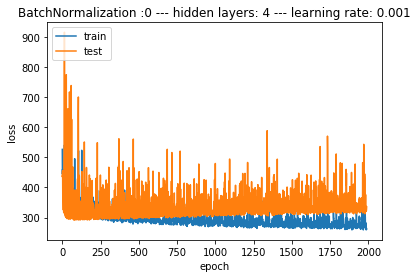

Train on 960 samples, validate on 241 samples
Epoch 1/2000
960/960 [==============================] - 4s 5ms/step - loss: 11222.9786 - val_loss: 368.8551
Epoch 2/2000
960/960 [==============================] - 1s 766us/step - loss: 1122.1150 - val_loss: 352.7808
Epoch 3/2000
960/960 [==============================] - 1s 755us/step - loss: 546.8802 - val_loss: 419.1482
Epoch 4/2000
960/960 [==============================] - 1s 779us/step - loss: 454.4116 - val_loss: 356.4385
Epoch 5/2000
960/960 [==============================] - 1s 785us/step - loss: 404.6928 - val_loss: 392.8863
Epoch 6/2000
960/960 [==============================] - 1s 766us/step - loss: 407.9432 - val_loss: 369.6308
Epoch 7/2000
960/960 [==============================] - 1s 755us/step - loss: 413.5876 - val_loss: 386.0903
Epoch 8/2000
960/960 [==============================] - 1s 808us/step - loss: 454.1659 - val_loss: 405.0561
Epoch 9/2000
960/960 [==============================] - 1s 788us/step - loss: 411.3586 - 

Epoch 76/2000
960/960 [==============================] - 1s 765us/step - loss: 342.8364 - val_loss: 301.1034
Epoch 77/2000
960/960 [==============================] - 1s 725us/step - loss: 337.7499 - val_loss: 306.2176
Epoch 78/2000
960/960 [==============================] - 1s 774us/step - loss: 315.7665 - val_loss: 313.1315
Epoch 79/2000
960/960 [==============================] - 1s 785us/step - loss: 354.8695 - val_loss: 400.7864
Epoch 80/2000
960/960 [==============================] - 1s 887us/step - loss: 335.8631 - val_loss: 378.8576
Epoch 81/2000
960/960 [==============================] - 1s 876us/step - loss: 393.8400 - val_loss: 293.3610
Epoch 82/2000
960/960 [==============================] - 1s 772us/step - loss: 378.8628 - val_loss: 321.6491
Epoch 83/2000
960/960 [==============================] - 1s 753us/step - loss: 375.8613 - val_loss: 294.8428
Epoch 84/2000
960/960 [==============================] - 1s 802us/step - loss: 364.0015 - val_loss: 371.0873
Epoch 85/2000
960/9

960/960 [==============================] - 1s 836us/step - loss: 319.2284 - val_loss: 292.7636
Epoch 151/2000
960/960 [==============================] - 1s 788us/step - loss: 352.0903 - val_loss: 302.1349
Epoch 152/2000
960/960 [==============================] - 1s 775us/step - loss: 369.9260 - val_loss: 292.8420
Epoch 153/2000
960/960 [==============================] - 1s 769us/step - loss: 316.9139 - val_loss: 296.1287
Epoch 154/2000
960/960 [==============================] - 1s 762us/step - loss: 319.7632 - val_loss: 302.9605
Epoch 155/2000
960/960 [==============================] - 1s 759us/step - loss: 311.7819 - val_loss: 327.2772
Epoch 156/2000
960/960 [==============================] - 1s 771us/step - loss: 355.4246 - val_loss: 530.5535
Epoch 157/2000
960/960 [==============================] - 1s 743us/step - loss: 384.5358 - val_loss: 309.2372
Epoch 158/2000
960/960 [==============================] - 1s 757us/step - loss: 339.2061 - val_loss: 302.8052
Epoch 159/2000
960/960 [=

960/960 [==============================] - 1s 839us/step - loss: 366.9435 - val_loss: 335.4282
Epoch 225/2000
960/960 [==============================] - 1s 779us/step - loss: 360.6764 - val_loss: 293.1824
Epoch 226/2000
960/960 [==============================] - 1s 763us/step - loss: 303.3335 - val_loss: 293.5270
Epoch 227/2000
960/960 [==============================] - 1s 757us/step - loss: 317.9234 - val_loss: 299.1547
Epoch 228/2000
960/960 [==============================] - 1s 778us/step - loss: 310.2729 - val_loss: 316.3142
Epoch 229/2000
960/960 [==============================] - 1s 769us/step - loss: 302.5515 - val_loss: 363.9094
Epoch 230/2000
960/960 [==============================] - 1s 746us/step - loss: 362.7957 - val_loss: 510.7189
Epoch 231/2000
960/960 [==============================] - 1s 785us/step - loss: 391.1880 - val_loss: 476.9909
Epoch 232/2000
960/960 [==============================] - 1s 757us/step - loss: 331.1970 - val_loss: 368.2994
Epoch 233/2000
960/960 [=

960/960 [==============================] - 1s 772us/step - loss: 301.1796 - val_loss: 295.3028
Epoch 299/2000
960/960 [==============================] - 1s 780us/step - loss: 310.5133 - val_loss: 318.9220
Epoch 300/2000
960/960 [==============================] - 1s 762us/step - loss: 343.7047 - val_loss: 423.3624
Epoch 301/2000
960/960 [==============================] - 1s 742us/step - loss: 351.5077 - val_loss: 295.5897
Epoch 302/2000
960/960 [==============================] - 1s 757us/step - loss: 331.3966 - val_loss: 335.7283
Epoch 303/2000
960/960 [==============================] - 1s 766us/step - loss: 346.0930 - val_loss: 294.0806
Epoch 304/2000
960/960 [==============================] - 1s 745us/step - loss: 331.8126 - val_loss: 300.7062
Epoch 305/2000
960/960 [==============================] - 1s 792us/step - loss: 324.5988 - val_loss: 296.9655
Epoch 306/2000
960/960 [==============================] - 1s 778us/step - loss: 325.7139 - val_loss: 301.9855
Epoch 307/2000
960/960 [=

960/960 [==============================] - 1s 812us/step - loss: 292.7922 - val_loss: 299.0449
Epoch 373/2000
960/960 [==============================] - 1s 754us/step - loss: 337.5450 - val_loss: 385.7808
Epoch 374/2000
960/960 [==============================] - 1s 744us/step - loss: 304.4413 - val_loss: 297.1307
Epoch 375/2000
960/960 [==============================] - 1s 757us/step - loss: 300.6542 - val_loss: 376.0550
Epoch 376/2000
960/960 [==============================] - 1s 761us/step - loss: 321.8939 - val_loss: 298.0746
Epoch 377/2000
960/960 [==============================] - 1s 746us/step - loss: 307.0144 - val_loss: 482.5370
Epoch 378/2000
960/960 [==============================] - 1s 767us/step - loss: 327.0530 - val_loss: 337.7568
Epoch 379/2000
960/960 [==============================] - 1s 772us/step - loss: 310.1809 - val_loss: 381.5647
Epoch 380/2000
960/960 [==============================] - 1s 781us/step - loss: 334.7015 - val_loss: 319.1155
Epoch 381/2000
960/960 [=

960/960 [==============================] - 1s 770us/step - loss: 365.9159 - val_loss: 347.0905
Epoch 447/2000
960/960 [==============================] - 1s 750us/step - loss: 322.5362 - val_loss: 336.2890
Epoch 448/2000
960/960 [==============================] - 1s 789us/step - loss: 301.3381 - val_loss: 298.5397
Epoch 449/2000
960/960 [==============================] - 1s 747us/step - loss: 306.3605 - val_loss: 331.6060
Epoch 450/2000
960/960 [==============================] - 1s 740us/step - loss: 317.0248 - val_loss: 295.9739
Epoch 451/2000
960/960 [==============================] - 1s 746us/step - loss: 314.8932 - val_loss: 364.3796
Epoch 452/2000
960/960 [==============================] - 1s 761us/step - loss: 346.9015 - val_loss: 299.7188
Epoch 453/2000
960/960 [==============================] - 1s 786us/step - loss: 341.0445 - val_loss: 305.8872
Epoch 454/2000
960/960 [==============================] - 1s 743us/step - loss: 335.2818 - val_loss: 429.8361
Epoch 455/2000
960/960 [=

960/960 [==============================] - 1s 769us/step - loss: 289.4165 - val_loss: 301.2884
Epoch 521/2000
960/960 [==============================] - 1s 768us/step - loss: 287.0859 - val_loss: 305.3147
Epoch 522/2000
960/960 [==============================] - 1s 782us/step - loss: 298.0113 - val_loss: 332.6973
Epoch 523/2000
960/960 [==============================] - 1s 784us/step - loss: 337.6012 - val_loss: 303.8560
Epoch 524/2000
960/960 [==============================] - 1s 798us/step - loss: 308.5210 - val_loss: 337.6436
Epoch 525/2000
960/960 [==============================] - 1s 825us/step - loss: 298.2302 - val_loss: 329.7888
Epoch 526/2000
960/960 [==============================] - 1s 815us/step - loss: 296.4017 - val_loss: 298.6627
Epoch 527/2000
960/960 [==============================] - 1s 812us/step - loss: 289.7860 - val_loss: 299.0174
Epoch 528/2000
960/960 [==============================] - 1s 832us/step - loss: 287.5151 - val_loss: 305.4578
Epoch 529/2000
960/960 [=

960/960 [==============================] - 1s 787us/step - loss: 293.6213 - val_loss: 326.1452
Epoch 595/2000
960/960 [==============================] - 1s 744us/step - loss: 303.6426 - val_loss: 298.6437
Epoch 596/2000
960/960 [==============================] - 1s 733us/step - loss: 290.3785 - val_loss: 301.6348
Epoch 597/2000
960/960 [==============================] - 1s 763us/step - loss: 287.4465 - val_loss: 424.4473
Epoch 598/2000
960/960 [==============================] - 1s 772us/step - loss: 312.5538 - val_loss: 300.5333
Epoch 599/2000
960/960 [==============================] - 1s 728us/step - loss: 287.1035 - val_loss: 320.0935
Epoch 600/2000
960/960 [==============================] - 1s 796us/step - loss: 284.0771 - val_loss: 303.8287
Epoch 601/2000
960/960 [==============================] - 1s 770us/step - loss: 301.3565 - val_loss: 377.4911
Epoch 602/2000
960/960 [==============================] - 1s 747us/step - loss: 300.9918 - val_loss: 337.5360
Epoch 603/2000
960/960 [=

960/960 [==============================] - 1s 805us/step - loss: 297.4995 - val_loss: 298.9425
Epoch 669/2000
960/960 [==============================] - 1s 740us/step - loss: 300.6216 - val_loss: 306.6389
Epoch 670/2000
960/960 [==============================] - 1s 760us/step - loss: 288.3142 - val_loss: 314.5774
Epoch 671/2000
960/960 [==============================] - 1s 770us/step - loss: 293.9587 - val_loss: 323.4568
Epoch 672/2000
960/960 [==============================] - 1s 755us/step - loss: 286.1475 - val_loss: 302.5722
Epoch 673/2000
960/960 [==============================] - 1s 758us/step - loss: 280.9667 - val_loss: 317.8125
Epoch 674/2000
960/960 [==============================] - 1s 777us/step - loss: 292.3243 - val_loss: 301.0792
Epoch 675/2000
960/960 [==============================] - 1s 740us/step - loss: 286.1460 - val_loss: 302.5063
Epoch 676/2000
960/960 [==============================] - 1s 780us/step - loss: 280.9662 - val_loss: 304.4732
Epoch 677/2000
960/960 [=

960/960 [==============================] - 1s 811us/step - loss: 302.1684 - val_loss: 350.0233
Epoch 743/2000
960/960 [==============================] - 1s 754us/step - loss: 314.9170 - val_loss: 340.8687
Epoch 744/2000
960/960 [==============================] - 1s 737us/step - loss: 283.6468 - val_loss: 331.5344
Epoch 745/2000
960/960 [==============================] - 1s 765us/step - loss: 296.9469 - val_loss: 300.4037
Epoch 746/2000
960/960 [==============================] - 1s 751us/step - loss: 290.6589 - val_loss: 368.0300
Epoch 747/2000
960/960 [==============================] - 1s 773us/step - loss: 308.0816 - val_loss: 325.7518
Epoch 748/2000
960/960 [==============================] - 1s 752us/step - loss: 295.2581 - val_loss: 321.2363
Epoch 749/2000
960/960 [==============================] - 1s 768us/step - loss: 293.9997 - val_loss: 305.0913
Epoch 750/2000
960/960 [==============================] - 1s 757us/step - loss: 281.1080 - val_loss: 337.7239
Epoch 751/2000
960/960 [=

960/960 [==============================] - 1s 807us/step - loss: 306.8852 - val_loss: 302.8143
Epoch 817/2000
960/960 [==============================] - 1s 764us/step - loss: 282.5139 - val_loss: 330.7684
Epoch 818/2000
960/960 [==============================] - 1s 770us/step - loss: 289.4996 - val_loss: 303.6549
Epoch 819/2000
960/960 [==============================] - 1s 792us/step - loss: 281.2419 - val_loss: 321.4315
Epoch 820/2000
960/960 [==============================] - 1s 780us/step - loss: 295.9842 - val_loss: 302.8454
Epoch 821/2000
960/960 [==============================] - 1s 766us/step - loss: 312.8030 - val_loss: 331.0477
Epoch 822/2000
960/960 [==============================] - 1s 769us/step - loss: 312.1503 - val_loss: 383.3191
Epoch 823/2000
960/960 [==============================] - 1s 794us/step - loss: 362.1049 - val_loss: 383.4746
Epoch 824/2000
960/960 [==============================] - 1s 764us/step - loss: 351.9934 - val_loss: 313.3895
Epoch 825/2000
960/960 [=

960/960 [==============================] - 1s 758us/step - loss: 304.7505 - val_loss: 330.6273
Epoch 891/2000
960/960 [==============================] - 1s 824us/step - loss: 286.4926 - val_loss: 304.2769
Epoch 892/2000
960/960 [==============================] - 1s 764us/step - loss: 297.7012 - val_loss: 305.8306
Epoch 893/2000
960/960 [==============================] - 1s 751us/step - loss: 328.2370 - val_loss: 303.0984
Epoch 894/2000
960/960 [==============================] - 1s 790us/step - loss: 280.5314 - val_loss: 304.0069
Epoch 895/2000
960/960 [==============================] - 1s 779us/step - loss: 327.3088 - val_loss: 321.2725
Epoch 896/2000
960/960 [==============================] - 1s 762us/step - loss: 301.9770 - val_loss: 327.9556
Epoch 897/2000
960/960 [==============================] - 1s 813us/step - loss: 282.0891 - val_loss: 347.0684
Epoch 898/2000
960/960 [==============================] - 1s 789us/step - loss: 284.8114 - val_loss: 339.8705
Epoch 899/2000
960/960 [=

960/960 [==============================] - 1s 787us/step - loss: 273.7483 - val_loss: 346.7635
Epoch 965/2000
960/960 [==============================] - 1s 754us/step - loss: 274.3229 - val_loss: 333.2935
Epoch 966/2000
960/960 [==============================] - 1s 786us/step - loss: 279.4292 - val_loss: 321.7675
Epoch 967/2000
960/960 [==============================] - 1s 781us/step - loss: 276.3375 - val_loss: 305.6980
Epoch 968/2000
960/960 [==============================] - 1s 735us/step - loss: 300.1780 - val_loss: 364.8128
Epoch 969/2000
960/960 [==============================] - 1s 783us/step - loss: 300.7653 - val_loss: 325.0836
Epoch 970/2000
960/960 [==============================] - 1s 799us/step - loss: 302.8304 - val_loss: 304.3158
Epoch 971/2000
960/960 [==============================] - 1s 813us/step - loss: 281.4147 - val_loss: 303.9192
Epoch 972/2000
960/960 [==============================] - 1s 783us/step - loss: 300.7460 - val_loss: 310.9600
Epoch 973/2000
960/960 [=

960/960 [==============================] - 1s 795us/step - loss: 301.0847 - val_loss: 328.1070
Epoch 1039/2000
960/960 [==============================] - 1s 775us/step - loss: 302.1285 - val_loss: 307.7880
Epoch 1040/2000
960/960 [==============================] - 1s 744us/step - loss: 309.2565 - val_loss: 312.3321
Epoch 1041/2000
960/960 [==============================] - 1s 779us/step - loss: 306.1132 - val_loss: 404.6829
Epoch 1042/2000
960/960 [==============================] - 1s 773us/step - loss: 304.2957 - val_loss: 401.0927
Epoch 1043/2000
960/960 [==============================] - 1s 738us/step - loss: 302.2129 - val_loss: 301.7711
Epoch 1044/2000
960/960 [==============================] - 1s 801us/step - loss: 312.1681 - val_loss: 299.9266
Epoch 1045/2000
960/960 [==============================] - 1s 778us/step - loss: 303.1385 - val_loss: 394.1297
Epoch 1046/2000
960/960 [==============================] - 1s 756us/step - loss: 295.8561 - val_loss: 333.8307
Epoch 1047/2000
9

Epoch 1112/2000
960/960 [==============================] - 1s 781us/step - loss: 330.9820 - val_loss: 305.6314
Epoch 1113/2000
960/960 [==============================] - 1s 746us/step - loss: 275.4179 - val_loss: 346.0585
Epoch 1114/2000
960/960 [==============================] - 1s 759us/step - loss: 301.6696 - val_loss: 305.5492
Epoch 1115/2000
960/960 [==============================] - 1s 740us/step - loss: 275.9579 - val_loss: 320.5988
Epoch 1116/2000
960/960 [==============================] - 1s 753us/step - loss: 274.7817 - val_loss: 303.0742
Epoch 1117/2000
960/960 [==============================] - 1s 757us/step - loss: 274.8101 - val_loss: 303.9789
Epoch 1118/2000
960/960 [==============================] - 1s 757us/step - loss: 275.6008 - val_loss: 320.7307
Epoch 1119/2000
960/960 [==============================] - 1s 764us/step - loss: 299.3182 - val_loss: 318.0494
Epoch 1120/2000
960/960 [==============================] - 1s 746us/step - loss: 288.3115 - val_loss: 303.9789
E

Epoch 1186/2000
960/960 [==============================] - 1s 797us/step - loss: 316.8107 - val_loss: 309.7355
Epoch 1187/2000
960/960 [==============================] - 1s 764us/step - loss: 283.2518 - val_loss: 302.7223
Epoch 1188/2000
960/960 [==============================] - 1s 794us/step - loss: 273.5342 - val_loss: 308.3991
Epoch 1189/2000
960/960 [==============================] - 1s 738us/step - loss: 276.0645 - val_loss: 305.6812
Epoch 1190/2000
960/960 [==============================] - 1s 791us/step - loss: 271.2289 - val_loss: 319.6370
Epoch 1191/2000
960/960 [==============================] - 1s 756us/step - loss: 280.1353 - val_loss: 309.7139
Epoch 1192/2000
960/960 [==============================] - 1s 762us/step - loss: 279.3632 - val_loss: 331.5825
Epoch 1193/2000
960/960 [==============================] - 1s 795us/step - loss: 273.8768 - val_loss: 346.8731
Epoch 1194/2000
960/960 [==============================] - 1s 744us/step - loss: 270.3905 - val_loss: 307.0311
E

Epoch 1260/2000
960/960 [==============================] - 1s 803us/step - loss: 285.2652 - val_loss: 345.5887
Epoch 1261/2000
960/960 [==============================] - 1s 783us/step - loss: 297.2634 - val_loss: 314.4675
Epoch 1262/2000
960/960 [==============================] - 1s 745us/step - loss: 337.7966 - val_loss: 308.2599
Epoch 1263/2000
960/960 [==============================] - 1s 787us/step - loss: 280.6661 - val_loss: 318.5292
Epoch 1264/2000
960/960 [==============================] - 1s 759us/step - loss: 270.6450 - val_loss: 307.6302
Epoch 1265/2000
960/960 [==============================] - 1s 764us/step - loss: 284.0546 - val_loss: 307.0169
Epoch 1266/2000
960/960 [==============================] - 1s 772us/step - loss: 270.2917 - val_loss: 314.0574
Epoch 1267/2000
960/960 [==============================] - 1s 791us/step - loss: 306.6211 - val_loss: 305.8245
Epoch 1268/2000
960/960 [==============================] - 1s 780us/step - loss: 280.3020 - val_loss: 322.3015
E

Epoch 1334/2000
960/960 [==============================] - 1s 790us/step - loss: 299.7210 - val_loss: 306.4364
Epoch 1335/2000
960/960 [==============================] - 1s 767us/step - loss: 277.6274 - val_loss: 316.6292
Epoch 1336/2000
960/960 [==============================] - 1s 744us/step - loss: 296.5662 - val_loss: 331.2396
Epoch 1337/2000
960/960 [==============================] - 1s 771us/step - loss: 288.2671 - val_loss: 405.2473
Epoch 1338/2000
960/960 [==============================] - 1s 757us/step - loss: 305.0599 - val_loss: 349.4253
Epoch 1339/2000
960/960 [==============================] - 1s 752us/step - loss: 284.3516 - val_loss: 308.4233
Epoch 1340/2000
960/960 [==============================] - 1s 760us/step - loss: 274.2173 - val_loss: 327.2805
Epoch 1341/2000
960/960 [==============================] - 1s 795us/step - loss: 275.6272 - val_loss: 311.2234
Epoch 1342/2000
960/960 [==============================] - 1s 803us/step - loss: 321.8918 - val_loss: 411.6067
E

Epoch 1408/2000
960/960 [==============================] - 1s 786us/step - loss: 282.0331 - val_loss: 357.7882
Epoch 1409/2000
960/960 [==============================] - 1s 757us/step - loss: 270.7067 - val_loss: 323.0244
Epoch 1410/2000
960/960 [==============================] - 1s 773us/step - loss: 271.4274 - val_loss: 313.4179
Epoch 1411/2000
960/960 [==============================] - 1s 760us/step - loss: 280.3341 - val_loss: 407.6654
Epoch 1412/2000
960/960 [==============================] - 1s 745us/step - loss: 275.1650 - val_loss: 378.5198
Epoch 1413/2000
960/960 [==============================] - 1s 762us/step - loss: 273.6162 - val_loss: 320.1773
Epoch 1414/2000
960/960 [==============================] - 1s 786us/step - loss: 288.7628 - val_loss: 331.3378
Epoch 1415/2000
960/960 [==============================] - 1s 750us/step - loss: 284.0788 - val_loss: 312.2138
Epoch 1416/2000
960/960 [==============================] - 1s 756us/step - loss: 272.2411 - val_loss: 361.0016
E

Epoch 1482/2000
960/960 [==============================] - 1s 829us/step - loss: 270.2271 - val_loss: 356.9025
Epoch 1483/2000
960/960 [==============================] - 1s 782us/step - loss: 306.2030 - val_loss: 338.7055
Epoch 1484/2000
960/960 [==============================] - 1s 764us/step - loss: 315.6798 - val_loss: 340.1780
Epoch 1485/2000
960/960 [==============================] - 1s 837us/step - loss: 336.0683 - val_loss: 331.1159
Epoch 1486/2000
960/960 [==============================] - 1s 833us/step - loss: 302.6201 - val_loss: 346.8943
Epoch 1487/2000
960/960 [==============================] - 1s 822us/step - loss: 274.8340 - val_loss: 309.1290
Epoch 1488/2000
960/960 [==============================] - 1s 799us/step - loss: 270.0003 - val_loss: 342.5970
Epoch 1489/2000
960/960 [==============================] - 1s 798us/step - loss: 282.4157 - val_loss: 316.0643
Epoch 1490/2000
960/960 [==============================] - 1s 798us/step - loss: 267.8102 - val_loss: 317.1318
E

Epoch 1556/2000
960/960 [==============================] - 1s 794us/step - loss: 294.5637 - val_loss: 331.4282
Epoch 1557/2000
960/960 [==============================] - 1s 808us/step - loss: 283.6365 - val_loss: 312.0413
Epoch 1558/2000
960/960 [==============================] - 1s 754us/step - loss: 296.3912 - val_loss: 319.2679
Epoch 1559/2000
960/960 [==============================] - 1s 760us/step - loss: 323.6933 - val_loss: 423.8650
Epoch 1560/2000
960/960 [==============================] - 1s 790us/step - loss: 319.6848 - val_loss: 496.1068
Epoch 1561/2000
960/960 [==============================] - 1s 772us/step - loss: 293.4745 - val_loss: 349.1610
Epoch 1562/2000
960/960 [==============================] - 1s 770us/step - loss: 280.2972 - val_loss: 357.2708
Epoch 1563/2000
960/960 [==============================] - 1s 760us/step - loss: 303.3176 - val_loss: 309.3510
Epoch 1564/2000
960/960 [==============================] - 1s 761us/step - loss: 275.6766 - val_loss: 314.6462
E

Epoch 1630/2000
960/960 [==============================] - 1s 774us/step - loss: 278.1135 - val_loss: 334.7481
Epoch 1631/2000
960/960 [==============================] - 1s 749us/step - loss: 271.5590 - val_loss: 355.0904
Epoch 1632/2000
960/960 [==============================] - 1s 762us/step - loss: 282.3378 - val_loss: 319.1415
Epoch 1633/2000
960/960 [==============================] - 1s 755us/step - loss: 292.8585 - val_loss: 321.8912
Epoch 1634/2000
960/960 [==============================] - 1s 772us/step - loss: 290.0906 - val_loss: 352.4828
Epoch 1635/2000
960/960 [==============================] - 1s 759us/step - loss: 285.2508 - val_loss: 347.8561
Epoch 1636/2000
960/960 [==============================] - 1s 764us/step - loss: 284.2145 - val_loss: 317.9377
Epoch 1637/2000
960/960 [==============================] - 1s 809us/step - loss: 285.5265 - val_loss: 333.1719
Epoch 1638/2000
960/960 [==============================] - 1s 769us/step - loss: 296.0817 - val_loss: 309.6855
E

Epoch 1704/2000
960/960 [==============================] - 1s 789us/step - loss: 289.8922 - val_loss: 308.9741
Epoch 1705/2000
960/960 [==============================] - 1s 806us/step - loss: 297.7605 - val_loss: 314.1501
Epoch 1706/2000
960/960 [==============================] - 1s 769us/step - loss: 277.0889 - val_loss: 336.5621
Epoch 1707/2000
960/960 [==============================] - 1s 749us/step - loss: 281.1608 - val_loss: 314.9999
Epoch 1708/2000
960/960 [==============================] - 1s 777us/step - loss: 265.9539 - val_loss: 319.5623
Epoch 1709/2000
960/960 [==============================] - 1s 753us/step - loss: 277.0882 - val_loss: 325.1350
Epoch 1710/2000
960/960 [==============================] - 1s 745us/step - loss: 317.7090 - val_loss: 352.0125
Epoch 1711/2000
960/960 [==============================] - 1s 759us/step - loss: 300.1715 - val_loss: 356.9289
Epoch 1712/2000
960/960 [==============================] - 1s 757us/step - loss: 304.5319 - val_loss: 328.8778
E

Epoch 1778/2000
960/960 [==============================] - 1s 792us/step - loss: 275.7921 - val_loss: 315.0038
Epoch 1779/2000
960/960 [==============================] - 1s 759us/step - loss: 270.5052 - val_loss: 314.6763
Epoch 1780/2000
960/960 [==============================] - 1s 773us/step - loss: 270.1469 - val_loss: 322.6137
Epoch 1781/2000
960/960 [==============================] - 1s 754us/step - loss: 265.4425 - val_loss: 329.2330
Epoch 1782/2000
960/960 [==============================] - 1s 776us/step - loss: 265.5151 - val_loss: 313.5929
Epoch 1783/2000
960/960 [==============================] - 1s 780us/step - loss: 272.1770 - val_loss: 322.5176
Epoch 1784/2000
960/960 [==============================] - 1s 767us/step - loss: 283.7153 - val_loss: 485.6046
Epoch 1785/2000
960/960 [==============================] - 1s 763us/step - loss: 307.9995 - val_loss: 349.9170
Epoch 1786/2000
960/960 [==============================] - 1s 768us/step - loss: 265.2709 - val_loss: 330.4594
E

Epoch 1852/2000
960/960 [==============================] - 1s 794us/step - loss: 276.3548 - val_loss: 326.7569
Epoch 1853/2000
960/960 [==============================] - 1s 789us/step - loss: 279.3019 - val_loss: 327.1769
Epoch 1854/2000
960/960 [==============================] - 1s 763us/step - loss: 275.5905 - val_loss: 382.7451
Epoch 1855/2000
960/960 [==============================] - 1s 740us/step - loss: 285.1086 - val_loss: 320.3066
Epoch 1856/2000
960/960 [==============================] - 1s 816us/step - loss: 272.6704 - val_loss: 313.4678
Epoch 1857/2000
960/960 [==============================] - 1s 764us/step - loss: 298.6137 - val_loss: 491.0932
Epoch 1858/2000
960/960 [==============================] - 1s 774us/step - loss: 327.9994 - val_loss: 312.7029
Epoch 1859/2000
960/960 [==============================] - 1s 747us/step - loss: 292.0048 - val_loss: 322.2039
Epoch 1860/2000
960/960 [==============================] - 1s 747us/step - loss: 292.5568 - val_loss: 329.5598
E

Epoch 1926/2000
960/960 [==============================] - 1s 802us/step - loss: 292.3557 - val_loss: 321.3153
Epoch 1927/2000
960/960 [==============================] - 1s 770us/step - loss: 286.6190 - val_loss: 374.2145
Epoch 1928/2000
960/960 [==============================] - 1s 796us/step - loss: 284.8680 - val_loss: 315.2629
Epoch 1929/2000
960/960 [==============================] - 1s 767us/step - loss: 270.7044 - val_loss: 324.8244
Epoch 1930/2000
960/960 [==============================] - 1s 793us/step - loss: 306.3539 - val_loss: 414.3051
Epoch 1931/2000
960/960 [==============================] - 1s 769us/step - loss: 277.4793 - val_loss: 355.5033
Epoch 1932/2000
960/960 [==============================] - 1s 747us/step - loss: 270.8719 - val_loss: 361.5866
Epoch 1933/2000
960/960 [==============================] - 1s 753us/step - loss: 268.7251 - val_loss: 327.7779
Epoch 1934/2000
960/960 [==============================] - 1s 763us/step - loss: 276.3363 - val_loss: 533.4480
E

Epoch 2000/2000
960/960 [==============================] - 1s 808us/step - loss: 271.6917 - val_loss: 315.8788


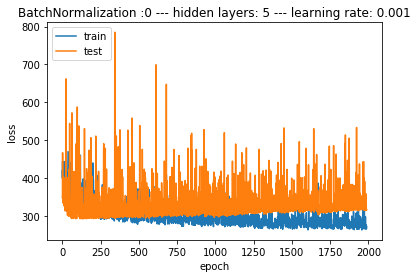

Train on 960 samples, validate on 241 samples
Epoch 1/2000
960/960 [==============================] - 5s 5ms/step - loss: 26609.7027 - val_loss: 21119.8852
Epoch 2/2000
960/960 [==============================] - 1s 866us/step - loss: 5698.2823 - val_loss: 590.2004
Epoch 3/2000
960/960 [==============================] - 1s 884us/step - loss: 1063.2277 - val_loss: 394.6818
Epoch 4/2000
960/960 [==============================] - 1s 888us/step - loss: 491.3634 - val_loss: 362.4876
Epoch 5/2000
960/960 [==============================] - 1s 872us/step - loss: 448.8701 - val_loss: 375.9483
Epoch 6/2000
960/960 [==============================] - 1s 916us/step - loss: 443.1790 - val_loss: 373.6378
Epoch 7/2000
960/960 [==============================] - 1s 878us/step - loss: 408.8993 - val_loss: 350.6653
Epoch 8/2000
960/960 [==============================] - 1s 889us/step - loss: 431.6245 - val_loss: 390.4186
Epoch 9/2000
960/960 [==============================] - 1s 885us/step - loss: 444.8874

Epoch 76/2000
960/960 [==============================] - 1s 892us/step - loss: 345.3427 - val_loss: 408.0571
Epoch 77/2000
960/960 [==============================] - 1s 879us/step - loss: 397.6247 - val_loss: 298.6284
Epoch 78/2000
960/960 [==============================] - 1s 892us/step - loss: 406.5052 - val_loss: 318.2375
Epoch 79/2000
960/960 [==============================] - 1s 867us/step - loss: 330.7437 - val_loss: 324.3854
Epoch 80/2000
960/960 [==============================] - 1s 868us/step - loss: 349.3812 - val_loss: 292.9695
Epoch 81/2000
960/960 [==============================] - 1s 884us/step - loss: 361.7624 - val_loss: 311.7595
Epoch 82/2000
960/960 [==============================] - 1s 823us/step - loss: 342.8566 - val_loss: 292.7333
Epoch 83/2000
960/960 [==============================] - 1s 868us/step - loss: 361.4271 - val_loss: 338.2766
Epoch 84/2000
960/960 [==============================] - 1s 890us/step - loss: 332.2349 - val_loss: 353.5088
Epoch 85/2000
960/9

960/960 [==============================] - 1s 891us/step - loss: 401.3451 - val_loss: 324.9842
Epoch 151/2000
960/960 [==============================] - 1s 886us/step - loss: 335.0111 - val_loss: 322.3234
Epoch 152/2000
960/960 [==============================] - 1s 868us/step - loss: 326.7301 - val_loss: 319.2169
Epoch 153/2000
960/960 [==============================] - 1s 863us/step - loss: 314.6385 - val_loss: 305.9751
Epoch 154/2000
960/960 [==============================] - 1s 875us/step - loss: 314.9888 - val_loss: 292.6568
Epoch 155/2000
960/960 [==============================] - 1s 867us/step - loss: 370.9381 - val_loss: 293.1257
Epoch 156/2000
960/960 [==============================] - 1s 889us/step - loss: 342.1975 - val_loss: 293.4898
Epoch 157/2000
960/960 [==============================] - 1s 878us/step - loss: 342.0686 - val_loss: 294.0762
Epoch 158/2000
960/960 [==============================] - 1s 901us/step - loss: 309.1845 - val_loss: 349.1038
Epoch 159/2000
960/960 [=

960/960 [==============================] - 1s 900us/step - loss: 417.7326 - val_loss: 294.8734
Epoch 225/2000
960/960 [==============================] - 1s 885us/step - loss: 383.2906 - val_loss: 296.6951
Epoch 226/2000
960/960 [==============================] - 1s 890us/step - loss: 331.1697 - val_loss: 311.9298
Epoch 227/2000
960/960 [==============================] - 1s 886us/step - loss: 322.4890 - val_loss: 294.3890
Epoch 228/2000
960/960 [==============================] - 1s 880us/step - loss: 310.8487 - val_loss: 400.8612
Epoch 229/2000
960/960 [==============================] - 1s 894us/step - loss: 316.5112 - val_loss: 294.8496
Epoch 230/2000
960/960 [==============================] - 1s 894us/step - loss: 334.6195 - val_loss: 296.9710
Epoch 231/2000
960/960 [==============================] - 1s 869us/step - loss: 318.8859 - val_loss: 388.9240
Epoch 232/2000
960/960 [==============================] - 1s 882us/step - loss: 326.9574 - val_loss: 383.8970
Epoch 233/2000
960/960 [=

960/960 [==============================] - 1s 893us/step - loss: 312.7406 - val_loss: 356.0126
Epoch 299/2000
960/960 [==============================] - 1s 891us/step - loss: 339.6518 - val_loss: 362.0734
Epoch 300/2000
960/960 [==============================] - 1s 898us/step - loss: 364.3206 - val_loss: 320.6472
Epoch 301/2000
960/960 [==============================] - 1s 880us/step - loss: 306.8581 - val_loss: 303.3518
Epoch 302/2000
960/960 [==============================] - 1s 888us/step - loss: 309.0953 - val_loss: 324.0161
Epoch 303/2000
960/960 [==============================] - 1s 900us/step - loss: 292.9118 - val_loss: 298.6519
Epoch 304/2000
960/960 [==============================] - 1s 899us/step - loss: 365.2305 - val_loss: 378.0531
Epoch 305/2000
960/960 [==============================] - 1s 861us/step - loss: 341.3907 - val_loss: 458.6401
Epoch 306/2000
960/960 [==============================] - 1s 874us/step - loss: 411.5757 - val_loss: 301.3765
Epoch 307/2000
960/960 [=

960/960 [==============================] - 1s 869us/step - loss: 355.7573 - val_loss: 327.2812
Epoch 373/2000
960/960 [==============================] - 1s 905us/step - loss: 319.7453 - val_loss: 297.0739
Epoch 374/2000
960/960 [==============================] - 1s 899us/step - loss: 294.4126 - val_loss: 305.6020
Epoch 375/2000
960/960 [==============================] - 1s 890us/step - loss: 287.8420 - val_loss: 310.0667
Epoch 376/2000
960/960 [==============================] - 1s 891us/step - loss: 299.4022 - val_loss: 302.3914
Epoch 377/2000
960/960 [==============================] - 1s 882us/step - loss: 297.0648 - val_loss: 308.3196
Epoch 378/2000
960/960 [==============================] - 1s 874us/step - loss: 299.5822 - val_loss: 307.1930
Epoch 379/2000
960/960 [==============================] - 1s 892us/step - loss: 291.8649 - val_loss: 304.3456
Epoch 380/2000
960/960 [==============================] - 1s 882us/step - loss: 290.1949 - val_loss: 315.5607
Epoch 381/2000
960/960 [=

960/960 [==============================] - 1s 926us/step - loss: 338.5000 - val_loss: 329.2971
Epoch 447/2000
960/960 [==============================] - 1s 892us/step - loss: 303.2333 - val_loss: 304.8427
Epoch 448/2000
960/960 [==============================] - 1s 879us/step - loss: 302.4572 - val_loss: 301.9533
Epoch 449/2000
960/960 [==============================] - 1s 880us/step - loss: 326.9867 - val_loss: 336.4515
Epoch 450/2000
960/960 [==============================] - 1s 884us/step - loss: 314.5015 - val_loss: 303.0088
Epoch 451/2000
960/960 [==============================] - 1s 896us/step - loss: 303.6949 - val_loss: 327.9154
Epoch 452/2000
960/960 [==============================] - 1s 923us/step - loss: 286.3910 - val_loss: 327.1087
Epoch 453/2000
960/960 [==============================] - 1s 887us/step - loss: 290.7745 - val_loss: 405.2376
Epoch 454/2000
960/960 [==============================] - 1s 863us/step - loss: 326.8178 - val_loss: 305.2507
Epoch 455/2000
960/960 [=

960/960 [==============================] - 1s 900us/step - loss: 292.5959 - val_loss: 322.1066
Epoch 521/2000
960/960 [==============================] - 1s 908us/step - loss: 287.7085 - val_loss: 302.6990
Epoch 522/2000
960/960 [==============================] - 1s 902us/step - loss: 294.2062 - val_loss: 374.0863
Epoch 523/2000
960/960 [==============================] - 1s 884us/step - loss: 312.3858 - val_loss: 321.5015
Epoch 524/2000
960/960 [==============================] - 1s 949us/step - loss: 355.3402 - val_loss: 307.6820
Epoch 525/2000
960/960 [==============================] - 1s 853us/step - loss: 345.3367 - val_loss: 300.6153
Epoch 526/2000
960/960 [==============================] - 1s 912us/step - loss: 319.4444 - val_loss: 307.5133
Epoch 527/2000
960/960 [==============================] - 1s 922us/step - loss: 281.7465 - val_loss: 304.3187
Epoch 528/2000
960/960 [==============================] - 1s 917us/step - loss: 290.3726 - val_loss: 301.3370
Epoch 529/2000
960/960 [=

960/960 [==============================] - 1s 868us/step - loss: 295.1855 - val_loss: 303.3764
Epoch 595/2000
960/960 [==============================] - 1s 890us/step - loss: 295.1902 - val_loss: 306.3881
Epoch 596/2000
960/960 [==============================] - 1s 889us/step - loss: 302.9534 - val_loss: 326.1418
Epoch 597/2000
960/960 [==============================] - 1s 902us/step - loss: 305.6918 - val_loss: 304.0659
Epoch 598/2000
960/960 [==============================] - 1s 891us/step - loss: 327.9864 - val_loss: 338.1314
Epoch 599/2000
960/960 [==============================] - 1s 883us/step - loss: 320.8350 - val_loss: 306.6908
Epoch 600/2000
960/960 [==============================] - 1s 904us/step - loss: 334.7361 - val_loss: 380.1014
Epoch 601/2000
960/960 [==============================] - 1s 901us/step - loss: 312.7464 - val_loss: 302.3692
Epoch 602/2000
960/960 [==============================] - 1s 872us/step - loss: 307.1286 - val_loss: 305.8003
Epoch 603/2000
960/960 [=

960/960 [==============================] - 1s 915us/step - loss: 282.8971 - val_loss: 312.3613
Epoch 669/2000
960/960 [==============================] - 1s 896us/step - loss: 285.4435 - val_loss: 325.8722
Epoch 670/2000
960/960 [==============================] - 1s 887us/step - loss: 299.9789 - val_loss: 342.3039
Epoch 671/2000
960/960 [==============================] - 1s 893us/step - loss: 293.3211 - val_loss: 325.0500
Epoch 672/2000
960/960 [==============================] - 1s 883us/step - loss: 294.6942 - val_loss: 315.7928
Epoch 673/2000
960/960 [==============================] - 1s 908us/step - loss: 277.9717 - val_loss: 308.3952
Epoch 674/2000
960/960 [==============================] - 1s 877us/step - loss: 283.4053 - val_loss: 318.2058
Epoch 675/2000
960/960 [==============================] - 1s 901us/step - loss: 282.3663 - val_loss: 308.6378
Epoch 676/2000
960/960 [==============================] - 1s 896us/step - loss: 304.4104 - val_loss: 496.6285
Epoch 677/2000
960/960 [=

960/960 [==============================] - 1s 881us/step - loss: 288.7959 - val_loss: 334.3242
Epoch 743/2000
960/960 [==============================] - 1s 884us/step - loss: 276.8665 - val_loss: 396.6412
Epoch 744/2000
960/960 [==============================] - 1s 928us/step - loss: 301.0685 - val_loss: 382.3685
Epoch 745/2000
960/960 [==============================] - 1s 894us/step - loss: 292.2874 - val_loss: 308.8257
Epoch 746/2000
960/960 [==============================] - 1s 882us/step - loss: 325.7154 - val_loss: 327.6517
Epoch 747/2000
960/960 [==============================] - 1s 884us/step - loss: 293.4467 - val_loss: 309.6562
Epoch 748/2000
960/960 [==============================] - 1s 924us/step - loss: 345.1602 - val_loss: 324.1307
Epoch 749/2000
960/960 [==============================] - 1s 860us/step - loss: 303.6533 - val_loss: 404.1573
Epoch 750/2000
960/960 [==============================] - 1s 914us/step - loss: 390.0792 - val_loss: 504.3729
Epoch 751/2000
960/960 [=

960/960 [==============================] - 1s 902us/step - loss: 300.7972 - val_loss: 366.2444
Epoch 817/2000
960/960 [==============================] - 1s 907us/step - loss: 329.2850 - val_loss: 333.9070
Epoch 818/2000
960/960 [==============================] - 1s 887us/step - loss: 281.0569 - val_loss: 319.3315
Epoch 819/2000
960/960 [==============================] - 1s 866us/step - loss: 314.5288 - val_loss: 520.2951
Epoch 820/2000
960/960 [==============================] - 1s 868us/step - loss: 322.0215 - val_loss: 339.4910
Epoch 821/2000
960/960 [==============================] - 1s 891us/step - loss: 296.6635 - val_loss: 306.9302
Epoch 822/2000
960/960 [==============================] - 1s 890us/step - loss: 283.4004 - val_loss: 312.3437
Epoch 823/2000
960/960 [==============================] - 1s 857us/step - loss: 297.3945 - val_loss: 329.2110
Epoch 824/2000
960/960 [==============================] - 1s 872us/step - loss: 342.4816 - val_loss: 396.7398
Epoch 825/2000
960/960 [=

960/960 [==============================] - 1s 898us/step - loss: 283.2307 - val_loss: 317.8751
Epoch 891/2000
960/960 [==============================] - 1s 869us/step - loss: 288.5572 - val_loss: 313.2642
Epoch 892/2000
960/960 [==============================] - 1s 894us/step - loss: 308.3515 - val_loss: 323.3057
Epoch 893/2000
960/960 [==============================] - 1s 889us/step - loss: 292.8912 - val_loss: 313.4985
Epoch 894/2000
960/960 [==============================] - 1s 892us/step - loss: 288.0512 - val_loss: 416.0440
Epoch 895/2000
960/960 [==============================] - 1s 883us/step - loss: 335.9732 - val_loss: 306.9612
Epoch 896/2000
960/960 [==============================] - 1s 859us/step - loss: 287.0417 - val_loss: 313.1861
Epoch 897/2000
960/960 [==============================] - 1s 876us/step - loss: 282.5892 - val_loss: 312.5837
Epoch 898/2000
960/960 [==============================] - 1s 890us/step - loss: 301.5591 - val_loss: 321.0950
Epoch 899/2000
960/960 [=

960/960 [==============================] - 1s 903us/step - loss: 340.6420 - val_loss: 335.0479
Epoch 965/2000
960/960 [==============================] - 1s 879us/step - loss: 320.2515 - val_loss: 338.8799
Epoch 966/2000
960/960 [==============================] - 1s 873us/step - loss: 275.3675 - val_loss: 310.4117
Epoch 967/2000
960/960 [==============================] - 1s 885us/step - loss: 300.5283 - val_loss: 453.7727
Epoch 968/2000
960/960 [==============================] - 1s 883us/step - loss: 326.7253 - val_loss: 335.7592
Epoch 969/2000
960/960 [==============================] - 1s 899us/step - loss: 306.9094 - val_loss: 379.8340
Epoch 970/2000
960/960 [==============================] - 1s 874us/step - loss: 286.2795 - val_loss: 313.8580
Epoch 971/2000
960/960 [==============================] - 1s 871us/step - loss: 279.9912 - val_loss: 318.4950
Epoch 972/2000
960/960 [==============================] - 1s 871us/step - loss: 309.7388 - val_loss: 368.3566
Epoch 973/2000
960/960 [=

960/960 [==============================] - 1s 925us/step - loss: 335.3049 - val_loss: 380.0009
Epoch 1039/2000
960/960 [==============================] - 1s 895us/step - loss: 299.9509 - val_loss: 332.1806
Epoch 1040/2000
960/960 [==============================] - 1s 920us/step - loss: 288.2589 - val_loss: 315.3575
Epoch 1041/2000
960/960 [==============================] - 1s 905us/step - loss: 300.6487 - val_loss: 367.9824
Epoch 1042/2000
960/960 [==============================] - 1s 876us/step - loss: 286.1619 - val_loss: 309.5241
Epoch 1043/2000
960/960 [==============================] - 1s 892us/step - loss: 279.6404 - val_loss: 318.2754
Epoch 1044/2000
960/960 [==============================] - 1s 876us/step - loss: 293.2129 - val_loss: 310.0661
Epoch 1045/2000
960/960 [==============================] - 1s 879us/step - loss: 294.4635 - val_loss: 368.5542
Epoch 1046/2000
960/960 [==============================] - 1s 861us/step - loss: 284.6332 - val_loss: 380.4243
Epoch 1047/2000
9

Epoch 1112/2000
960/960 [==============================] - 1s 897us/step - loss: 290.7699 - val_loss: 314.1291
Epoch 1113/2000
960/960 [==============================] - 1s 908us/step - loss: 303.0353 - val_loss: 311.6463
Epoch 1114/2000
960/960 [==============================] - 1s 886us/step - loss: 304.3725 - val_loss: 309.0372
Epoch 1115/2000
960/960 [==============================] - 1s 896us/step - loss: 288.9746 - val_loss: 371.0499
Epoch 1116/2000
960/960 [==============================] - 1s 876us/step - loss: 300.8985 - val_loss: 357.9638
Epoch 1117/2000
960/960 [==============================] - 1s 990us/step - loss: 350.7678 - val_loss: 314.7743
Epoch 1118/2000
960/960 [==============================] - 1s 907us/step - loss: 352.6721 - val_loss: 343.5688
Epoch 1119/2000
960/960 [==============================] - 1s 884us/step - loss: 333.6330 - val_loss: 438.8297
Epoch 1120/2000
960/960 [==============================] - 1s 918us/step - loss: 300.9941 - val_loss: 363.0924
E

Epoch 1186/2000
960/960 [==============================] - 1s 893us/step - loss: 293.4909 - val_loss: 357.4665
Epoch 1187/2000
960/960 [==============================] - 1s 853us/step - loss: 301.8007 - val_loss: 360.9420
Epoch 1188/2000
960/960 [==============================] - 1s 857us/step - loss: 310.2073 - val_loss: 357.1362
Epoch 1189/2000
960/960 [==============================] - 1s 882us/step - loss: 285.7298 - val_loss: 320.3571
Epoch 1190/2000
960/960 [==============================] - 1s 862us/step - loss: 274.8516 - val_loss: 359.3094
Epoch 1191/2000
960/960 [==============================] - 1s 886us/step - loss: 297.8171 - val_loss: 369.4724
Epoch 1192/2000
960/960 [==============================] - 1s 860us/step - loss: 287.3469 - val_loss: 354.2447
Epoch 1193/2000
960/960 [==============================] - 1s 849us/step - loss: 282.6029 - val_loss: 312.9512
Epoch 1194/2000
960/960 [==============================] - 1s 889us/step - loss: 276.5509 - val_loss: 317.9652
E

Epoch 1260/2000
960/960 [==============================] - 1s 832us/step - loss: 289.6762 - val_loss: 321.3834
Epoch 1261/2000
960/960 [==============================] - 1s 879us/step - loss: 273.4251 - val_loss: 313.6202
Epoch 1262/2000
960/960 [==============================] - 1s 895us/step - loss: 268.5882 - val_loss: 319.1591
Epoch 1263/2000
960/960 [==============================] - 1s 862us/step - loss: 273.5592 - val_loss: 318.0580
Epoch 1264/2000
960/960 [==============================] - 1s 886us/step - loss: 276.7718 - val_loss: 367.7197
Epoch 1265/2000
960/960 [==============================] - 1s 893us/step - loss: 283.5237 - val_loss: 328.0874
Epoch 1266/2000
960/960 [==============================] - 1s 857us/step - loss: 291.2747 - val_loss: 396.0440
Epoch 1267/2000
960/960 [==============================] - 1s 875us/step - loss: 299.0323 - val_loss: 314.5206
Epoch 1268/2000
960/960 [==============================] - 1s 894us/step - loss: 284.0663 - val_loss: 427.1994
E

Epoch 1334/2000
960/960 [==============================] - 1s 949us/step - loss: 275.2199 - val_loss: 333.8832
Epoch 1335/2000
960/960 [==============================] - 1s 935us/step - loss: 299.5738 - val_loss: 383.2057
Epoch 1336/2000
960/960 [==============================] - 1s 961us/step - loss: 278.1387 - val_loss: 419.5672
Epoch 1337/2000
960/960 [==============================] - 1s 939us/step - loss: 283.2396 - val_loss: 311.3750
Epoch 1338/2000
960/960 [==============================] - 1s 918us/step - loss: 298.5898 - val_loss: 380.5186
Epoch 1339/2000
960/960 [==============================] - 1s 950us/step - loss: 294.6822 - val_loss: 403.5752
Epoch 1340/2000
960/960 [==============================] - 1s 940us/step - loss: 316.4061 - val_loss: 346.6969
Epoch 1341/2000
960/960 [==============================] - 1s 938us/step - loss: 273.9753 - val_loss: 320.1355
Epoch 1342/2000
960/960 [==============================] - 1s 930us/step - loss: 277.1237 - val_loss: 323.0978
E

960/960 [==============================] - 1s 943us/step - loss: 276.7185 - val_loss: 368.2603
Epoch 1408/2000
960/960 [==============================] - 1s 876us/step - loss: 271.8833 - val_loss: 321.3449
Epoch 1409/2000
960/960 [==============================] - 1s 937us/step - loss: 296.8238 - val_loss: 468.1916
Epoch 1410/2000
960/960 [==============================] - 1s 912us/step - loss: 356.1900 - val_loss: 390.3063
Epoch 1411/2000
960/960 [==============================] - 1s 903us/step - loss: 316.0398 - val_loss: 315.1264
Epoch 1412/2000
960/960 [==============================] - 1s 923us/step - loss: 286.8238 - val_loss: 402.0373
Epoch 1413/2000
960/960 [==============================] - 1s 931us/step - loss: 280.5677 - val_loss: 412.8175
Epoch 1414/2000
960/960 [==============================] - 1s 894us/step - loss: 292.9888 - val_loss: 318.7168
Epoch 1415/2000
960/960 [==============================] - 1s 893us/step - loss: 290.0989 - val_loss: 357.4933
Epoch 1416/2000
9

Epoch 1481/2000
960/960 [==============================] - 1s 951us/step - loss: 280.5469 - val_loss: 324.6090
Epoch 1482/2000
960/960 [==============================] - 1s 891us/step - loss: 275.8672 - val_loss: 343.0676
Epoch 1483/2000
960/960 [==============================] - 1s 900us/step - loss: 292.6466 - val_loss: 345.5601
Epoch 1484/2000
960/960 [==============================] - 1s 903us/step - loss: 289.7843 - val_loss: 338.9594
Epoch 1485/2000
960/960 [==============================] - 1s 880us/step - loss: 291.5678 - val_loss: 317.9485
Epoch 1486/2000
960/960 [==============================] - 1s 915us/step - loss: 278.7543 - val_loss: 348.4370
Epoch 1487/2000
960/960 [==============================] - 1s 848us/step - loss: 280.9392 - val_loss: 394.9198
Epoch 1488/2000
960/960 [==============================] - 1s 895us/step - loss: 309.7525 - val_loss: 321.9130
Epoch 1489/2000
960/960 [==============================] - 1s 884us/step - loss: 315.8420 - val_loss: 375.9138
E

Epoch 1555/2000
960/960 [==============================] - 1s 889us/step - loss: 293.7765 - val_loss: 319.4681
Epoch 1556/2000
960/960 [==============================] - 1s 880us/step - loss: 300.7038 - val_loss: 390.4499
Epoch 1557/2000
960/960 [==============================] - 1s 871us/step - loss: 280.6292 - val_loss: 316.3350
Epoch 1558/2000
960/960 [==============================] - 1s 883us/step - loss: 271.1182 - val_loss: 326.1462
Epoch 1559/2000
960/960 [==============================] - 1s 888us/step - loss: 278.9332 - val_loss: 332.6081
Epoch 1560/2000
960/960 [==============================] - 1s 889us/step - loss: 310.2181 - val_loss: 391.7558
Epoch 1561/2000
960/960 [==============================] - 1s 877us/step - loss: 293.5335 - val_loss: 380.4461
Epoch 1562/2000
960/960 [==============================] - 1s 892us/step - loss: 270.7484 - val_loss: 315.3338
Epoch 1563/2000
960/960 [==============================] - 1s 878us/step - loss: 269.0039 - val_loss: 314.7488
E

Epoch 1629/2000
960/960 [==============================] - 1s 914us/step - loss: 293.1600 - val_loss: 336.7050
Epoch 1630/2000
960/960 [==============================] - 1s 880us/step - loss: 307.3175 - val_loss: 347.8303
Epoch 1631/2000
960/960 [==============================] - 1s 871us/step - loss: 287.0448 - val_loss: 390.5629
Epoch 1632/2000
960/960 [==============================] - 1s 874us/step - loss: 324.3701 - val_loss: 354.7013
Epoch 1633/2000
960/960 [==============================] - 1s 901us/step - loss: 299.5370 - val_loss: 377.4069
Epoch 1634/2000
960/960 [==============================] - 1s 876us/step - loss: 273.7559 - val_loss: 317.6497
Epoch 1635/2000
960/960 [==============================] - 1s 858us/step - loss: 301.3341 - val_loss: 315.8475
Epoch 1636/2000
960/960 [==============================] - 1s 885us/step - loss: 270.0326 - val_loss: 315.8825
Epoch 1637/2000
960/960 [==============================] - 1s 904us/step - loss: 270.8187 - val_loss: 314.3432
E

Epoch 1703/2000
960/960 [==============================] - 1s 917us/step - loss: 314.8655 - val_loss: 357.1032
Epoch 1704/2000
960/960 [==============================] - 1s 895us/step - loss: 281.4217 - val_loss: 326.6299
Epoch 1705/2000
960/960 [==============================] - 1s 867us/step - loss: 269.6470 - val_loss: 351.7818
Epoch 1706/2000
960/960 [==============================] - 1s 889us/step - loss: 265.7535 - val_loss: 345.9043
Epoch 1707/2000
960/960 [==============================] - 1s 885us/step - loss: 280.1537 - val_loss: 334.0486
Epoch 1708/2000
960/960 [==============================] - 1s 890us/step - loss: 295.3623 - val_loss: 318.4341
Epoch 1709/2000
960/960 [==============================] - 1s 864us/step - loss: 271.0699 - val_loss: 346.8741
Epoch 1710/2000
960/960 [==============================] - 1s 892us/step - loss: 278.0787 - val_loss: 316.8054
Epoch 1711/2000
960/960 [==============================] - 1s 885us/step - loss: 277.3795 - val_loss: 341.6552
E

960/960 [==============================] - 1s 925us/step - loss: 266.0360 - val_loss: 345.4759
Epoch 1777/2000
960/960 [==============================] - 1s 871us/step - loss: 270.8032 - val_loss: 350.2246
Epoch 1778/2000
960/960 [==============================] - 1s 869us/step - loss: 272.0274 - val_loss: 320.6480
Epoch 1779/2000
960/960 [==============================] - 1s 925us/step - loss: 268.7674 - val_loss: 319.0379
Epoch 1780/2000
960/960 [==============================] - 1s 869us/step - loss: 290.7361 - val_loss: 325.5319
Epoch 1781/2000
960/960 [==============================] - 1s 887us/step - loss: 290.7108 - val_loss: 321.0861
Epoch 1782/2000
960/960 [==============================] - 1s 901us/step - loss: 262.7599 - val_loss: 318.6522
Epoch 1783/2000
960/960 [==============================] - 1s 882us/step - loss: 270.9378 - val_loss: 320.1500
Epoch 1784/2000
960/960 [==============================] - 1s 874us/step - loss: 272.7005 - val_loss: 358.1154
Epoch 1785/2000
9

Epoch 1850/2000
960/960 [==============================] - 1s 904us/step - loss: 289.7298 - val_loss: 339.6978
Epoch 1851/2000
960/960 [==============================] - 1s 859us/step - loss: 278.0064 - val_loss: 319.0352
Epoch 1852/2000
960/960 [==============================] - 1s 892us/step - loss: 261.7890 - val_loss: 340.5183
Epoch 1853/2000
960/960 [==============================] - 1s 886us/step - loss: 269.8115 - val_loss: 344.3665
Epoch 1854/2000
960/960 [==============================] - 1s 884us/step - loss: 273.7747 - val_loss: 320.2605
Epoch 1855/2000
960/960 [==============================] - 1s 886us/step - loss: 275.2108 - val_loss: 323.8233
Epoch 1856/2000
960/960 [==============================] - 1s 888us/step - loss: 276.1590 - val_loss: 320.7965
Epoch 1857/2000
960/960 [==============================] - 1s 871us/step - loss: 263.2308 - val_loss: 326.2728
Epoch 1858/2000
960/960 [==============================] - 1s 888us/step - loss: 271.0328 - val_loss: 321.8689
E

960/960 [==============================] - 1s 907us/step - loss: 265.8754 - val_loss: 355.7646
Epoch 1924/2000
960/960 [==============================] - 1s 893us/step - loss: 275.6836 - val_loss: 323.3876
Epoch 1925/2000
960/960 [==============================] - 1s 892us/step - loss: 297.6822 - val_loss: 358.5805
Epoch 1926/2000
960/960 [==============================] - 1s 902us/step - loss: 277.2756 - val_loss: 323.6024
Epoch 1927/2000
960/960 [==============================] - 1s 843us/step - loss: 276.8681 - val_loss: 319.6598
Epoch 1928/2000
960/960 [==============================] - 1s 973us/step - loss: 274.0615 - val_loss: 318.6126
Epoch 1929/2000
960/960 [==============================] - 1s 910us/step - loss: 263.5400 - val_loss: 356.5068
Epoch 1930/2000
960/960 [==============================] - 1s 945us/step - loss: 284.8048 - val_loss: 360.7663
Epoch 1931/2000
960/960 [==============================] - 1s 909us/step - loss: 267.7648 - val_loss: 337.9239
Epoch 1932/2000
9

Epoch 1997/2000
960/960 [==============================] - 1s 928us/step - loss: 265.0870 - val_loss: 341.2900
Epoch 1998/2000
960/960 [==============================] - 1s 900us/step - loss: 305.4275 - val_loss: 347.6507
Epoch 1999/2000
960/960 [==============================] - 1s 876us/step - loss: 297.3845 - val_loss: 375.2491
Epoch 2000/2000
960/960 [==============================] - 1s 892us/step - loss: 282.0475 - val_loss: 319.6311


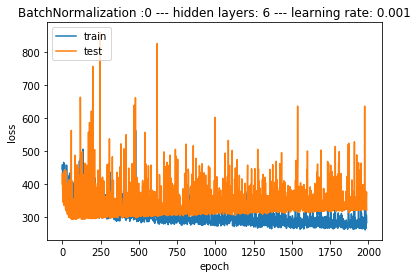

Train on 960 samples, validate on 241 samples
Epoch 1/2000
960/960 [==============================] - 4s 4ms/step - loss: 39213.0375 - val_loss: 15868.4400
Epoch 2/2000
960/960 [==============================] - 0s 112us/step - loss: 38923.2964 - val_loss: 11061.3597
Epoch 3/2000
960/960 [==============================] - 0s 110us/step - loss: 38501.5979 - val_loss: 10591.0088
Epoch 4/2000
960/960 [==============================] - 0s 114us/step - loss: 37851.0310 - val_loss: 10877.0731
Epoch 5/2000
960/960 [==============================] - 0s 119us/step - loss: 36922.7419 - val_loss: 11278.2969
Epoch 6/2000
960/960 [==============================] - 0s 115us/step - loss: 35689.9721 - val_loss: 11303.2583
Epoch 7/2000
960/960 [==============================] - 0s 112us/step - loss: 34148.4728 - val_loss: 10949.4193
Epoch 8/2000
960/960 [==============================] - 0s 110us/step - loss: 32321.5788 - val_loss: 10310.9354
Epoch 9/2000
960/960 [==============================] - 0s 1

960/960 [==============================] - 0s 109us/step - loss: 294.5595 - val_loss: 304.2362
Epoch 76/2000
960/960 [==============================] - 0s 124us/step - loss: 294.5062 - val_loss: 304.4621
Epoch 77/2000
960/960 [==============================] - 0s 117us/step - loss: 291.3428 - val_loss: 304.1604
Epoch 78/2000
960/960 [==============================] - 0s 117us/step - loss: 291.1153 - val_loss: 304.4637
Epoch 79/2000
960/960 [==============================] - 0s 124us/step - loss: 292.5485 - val_loss: 304.4119
Epoch 80/2000
960/960 [==============================] - 0s 116us/step - loss: 290.3820 - val_loss: 304.5930
Epoch 81/2000
960/960 [==============================] - 0s 111us/step - loss: 289.8866 - val_loss: 304.6181
Epoch 82/2000
960/960 [==============================] - 0s 114us/step - loss: 293.6975 - val_loss: 304.4374
Epoch 83/2000
960/960 [==============================] - 0s 112us/step - loss: 292.9781 - val_loss: 304.8503
Epoch 84/2000
960/960 [==========

Epoch 150/2000
960/960 [==============================] - 0s 110us/step - loss: 267.7883 - val_loss: 313.6402
Epoch 151/2000
960/960 [==============================] - 0s 118us/step - loss: 274.7008 - val_loss: 313.4467
Epoch 152/2000
960/960 [==============================] - 0s 112us/step - loss: 274.2280 - val_loss: 314.1028
Epoch 153/2000
960/960 [==============================] - 0s 111us/step - loss: 276.7244 - val_loss: 313.3104
Epoch 154/2000
960/960 [==============================] - 0s 113us/step - loss: 268.7964 - val_loss: 312.6717
Epoch 155/2000
960/960 [==============================] - 0s 114us/step - loss: 276.5049 - val_loss: 313.8936
Epoch 156/2000
960/960 [==============================] - 0s 115us/step - loss: 273.3319 - val_loss: 314.8930
Epoch 157/2000
960/960 [==============================] - 0s 113us/step - loss: 270.1499 - val_loss: 314.5533
Epoch 158/2000
960/960 [==============================] - 0s 111us/step - loss: 277.3964 - val_loss: 313.7463
Epoch 159/

960/960 [==============================] - 0s 110us/step - loss: 271.6679 - val_loss: 322.5993
Epoch 225/2000
960/960 [==============================] - 0s 121us/step - loss: 265.7426 - val_loss: 325.0391
Epoch 226/2000
960/960 [==============================] - 0s 117us/step - loss: 266.5375 - val_loss: 324.2042
Epoch 227/2000
960/960 [==============================] - 0s 109us/step - loss: 259.2438 - val_loss: 326.2130
Epoch 228/2000
960/960 [==============================] - 0s 119us/step - loss: 266.7775 - val_loss: 325.4707
Epoch 229/2000
960/960 [==============================] - 0s 113us/step - loss: 262.4121 - val_loss: 324.8807
Epoch 230/2000
960/960 [==============================] - 0s 120us/step - loss: 266.5182 - val_loss: 324.5465
Epoch 231/2000
960/960 [==============================] - 0s 107us/step - loss: 263.5283 - val_loss: 326.1459
Epoch 232/2000
960/960 [==============================] - 0s 110us/step - loss: 267.6146 - val_loss: 325.5010
Epoch 233/2000
960/960 [=

960/960 [==============================] - 0s 109us/step - loss: 262.7866 - val_loss: 331.1968
Epoch 299/2000
960/960 [==============================] - 0s 121us/step - loss: 258.9610 - val_loss: 334.3974
Epoch 300/2000
960/960 [==============================] - 0s 116us/step - loss: 263.6585 - val_loss: 333.1590
Epoch 301/2000
960/960 [==============================] - 0s 110us/step - loss: 261.3827 - val_loss: 335.3999
Epoch 302/2000
960/960 [==============================] - 0s 110us/step - loss: 261.7348 - val_loss: 331.4953
Epoch 303/2000
960/960 [==============================] - 0s 113us/step - loss: 266.7183 - val_loss: 336.4302
Epoch 304/2000
960/960 [==============================] - 0s 111us/step - loss: 267.5376 - val_loss: 332.0746
Epoch 305/2000
960/960 [==============================] - 0s 110us/step - loss: 265.8931 - val_loss: 338.2427
Epoch 306/2000
960/960 [==============================] - 0s 113us/step - loss: 261.0418 - val_loss: 335.8276
Epoch 307/2000
960/960 [=

960/960 [==============================] - 0s 118us/step - loss: 257.5973 - val_loss: 345.5831
Epoch 373/2000
960/960 [==============================] - 0s 126us/step - loss: 257.6558 - val_loss: 341.1662
Epoch 374/2000
960/960 [==============================] - 0s 110us/step - loss: 254.3699 - val_loss: 341.0365
Epoch 375/2000
960/960 [==============================] - 0s 120us/step - loss: 257.8036 - val_loss: 340.9107
Epoch 376/2000
960/960 [==============================] - 0s 113us/step - loss: 254.8094 - val_loss: 345.1160
Epoch 377/2000
960/960 [==============================] - 0s 111us/step - loss: 260.7586 - val_loss: 340.7649
Epoch 378/2000
960/960 [==============================] - 0s 112us/step - loss: 254.7351 - val_loss: 343.7465
Epoch 379/2000
960/960 [==============================] - 0s 114us/step - loss: 258.5170 - val_loss: 343.2986
Epoch 380/2000
960/960 [==============================] - 0s 115us/step - loss: 257.5854 - val_loss: 341.8715
Epoch 381/2000
960/960 [=

960/960 [==============================] - 0s 112us/step - loss: 262.1610 - val_loss: 348.2328
Epoch 447/2000
960/960 [==============================] - 0s 129us/step - loss: 253.9814 - val_loss: 343.9764
Epoch 448/2000
960/960 [==============================] - 0s 127us/step - loss: 259.3860 - val_loss: 347.9226
Epoch 449/2000
960/960 [==============================] - 0s 121us/step - loss: 264.6986 - val_loss: 344.7184
Epoch 450/2000
960/960 [==============================] - 0s 115us/step - loss: 253.3893 - val_loss: 348.3684
Epoch 451/2000
960/960 [==============================] - 0s 124us/step - loss: 253.5908 - val_loss: 346.7385
Epoch 452/2000
960/960 [==============================] - 0s 116us/step - loss: 255.8092 - val_loss: 346.5437
Epoch 453/2000
960/960 [==============================] - 0s 112us/step - loss: 262.4893 - val_loss: 346.9946
Epoch 454/2000
960/960 [==============================] - 0s 109us/step - loss: 256.6811 - val_loss: 344.8846
Epoch 455/2000
960/960 [=

960/960 [==============================] - 0s 122us/step - loss: 252.3454 - val_loss: 351.4255
Epoch 521/2000
960/960 [==============================] - 0s 138us/step - loss: 256.7595 - val_loss: 350.9676
Epoch 522/2000
960/960 [==============================] - 0s 111us/step - loss: 258.6205 - val_loss: 352.5984
Epoch 523/2000
960/960 [==============================] - 0s 112us/step - loss: 251.3335 - val_loss: 351.7507
Epoch 524/2000
960/960 [==============================] - 0s 112us/step - loss: 262.4252 - val_loss: 351.8540
Epoch 525/2000
960/960 [==============================] - 0s 109us/step - loss: 252.3984 - val_loss: 354.5162
Epoch 526/2000
960/960 [==============================] - 0s 119us/step - loss: 253.3206 - val_loss: 349.8449
Epoch 527/2000
960/960 [==============================] - 0s 110us/step - loss: 255.0830 - val_loss: 348.7611
Epoch 528/2000
960/960 [==============================] - 0s 107us/step - loss: 264.5482 - val_loss: 356.6667
Epoch 529/2000
960/960 [=

960/960 [==============================] - 0s 114us/step - loss: 248.2003 - val_loss: 356.5329
Epoch 595/2000
960/960 [==============================] - 0s 123us/step - loss: 252.2860 - val_loss: 352.3985
Epoch 596/2000
960/960 [==============================] - 0s 120us/step - loss: 251.0615 - val_loss: 354.4218
Epoch 597/2000
960/960 [==============================] - 0s 109us/step - loss: 254.8180 - val_loss: 355.7419
Epoch 598/2000
960/960 [==============================] - 0s 111us/step - loss: 254.1184 - val_loss: 355.1522
Epoch 599/2000
960/960 [==============================] - 0s 111us/step - loss: 252.6304 - val_loss: 353.8738
Epoch 600/2000
960/960 [==============================] - 0s 111us/step - loss: 258.1337 - val_loss: 348.7040
Epoch 601/2000
960/960 [==============================] - 0s 114us/step - loss: 253.1982 - val_loss: 358.9726
Epoch 602/2000
960/960 [==============================] - 0s 114us/step - loss: 253.1138 - val_loss: 354.6788
Epoch 603/2000
960/960 [=

960/960 [==============================] - 0s 110us/step - loss: 253.6667 - val_loss: 357.3951
Epoch 669/2000
960/960 [==============================] - 0s 116us/step - loss: 252.0568 - val_loss: 357.0401
Epoch 670/2000
960/960 [==============================] - 0s 113us/step - loss: 258.8655 - val_loss: 357.1636
Epoch 671/2000
960/960 [==============================] - 0s 112us/step - loss: 250.8313 - val_loss: 353.2116
Epoch 672/2000
960/960 [==============================] - 0s 113us/step - loss: 247.8203 - val_loss: 357.3089
Epoch 673/2000
960/960 [==============================] - 0s 110us/step - loss: 250.5450 - val_loss: 358.8950
Epoch 674/2000
960/960 [==============================] - 0s 112us/step - loss: 255.0449 - val_loss: 355.8701
Epoch 675/2000
960/960 [==============================] - 0s 110us/step - loss: 254.7496 - val_loss: 359.1051
Epoch 676/2000
960/960 [==============================] - 0s 115us/step - loss: 248.9842 - val_loss: 355.2417
Epoch 677/2000
960/960 [=

960/960 [==============================] - 0s 117us/step - loss: 249.8016 - val_loss: 356.1667
Epoch 743/2000
960/960 [==============================] - 0s 128us/step - loss: 250.3521 - val_loss: 356.6456
Epoch 744/2000
960/960 [==============================] - 0s 115us/step - loss: 254.4252 - val_loss: 355.3893
Epoch 745/2000
960/960 [==============================] - 0s 116us/step - loss: 249.5251 - val_loss: 357.2319
Epoch 746/2000
960/960 [==============================] - 0s 129us/step - loss: 252.5062 - val_loss: 362.0493
Epoch 747/2000
960/960 [==============================] - 0s 118us/step - loss: 249.7649 - val_loss: 356.1885
Epoch 748/2000
960/960 [==============================] - 0s 126us/step - loss: 247.5351 - val_loss: 357.0133
Epoch 749/2000
960/960 [==============================] - 0s 126us/step - loss: 250.3297 - val_loss: 360.1838
Epoch 750/2000
960/960 [==============================] - 0s 119us/step - loss: 251.7479 - val_loss: 358.6254
Epoch 751/2000
960/960 [=

960/960 [==============================] - 0s 115us/step - loss: 253.0080 - val_loss: 352.8143
Epoch 817/2000
960/960 [==============================] - 0s 121us/step - loss: 247.4982 - val_loss: 364.3656
Epoch 818/2000
960/960 [==============================] - 0s 115us/step - loss: 246.3870 - val_loss: 356.1455
Epoch 819/2000
960/960 [==============================] - 0s 116us/step - loss: 251.7486 - val_loss: 360.8066
Epoch 820/2000
960/960 [==============================] - 0s 111us/step - loss: 253.2154 - val_loss: 359.5450
Epoch 821/2000
960/960 [==============================] - 0s 112us/step - loss: 245.2300 - val_loss: 361.1954
Epoch 822/2000
960/960 [==============================] - 0s 114us/step - loss: 246.0619 - val_loss: 356.9054
Epoch 823/2000
960/960 [==============================] - 0s 115us/step - loss: 251.6897 - val_loss: 360.0339
Epoch 824/2000
960/960 [==============================] - 0s 118us/step - loss: 248.9458 - val_loss: 361.8144
Epoch 825/2000
960/960 [=

960/960 [==============================] - 0s 113us/step - loss: 247.2620 - val_loss: 361.1121
Epoch 891/2000
960/960 [==============================] - 0s 122us/step - loss: 251.0239 - val_loss: 362.1798
Epoch 892/2000
960/960 [==============================] - 0s 118us/step - loss: 248.1192 - val_loss: 358.1876
Epoch 893/2000
960/960 [==============================] - 0s 114us/step - loss: 244.7491 - val_loss: 361.1205
Epoch 894/2000
960/960 [==============================] - 0s 109us/step - loss: 252.5150 - val_loss: 360.0245
Epoch 895/2000
960/960 [==============================] - 0s 111us/step - loss: 245.6193 - val_loss: 358.8117
Epoch 896/2000
960/960 [==============================] - 0s 118us/step - loss: 247.6227 - val_loss: 361.2809
Epoch 897/2000
960/960 [==============================] - 0s 129us/step - loss: 246.4112 - val_loss: 358.6225
Epoch 898/2000
960/960 [==============================] - 0s 108us/step - loss: 249.9239 - val_loss: 360.7910
Epoch 899/2000
960/960 [=

960/960 [==============================] - 0s 122us/step - loss: 244.7394 - val_loss: 361.2604
Epoch 965/2000
960/960 [==============================] - 0s 130us/step - loss: 246.9270 - val_loss: 358.6113
Epoch 966/2000
960/960 [==============================] - 0s 113us/step - loss: 245.2437 - val_loss: 363.0971
Epoch 967/2000
960/960 [==============================] - 0s 114us/step - loss: 255.4211 - val_loss: 362.1766
Epoch 968/2000
960/960 [==============================] - 0s 135us/step - loss: 248.5019 - val_loss: 357.5010
Epoch 969/2000
960/960 [==============================] - 0s 118us/step - loss: 247.5260 - val_loss: 365.7548
Epoch 970/2000
960/960 [==============================] - 0s 129us/step - loss: 248.9010 - val_loss: 362.0453
Epoch 971/2000
960/960 [==============================] - 0s 111us/step - loss: 247.5803 - val_loss: 358.9129
Epoch 972/2000
960/960 [==============================] - 0s 113us/step - loss: 243.3920 - val_loss: 361.2429
Epoch 973/2000
960/960 [=

960/960 [==============================] - 0s 110us/step - loss: 245.1896 - val_loss: 363.9769
Epoch 1039/2000
960/960 [==============================] - 0s 124us/step - loss: 246.0966 - val_loss: 360.0106
Epoch 1040/2000
960/960 [==============================] - 0s 120us/step - loss: 250.2155 - val_loss: 361.7391
Epoch 1041/2000
960/960 [==============================] - 0s 124us/step - loss: 247.6502 - val_loss: 366.7901
Epoch 1042/2000
960/960 [==============================] - 0s 127us/step - loss: 246.7452 - val_loss: 359.5371
Epoch 1043/2000
960/960 [==============================] - 0s 111us/step - loss: 245.1994 - val_loss: 363.1262
Epoch 1044/2000
960/960 [==============================] - 0s 110us/step - loss: 244.4921 - val_loss: 364.0642
Epoch 1045/2000
960/960 [==============================] - 0s 110us/step - loss: 249.9685 - val_loss: 361.6408
Epoch 1046/2000
960/960 [==============================] - 0s 117us/step - loss: 251.6698 - val_loss: 360.8143
Epoch 1047/2000
9

Epoch 1112/2000
960/960 [==============================] - 0s 138us/step - loss: 245.0711 - val_loss: 360.6389
Epoch 1113/2000
960/960 [==============================] - 0s 107us/step - loss: 242.8840 - val_loss: 368.0244
Epoch 1114/2000
960/960 [==============================] - 0s 110us/step - loss: 252.1727 - val_loss: 359.5133
Epoch 1115/2000
960/960 [==============================] - 0s 108us/step - loss: 251.8541 - val_loss: 368.6937
Epoch 1116/2000
960/960 [==============================] - 0s 117us/step - loss: 250.7202 - val_loss: 360.6103
Epoch 1117/2000
960/960 [==============================] - 0s 129us/step - loss: 251.9803 - val_loss: 367.1675
Epoch 1118/2000
960/960 [==============================] - 0s 119us/step - loss: 244.0266 - val_loss: 367.3569
Epoch 1119/2000
960/960 [==============================] - 0s 112us/step - loss: 249.3371 - val_loss: 362.2822
Epoch 1120/2000
960/960 [==============================] - 0s 109us/step - loss: 247.7886 - val_loss: 368.5636
E

Epoch 1186/2000
960/960 [==============================] - 0s 121us/step - loss: 244.3092 - val_loss: 363.2442
Epoch 1187/2000
960/960 [==============================] - 0s 121us/step - loss: 245.8769 - val_loss: 367.8667
Epoch 1188/2000
960/960 [==============================] - 0s 122us/step - loss: 254.7878 - val_loss: 367.4540
Epoch 1189/2000
960/960 [==============================] - 0s 114us/step - loss: 246.5188 - val_loss: 360.7286
Epoch 1190/2000
960/960 [==============================] - 0s 108us/step - loss: 245.2376 - val_loss: 371.4041
Epoch 1191/2000
960/960 [==============================] - 0s 107us/step - loss: 246.7420 - val_loss: 363.1372
Epoch 1192/2000
960/960 [==============================] - 0s 108us/step - loss: 243.6679 - val_loss: 365.6050
Epoch 1193/2000
960/960 [==============================] - 0s 117us/step - loss: 242.3517 - val_loss: 365.9224
Epoch 1194/2000
960/960 [==============================] - 0s 113us/step - loss: 248.7969 - val_loss: 363.7479
E

Epoch 1260/2000
960/960 [==============================] - 0s 115us/step - loss: 244.9234 - val_loss: 362.3178
Epoch 1261/2000
960/960 [==============================] - 0s 136us/step - loss: 246.9442 - val_loss: 367.1617
Epoch 1262/2000
960/960 [==============================] - 0s 133us/step - loss: 249.5147 - val_loss: 363.7608
Epoch 1263/2000
960/960 [==============================] - 0s 119us/step - loss: 246.0191 - val_loss: 366.4499
Epoch 1264/2000
960/960 [==============================] - 0s 112us/step - loss: 251.2070 - val_loss: 366.1536
Epoch 1265/2000
960/960 [==============================] - 0s 107us/step - loss: 246.7994 - val_loss: 368.0953
Epoch 1266/2000
960/960 [==============================] - 0s 114us/step - loss: 240.3653 - val_loss: 363.8878
Epoch 1267/2000
960/960 [==============================] - 0s 110us/step - loss: 244.5631 - val_loss: 364.7118
Epoch 1268/2000
960/960 [==============================] - 0s 108us/step - loss: 248.6584 - val_loss: 366.0008
E

Epoch 1334/2000
960/960 [==============================] - 0s 112us/step - loss: 245.8592 - val_loss: 370.7251
Epoch 1335/2000
960/960 [==============================] - 0s 121us/step - loss: 247.1171 - val_loss: 362.0549
Epoch 1336/2000
960/960 [==============================] - 0s 113us/step - loss: 242.0537 - val_loss: 369.6749
Epoch 1337/2000
960/960 [==============================] - 0s 116us/step - loss: 254.2604 - val_loss: 364.7553
Epoch 1338/2000
960/960 [==============================] - 0s 120us/step - loss: 243.2691 - val_loss: 368.2564
Epoch 1339/2000
960/960 [==============================] - 0s 107us/step - loss: 251.1597 - val_loss: 365.6900
Epoch 1340/2000
960/960 [==============================] - 0s 113us/step - loss: 247.2011 - val_loss: 366.0404
Epoch 1341/2000
960/960 [==============================] - 0s 109us/step - loss: 241.0500 - val_loss: 368.9209
Epoch 1342/2000
960/960 [==============================] - 0s 105us/step - loss: 244.7760 - val_loss: 367.2413
E

Epoch 1408/2000
960/960 [==============================] - 0s 117us/step - loss: 243.0362 - val_loss: 373.4623
Epoch 1409/2000
960/960 [==============================] - 0s 114us/step - loss: 247.3079 - val_loss: 363.4574
Epoch 1410/2000
960/960 [==============================] - 0s 116us/step - loss: 247.1085 - val_loss: 372.8613
Epoch 1411/2000
960/960 [==============================] - 0s 112us/step - loss: 244.7501 - val_loss: 364.7069
Epoch 1412/2000
960/960 [==============================] - 0s 122us/step - loss: 249.7680 - val_loss: 365.5492
Epoch 1413/2000
960/960 [==============================] - 0s 113us/step - loss: 246.0239 - val_loss: 370.7272
Epoch 1414/2000
960/960 [==============================] - 0s 105us/step - loss: 243.7785 - val_loss: 366.6018
Epoch 1415/2000
960/960 [==============================] - 0s 107us/step - loss: 241.6255 - val_loss: 367.9041
Epoch 1416/2000
960/960 [==============================] - 0s 114us/step - loss: 239.7986 - val_loss: 370.2783
E

Epoch 1482/2000
960/960 [==============================] - 0s 105us/step - loss: 244.8227 - val_loss: 367.7169
Epoch 1483/2000
960/960 [==============================] - 0s 123us/step - loss: 246.7077 - val_loss: 368.0544
Epoch 1484/2000
960/960 [==============================] - 0s 117us/step - loss: 240.6512 - val_loss: 367.0035
Epoch 1485/2000
960/960 [==============================] - 0s 117us/step - loss: 241.5005 - val_loss: 365.4452
Epoch 1486/2000
960/960 [==============================] - 0s 121us/step - loss: 245.3848 - val_loss: 371.8712
Epoch 1487/2000
960/960 [==============================] - 0s 112us/step - loss: 237.9378 - val_loss: 365.1794
Epoch 1488/2000
960/960 [==============================] - 0s 111us/step - loss: 245.2297 - val_loss: 367.1047
Epoch 1489/2000
960/960 [==============================] - 0s 108us/step - loss: 244.3944 - val_loss: 363.3079
Epoch 1490/2000
960/960 [==============================] - 0s 114us/step - loss: 245.4314 - val_loss: 367.5046
E

Epoch 1556/2000
960/960 [==============================] - 0s 120us/step - loss: 249.1280 - val_loss: 366.9123
Epoch 1557/2000
960/960 [==============================] - 0s 139us/step - loss: 243.6277 - val_loss: 369.9497
Epoch 1558/2000
960/960 [==============================] - 0s 125us/step - loss: 241.6428 - val_loss: 366.7540
Epoch 1559/2000
960/960 [==============================] - 0s 110us/step - loss: 244.5514 - val_loss: 367.2732
Epoch 1560/2000
960/960 [==============================] - 0s 93us/step - loss: 245.4552 - val_loss: 370.9763
Epoch 1561/2000
960/960 [==============================] - 0s 102us/step - loss: 243.8674 - val_loss: 366.6153
Epoch 1562/2000
960/960 [==============================] - 0s 115us/step - loss: 244.5328 - val_loss: 368.9890
Epoch 1563/2000
960/960 [==============================] - 0s 111us/step - loss: 247.9871 - val_loss: 372.3042
Epoch 1564/2000
960/960 [==============================] - 0s 98us/step - loss: 245.5707 - val_loss: 367.9550
Epo

Epoch 1630/2000
960/960 [==============================] - 0s 107us/step - loss: 242.0857 - val_loss: 370.3450
Epoch 1631/2000
960/960 [==============================] - 0s 126us/step - loss: 247.0471 - val_loss: 367.2885
Epoch 1632/2000
960/960 [==============================] - 0s 114us/step - loss: 246.3885 - val_loss: 367.6888
Epoch 1633/2000
960/960 [==============================] - 0s 111us/step - loss: 241.5143 - val_loss: 371.3905
Epoch 1634/2000
960/960 [==============================] - 0s 112us/step - loss: 244.0349 - val_loss: 369.4313
Epoch 1635/2000
960/960 [==============================] - 0s 111us/step - loss: 245.7852 - val_loss: 369.7990
Epoch 1636/2000
960/960 [==============================] - 0s 113us/step - loss: 250.2936 - val_loss: 365.4821
Epoch 1637/2000
960/960 [==============================] - 0s 118us/step - loss: 241.2026 - val_loss: 375.5058
Epoch 1638/2000
960/960 [==============================] - 0s 121us/step - loss: 240.7428 - val_loss: 366.8835
E

Epoch 1704/2000
960/960 [==============================] - 0s 109us/step - loss: 243.6141 - val_loss: 374.9734
Epoch 1705/2000
960/960 [==============================] - 0s 132us/step - loss: 244.7583 - val_loss: 368.7928
Epoch 1706/2000
960/960 [==============================] - 0s 113us/step - loss: 241.2515 - val_loss: 367.2505
Epoch 1707/2000
960/960 [==============================] - 0s 109us/step - loss: 247.7836 - val_loss: 369.4858
Epoch 1708/2000
960/960 [==============================] - 0s 119us/step - loss: 245.4667 - val_loss: 366.4450
Epoch 1709/2000
960/960 [==============================] - 0s 108us/step - loss: 241.8754 - val_loss: 372.9613
Epoch 1710/2000
960/960 [==============================] - 0s 111us/step - loss: 246.5715 - val_loss: 366.8634
Epoch 1711/2000
960/960 [==============================] - 0s 108us/step - loss: 249.9929 - val_loss: 370.3487
Epoch 1712/2000
960/960 [==============================] - 0s 106us/step - loss: 245.2609 - val_loss: 370.1933
E

Epoch 1778/2000
960/960 [==============================] - 0s 112us/step - loss: 242.1837 - val_loss: 372.7581
Epoch 1779/2000
960/960 [==============================] - 0s 127us/step - loss: 249.0898 - val_loss: 365.2876
Epoch 1780/2000
960/960 [==============================] - 0s 111us/step - loss: 243.9989 - val_loss: 372.1410
Epoch 1781/2000
960/960 [==============================] - 0s 109us/step - loss: 242.8231 - val_loss: 365.4387
Epoch 1782/2000
960/960 [==============================] - 0s 109us/step - loss: 241.0039 - val_loss: 371.3621
Epoch 1783/2000
960/960 [==============================] - 0s 113us/step - loss: 242.1707 - val_loss: 370.7091
Epoch 1784/2000
960/960 [==============================] - 0s 108us/step - loss: 246.9308 - val_loss: 364.2039
Epoch 1785/2000
960/960 [==============================] - 0s 113us/step - loss: 244.0671 - val_loss: 375.4345
Epoch 1786/2000
960/960 [==============================] - 0s 118us/step - loss: 238.7069 - val_loss: 368.4641
E

Epoch 1852/2000
960/960 [==============================] - 0s 117us/step - loss: 238.1283 - val_loss: 369.7015
Epoch 1853/2000
960/960 [==============================] - 0s 125us/step - loss: 239.4047 - val_loss: 370.2459
Epoch 1854/2000
960/960 [==============================] - 0s 114us/step - loss: 243.2435 - val_loss: 367.7443
Epoch 1855/2000
960/960 [==============================] - 0s 113us/step - loss: 237.8876 - val_loss: 370.6666
Epoch 1856/2000
960/960 [==============================] - 0s 114us/step - loss: 237.9544 - val_loss: 368.6509
Epoch 1857/2000
960/960 [==============================] - 0s 109us/step - loss: 246.6698 - val_loss: 370.2679
Epoch 1858/2000
960/960 [==============================] - 0s 106us/step - loss: 240.9363 - val_loss: 368.3658
Epoch 1859/2000
960/960 [==============================] - 0s 112us/step - loss: 244.9920 - val_loss: 371.0965
Epoch 1860/2000
960/960 [==============================] - 0s 118us/step - loss: 243.1806 - val_loss: 369.5547
E

Epoch 1926/2000
960/960 [==============================] - 0s 113us/step - loss: 244.2828 - val_loss: 372.6169
Epoch 1927/2000
960/960 [==============================] - 0s 125us/step - loss: 247.2091 - val_loss: 370.7177
Epoch 1928/2000
960/960 [==============================] - 0s 119us/step - loss: 242.9362 - val_loss: 371.5911
Epoch 1929/2000
960/960 [==============================] - 0s 121us/step - loss: 244.3587 - val_loss: 369.7142
Epoch 1930/2000
960/960 [==============================] - 0s 108us/step - loss: 249.0038 - val_loss: 373.8578
Epoch 1931/2000
960/960 [==============================] - 0s 122us/step - loss: 244.7857 - val_loss: 371.5998
Epoch 1932/2000
960/960 [==============================] - 0s 114us/step - loss: 247.9147 - val_loss: 365.2651
Epoch 1933/2000
960/960 [==============================] - 0s 109us/step - loss: 242.8566 - val_loss: 375.7827
Epoch 1934/2000
960/960 [==============================] - 0s 126us/step - loss: 244.8540 - val_loss: 372.0578
E

Epoch 2000/2000
960/960 [==============================] - 0s 113us/step - loss: 247.5012 - val_loss: 366.6026


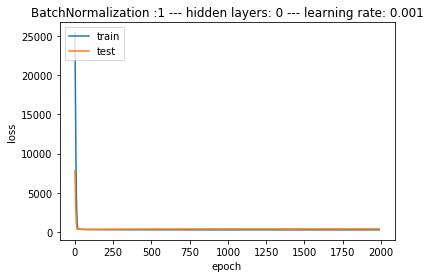

Train on 960 samples, validate on 241 samples
Epoch 1/2000
960/960 [==============================] - 4s 4ms/step - loss: 36167.3195 - val_loss: 61982.7809
Epoch 2/2000
960/960 [==============================] - 0s 331us/step - loss: 27895.1311 - val_loss: 529896.1761
Epoch 3/2000
960/960 [==============================] - 0s 326us/step - loss: 17306.4219 - val_loss: 1366301.7111
Epoch 4/2000
960/960 [==============================] - 0s 333us/step - loss: 7664.7719 - val_loss: 1655442.1369
Epoch 5/2000
960/960 [==============================] - 0s 350us/step - loss: 3166.5032 - val_loss: 904641.0324
Epoch 6/2000
960/960 [==============================] - 0s 355us/step - loss: 1798.7365 - val_loss: 375115.8937
Epoch 7/2000
960/960 [==============================] - 0s 335us/step - loss: 1212.6493 - val_loss: 220763.8100
Epoch 8/2000
960/960 [==============================] - 0s 347us/step - loss: 903.6282 - val_loss: 137132.5295
Epoch 9/2000
960/960 [==============================] - 0

Epoch 75/2000
960/960 [==============================] - 0s 343us/step - loss: 110.5049 - val_loss: 425.6671
Epoch 76/2000
960/960 [==============================] - 0s 351us/step - loss: 99.2734 - val_loss: 435.7920
Epoch 77/2000
960/960 [==============================] - 0s 337us/step - loss: 103.1807 - val_loss: 449.7234
Epoch 78/2000
960/960 [==============================] - 0s 360us/step - loss: 100.8768 - val_loss: 431.7126
Epoch 79/2000
960/960 [==============================] - 0s 346us/step - loss: 100.7097 - val_loss: 455.9860
Epoch 80/2000
960/960 [==============================] - 0s 338us/step - loss: 111.1244 - val_loss: 453.7691
Epoch 81/2000
960/960 [==============================] - 0s 355us/step - loss: 99.1162 - val_loss: 433.6243
Epoch 82/2000
960/960 [==============================] - 0s 347us/step - loss: 99.8477 - val_loss: 442.4209
Epoch 83/2000
960/960 [==============================] - 0s 339us/step - loss: 99.8739 - val_loss: 431.1714
Epoch 84/2000
960/960 [

960/960 [==============================] - 0s 374us/step - loss: 63.9029 - val_loss: 434.6633
Epoch 151/2000
960/960 [==============================] - 0s 343us/step - loss: 63.6648 - val_loss: 430.7019
Epoch 152/2000
960/960 [==============================] - 0s 367us/step - loss: 57.9062 - val_loss: 441.2968
Epoch 153/2000
960/960 [==============================] - 0s 355us/step - loss: 49.6010 - val_loss: 431.4716
Epoch 154/2000
960/960 [==============================] - 0s 343us/step - loss: 56.6709 - val_loss: 453.0669
Epoch 155/2000
960/960 [==============================] - 0s 355us/step - loss: 44.0384 - val_loss: 420.8473
Epoch 156/2000
960/960 [==============================] - 0s 345us/step - loss: 47.1255 - val_loss: 423.0185
Epoch 157/2000
960/960 [==============================] - 0s 337us/step - loss: 44.1415 - val_loss: 443.1913
Epoch 158/2000
960/960 [==============================] - 0s 362us/step - loss: 47.4948 - val_loss: 436.7519
Epoch 159/2000
960/960 [==========

960/960 [==============================] - 0s 352us/step - loss: 40.3214 - val_loss: 444.4001
Epoch 226/2000
960/960 [==============================] - 0s 347us/step - loss: 38.4613 - val_loss: 421.7111
Epoch 227/2000
960/960 [==============================] - 0s 331us/step - loss: 34.5153 - val_loss: 431.2071
Epoch 228/2000
960/960 [==============================] - 0s 354us/step - loss: 35.7453 - val_loss: 410.9005
Epoch 229/2000
960/960 [==============================] - 0s 348us/step - loss: 34.9733 - val_loss: 437.1990
Epoch 230/2000
960/960 [==============================] - 0s 355us/step - loss: 40.0745 - val_loss: 415.9674
Epoch 231/2000
960/960 [==============================] - 0s 352us/step - loss: 44.4055 - val_loss: 416.2417
Epoch 232/2000
960/960 [==============================] - 0s 357us/step - loss: 49.7263 - val_loss: 441.3458
Epoch 233/2000
960/960 [==============================] - 0s 359us/step - loss: 88.0225 - val_loss: 453.2789
Epoch 234/2000
960/960 [==========

960/960 [==============================] - 0s 359us/step - loss: 32.6512 - val_loss: 423.0192
Epoch 301/2000
960/960 [==============================] - 0s 354us/step - loss: 34.8371 - val_loss: 423.0817
Epoch 302/2000
960/960 [==============================] - 0s 359us/step - loss: 38.7661 - val_loss: 431.3409
Epoch 303/2000
960/960 [==============================] - 0s 352us/step - loss: 37.1147 - val_loss: 417.1984
Epoch 304/2000
960/960 [==============================] - 0s 369us/step - loss: 38.9855 - val_loss: 426.3144
Epoch 305/2000
960/960 [==============================] - 0s 343us/step - loss: 35.1105 - val_loss: 428.7766
Epoch 306/2000
960/960 [==============================] - 0s 339us/step - loss: 39.1993 - val_loss: 427.6256
Epoch 307/2000
960/960 [==============================] - 0s 357us/step - loss: 39.0169 - val_loss: 432.6474
Epoch 308/2000
960/960 [==============================] - 0s 344us/step - loss: 40.7069 - val_loss: 420.9848
Epoch 309/2000
960/960 [==========

960/960 [==============================] - 0s 353us/step - loss: 38.2476 - val_loss: 428.8620
Epoch 376/2000
960/960 [==============================] - 0s 430us/step - loss: 32.8090 - val_loss: 407.5639
Epoch 377/2000
960/960 [==============================] - 0s 406us/step - loss: 31.3072 - val_loss: 411.6375
Epoch 378/2000
960/960 [==============================] - 0s 350us/step - loss: 34.8874 - val_loss: 403.1853
Epoch 379/2000
960/960 [==============================] - 0s 391us/step - loss: 34.8292 - val_loss: 424.4362
Epoch 380/2000
960/960 [==============================] - 0s 388us/step - loss: 28.4277 - val_loss: 414.9126
Epoch 381/2000
960/960 [==============================] - 0s 390us/step - loss: 27.2808 - val_loss: 413.2695
Epoch 382/2000
960/960 [==============================] - 0s 391us/step - loss: 33.1990 - val_loss: 423.1869
Epoch 383/2000
960/960 [==============================] - 0s 389us/step - loss: 35.6207 - val_loss: 412.6623
Epoch 384/2000
960/960 [==========

960/960 [==============================] - 0s 364us/step - loss: 29.1896 - val_loss: 419.8675
Epoch 451/2000
960/960 [==============================] - 0s 374us/step - loss: 29.0617 - val_loss: 420.7207
Epoch 452/2000
960/960 [==============================] - 0s 391us/step - loss: 27.9302 - val_loss: 416.0455
Epoch 453/2000
960/960 [==============================] - 0s 367us/step - loss: 27.7116 - val_loss: 406.0411
Epoch 454/2000
960/960 [==============================] - 0s 390us/step - loss: 30.2313 - val_loss: 427.8859
Epoch 455/2000
960/960 [==============================] - 0s 391us/step - loss: 30.2076 - val_loss: 402.7070
Epoch 456/2000
960/960 [==============================] - 0s 375us/step - loss: 28.6997 - val_loss: 424.4859
Epoch 457/2000
960/960 [==============================] - 0s 382us/step - loss: 26.3261 - val_loss: 427.3710
Epoch 458/2000
960/960 [==============================] - 0s 378us/step - loss: 28.3059 - val_loss: 429.3977
Epoch 459/2000
960/960 [==========

960/960 [==============================] - 0s 363us/step - loss: 26.8045 - val_loss: 411.0106
Epoch 526/2000
960/960 [==============================] - 0s 348us/step - loss: 25.9718 - val_loss: 412.2366
Epoch 527/2000
960/960 [==============================] - 0s 349us/step - loss: 31.2217 - val_loss: 424.9338
Epoch 528/2000
960/960 [==============================] - 0s 370us/step - loss: 32.3697 - val_loss: 403.7811
Epoch 529/2000
960/960 [==============================] - 0s 379us/step - loss: 29.5981 - val_loss: 409.4853
Epoch 530/2000
960/960 [==============================] - 0s 355us/step - loss: 27.2852 - val_loss: 409.4308
Epoch 531/2000
960/960 [==============================] - 0s 357us/step - loss: 28.5839 - val_loss: 421.4037
Epoch 532/2000
960/960 [==============================] - 0s 337us/step - loss: 29.6016 - val_loss: 406.7300
Epoch 533/2000
960/960 [==============================] - 0s 340us/step - loss: 32.5184 - val_loss: 433.0766
Epoch 534/2000
960/960 [==========

960/960 [==============================] - 0s 367us/step - loss: 33.9422 - val_loss: 417.9546
Epoch 601/2000
960/960 [==============================] - 0s 340us/step - loss: 34.0747 - val_loss: 396.6208
Epoch 602/2000
960/960 [==============================] - 0s 355us/step - loss: 29.3985 - val_loss: 418.5765
Epoch 603/2000
960/960 [==============================] - 0s 361us/step - loss: 26.8492 - val_loss: 405.0495
Epoch 604/2000
960/960 [==============================] - 0s 342us/step - loss: 24.5971 - val_loss: 415.1131
Epoch 605/2000
960/960 [==============================] - 0s 353us/step - loss: 27.1444 - val_loss: 413.6537
Epoch 606/2000
960/960 [==============================] - 0s 383us/step - loss: 27.0254 - val_loss: 415.9106
Epoch 607/2000
960/960 [==============================] - 0s 343us/step - loss: 25.8926 - val_loss: 409.7218
Epoch 608/2000
960/960 [==============================] - 0s 350us/step - loss: 26.5168 - val_loss: 424.1885
Epoch 609/2000
960/960 [==========

960/960 [==============================] - 0s 409us/step - loss: 24.3079 - val_loss: 404.2538
Epoch 676/2000
960/960 [==============================] - 0s 346us/step - loss: 23.7758 - val_loss: 403.3145
Epoch 677/2000
960/960 [==============================] - 0s 350us/step - loss: 24.7089 - val_loss: 408.5485
Epoch 678/2000
960/960 [==============================] - 0s 367us/step - loss: 27.4090 - val_loss: 412.9135
Epoch 679/2000
960/960 [==============================] - 0s 341us/step - loss: 27.0169 - val_loss: 406.4946
Epoch 680/2000
960/960 [==============================] - 0s 311us/step - loss: 24.3326 - val_loss: 409.2518
Epoch 681/2000
960/960 [==============================] - 0s 358us/step - loss: 25.8807 - val_loss: 417.4406
Epoch 682/2000
960/960 [==============================] - 0s 356us/step - loss: 29.6617 - val_loss: 395.4777
Epoch 683/2000
960/960 [==============================] - 0s 325us/step - loss: 23.7720 - val_loss: 417.3897
Epoch 684/2000
960/960 [==========

960/960 [==============================] - 0s 335us/step - loss: 26.4571 - val_loss: 406.5788
Epoch 751/2000
960/960 [==============================] - 0s 395us/step - loss: 26.2191 - val_loss: 401.0492
Epoch 752/2000
960/960 [==============================] - 0s 384us/step - loss: 25.3013 - val_loss: 403.1812
Epoch 753/2000
960/960 [==============================] - 0s 350us/step - loss: 25.5254 - val_loss: 407.9323
Epoch 754/2000
960/960 [==============================] - 0s 353us/step - loss: 29.0888 - val_loss: 391.6876
Epoch 755/2000
960/960 [==============================] - 0s 342us/step - loss: 23.6286 - val_loss: 405.4564
Epoch 756/2000
960/960 [==============================] - 0s 341us/step - loss: 25.2816 - val_loss: 413.8603
Epoch 757/2000
960/960 [==============================] - 0s 349us/step - loss: 24.7108 - val_loss: 410.2489
Epoch 758/2000
960/960 [==============================] - 0s 381us/step - loss: 25.7087 - val_loss: 393.1616
Epoch 759/2000
960/960 [==========

960/960 [==============================] - 0s 401us/step - loss: 22.9628 - val_loss: 409.2343
Epoch 826/2000
960/960 [==============================] - 0s 344us/step - loss: 21.9691 - val_loss: 408.1290
Epoch 827/2000
960/960 [==============================] - 0s 341us/step - loss: 20.8179 - val_loss: 409.8534
Epoch 828/2000
960/960 [==============================] - 0s 364us/step - loss: 27.0206 - val_loss: 402.8455
Epoch 829/2000
960/960 [==============================] - 0s 362us/step - loss: 24.5296 - val_loss: 407.5839
Epoch 830/2000
960/960 [==============================] - 0s 368us/step - loss: 23.2139 - val_loss: 401.0719
Epoch 831/2000
960/960 [==============================] - 0s 375us/step - loss: 22.9413 - val_loss: 400.1235
Epoch 832/2000
960/960 [==============================] - 0s 390us/step - loss: 22.9403 - val_loss: 409.9690
Epoch 833/2000
960/960 [==============================] - 0s 350us/step - loss: 20.4048 - val_loss: 401.3951
Epoch 834/2000
960/960 [==========

960/960 [==============================] - 0s 261us/step - loss: 23.6391 - val_loss: 397.8174
Epoch 901/2000
960/960 [==============================] - 0s 264us/step - loss: 24.1146 - val_loss: 407.0971
Epoch 902/2000
960/960 [==============================] - 0s 273us/step - loss: 21.9875 - val_loss: 405.3367
Epoch 903/2000
960/960 [==============================] - 0s 275us/step - loss: 20.4241 - val_loss: 411.2431
Epoch 904/2000
960/960 [==============================] - 0s 283us/step - loss: 21.1443 - val_loss: 395.5857
Epoch 905/2000
960/960 [==============================] - 0s 275us/step - loss: 21.5993 - val_loss: 397.7277
Epoch 906/2000
960/960 [==============================] - 0s 279us/step - loss: 21.9038 - val_loss: 399.0587
Epoch 907/2000
960/960 [==============================] - 0s 300us/step - loss: 26.7832 - val_loss: 399.7126
Epoch 908/2000
960/960 [==============================] - 0s 267us/step - loss: 26.9382 - val_loss: 400.7896
Epoch 909/2000
960/960 [==========

960/960 [==============================] - 1s 551us/step - loss: 23.8346 - val_loss: 406.0134
Epoch 976/2000
960/960 [==============================] - 0s 309us/step - loss: 18.8307 - val_loss: 396.5292
Epoch 977/2000
960/960 [==============================] - 0s 385us/step - loss: 23.3974 - val_loss: 404.5664
Epoch 978/2000
960/960 [==============================] - 0s 415us/step - loss: 25.2894 - val_loss: 389.5844
Epoch 979/2000
960/960 [==============================] - 0s 279us/step - loss: 24.5803 - val_loss: 406.7133
Epoch 980/2000
960/960 [==============================] - 0s 304us/step - loss: 21.2114 - val_loss: 390.8479
Epoch 981/2000
960/960 [==============================] - 0s 344us/step - loss: 21.6116 - val_loss: 398.6082
Epoch 982/2000
960/960 [==============================] - 0s 289us/step - loss: 21.3518 - val_loss: 387.1851
Epoch 983/2000
960/960 [==============================] - 0s 283us/step - loss: 21.2195 - val_loss: 394.0478
Epoch 984/2000
960/960 [==========

KeyboardInterrupt: 

In [259]:
## Run several iterations
for lr in range(2):
    if lr == 0:
        lr = 0.01
    else:
        lr = 0.001
    for batchNormalization in range(2):
        for layers in range(7):
            model = generateModel(batchNormalization, layers, lr)
            history = model.fit(trn_input, trn_labels, validation_data=(val_input, val_labels), epochs=2000, batch_size=64)
            printHistory(history, batchNormalization, layers, lr)


In [261]:
def printHistory(history, batchNormalization, layers, lr):
    plt.plot(history.history['loss'][20:])
    plt.plot(history.history['val_loss'][20:])
    plt.title('BatchNormalization :' + str(batchNormalization) + " --- hidden layers: " + str(layers) + " --- learning rate: " + str(lr))
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()


BatchNormalization :0 --- hidden layers: 0 --- learning rate: 0.01
Train on 960 samples, validate on 241 samples
Epoch 1/100
960/960 [==============================] - 4s 4ms/step - loss: 18009.5819 - val_loss: 10060.9600
Epoch 2/100
960/960 [==============================] - 0s 93us/step - loss: 3765.5663 - val_loss: 1544.9806
Epoch 3/100
960/960 [==============================] - 0s 108us/step - loss: 1048.4726 - val_loss: 731.7539
Epoch 4/100
960/960 [==============================] - 0s 97us/step - loss: 557.2548 - val_loss: 400.2777
Epoch 5/100
960/960 [==============================] - 0s 103us/step - loss: 443.0110 - val_loss: 355.0616
Epoch 6/100
960/960 [==============================] - 0s 114us/step - loss: 427.9332 - val_loss: 350.8076
Epoch 7/100
960/960 [==============================] - 0s 97us/step - loss: 473.0026 - val_loss: 375.8241
Epoch 8/100
960/960 [==============================] - 0s 100us/step - loss: 428.5122 - val_loss: 347.3216
Epoch 9/100
960/960 [========

960/960 [==============================] - 0s 95us/step - loss: 405.4411 - val_loss: 615.8809
Epoch 77/100
960/960 [==============================] - 0s 94us/step - loss: 374.1883 - val_loss: 327.9715
Epoch 78/100
960/960 [==============================] - 0s 101us/step - loss: 313.0264 - val_loss: 314.2571
Epoch 79/100
960/960 [==============================] - 0s 96us/step - loss: 448.4290 - val_loss: 483.6957
Epoch 80/100
960/960 [==============================] - 0s 92us/step - loss: 389.9741 - val_loss: 703.6614
Epoch 81/100
960/960 [==============================] - 0s 106us/step - loss: 473.1342 - val_loss: 313.1436
Epoch 82/100
960/960 [==============================] - 0s 108us/step - loss: 345.2193 - val_loss: 307.3573
Epoch 83/100
960/960 [==============================] - 0s 95us/step - loss: 319.9304 - val_loss: 328.2240
Epoch 84/100
960/960 [==============================] - 0s 92us/step - loss: 383.4984 - val_loss: 470.9396
Epoch 85/100
960/960 [=========================

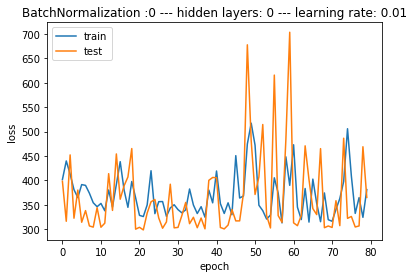

BatchNormalization :0 --- hidden layers: 1 --- learning rate: 0.01
Train on 960 samples, validate on 241 samples
Epoch 1/100
960/960 [==============================] - 4s 4ms/step - loss: 851604.8210 - val_loss: 9924.2371
Epoch 2/100
960/960 [==============================] - 0s 269us/step - loss: 2209.5712 - val_loss: 556.8855
Epoch 3/100
960/960 [==============================] - 0s 297us/step - loss: 493.9800 - val_loss: 365.0795
Epoch 4/100
960/960 [==============================] - 0s 294us/step - loss: 424.1696 - val_loss: 369.9279
Epoch 5/100
960/960 [==============================] - 0s 255us/step - loss: 434.4614 - val_loss: 501.4961
Epoch 6/100
960/960 [==============================] - 0s 287us/step - loss: 439.9430 - val_loss: 376.8751
Epoch 7/100
960/960 [==============================] - 0s 275us/step - loss: 428.3028 - val_loss: 354.0908
Epoch 8/100
960/960 [==============================] - 0s 277us/step - loss: 416.6318 - val_loss: 481.9166
Epoch 9/100
960/960 [=======

Epoch 76/100
960/960 [==============================] - 0s 302us/step - loss: 372.6665 - val_loss: 296.4595
Epoch 77/100
960/960 [==============================] - 0s 328us/step - loss: 325.9480 - val_loss: 394.1319
Epoch 78/100
960/960 [==============================] - 0s 276us/step - loss: 378.5523 - val_loss: 343.1713
Epoch 79/100
960/960 [==============================] - 0s 273us/step - loss: 360.5956 - val_loss: 328.0353
Epoch 80/100
960/960 [==============================] - 0s 292us/step - loss: 338.2358 - val_loss: 295.1226
Epoch 81/100
960/960 [==============================] - 0s 296us/step - loss: 318.8401 - val_loss: 296.2794
Epoch 82/100
960/960 [==============================] - 0s 279us/step - loss: 321.2647 - val_loss: 317.0361
Epoch 83/100
960/960 [==============================] - 0s 291us/step - loss: 348.6325 - val_loss: 294.9751
Epoch 84/100
960/960 [==============================] - 0s 274us/step - loss: 327.6733 - val_loss: 324.9786
Epoch 85/100
960/960 [======

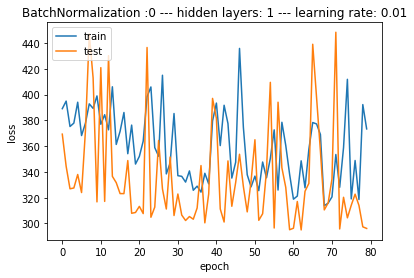

BatchNormalization :0 --- hidden layers: 2 --- learning rate: 0.01
Train on 960 samples, validate on 241 samples
Epoch 1/100
960/960 [==============================] - 4s 4ms/step - loss: 705569.7868 - val_loss: 5968.6088
Epoch 2/100
960/960 [==============================] - 0s 266us/step - loss: 1702.6567 - val_loss: 472.3999
Epoch 3/100
960/960 [==============================] - 0s 262us/step - loss: 493.1147 - val_loss: 565.8049
Epoch 4/100
960/960 [==============================] - 0s 285us/step - loss: 496.1465 - val_loss: 341.8898
Epoch 5/100
960/960 [==============================] - 0s 339us/step - loss: 419.4668 - val_loss: 343.4601
Epoch 6/100
960/960 [==============================] - 0s 268us/step - loss: 400.9073 - val_loss: 346.7322
Epoch 7/100
960/960 [==============================] - 0s 273us/step - loss: 393.4210 - val_loss: 360.5632
Epoch 8/100
960/960 [==============================] - 0s 299us/step - loss: 394.6255 - val_loss: 339.1270
Epoch 9/100
960/960 [=======

Epoch 76/100
960/960 [==============================] - 0s 304us/step - loss: 344.4379 - val_loss: 292.1982
Epoch 77/100
960/960 [==============================] - 0s 270us/step - loss: 339.1275 - val_loss: 296.2919
Epoch 78/100
960/960 [==============================] - 0s 294us/step - loss: 329.3607 - val_loss: 440.2188
Epoch 79/100
960/960 [==============================] - 0s 254us/step - loss: 364.1825 - val_loss: 299.8592
Epoch 80/100
960/960 [==============================] - 0s 261us/step - loss: 344.0598 - val_loss: 291.7345
Epoch 81/100
960/960 [==============================] - 0s 264us/step - loss: 329.9552 - val_loss: 292.4601
Epoch 82/100
960/960 [==============================] - 0s 293us/step - loss: 359.5287 - val_loss: 294.2281
Epoch 83/100
960/960 [==============================] - 0s 257us/step - loss: 319.1869 - val_loss: 294.8918
Epoch 84/100
960/960 [==============================] - 0s 304us/step - loss: 319.3871 - val_loss: 295.1584
Epoch 85/100
960/960 [======

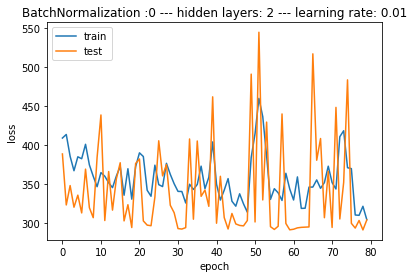

BatchNormalization :0 --- hidden layers: 3 --- learning rate: 0.01
Train on 960 samples, validate on 241 samples
Epoch 1/100
960/960 [==============================] - 5s 5ms/step - loss: 5733814.5433 - val_loss: 2976.7746
Epoch 2/100
960/960 [==============================] - 1s 568us/step - loss: 7814.7482 - val_loss: 427.3891
Epoch 3/100
960/960 [==============================] - 1s 544us/step - loss: 651.3598 - val_loss: 391.8117
Epoch 4/100
960/960 [==============================] - 1s 551us/step - loss: 537.3514 - val_loss: 383.2242
Epoch 5/100
960/960 [==============================] - 1s 555us/step - loss: 446.5272 - val_loss: 344.6321
Epoch 6/100
960/960 [==============================] - 1s 550us/step - loss: 519.3615 - val_loss: 426.2133
Epoch 7/100
960/960 [==============================] - 1s 550us/step - loss: 439.2701 - val_loss: 354.4914
Epoch 8/100
960/960 [==============================] - 1s 548us/step - loss: 458.2847 - val_loss: 349.2525
Epoch 9/100
960/960 [======

Epoch 76/100
960/960 [==============================] - 1s 566us/step - loss: 441.9802 - val_loss: 299.4913
Epoch 77/100
960/960 [==============================] - 1s 555us/step - loss: 348.4356 - val_loss: 320.0575
Epoch 78/100
960/960 [==============================] - 1s 542us/step - loss: 338.1528 - val_loss: 359.7928
Epoch 79/100
960/960 [==============================] - 0s 509us/step - loss: 334.2874 - val_loss: 293.3475
Epoch 80/100
960/960 [==============================] - 0s 495us/step - loss: 311.9833 - val_loss: 354.0666
Epoch 81/100
960/960 [==============================] - 0s 500us/step - loss: 326.2753 - val_loss: 300.8423
Epoch 82/100
960/960 [==============================] - 1s 593us/step - loss: 341.9425 - val_loss: 317.2694
Epoch 83/100
960/960 [==============================] - 1s 585us/step - loss: 332.4842 - val_loss: 291.2014
Epoch 84/100
960/960 [==============================] - 1s 565us/step - loss: 330.9784 - val_loss: 310.3027
Epoch 85/100
960/960 [======

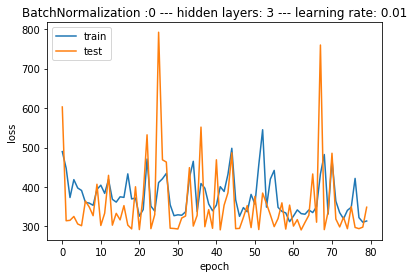

BatchNormalization :1 --- hidden layers: 0 --- learning rate: 0.01
Train on 960 samples, validate on 241 samples
Epoch 1/100
960/960 [==============================] - 4s 4ms/step - loss: 37015.1719 - val_loss: 6920.1821
Epoch 2/100
960/960 [==============================] - 0s 111us/step - loss: 24005.3217 - val_loss: 28269.0984
Epoch 3/100
960/960 [==============================] - 0s 118us/step - loss: 5702.5681 - val_loss: 27192.0065
Epoch 4/100
960/960 [==============================] - 0s 121us/step - loss: 755.7056 - val_loss: 13132.2686
Epoch 5/100
960/960 [==============================] - 0s 125us/step - loss: 512.7106 - val_loss: 6913.2128
Epoch 6/100
960/960 [==============================] - 0s 111us/step - loss: 355.7985 - val_loss: 4091.9333
Epoch 7/100
960/960 [==============================] - 0s 116us/step - loss: 303.0469 - val_loss: 4193.7241
Epoch 8/100
960/960 [==============================] - 0s 113us/step - loss: 299.4484 - val_loss: 2750.7338
Epoch 9/100
960/9

Epoch 76/100
960/960 [==============================] - 0s 108us/step - loss: 262.9153 - val_loss: 364.6326
Epoch 77/100
960/960 [==============================] - 0s 130us/step - loss: 257.1183 - val_loss: 355.8943
Epoch 78/100
960/960 [==============================] - 0s 108us/step - loss: 261.1979 - val_loss: 396.7337
Epoch 79/100
960/960 [==============================] - 0s 110us/step - loss: 260.9585 - val_loss: 357.9394
Epoch 80/100
960/960 [==============================] - 0s 109us/step - loss: 257.5580 - val_loss: 372.1122
Epoch 81/100
960/960 [==============================] - 0s 110us/step - loss: 256.9928 - val_loss: 373.1186
Epoch 82/100
960/960 [==============================] - 0s 109us/step - loss: 255.6163 - val_loss: 365.1780
Epoch 83/100
960/960 [==============================] - 0s 112us/step - loss: 255.0314 - val_loss: 358.6520
Epoch 84/100
960/960 [==============================] - 0s 112us/step - loss: 259.3729 - val_loss: 362.6239
Epoch 85/100
960/960 [======

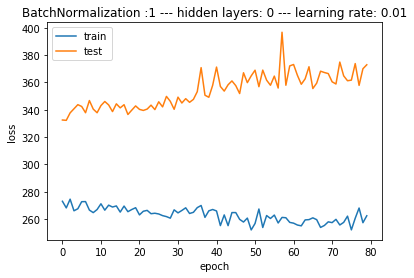

BatchNormalization :1 --- hidden layers: 1 --- learning rate: 0.01
Train on 960 samples, validate on 241 samples
Epoch 1/100
960/960 [==============================] - 6s 6ms/step - loss: 13827.6613 - val_loss: 19296752.7303
Epoch 2/100
960/960 [==============================] - 0s 339us/step - loss: 2026.2896 - val_loss: 20538966.8216
Epoch 3/100
960/960 [==============================] - 0s 328us/step - loss: 1167.2691 - val_loss: 10641168.9502
Epoch 4/100
960/960 [==============================] - 0s 357us/step - loss: 669.3503 - val_loss: 8148516.3983
Epoch 5/100
960/960 [==============================] - 0s 335us/step - loss: 498.6582 - val_loss: 5362994.6141
Epoch 6/100
960/960 [==============================] - 0s 316us/step - loss: 410.2316 - val_loss: 3475265.9035
Epoch 7/100
960/960 [==============================] - 0s 336us/step - loss: 328.4284 - val_loss: 2637862.1162
Epoch 8/100
960/960 [==============================] - 0s 340us/step - loss: 347.4686 - val_loss: 1846991

960/960 [==============================] - 0s 337us/step - loss: 120.3991 - val_loss: 522.8804
Epoch 76/100
960/960 [==============================] - 0s 323us/step - loss: 105.2228 - val_loss: 555.7929
Epoch 77/100
960/960 [==============================] - 0s 349us/step - loss: 132.8916 - val_loss: 613.1832
Epoch 78/100
960/960 [==============================] - 0s 345us/step - loss: 122.6232 - val_loss: 443.1723
Epoch 79/100
960/960 [==============================] - 0s 345us/step - loss: 111.0317 - val_loss: 509.9564
Epoch 80/100
960/960 [==============================] - 0s 316us/step - loss: 105.4778 - val_loss: 529.8190
Epoch 81/100
960/960 [==============================] - 0s 351us/step - loss: 80.6254 - val_loss: 476.6225
Epoch 82/100
960/960 [==============================] - 0s 337us/step - loss: 103.6116 - val_loss: 468.4472
Epoch 83/100
960/960 [==============================] - 0s 344us/step - loss: 90.2068 - val_loss: 475.3382
Epoch 84/100
960/960 [=====================

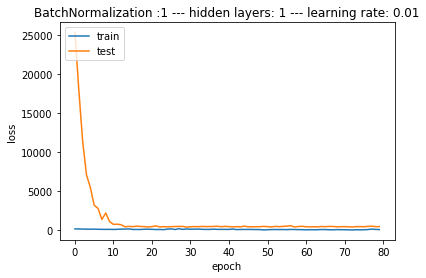

BatchNormalization :1 --- hidden layers: 2 --- learning rate: 0.01
Train on 960 samples, validate on 241 samples
Epoch 1/100
960/960 [==============================] - 4s 4ms/step - loss: 9662.4213 - val_loss: 6235265.5083
Epoch 2/100
960/960 [==============================] - 1s 525us/step - loss: 2843.1359 - val_loss: 12239244.3900
Epoch 3/100
960/960 [==============================] - 1s 558us/step - loss: 1248.4857 - val_loss: 9054450.8257
Epoch 4/100
960/960 [==============================] - 1s 553us/step - loss: 689.5207 - val_loss: 5733108.8195
Epoch 5/100
960/960 [==============================] - 1s 551us/step - loss: 506.0881 - val_loss: 3452621.1307
Epoch 6/100
960/960 [==============================] - 1s 567us/step - loss: 351.6803 - val_loss: 1646431.2095
Epoch 7/100
960/960 [==============================] - 1s 578us/step - loss: 365.2326 - val_loss: 1038700.4629
Epoch 8/100
960/960 [==============================] - 1s 552us/step - loss: 294.3907 - val_loss: 524506.567

960/960 [==============================] - 1s 552us/step - loss: 101.9918 - val_loss: 498.9556
Epoch 76/100
960/960 [==============================] - 1s 554us/step - loss: 122.6801 - val_loss: 518.9696
Epoch 77/100
960/960 [==============================] - 1s 521us/step - loss: 111.1058 - val_loss: 465.1322
Epoch 78/100
960/960 [==============================] - 1s 551us/step - loss: 125.6732 - val_loss: 491.7978
Epoch 79/100
960/960 [==============================] - 1s 575us/step - loss: 81.8043 - val_loss: 457.3707
Epoch 80/100
960/960 [==============================] - 1s 551us/step - loss: 142.7980 - val_loss: 671.6830
Epoch 81/100
960/960 [==============================] - 1s 548us/step - loss: 143.4291 - val_loss: 510.9053
Epoch 82/100
960/960 [==============================] - 1s 545us/step - loss: 127.1158 - val_loss: 529.4320
Epoch 83/100
960/960 [==============================] - 1s 560us/step - loss: 93.1804 - val_loss: 509.2831
Epoch 84/100
960/960 [=====================

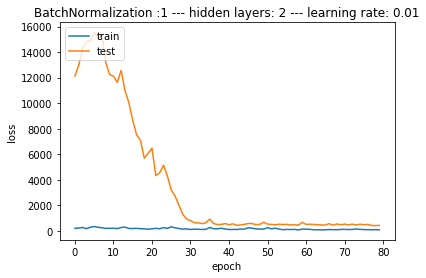

BatchNormalization :1 --- hidden layers: 3 --- learning rate: 0.01
Train on 960 samples, validate on 241 samples
Epoch 1/100
960/960 [==============================] - 4s 5ms/step - loss: 28785.1546 - val_loss: 4517244.1784
Epoch 2/100
960/960 [==============================] - 1s 755us/step - loss: 6737.7671 - val_loss: 1663144.9175
Epoch 3/100
960/960 [==============================] - 1s 770us/step - loss: 3019.4492 - val_loss: 1661816.4907
Epoch 4/100
960/960 [==============================] - 1s 773us/step - loss: 1462.6571 - val_loss: 148970.8624
Epoch 5/100
960/960 [==============================] - 1s 755us/step - loss: 772.6647 - val_loss: 17441.8017
Epoch 6/100
960/960 [==============================] - 1s 772us/step - loss: 597.9198 - val_loss: 1391.2650
Epoch 7/100
960/960 [==============================] - 1s 789us/step - loss: 503.2052 - val_loss: 10847.7108
Epoch 8/100
960/960 [==============================] - 1s 763us/step - loss: 533.6068 - val_loss: 18230.3022
Epoch 

Epoch 75/100
960/960 [==============================] - 1s 832us/step - loss: 105.5377 - val_loss: 451.2016
Epoch 76/100
960/960 [==============================] - 1s 828us/step - loss: 115.5617 - val_loss: 466.7546
Epoch 77/100
960/960 [==============================] - 1s 780us/step - loss: 152.8658 - val_loss: 492.4248
Epoch 78/100
960/960 [==============================] - 1s 794us/step - loss: 163.2728 - val_loss: 776.6098
Epoch 79/100
960/960 [==============================] - 1s 773us/step - loss: 164.2437 - val_loss: 524.3949
Epoch 80/100
960/960 [==============================] - 1s 758us/step - loss: 115.7944 - val_loss: 463.8070
Epoch 81/100
960/960 [==============================] - 1s 763us/step - loss: 110.5290 - val_loss: 473.2668
Epoch 82/100
960/960 [==============================] - 1s 759us/step - loss: 115.2665 - val_loss: 472.2826
Epoch 83/100
960/960 [==============================] - 1s 788us/step - loss: 121.5135 - val_loss: 678.3277
Epoch 84/100
960/960 [======

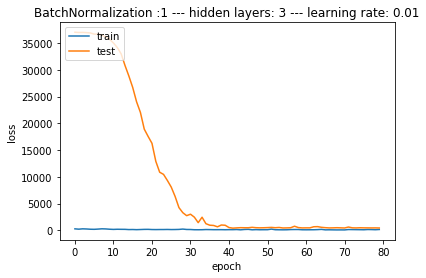

BatchNormalization :0 --- hidden layers: 0 --- learning rate: 0.001
Train on 960 samples, validate on 241 samples
Epoch 1/100
960/960 [==============================] - 4s 4ms/step - loss: 2204.7018 - val_loss: 350.7738
Epoch 2/100
960/960 [==============================] - 0s 64us/step - loss: 643.9703 - val_loss: 590.7658
Epoch 3/100
960/960 [==============================] - 0s 64us/step - loss: 511.5688 - val_loss: 368.1261
Epoch 4/100
960/960 [==============================] - 0s 66us/step - loss: 425.3661 - val_loss: 340.8026
Epoch 5/100
960/960 [==============================] - 0s 64us/step - loss: 414.3546 - val_loss: 351.6215
Epoch 6/100
960/960 [==============================] - 0s 65us/step - loss: 409.1036 - val_loss: 339.2633
Epoch 7/100
960/960 [==============================] - 0s 66us/step - loss: 410.2445 - val_loss: 347.1867
Epoch 8/100
960/960 [==============================] - 0s 65us/step - loss: 408.8358 - val_loss: 358.0813
Epoch 9/100
960/960 [=================

960/960 [==============================] - 0s 65us/step - loss: 344.6319 - val_loss: 348.3291
Epoch 77/100
960/960 [==============================] - 0s 63us/step - loss: 332.9340 - val_loss: 357.2668
Epoch 78/100
960/960 [==============================] - 0s 62us/step - loss: 342.8261 - val_loss: 297.6695
Epoch 79/100
960/960 [==============================] - 0s 59us/step - loss: 334.8005 - val_loss: 304.8939
Epoch 80/100
960/960 [==============================] - 0s 62us/step - loss: 335.2310 - val_loss: 297.5861
Epoch 81/100
960/960 [==============================] - 0s 61us/step - loss: 337.3825 - val_loss: 299.3668
Epoch 82/100
960/960 [==============================] - 0s 63us/step - loss: 345.5491 - val_loss: 304.4158
Epoch 83/100
960/960 [==============================] - 0s 63us/step - loss: 338.0934 - val_loss: 374.9269
Epoch 84/100
960/960 [==============================] - 0s 61us/step - loss: 333.3254 - val_loss: 297.0596
Epoch 85/100
960/960 [============================

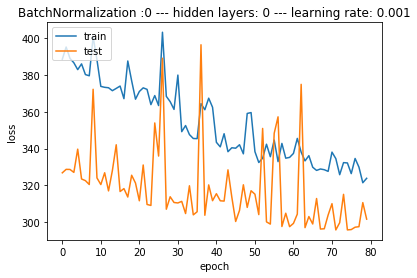

BatchNormalization :0 --- hidden layers: 1 --- learning rate: 0.001
Train on 960 samples, validate on 241 samples
Epoch 1/100
960/960 [==============================] - 4s 4ms/step - loss: 11137.2381 - val_loss: 4197.7253
Epoch 2/100
960/960 [==============================] - 0s 227us/step - loss: 1605.9660 - val_loss: 1401.4322
Epoch 3/100
960/960 [==============================] - 0s 228us/step - loss: 677.5328 - val_loss: 480.8108
Epoch 4/100
960/960 [==============================] - 0s 236us/step - loss: 446.4250 - val_loss: 391.4218
Epoch 5/100
960/960 [==============================] - 0s 228us/step - loss: 401.5082 - val_loss: 393.4522
Epoch 6/100
960/960 [==============================] - 0s 228us/step - loss: 396.0291 - val_loss: 347.9561
Epoch 7/100
960/960 [==============================] - 0s 235us/step - loss: 408.7525 - val_loss: 373.9734
Epoch 8/100
960/960 [==============================] - 0s 228us/step - loss: 422.8383 - val_loss: 335.7555
Epoch 9/100
960/960 [======

Epoch 76/100
960/960 [==============================] - 0s 227us/step - loss: 379.1817 - val_loss: 642.4645
Epoch 77/100
960/960 [==============================] - 0s 231us/step - loss: 446.0447 - val_loss: 493.9378
Epoch 78/100
960/960 [==============================] - 0s 227us/step - loss: 380.8626 - val_loss: 298.3471
Epoch 79/100
960/960 [==============================] - 0s 227us/step - loss: 315.1339 - val_loss: 388.8755
Epoch 80/100
960/960 [==============================] - 0s 228us/step - loss: 415.3428 - val_loss: 631.9932
Epoch 81/100
960/960 [==============================] - 0s 227us/step - loss: 679.6449 - val_loss: 336.3977
Epoch 82/100
960/960 [==============================] - 0s 228us/step - loss: 571.8284 - val_loss: 603.0361
Epoch 83/100
960/960 [==============================] - 0s 228us/step - loss: 352.8258 - val_loss: 464.0035
Epoch 84/100
960/960 [==============================] - 0s 230us/step - loss: 368.2957 - val_loss: 310.6508
Epoch 85/100
960/960 [======

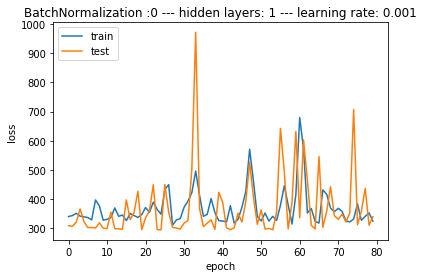

BatchNormalization :0 --- hidden layers: 2 --- learning rate: 0.001
Train on 960 samples, validate on 241 samples
Epoch 1/100
960/960 [==============================] - 4s 4ms/step - loss: 12384.4371 - val_loss: 5043.1947
Epoch 2/100
960/960 [==============================] - 0s 230us/step - loss: 1684.4857 - val_loss: 1608.9735
Epoch 3/100
960/960 [==============================] - 0s 234us/step - loss: 705.5575 - val_loss: 542.4362
Epoch 4/100
960/960 [==============================] - 0s 234us/step - loss: 480.0108 - val_loss: 355.0500
Epoch 5/100
960/960 [==============================] - 0s 248us/step - loss: 486.6072 - val_loss: 416.7780
Epoch 6/100
960/960 [==============================] - 0s 232us/step - loss: 420.8579 - val_loss: 370.9846
Epoch 7/100
960/960 [==============================] - 0s 234us/step - loss: 386.1805 - val_loss: 350.0359
Epoch 8/100
960/960 [==============================] - 0s 229us/step - loss: 389.3027 - val_loss: 339.2704
Epoch 9/100
960/960 [======

Epoch 76/100
960/960 [==============================] - 0s 230us/step - loss: 454.3235 - val_loss: 661.4516
Epoch 77/100
960/960 [==============================] - 0s 238us/step - loss: 447.9913 - val_loss: 303.9392
Epoch 78/100
960/960 [==============================] - 0s 229us/step - loss: 370.7868 - val_loss: 441.0522
Epoch 79/100
960/960 [==============================] - 0s 231us/step - loss: 366.8503 - val_loss: 296.8615
Epoch 80/100
960/960 [==============================] - 0s 232us/step - loss: 310.5680 - val_loss: 321.8661
Epoch 81/100
960/960 [==============================] - 0s 233us/step - loss: 304.2743 - val_loss: 302.8342
Epoch 82/100
960/960 [==============================] - 0s 232us/step - loss: 392.8134 - val_loss: 344.7612
Epoch 83/100
960/960 [==============================] - 0s 227us/step - loss: 343.1050 - val_loss: 300.2696
Epoch 84/100
960/960 [==============================] - 0s 228us/step - loss: 456.1415 - val_loss: 329.9988
Epoch 85/100
960/960 [======

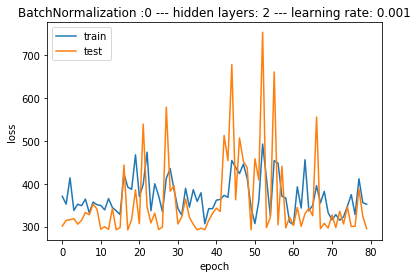

BatchNormalization :0 --- hidden layers: 3 --- learning rate: 0.001
Train on 960 samples, validate on 241 samples
Epoch 1/100
960/960 [==============================] - 4s 4ms/step - loss: 5332.4053 - val_loss: 896.1035
Epoch 2/100
960/960 [==============================] - 0s 429us/step - loss: 639.9087 - val_loss: 367.2403
Epoch 3/100
960/960 [==============================] - 0s 441us/step - loss: 472.1035 - val_loss: 356.9543
Epoch 4/100
960/960 [==============================] - 0s 441us/step - loss: 439.3419 - val_loss: 362.2196
Epoch 5/100
960/960 [==============================] - 0s 448us/step - loss: 454.4705 - val_loss: 345.5989
Epoch 6/100
960/960 [==============================] - 0s 434us/step - loss: 425.1202 - val_loss: 395.2646
Epoch 7/100
960/960 [==============================] - 0s 436us/step - loss: 437.0440 - val_loss: 354.9242
Epoch 8/100
960/960 [==============================] - 0s 430us/step - loss: 445.4006 - val_loss: 503.5023
Epoch 9/100
960/960 [==========

Epoch 76/100
960/960 [==============================] - 0s 429us/step - loss: 389.2870 - val_loss: 295.8179
Epoch 77/100
960/960 [==============================] - 0s 424us/step - loss: 372.0541 - val_loss: 346.1277
Epoch 78/100
960/960 [==============================] - 0s 438us/step - loss: 333.0221 - val_loss: 320.8614
Epoch 79/100
960/960 [==============================] - 0s 435us/step - loss: 354.2782 - val_loss: 294.4072
Epoch 80/100
960/960 [==============================] - 1s 1ms/step - loss: 323.1199 - val_loss: 304.2865
Epoch 81/100
960/960 [==============================] - 1s 957us/step - loss: 331.2588 - val_loss: 313.9955
Epoch 82/100
960/960 [==============================] - 1s 846us/step - loss: 337.5016 - val_loss: 304.1498
Epoch 83/100
960/960 [==============================] - 0s 434us/step - loss: 326.3790 - val_loss: 301.7587
Epoch 84/100
960/960 [==============================] - 0s 422us/step - loss: 343.6727 - val_loss: 291.4973
Epoch 85/100
960/960 [========

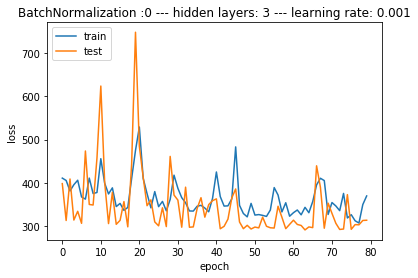

BatchNormalization :1 --- hidden layers: 0 --- learning rate: 0.001
Train on 960 samples, validate on 241 samples
Epoch 1/100
960/960 [==============================] - 4s 4ms/step - loss: 39211.5448 - val_loss: 14229.1157
Epoch 2/100
960/960 [==============================] - 0s 90us/step - loss: 38923.4945 - val_loss: 10651.8910
Epoch 3/100
960/960 [==============================] - 0s 92us/step - loss: 38496.1727 - val_loss: 10687.2416
Epoch 4/100
960/960 [==============================] - 0s 91us/step - loss: 37845.1755 - val_loss: 11265.1279
Epoch 5/100
960/960 [==============================] - 0s 91us/step - loss: 36915.5294 - val_loss: 11667.8117
Epoch 6/100
960/960 [==============================] - 0s 91us/step - loss: 35681.7578 - val_loss: 11689.3608
Epoch 7/100
960/960 [==============================] - 0s 91us/step - loss: 34138.5040 - val_loss: 11517.1902
Epoch 8/100
960/960 [==============================] - 0s 89us/step - loss: 32309.1813 - val_loss: 11131.1947
Epoch 9

Epoch 76/100
960/960 [==============================] - 0s 95us/step - loss: 295.0845 - val_loss: 333.0922
Epoch 77/100
960/960 [==============================] - 0s 91us/step - loss: 287.2451 - val_loss: 333.6277
Epoch 78/100
960/960 [==============================] - 0s 94us/step - loss: 291.5430 - val_loss: 333.5239
Epoch 79/100
960/960 [==============================] - 0s 97us/step - loss: 285.4546 - val_loss: 333.2269
Epoch 80/100
960/960 [==============================] - 0s 90us/step - loss: 289.4928 - val_loss: 333.2778
Epoch 81/100
960/960 [==============================] - 0s 91us/step - loss: 284.0218 - val_loss: 333.4406
Epoch 82/100
960/960 [==============================] - 0s 90us/step - loss: 289.9353 - val_loss: 333.8287
Epoch 83/100
960/960 [==============================] - 0s 89us/step - loss: 289.3475 - val_loss: 334.4710
Epoch 84/100
960/960 [==============================] - 0s 89us/step - loss: 287.8127 - val_loss: 334.3621
Epoch 85/100
960/960 [===============

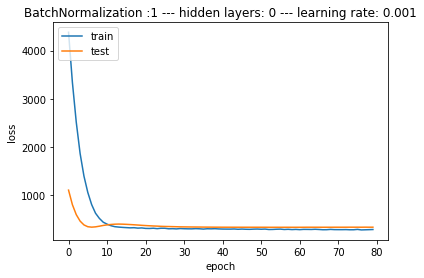

BatchNormalization :1 --- hidden layers: 1 --- learning rate: 0.001
Train on 960 samples, validate on 241 samples
Epoch 1/100
960/960 [==============================] - 4s 4ms/step - loss: 35951.6621 - val_loss: 262981.3439
Epoch 2/100
960/960 [==============================] - 0s 262us/step - loss: 27572.6918 - val_loss: 1667080.2272
Epoch 3/100
960/960 [==============================] - 0s 257us/step - loss: 16907.8926 - val_loss: 4839815.1929
Epoch 4/100
960/960 [==============================] - 0s 262us/step - loss: 7235.3183 - val_loss: 7783149.3008
Epoch 5/100
960/960 [==============================] - 0s 258us/step - loss: 2777.5107 - val_loss: 6907512.5685
Epoch 6/100
960/960 [==============================] - 0s 275us/step - loss: 1638.1090 - val_loss: 5354965.1763
Epoch 7/100
960/960 [==============================] - 0s 256us/step - loss: 1148.1563 - val_loss: 4296868.8029
Epoch 8/100
960/960 [==============================] - 0s 256us/step - loss: 935.3382 - val_loss: 3951

960/960 [==============================] - 0s 265us/step - loss: 121.5380 - val_loss: 455.2363
Epoch 75/100
960/960 [==============================] - 0s 266us/step - loss: 116.6821 - val_loss: 451.8532
Epoch 76/100
960/960 [==============================] - 0s 266us/step - loss: 145.3590 - val_loss: 442.8223
Epoch 77/100
960/960 [==============================] - 0s 263us/step - loss: 282.6285 - val_loss: 500.0061
Epoch 78/100
960/960 [==============================] - 0s 262us/step - loss: 232.2193 - val_loss: 432.0225
Epoch 79/100
960/960 [==============================] - 0s 269us/step - loss: 121.0029 - val_loss: 469.6611
Epoch 80/100
960/960 [==============================] - 0s 285us/step - loss: 104.0051 - val_loss: 476.8802
Epoch 81/100
960/960 [==============================] - 0s 258us/step - loss: 106.4537 - val_loss: 449.3017
Epoch 82/100
960/960 [==============================] - 0s 258us/step - loss: 109.0538 - val_loss: 455.9022
Epoch 83/100
960/960 [===================

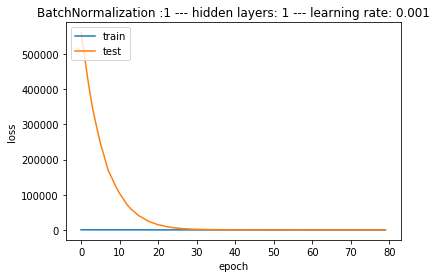

BatchNormalization :1 --- hidden layers: 2 --- learning rate: 0.001
Train on 960 samples, validate on 241 samples
Epoch 1/100
960/960 [==============================] - 4s 4ms/step - loss: 20219.2739 - val_loss: 22587607.0041
Epoch 2/100
960/960 [==============================] - 0s 434us/step - loss: 5607.2933 - val_loss: 7514948.0270
Epoch 3/100
960/960 [==============================] - 0s 451us/step - loss: 1492.0551 - val_loss: 8741884.0830
Epoch 4/100
960/960 [==============================] - 0s 430us/step - loss: 798.4521 - val_loss: 3757689.8475
Epoch 5/100
960/960 [==============================] - 0s 429us/step - loss: 491.1604 - val_loss: 3070661.0882
Epoch 6/100
960/960 [==============================] - 0s 432us/step - loss: 414.9745 - val_loss: 2225037.1598
Epoch 7/100
960/960 [==============================] - 0s 433us/step - loss: 328.6308 - val_loss: 1481589.7054
Epoch 8/100
960/960 [==============================] - 0s 460us/step - loss: 336.4938 - val_loss: 1141361.

960/960 [==============================] - 0s 446us/step - loss: 75.9630 - val_loss: 449.7471
Epoch 76/100
960/960 [==============================] - 0s 443us/step - loss: 85.1436 - val_loss: 496.6730
Epoch 77/100
960/960 [==============================] - 0s 442us/step - loss: 116.0553 - val_loss: 500.5571
Epoch 78/100
960/960 [==============================] - 1s 566us/step - loss: 90.4856 - val_loss: 490.9147
Epoch 79/100
960/960 [==============================] - 1s 766us/step - loss: 87.1262 - val_loss: 504.5597
Epoch 80/100
960/960 [==============================] - 0s 440us/step - loss: 84.6221 - val_loss: 467.3311
Epoch 81/100
960/960 [==============================] - 0s 435us/step - loss: 101.4927 - val_loss: 495.2691
Epoch 82/100
960/960 [==============================] - 0s 435us/step - loss: 77.6487 - val_loss: 432.6161
Epoch 83/100
960/960 [==============================] - 0s 437us/step - loss: 76.1998 - val_loss: 478.5280
Epoch 84/100
960/960 [==========================

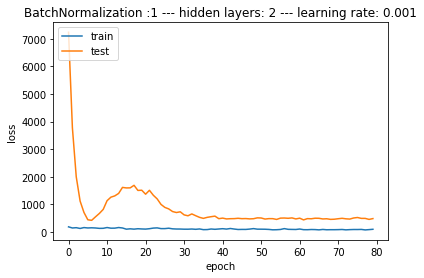

BatchNormalization :1 --- hidden layers: 3 --- learning rate: 0.001
Train on 960 samples, validate on 241 samples
Epoch 1/100
960/960 [==============================] - 5s 5ms/step - loss: 17408.2169 - val_loss: 6802759.0456
Epoch 2/100
960/960 [==============================] - 1s 673us/step - loss: 2819.9806 - val_loss: 8489476.6473
Epoch 3/100
960/960 [==============================] - 1s 655us/step - loss: 922.2965 - val_loss: 7828384.1722
Epoch 4/100
960/960 [==============================] - 1s 666us/step - loss: 559.0604 - val_loss: 5702813.5747
Epoch 5/100
960/960 [==============================] - 1s 1ms/step - loss: 473.5749 - val_loss: 4176927.2106
Epoch 6/100
960/960 [==============================] - 1s 738us/step - loss: 453.7387 - val_loss: 2879834.4170
Epoch 7/100
960/960 [==============================] - 1s 702us/step - loss: 377.5229 - val_loss: 2337946.2376
Epoch 8/100
960/960 [==============================] - 1s 1ms/step - loss: 286.8434 - val_loss: 1959155.6520
E

960/960 [==============================] - 1s 842us/step - loss: 103.3387 - val_loss: 515.8283
Epoch 76/100
960/960 [==============================] - 1s 773us/step - loss: 86.1436 - val_loss: 474.3226
Epoch 77/100
960/960 [==============================] - 1s 796us/step - loss: 123.3789 - val_loss: 524.0421
Epoch 78/100
960/960 [==============================] - 1s 817us/step - loss: 118.1383 - val_loss: 558.6330
Epoch 79/100
960/960 [==============================] - 1s 786us/step - loss: 132.6003 - val_loss: 513.5755
Epoch 80/100
960/960 [==============================] - 1s 816us/step - loss: 90.0481 - val_loss: 514.9171
Epoch 81/100
960/960 [==============================] - 1s 781us/step - loss: 113.5051 - val_loss: 567.9451
Epoch 82/100
960/960 [==============================] - 1s 825us/step - loss: 97.2387 - val_loss: 513.0909
Epoch 83/100
960/960 [==============================] - 1s 779us/step - loss: 101.0378 - val_loss: 476.3296
Epoch 84/100
960/960 [======================

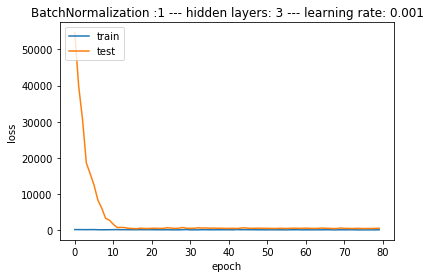

In [262]:
## Run several iterations
for lr in range(2):
    if lr == 0:
        lr = 0.01
    else:
        lr = 0.001
    for batchNormalization in range(2):
        for layers in range(4):
            print('BatchNormalization :' + str(batchNormalization) + " --- hidden layers: " + str(layers) + " --- learning rate: " + str(lr))
            model = generateModel(batchNormalization, layers, lr)
            history = model.fit(trn_input, trn_labels, validation_data=(val_input, val_labels), epochs=100, batch_size=64)
            printHistory(history, batchNormalization, layers, lr)
